In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import json

import os
import math
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm


from sklearn.neighbors import KernelDensity 
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate


import xgboost
from xgboost import XGBRegressor, XGBClassifier

from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import seaborn as sns

def create_cyan_to_black_cmap(color1, color2, cmap_name = 'cyan_to_black'):
    colors = [color1, color2]
    return LinearSegmentedColormap.from_list(cmap_name, colors)

# Create the colormap
NP_cmap = create_cyan_to_black_cmap('black', mcolors.to_rgb('darkcyan'), cmap_name = 'NP_cmap')
SM_cmap = create_cyan_to_black_cmap(mcolors.to_rgb('coral'), 'black', cmap_name = 'SM_cmap')

In [3]:
#####################################
# IMPORT AUXILIARY/CUSTOM FUNCTIONS #
#####################################

from AUX_MLL_BL import XG, KDE_fitter, max_num_bins
from AUX_MLL_BL import Z_BL_asimov, BL_test_fast, BL_test_fsolve, MLL_test_fast, MLL_test_fsolve

In [4]:
import matplotlib as mpl
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 

In [5]:
BPs2plot = [2,5,8,11,14]
cmap = cm.get_cmap('Blues', 18)
#cmap = ['coral']
wjets_color = 'coral'
wgamma_color = 'red'
ttgamma_color = 'purple'

# custom functions

In [6]:
def MLL_aprox_discovery_ox(pred_XG_SM, pred_XG_NP, B_expected, S_expected):
   
    pspb_B_data = np.median([im / (1 - im) for im in pred_XG_SM])
    pspb_S_data = np.median([im / (1 - im) for im in pred_XG_NP])
   
    f0 = -2 * S_expected
    fB = 2 * B_expected * np.log( 1 + (pspb_B_data * S_expected / B_expected) )
    fS = 2 * S_expected * np.log( 1 + (pspb_S_data * S_expected / B_expected) )
   
    return (f0 + fB + fS)**0.5



def MLL_aprox_discovery_KDE(pB_B_data, pS_B_data, pB_S_data, pS_S_data, B_expected, S_expected):
   
    pspb_B_data = np.median(pS_B_data/pB_B_data)
    pspb_S_data = np.median(pS_S_data/pB_S_data)
   
    f0 = -2 * S_expected
    fB = 2 * B_expected * np.log( 1 + (pspb_B_data * S_expected / B_expected) )
    fS = 2 * S_expected * np.log( 1 + (pspb_S_data * S_expected / B_expected) )
   
    return (f0 + fB + fS)**0.5


# Reading the data

## SM

In [7]:
ttgamma_cross = 0.13 * 1000 #[fb]
ttgamma_NLO   = 1.46 # k-factor [14 TeV]

Wgamma_cross = 0.944 * 1000 #[fb]
Wgamma_NLO   = 2.37 # k-factor [14 TeV]

Wjets_cross = 168.12 * 1000 #[fb]
Wjets_NLO   = 1.27 # k-factor [14 TeV]

ttjets_cross = 29.0495 * 1000 # [fb]
ttjets_NLO   = 1.47

zjets_cross = 65.85 * 1000 # [fb] solo rama leptonica
zjets_NLO   = 1.35

wz_cross = 0.90 * 1000 # [fb]
wz_NLO   = 1.62

zz_cross = 0.2616 * 1000
zz_NLO   = 1.29

ww_cross = 0.409 * 1000
ww_NLO   = 1.40

tj_cross = 1.598 * 1000
tj_NLO   = 1.03

tb_cross = 2.882 * 1000
tb_NLO   = 1.34

tw_cross = 1.441 * 1000
tw_NLO   = 1.

In [8]:
Wgamma_fidcross  = 110.02191836496351
Wjets_fidcross   = 108.33785910195228
ttgamma_fidcross = 5.23820

ttjets_fidcross  = 22.388
zjets_fidcross   = 3.5025615
wz_fidcross      = 2.2074
zz_fidcross      = 0.2848
ww_fidcross      = 4.197
tj_fidcross      = 0.9348
tb_fidcross      = 1.293
tw_fidcross      = 2.1975

B_fidcross_tot   = Wgamma_fidcross + Wjets_fidcross + ttgamma_fidcross + \
                   ttjets_fidcross + zjets_fidcross + wz_fidcross  + \
                   zz_fidcross + ww_fidcross + tj_fidcross + \
                   tb_fidcross + tw_fidcross 
B_fidcross_tot

225.35959212291579

In [9]:
Wgamma_aceptancia_init  = Wgamma_fidcross / (Wgamma_cross * 1000 * Wgamma_NLO)
Wjets_aceptancia_init   = Wjets_fidcross / (Wjets_cross * 1000 * Wjets_NLO)
ttgamma_aceptancia_init = ttgamma_fidcross / (ttgamma_cross * 1000 * ttgamma_NLO)
ttjets_aceptancia_init  = ttjets_fidcross / (ttjets_cross * 1000 * ttjets_NLO)
zjets_aceptancia_init   = zjets_fidcross / (zjets_cross * 1000 * zjets_NLO)
wz_aceptancia_init      = wz_fidcross / (wz_cross * 1000 * wz_NLO)
zz_aceptancia_init      = zz_fidcross / (zz_cross * 1000 * zz_NLO)
ww_aceptancia_init      = ww_fidcross / (ww_cross * 1000 * ww_NLO)
tj_aceptancia_init      = tj_fidcross / (tj_cross * 1000 * tj_NLO)
tb_aceptancia_init      = tb_fidcross / (tb_cross * 1000 * tb_NLO)
tw_aceptancia_init      = tw_fidcross / (tw_cross * 1000 * tw_NLO)

In [10]:
Wgamma_expected  = 11002.191836496351
Wjets_expected   = 10833.785910195227
ttgamma_expected = 523.820

ttjets_expected  = 2238.5992598
zjets_expected   = 350.25615
wz_expected      = 220.74
zz_expected      = 28.481
ww_expected      = 419.71
tj_expected      = 93.489
tb_expected      = 129.372
tw_expected      = 219.75

B_expected = ttgamma_expected + Wjets_expected + Wgamma_expected + ttjets_expected + \
             zjets_expected + wz_expected + zz_expected + ww_expected + \
             tj_expected + tb_expected + tw_expected

print(B_expected)

In [11]:
sample = 60_000 # Number of signal and background events to train and validate

Wgamma_sample  = int(round(sample * Wgamma_fidcross / B_fidcross_tot))
Wjets_sample   = int(round(sample * Wjets_fidcross / B_fidcross_tot))
ttgamma_sample = int(round(sample * ttgamma_fidcross / B_fidcross_tot))
ttjets_sample = int(round(sample * ttjets_fidcross / B_fidcross_tot))
zjets_sample = int(round(sample * zjets_fidcross / B_fidcross_tot))
wz_sample = int(round(sample * wz_fidcross / B_fidcross_tot))
zz_sample = int(round(sample * zz_fidcross / B_fidcross_tot))
ww_sample = int(round(sample * ww_fidcross / B_fidcross_tot))
tj_sample = int(round(sample * tj_fidcross / B_fidcross_tot))
tb_sample = int(round(sample * tb_fidcross / B_fidcross_tot))
tw_sample = int(round(sample * tw_fidcross / B_fidcross_tot))

print(Wgamma_sample)
print(Wjets_sample)
print(ttgamma_sample)
print(ttjets_sample)
print(zjets_sample)
print(wz_sample)
print(zz_sample)
print(ww_sample)
print(tj_sample)
print(tb_sample)
print(tw_sample)

29292
28844
1864


In [12]:
##############
# input data #
##############

# photon -> (pT, eta, phi, num_photon) from the leading photon
# jet -> (pT, eta, phi) from the leading jet
# lepton -> (pT, eta, phi, num_leptons, num_taus) from the lepton (electron or muon)
# MET -> (pT, eta, phi) eta = 0 by construction, but phi is important because we have a lot of jets that we do not use
# hadinfo -> (HT, HT_had, num_jets)  HT: sum of Pt of all partciles, HT_had: sum PT of all the jets, number of jets (b-tag or not)


######
# SM #
######

# W gamma + W gamma jet #
# Dominant # Np es el W jet el dominant??

datFolderWgamma = '../data/Wgamma/'

photon_Wgamma  = np.loadtxt(datFolderWgamma + 'photon_6.dat', delimiter=' ')
jet_Wgamma     = np.loadtxt(datFolderWgamma + 'jet_6.dat', delimiter=' ')
lepton_Wgamma  = np.loadtxt(datFolderWgamma + 'lepton_6.dat', delimiter=' ')
MET_Wgamma     = np.loadtxt(datFolderWgamma + 'MET_6.dat', delimiter=' ')
hadinfo_Wgamma = np.loadtxt(datFolderWgamma + 'hadinfo_6.dat', delimiter=' ')


# W jet + W jet jet #

datFolderWjets = '../data/Wjets/'

photon_Wjets  = np.loadtxt(datFolderWjets + 'photon_6.dat', delimiter=' ')
jet_Wjets     = np.loadtxt(datFolderWjets + 'jet_6.dat', delimiter=' ')
lepton_Wjets  = np.loadtxt(datFolderWjets + 'lepton_6.dat', delimiter=' ')
MET_Wjets     = np.loadtxt(datFolderWjets + 'MET_6.dat', delimiter=' ')
hadinfo_Wjets = np.loadtxt(datFolderWjets + 'hadinfo_6.dat', delimiter=' ')


# tt gamma + tt gamma jet #

datFolderttgamma = '../data/ttGamma/'
 
photon_ttgamma  = np.loadtxt(datFolderttgamma + 'photon_6.dat', delimiter=' ')
jet_ttgamma     = np.loadtxt(datFolderttgamma + 'jet_6.dat', delimiter=' ')
lepton_ttgamma  = np.loadtxt(datFolderttgamma + 'lepton_6.dat', delimiter=' ')
MET_ttgamma     = np.loadtxt(datFolderttgamma + 'MET_6.dat', delimiter=' ')
hadinfo_ttgamma = np.loadtxt(datFolderttgamma + 'hadinfo_6.dat', delimiter=' ')

# tt  jet #

datFolderttjets = '../data/ttjets/'
 
photon_ttjets  = np.loadtxt(datFolderttjets + 'photon_6.dat', delimiter=' ')
jet_ttjets     = np.loadtxt(datFolderttjets + 'jet_6.dat', delimiter=' ')
lepton_ttjets  = np.loadtxt(datFolderttjets + 'lepton_6.dat', delimiter=' ')
MET_ttjets     = np.loadtxt(datFolderttjets + 'MET_6.dat', delimiter=' ')
hadinfo_ttjets = np.loadtxt(datFolderttjets + 'hadinfo_6.dat', delimiter=' ')

# z jet # rama leptonica

datFolderzjets = '../data/Zlep+j/'
 
photon_zjets  = np.loadtxt(datFolderzjets + 'photon_6.dat', delimiter=' ')
jet_zjets     = np.loadtxt(datFolderzjets + 'jet_6.dat', delimiter=' ')
lepton_zjets  = np.loadtxt(datFolderzjets + 'lepton_6.dat', delimiter=' ')
MET_zjets     = np.loadtxt(datFolderzjets + 'MET_6.dat', delimiter=' ')
hadinfo_zjets = np.loadtxt(datFolderzjets + 'hadinfo_6.dat', delimiter=' ')

# wz #

datFolderwz = '../data/wz/'
 
photon_wz  = np.loadtxt(datFolderwz + 'photon_6.dat', delimiter=' ')
jet_wz     = np.loadtxt(datFolderwz + 'jet_6.dat', delimiter=' ')
lepton_wz  = np.loadtxt(datFolderwz + 'lepton_6.dat', delimiter=' ')
MET_wz     = np.loadtxt(datFolderwz + 'MET_6.dat', delimiter=' ')
hadinfo_wz = np.loadtxt(datFolderwz + 'hadinfo_6.dat', delimiter=' ')

# ww #

datFolderww = '../data/ww/'
 
photon_ww  = np.loadtxt(datFolderww + 'photon_6.dat', delimiter=' ')
jet_ww     = np.loadtxt(datFolderww + 'jet_6.dat', delimiter=' ')
lepton_ww  = np.loadtxt(datFolderww + 'lepton_6.dat', delimiter=' ')
MET_ww     = np.loadtxt(datFolderww + 'MET_6.dat', delimiter=' ')
hadinfo_ww = np.loadtxt(datFolderww + 'hadinfo_6.dat', delimiter=' ')

# zz #

datFolderzz = '../data/zz/'
 
photon_zz  = np.loadtxt(datFolderzz + 'photon_6.dat', delimiter=' ')
jet_zz     = np.loadtxt(datFolderzz + 'jet_6.dat', delimiter=' ')
lepton_zz  = np.loadtxt(datFolderzz + 'lepton_6.dat', delimiter=' ')
MET_zz     = np.loadtxt(datFolderzz + 'MET_6.dat', delimiter=' ')
hadinfo_zz = np.loadtxt(datFolderzz + 'hadinfo_6.dat', delimiter=' ')

# tj #

datFoldertj = '../data/singleTop+j/'
 
photon_tj  = np.loadtxt(datFoldertj + 'photon_6.dat', delimiter=' ')
jet_tj     = np.loadtxt(datFoldertj + 'jet_6.dat', delimiter=' ')
lepton_tj  = np.loadtxt(datFoldertj + 'lepton_6.dat', delimiter=' ')
MET_tj     = np.loadtxt(datFoldertj + 'MET_6.dat', delimiter=' ')
hadinfo_tj = np.loadtxt(datFoldertj + 'hadinfo_6.dat', delimiter=' ')

# tb #

datFoldertb = '../data/singleTop+b/'
 
photon_tb  = np.loadtxt(datFoldertb + 'photon_6.dat', delimiter=' ')
jet_tb     = np.loadtxt(datFoldertb + 'jet_6.dat', delimiter=' ')
lepton_tb  = np.loadtxt(datFoldertb + 'lepton_6.dat', delimiter=' ')
MET_tb     = np.loadtxt(datFoldertb + 'MET_6.dat', delimiter=' ')
hadinfo_tb = np.loadtxt(datFoldertb + 'hadinfo_6.dat', delimiter=' ')

# tw #

datFoldertw = '../data/singleTop+W/'
 
photon_tw  = np.loadtxt(datFoldertw + 'photon_6.dat', delimiter=' ')
jet_tw     = np.loadtxt(datFoldertw + 'jet_6.dat', delimiter=' ')
lepton_tw  = np.loadtxt(datFoldertw + 'lepton_6.dat', delimiter=' ')
MET_tw     = np.loadtxt(datFoldertw + 'MET_6.dat', delimiter=' ')
hadinfo_tw = np.loadtxt(datFoldertw + 'hadinfo_6.dat', delimiter=' ')

In [ ]:
photon_SM  = np.concatenate([photon_Wgamma[:Wgamma_sample], photon_Wjets[:Wjets_sample], photon_ttgamma[:ttgamma_sample],
                             photon_ttjets[:ttjets_sample], photon_zjets[:zjets_sample], photon_wz[:wz_sample],
                             photon_zz[:zz_sample], photon_ww[:ww_sample], photon_tj[:tj_sample],
                             photon_tb[:tb_sample], photon_tw[:tw_sample]
                            ])
jet_SM     = np.concatenate([jet_Wgamma[:Wgamma_sample], jet_Wjets[:Wjets_sample], jet_ttgamma[:ttgamma_sample],
                             jet_ttjets[:ttjets_sample], jet_zjets[:zjets_sample], jet_wz[:wz_sample],
                             jet_zz[:zz_sample], jet_ww[:ww_sample], jet_tj[:tj_sample],
                             jet_tb[:tb_sample], jet_tw[:tw_sample]
                            ]) 
lepton_SM  = np.concatenate([lepton_Wgamma[:Wgamma_sample], lepton_Wjets[:Wjets_sample], lepton_ttgamma[:ttgamma_sample],
                             lepton_ttjets[:ttjets_sample], lepton_zjets[:zjets_sample], lepton_wz[:wz_sample],
                             lepton_zz[:zz_sample], lepton_ww[:ww_sample], lepton_tj[:tj_sample],
                             lepton_tb[:tb_sample], lepton_tw[:tw_sample]
                            ])
MET_SM     = np.concatenate([MET_Wgamma[:Wgamma_sample], MET_Wjets[:Wjets_sample], MET_ttgamma[:ttgamma_sample],
                             MET_ttjets[:ttjets_sample], MET_zjets[:zjets_sample], MET_wz[:wz_sample],
                             MET_zz[:zz_sample], MET_ww[:ww_sample], MET_tj[:tj_sample],
                             MET_tb[:tb_sample], MET_tw[:tw_sample]
                            ])
hadinfo_SM = np.concatenate([hadinfo_Wgamma[:Wgamma_sample], hadinfo_Wjets[:Wjets_sample], hadinfo_ttgamma[:ttgamma_sample],
                             hadinfo_ttjets[:ttjets_sample], hadinfo_zjets[:zjets_sample], hadinfo_wz[:wz_sample],
                             hadinfo_zz[:zz_sample], hadinfo_ww[:ww_sample], hadinfo_tj[:tj_sample],
                             hadinfo_tb[:tb_sample], hadinfo_tw[:tw_sample]
                            ])

In [13]:
bkg_flag = np.zeros(len(photon_SM))

bkg_flag[:Wgamma_sample] = 1

init_ind = Wgamma_sample
end_ind  = Wgamma_sample + Wjets_sample
bkg_flag[Wgamma_sample:(Wgamma_sample + Wjets_sample)] = 2

init_ind = end_ind
end_ind  = end_ind + ttgamma_sample
bkg_flag[(init_ind):(end_ind)] = 3

init_ind = end_ind
end_ind  = end_ind + ttjets_sample
bkg_flag[(init_ind):(end_ind)] = 4

init_ind = end_ind
end_ind  = end_ind + zjets_sample
bkg_flag[(init_ind):(end_ind)] = 5

init_ind = end_ind
end_ind  = end_ind + wz_sample
bkg_flag[(init_ind):(end_ind)] = 6

init_ind = end_ind
end_ind  = end_ind + zz_sample
bkg_flag[(init_ind):(end_ind)] = 7

init_ind = end_ind
end_ind  = end_ind + ww_sample
bkg_flag[(init_ind):(end_ind)] = 8

init_ind = end_ind
end_ind  = end_ind + tj_sample
bkg_flag[(init_ind):(end_ind)] = 9

init_ind = end_ind
end_ind  = end_ind + tb_sample
bkg_flag[(init_ind):(end_ind)] = 10

init_ind = end_ind
end_ind  = end_ind + tw_sample
bkg_flag[(init_ind):(end_ind)] = 11

In [14]:
wjets_pool  = len(photon_Wjets[Wjets_sample:])
pool_sample = int(wjets_pool * B_fidcross_tot / Wjets_fidcross)

Wgamma_pool_sample  = int(round(pool_sample * Wgamma_fidcross / B_fidcross_tot))
Wjets_pool_sample   = int(round(pool_sample * Wjets_fidcross / B_fidcross_tot))
ttgamma_pool_sample = int(round(pool_sample * ttgamma_fidcross / B_fidcross_tot))
ttjets_pool_sample  = int(round(pool_sample * ttjets_fidcross / B_fidcross_tot))
zjets_pool_sample   = int(round(pool_sample * zjets_fidcross / B_fidcross_tot))
wz_pool_sample      = int(round(pool_sample * wz_fidcross / B_fidcross_tot))
zz_pool_sample      = int(round(pool_sample * zz_fidcross / B_fidcross_tot))
ww_pool_sample      = int(round(pool_sample * ww_fidcross / B_fidcross_tot))
tj_pool_sample      = int(round(pool_sample * tj_fidcross / B_fidcross_tot))
tb_pool_sample      = int(round(pool_sample * tb_fidcross / B_fidcross_tot))
tw_pool_sample      = int(round(pool_sample * tw_fidcross / B_fidcross_tot))

print(Wgamma_pool_sample)
print(Wjets_pool_sample)
print(ttgamma_pool_sample)
print(ttjets_pool_sample)
print(zjets_pool_sample)
print(wz_pool_sample)
print(zz_pool_sample)
print(ww_pool_sample)
print(tj_pool_sample)
print(tb_pool_sample)
print(tw_sample)

18217
17939
1159


In [15]:
photon_SM_pool  = np.concatenate([photon_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  photon_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  photon_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  photon_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  photon_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  photon_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  photon_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  photon_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  photon_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  photon_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  photon_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ])

jet_SM_pool     = np.concatenate([jet_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  jet_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  jet_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  jet_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  jet_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  jet_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  jet_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  jet_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  jet_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  jet_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  jet_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ]) 

lepton_SM_pool  = np.concatenate([lepton_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  lepton_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  lepton_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  lepton_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  lepton_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  lepton_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  lepton_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  lepton_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  lepton_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  lepton_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  lepton_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ])

MET_SM_pool     = np.concatenate([MET_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  MET_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  MET_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  MET_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  MET_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  MET_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  MET_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  MET_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  MET_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  MET_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  MET_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ])

hadinfo_SM_pool = np.concatenate([hadinfo_Wgamma[Wgamma_sample:(Wgamma_sample + Wgamma_pool_sample)],
                                  hadinfo_Wjets[Wjets_sample:(Wjets_sample + Wjets_pool_sample)],
                                  hadinfo_ttgamma[ttgamma_sample:(ttgamma_sample + ttgamma_pool_sample)],
                                  hadinfo_ttjets[ttjets_sample:(ttjets_sample + ttjets_pool_sample)],
                                  hadinfo_zjets[zjets_sample:(zjets_sample + zjets_pool_sample)],
                                  hadinfo_wz[wz_sample:(wz_sample + wz_pool_sample)],
                                  hadinfo_zz[zz_sample:(zz_sample + zz_pool_sample)],
                                  hadinfo_ww[ww_sample:(ww_sample + ww_pool_sample)],
                                  hadinfo_tj[tj_sample:(tj_sample + tj_pool_sample)],
                                  hadinfo_tb[tb_sample:(tb_sample + tb_pool_sample)],
                                  hadinfo_tw[tw_sample:(tw_sample + tw_pool_sample)]
                                 ])


In [16]:
bkg_flag_pool = np.zeros(len(photon_SM_pool))

bkg_flag_pool[:Wgamma_pool_sample] = 1

init_ind = Wgamma_pool_sample
end_ind  = Wgamma_pool_sample + Wjets_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 2

init_ind = end_ind
end_ind  = end_ind + ttgamma_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 3

init_ind = end_ind
end_ind  = end_ind + ttjets_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 4

init_ind = end_ind
end_ind  = end_ind + zjets_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 5

init_ind = end_ind
end_ind  = end_ind + wz_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 6

init_ind = end_ind
end_ind  = end_ind + zz_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 7

init_ind = end_ind
end_ind  = end_ind + ww_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 8

init_ind = end_ind
end_ind  = end_ind + tj_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 9

init_ind = end_ind
end_ind  = end_ind + tb_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 10

init_ind = end_ind
end_ind  = end_ind + tw_pool_sample
bkg_flag_pool[(init_ind):(end_ind)] = 11

In [17]:
print(photon_Wjets.shape)
print(photon_ttgamma.shape)
print(photon_Wgamma.shape)
print(photon_ttjets.shape)
print(photon_zjets.shape)
print(photon_wz.shape)
print(photon_zz.shape)
print(photon_ww.shape)
print(photon_tj.shape)
print(photon_tb.shape)
print(photon_tw.shape)

(46783, 4)
(499416, 4)
(673720, 4)


### Other variables

In [ ]:
ST_Wgamma = photon_Wgamma[:,0] + lepton_Wgamma[:,0] + jet_Wgamma[:,0]

MET_sig_Wgamma = np.divide( MET_Wgamma[:,0], np.sqrt(hadinfo_Wgamma[:,0]) )

m_eff_Wgamma = MET_Wgamma[:,0] + photon_Wgamma[:,0] + lepton_Wgamma[:,0] + jet_Wgamma[:,0]

phi_MET_photon_Wgamma = np.absolute( MET_Wgamma[:,2] - photon_Wgamma[:,2] )
phi_MET_jet_Wgamma    = np.absolute( MET_Wgamma[:,2] - jet_Wgamma[:,2] )
phi_MET_lepton_Wgamma = np.absolute( MET_Wgamma[:,2] - lepton_Wgamma[:,2] )

mT_photon_Wgamma = np.sqrt( (2*photon_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_photon_Wgamma)) )
mT_jet_Wgamma    = np.sqrt( (2*jet_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_jet_Wgamma)) )
mT_lepton_Wgamma = np.sqrt( (2*lepton_Wgamma[:,0]*MET_Wgamma[:,0]) * (1 - np.cos(phi_MET_lepton_Wgamma)) )

phi_photon_jet_Wgamma    = np.absolute( photon_Wgamma[:,2] - jet_Wgamma[:,2] )
phi_photon_lepton_Wgamma = np.absolute( photon_Wgamma[:,2] - lepton_Wgamma[:,2] )
phi_lepton_jet_Wgamma    = np.absolute( lepton_Wgamma[:,2] - jet_Wgamma[:,2] )

phi_photon_jet_Wgamma[phi_photon_jet_Wgamma>np.pi]       = (2.* np.pi) - phi_photon_jet_Wgamma[phi_photon_jet_Wgamma>np.pi]
phi_photon_lepton_Wgamma[phi_photon_lepton_Wgamma>np.pi] = (2.* np.pi) - phi_photon_lepton_Wgamma[phi_photon_lepton_Wgamma>np.pi]
phi_lepton_jet_Wgamma[phi_lepton_jet_Wgamma>np.pi]       = (2.* np.pi) - phi_lepton_jet_Wgamma[phi_lepton_jet_Wgamma>np.pi]

deltaR_photon_jet_Wgamma    = np.sqrt( (photon_Wgamma[:,1]-jet_Wgamma[:,1])**2 + (phi_photon_jet_Wgamma)**2 )
deltaR_photon_lepton_Wgamma = np.sqrt( (photon_Wgamma[:,1]-lepton_Wgamma[:,1])**2 + (phi_photon_lepton_Wgamma)**2 )
deltaR_lepton_jet_Wgamma    = np.sqrt( (lepton_Wgamma[:,1]-jet_Wgamma[:,1])**2 + (phi_lepton_jet_Wgamma)**2 )

In [ ]:
ST_Wjets = photon_Wjets[:,0]+lepton_Wjets[:,0]+jet_Wjets[:,0]

MET_sig_Wjets = np.divide( MET_Wjets[:,0],np.sqrt(hadinfo_Wjets[:,0]) )

m_eff_Wjets = MET_Wjets[:,0] + photon_Wjets[:,0]+lepton_Wjets[:,0]+jet_Wjets[:,0]

phi_MET_photon_Wjets = np.absolute( MET_Wjets[:,2] - photon_Wjets[:,2] )
phi_MET_jet_Wjets    = np.absolute( MET_Wjets[:,2] - jet_Wjets[:,2] )
phi_MET_lepton_Wjets = np.absolute( MET_Wjets[:,2] - lepton_Wjets[:,2] )

mT_photon_Wjets = np.sqrt( (2*photon_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_photon_Wjets)) )
mT_jet_Wjets    = np.sqrt( (2*jet_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_jet_Wjets)) )
mT_lepton_Wjets = np.sqrt( (2*lepton_Wjets[:,0]*MET_Wjets[:,0]) * (1 - np.cos(phi_MET_lepton_Wjets)) )

phi_photon_jet_Wjets    = np.absolute( photon_Wjets[:,2] - jet_Wjets[:,2] )
phi_photon_lepton_Wjets = np.absolute( photon_Wjets[:,2] - lepton_Wjets[:,2] )
phi_lepton_jet_Wjets    = np.absolute( lepton_Wjets[:,2] - jet_Wjets[:,2] )

phi_photon_jet_Wjets[phi_photon_jet_Wjets>np.pi]       = (2.* np.pi) - phi_photon_jet_Wjets[phi_photon_jet_Wjets>np.pi]
phi_photon_lepton_Wjets[phi_photon_lepton_Wjets>np.pi] = (2.* np.pi) - phi_photon_lepton_Wjets[phi_photon_lepton_Wjets>np.pi]
phi_lepton_jet_Wjets[phi_lepton_jet_Wjets>np.pi]       = (2.* np.pi) - phi_lepton_jet_Wjets[phi_lepton_jet_Wjets>np.pi]

deltaR_photon_jet_Wjets    = np.sqrt( (photon_Wjets[:,1]-jet_Wjets[:,1])**2 + (phi_photon_jet_Wjets)**2 )
deltaR_photon_lepton_Wjets = np.sqrt( (photon_Wjets[:,1]-lepton_Wjets[:,1])**2 + (phi_photon_lepton_Wjets)**2 )
deltaR_lepton_jet_Wjets    = np.sqrt( (lepton_Wjets[:,1]-jet_Wjets[:,1])**2 + (phi_lepton_jet_Wjets)**2 )

In [ ]:
ST_ttgamma = photon_ttgamma[:,0]+lepton_ttgamma[:,0]+jet_ttgamma[:,0]

MET_sig_ttgamma = np.divide( MET_ttgamma[:,0],np.sqrt(hadinfo_ttgamma[:,0]) )

m_eff_ttgamma = MET_ttgamma[:,0] + photon_ttgamma[:,0]+lepton_ttgamma[:,0]+jet_ttgamma[:,0]

phi_MET_photon_ttgamma = np.absolute( MET_ttgamma[:,2] - photon_ttgamma[:,2] )
phi_MET_jet_ttgamma    = np.absolute( MET_ttgamma[:,2] - jet_ttgamma[:,2] )
phi_MET_lepton_ttgamma = np.absolute( MET_ttgamma[:,2] - lepton_ttgamma[:,2] )

mT_photon_ttgamma = np.sqrt( (2*photon_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_photon_ttgamma)) )
mT_jet_ttgamma    = np.sqrt( (2*jet_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_jet_ttgamma)) )
mT_lepton_ttgamma = np.sqrt( (2*lepton_ttgamma[:,0]*MET_ttgamma[:,0]) * (1 - np.cos(phi_MET_lepton_ttgamma)) )

phi_photon_jet_ttgamma    = np.absolute( photon_ttgamma[:,2] - jet_ttgamma[:,2] )
phi_photon_lepton_ttgamma = np.absolute( photon_ttgamma[:,2] - lepton_ttgamma[:,2] )
phi_lepton_jet_ttgamma    = np.absolute( lepton_ttgamma[:,2] - jet_ttgamma[:,2] )

phi_photon_jet_ttgamma[phi_photon_jet_ttgamma>np.pi]       = (2.* np.pi) - phi_photon_jet_ttgamma[phi_photon_jet_ttgamma>np.pi]
phi_photon_lepton_ttgamma[phi_photon_lepton_ttgamma>np.pi] = (2.* np.pi) - phi_photon_lepton_ttgamma[phi_photon_lepton_ttgamma>np.pi]
phi_lepton_jet_ttgamma[phi_lepton_jet_ttgamma>np.pi]       = (2.* np.pi) - phi_lepton_jet_ttgamma[phi_lepton_jet_ttgamma>np.pi]

deltaR_photon_jet_ttgamma    = np.sqrt( (photon_ttgamma[:,1]-jet_ttgamma[:,1])**2 + (phi_photon_jet_ttgamma)**2 )
deltaR_photon_lepton_ttgamma = np.sqrt( (photon_ttgamma[:,1]-lepton_ttgamma[:,1])**2 + (phi_photon_lepton_ttgamma)**2 )
deltaR_lepton_jet_ttgamma    = np.sqrt( (lepton_ttgamma[:,1]-jet_ttgamma[:,1])**2 + (phi_lepton_jet_ttgamma)**2 )

In [ ]:
# other variables

ST_SM = photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

MET_sig_SM = np.divide( MET_SM[:,0],np.sqrt(hadinfo_SM[:,0]) )

m_eff_SM = MET_SM[:,0] + photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

phi_MET_photon_SM = np.absolute( MET_SM[:,2] - photon_SM[:,2] )
phi_MET_jet_SM    = np.absolute( MET_SM[:,2] - jet_SM[:,2] )
phi_MET_lepton_SM = np.absolute( MET_SM[:,2] - lepton_SM[:,2] )

mT_photon_SM = np.sqrt( (2*photon_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_photon_SM)) )
mT_jet_SM    = np.sqrt( (2*jet_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_jet_SM)) )
mT_lepton_SM = np.sqrt( (2*lepton_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_lepton_SM)) )

phi_photon_jet_SM    = np.absolute( photon_SM[:,2] - jet_SM[:,2] )
phi_photon_lepton_SM = np.absolute( photon_SM[:,2] - lepton_SM[:,2] )
phi_lepton_jet_SM    = np.absolute( lepton_SM[:,2] - jet_SM[:,2] )

phi_photon_jet_SM[phi_photon_jet_SM>np.pi]       = (2.* np.pi) - phi_photon_jet_SM[phi_photon_jet_SM>np.pi]
phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi] = (2.* np.pi) - phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi]
phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]

deltaR_photon_jet_SM    = np.sqrt( (photon_SM[:,1]-jet_SM[:,1])**2 + (phi_photon_jet_SM)**2 )
deltaR_photon_lepton_SM = np.sqrt( (photon_SM[:,1]-lepton_SM[:,1])**2 + (phi_photon_lepton_SM)**2 )
deltaR_lepton_jet_SM    = np.sqrt( (lepton_SM[:,1]-jet_SM[:,1])**2 + (phi_lepton_jet_SM)**2 )

In [ ]:
# other variables, individual channels pool sample:

ST_SM_pool = photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

MET_sig_SM_pool = np.divide( MET_SM_pool[:,0],np.sqrt(hadinfo_SM_pool[:,0]) )

m_eff_SM_pool = MET_SM_pool[:,0] + photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

phi_MET_photon_SM_pool = np.absolute( MET_SM_pool[:,2] - photon_SM_pool[:,2] )
phi_MET_jet_SM_pool    = np.absolute( MET_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_MET_lepton_SM_pool = np.absolute( MET_SM_pool[:,2] - lepton_SM_pool[:,2] )

mT_photon_SM_pool = np.sqrt( (2*photon_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_photon_SM_pool)) )
mT_jet_SM_pool    = np.sqrt( (2*jet_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_jet_SM_pool)) )
mT_lepton_SM_pool = np.sqrt( (2*lepton_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_lepton_SM_pool)) )

phi_photon_jet_SM_pool    = np.absolute( photon_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_photon_lepton_SM_pool = np.absolute( photon_SM_pool[:,2] - lepton_SM_pool[:,2] )
phi_lepton_jet_SM_pool    = np.absolute( lepton_SM_pool[:,2] - jet_SM_pool[:,2] )

phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]
phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi] = (2.* np.pi) - phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi]
phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]

deltaR_photon_jet_SM_pool    = np.sqrt( (photon_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_photon_jet_SM_pool)**2 )
deltaR_photon_lepton_SM_pool = np.sqrt( (photon_SM_pool[:,1]-lepton_SM_pool[:,1])**2 + (phi_photon_lepton_SM_pool)**2 )
deltaR_lepton_jet_SM_pool    = np.sqrt( (lepton_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_lepton_jet_SM_pool)**2 )

## NP

In [18]:
######
# NP #
######

datFolderNP = '../data/Signal/'

photon_NP  = []
jet_NP     = []
lepton_NP  = []
MET_NP     = []
hadinfo_NP = []
name       = []
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
    name.append('BP' + str(i))
    photon_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_photon_6.dat', delimiter=' ') )
    jet_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_jet_6.dat', delimiter=' ') )
    lepton_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_lepton_6.dat', delimiter=' ') )
    MET_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_MET_6.dat', delimiter=' ') )
    hadinfo_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '_hadinfo_6.dat', delimiter=' ') )

In [19]:
print('SM', lepton_SM.shape)
for i in range(len(jet_NP)):
    print(name[i], lepton_NP[i].shape)

SM (60000, 5)
BP1 (210768, 5)
BP2 (220621, 5)
BP3 (224270, 5)
BP4 (268160, 5)
BP5 (254511, 5)
BP6 (218307, 5)
BP7 (302978, 5)
BP8 (279921, 5)
BP9 (244546, 5)
BP10 (330992, 5)
BP11 (302374, 5)
BP12 (268335, 5)
BP13 (356324, 5)
BP14 (324324, 5)
BP15 (288862, 5)


In [20]:
cross_section_bps    = np.asarray([190, 189, 189, 92, 92, 92, 49, 48, 48, 27, 27, 27, 16, 16, 16])
branching_ratios_bps = np.asarray([0.14, 0.37, 0.73, 0.15, 0.36, 0.67, 0.16, 0.36, 0.62, 0.17, 0.35, 0.58, 0.16, 0.32, 0.52])

signal_cross        = cross_section_bps * branching_ratios_bps *  0.2134 # fb
signal_init_sim_eve = np.asarray([1836673, 2e6, 2400081, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6, 2e6])
#signal_cut_ev       = np.asarray([238160,246196,242249,301575,266047,203155,315960,280065,225958,326687,292051,244271,334782,301215,258277]) #OLD
signal_cut_ev       = np.asarray([210768, 220621, 224270, 268160, 254511, 218307, 302978, 279921, 244546, 330992, 302374, 268335, 356324, 324324, 288862])
signal_NLO          = 1.25

cross       = signal_cross * signal_NLO
aceptancia  = signal_cut_ev / (1. * signal_init_sim_eve)
luminosidad = 100

signal_fidcross = cross * aceptancia
S_expected = cross * aceptancia * luminosidad

print('fiducial cross section: ', signal_fidcross)
print('Events expected: ', S_expected)

fiducial cross section:  [0.81425212 2.05771304 3.43901743 0.49356859 1.1242718  1.79475315
 0.31681198 0.64513953 0.97066177 0.20263041 0.3811103  0.56045857
 0.12166327 0.22147437 0.32054438]
Events expected:  [ 81.42521191 205.77130384 343.90174266  49.3568592  112.42718012
 179.47531491  31.68119755  64.51395271  97.0661765   20.26304062
  38.11102998  56.04585686  12.16632666  22.14743731  32.05443842]


In [23]:
# other variables NEW PHYSICS
ST_NP      = []
MET_sig_NP = []
m_eff_NP   = []

phi_MET_photon_NP = []
phi_MET_jet_NP    = []
phi_MET_lepton_NP = []

mT_photon_NP = []
mT_jet_NP    = []
mT_lepton_NP = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

deltaR_photon_jet_NP    = []
deltaR_photon_lepton_NP = []
deltaR_lepton_jet_NP    = []

for i in range(len(photon_NP)):
    ST_NP.append( photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    MET_sig_NP.append( np.divide( MET_NP[i][:,0],np.sqrt(hadinfo_NP[i][:,0]) ) )

    m_eff_NP.append( MET_NP[i][:,0] + photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    phi_MET_photon_NP.append( np.absolute( MET_NP[i][:,2] - photon_NP[i][:,2] ) )
    phi_MET_jet_NP.append( np.absolute( MET_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_MET_lepton_NP.append( np.absolute( MET_NP[i][:,2] - lepton_NP[i][:,2] ) )

    mT_photon_NP.append( np.sqrt( (2*photon_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_photon_NP[i])) ) )
    mT_jet_NP.append( np.sqrt( (2*jet_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_jet_NP[i])) ) )
    mT_lepton_NP.append( np.sqrt( (2*lepton_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_lepton_NP[i])) ) )

    phi_photon_jet_NP.append( np.absolute( photon_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_photon_lepton_NP.append( np.absolute( photon_NP[i][:,2] - lepton_NP[i][:,2] ) )
    phi_lepton_jet_NP.append( np.absolute( lepton_NP[i][:,2] - jet_NP[i][:,2] ) )

    phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]
    phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi] = (2.* np.pi) - phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi]
    phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]

    deltaR_photon_jet_NP.append( np.sqrt( (photon_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_photon_jet_NP[i])**2 ) )
    deltaR_photon_lepton_NP.append( np.sqrt( (photon_NP[i][:,1]-lepton_NP[i][:,1])**2 + (phi_photon_lepton_NP[i])**2 ) )
    deltaR_lepton_jet_NP.append( np.sqrt( (lepton_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_lepton_jet_NP[i])**2 ) )

In [24]:
print(photon_SM.shape)
print(photon_SM_pool.shape)
print(photon_NP[0].shape)

(60000, 4)
(37315, 4)
(210768, 4)


# Analysis

## training

In [25]:
# LOW LEVEL VARIABLES ----------------------

print(photon_SM.shape)
print(jet_SM.shape)
print(lepton_SM.shape)
print(MET_SM.shape)
#-------------------------------------------

# HIGH LEVEL VARIABLES ----------------------
print(hadinfo_SM.shape)
print(ST_SM.shape)
print(MET_sig_SM.shape)
print(m_eff_SM.shape)
print(mT_photon_SM.shape)
print(mT_jet_SM.shape)
print(mT_lepton_SM.shape)
#-------------------------------------------

(60000, 4)
(60000, 3)
(60000, 5)
(60000, 3)
(60000, 3)
(60000,)
(60000,)
(60000,)
(60000,)
(60000,)
(60000,)


In [758]:
# bp correspond to benchmark points (bp + 1) !!!!
bp = 12

# LOW LEVEL VARIABLES ----------------------


print(photon_NP[bp].shape)
print(jet_NP[bp].shape)
print(lepton_NP[bp].shape)
print(MET_NP[bp].shape)
#-------------------------------------------

# HIGH LEVEL VARIABLES ----------------------

print(hadinfo_NP[bp].shape)
print(ST_NP[bp].shape)
print(MET_sig_NP[bp].shape)
print(m_eff_NP[bp].shape)
print(mT_photon_NP[bp].shape)
print(mT_jet_NP[bp].shape)
print(mT_lepton_NP[bp].shape)
#-------------------------------------------

(356324, 4)
(356324, 3)
(356324, 5)
(356324, 3)
(356324, 3)
(356324,)
(356324,)
(356324,)
(356324,)
(356324,)
(356324,)


In [759]:
nobs = np.min( (len(photon_SM), len(photon_NP[bp])) )
nobs

60000

In [760]:
df = pd.DataFrame()

lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']
#np.random.seed(28890)

SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

df[lst[0]]= np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][:nobs,0]])
df[lst[1]]= np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][:nobs,1]])
df[lst[2]]= np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][:nobs,2]])
df[lst[3]]= np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][:nobs,3]])

df[lst[4]]= np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][:nobs,0]])
df[lst[5]]= np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][:nobs,1]])
df[lst[6]]= np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][:nobs,2]])

df[lst[7]]= np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][:nobs,0]])
df[lst[8]]= np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][:nobs,1]])
df[lst[9]]= np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][:nobs,2]])
df[lst[10]]= np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][:nobs,3]])
df[lst[11]]= np.concatenate([lepton_SM[SM_indices,4],lepton_NP[bp][:nobs,4]])

df[lst[12]]= np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][:nobs,0]])
df[lst[13]]= np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][:nobs,2]])

df[lst[14]]= np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][:nobs,0]])
df[lst[15]]= np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][:nobs,1]])
df[lst[16]]= np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[bp][:nobs,2]])

df[lst[17]]= np.concatenate([ST_SM[SM_indices], ST_NP[bp][:nobs]])
df[lst[18]]= np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][:nobs]])
#df[lst[19]]= np.concatenate([m_eff_SM[SM_indices], m_eff_NP[bp][:nobs]])

df[lst[19]]= np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][:nobs]])
df[lst[20]]= np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][:nobs]])
df[lst[21]]= np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][:nobs]])

#%df[lst[22]]= np.concatenate([phi_MET_photon_SM[SM_indices], phi_MET_photon_NP[bp][:nobs]])
#%df[lst[23]]= np.concatenate([phi_MET_jet_SM[SM_indices], phi_MET_jet_NP[bp][:nobs]])
#%df[lst[24]]= np.concatenate([phi_MET_lepton_SM[SM_indices], phi_MET_lepton_NP[bp][:nobs]])

#%df[lst[25]]= np.concatenate([deltaR_photon_jet_SM[SM_indices], deltaR_photon_jet_NP[bp][:nobs]])
#%df[lst[26]]= np.concatenate([deltaR_photon_lepton_SM[SM_indices], deltaR_photon_lepton_NP[bp][:nobs]])
#%df[lst[27]]= np.concatenate([deltaR_lepton_jet_SM[SM_indices], deltaR_lepton_jet_NP[bp][:nobs]])


df['bkg_flag']= np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][:nobs]))) )

df[lst[22]]= np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][:nobs]))])

df_array = np.asarray(df)
df

,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ [GeV],$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag,SM=0 - NP=1
0,126.60,1.258,0.820,1.0,131.13,1.961,-0.155,28.80,1.785,-2.532,...,312.44,157.04,2.0,286.53,12.253357,312.200389,333.404778,36.779735,1.0,0.0
1,18.09,-2.035,2.977,1.0,238.06,0.678,0.872,120.14,-1.488,-1.825,...,633.89,495.66,5.0,376.29,8.564107,93.684291,428.705045,34.537429,2.0,0.0
2,97.95,-2.308,-0.287,1.0,779.62,-1.197,2.707,53.21,-1.120,-0.117,...,1256.01,1104.85,5.0,930.78,19.662682,64.107871,1472.364059,79.528635,2.0,0.0
3,62.48,2.220,-2.890,1.0,357.85,1.249,1.853,115.48,2.034,-1.166,...,535.81,357.85,1.0,535.81,12.184432,204.203549,633.510671,5.594394,1.0,0.0
4,11.02,-1.931,2.924,1.0,302.96,-1.343,0.951,54.51,-1.296,-2.823,...,394.95,329.42,2.0,368.49,12.095596,60.402501,539.229912,80.434539,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,51.51,0.879,-2.145,1.0,377.27,0.165,0.423,15.87,-0.380,-2.756,...,498.48,431.10,2.0,444.65,14.607197,60.357926,700.597641,10.135452,0.0,1.0
119996,36.49,-0.731,2.176,1.0,252.09,1.012,1.440,31.21,0.783,-0.716,...,383.44,315.74,3.0,319.79,11.516920,165.124641,476.034878,87.988281,0.0,1.0
119997,45.22,-0.173,-2.238,1.0,474.78,0.651,2.494,39.75,-0.751,-1.117,...,679.55,594.58,3.0,559.75,14.981100,182.715957,860.602847,48.895154,0.0,1.0
119998,35.23,0.992,3.022,1.0,288.10,0.378,-0.924,15.13,0.414,1.127,...,442.78,392.42,4.0,338.46,14.374353,82.105894,590.381511,69.387302,0.0,1.0


In [761]:
df_test = pd.DataFrame()

lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

SM_indices = np.random.choice(np.arange(len(photon_SM_pool)), size = len(photon_SM_pool), replace = False)

df_test[lst[0]]= np.concatenate([photon_SM_pool[SM_indices,0],photon_NP[bp][nobs:,0]])
df_test[lst[1]]= np.concatenate([photon_SM_pool[SM_indices,1],photon_NP[bp][nobs:,1]])
df_test[lst[2]]= np.concatenate([photon_SM_pool[SM_indices,2],photon_NP[bp][nobs:,2]])
df_test[lst[3]]= np.concatenate([photon_SM_pool[SM_indices,3],photon_NP[bp][nobs:,3]])

df_test[lst[4]]= np.concatenate([jet_SM_pool[SM_indices,0],jet_NP[bp][nobs:,0]])
df_test[lst[5]]= np.concatenate([jet_SM_pool[SM_indices,1],jet_NP[bp][nobs:,1]])
df_test[lst[6]]= np.concatenate([jet_SM_pool[SM_indices,2],jet_NP[bp][nobs:,2]])

df_test[lst[7]]= np.concatenate([lepton_SM_pool[SM_indices,0],lepton_NP[bp][nobs:,0]])
df_test[lst[8]]= np.concatenate([lepton_SM_pool[SM_indices,1],lepton_NP[bp][nobs:,1]])
df_test[lst[9]]= np.concatenate([lepton_SM_pool[SM_indices,2],lepton_NP[bp][nobs:,2]])
df_test[lst[10]]= np.concatenate([lepton_SM_pool[SM_indices,3],lepton_NP[bp][nobs:,3]])
df_test[lst[11]]= np.concatenate([lepton_SM_pool[SM_indices,4],lepton_NP[bp][nobs:,4]])

df_test[lst[12]]= np.concatenate([MET_SM_pool[SM_indices,0],MET_NP[bp][nobs:,0]])
df_test[lst[13]]= np.concatenate([MET_SM_pool[SM_indices,2],MET_NP[bp][nobs:,2]])

df_test[lst[14]]= np.concatenate([hadinfo_SM_pool[SM_indices,0],hadinfo_NP[bp][nobs:,0]])
df_test[lst[15]]= np.concatenate([hadinfo_SM_pool[SM_indices,1],hadinfo_NP[bp][nobs:,1]])
df_test[lst[16]]= np.concatenate([hadinfo_SM_pool[SM_indices,2],hadinfo_NP[bp][nobs:,2]])

df_test[lst[17]]= np.concatenate([ST_SM_pool[SM_indices], ST_NP[bp][nobs:]])
df_test[lst[18]]= np.concatenate([MET_sig_SM_pool[SM_indices], MET_sig_NP[bp][nobs:]])
#df_test[lst[19]]= np.concatenate([m_eff_SM_pool[SM_indices], m_eff_NP[bp][nobs:]])

df_test[lst[19]]= np.concatenate([mT_photon_SM_pool[SM_indices], mT_photon_NP[bp][nobs:]])
df_test[lst[20]]= np.concatenate([mT_jet_SM_pool[SM_indices], mT_jet_NP[bp][nobs:]])
df_test[lst[21]]= np.concatenate([mT_lepton_SM_pool[SM_indices], mT_lepton_NP[bp][nobs:]])

#%df_test[lst[22]]= np.concatenate([phi_MET_photon_SM_pool[SM_indices], phi_MET_photon_NP[bp][nobs:]])
#%df_test[lst[23]]= np.concatenate([phi_MET_jet_SM_pool[SM_indices], phi_MET_jet_NP[bp][nobs:]])
#%df_test[lst[24]]= np.concatenate([phi_MET_lepton_SM_pool[SM_indices], phi_MET_lepton_NP[bp][nobs:]])

#%df_test[lst[25]]= np.concatenate([deltaR_photon_jet_SM_pool[SM_indices], deltaR_photon_jet_NP[bp][nobs:]])
#%df_test[lst[26]]= np.concatenate([deltaR_photon_lepton_SM_pool[SM_indices], deltaR_photon_lepton_NP[bp][nobs:]])
#%df_test[lst[27]]= np.concatenate([deltaR_lepton_jet_SM_pool[SM_indices], deltaR_lepton_jet_NP[bp][nobs:]])


df_test['bkg_flag_pool']= np.concatenate( (bkg_flag_pool[SM_indices], np.zeros(len(photon_NP[bp][nobs:]))) )

df_test[lst[22]]= np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][nobs:]))])

df_test_array = np.asarray(df_test)
df_test

,photon $p_T$ [GeV],photon $\eta$,photon $\phi$,num photon,jet $p_T$ [GeV],jet $\eta$,jet $\phi$,lepton $p_T$ [GeV],lepton $\eta$,lepton $\phi$,...,$H_T$ [GeV],$H_T$ (jets) [GeV],num_jets,$S_T$ [GeV],MET sig [GeV],$m_T$ photon [GeV],$m_T$ jet [GeV],$m_T$ lepton [GeV],bkg_flag_pool,SM=0 - NP=1
0,46.55,-1.598,-0.970,1.0,320.03,-1.961,-0.061,91.70,-2.020,-3.009,...,547.58,409.33,3.0,458.28,12.362167,205.730001,608.316621,22.813436,1.0,0.0
1,60.89,1.875,2.315,1.0,322.27,1.527,-0.281,33.94,-0.619,2.658,...,460.91,366.08,2.0,417.10,11.279151,105.981253,549.797900,50.122925,2.0,0.0
2,32.67,0.704,-0.481,1.0,524.37,0.706,2.848,49.46,1.636,0.160,...,631.77,549.64,2.0,606.50,17.871071,17.912446,970.464480,72.741450,1.0,0.0
3,67.91,-0.268,2.688,1.0,267.29,-0.223,0.003,145.85,1.064,-2.371,...,713.51,499.75,3.0,481.05,7.626647,102.023678,455.421542,56.115280,1.0,0.0
4,126.70,0.353,0.769,1.0,403.99,-0.051,-2.243,37.71,-0.069,1.747,...,609.43,445.02,2.0,568.40,10.520267,43.971356,646.786684,71.111502,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333634,49.50,-0.897,-2.049,1.0,175.31,0.352,-2.959,24.54,1.414,0.086,...,311.83,237.79,3.0,249.35,13.231998,201.053302,403.085196,21.133327,0.0,1.0
333635,41.91,-0.628,2.597,1.0,362.87,-1.661,0.206,36.89,1.273,-2.537,...,599.96,521.16,3.0,441.67,18.021905,109.080897,799.897474,41.165083,0.0,1.0
333636,38.33,-1.524,0.692,1.0,169.63,-0.055,-2.868,19.95,-1.200,-0.035,...,413.74,355.46,3.0,227.91,9.944151,3.433778,360.818403,47.478375,0.0,1.0
333637,115.11,-0.087,-0.369,1.0,353.86,-1.935,2.974,14.57,2.043,1.931,...,483.54,353.86,1.0,483.54,11.359036,17.457441,593.879914,107.444747,0.0,1.0


In [762]:
nobs = len(df_array)

train_size = int(0.80 * nobs)
#%test_size  = int(0.15 * nobs)
val_size   = nobs - train_size #%- test_size 

random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

train_indices = random_indices[:train_size]
#%test_indices  = random_indices[train_size:(train_size + test_size)]
#%val_indices   = random_indices[(train_size + test_size):]
val_indices   = random_indices[train_size:]

In [763]:
print('Variables to analyze:', df.columns[:22])

Variables to analyze: Index(['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$', 'lepton $p_T$ [GeV]',
       'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$', '$H_T$ [GeV]', '$H_T$ (jets) [GeV]',
       'num_jets', '$S_T$ [GeV]', 'MET sig [GeV]', '$m_T$ photon [GeV]',
       '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]'],
      dtype='object')


In [764]:
print('Bkg flag:', df.columns[22]) # Just to check

Bkg flag: bkg_flag


In [765]:
X_train        = df_array[train_indices, :22]
bkg_flag_train = df_array[train_indices, 22]
y_mon_train    = df_array[train_indices, -1]

X_test        = df_test_array[:, :22]
bkg_flag_test = df_test_array[:, 22]
y_mon_test    = df_test_array[:, -1]

X_val        = df_array[val_indices, :22]
bkg_flag_val = df_array[val_indices, 22]
y_mon_val    = df_array[val_indices, -1]

In [766]:
ind_signal_train  = np.where(bkg_flag_train == 0)[0]
ind_wgamma_train  = np.where(bkg_flag_train == 1)[0] # W gamma
ind_wjets_train   = np.where(bkg_flag_train == 2)[0] # W jets
ind_ttgamma_train = np.where(bkg_flag_train == 3)[0] # tt gamma
ind_ttjets_train  = np.where(bkg_flag_train == 4)[0] # tt jets
ind_zjets_train   = np.where(bkg_flag_train == 5)[0] # zjets
ind_wz_train      = np.where(bkg_flag_train == 6)[0] # wz
ind_zz_train      = np.where(bkg_flag_train == 7)[0] # zz
ind_ww_train      = np.where(bkg_flag_train == 8)[0] # ww
ind_tj_train      = np.where(bkg_flag_train == 9)[0] # tj
ind_tb_train      = np.where(bkg_flag_train == 10)[0] # tb
ind_tw_train      = np.where(bkg_flag_train == 11)[0] # tw

if(len(ind_signal_train) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal_train), S_expected[bp]))

if(len(ind_wgamma_train) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma_train), Wgamma_expected))
if(len(ind_ttgamma_train) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma_train), ttgamma_expected))
if(len(ind_wjets_train) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets_train), Wjets_expected))
if(len(ind_ttjets_train) < ttjets_expected): print('There are less ttjets events {} than expected {}'.format(len(ind_ttjets_train), ttjets_expected))
if(len(ind_zjets_train) < zjets_expected): print('There are less zjets events {} than expected {}'.format(len(ind_zjets_train), zjets_expected))
if(len(ind_wz_train) < wz_expected): print('There are less wz events {} than expected {}'.format(len(ind_wz_train), wz_expected))
if(len(ind_zz_train) < zz_expected): print('There are less zz events {} than expected {}'.format(len(ind_zz_train), zz_expected))
if(len(ind_ww_train) < ww_expected): print('There are less ww events {} than expected {}'.format(len(ind_ww_train), ww_expected))
if(len(ind_tj_train) < tj_expected): print('There are less tj events {} than expected {}'.format(len(ind_tj_train), tj_expected))
if(len(ind_tb_train) < tb_expected): print('There are less tb events {} than expected {}'.format(len(ind_tb_train), tb_expected))
if(len(ind_tw_train) < tw_expected): print('There are less tw events {} than expected {}'.format(len(ind_tw_train), tw_expected))

In [767]:
ind_signal_test  = np.where(bkg_flag_test == 0)[0]
ind_wgamma_test  = np.where(bkg_flag_test == 1)[0] # W gamma
ind_wjets_test   = np.where(bkg_flag_test == 2)[0] # W jets
ind_ttgamma_test = np.where(bkg_flag_test == 3)[0] # tt gamma
ind_ttjets_test  = np.where(bkg_flag_test == 4)[0] # tt jets
ind_zjets_test   = np.where(bkg_flag_test == 5)[0] # zjets
ind_wz_test      = np.where(bkg_flag_test == 6)[0] # wz
ind_zz_test      = np.where(bkg_flag_test == 7)[0] # zz
ind_ww_test      = np.where(bkg_flag_test == 8)[0] # ww
ind_tj_test      = np.where(bkg_flag_test == 9)[0] # tj
ind_tb_test      = np.where(bkg_flag_test == 10)[0] # tb
ind_tw_test      = np.where(bkg_flag_test == 11)[0] # tw

if(len(ind_signal_test) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal_test), S_expected[bp]))

if(len(ind_wgamma_test) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma_test), Wgamma_expected))
if(len(ind_ttgamma_test) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma_test), ttgamma_expected))
if(len(ind_wjets_test) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets_test), Wjets_expected))
if(len(ind_ttjets_test) < ttjets_expected): print('There are less ttjets events {} than expected {}'.format(len(ind_ttjets_test), ttjets_expected))
if(len(ind_zjets_test) < zjets_expected): print('There are less zjets events {} than expected {}'.format(len(ind_zjets_test), zjets_expected))
if(len(ind_wz_test) < wz_expected): print('There are less wz events {} than expected {}'.format(len(ind_wz_test), wz_expected))
if(len(ind_zz_train) < zz_expected): print('There are less zz events {} than expected {}'.format(len(ind_zz_test), zz_expected))
if(len(ind_ww_test) < ww_expected): print('There are less ww events {} than expected {}'.format(len(ind_ww_test), ww_expected))
if(len(ind_tj_test) < tj_expected): print('There are less tj events {} than expected {}'.format(len(ind_tj_test), tj_expected))
if(len(ind_tb_test) < tb_expected): print('There are less tb events {} than expected {}'.format(len(ind_tb_test), tb_expected))
if(len(ind_tw_test) < tw_expected): print('There are less tw events {} than expected {}'.format(len(ind_tw_test), tw_expected))

In [ ]:
ind_signal  = np.where(bkg_flag_val == 0)[0]
ind_wgamma  = np.where(bkg_flag_val == 1)[0] # W gamma
ind_wjets   = np.where(bkg_flag_val == 2)[0] # W jets
ind_ttgamma = np.where(bkg_flag_val == 3)[0] # tt gamma
ind_ttjets  = np.where(bkg_flag_val == 4)[0] # tt jets
ind_zjets   = np.where(bkg_flag_val == 5)[0] # zjets
ind_wz      = np.where(bkg_flag_val == 6)[0] # wz
ind_zz      = np.where(bkg_flag_val == 7)[0] # zz
ind_ww      = np.where(bkg_flag_val == 8)[0] # ww
ind_tj      = np.where(bkg_flag_val == 9)[0] # tj
ind_tb      = np.where(bkg_flag_val == 10)[0] # tb
ind_tw      = np.where(bkg_flag_val == 11)[0] # tw

if(len(ind_signal) < S_expected[bp]): print('There are less signal events {} than expected {}'.format(len(ind_signal), S_expected[bp]))

if(len(ind_wgamma) < Wgamma_expected): print('There are less Wgamma events {} than expected {}'.format(len(ind_wgamma), Wgamma_expected))
if(len(ind_ttgamma) < ttgamma_expected): print('There are less ttgamma events {} than expected {}'.format(len(ind_ttgamma), ttgamma_expected))
if(len(ind_wjets) < Wjets_expected): print('There are less Wjets events {} than expected {}'.format(len(ind_wjets), Wjets_expected))
if(len(ind_ttjets) < ttjets_expected): print('There are less ttjets events {} than expected {}'.format(len(ind_ttjets), ttjets_expected))
if(len(ind_zjets) < zjets_expected): print('There are less zjets events {} than expected {}'.format(len(ind_zjets), zjets_expected))
if(len(ind_wz) < wz_expected): print('There are less wz events {} than expected {}'.format(len(ind_wz), wz_expected))
if(len(ind_zz) < zz_expected): print('There are less zz events {} than expected {}'.format(len(ind_zz), zz_expected))
if(len(ind_ww) < ww_expected): print('There are less ww events {} than expected {}'.format(len(ind_ww), ww_expected))
if(len(ind_tj) < tj_expected): print('There are less tj events {} than expected {}'.format(len(ind_tj), tj_expected))
if(len(ind_tb) < tb_expected): print('There are less tb events {} than expected {}'.format(len(ind_tb), tb_expected))
if(len(ind_tw) < tw_expected): print('There are less tw events {} than expected {}'.format(len(ind_tw), tw_expected))

In [768]:
# to normalize
x_scaler = preprocessing.MinMaxScaler()
x_scaler = x_scaler.fit(X_train)

X_mon_train = x_scaler.transform(X_train)
X_mon_test  = x_scaler.transform(X_test)
X_mon_val   = x_scaler.transform(X_val)

In [771]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators  = 500,
    learning_rate = 0.1,
    reg_lambda    = 0.0, reg_alpha = 0.0,
    early_stopping_rounds = 50,#early stopping
    eval_metric = 'logloss',
    gamma = 0.0, objective = 'binary:logistic',
    max_depth = 5)

# FIT
classifier.fit(X_mon_train, y_mon_train, 
               eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
               verbose  =True)

[0]	validation_0-logloss:0.64471	validation_1-logloss:0.64565
[1]	validation_0-logloss:0.60443	validation_1-logloss:0.60597
[2]	validation_0-logloss:0.57018	validation_1-logloss:0.57242
[3]	validation_0-logloss:0.54138	validation_1-logloss:0.54410
[4]	validation_0-logloss:0.51686	validation_1-logloss:0.51984
[5]	validation_0-logloss:0.49559	validation_1-logloss:0.49882
[6]	validation_0-logloss:0.47659	validation_1-logloss:0.47999
[7]	validation_0-logloss:0.46067	validation_1-logloss:0.46445
[8]	validation_0-logloss:0.44547	validation_1-logloss:0.44973
[9]	validation_0-logloss:0.43238	validation_1-logloss:0.43689
[10]	validation_0-logloss:0.42118	validation_1-logloss:0.42589
[11]	validation_0-logloss:0.41083	validation_1-logloss:0.41580
[12]	validation_0-logloss:0.40206	validation_1-logloss:0.40735
[13]	validation_0-logloss:0.39320	validation_1-logloss:0.39885
[14]	validation_0-logloss:0.38601	validation_1-logloss:0.39176
[15]	validation_0-logloss:0.37894	validation_1-logloss:0.38499
[1

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=0.0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [772]:
# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]

In [773]:
print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (96000, 22)
y_mon_train :  (96000,)
X_mon_val :  (24000, 22)
y_mon_val :  (24000,)
X_mon_test :  (333639, 22)
y_mon_test :  (333639,)



In [774]:
# Let's estimate the ROC Curve
nvals = 50
tpr_total   = np.zeros(nvals) 
fpr_total   = np.zeros(nvals) 
tpr_ttgamma = np.zeros(nvals) 
fpr_ttgamma = np.zeros(nvals) 
tpr_wgamma  = np.zeros(nvals) 
fpr_wgamma  = np.zeros(nvals) 
tpr_wjets   = np.zeros(nvals) 
fpr_wjets   = np.zeros(nvals) 

for ith, th in enumerate(np.linspace(0,1, nvals)):
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_total[ith] = len(tp) / (len(tp) + len(fn))
    fpr_total[ith] = len(fp) / (len(fp) + len(tn))
    auc_total = auc(fpr_total, tpr_total)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 1) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 1) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_wgamma[ith] = len(tp) / (len(tp) + len(fn))
    fpr_wgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_wgamma = auc(fpr_wgamma, tpr_wgamma)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 2) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 2) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_wjets[ith] = len(tp) / (len(tp) + len(fn))
    fpr_wjets[ith] = len(fp) / (len(fp) + len(tn))
    auc_wjets = auc(fpr_wjets, tpr_wjets)
    
    tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
    tn = np.where( (bkg_flag_test == 3) & (y_pred_xg < th) )[0]
    fp = np.where( (bkg_flag_test == 3) & (y_pred_xg > th) )[0]
    fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

    tpr_ttgamma[ith] = len(tp) / (len(tp) + len(fn))
    fpr_ttgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_ttgamma = auc(fpr_ttgamma, tpr_ttgamma)

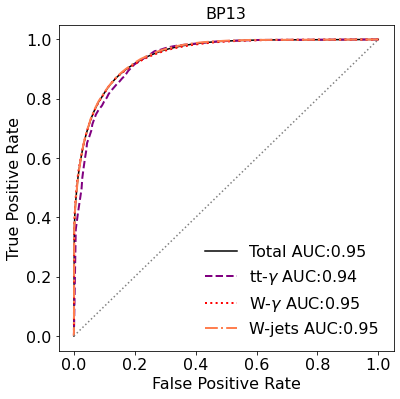

In [775]:
plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.plot(fpr_total, tpr_total, c = 'black', label = 'Total AUC:{:.2f}'.format(auc_total))
plt.plot(fpr_ttgamma, tpr_ttgamma, c = ttgamma_color, linestyle = '--', lw = 2, label = 'tt-$\gamma$ AUC:{:.2f}'.format(auc_ttgamma))
plt.plot(fpr_wgamma, tpr_wgamma, c = wgamma_color, linestyle = ':', lw = 2, label = 'W-$\gamma$ AUC:{:.2f}'.format(auc_wgamma))
plt.plot(fpr_wjets, tpr_wjets, c = wjets_color, linestyle = '-.', lw = 2, label = 'W-jets AUC:{:.2f}'.format(auc_wjets))
plt.legend(frameon=False,fontsize=16)
plt.ylabel("True Positive Rate",fontsize=16)
plt.xlabel("False Positive Rate",fontsize=16)
plt.plot([0,1],[0,1],ls=":",color="grey")
plt.title(r"BP" + str(bp + 1),fontsize=16)

plt.savefig('../graph/ROC_BP' + str(bp + 1) + '_All_MET200_new.png', bbox_inches='tight')

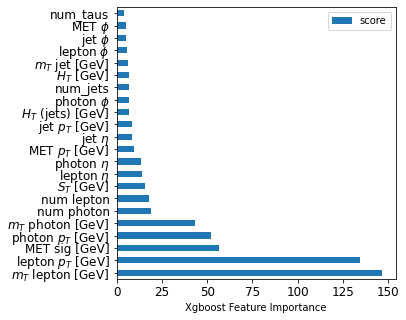

In [776]:
fig, ax = plt.subplots(figsize = (5,5))

feature_important = classifier.get_booster().get_score(importance_type='gain')
values = list(feature_important.values())

data = pd.DataFrame(data=values, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(len(lst) - 1, columns="score").plot(kind='barh', ax = ax) ## plot top 20 features

ax.set_xlabel("Xgboost Feature Importance")
ax.set_yticklabels(np.asarray(lst)[np.argsort(values)[::-1]])

plt.savefig('../graph/BP' + str(bp + 1) + '_featureImportance_All_MET200_new.png', bbox_inches='tight')

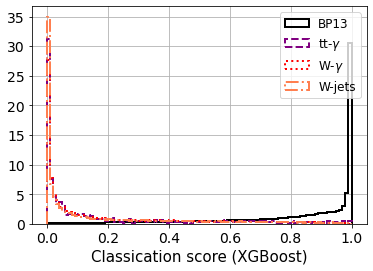

In [777]:
plt.hist(y_pred_xg[np.where(bkg_flag_test == 0)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = 'black', label = 'BP' + str(bp + 1), lw = 2)
plt.hist(y_pred_xg[np.where(bkg_flag_test == 3)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = ttgamma_color, linestyle = '--', lw = 2, label = 'tt-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 1)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wgamma_color, linestyle = ':', lw = 2, label = 'W-$\gamma$')
plt.hist(y_pred_xg[np.where(bkg_flag_test == 2)[0]], bins = 100, range=[0,1], histtype='step', density = True, color = wjets_color, linestyle = '-.', lw = 2, label = 'W-jets')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
#plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.savefig('../graph/MLOutput_dist_BP' + str(bp + 1) + '_All_MET200_new.png', bbox_inches="tight")

In [778]:
pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

In [779]:
len(np.where(bkg_flag_test != 0)[0])

37315

In [780]:
len(np.where(bkg_flag_test == 0)[0])

296324

In [781]:
S_expected[bp]

12.166326655999999

In [782]:
S_expected[bp] / np.sqrt(B_expected)

0.08104583322008858

In [783]:
print('MLL aproximated Z:')
print( MLL_aprox_discovery_ox(pred_XG_SM, pred_XG_NP, int(B_expected), int(S_expected[bp]))) 

MLL aproximated Z:
nan


/tmp/ipykernel_15927/1019789035.py:10: RuntimeWarning: invalid value encountered in double_scalars
  return (f0 + fB + fS)**0.5


## Sequential selection criteria

In [815]:
nbins = 10
indices_aux = np.arange(len(df_test_array))
        
n_np0      = len(np.where(df_test_array[:, 22] == 0)[0])
n_wgamma0  = len(np.where(df_test_array[:, 22] == 1)[0])
n_wjets0   = len(np.where(df_test_array[:, 22] == 2)[0])
n_ttgamma0 = len(np.where(df_test_array[:, 22] == 3)[0])

sup_cuts = {}
inf_cuts = {}
random_vars = np.random.choice(range(len(df_test.columns) - 2), size = 100, replace = True)
random_vars = np.concatenate((np.random.choice(range(len(df_test.columns) - 3), size = len(df_test.columns) - 3, replace = False), random_vars))
#random_vars = list(np.argsort(values)[::-1])*10

for ivar in random_vars:
    #print(indices_aux)
    cuts = np.linspace(np.min(df_test_array[indices_aux,ivar]), np.max(df_test_array[indices_aux,ivar]), nbins)
    Z_sup = np.zeros(nbins)
    Z_inf = np.zeros(nbins)

    indices = []
    Z = []
    for icut, cut in enumerate(cuts): 
        
        # Superior ------------------------------------------------------------------------------------
        indices_sup = indices_aux[np.where( (df_test_array[indices_aux,ivar] >= cut) )[0]]
        indices.append(indices_sup)
        n_np      = len(np.where(df_test_array[indices_sup, 22] == 0)[0])
        n_wgamma  = len(np.where(df_test_array[indices_sup, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_sup, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_sup, 22] == 3)[0])

        ttgamma_expected = ttgamma_cross * 1000 * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        wgamma_expected  = Wgamma_cross * 1000 * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = Wjets_cross * 1000 * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)


        S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + wgamma_expected + wjets_expected)
        #if B_expected > 5: Z_sup[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and (S_expected_aux > 5): 
            Z_sup[icut] = np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux))
            Z.append( np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)) )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------

        # Inferior ------------------------------------------------------------------------------------
        indices_inf = indices_aux[np.where( (df_test_array[indices_aux,ivar] <= cut) )[0]]
        indices.append(indices_inf)
        
        n_np      = len(np.where(df_test_array[indices_inf, 22] == 0)[0])
        n_wgamma  = len(np.where(df_test_array[indices_inf, 22] == 1)[0])
        n_wjets   = len(np.where(df_test_array[indices_inf, 22] == 2)[0])
        n_ttgamma = len(np.where(df_test_array[indices_inf, 22] == 3)[0])

        ttgamma_expected = ttgamma_cross * 1000 * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
        wgamma_expected  = Wgamma_cross * 1000 * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
        wjets_expected   = Wjets_cross * 1000 * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)

        S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

        # Formula discovery
        B_expected_aux = int(ttgamma_expected + wgamma_expected + wjets_expected)
        #if B_expected > 5: Z_inf[icut] = np.sqrt(2 * ((B_expected + S_expected) * np.log(1 + S_expected / B_expected) - S_expected))
        if (B_expected_aux > 5) and (S_expected_aux > 5): 
            Z_inf[icut] = np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux))
            Z.append( np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)) )
        else:
            Z.append(0)
        #----------------------------------------------------------------------------------------------------
    max_cut = np.argmax(np.asarray(Z))
    #print('Z = ' + str(Z[max_cut]))
    indices_aux = indices[max_cut]
    max_cut = np.argmax((Z_inf, Z_sup))
    if max_cut >= len(Z_inf):
        print(df_test.columns[ivar] + ' >= ' + str(cuts[max_cut - len(Z_sup)]) + '; Z = ' + str(Z_sup[max_cut - len(Z_inf)]))
    #%    indices_aux = indices_aux[np.where( (df_test_array[indices_aux,ivar] >= cuts[max_cut - len(Z_sup)]) )[0]]
        if df.columns[ivar] in inf_cuts.keys():
            inf_cuts[df_test.columns[ivar]] = cuts[max_cut - len(Z_sup)]
        inf_cuts.setdefault(df_test.columns[ivar], cuts[max_cut - len(Z_sup)])
        sup_cuts.setdefault(df_test.columns[ivar], 999999)
    else:
        print(df_test.columns[ivar] + ' <= ' + str(cuts[max_cut]) + '; Z = ' + str(Z_inf[max_cut]))
    #%    indices_aux = indices_aux[np.where( (df_array[indices_aux,ivar] <= cuts[max_cut]) )[0]]
        if df.columns[ivar] in sup_cuts.keys():
            sup_cuts[df_test.columns[ivar]] = cuts[max_cut]
        sup_cuts.setdefault(df_test.columns[ivar], cuts[max_cut])
        inf_cuts.setdefault(df_test.columns[ivar], -999999)   
    
    
n_np = len(np.where(df_test_array[indices_aux, 22] == 0)[0])

n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])

ttgamma_expected = ttgamma_cross * 1000 * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
wgamma_expected  = Wgamma_cross * 1000 * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
wjets_expected   = Wjets_cross * 1000 * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)

S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

# Formula discovery
B_expected_aux = int(ttgamma_expected + wgamma_expected + wjets_expected)
if (B_expected_aux > 5) and (S_expected_aux > 5): 
    print('\n')
    print('Z = ', np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)))
    print('Expected Background = ' + str(B_expected_aux))
    print('Expected Signal = ' + str(S_expected_aux))

$m_T$ photon [GeV] <= 723.9247176457878; Z = 0.08027339573669967
photon $\phi$ <= 3.142; Z = 0.08027339573669967
$H_T$ [GeV] <= 1543.9833333333336; Z = 0.08101638027923093
MET $\phi$ <= 3.142; Z = 0.08101638027923093
MET sig [GeV] >= 10.782244795077299; Z = 0.0877857473286791
lepton $\phi$ <= 3.142; Z = 0.0877857473286791
num_jets <= 4.0; Z = 0.09054935590209492
num_taus <= 1.1111111111111112; Z = 0.09055306828739652
jet $\eta$ >= -3.1053333333333333; Z = 0.09062741195773054
photon $p_T$ [GeV] <= 202.30333333333334; Z = 0.09159547640522304
$S_T$ [GeV] <= 1386.493333333333; Z = 0.09162238439678046
photon $\eta$ <= 2.369; Z = 0.09162238439678046
num lepton <= 2.0; Z = 0.09163007676026012
$m_T$ jet [GeV] <= 2490.9497878182533; Z = 0.09163007676026012
num photon <= 2.111111111111111; Z = 0.09163007676026012
$H_T$ (jets) [GeV] <= 1497.99; Z = 0.09163007676026012
MET $p_T$ [GeV] <= 1329.3588888888887; Z = 0.09163007676026012
jet $\phi$ <= 3.142; Z = 0.09163007676026012
jet $p_T$ [GeV] <= 134

In [785]:
sup_cuts

{'MET $p_T$ [GeV]': 948.3299999999999,
 'jet $\\eta$': 3.403,
 'lepton $\\eta$': 2.5,
 '$H_T$ (jets) [GeV]': 1036.87,
 'num_taus': 1.0,
 'MET $\\phi$': 3.142,
 'num_jets': 4.0,
 'lepton $\\phi$': 3.142,
 '$S_T$ [GeV]': 1076.7322222222222,
 '$H_T$ [GeV]': 1191.49,
 'photon $p_T$ [GeV]': 127.62,
 'num lepton': 1.0,
 'jet $p_T$ [GeV]': 1035.53,
 'photon $\\eta$': 2.369,
 'jet $\\phi$': 3.142,
 '$m_T$ jet [GeV]': 2063.10000035125,
 'MET sig [GeV]': 31.97120915839097,
 'lepton $p_T$ [GeV]': 84.69,
 '$m_T$ photon [GeV]': 355.2433515553605,
 'num photon': 1.0,
 'photon $\\phi$': 3.142,
 '$m_T$ lepton [GeV]': 353.7572409730344}

In [786]:
inf_cuts

{'MET $p_T$ [GeV]': -999999,
 'jet $\\eta$': -3.1160000000000005,
 'lepton $\\eta$': -999999,
 '$H_T$ (jets) [GeV]': -999999,
 'num_taus': -999999,
 'MET $\\phi$': -999999,
 'num_jets': -999999,
 'lepton $\\phi$': -999999,
 '$S_T$ [GeV]': -999999,
 '$H_T$ [GeV]': -999999,
 'photon $p_T$ [GeV]': -999999,
 'num lepton': 0.3333333333333333,
 'jet $p_T$ [GeV]': -999999,
 'photon $\\eta$': -999999,
 'jet $\\phi$': -999999,
 '$m_T$ jet [GeV]': 267.9662528856491,
 'MET sig [GeV]': 12.861742555601378,
 'lepton $p_T$ [GeV]': -999999,
 '$m_T$ photon [GeV]': 39.471483506151166,
 'num photon': -999999,
 'photon $\\phi$': -999999,
 '$m_T$ lepton [GeV]': -999999}

In [787]:
write = True
if write:
    with open('../data/cuts/BP' + str(bp+1) + '_supCuts_MET200.txt', "w") as fp:
        json.dump(sup_cuts, fp)

    with open('../data/cuts/BP' + str(bp+1) + '_infCuts_MET200.txt', "w") as fp:
        json.dump(inf_cuts, fp)
else:
    with open('../data/cuts/BP' + str(bp+1) + '_supCuts_MET200.txt', "r") as fp:
        # Load the dictionary from the file
        sup_cuts = json.load(fp)
    with open('../data/cuts/BP' + str(bp+1) + '_infCuts_MET200.txt', "r") as fp:
        # Load the dictionary from the file
        inf_cuts = json.load(fp)

In [788]:
indices_aux = np.arange(len(df_test_array))

variables = list(sup_cuts.keys())
for i in range(len(variables)):
    ind_var = np.where(df_test.columns == variables[i])[0][0]
    indices_aux = indices_aux[np.where( (df_test_array[indices_aux, ind_var] <= sup_cuts[variables[i]]) & 
                            (df_test_array[indices_aux, ind_var] > inf_cuts[variables[i]])
                           )[0]]


In [789]:
n_np = len(np.where(df_test_array[indices_aux, 22] == 0)[0])

n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])

ttgamma_expected = ttgamma_cross * 1000 * ttgamma_NLO * luminosidad * (n_ttgamma * ttgamma_aceptancia_init / n_ttgamma0)
wgamma_expected  = Wgamma_cross * 1000 * Wgamma_NLO * luminosidad * (n_wgamma * Wgamma_aceptancia_init / n_wgamma0)
wjets_expected   = Wjets_cross * 1000 * Wjets_NLO * luminosidad * (n_wjets * Wjets_aceptancia_init / n_wjets0)

S_expected_aux = int(cross[bp] * luminosidad * (n_np * aceptancia[bp] / n_np0))

# Formula discovery
B_expected_aux = int(ttgamma_expected + wgamma_expected + wjets_expected)
if (B_expected_aux >= 5) and (S_expected_aux >= 5): 
    print('\n')
    print('Z = ', np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux)))
    print('Expected Background = ' + str(B_expected_aux))
    print('Expected Signal = ' + str(S_expected_aux))



Z =  0.09434522890309598
Expected Background = 2807
Expected Signal = 5


In [790]:
nexperiments = 2000

SM_test_pool = np.where(df_test_array[:,23] == 0)[0]
NP_test_pool = np.where(df_test_array[:,23] == 1)[0]

q0_exp = np.zeros(nexperiments)
B_observed_exp = np.zeros(nexperiments)
S_observed_exp = np.zeros(nexperiments)
for nexp in tqdm(range(nexperiments)):
    # Let's create a pseudo-experiment
    SM_indices = np.random.choice(SM_test_pool, size = np.random.poisson(int(B_expected)), replace = False)
    NP_indices = np.random.choice(NP_test_pool, size = np.random.poisson(int(S_expected[bp])), replace = False)
    indices_aux = np.concatenate((NP_indices, SM_indices))

    #%print('At the beggining')
    #%print('\n')
    #%print('Total:' + str(len(indices_aux)))
    #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 23] == 1)[0])))
    #%print('SM:' + str(len(np.where(df_test_array[indices_aux, 23] == 0)[0])))
    #%print('wgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 1)[0])))
    #%print('ttgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 3)[0])))
    #%print('wjets:' + str(len(np.where(df_test_array[indices_aux, 22] == 2)[0])))
    #%print('\n')
    # Let's make the cuts

    variables = list(sup_cuts.keys())
    for i in range(len(variables)):
        #print(variables[i] + '<=' + str(sup_cuts[variables[i]]))
        #print(variables[i] + '>=' + str(inf_cuts[variables[i]]))
        ind_var = np.where(df_test.columns == variables[i])[0][0]
        indices_aux = indices_aux[np.where( (df_test_array[indices_aux, ind_var] <= sup_cuts[variables[i]]) & 
                                (df_test_array[indices_aux, ind_var] > inf_cuts[variables[i]])
                               )[0]]

        #%print('Total:' + str(len(indices_aux)))
        #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 23] == 1)[0])))
        #%print('SM:' + str(len(np.where(df_test_array[indices_aux, 23] == 0)[0])))
        #%print('wgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 1)[0])))
        #%print('ttgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 3)[0])))
        #%print('wjets:' + str(len(np.where(df_test_array[indices_aux, 22] == 2)[0])))
    # Let's calculate everything
    
    n_np = len(np.where(df_test_array[indices_aux, 22] == 0)[0])

    n_wgamma  = len(np.where(df_test_array[indices_aux, 22] == 1)[0])
    n_wjets   = len(np.where(df_test_array[indices_aux, 22] == 2)[0])
    n_ttgamma = len(np.where(df_test_array[indices_aux, 22] == 3)[0])

    #%print('At the end')
    #%print('\n')
    #%print('Total:' + str(len(indices_aux)))
    #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 23] == 1)[0])))
    #%print('NP:' + str(len(np.where(df_test_array[indices_aux, 22] == 0)[0])))
    #%print('SM:' + str(len(np.where(df_test_array[indices_aux, 23] == 0)[0])))
    #%print('wgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 1)[0])))
    #%print('ttgamma:' + str(len(np.where(df_test_array[indices_aux, 22] == 3)[0])))
    #%print('wjets:' + str(len(np.where(df_test_array[indices_aux, 22] == 2)[0])))
    #%print('\n')

    #S_expected_aux = n_np
    S_observed_exp[nexp] = n_np

    # Formula discovery
    B_observed_exp[nexp] = n_ttgamma + n_wgamma + n_wjets
    
    N_observed = n_np + n_ttgamma + n_wgamma + n_wjets
    if (B_expected_aux >= 5) and (S_expected_aux >= 5): 
        q0_exp[nexp] = -2 * N_observed * np.log(B_expected_aux / N_observed) -2 * (N_observed - B_expected_aux)
        #Z_exp[nexp] = np.sqrt(2 * ((B_expected_aux + S_expected_aux) * np.log(1 + S_expected_aux / B_expected_aux) - S_expected_aux))
        #%print('\n')
        #%print('Z = ', Z_exp[nexp])
        #%print('Expected Background = ' + str(B_expected_aux))
        #%print('Expected Signal = ' + str(S_expected_aux))
    else:
        q0_exp[nexp] = -99
        #print('Expected Background = ' + str(B_observed_exp))
        #print('Expected Signal = ' + str(S_observed_exp))
    #%print('------------------------------------------')
        

100%|██████████████████████████████████████████████████████████████| 2000/2000 [00:11<00:00, 172.71it/s]


(array([ 34., 275., 582., 306., 497., 218.,  47.,  34.,   6.,   1.]),
 array([ 0. ,  1.7,  3.4,  5.1,  6.8,  8.5, 10.2, 11.9, 13.6, 15.3, 17. ]),
 <BarContainer object of 10 artists>)

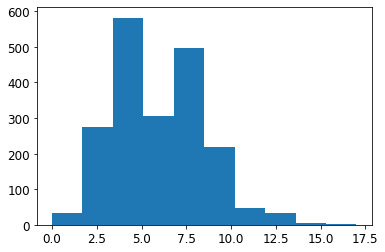

In [791]:
plt.hist(S_observed_exp)

In [792]:
print('Final results: for BP ' + str(bp+1) + '\n ')
print('Z = ' + str(np.sqrt(np.median(q0_exp))) + '; Z_std = ' + str(np.std(q0_exp) / (2 * np.sqrt(np.median(q0_exp)))))
print('B_exp = ' + str(np.mean(B_observed_exp)) + '; B_exp_std = ' + str(np.std(B_observed_exp)))
print('S_exp = ' + str(np.mean(S_observed_exp)) + '; S_exp_std = ' + str(np.std(S_observed_exp)))

Final results: for BP 13
 
Z = 0.4899860949870312; Z_std = 0.7540390172032031
B_exp = 2807.249; B_exp_std = 36.78003533168504
S_exp = 6.0115; S_exp_std = 2.4801951032126484


In [793]:
np.asarray(lst)[np.argsort(values)[::-1]][:4]

array(['$m_T$ lepton [GeV]', 'lepton $p_T$ [GeV]', 'MET sig [GeV]',
       'photon $p_T$ [GeV]'], dtype='<U18')

In [794]:
imp_vars = np.asarray(lst)[np.argsort(values)[::-1]][:4]
imp_vars = np.array(['lepton $p_T$ [GeV]', '$m_T$ lepton [GeV]','MET sig [GeV]', '$m_T$ photon [GeV]'])


In [795]:
imp_vars

array(['lepton $p_T$ [GeV]', '$m_T$ lepton [GeV]', 'MET sig [GeV]',
       '$m_T$ photon [GeV]'], dtype='<U18')

In [796]:
imp_vars_labels = ['$p_T^{\ell_{1}}$', '$m_T^{\ell_1}$',
                  '$E_T^{miss}/\sqrt{H_T}$', '$m_T^{\gamma_1}$']

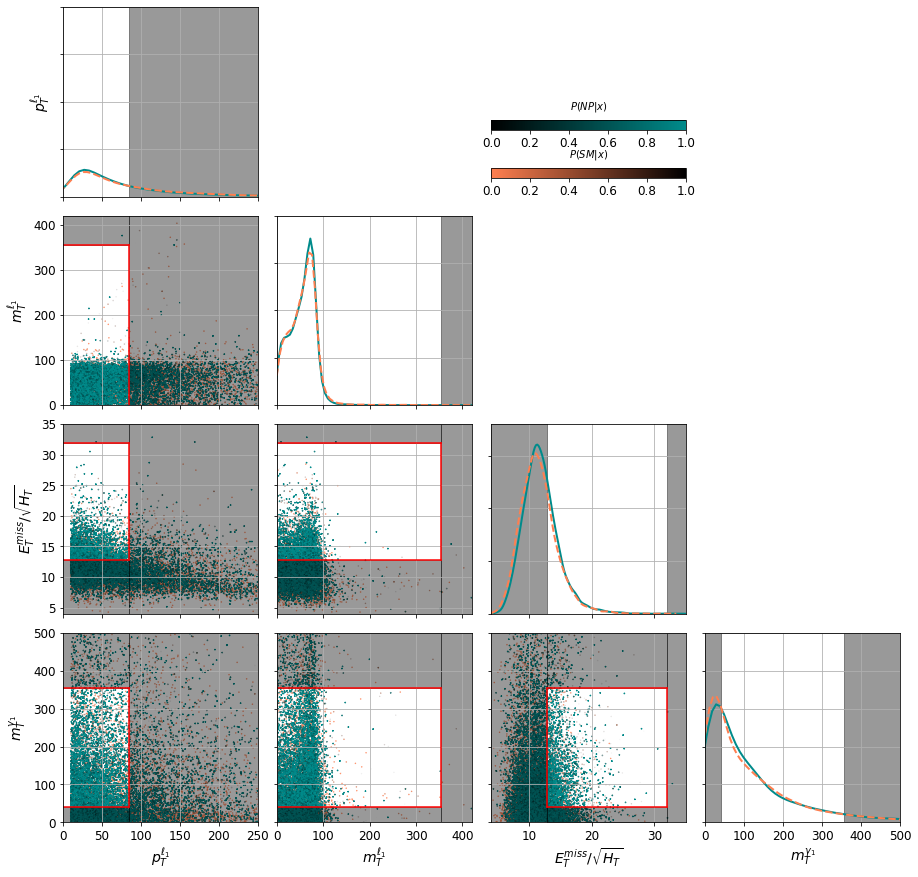

In [797]:
SM = df_test.loc[df_test['bkg_flag_pool'] != 0]
NP = df_test.loc[df_test['bkg_flag_pool'] == 1]

pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]

rand_ind = np.random.choice(range(len(NP)), size =  10000, replace = False)
NP = NP.iloc[rand_ind]
pred_XG_NP = pred_XG_NP[rand_ind]

rand_ind = np.random.choice(range(len(SM)), size =  10000, replace = False)
SM = SM.iloc[rand_ind]
pred_XG_SM = pred_XG_SM[rand_ind]

limites = [[0,250], [0,420], [4,35], [0,500]]
ylimites = [[0,0.08], [0,0.02], [0,0.18], [0,0.01]]

fig,ax = plt.subplots(4,4, figsize = (15,15), gridspec_kw={'hspace':0.1, 'wspace':0.1})

for i in range(4):
    for j in range(4):
        if i != 3: ax[i,j].set_xticklabels([])
        if j != 0: ax[i,j].set_yticklabels([])
        if i >= j:
            if i==j:
                sns.kdeplot(NP[imp_vars[i]], ax = ax[i,j], color = 'darkcyan', lw=2, ls = 'solid')
                sns.kdeplot(SM[imp_vars[i]], ax = ax[i,j], color = 'coral', lw=2, ls = '--')
                ax[i,j].set_ylabel('')
                ax[i,j].set_xlabel('')
                ax[i,j].set_xlim(limites[i])
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = sup_cuts[imp_vars[i]], x2 = 1000, color = 'black', alpha = 0.4)
                ax[i,j].fill_betweenx(y = [-1, 1], x1 = -1, x2 = inf_cuts[imp_vars[i]], color = 'black', alpha = 0.4)
                ax[i,j].set_ylim(ylimites[i])
            else:
                im_SM = ax[i,j].scatter(SM[imp_vars[j]], SM[imp_vars[i]], s = 0.8, marker = '.', 
                                        c = pred_XG_SM, cmap = SM_cmap, vmin = 0, vmax = 1, alpha = (1-pred_XG_SM))
                im_NP = ax[i,j].scatter(NP[imp_vars[j]], NP[imp_vars[i]], s = 0.8, marker = '*', 
                                        c = pred_XG_NP, cmap = NP_cmap, vmin = 0, vmax = 1, alpha = pred_XG_NP)
                ax[i,j].set_xlim(SM[imp_vars[j]].min(), SM[imp_vars[j]].max())
                ax[i,j].set_ylim(SM[imp_vars[i]].min(), SM[imp_vars[i]].max())
                ax[i,j].set_xlim(limites[j])
                ax[i,j].set_ylim(limites[i])
                ax[i,j].fill_betweenx(y = [-1, 10000], x1 = sup_cuts[imp_vars[j]], x2 = 1000, color = 'black', alpha = 0.4)
                ax[i,j].fill_betweenx(y = [-1, 10000], x1 = -1, x2 = inf_cuts[imp_vars[j]], color = 'black', alpha = 0.4)
                ax[i,j].fill_between(x = [inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]], y1 = sup_cuts[imp_vars[i]], y2 = 1000, color = 'black', alpha = 0.4)
                ax[i,j].fill_between(x = [inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]], y1 = -1, y2 = inf_cuts[imp_vars[i]], color = 'black', alpha = 0.4)
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], inf_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[sup_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([inf_cuts[imp_vars[j]], inf_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                ax[i,j].plot([sup_cuts[imp_vars[j]], sup_cuts[imp_vars[j]]],[inf_cuts[imp_vars[i]], sup_cuts[imp_vars[i]]], color = 'red')
                
            ax[i,j].grid(which = 'both')
        else:
            ax[i,j].axis('off')

ax[3,0].set_xlabel(imp_vars_labels[0], fontsize = 14)
ax[3,1].set_xlabel(imp_vars_labels[1], fontsize = 14)
ax[3,2].set_xlabel(imp_vars_labels[2], fontsize = 14)
ax[3,3].set_xlabel(imp_vars_labels[3], fontsize = 14)

ax[0,0].set_ylabel(imp_vars_labels[0], fontsize = 14)
ax[1,0].set_ylabel(imp_vars_labels[1], fontsize = 14)
ax[2,0].set_ylabel(imp_vars_labels[2], fontsize = 14)
ax[3,0].set_ylabel(imp_vars_labels[3], fontsize = 14)

ax[0,0].set_xticklabels([])

ax[1,1].set_yticklabels([])
ax[1,1].set_xticklabels([])

ax[2,2].set_yticklabels([])
ax[2,2].set_xticklabels([])

ax[3,3].set_yticklabels([])
ax[0,0].set_yticklabels([])

cbar_SM = plt.colorbar(im_SM, ax = ax[0,2], orientation = 'horizontal')
cbar_SM.set_label('$P(SM|x)$', labelpad=-50)
cbar_NP = plt.colorbar(im_NP, ax = ax[0,2], orientation = 'horizontal')
cbar_NP.set_label('$P(NP|x)$', labelpad=-50)

plt.savefig('../graph/BP' + str(bp+1) + '/ImpVars_dist_MET200.pdf')

## BinnedLikelihood

In [798]:
pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]
print(pred_XG_SM.shape)
print(pred_XG_NP.shape)

(37315,)
(296324,)


In [799]:
B_expected = int(B_expected)

In [800]:
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]] # range of our data (between 0 and 1 if its the ML output)

bins_to_test=range(1,500) # number of bins we are testing to see if condition holds

# FIND THE NUMBER OF BINS:
num_bins = max_num_bins(pred_XG_SM, int(B_expected), range_dat, MIN_EVS, bins_to_test)

print('\n FOR BIN LIKELIHOOD WE ARE SETTING:')
print('min number of Background events allowed per bin: ', MIN_EVS)
print('number of bins we are going to use: ', num_bins)
print('range of our data: ', range_dat)

At least 5 B events per bin, range = [[0, 1]]:
# bins:  141 OK

 FOR BIN LIKELIHOOD WE ARE SETTING:
min number of Background events allowed per bin:  5
number of bins we are going to use:  141
range of our data:  [[0, 1]]


In [801]:
# Z Poisson Bin Likelihood (Asimov data set)
D_or_E = 'discovery'
store_Z_asimov = []

Z_asimov = Z_BL_asimov(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), 25, range_dat, MIN_EVS, linear_bins=True) 
store_Z_asimov.append( Z_asimov )
    
    
print('\n FINAL RESULT for BP' + str(bp+1) + ':\n')
print(store_Z_asimov)


 FINAL RESULT for BP13:

[0.6263450671396652]


B_expected:  22535
S_expected:  12.166326655999999

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


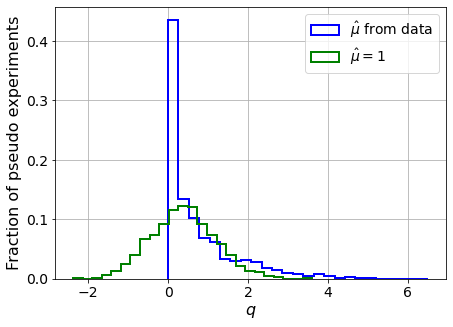

muhat mean:  1.004375
Z_bins:  0.6048460585012871
std Z_bins:  0.7864055376982371
Z_bins mu=0:  0.6055396683485552
std Z_bins mu=0:  0.6760328083142788

--------


 FINAL RESULT:

[[0.6048460585012871, 0.7864055376982371, 1.004375, 0.6055396683485552, 0.6760328083142788]]


In [802]:
# requested number of pseudo experiments
num_pseudo = 2000

# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
store_Z_BL = []

    
print('B_expected: ', B_expected)
print('S_expected: ', S_expected[bp])
print('')

#Z_BL = BL_test_fast(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True, path = '../graph/BP' + str(bp+1) + '/') 
Z_BL = BL_test_fast(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True) 

store_Z_BL.append( list(Z_BL) )

print('muhat mean: ', Z_BL[2])
print('Z_bins: ', Z_BL[0])
print('std Z_bins: ', Z_BL[1])
print('Z_bins mu=0: ', Z_BL[3])
print('std Z_bins mu=0: ', Z_BL[4])
print('')
print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)

B_expected:  22535
S_expected:  12.166326655999999

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


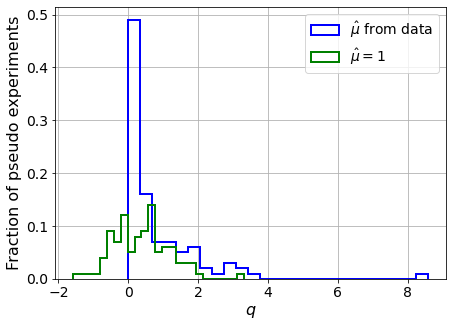

muhat mean:  1.0374543619827086
Z_bins:  0.6429211125086812
std Z_bins:  0.9162986362844728
Z_bins mu=0:  0.6423624096342999
std Z_bins mu=0:  0.6302859257342701

--------


 FINAL RESULT:

[[0.6429211125086812, 0.9162986362844728, 1.0374543619827086, 0.6423624096342999, 0.6302859257342701]]


In [803]:
# requested number of pseudo experiments
num_pseudo = 100

# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
store_Z_BL = []

    
print('B_expected: ', B_expected)
print('S_expected: ', S_expected[bp])
print('')

#Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True, path = '../graph/BP' + str(bp+1) + '/') 
Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, MIN_EVS, linear_bins=True) 

store_Z_BL.append( list(Z_BL) )

print('muhat mean: ', Z_BL[2])
print('Z_bins: ', Z_BL[0])
print('std Z_bins: ', Z_BL[1])
print('Z_bins mu=0: ', Z_BL[3])
print('std Z_bins mu=0: ', Z_BL[4])
print('')
print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)

## loop pseudo exps. Fix ML and KDE

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf  2711.37220722
  2605.76672645  2471.96687306  2306.72883689  2125.62295396
  1898.01806677  1601.62075194  1251.22505673   832.27001277
   322.35403716  -285.61482491 -1023.87015973 -2093.690537  ]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf           -inf


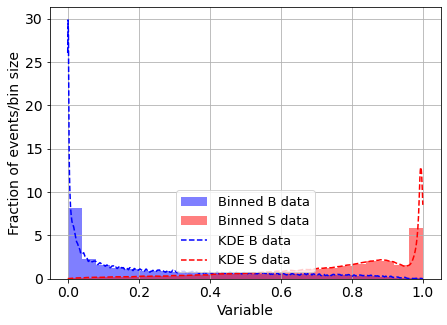

KDE Kernel:  epanechnikov
Background bandwidth:  0.0031053121543406503
Signal bandwidth:  0.008287452507534925


In [175]:
# USE KDE TO ESTIMATE THE CLASSIFIER OUTPUT PDFs

# outputs:
# 1st -> background PDF
# 2nd -> signal PDF
# 3rd -> (normalization factor of the background PDF)**-1
# 4th -> (normalization factor of the signal PDF)**-1
# 5th -> background bandwidth
# 6th -> signal bandwidth
kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                        20000, # Numero de datos para fitear
                                                                                        np.logspace(-4.0, 0.05, 20), 
                                                                                        set_kernel='epanechnikov')

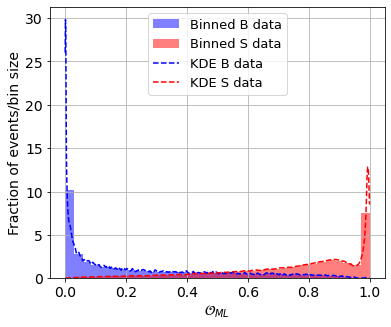

In [176]:
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

# points
s_vals = np.linspace(min_val,max_val,1000)

# evaluate the PDFs for each value of s
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )

# normalize
dens_bkg = dens_bkg / norm_factor_SM
dens_sig = dens_sig / norm_factor_NP

plt.figure(figsize=(6,5))

plt.hist(pred_XG_SM, 35, range=[min_val,max_val], density=True, color='blue',alpha=0.5, linewidth=2, label=r'Binned B data');
plt.hist(pred_XG_NP, 35, range=[min_val,max_val], density=True, color='red',alpha=0.5, linewidth=2, label=r'Binned S data');

plt.plot(s_vals, dens_bkg, color='blue',label=r'KDE B data',linestyle='dashed');
plt.plot(s_vals, dens_sig, color='red',label=r'KDE S data',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.yscale('log')
plt.xlabel("$\mathcal{O}_{ML}$",fontsize=14)
plt.ylabel("Fraction of events/bin size",fontsize=14)
plt.grid()
plt.legend(loc='upper center',fontsize=13)

plt.savefig('../graph/KDE_fit_BP' + str(bp+1) + '_MET200.pdf')

In [177]:
print(norm_factor_SM)
print(norm_factor_NP)

266.14753662758187
100.28423277903755


In [178]:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

print('This may take a while...')

pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
print('1 done')
pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
print('2 done')

# Normalize
pB_B_data = pB_B_data / norm_factor_SM
pS_B_data = pS_B_data / norm_factor_NP

This may take a while...
1 done
2 done


In [179]:
# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
print('3 done')
pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
print('4 done')

# Normalize
pB_S_data = pB_S_data / norm_factor_SM
pS_S_data = pS_S_data / norm_factor_NP
   

3 done
4 done


(array([58814., 60445.,  2955.,  2069.,  1720.,  1353.,  1268.,  3061.,
         5951., 13132.]),
 array([ 0.01698118,  1.30242448,  2.58786778,  3.87331107,  5.15875437,
         6.44419767,  7.72964097,  9.01508427, 10.30052756, 11.58597086,
        12.87141416]),
 [<matplotlib.patches.Polygon at 0x7efd5342bd60>])

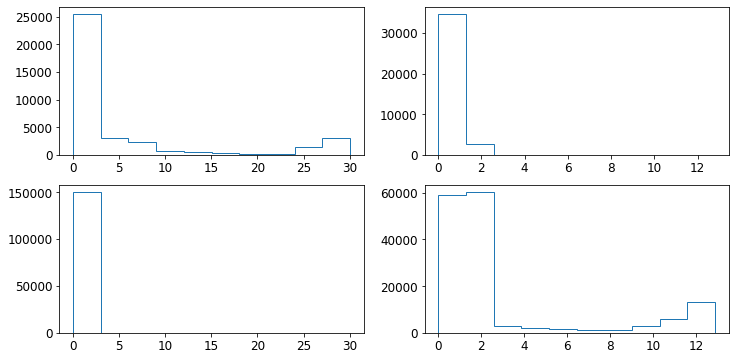

In [180]:
fig,ax = plt.subplots(2,2, figsize = (12,6))

ax[0,0].hist(pB_B_data, histtype = 'step')
ax[0,1].hist(pS_B_data, histtype = 'step')

ax[1,0].hist(pB_S_data, histtype = 'step')
ax[1,1].hist(pS_S_data, histtype = 'step')

In [181]:
# indeces (to later build a random pseudo experiment)
indices_B = [i for i in range(len(pS_B_data))]
indices_S = [i for i in range(len(pS_S_data))]
        
        

In [182]:
# loop over the number of pseudo experiments
#np.random.seed(91218)
Z_MLL = []
Z_MLL_std = []
Z_MLL_mu = []
Z_MLL_std_mu = []
for iloop in range(3): 
    print(iloop)
    muhat_selected_MLL_list = []
    q_muhat_MLL = []
    q_muhat_MLL_mu = []
    for its in tqdm(range(200)):

        # this pseudo-exp has B_rand number of B events
        B_rand = np.random.poisson(int(B_expected))

        ran_ind = np.random.choice(indices_B, B_rand)

        pB_B_data_shuf = []
        pS_B_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_B_data_shuf.append(pB_B_data[i])
            pS_B_data_shuf.append(pS_B_data[i])

        pB_B_data_shuf  = np.array(pB_B_data_shuf)
        pS_B_data_shuf  = np.array(pS_B_data_shuf)



        # this pseudo-exp has S_rand number of S events
        S_rand = np.random.poisson(int(S_expected[bp]))

        ran_ind = np.random.choice(indices_S, S_rand)

        pB_S_data_shuf = []
        pS_S_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_S_data_shuf.append(pB_S_data[i])
            pS_S_data_shuf.append(pS_S_data[i])

        pB_S_data_shuf  = np.array(pB_S_data_shuf)
        pS_S_data_shuf  = np.array(pS_S_data_shuf)

        # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
        prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

        # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
        prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])



        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

        # approximation: mu_hat=1 (discovery)
        q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



        # ESTIMATE mu_hat for this particular ensemble (implicit equation)
        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        # reference points
        sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


        # we need (implicit eq. for mu_hat) = 1
        # conditions considering the reference points
        if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
            print('muhat = 2.1')
            muhat_selected_MLL = 2.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
            print('muhat = -0.1')
            muhat_selected_MLL = -0.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif sum_muhat_zero < 1 < sum_muhat_two:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break

        elif sum_muhat_two < 1 < sum_muhat_zero:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break


        # save the computed mu_hat (within range) for each pseudo_experiment
        muhat_selected_MLL_list.append(muhat_selected_MLL)


        # compute the test statistic for each pseudo_exp considering mu_hat
        if muhat_selected_MLL > 0:
            q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

        else:
            q_muhat_MLL.append( 0 )
            
    

    # With the calculation of mu_hat
    muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
    Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
    Z_MLL.append( Z_MLL_aux )
    Z_MLL_std.append( np.std(q_muhat_MLL) / (2.*Z_MLL_aux) )


    # With the approximation of mu_hat
    Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
    Z_MLL_mu.append( Z_MLL_mu_aux )
    Z_MLL_std_mu.append( np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux) )

0


  4%|██▋                                                                 | 8/200 [00:02<00:52,  3.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3720336407504086
<p_{s}(Sdata)> = 2.964722663540827
<p_{b}(Bdata)> = 5.592528319237187
<p_{s}(Bdata)> = 0.40504091570382283


100%|██████████████████████████████████████████████████████████████████| 200/200 [00:58<00:00,  3.42it/s]


1


100%|██████████████████████████████████████████████████████████████████| 200/200 [01:02<00:00,  3.21it/s]


2


 48%|████████████████████████████████▏                                  | 96/200 [00:27<00:28,  3.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5363417464870184
<p_{s}(Sdata)> = 2.1614090995550552
<p_{b}(Bdata)> = 5.595212159875739
<p_{s}(Bdata)> = 0.4057559256839425


 50%|█████████████████████████████████▏                                 | 99/200 [00:28<00:27,  3.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5139697625411936
<p_{s}(Sdata)> = 2.532399185603165
<p_{b}(Bdata)> = 5.623472240825144
<p_{s}(Bdata)> = 0.4034399653275438


100%|██████████████████████████████████████████████████████████████████| 200/200 [00:57<00:00,  3.49it/s]


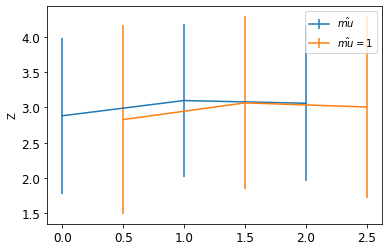

In [185]:
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL))
plt.errorbar(np.arange(len(Z_MLL)), np.asarray(Z_MLL), np.asarray(Z_MLL_std), label = '$\hat{mu}$')
plt.errorbar(np.arange(len(Z_MLL_mu)) + 0.5, np.asarray(Z_MLL_mu), np.asarray(Z_MLL_std_mu), label =  '$\hat{mu} = 1$')
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL_mu))
plt.legend()
plt.ylabel('Z')
plt.savefig('../graph/loopBP' + str(bp+1) + '_KDEfijo_MET200.pdf')

In [192]:
print('Z_MLL BP' + str(bp+1) + ': ' + str(np.mean(Z_MLL)) + ' +/- ' + str(np.std(Z_MLL))+
      ' +/- ' + str(np.mean(Z_MLL_std)))

Z_MLL BP1: 3.013632929980421 +/- 0.09409184220745251 +/- 1.098003789029043


## Loop varying KDE

In [ ]:
B_expected

In [ ]:
Z_MLL = []
Z_MLL_std = []
Z_MLL_mu = []
Z_MLL_std_mu = []
for iloop in range(20):
    print(iloop)
    kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                            50000, # Numero de datos para fitear
                                                                                            np.logspace(-4.0, 0.05, 20), 
                                                                                            set_kernel='epanechnikov')
    print('This may take a while...')

    pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
    print('1 done')
    pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
    print('2 done')

    # Normalize
    pB_B_data = pB_B_data / norm_factor_SM
    pS_B_data = pS_B_data / norm_factor_NP
    
    pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
    print('3 done')
    pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
    print('4 done')

    # Normalize
    pB_S_data = pB_S_data / norm_factor_SM
    pS_S_data = pS_S_data / norm_factor_NP
    
    # indeces (to later build a random pseudo experiment)
    indices_B = [i for i in range(len(pS_B_data))]
    indices_S = [i for i in range(len(pS_S_data))]
    # loop over the number of pseudo experiments
    #np.random.seed(91218)

    muhat_selected_MLL_list = []
    q_muhat_MLL = []
    q_muhat_MLL_mu = []
    for its in tqdm(range(50)):

        # this pseudo-exp has B_rand number of B events
        B_rand = np.random.poisson(int(B_expected))

        ran_ind = np.random.choice(indices_B, B_rand)

        pB_B_data_shuf = []
        pS_B_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_B_data_shuf.append(pB_B_data[i])
            pS_B_data_shuf.append(pS_B_data[i])

        pB_B_data_shuf  = np.array(pB_B_data_shuf)
        pS_B_data_shuf  = np.array(pS_B_data_shuf)



        # this pseudo-exp has S_rand number of S events
        S_rand = np.random.poisson(int(S_expected[bp]))

        ran_ind = np.random.choice(indices_S, S_rand)

        pB_S_data_shuf = []
        pS_S_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_S_data_shuf.append(pB_S_data[i])
            pS_S_data_shuf.append(pS_S_data[i])

        pB_S_data_shuf  = np.array(pB_S_data_shuf)
        pS_S_data_shuf  = np.array(pS_S_data_shuf)

        # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
        prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

        # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
        prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])



        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

        # approximation: mu_hat=1 (discovery)
        q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



        # ESTIMATE mu_hat for this particular ensemble (implicit equation)
        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        # reference points
        sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


        # we need (implicit eq. for mu_hat) = 1
        # conditions considering the reference points
        if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
            print('muhat = 2.1')
            muhat_selected_MLL = 2.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
            print('muhat = -0.1')
            muhat_selected_MLL = -0.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif sum_muhat_zero < 1 < sum_muhat_two:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break

        elif sum_muhat_two < 1 < sum_muhat_zero:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break


        # save the computed mu_hat (within range) for each pseudo_experiment
        muhat_selected_MLL_list.append(muhat_selected_MLL)


        # compute the test statistic for each pseudo_exp considering mu_hat
        if muhat_selected_MLL > 0:
            q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

        else:
            q_muhat_MLL.append( 0 )



    # With the calculation of mu_hat
    muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
    Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
    Z_MLL.append( Z_MLL_aux )
    Z_MLL_std.append( np.std(q_muhat_MLL) / (2.*Z_MLL_aux) )


    # With the approximation of mu_hat
    Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
    Z_MLL_mu.append( Z_MLL_mu_aux )
    Z_MLL_std_mu.append( np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux) )

In [ ]:
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL))
plt.errorbar(np.arange(len(Z_MLL)), np.asarray(Z_MLL), np.asarray(Z_MLL_std), label = '$\hat{mu}$')
plt.errorbar(np.arange(len(Z_MLL_mu)) + 0.5, np.asarray(Z_MLL_mu), np.asarray(Z_MLL_std_mu), label =  '$\hat{mu} = 1$')
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL_mu))
plt.legend()
plt.ylabel('Z')
plt.savefig('../graph/loopBP6_50000_KDEvariable__MET200.pdf')

## loop varying ML

In [804]:
lst = ['photon $p_T$ [GeV]', 'photon $\eta$', 'photon $\phi$', 'num photon',
       'jet $p_T$ [GeV]', 'jet $\eta$', 'jet $\phi$',
       'lepton $p_T$ [GeV]', 'lepton $\eta$', 'lepton $\phi$', 'num lepton', 'num_taus',
       'MET $p_T$ [GeV]', 'MET $\phi$',
       '$H_T$ [GeV]', '$H_T$ (jets) [GeV]', 'num_jets',
       '$S_T$ [GeV]', 
       'MET sig [GeV]',# '$m_{eff}$ [GeV]',
       '$m_T$ photon [GeV]', '$m_T$ jet [GeV]', '$m_T$ lepton [GeV]',
       #'$\Delta \phi$ (MET-photon)', '$\Delta \phi$ (MET-jet)', '$\Delta \phi$ (MET-lepton)', 
       #'$\Delta R$ (photon-jet)', '$\Delta R$ (photon-lepton)', '$\Delta R$ (lepton-jet)', 
       'SM=0 - NP=1']

0
AUC:0.9456032111013946
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


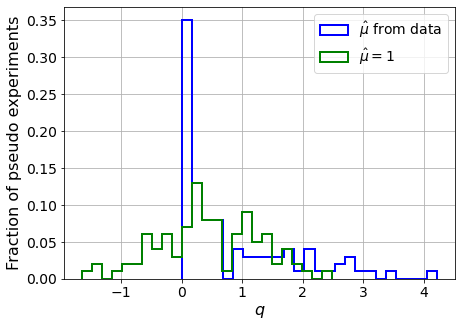

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  8899.58015008  8701.7059957   8446.81064187
  8123.10419514  7727.4341175   7240.8172263   6653.30575457
  5949.78227616  5123.1152897   4147.92757549  2993.23376945
  1624.24545715    53.00372926 -1659.39288918 -3819.33300855]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf 11152.40916023 11017.82286514 10756.70069398


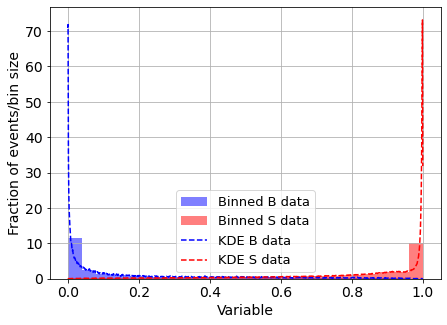

KDE Kernel:  epanechnikov
Background bandwidth:  0.0011635618505359071
Signal bandwidth:  0.0011635618505359071
This may take a while...
1 done
2 done
3 done
4 done


  1%|▎                                                                 | 11/2000 [00:02<07:56,  4.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30247737487642
<p_{s}(Sdata)> = 2.93742371056161
<p_{b}(Bdata)> = 15.852414195410084
<p_{s}(Bdata)> = 0.2641814140936111


  1%|▍                                                                 | 15/2000 [00:03<06:27,  5.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2758868550408765
<p_{s}(Sdata)> = 2.582608253875619
<p_{b}(Bdata)> = 15.882087611846904
<p_{s}(Bdata)> = 0.25999078629094674


  1%|▋                                                                 | 21/2000 [00:05<06:14,  5.29it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14361086617627614
<p_{s}(Sdata)> = 22.41305695932007
<p_{b}(Bdata)> = 15.966063099737235
<p_{s}(Bdata)> = 0.2745829601852739
muhat = 2.1
<p_{b}(Sdata)> = 0.24437929545579107
<p_{s}(Sdata)> = 23.177676742988588
<p_{b}(Bdata)> = 16.016595921254833
<p_{s}(Bdata)> = 0.26729870117069493
muhat = -0.1
<p_{b}(Sdata)> = 0.23197933055365566
<p_{s}(Sdata)> = 8.383609088633516
<p_{b}(Bdata)> = 15.935759339726465
<p_{s}(Bdata)> = 0.2584759461453754


  1%|▊                                                                 | 23/2000 [00:05<06:33,  5.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3865038714463647
<p_{s}(Sdata)> = 8.738663972890942
<p_{b}(Bdata)> = 15.874314669778324
<p_{s}(Bdata)> = 0.2626501118276193


  1%|▉                                                                 | 27/2000 [00:06<07:07,  4.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.8710566138728261
<p_{s}(Sdata)> = 5.871113990714259
<p_{b}(Bdata)> = 16.197188789816455
<p_{s}(Bdata)> = 0.2525961504775772


  2%|█▏                                                                | 35/2000 [00:08<09:24,  3.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23847404643492595
<p_{s}(Sdata)> = 3.414998364011671
<p_{b}(Bdata)> = 15.698786661037039
<p_{s}(Bdata)> = 0.26679721160996545


  2%|█▎                                                                | 38/2000 [00:09<09:00,  3.63it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1906113183112621
<p_{s}(Sdata)> = 16.28299198109946
<p_{b}(Bdata)> = 15.813510762753358
<p_{s}(Bdata)> = 0.2721172500013112


  2%|█▍                                                                | 43/2000 [00:10<06:02,  5.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15831709354612533
<p_{s}(Sdata)> = 13.939608880635603
<p_{b}(Bdata)> = 15.722412561063807
<p_{s}(Bdata)> = 0.2605739765620741
muhat = 2.1
<p_{b}(Sdata)> = 0.3836472804359777
<p_{s}(Sdata)> = 8.79631617991826
<p_{b}(Bdata)> = 15.617204788465186
<p_{s}(Bdata)> = 0.2876274730494703


  2%|█▌                                                                | 46/2000 [00:10<05:47,  5.62it/s]

muhat = 2.1
<p_{b}(Sdata)> = 1.405242454477751
<p_{s}(Sdata)> = 9.288540302388956
<p_{b}(Bdata)> = 15.812541720345964
<p_{s}(Bdata)> = 0.27941070569445203
muhat = 2.1
<p_{b}(Sdata)> = 0.11841447925596327
<p_{s}(Sdata)> = 19.677411492970535
<p_{b}(Bdata)> = 15.671136030664398
<p_{s}(Bdata)> = 0.27264112555516
muhat = -0.1
<p_{b}(Sdata)> = 0.3125557000106071
<p_{s}(Sdata)> = 25.54140050646028
<p_{b}(Bdata)> = 15.888066938876804
<p_{s}(Bdata)> = 0.2511232770240823


  2%|█▌                                                                | 48/2000 [00:10<04:40,  6.97it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.297121875484941
<p_{s}(Sdata)> = 14.714228068962234
<p_{b}(Bdata)> = 16.047057578733575
<p_{s}(Bdata)> = 0.2745540406317898


  2%|█▌                                                                | 49/2000 [00:11<05:39,  5.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21731559303760456
<p_{s}(Sdata)> = 8.318843449288956
<p_{b}(Bdata)> = 16.134061720406887
<p_{s}(Bdata)> = 0.26021394128080927


  3%|█▊                                                                | 56/2000 [00:13<08:20,  3.88it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19772716897569223
<p_{s}(Sdata)> = 29.51317849407609
<p_{b}(Bdata)> = 16.0300915328741
<p_{s}(Bdata)> = 0.273913621572348


  3%|██                                                                | 64/2000 [00:15<12:22,  2.61it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22479947791515376
<p_{s}(Sdata)> = 16.745794755978714
<p_{b}(Bdata)> = 16.2291808897144
<p_{s}(Bdata)> = 0.2760474549427569


  3%|██▏                                                               | 68/2000 [00:16<07:39,  4.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16755062090914377
<p_{s}(Sdata)> = 14.795481882654629
<p_{b}(Bdata)> = 16.010611563207153
<p_{s}(Bdata)> = 0.2596131911723983
muhat = -0.1
<p_{b}(Sdata)> = 0.28017135796886183
<p_{s}(Sdata)> = 8.467214827142493
<p_{b}(Bdata)> = 15.937601258555912
<p_{s}(Bdata)> = 0.2581562082055488
muhat = -0.1
<p_{b}(Sdata)> = 0.7957912447942305
<p_{s}(Sdata)> = 12.935803018369292
<p_{b}(Bdata)> = 15.639368659263306
<p_{s}(Bdata)> = 0.2575951623811953


  4%|██▍                                                               | 73/2000 [00:18<10:34,  3.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23407380159433952
<p_{s}(Sdata)> = 13.94136811122836
<p_{b}(Bdata)> = 15.8330979872332
<p_{s}(Bdata)> = 0.2706925641738294


  4%|██▋                                                               | 80/2000 [00:20<09:04,  3.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20898811526437583
<p_{s}(Sdata)> = 10.238780490227658
<p_{b}(Bdata)> = 16.022256947458807
<p_{s}(Bdata)> = 0.26121216158593386


  4%|██▋                                                               | 82/2000 [00:20<08:03,  3.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20476353687887627
<p_{s}(Sdata)> = 12.683523608676476
<p_{b}(Bdata)> = 16.018072354514004
<p_{s}(Bdata)> = 0.2592353912641789


  4%|██▉                                                               | 88/2000 [00:21<07:06,  4.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21925488854897762
<p_{s}(Sdata)> = 9.369956654300186
<p_{b}(Bdata)> = 16.21693738484978
<p_{s}(Bdata)> = 0.25572634989545084


  5%|███▍                                                             | 105/2000 [00:26<05:30,  5.73it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15762960979118318
<p_{s}(Sdata)> = 13.405444678044038
<p_{b}(Bdata)> = 15.799202186613698
<p_{s}(Bdata)> = 0.2701861451582075
muhat = -0.1
<p_{b}(Sdata)> = 0.1835816063072371
<p_{s}(Sdata)> = 11.27364989914334
<p_{b}(Bdata)> = 15.860297650905292
<p_{s}(Bdata)> = 0.2559943909733531


  5%|███▍                                                             | 106/2000 [00:26<07:24,  4.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1896718430107996
<p_{s}(Sdata)> = 9.779399882240833
<p_{b}(Bdata)> = 15.994332433894783
<p_{s}(Bdata)> = 0.259316307572409


  6%|███▋                                                             | 114/2000 [00:28<08:42,  3.61it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18720891809273077
<p_{s}(Sdata)> = 17.01646544482163
<p_{b}(Bdata)> = 15.745555528716826
<p_{s}(Bdata)> = 0.278865767598835


  6%|███▊                                                             | 117/2000 [00:29<06:33,  4.78it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1775388316208238
<p_{s}(Sdata)> = 12.995925226390291
<p_{b}(Bdata)> = 16.12909578371179
<p_{s}(Bdata)> = 0.2754251693972192


  6%|███▉                                                             | 122/2000 [00:30<05:24,  5.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2586824646115396
<p_{s}(Sdata)> = 1.6382196254699726
<p_{b}(Bdata)> = 15.966996711546509
<p_{s}(Bdata)> = 0.2621038524399915
muhat = 2.1
<p_{b}(Sdata)> = 0.24742129356004816
<p_{s}(Sdata)> = 19.111467714356678
<p_{b}(Bdata)> = 15.869520103965344
<p_{s}(Bdata)> = 0.27489589180822593
muhat = 2.1
<p_{b}(Sdata)> = 0.253268888673193
<p_{s}(Sdata)> = 20.192431135351587
<p_{b}(Bdata)> = 15.90254092333694
<p_{s}(Bdata)> = 0.2738003259468142


  6%|████                                                             | 124/2000 [00:30<04:21,  7.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2557784601538807
<p_{s}(Sdata)> = 5.199190864822801
<p_{b}(Bdata)> = 16.055014192311607
<p_{s}(Bdata)> = 0.2620000267487142


  6%|████▏                                                            | 128/2000 [00:31<07:39,  4.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.232843199333861
<p_{s}(Sdata)> = 9.068438348921964
<p_{b}(Bdata)> = 15.608917786592844
<p_{s}(Bdata)> = 0.26089619352048155


  7%|████▎                                                            | 133/2000 [00:32<05:14,  5.93it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21033631545896983
<p_{s}(Sdata)> = 22.73744421583263
<p_{b}(Bdata)> = 16.052154612948634
<p_{s}(Bdata)> = 0.284362541100626
muhat = -0.1
<p_{b}(Sdata)> = 0.45392093978396475
<p_{s}(Sdata)> = 6.610375146822931
<p_{b}(Bdata)> = 15.864979394602187
<p_{s}(Bdata)> = 0.2633178291172211


  7%|████▍                                                            | 135/2000 [00:32<05:40,  5.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.12830545656801895
<p_{s}(Sdata)> = 15.758345685947003
<p_{b}(Bdata)> = 15.817727757500547
<p_{s}(Bdata)> = 0.2580373797056029


  7%|████▍                                                            | 137/2000 [00:32<05:31,  5.62it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21775716060060188
<p_{s}(Sdata)> = 18.010173193989097
<p_{b}(Bdata)> = 15.554931662409125
<p_{s}(Bdata)> = 0.26846548283653326


  7%|████▌                                                            | 141/2000 [00:33<04:37,  6.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25957183135343137
<p_{s}(Sdata)> = 0.7938414857683413
<p_{b}(Bdata)> = 15.878336353737366
<p_{s}(Bdata)> = 0.25975952383487505
muhat = -0.1
<p_{b}(Sdata)> = 0.11586409343620653
<p_{s}(Sdata)> = 15.64717049449315
<p_{b}(Bdata)> = 16.008950632516047
<p_{s}(Bdata)> = 0.25457958464415414


  7%|████▋                                                            | 144/2000 [00:34<05:03,  6.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1581396704514706
<p_{s}(Sdata)> = 19.395787801486623
<p_{b}(Bdata)> = 15.870792111328873
<p_{s}(Bdata)> = 0.26475404310046463
muhat = -0.1
<p_{b}(Sdata)> = 0.1979861796957772
<p_{s}(Sdata)> = 13.068403070601633
<p_{b}(Bdata)> = 15.665406795380878
<p_{s}(Bdata)> = 0.25556086110542076


  7%|████▊                                                            | 149/2000 [00:34<04:13,  7.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3274675351731007
<p_{s}(Sdata)> = 7.88360259950872
<p_{b}(Bdata)> = 15.670313401063304
<p_{s}(Bdata)> = 0.26234575645837105
muhat = -0.1
<p_{b}(Sdata)> = 0.3505528456642751
<p_{s}(Sdata)> = 8.216207810852708
<p_{b}(Bdata)> = 15.598898584262107
<p_{s}(Bdata)> = 0.2631774450695425
muhat = -0.1
<p_{b}(Sdata)> = 0.22213169670049035
<p_{s}(Sdata)> = 7.166825070840417
<p_{b}(Bdata)> = 15.934433086644619
<p_{s}(Bdata)> = 0.25433338623742074


  8%|████▉                                                            | 152/2000 [00:35<05:57,  5.17it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17207853845141147
<p_{s}(Sdata)> = 10.989992163480714
<p_{b}(Bdata)> = 15.688543713978337
<p_{s}(Bdata)> = 0.27187143044044954


  8%|█████                                                            | 157/2000 [00:36<04:33,  6.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.183966173219655
<p_{s}(Sdata)> = 7.013001378715868
<p_{b}(Bdata)> = 15.591895536921983
<p_{s}(Bdata)> = 0.25184138347769874
muhat = 2.1
<p_{b}(Sdata)> = 0.24631956606863853
<p_{s}(Sdata)> = 14.65366213995902
<p_{b}(Bdata)> = 16.11857592877776
<p_{s}(Bdata)> = 0.2755735149517549


  8%|█████▏                                                           | 158/2000 [00:36<04:43,  6.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.13256714371957426
<p_{s}(Sdata)> = 2.9676007534195086
<p_{b}(Bdata)> = 15.7531564981231
<p_{s}(Bdata)> = 0.26285384843260057


  8%|█████▏                                                           | 160/2000 [00:36<04:57,  6.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3030959594799214
<p_{s}(Sdata)> = 14.601316203470756
<p_{b}(Bdata)> = 15.83169618031977
<p_{s}(Bdata)> = 0.25628689816427525


  8%|█████▍                                                           | 166/2000 [00:37<05:09,  5.92it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14592674441413728
<p_{s}(Sdata)> = 19.970555826980572
<p_{b}(Bdata)> = 15.8750791484751
<p_{s}(Bdata)> = 0.27074642902883395
muhat = -0.1
<p_{b}(Sdata)> = 0.2721326319888176
<p_{s}(Sdata)> = 7.7760358300434005
<p_{b}(Bdata)> = 16.102121189023997
<p_{s}(Bdata)> = 0.254071214974041


  8%|█████▌                                                           | 170/2000 [00:38<04:43,  6.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24175631606634124
<p_{s}(Sdata)> = 15.292399575187394
<p_{b}(Bdata)> = 15.752692251260651
<p_{s}(Bdata)> = 0.25882825309436963
muhat = -0.1
<p_{b}(Sdata)> = 0.3967215356141842
<p_{s}(Sdata)> = 13.464301833320853
<p_{b}(Bdata)> = 15.804507825350962
<p_{s}(Bdata)> = 0.25546570692883036
muhat = 2.1
<p_{b}(Sdata)> = 0.16028218901505797
<p_{s}(Sdata)> = 25.50544964789882
<p_{b}(Bdata)> = 15.767299655788744
<p_{s}(Bdata)> = 0.26541439190084976


  9%|█████▊                                                           | 177/2000 [00:40<07:49,  3.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33082903940616704
<p_{s}(Sdata)> = 8.635033942242172
<p_{b}(Bdata)> = 15.921565531290726
<p_{s}(Bdata)> = 0.25874686294851945


  9%|██████                                                           | 185/2000 [00:42<09:03,  3.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15866072390693106
<p_{s}(Sdata)> = 6.495587164215019
<p_{b}(Bdata)> = 16.033164576896045
<p_{s}(Bdata)> = 0.25307575389776016


 10%|██████▏                                                          | 191/2000 [00:43<05:56,  5.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24161600784856826
<p_{s}(Sdata)> = 11.331452901895828
<p_{b}(Bdata)> = 15.858737303471198
<p_{s}(Bdata)> = 0.25195988384693746


 10%|██████▍                                                          | 197/2000 [00:45<10:48,  2.78it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1752277949871039
<p_{s}(Sdata)> = 19.37907778188039
<p_{b}(Bdata)> = 15.815671299124546
<p_{s}(Bdata)> = 0.26708881446275873


 10%|██████▌                                                          | 200/2000 [00:46<07:00,  4.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.11228003774250726
<p_{s}(Sdata)> = 17.79091761433336
<p_{b}(Bdata)> = 16.056582173681207
<p_{s}(Bdata)> = 0.2532928905802154


 10%|██████▌                                                          | 202/2000 [00:46<06:25,  4.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38985463708733475
<p_{s}(Sdata)> = 3.438444883082025
<p_{b}(Bdata)> = 15.968702006958623
<p_{s}(Bdata)> = 0.2582953141260335


 10%|██████▋                                                          | 207/2000 [00:47<04:51,  6.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22261586520238022
<p_{s}(Sdata)> = 10.256464391959963
<p_{b}(Bdata)> = 15.73707531030583
<p_{s}(Bdata)> = 0.25721003840557505
muhat = 2.1
<p_{b}(Sdata)> = 0.18118362817541714
<p_{s}(Sdata)> = 22.757350820145465
<p_{b}(Bdata)> = 15.962133546655712
<p_{s}(Bdata)> = 0.2770811916843832


 11%|██████▊                                                          | 211/2000 [00:47<03:59,  7.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27324008155505536
<p_{s}(Sdata)> = 9.312686827405283
<p_{b}(Bdata)> = 15.966493236634927
<p_{s}(Bdata)> = 0.26200686019753777
muhat = -0.1
<p_{b}(Sdata)> = 0.19714821287839498
<p_{s}(Sdata)> = 6.251183715583401
<p_{b}(Bdata)> = 16.095015807961794
<p_{s}(Bdata)> = 0.255529881828829


 11%|██████▉                                                          | 214/2000 [00:48<04:18,  6.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1818270804552667
<p_{s}(Sdata)> = 10.033396794787032
<p_{b}(Bdata)> = 15.877276876044542
<p_{s}(Bdata)> = 0.2587918150517156
muhat = 2.1
<p_{b}(Sdata)> = 0.1803250548083764
<p_{s}(Sdata)> = 19.235944798379933
<p_{b}(Bdata)> = 15.863761373018049
<p_{s}(Bdata)> = 0.27353074806250954


 11%|███████                                                          | 216/2000 [00:49<08:16,  3.59it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.13336207319258228
<p_{s}(Sdata)> = 25.61045320519873
<p_{b}(Bdata)> = 15.683836744447657
<p_{s}(Bdata)> = 0.28146743280177405


 11%|███████                                                          | 219/2000 [00:49<06:36,  4.49it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18453901622610044
<p_{s}(Sdata)> = 27.318112974108267
<p_{b}(Bdata)> = 15.997241145251142
<p_{s}(Bdata)> = 0.2711456952981229


 11%|███████▏                                                         | 221/2000 [00:50<06:37,  4.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21344672356911298
<p_{s}(Sdata)> = 9.913018941556615
<p_{b}(Bdata)> = 15.85673932070353
<p_{s}(Bdata)> = 0.254816725098792


 12%|███████▋                                                         | 236/2000 [00:53<05:39,  5.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15002542319547799
<p_{s}(Sdata)> = 16.78420421790821
<p_{b}(Bdata)> = 15.919185748020771
<p_{s}(Bdata)> = 0.25889880200823856
muhat = 2.1
<p_{b}(Sdata)> = 0.23247836124804977
<p_{s}(Sdata)> = 21.585486573112888
<p_{b}(Bdata)> = 15.782402348998076
<p_{s}(Bdata)> = 0.27166357092218824


 12%|███████▊                                                         | 240/2000 [00:54<05:02,  5.81it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1333285210448064
<p_{s}(Sdata)> = 47.022039698351705
<p_{b}(Bdata)> = 15.789069873730051
<p_{s}(Bdata)> = 0.27583110512575226
muhat = 2.1
<p_{b}(Sdata)> = 0.1581396555752836
<p_{s}(Sdata)> = 16.19686531845198
<p_{b}(Bdata)> = 15.769110700556189
<p_{s}(Bdata)> = 0.273572016275152


 12%|███████▉                                                         | 243/2000 [00:55<07:06,  4.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.9023999108405355
<p_{s}(Sdata)> = 16.70168030656974
<p_{b}(Bdata)> = 15.842921899524281
<p_{s}(Bdata)> = 0.2743134945928179


 12%|████████                                                         | 249/2000 [00:57<08:27,  3.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19652592190083307
<p_{s}(Sdata)> = 8.472396975432105
<p_{b}(Bdata)> = 15.831280369989674
<p_{s}(Bdata)> = 0.25638396745145214


 13%|████████▎                                                        | 257/2000 [00:59<05:32,  5.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.08679955110618066
<p_{s}(Sdata)> = 29.443838729893013
<p_{b}(Bdata)> = 16.207030489128236
<p_{s}(Bdata)> = 0.25727561873756305
muhat = 2.1
<p_{b}(Sdata)> = 0.16404175312704108
<p_{s}(Sdata)> = 25.684049070439674
<p_{b}(Bdata)> = 15.946518252152202
<p_{s}(Bdata)> = 0.27401264475614845


 13%|████████▍                                                        | 258/2000 [00:59<07:27,  3.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.10449135697249613
<p_{s}(Sdata)> = 11.551399840336137
<p_{b}(Bdata)> = 15.813911405228273
<p_{s}(Bdata)> = 0.26098469733154167


 13%|████████▍                                                        | 260/2000 [01:00<07:22,  3.93it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14535116448109178
<p_{s}(Sdata)> = 25.156188784922
<p_{b}(Bdata)> = 15.796391427165272
<p_{s}(Bdata)> = 0.2643243634646463


 13%|████████▌                                                        | 265/2000 [01:01<06:44,  4.29it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14221892792681287
<p_{s}(Sdata)> = 33.339343390288164
<p_{b}(Bdata)> = 16.015704420689875
<p_{s}(Bdata)> = 0.27257054279364173


 14%|█████████                                                        | 277/2000 [01:04<04:56,  5.81it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22178725085287854
<p_{s}(Sdata)> = 14.154966462745135
<p_{b}(Bdata)> = 15.938539117671032
<p_{s}(Bdata)> = 0.2716627325474232
muhat = -0.1
<p_{b}(Sdata)> = 0.20017043032539375
<p_{s}(Sdata)> = 12.615938800923397
<p_{b}(Bdata)> = 16.04033363784212
<p_{s}(Bdata)> = 0.2585373299996641


 14%|█████████                                                        | 278/2000 [01:04<05:17,  5.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22644551217773284
<p_{s}(Sdata)> = 7.426383338730931
<p_{b}(Bdata)> = 15.991086841892951
<p_{s}(Bdata)> = 0.2552447068488838


 14%|█████████▎                                                       | 285/2000 [01:06<05:36,  5.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23758792711262652
<p_{s}(Sdata)> = 11.804663058778436
<p_{b}(Bdata)> = 15.996307394706637
<p_{s}(Bdata)> = 0.25684397816322213
muhat = 2.1
<p_{b}(Sdata)> = 0.14999715155214297
<p_{s}(Sdata)> = 21.741603454412527
<p_{b}(Bdata)> = 15.638168640069788
<p_{s}(Bdata)> = 0.2712532143093076


 15%|█████████▍                                                       | 292/2000 [01:07<06:14,  4.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5943533944751553
<p_{s}(Sdata)> = 15.461440091694918
<p_{b}(Bdata)> = 16.413820557594708
<p_{s}(Bdata)> = 0.24748934544336418
muhat = 2.1
<p_{b}(Sdata)> = 0.18208040983451385
<p_{s}(Sdata)> = 19.596906145175705
<p_{b}(Bdata)> = 16.111320570823512
<p_{s}(Bdata)> = 0.2733566629198919


 15%|█████████▊                                                       | 302/2000 [01:10<05:37,  5.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1574573720993693
<p_{s}(Sdata)> = 12.651632769389108
<p_{b}(Bdata)> = 16.12769515861782
<p_{s}(Bdata)> = 0.2552513287174795
muhat = -0.1
<p_{b}(Sdata)> = 0.3448534120744505
<p_{s}(Sdata)> = 1.2848874000402781
<p_{b}(Bdata)> = 15.673208243253125
<p_{s}(Bdata)> = 0.2688499219829961


 15%|█████████▉                                                       | 306/2000 [01:11<07:16,  3.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2772991889402521
<p_{s}(Sdata)> = 10.457239621758996
<p_{b}(Bdata)> = 15.960454107413774
<p_{s}(Bdata)> = 0.2563135781132345


 16%|██████████▎                                                      | 316/2000 [01:14<06:14,  4.50it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15005436072980377
<p_{s}(Sdata)> = 29.789542215659253
<p_{b}(Bdata)> = 15.957982878423637
<p_{s}(Bdata)> = 0.271009049881196


 16%|██████████▎                                                      | 317/2000 [01:14<07:09,  3.91it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14121904894729015
<p_{s}(Sdata)> = 34.981168714398514
<p_{b}(Bdata)> = 16.184825549759964
<p_{s}(Bdata)> = 0.2779906500496623


 16%|██████████▎                                                      | 319/2000 [01:14<06:14,  4.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27376577290580234
<p_{s}(Sdata)> = 1.404113222229146
<p_{b}(Bdata)> = 15.872779218777712
<p_{s}(Bdata)> = 0.2573536746702213


 16%|██████████▋                                                      | 330/2000 [01:17<05:54,  4.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27675217294935384
<p_{s}(Sdata)> = 14.389019983969739
<p_{b}(Bdata)> = 16.024170683957266
<p_{s}(Bdata)> = 0.25453549103504786


 17%|██████████▊                                                      | 331/2000 [01:17<05:09,  5.39it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23648206657093399
<p_{s}(Sdata)> = 12.589054347452741
<p_{b}(Bdata)> = 15.764999343969345
<p_{s}(Bdata)> = 0.2771049592776899


 17%|██████████▉                                                      | 336/2000 [01:18<06:52,  4.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4574978446941341
<p_{s}(Sdata)> = 3.1022683479377293
<p_{b}(Bdata)> = 16.07334804526255
<p_{s}(Bdata)> = 0.26183946416909665


 17%|███████████▏                                                     | 343/2000 [01:20<07:59,  3.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18177273441210548
<p_{s}(Sdata)> = 11.398534167861664
<p_{b}(Bdata)> = 15.628997253544458
<p_{s}(Bdata)> = 0.26425173752722925


 18%|███████████▍                                                     | 350/2000 [01:22<06:30,  4.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16117069711253132
<p_{s}(Sdata)> = 11.894589573909904
<p_{b}(Bdata)> = 15.856100633200475
<p_{s}(Bdata)> = 0.2610183217911402


 18%|███████████▍                                                     | 351/2000 [01:22<06:33,  4.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15417482668302454
<p_{s}(Sdata)> = 3.9024661735592256
<p_{b}(Bdata)> = 15.93660529358049
<p_{s}(Bdata)> = 0.2618252321336169


 18%|███████████▍                                                     | 353/2000 [01:23<05:55,  4.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2825431261298664
<p_{s}(Sdata)> = 4.075637947799364
<p_{b}(Bdata)> = 16.063912280924722
<p_{s}(Bdata)> = 0.2584242388006807


 18%|███████████▌                                                     | 356/2000 [01:23<06:53,  3.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34230347756947666
<p_{s}(Sdata)> = 6.602088936377212
<p_{b}(Bdata)> = 15.787502331336894
<p_{s}(Bdata)> = 0.25616472286981434


 18%|███████████▋                                                     | 360/2000 [01:24<07:17,  3.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1588385623693409
<p_{s}(Sdata)> = 2.207457044326311
<p_{b}(Bdata)> = 15.824621580089955
<p_{s}(Bdata)> = 0.2573497566052677


 18%|███████████▉                                                     | 366/2000 [01:25<04:54,  5.55it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18113686276247765
<p_{s}(Sdata)> = 18.768570082344333
<p_{b}(Bdata)> = 16.085868166805778
<p_{s}(Bdata)> = 0.27584356364440615
muhat = 2.1
<p_{b}(Sdata)> = 0.20647666893022246
<p_{s}(Sdata)> = 15.279098498115129
<p_{b}(Bdata)> = 15.89018745779915
<p_{s}(Bdata)> = 0.27294052346035536


 18%|███████████▉                                                     | 367/2000 [01:26<05:21,  5.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24556899487841524
<p_{s}(Sdata)> = 7.6499579735061145
<p_{b}(Bdata)> = 16.315969894539492
<p_{s}(Bdata)> = 0.2607474789666195


 19%|████████████                                                     | 372/2000 [01:26<05:09,  5.26it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23836597260428172
<p_{s}(Sdata)> = 17.686990837564082
<p_{b}(Bdata)> = 16.121484608824023
<p_{s}(Bdata)> = 0.27081989182627325


 19%|████████████▏                                                    | 374/2000 [01:27<04:51,  5.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3044826944232291
<p_{s}(Sdata)> = 11.421947971353234
<p_{b}(Bdata)> = 15.952482777705736
<p_{s}(Bdata)> = 0.2548208576687376


 19%|████████████▌                                                    | 386/2000 [01:30<05:28,  4.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2525675398549977
<p_{s}(Sdata)> = 9.315387630446832
<p_{b}(Bdata)> = 16.012959995749487
<p_{s}(Bdata)> = 0.25640244996564904
muhat = -0.1
<p_{b}(Sdata)> = 0.30814922365905634
<p_{s}(Sdata)> = 8.75837337350983
<p_{b}(Bdata)> = 15.837886191284753
<p_{s}(Bdata)> = 0.26055605918159175
muhat = 2.1
<p_{b}(Sdata)> = 0.15808174087960117
<p_{s}(Sdata)> = 22.619798619769156
<p_{b}(Bdata)> = 15.76293092219275
<p_{s}(Bdata)> = 0.2792798873728362


 19%|████████████▌                                                    | 388/2000 [01:30<04:09,  6.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31272344317635753
<p_{s}(Sdata)> = 8.233011665565881
<p_{b}(Bdata)> = 15.817164237622842
<p_{s}(Bdata)> = 0.25895762782829473


 20%|████████████▋                                                    | 391/2000 [01:31<07:09,  3.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24784632983022079
<p_{s}(Sdata)> = 13.380161690808606
<p_{b}(Bdata)> = 15.870819456208
<p_{s}(Bdata)> = 0.2503422982923008


 20%|████████████▉                                                    | 399/2000 [01:33<08:08,  3.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3069729856817832
<p_{s}(Sdata)> = 8.389079598499073
<p_{b}(Bdata)> = 15.661815453015382
<p_{s}(Bdata)> = 0.2567122960340843


 20%|█████████████▏                                                   | 404/2000 [01:34<04:50,  5.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23453619189320996
<p_{s}(Sdata)> = 6.607305993408227
<p_{b}(Bdata)> = 15.944097581906789
<p_{s}(Bdata)> = 0.2639408148207322
muhat = 2.1
<p_{b}(Sdata)> = 0.18646543079798517
<p_{s}(Sdata)> = 14.8762601550422
<p_{b}(Bdata)> = 15.80461569543201
<p_{s}(Bdata)> = 0.2700472537073649
muhat = 2.1
<p_{b}(Sdata)> = 0.08102682057004759
<p_{s}(Sdata)> = 34.972680218072135
<p_{b}(Bdata)> = 15.885622535755388
<p_{s}(Bdata)> = 0.2689820963591515


 20%|█████████████▏                                                   | 406/2000 [01:34<03:50,  6.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24316656328961583
<p_{s}(Sdata)> = 4.646283844900974
<p_{b}(Bdata)> = 16.147356161019694
<p_{s}(Bdata)> = 0.2568931289753999


 20%|█████████████▏                                                   | 407/2000 [01:35<05:16,  5.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5690360281780578
<p_{s}(Sdata)> = 12.06099339021137
<p_{b}(Bdata)> = 15.734800667803022
<p_{s}(Bdata)> = 0.25905801391473043


 21%|█████████████▍                                                   | 414/2000 [01:37<09:34,  2.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2650806879236649
<p_{s}(Sdata)> = 4.635294496367062
<p_{b}(Bdata)> = 15.94574568859615
<p_{s}(Bdata)> = 0.26467557757155097


 21%|█████████████▌                                                   | 416/2000 [01:38<07:52,  3.35it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20094067645777114
<p_{s}(Sdata)> = 23.335716554113894
<p_{b}(Bdata)> = 16.279406708690306
<p_{s}(Bdata)> = 0.266972528050254


 21%|█████████████▋                                                   | 421/2000 [01:39<06:55,  3.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5761139659602338
<p_{s}(Sdata)> = 1.7368786323210237
<p_{b}(Bdata)> = 15.918286124113893
<p_{s}(Bdata)> = 0.26266043065554506


 21%|█████████████▋                                                   | 423/2000 [01:40<06:38,  3.96it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1117589787745351
<p_{s}(Sdata)> = 26.052139114735834
<p_{b}(Bdata)> = 15.826326599126165
<p_{s}(Bdata)> = 0.2688992451279214


 21%|█████████████▉                                                   | 428/2000 [01:41<08:04,  3.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19344203685441108
<p_{s}(Sdata)> = 10.007190554842119
<p_{b}(Bdata)> = 15.772778430431647
<p_{s}(Bdata)> = 0.2571042993721577


 22%|██████████████                                                   | 432/2000 [01:42<06:26,  4.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2770951334546931
<p_{s}(Sdata)> = 10.887974549183284
<p_{b}(Bdata)> = 15.891604884055893
<p_{s}(Bdata)> = 0.2561601031641324


 22%|██████████████▏                                                  | 437/2000 [01:43<05:56,  4.39it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20673911187995664
<p_{s}(Sdata)> = 22.98471095701627
<p_{b}(Bdata)> = 15.803949094907098
<p_{s}(Bdata)> = 0.27165305469127643


 22%|██████████████▎                                                  | 439/2000 [01:43<05:00,  5.19it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5221639652164686
<p_{s}(Sdata)> = 8.938454069752849
<p_{b}(Bdata)> = 15.873859137891637
<p_{s}(Bdata)> = 0.27545362836601917


 22%|██████████████▍                                                  | 445/2000 [01:45<07:15,  3.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2551789420055737
<p_{s}(Sdata)> = 2.5483574646020006
<p_{b}(Bdata)> = 15.6315860779781
<p_{s}(Bdata)> = 0.26029392319654276


 23%|██████████████▋                                                  | 452/2000 [01:46<04:39,  5.53it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.29845970803267335
<p_{s}(Sdata)> = 17.660191229991216
<p_{b}(Bdata)> = 15.69059374218973
<p_{s}(Bdata)> = 0.2764633977075207
muhat = 2.1
<p_{b}(Sdata)> = 0.1858236970669615
<p_{s}(Sdata)> = 17.482494312753598
<p_{b}(Bdata)> = 15.883970047954698
<p_{s}(Bdata)> = 0.2786707139396216


 23%|███████████████▏                                                 | 466/2000 [01:50<04:31,  5.65it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.32050594481916916
<p_{s}(Sdata)> = 15.954051506916942
<p_{b}(Bdata)> = 15.862541048744536
<p_{s}(Bdata)> = 0.2791862197116989
muhat = -0.1
<p_{b}(Sdata)> = 0.28563035951786137
<p_{s}(Sdata)> = 4.708401912878401
<p_{b}(Bdata)> = 15.947369462519847
<p_{s}(Bdata)> = 0.2634117488626333


 23%|███████████████▏                                                 | 468/2000 [01:51<06:12,  4.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3271192324769312
<p_{s}(Sdata)> = 3.257806611112014
<p_{b}(Bdata)> = 15.897602027360973
<p_{s}(Bdata)> = 0.2655643905589448


 24%|███████████████▎                                                 | 470/2000 [01:51<06:16,  4.07it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16776462814011195
<p_{s}(Sdata)> = 23.29462853457067
<p_{b}(Bdata)> = 15.750675778943277
<p_{s}(Bdata)> = 0.27480838248821265


 24%|███████████████▎                                                 | 473/2000 [01:52<05:04,  5.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.383717308858282
<p_{s}(Sdata)> = 7.275380168079696
<p_{b}(Bdata)> = 16.07039836642625
<p_{s}(Bdata)> = 0.2547898004460598


 24%|███████████████▋                                                 | 482/2000 [01:53<04:18,  5.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28082494960435783
<p_{s}(Sdata)> = 5.615432042555842
<p_{b}(Bdata)> = 15.899555881466988
<p_{s}(Bdata)> = 0.25071945285882796


 24%|███████████████▋                                                 | 483/2000 [01:53<04:40,  5.41it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2136594080250224
<p_{s}(Sdata)> = 10.588688628030583
<p_{b}(Bdata)> = 15.666377055562734
<p_{s}(Bdata)> = 0.2784011768451153


 24%|███████████████▊                                                 | 486/2000 [01:54<05:57,  4.23it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.8939078784943113
<p_{s}(Sdata)> = 23.828028788941747
<p_{b}(Bdata)> = 15.787121843788926
<p_{s}(Bdata)> = 0.26790785392670863


 25%|███████████████▉                                                 | 491/2000 [01:55<04:20,  5.80it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25640216249986075
<p_{s}(Sdata)> = 14.824077019684363
<p_{b}(Bdata)> = 15.960434546546347
<p_{s}(Bdata)> = 0.2732127540281568
muhat = -0.1
<p_{b}(Sdata)> = 0.182285689969917
<p_{s}(Sdata)> = 7.9586648711699945
<p_{b}(Bdata)> = 15.90483130645984
<p_{s}(Bdata)> = 0.2593097867457574
muhat = -0.1
<p_{b}(Sdata)> = 0.2853567487823377
<p_{s}(Sdata)> = 7.092943627761316
<p_{b}(Bdata)> = 15.809865006010543
<p_{s}(Bdata)> = 0.2641149570430006


 25%|████████████████                                                 | 493/2000 [01:56<04:48,  5.22it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2868612453162846
<p_{s}(Sdata)> = 11.69773902443495
<p_{b}(Bdata)> = 16.16259359214908
<p_{s}(Bdata)> = 0.27410617114052105


 25%|████████████████▏                                                | 497/2000 [01:56<04:30,  5.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1894978261738139
<p_{s}(Sdata)> = 1.7221885115882833
<p_{b}(Bdata)> = 15.972208599391614
<p_{s}(Bdata)> = 0.2625421424307927


 25%|████████████████▏                                                | 498/2000 [01:57<04:59,  5.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21128702593666981
<p_{s}(Sdata)> = 9.504188870604729
<p_{b}(Bdata)> = 15.86077119275767
<p_{s}(Bdata)> = 0.2623131599940297


 25%|████████████████▎                                                | 500/2000 [01:57<05:01,  4.97it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.11790937154361673
<p_{s}(Sdata)> = 35.89640772410593
<p_{b}(Bdata)> = 15.857394228364738
<p_{s}(Bdata)> = 0.27095380153250875


 25%|████████████████▍                                                | 504/2000 [01:58<04:13,  5.91it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18228370024277898
<p_{s}(Sdata)> = 24.851229948287052
<p_{b}(Bdata)> = 15.921891212752973
<p_{s}(Bdata)> = 0.264864155878502
muhat = -0.1
<p_{b}(Sdata)> = 0.18058877935047674
<p_{s}(Sdata)> = 8.648573290210901
<p_{b}(Bdata)> = 15.526929326720918
<p_{s}(Bdata)> = 0.2618066787391173
muhat = -0.1
<p_{b}(Sdata)> = 0.16963192451560644
<p_{s}(Sdata)> = 19.472253545727142
<p_{b}(Bdata)> = 15.972841002144479
<p_{s}(Bdata)> = 0.24933069025971094


 25%|████████████████▍                                                | 507/2000 [01:58<03:34,  6.96it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2926563118078962
<p_{s}(Sdata)> = 11.206139557824251
<p_{b}(Bdata)> = 15.668011097755949
<p_{s}(Bdata)> = 0.2757053825765166


 25%|████████████████▌                                                | 509/2000 [01:58<03:58,  6.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24084181756153972
<p_{s}(Sdata)> = 7.933702336213883
<p_{b}(Bdata)> = 15.838248108006564
<p_{s}(Bdata)> = 0.2636821252790675


 26%|████████████████▋                                                | 513/2000 [01:59<03:46,  6.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4867642432709874
<p_{s}(Sdata)> = 8.38964619768546
<p_{b}(Bdata)> = 15.909015054210125
<p_{s}(Bdata)> = 0.2570539193946307
muhat = -0.1
<p_{b}(Sdata)> = 0.39530464588674213
<p_{s}(Sdata)> = 11.219033949327248
<p_{b}(Bdata)> = 15.698355458091811
<p_{s}(Bdata)> = 0.25416181739432786


 26%|████████████████▊                                                | 516/2000 [02:00<05:50,  4.23it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18907405522783466
<p_{s}(Sdata)> = 17.678177821537354
<p_{b}(Bdata)> = 15.911354863935472
<p_{s}(Bdata)> = 0.27597208882444546


 26%|████████████████▉                                                | 523/2000 [02:01<04:27,  5.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16391978845392752
<p_{s}(Sdata)> = 19.0383766778725
<p_{b}(Bdata)> = 15.67198261511352
<p_{s}(Bdata)> = 0.26032561507878044
muhat = 2.1
<p_{b}(Sdata)> = 0.20872414692081676
<p_{s}(Sdata)> = 19.037265241194866
<p_{b}(Bdata)> = 15.79832868781632
<p_{s}(Bdata)> = 0.2634843711769725
muhat = -0.1
<p_{b}(Sdata)> = 0.9228313422356235
<p_{s}(Sdata)> = 24.173935624442425
<p_{b}(Bdata)> = 16.008455945414408
<p_{s}(Bdata)> = 0.25568460718110386


 26%|█████████████████                                                | 526/2000 [02:02<03:17,  7.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.290829526296026
<p_{s}(Sdata)> = 8.249633448760711
<p_{b}(Bdata)> = 15.958622606432142
<p_{s}(Bdata)> = 0.2567713869149163
muhat = -0.1
<p_{b}(Sdata)> = 0.22888831872386597
<p_{s}(Sdata)> = 1.4685157740792538
<p_{b}(Bdata)> = 16.11247231055884
<p_{s}(Bdata)> = 0.2635444771418828


 27%|█████████████████▎                                               | 531/2000 [02:02<03:17,  7.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18409024746110816
<p_{s}(Sdata)> = 12.299521223198182
<p_{b}(Bdata)> = 15.915052911584326
<p_{s}(Bdata)> = 0.25703189579581437
muhat = -0.1
<p_{b}(Sdata)> = 0.2507947798954174
<p_{s}(Sdata)> = 7.036376581997247
<p_{b}(Bdata)> = 15.815066730747052
<p_{s}(Bdata)> = 0.25825639724849553


 27%|█████████████████▋                                               | 543/2000 [02:05<04:50,  5.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2745246118637635
<p_{s}(Sdata)> = 6.593403970837801
<p_{b}(Bdata)> = 15.79662705617702
<p_{s}(Bdata)> = 0.261784817899671
muhat = 2.1
<p_{b}(Sdata)> = 0.2682687170445286
<p_{s}(Sdata)> = 15.722435984626589
<p_{b}(Bdata)> = 15.871362736846546
<p_{s}(Bdata)> = 0.2779359903061015


 27%|█████████████████▋                                               | 545/2000 [02:06<05:50,  4.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2031382403539783
<p_{s}(Sdata)> = 10.179261628596015
<p_{b}(Bdata)> = 15.940863940763986
<p_{s}(Bdata)> = 0.2633946825454003


 27%|█████████████████▊                                               | 548/2000 [02:06<04:47,  5.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17686089782137046
<p_{s}(Sdata)> = 12.121225196377058
<p_{b}(Bdata)> = 16.177230500290566
<p_{s}(Bdata)> = 0.2812589214509486


 28%|█████████████████▉                                               | 550/2000 [02:07<05:10,  4.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1664530937741991
<p_{s}(Sdata)> = 17.701830070370765
<p_{b}(Bdata)> = 15.838223466498544
<p_{s}(Bdata)> = 0.2528093654291373


 28%|█████████████████▉                                               | 552/2000 [02:07<05:39,  4.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3695212118153261
<p_{s}(Sdata)> = 12.39347754085732
<p_{b}(Bdata)> = 16.084007430494278
<p_{s}(Bdata)> = 0.25343687091629685


 28%|██████████████████                                               | 556/2000 [02:08<04:27,  5.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 2.960137282602006
<p_{s}(Sdata)> = 8.279528515630561
<p_{b}(Bdata)> = 15.976624199636113
<p_{s}(Bdata)> = 0.26031338537531573
muhat = -0.1
<p_{b}(Sdata)> = 0.20310769533901638
<p_{s}(Sdata)> = 1.4871540762171804
<p_{b}(Bdata)> = 15.72206746919366
<p_{s}(Bdata)> = 0.25843637121585944


 29%|██████████████████▋                                              | 575/2000 [02:14<05:47,  4.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40630190171233016
<p_{s}(Sdata)> = 0.8904204752690429
<p_{b}(Bdata)> = 15.790246062370901
<p_{s}(Bdata)> = 0.2673267224894706


 29%|██████████████████▊                                              | 579/2000 [02:15<06:53,  3.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3230230971678812
<p_{s}(Sdata)> = 2.5608767680147495
<p_{b}(Bdata)> = 16.02065070723405
<p_{s}(Bdata)> = 0.2623527277282257


 29%|██████████████████▉                                              | 584/2000 [02:16<05:07,  4.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4291753988669059
<p_{s}(Sdata)> = 12.295687566814864
<p_{b}(Bdata)> = 16.002223468065736
<p_{s}(Bdata)> = 0.25615109652217893


 29%|███████████████████                                              | 588/2000 [02:17<05:21,  4.39it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1747903701286484
<p_{s}(Sdata)> = 19.176623713403476
<p_{b}(Bdata)> = 15.846983123242822
<p_{s}(Bdata)> = 0.26890627311677795


 30%|███████████████████▏                                             | 591/2000 [02:17<06:01,  3.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20567023436564594
<p_{s}(Sdata)> = 15.68596097527779
<p_{b}(Bdata)> = 15.994825729069944
<p_{s}(Bdata)> = 0.2576176690277735


 30%|███████████████████▎                                             | 595/2000 [02:18<06:07,  3.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32971100845085605
<p_{s}(Sdata)> = 7.206342585876727
<p_{b}(Bdata)> = 15.954461797799024
<p_{s}(Bdata)> = 0.2607842231571366


 30%|███████████████████▍                                             | 597/2000 [02:19<05:41,  4.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23090789416878799
<p_{s}(Sdata)> = 9.657278631495416
<p_{b}(Bdata)> = 15.919432353517587
<p_{s}(Bdata)> = 0.2779640599854001


 30%|███████████████████▌                                             | 602/2000 [02:20<04:04,  5.71it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2841511811188115
<p_{s}(Sdata)> = 23.29924566152206
<p_{b}(Bdata)> = 15.939049823027368
<p_{s}(Bdata)> = 0.2654861510721421
muhat = -0.1
<p_{b}(Sdata)> = 0.2312365748006373
<p_{s}(Sdata)> = 3.1263827661005195
<p_{b}(Bdata)> = 15.798565799660048
<p_{s}(Bdata)> = 0.264717898688628


 30%|███████████████████▋                                             | 606/2000 [02:20<03:59,  5.81it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3438802436779554
<p_{s}(Sdata)> = 19.133293769410272
<p_{b}(Bdata)> = 16.11336125835256
<p_{s}(Bdata)> = 0.2674138695269215
muhat = 2.1
<p_{b}(Sdata)> = 0.4007679145865565
<p_{s}(Sdata)> = 16.34894898167797
<p_{b}(Bdata)> = 16.07874558425834
<p_{s}(Bdata)> = 0.27430613955225996


 30%|███████████████████▊                                             | 610/2000 [02:21<03:15,  7.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25152375912508107
<p_{s}(Sdata)> = 15.766546208511663
<p_{b}(Bdata)> = 15.67855097149276
<p_{s}(Bdata)> = 0.2728912669170933
muhat = -0.1
<p_{b}(Sdata)> = 0.22189873853392805
<p_{s}(Sdata)> = 9.943011875554166
<p_{b}(Bdata)> = 15.911516181067059
<p_{s}(Bdata)> = 0.26680580548030947


 32%|████████████████████▍                                            | 630/2000 [02:26<03:24,  6.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2556541735091015
<p_{s}(Sdata)> = 8.970961185473005
<p_{b}(Bdata)> = 15.751654075515397
<p_{s}(Bdata)> = 0.25360468290764665
muhat = -0.1
<p_{b}(Sdata)> = 0.34948327517636635
<p_{s}(Sdata)> = 11.703355951077121
<p_{b}(Bdata)> = 16.130154597996924
<p_{s}(Bdata)> = 0.2602776272115146


 32%|████████████████████▋                                            | 636/2000 [02:28<06:50,  3.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.13789814340882708
<p_{s}(Sdata)> = 17.26187431358493
<p_{b}(Bdata)> = 15.830021632750345
<p_{s}(Bdata)> = 0.25550512418379645


 32%|████████████████████▋                                            | 638/2000 [02:28<05:58,  3.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32910875050509114
<p_{s}(Sdata)> = 5.8694790389108915
<p_{b}(Bdata)> = 15.918210247222135
<p_{s}(Bdata)> = 0.26231304008495215


 32%|████████████████████▊                                            | 642/2000 [02:29<05:26,  4.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15668956078490204
<p_{s}(Sdata)> = 24.3581109922604
<p_{b}(Bdata)> = 15.629279363505413
<p_{s}(Bdata)> = 0.2515084711162935


 32%|█████████████████████                                            | 649/2000 [02:31<04:07,  5.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17347240624270843
<p_{s}(Sdata)> = 8.33650189115697
<p_{b}(Bdata)> = 15.834989853043385
<p_{s}(Bdata)> = 0.25722895402344886
muhat = -0.1
<p_{b}(Sdata)> = 0.23061457922478434
<p_{s}(Sdata)> = 8.816564945261181
<p_{b}(Bdata)> = 15.956058724263848
<p_{s}(Bdata)> = 0.2524507604017851


 33%|█████████████████████▏                                           | 653/2000 [02:31<03:56,  5.69it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.11354837417322272
<p_{s}(Sdata)> = 19.51818329361813
<p_{b}(Bdata)> = 16.15488833474598
<p_{s}(Bdata)> = 0.27460661774096445


 33%|█████████████████████▎                                           | 656/2000 [02:32<02:54,  7.68it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24155579568448465
<p_{s}(Sdata)> = 13.881454549605383
<p_{b}(Bdata)> = 16.128644016205232
<p_{s}(Bdata)> = 0.27183380649080413
muhat = -0.1
<p_{b}(Sdata)> = 0.24074694892258824
<p_{s}(Sdata)> = 1.2269161485008886
<p_{b}(Bdata)> = 15.785352437299718
<p_{s}(Bdata)> = 0.2546850916199656
muhat = -0.1
<p_{b}(Sdata)> = 0.3734185190267529
<p_{s}(Sdata)> = 5.689621974906611
<p_{b}(Bdata)> = 16.09691839688072
<p_{s}(Bdata)> = 0.2619237210108667


 33%|█████████████████████▍                                           | 659/2000 [02:33<06:32,  3.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20942394747136056
<p_{s}(Sdata)> = 3.432446468899247
<p_{b}(Bdata)> = 15.978433651833145
<p_{s}(Bdata)> = 0.26703887976793167


 33%|█████████████████████▍                                           | 661/2000 [02:33<05:10,  4.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24599554621338504
<p_{s}(Sdata)> = 2.1904894904795396
<p_{b}(Bdata)> = 15.78960717723523
<p_{s}(Bdata)> = 0.2628287708266331


 33%|█████████████████████▌                                           | 665/2000 [02:34<03:46,  5.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42389438001254726
<p_{s}(Sdata)> = 14.575395017132362
<p_{b}(Bdata)> = 15.819116997081935
<p_{s}(Bdata)> = 0.2576342458402104
muhat = 2.1
<p_{b}(Sdata)> = 0.16475943550745065
<p_{s}(Sdata)> = 25.303029263695542
<p_{b}(Bdata)> = 15.927217346155997
<p_{s}(Bdata)> = 0.26588454301817116
muhat = -0.1
<p_{b}(Sdata)> = 0.2767536081337167
<p_{s}(Sdata)> = 14.448113436577772
<p_{b}(Bdata)> = 15.989203907563194
<p_{s}(Bdata)> = 0.25709232796935233


 34%|█████████████████████▊                                           | 671/2000 [02:35<03:06,  7.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18071987735821737
<p_{s}(Sdata)> = 15.670715861258975
<p_{b}(Bdata)> = 15.944586888945459
<p_{s}(Bdata)> = 0.2555506492338726
muhat = -0.1
<p_{b}(Sdata)> = 0.2060746031748685
<p_{s}(Sdata)> = 5.171081030461778
<p_{b}(Bdata)> = 16.221095835632234
<p_{s}(Bdata)> = 0.2568136061257705


 34%|█████████████████████▊                                           | 673/2000 [02:35<03:31,  6.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2469278358034117
<p_{s}(Sdata)> = 5.39633833924669
<p_{b}(Bdata)> = 16.02624259144998
<p_{s}(Bdata)> = 0.25978240280130743


 34%|██████████████████████                                           | 679/2000 [02:36<03:34,  6.16it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17237427531887609
<p_{s}(Sdata)> = 28.19401519520826
<p_{b}(Bdata)> = 15.524978435633374
<p_{s}(Bdata)> = 0.27285646777437256
muhat = 2.1
<p_{b}(Sdata)> = 0.13490195458528215
<p_{s}(Sdata)> = 21.37376994109587
<p_{b}(Bdata)> = 16.08609066799047
<p_{s}(Bdata)> = 0.2685172144789292


 34%|██████████████████████▏                                          | 684/2000 [02:37<03:19,  6.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29239533214988805
<p_{s}(Sdata)> = 10.903339494205515
<p_{b}(Bdata)> = 16.056106639547565
<p_{s}(Bdata)> = 0.2570063086542863
muhat = -0.1
<p_{b}(Sdata)> = 0.28051397526626876
<p_{s}(Sdata)> = 1.0001324302520378
<p_{b}(Bdata)> = 15.922722054894633
<p_{s}(Bdata)> = 0.26159818788351796


 34%|██████████████████████▍                                          | 690/2000 [02:38<03:06,  7.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1767910731763095
<p_{s}(Sdata)> = 17.467574961438224
<p_{b}(Bdata)> = 16.01251529973432
<p_{s}(Bdata)> = 0.25691123513043596
muhat = -0.1
<p_{b}(Sdata)> = 0.3321765542543223
<p_{s}(Sdata)> = 3.2837784189370955
<p_{b}(Bdata)> = 16.193459642403248
<p_{s}(Bdata)> = 0.2568866501652604
muhat = 2.1
<p_{b}(Sdata)> = 0.3349521561705019
<p_{s}(Sdata)> = 12.314872802850207
<p_{b}(Bdata)> = 16.180280799076417
<p_{s}(Bdata)> = 0.27510342646384883


 35%|██████████████████████▊                                          | 701/2000 [02:41<04:58,  4.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.0990111328767012
<p_{s}(Sdata)> = 28.441324953788396
<p_{b}(Bdata)> = 15.551428282201508
<p_{s}(Bdata)> = 0.25680077943997015


 35%|██████████████████████▉                                          | 707/2000 [02:42<04:46,  4.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4427838206034135
<p_{s}(Sdata)> = 16.52369344650364
<p_{b}(Bdata)> = 15.912578152718634
<p_{s}(Bdata)> = 0.25800239688549725


 35%|███████████████████████                                          | 709/2000 [02:43<04:04,  5.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26463421549268107
<p_{s}(Sdata)> = 13.631832814384454
<p_{b}(Bdata)> = 15.89040721421502
<p_{s}(Bdata)> = 0.2561904857535391


 36%|███████████████████████                                          | 711/2000 [02:43<04:10,  5.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2252049488534031
<p_{s}(Sdata)> = 8.634901845015136
<p_{b}(Bdata)> = 16.01786650606029
<p_{s}(Bdata)> = 0.2543628547422415


 36%|███████████████████████▎                                         | 716/2000 [02:44<04:11,  5.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.13784147740440364
<p_{s}(Sdata)> = 25.506861294058073
<p_{b}(Bdata)> = 16.06453934937937
<p_{s}(Bdata)> = 0.2746950311197826


 36%|███████████████████████▍                                         | 721/2000 [02:45<03:47,  5.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6101317479226233
<p_{s}(Sdata)> = 12.317527770498305
<p_{b}(Bdata)> = 15.966734677390596
<p_{s}(Bdata)> = 0.255512333134316


 36%|███████████████████████▍                                         | 723/2000 [02:45<03:17,  6.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5482459712868452
<p_{s}(Sdata)> = 8.66882126460643
<p_{b}(Bdata)> = 15.72100209267406
<p_{s}(Bdata)> = 0.2594978267920997
muhat = -0.1
<p_{b}(Sdata)> = 0.6294881862438106
<p_{s}(Sdata)> = 7.856663401592143
<p_{b}(Bdata)> = 16.04313575561658
<p_{s}(Bdata)> = 0.2573389086049627


 36%|███████████████████████▋                                         | 730/2000 [02:47<04:04,  5.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24590428533444872
<p_{s}(Sdata)> = 11.317524374458394
<p_{b}(Bdata)> = 16.00301240823916
<p_{s}(Bdata)> = 0.2554018205901316


 37%|███████████████████████▊                                         | 733/2000 [02:47<03:49,  5.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23307441826255407
<p_{s}(Sdata)> = 13.793097364912574
<p_{b}(Bdata)> = 15.89958972480153
<p_{s}(Bdata)> = 0.2564833850741362
muhat = -0.1
<p_{b}(Sdata)> = 0.12740178732971932
<p_{s}(Sdata)> = 14.426331413162561
<p_{b}(Bdata)> = 15.924416807634
<p_{s}(Bdata)> = 0.2642325954312696


 37%|████████████████████████▏                                        | 746/2000 [02:51<06:05,  3.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24036685209007
<p_{s}(Sdata)> = 2.9602806663861876
<p_{b}(Bdata)> = 16.06304882335271
<p_{s}(Bdata)> = 0.2648895049150976


 37%|████████████████████████▎                                        | 748/2000 [02:52<04:42,  4.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.515015762138085
<p_{s}(Sdata)> = 7.612453773348281
<p_{b}(Bdata)> = 15.771541438415582
<p_{s}(Bdata)> = 0.2606008080123041


 38%|████████████████████████▋                                        | 760/2000 [02:55<07:27,  2.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2971889957229052
<p_{s}(Sdata)> = 2.1968903398383346
<p_{b}(Bdata)> = 16.13035819252874
<p_{s}(Bdata)> = 0.2627903226753719


 38%|████████████████████████▉                                        | 766/2000 [02:56<03:36,  5.71it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.13823747255800087
<p_{s}(Sdata)> = 19.351946024590937
<p_{b}(Bdata)> = 15.941353316786252
<p_{s}(Bdata)> = 0.26992622510388825


 39%|█████████████████████████▏                                       | 774/2000 [02:58<03:55,  5.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27098448203996217
<p_{s}(Sdata)> = 13.041257158283553
<p_{b}(Bdata)> = 15.706945452275157
<p_{s}(Bdata)> = 0.2605615170354745


 39%|█████████████████████████▌                                       | 785/2000 [03:01<06:54,  2.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23364364297636708
<p_{s}(Sdata)> = 4.515830536536398
<p_{b}(Bdata)> = 16.024583091267957
<p_{s}(Bdata)> = 0.25568829120298053


 39%|█████████████████████████▌                                       | 787/2000 [03:02<05:28,  3.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28337702054277825
<p_{s}(Sdata)> = 3.4004547015529503
<p_{b}(Bdata)> = 15.864916126892588
<p_{s}(Bdata)> = 0.2544026127549456


 40%|█████████████████████████▋                                       | 791/2000 [03:02<03:28,  5.80it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24163034935528205
<p_{s}(Sdata)> = 17.81976296435795
<p_{b}(Bdata)> = 15.796021850431146
<p_{s}(Bdata)> = 0.27438648605395977
muhat = -0.1
<p_{b}(Sdata)> = 0.2043629857307762
<p_{s}(Sdata)> = 5.923708156274143
<p_{b}(Bdata)> = 15.973425755971272
<p_{s}(Bdata)> = 0.25871898550117256


 40%|█████████████████████████▊                                       | 795/2000 [03:04<04:33,  4.40it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1421626669314001
<p_{s}(Sdata)> = 20.20480461717223
<p_{b}(Bdata)> = 15.903850686484125
<p_{s}(Bdata)> = 0.275634705900917
muhat = 2.1
<p_{b}(Sdata)> = 0.1959775845744882
<p_{s}(Sdata)> = 16.59146183887166
<p_{b}(Bdata)> = 15.659232089750882
<p_{s}(Bdata)> = 0.27303577523799233


 40%|██████████████████████████                                       | 800/2000 [03:04<03:05,  6.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20995774546853674
<p_{s}(Sdata)> = 13.49929011670199
<p_{b}(Bdata)> = 16.029725480206277
<p_{s}(Bdata)> = 0.2517274452162865
muhat = -0.1
<p_{b}(Sdata)> = 0.1876511723148253
<p_{s}(Sdata)> = 7.76352472788391
<p_{b}(Bdata)> = 16.048733227691823
<p_{s}(Bdata)> = 0.250461023120089


 40%|██████████████████████████                                       | 803/2000 [03:05<04:37,  4.31it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.33121414555112677
<p_{s}(Sdata)> = 33.553821276054286
<p_{b}(Bdata)> = 15.837738695036895
<p_{s}(Bdata)> = 0.26687139667476


 40%|██████████████████████████▎                                      | 810/2000 [03:07<03:52,  5.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21859821324895842
<p_{s}(Sdata)> = 10.01234854527535
<p_{b}(Bdata)> = 15.829897214319564
<p_{s}(Bdata)> = 0.2571006146651998
muhat = -0.1
<p_{b}(Sdata)> = 0.2588499170298331
<p_{s}(Sdata)> = 5.753019874517259
<p_{b}(Bdata)> = 16.145641588496495
<p_{s}(Bdata)> = 0.2519169961061438


 41%|██████████████████████████▍                                      | 813/2000 [03:07<03:58,  4.98it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3594766583187477
<p_{s}(Sdata)> = 23.782585986760136
<p_{b}(Bdata)> = 15.62982038120574
<p_{s}(Bdata)> = 0.2726272955531949


 41%|██████████████████████████▌                                      | 817/2000 [03:08<04:57,  3.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.10593107817214369
<p_{s}(Sdata)> = 29.293694400634905
<p_{b}(Bdata)> = 15.844786734829922
<p_{s}(Bdata)> = 0.260909506089792


 41%|██████████████████████████▊                                      | 824/2000 [03:10<05:40,  3.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27203525629624176
<p_{s}(Sdata)> = 6.107212880307925
<p_{b}(Bdata)> = 15.890313391907764
<p_{s}(Bdata)> = 0.25904637916237777


 42%|███████████████████████████▏                                     | 836/2000 [03:13<04:03,  4.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29737725499837714
<p_{s}(Sdata)> = 8.200210309697434
<p_{b}(Bdata)> = 15.905003037324233
<p_{s}(Bdata)> = 0.26060912263200126
muhat = -0.1
<p_{b}(Sdata)> = 0.16222176279598235
<p_{s}(Sdata)> = 14.054734684272395
<p_{b}(Bdata)> = 15.862884303837358
<p_{s}(Bdata)> = 0.26312207152621764


 42%|███████████████████████████▏                                     | 837/2000 [03:14<04:41,  4.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16961082270059133
<p_{s}(Sdata)> = 15.547534655103687
<p_{b}(Bdata)> = 15.639455320401323
<p_{s}(Bdata)> = 0.2785563907517611


 42%|███████████████████████████▎                                     | 842/2000 [03:15<04:03,  4.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28934034988987606
<p_{s}(Sdata)> = 3.98709109966075
<p_{b}(Bdata)> = 16.10071446678542
<p_{s}(Bdata)> = 0.25191145860668823


 42%|███████████████████████████▍                                     | 844/2000 [03:15<03:09,  6.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1270428754235841
<p_{s}(Sdata)> = 23.111365557123072
<p_{b}(Bdata)> = 15.78258269967943
<p_{s}(Bdata)> = 0.2751636567380332
muhat = -0.1
<p_{b}(Sdata)> = 0.28774808246247147
<p_{s}(Sdata)> = 1.181303798975307
<p_{b}(Bdata)> = 15.821980998727835
<p_{s}(Bdata)> = 0.2607069041376696
muhat = -0.1
<p_{b}(Sdata)> = 0.13382768425927952
<p_{s}(Sdata)> = 12.811451441037448
<p_{b}(Bdata)> = 16.15647453122192
<p_{s}(Bdata)> = 0.2574951649619784


 42%|███████████████████████████▍                                     | 846/2000 [03:15<03:21,  5.74it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15911822531864597
<p_{s}(Sdata)> = 18.47295906370847
<p_{b}(Bdata)> = 15.88375432316745
<p_{s}(Bdata)> = 0.2790601402632583


 43%|███████████████████████████▋                                     | 851/2000 [03:16<03:18,  5.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15032381728848226
<p_{s}(Sdata)> = 4.2970607759755195
<p_{b}(Bdata)> = 15.609987542868527
<p_{s}(Bdata)> = 0.2599833349997819


 43%|███████████████████████████▊                                     | 857/2000 [03:18<03:13,  5.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17029469704900244
<p_{s}(Sdata)> = 4.292131567076958
<p_{b}(Bdata)> = 15.518261868488247
<p_{s}(Bdata)> = 0.26036425400231966
muhat = -0.1
<p_{b}(Sdata)> = 0.31302217137856253
<p_{s}(Sdata)> = 10.233372331884018
<p_{b}(Bdata)> = 15.766535350268803
<p_{s}(Bdata)> = 0.2557379586664319


 43%|███████████████████████████▉                                     | 859/2000 [03:18<02:51,  6.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45973450882106415
<p_{s}(Sdata)> = 2.652958991275723
<p_{b}(Bdata)> = 15.990427367622932
<p_{s}(Bdata)> = 0.25378730454300547


 43%|████████████████████████████▏                                    | 866/2000 [03:19<02:51,  6.60it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.26018097038125415
<p_{s}(Sdata)> = 12.76876064708887
<p_{b}(Bdata)> = 15.982324756239334
<p_{s}(Bdata)> = 0.27231462875187756
muhat = -0.1
<p_{b}(Sdata)> = 0.2541687583177257
<p_{s}(Sdata)> = 4.191515104367304
<p_{b}(Bdata)> = 16.009745201257456
<p_{s}(Bdata)> = 0.2624044047378818
muhat = -0.1
<p_{b}(Sdata)> = 0.2483392168385279
<p_{s}(Sdata)> = 17.031138506547126
<p_{b}(Bdata)> = 16.209443039144272
<p_{s}(Bdata)> = 0.25083006342063113


 43%|████████████████████████████▏                                    | 868/2000 [03:20<03:06,  6.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30998628824285573
<p_{s}(Sdata)> = 4.3215836171917825
<p_{b}(Bdata)> = 15.50147562895612
<p_{s}(Bdata)> = 0.26453864794090903


 44%|████████████████████████████▌                                    | 880/2000 [03:23<04:36,  4.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4022184859079661
<p_{s}(Sdata)> = 10.771041463949306
<p_{b}(Bdata)> = 16.1364657106049
<p_{s}(Bdata)> = 0.26048724911868165


 44%|████████████████████████████▊                                    | 885/2000 [03:23<02:58,  6.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.374410856428226
<p_{s}(Sdata)> = 3.56582889582346
<p_{b}(Bdata)> = 15.89944111805265
<p_{s}(Bdata)> = 0.2574697132744854
muhat = -0.1
<p_{b}(Sdata)> = 0.3249175822968026
<p_{s}(Sdata)> = 3.551327265254803
<p_{b}(Bdata)> = 15.967176103217161
<p_{s}(Bdata)> = 0.26118298574298804


 44%|████████████████████████████▊                                    | 887/2000 [03:24<03:58,  4.66it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1543075380407831
<p_{s}(Sdata)> = 33.089935168724075
<p_{b}(Bdata)> = 15.726207969158072
<p_{s}(Bdata)> = 0.2666984071970361


 45%|████████████████████████████▉                                    | 891/2000 [03:25<04:10,  4.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3015740983602215
<p_{s}(Sdata)> = 4.1421426751857
<p_{b}(Bdata)> = 15.878042857904354
<p_{s}(Bdata)> = 0.25688772206180704


 45%|█████████████████████████████                                    | 896/2000 [03:26<03:17,  5.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2880282912729301
<p_{s}(Sdata)> = 10.567512194459807
<p_{b}(Bdata)> = 16.093312262434424
<p_{s}(Bdata)> = 0.25629461258099645
muhat = -0.1
<p_{b}(Sdata)> = 0.23869600788068251
<p_{s}(Sdata)> = 5.462177943976323
<p_{b}(Bdata)> = 15.99488719799308
<p_{s}(Bdata)> = 0.25991027464346694


 45%|█████████████████████████████▍                                   | 906/2000 [03:28<03:39,  4.98it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18541553942630604
<p_{s}(Sdata)> = 20.429548000238746
<p_{b}(Bdata)> = 16.035204250892424
<p_{s}(Bdata)> = 0.27260088596652593
muhat = -0.1
<p_{b}(Sdata)> = 0.1590872120037262
<p_{s}(Sdata)> = 19.29119264814493
<p_{b}(Bdata)> = 16.165110606867955
<p_{s}(Bdata)> = 0.25522876417221096


 46%|█████████████████████████████▌                                   | 911/2000 [03:30<03:51,  4.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5033198700000665
<p_{s}(Sdata)> = 9.17468580052507
<p_{b}(Bdata)> = 16.03753351757873
<p_{s}(Bdata)> = 0.25821529854291725
muhat = 2.1
<p_{b}(Sdata)> = 0.16740340236647835
<p_{s}(Sdata)> = 20.377013809602552
<p_{b}(Bdata)> = 16.11531085028104
<p_{s}(Bdata)> = 0.2784167470735104
muhat = 2.1
<p_{b}(Sdata)> = 0.14992617993140187
<p_{s}(Sdata)> = 20.393728435754177
<p_{b}(Bdata)> = 15.972155699317799
<p_{s}(Bdata)> = 0.27303800035151043


 46%|█████████████████████████████▋                                   | 914/2000 [03:30<03:54,  4.64it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.13943403473014354
<p_{s}(Sdata)> = 20.2133494951659
<p_{b}(Bdata)> = 15.847207848219016
<p_{s}(Bdata)> = 0.27879101716211396


 46%|█████████████████████████████▉                                   | 923/2000 [03:33<05:41,  3.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3024986242273819
<p_{s}(Sdata)> = 1.7127033752406386
<p_{b}(Bdata)> = 15.774326466906244
<p_{s}(Bdata)> = 0.2626461765624986


 46%|██████████████████████████████                                   | 926/2000 [03:34<04:49,  3.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23127986411004609
<p_{s}(Sdata)> = 9.779279346920212
<p_{b}(Bdata)> = 16.154601309041688
<p_{s}(Bdata)> = 0.25863458897681624


 47%|██████████████████████████████▎                                  | 931/2000 [03:35<04:37,  3.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21141858074053246
<p_{s}(Sdata)> = 7.0696429957896445
<p_{b}(Bdata)> = 16.058060341936564
<p_{s}(Bdata)> = 0.2632238839380768


 47%|██████████████████████████████▎                                  | 933/2000 [03:35<04:35,  3.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2598536655508075
<p_{s}(Sdata)> = 2.0134304927872955
<p_{b}(Bdata)> = 15.90033848940313
<p_{s}(Bdata)> = 0.26357859768166253


 47%|██████████████████████████████▍                                  | 936/2000 [03:36<04:37,  3.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24610997785708186
<p_{s}(Sdata)> = 8.00057265701132
<p_{b}(Bdata)> = 15.721887951624693
<p_{s}(Bdata)> = 0.2583752114920699


 47%|██████████████████████████████▌                                  | 941/2000 [03:37<03:24,  5.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.13738723665513775
<p_{s}(Sdata)> = 14.201884200516028
<p_{b}(Bdata)> = 15.930422389918006
<p_{s}(Bdata)> = 0.2584356830765668
muhat = -0.1
<p_{b}(Sdata)> = 0.3043866068061015
<p_{s}(Sdata)> = 5.290381611572139
<p_{b}(Bdata)> = 15.710754814935894
<p_{s}(Bdata)> = 0.2605225992192563


 47%|██████████████████████████████▊                                  | 947/2000 [03:38<03:25,  5.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20257923644861472
<p_{s}(Sdata)> = 14.079813796881673
<p_{b}(Bdata)> = 16.247386827730033
<p_{s}(Bdata)> = 0.2756627251612344
muhat = -0.1
<p_{b}(Sdata)> = 0.1824943374270833
<p_{s}(Sdata)> = 6.810799915951477
<p_{b}(Bdata)> = 16.145936893022572
<p_{s}(Bdata)> = 0.2609550250730432


 48%|███████████████████████████████                                  | 954/2000 [03:41<05:28,  3.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24959785212948654
<p_{s}(Sdata)> = 5.9276943278108085
<p_{b}(Bdata)> = 15.989579651333852
<p_{s}(Bdata)> = 0.26260118148034167


 48%|███████████████████████████████▏                                 | 960/2000 [03:42<02:33,  6.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20630659593345949
<p_{s}(Sdata)> = 7.882952695442633
<p_{b}(Bdata)> = 15.91729271187064
<p_{s}(Bdata)> = 0.259297263834582
muhat = -0.1
<p_{b}(Sdata)> = 0.18843410172700698
<p_{s}(Sdata)> = 10.180769256949429
<p_{b}(Bdata)> = 15.971184682816784
<p_{s}(Bdata)> = 0.2634925146480434


 48%|███████████████████████████████▍                                 | 969/2000 [03:44<03:13,  5.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2136749420220917
<p_{s}(Sdata)> = 7.137233664379664
<p_{b}(Bdata)> = 15.654992810487803
<p_{s}(Bdata)> = 0.26390851046759395


 48%|███████████████████████████████▌                                 | 970/2000 [03:44<03:24,  5.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29924413998079924
<p_{s}(Sdata)> = 3.046054185628499
<p_{b}(Bdata)> = 16.043700990938763
<p_{s}(Bdata)> = 0.2701136869428731


 49%|███████████████████████████████▋                                 | 976/2000 [03:45<03:17,  5.18it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.13853317870642165
<p_{s}(Sdata)> = 17.044118454228183
<p_{b}(Bdata)> = 15.92926574958589
<p_{s}(Bdata)> = 0.2711264019855737
muhat = 2.1
<p_{b}(Sdata)> = 0.2052047301343567
<p_{s}(Sdata)> = 13.421277446324456
<p_{b}(Bdata)> = 16.019676904047376
<p_{s}(Bdata)> = 0.2732723739790937


 49%|███████████████████████████████▉                                 | 981/2000 [03:47<04:24,  3.86it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24460272627862933
<p_{s}(Sdata)> = 15.380222082660977
<p_{b}(Bdata)> = 15.847649710760077
<p_{s}(Bdata)> = 0.28098668092769796


 49%|███████████████████████████████▉                                 | 984/2000 [03:47<04:05,  4.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.26245486963367987
<p_{s}(Sdata)> = 11.445954975587282
<p_{b}(Bdata)> = 15.95667982790139
<p_{s}(Bdata)> = 0.2764896637056335


 50%|████████████████████████████████▏                                | 992/2000 [03:49<03:37,  4.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17816471533540684
<p_{s}(Sdata)> = 9.946454008279945
<p_{b}(Bdata)> = 15.904884543456577
<p_{s}(Bdata)> = 0.26417715106859513


 50%|████████████████████████████████▎                                | 993/2000 [03:50<04:01,  4.18it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18612055749056775
<p_{s}(Sdata)> = 31.99784924733976
<p_{b}(Bdata)> = 15.948307599983185
<p_{s}(Bdata)> = 0.27442112322033546


 50%|████████████████████████████████▍                                | 999/2000 [03:51<03:52,  4.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29938180419207716
<p_{s}(Sdata)> = 3.230582868390337
<p_{b}(Bdata)> = 15.682571146742161
<p_{s}(Bdata)> = 0.26831516602917777


 50%|████████████████████████████████                                | 1002/2000 [03:52<03:01,  5.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6544002550141893
<p_{s}(Sdata)> = 1.0346177496370452
<p_{b}(Bdata)> = 15.791033850303059
<p_{s}(Bdata)> = 0.2595319633512288


 50%|████████████████████████████████                                | 1003/2000 [03:52<02:47,  5.94it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22110159327238593
<p_{s}(Sdata)> = 9.55656967101055
<p_{b}(Bdata)> = 16.092699424396386
<p_{s}(Bdata)> = 0.27522459415763073
muhat = -0.1
<p_{b}(Sdata)> = 0.17196474304632886
<p_{s}(Sdata)> = 28.94762933902673
<p_{b}(Bdata)> = 15.772385380653743
<p_{s}(Bdata)> = 0.25478453628374853


 50%|████████████████████████████████▏                               | 1006/2000 [03:52<02:50,  5.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24669702358946236
<p_{s}(Sdata)> = 5.0043228771511075
<p_{b}(Bdata)> = 15.75766397650061
<p_{s}(Bdata)> = 0.26099707351266155


 51%|████████████████████████████████▍                               | 1014/2000 [03:54<04:01,  4.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25458137551054966
<p_{s}(Sdata)> = 4.7290610119329965
<p_{b}(Bdata)> = 16.165673631566246
<p_{s}(Bdata)> = 0.2582330117245522


 51%|████████████████████████████████▋                               | 1021/2000 [03:57<06:09,  2.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34433921141836243
<p_{s}(Sdata)> = 8.498396900696003
<p_{b}(Bdata)> = 15.953795758655435
<p_{s}(Bdata)> = 0.2622191125370093


 51%|████████████████████████████████▊                               | 1026/2000 [03:57<03:22,  4.80it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22988047366748493
<p_{s}(Sdata)> = 17.591830401850306
<p_{b}(Bdata)> = 16.04810287476317
<p_{s}(Bdata)> = 0.2803799578019809
muhat = 2.1
<p_{b}(Sdata)> = 0.330719148791751
<p_{s}(Sdata)> = 7.638406254854648
<p_{b}(Bdata)> = 16.24035352908298
<p_{s}(Bdata)> = 0.2835131676542977


 52%|█████████████████████████████████                               | 1032/2000 [03:59<02:32,  6.35it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.26270405645924744
<p_{s}(Sdata)> = 24.452316705745073
<p_{b}(Bdata)> = 16.12842771017495
<p_{s}(Bdata)> = 0.2714770075415865
muhat = -0.1
<p_{b}(Sdata)> = 0.23411539740142512
<p_{s}(Sdata)> = 9.963795648839058
<p_{b}(Bdata)> = 15.681091001313819
<p_{s}(Bdata)> = 0.2628279102293542
muhat = -0.1
<p_{b}(Sdata)> = 0.6195990261313388
<p_{s}(Sdata)> = 13.733160739317006
<p_{b}(Bdata)> = 16.05637737844816
<p_{s}(Bdata)> = 0.2569503295571842


 52%|█████████████████████████████████▎                              | 1040/2000 [04:00<02:23,  6.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33294469713045927
<p_{s}(Sdata)> = 22.421099213913994
<p_{b}(Bdata)> = 15.909846448525776
<p_{s}(Bdata)> = 0.25393564532874346
muhat = 2.1
<p_{b}(Sdata)> = 0.19000061116268377
<p_{s}(Sdata)> = 30.264092906484013
<p_{b}(Bdata)> = 15.837097801206408
<p_{s}(Bdata)> = 0.2673616325446477
muhat = -0.1
<p_{b}(Sdata)> = 0.14310175232772765
<p_{s}(Sdata)> = 8.076721931827583
<p_{b}(Bdata)> = 15.801898674111778
<p_{s}(Bdata)> = 0.2641943198923287


 52%|█████████████████████████████████▍                              | 1046/2000 [04:01<02:45,  5.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2748201552298017
<p_{s}(Sdata)> = 3.8020874832924254
<p_{b}(Bdata)> = 15.976326536241583
<p_{s}(Bdata)> = 0.2658403946853123


 52%|█████████████████████████████████▌                              | 1047/2000 [04:02<03:32,  4.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2562618865238326
<p_{s}(Sdata)> = 12.102462013446152
<p_{b}(Bdata)> = 15.795789248893982
<p_{s}(Bdata)> = 0.2568908468028379


 52%|█████████████████████████████████▌                              | 1049/2000 [04:02<03:01,  5.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21475208170087906
<p_{s}(Sdata)> = 11.535234338558515
<p_{b}(Bdata)> = 15.867994188225937
<p_{s}(Bdata)> = 0.2600182981842098


 53%|█████████████████████████████████▋                              | 1051/2000 [04:03<03:22,  4.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1603900173338323
<p_{s}(Sdata)> = 26.548151069679097
<p_{b}(Bdata)> = 15.954186159508096
<p_{s}(Bdata)> = 0.2527299197403447


 53%|█████████████████████████████████▊                              | 1056/2000 [04:04<03:56,  4.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20988263926647888
<p_{s}(Sdata)> = 10.415244636565426
<p_{b}(Bdata)> = 15.767506436745244
<p_{s}(Bdata)> = 0.259164585348843


 53%|█████████████████████████████████▊                              | 1058/2000 [04:04<03:55,  3.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.252092128684676
<p_{s}(Sdata)> = 9.187952369961957
<p_{b}(Bdata)> = 15.76774020228687
<p_{s}(Bdata)> = 0.26091387793977316


 53%|██████████████████████████████████▏                             | 1069/2000 [04:07<03:41,  4.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31244998576580774
<p_{s}(Sdata)> = 9.267154551472965
<p_{b}(Bdata)> = 15.756364288738155
<p_{s}(Bdata)> = 0.25607849661451426


 54%|██████████████████████████████████▎                             | 1074/2000 [04:08<02:40,  5.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22891122832564026
<p_{s}(Sdata)> = 6.635312663520476
<p_{b}(Bdata)> = 15.357030412666106
<p_{s}(Bdata)> = 0.2638776163452081
muhat = 2.1
<p_{b}(Sdata)> = 0.1649774355868349
<p_{s}(Sdata)> = 20.706020996139532
<p_{b}(Bdata)> = 15.755695654740459
<p_{s}(Bdata)> = 0.27549375655433234


 54%|██████████████████████████████████▋                             | 1085/2000 [04:12<04:42,  3.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20425616963142335
<p_{s}(Sdata)> = 1.78744592014659
<p_{b}(Bdata)> = 15.96850322848008
<p_{s}(Bdata)> = 0.25875419022938384


 54%|██████████████████████████████████▊                             | 1089/2000 [04:13<02:57,  5.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4752892703339934
<p_{s}(Sdata)> = 11.081198206114836
<p_{b}(Bdata)> = 15.728279825589373
<p_{s}(Bdata)> = 0.2619591677178264
muhat = -0.1
<p_{b}(Sdata)> = 0.2617459055061777
<p_{s}(Sdata)> = 12.305545029428362
<p_{b}(Bdata)> = 15.996653832525567
<p_{s}(Bdata)> = 0.2638187970629004


 55%|██████████████████████████████████▉                             | 1091/2000 [04:13<03:43,  4.06it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1424181132905195
<p_{s}(Sdata)> = 18.68010188448936
<p_{b}(Bdata)> = 15.519716191548953
<p_{s}(Bdata)> = 0.28127776709687313


 55%|██████████████████████████████████▉                             | 1093/2000 [04:14<03:35,  4.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2422034522374621
<p_{s}(Sdata)> = 14.434548566897456
<p_{b}(Bdata)> = 15.859230565146309
<p_{s}(Bdata)> = 0.2529226249368266


 55%|███████████████████████████████████                             | 1095/2000 [04:14<03:15,  4.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2944278889599315
<p_{s}(Sdata)> = 10.200500113950568
<p_{b}(Bdata)> = 15.919546749770715
<p_{s}(Bdata)> = 0.2533515834557907


 55%|███████████████████████████████████                             | 1097/2000 [04:15<03:09,  4.77it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16887188024764258
<p_{s}(Sdata)> = 14.342680713022688
<p_{b}(Bdata)> = 16.04884466860482
<p_{s}(Bdata)> = 0.2751912184788173


 55%|███████████████████████████████████▏                            | 1101/2000 [04:16<03:39,  4.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23984529063154086
<p_{s}(Sdata)> = 17.30327854087998
<p_{b}(Bdata)> = 15.580301011985119
<p_{s}(Bdata)> = 0.2592811410686639


 55%|███████████████████████████████████▍                            | 1107/2000 [04:17<03:07,  4.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18826652343436476
<p_{s}(Sdata)> = 12.861170812797951
<p_{b}(Bdata)> = 15.73059824140956
<p_{s}(Bdata)> = 0.2598858085880095


 56%|███████████████████████████████████▋                            | 1115/2000 [04:19<02:48,  5.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18299387340511378
<p_{s}(Sdata)> = 5.384472628805405
<p_{b}(Bdata)> = 15.819196451024498
<p_{s}(Bdata)> = 0.26488453653253236
muhat = -0.1
<p_{b}(Sdata)> = 0.3791767128900575
<p_{s}(Sdata)> = 10.860218133657794
<p_{b}(Bdata)> = 16.059827097726306
<p_{s}(Bdata)> = 0.25617564973236545


 56%|███████████████████████████████████▊                            | 1121/2000 [04:21<04:11,  3.50it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.30957322170041246
<p_{s}(Sdata)> = 27.320764304442996
<p_{b}(Bdata)> = 15.85170834032502
<p_{s}(Bdata)> = 0.2730418891742754


 56%|███████████████████████████████████▉                            | 1123/2000 [04:21<03:17,  4.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24484288033960777
<p_{s}(Sdata)> = 8.753843906933453
<p_{b}(Bdata)> = 16.053733147299987
<p_{s}(Bdata)> = 0.25919268214335095


 56%|████████████████████████████████████                            | 1125/2000 [04:21<03:01,  4.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3104048987893179
<p_{s}(Sdata)> = 1.5267661808241757
<p_{b}(Bdata)> = 15.884291538452349
<p_{s}(Bdata)> = 0.26178660738551224


 57%|████████████████████████████████████▏                           | 1131/2000 [04:23<03:04,  4.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.255862822217106
<p_{s}(Sdata)> = 11.042719070221066
<p_{b}(Bdata)> = 15.856200157851447
<p_{s}(Bdata)> = 0.25726342491319537
muhat = -0.1
<p_{b}(Sdata)> = 0.16666646817162992
<p_{s}(Sdata)> = 3.2705093786236454
<p_{b}(Bdata)> = 16.179563092099556
<p_{s}(Bdata)> = 0.2635058221610915


 57%|████████████████████████████████████▍                           | 1137/2000 [04:24<03:22,  4.27it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16633786087971328
<p_{s}(Sdata)> = 14.129895465306598
<p_{b}(Bdata)> = 15.996460194499708
<p_{s}(Bdata)> = 0.267038491991286


 57%|████████████████████████████████████▌                           | 1141/2000 [04:25<03:08,  4.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2225447529439732
<p_{s}(Sdata)> = 9.128532502157976
<p_{b}(Bdata)> = 15.855978414893112
<p_{s}(Bdata)> = 0.2591382509055797


 57%|████████████████████████████████████▋                           | 1148/2000 [04:26<01:44,  8.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4158620176200176
<p_{s}(Sdata)> = 8.589850966538126
<p_{b}(Bdata)> = 15.890217786969611
<p_{s}(Bdata)> = 0.26038063293341474
muhat = -0.1
<p_{b}(Sdata)> = 0.29567953861064455
<p_{s}(Sdata)> = 1.9413062670737078
<p_{b}(Bdata)> = 16.02967363299706
<p_{s}(Bdata)> = 0.2615765581059408
muhat = -0.1
<p_{b}(Sdata)> = 0.21366200228482216
<p_{s}(Sdata)> = 11.16130653081881
<p_{b}(Bdata)> = 16.2006647898573
<p_{s}(Bdata)> = 0.25588885486028934


 58%|█████████████████████████████████████                           | 1160/2000 [04:29<02:28,  5.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33990965730777317
<p_{s}(Sdata)> = 9.986642838879629
<p_{b}(Bdata)> = 15.72693822833408
<p_{s}(Bdata)> = 0.26070713169384274
muhat = 2.1
<p_{b}(Sdata)> = 0.16383838352479116
<p_{s}(Sdata)> = 19.78928521211862
<p_{b}(Bdata)> = 16.075509415844845
<p_{s}(Bdata)> = 0.27858893612427654
muhat = -0.1
<p_{b}(Sdata)> = 0.26857479811250534
<p_{s}(Sdata)> = 8.706614629724402
<p_{b}(Bdata)> = 16.14746333081534
<p_{s}(Bdata)> = 0.2598482899812177


 58%|█████████████████████████████████████▎                          | 1165/2000 [04:29<02:23,  5.80it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3204847038103701
<p_{s}(Sdata)> = 18.35649550776997
<p_{b}(Bdata)> = 15.886697734504349
<p_{s}(Bdata)> = 0.2735582140109667


 58%|█████████████████████████████████████▍                          | 1169/2000 [04:31<03:17,  4.20it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2115408429486363
<p_{s}(Sdata)> = 26.344471380257847
<p_{b}(Bdata)> = 15.853514673995052
<p_{s}(Bdata)> = 0.27348921469367377


 59%|█████████████████████████████████████▌                          | 1174/2000 [04:32<03:02,  4.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22476603830524397
<p_{s}(Sdata)> = 9.734503482911332
<p_{b}(Bdata)> = 15.909089959477388
<p_{s}(Bdata)> = 0.2591987874452263


 59%|█████████████████████████████████████▊                          | 1182/2000 [04:33<02:22,  5.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6001644461082196
<p_{s}(Sdata)> = 0.8503261289180987
<p_{b}(Bdata)> = 15.737639683632517
<p_{s}(Bdata)> = 0.2655138148439329
muhat = 2.1
<p_{b}(Sdata)> = 0.0951261595497417
<p_{s}(Sdata)> = 37.68634153780825
<p_{b}(Bdata)> = 15.880973516194812
<p_{s}(Bdata)> = 0.2655057537064211
muhat = -0.1
<p_{b}(Sdata)> = 0.3500182430927181
<p_{s}(Sdata)> = 10.739361449806143
<p_{b}(Bdata)> = 16.168460636366035
<p_{s}(Bdata)> = 0.25790499243031595


 59%|█████████████████████████████████████▉                          | 1186/2000 [04:34<01:47,  7.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22106654242888657
<p_{s}(Sdata)> = 10.4823614302436
<p_{b}(Bdata)> = 15.72555172041972
<p_{s}(Bdata)> = 0.2591393345490656
muhat = -0.1
<p_{b}(Sdata)> = 0.9405800328858734
<p_{s}(Sdata)> = 3.5291360827310845
<p_{b}(Bdata)> = 16.210935291057442
<p_{s}(Bdata)> = 0.26040177871314696


 59%|█████████████████████████████████████▉                          | 1187/2000 [04:34<02:04,  6.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2458087387348783
<p_{s}(Sdata)> = 10.316109507555673
<p_{b}(Bdata)> = 15.751776588603196
<p_{s}(Bdata)> = 0.2493618274554874


 60%|██████████████████████████████████████                          | 1191/2000 [04:35<02:49,  4.76it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17883230560297617
<p_{s}(Sdata)> = 17.91615886665452
<p_{b}(Bdata)> = 15.627378137678368
<p_{s}(Bdata)> = 0.27583524398785597


 60%|██████████████████████████████████████▏                         | 1195/2000 [04:35<02:04,  6.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3636209819933732
<p_{s}(Sdata)> = 0.7652399281910445
<p_{b}(Bdata)> = 16.05706064826788
<p_{s}(Bdata)> = 0.26350778219161103


 60%|██████████████████████████████████████▎                         | 1196/2000 [04:36<02:06,  6.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43458894441606133
<p_{s}(Sdata)> = 15.200745492770453
<p_{b}(Bdata)> = 16.211193459937537
<p_{s}(Bdata)> = 0.254700022097086


 60%|██████████████████████████████████████▍                         | 1203/2000 [04:37<02:21,  5.64it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14867233279535902
<p_{s}(Sdata)> = 25.00878023991244
<p_{b}(Bdata)> = 15.765248300404068
<p_{s}(Bdata)> = 0.2680402991393369


 60%|██████████████████████████████████████▌                         | 1205/2000 [04:38<03:15,  4.06it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1743295084547086
<p_{s}(Sdata)> = 20.004517452309855
<p_{b}(Bdata)> = 15.541503529758389
<p_{s}(Bdata)> = 0.28141260956715586


 60%|██████████████████████████████████████▋                         | 1210/2000 [04:39<02:52,  4.58it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19344399439401583
<p_{s}(Sdata)> = 14.941444689717256
<p_{b}(Bdata)> = 15.811796079424152
<p_{s}(Bdata)> = 0.27284184270161327
muhat = -0.1
<p_{b}(Sdata)> = 0.3343561197632933
<p_{s}(Sdata)> = 4.769928863341679
<p_{b}(Bdata)> = 15.9165349841621
<p_{s}(Bdata)> = 0.2573912466594176


 61%|██████████████████████████████████████▊                         | 1213/2000 [04:39<03:03,  4.29it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1010182218905283
<p_{s}(Sdata)> = 29.312471003793103
<p_{b}(Bdata)> = 15.745425944883571
<p_{s}(Bdata)> = 0.2743402768753861


 61%|███████████████████████████████████████                         | 1221/2000 [04:41<02:29,  5.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23263267551957242
<p_{s}(Sdata)> = 5.2139156858294395
<p_{b}(Bdata)> = 15.662251462275304
<p_{s}(Bdata)> = 0.2649748823162423
muhat = 2.1
<p_{b}(Sdata)> = 0.3990941335125361
<p_{s}(Sdata)> = 16.991283402328165
<p_{b}(Bdata)> = 16.223080842756392
<p_{s}(Bdata)> = 0.27370565288091386


 62%|███████████████████████████████████████▍                        | 1232/2000 [04:44<03:49,  3.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2095485669481599
<p_{s}(Sdata)> = 12.243140868282218
<p_{b}(Bdata)> = 15.760626572108919
<p_{s}(Bdata)> = 0.25521357308029474


 62%|███████████████████████████████████████▍                        | 1234/2000 [04:45<03:13,  3.96it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1341941109796872
<p_{s}(Sdata)> = 22.114043853239956
<p_{b}(Bdata)> = 15.69895681246021
<p_{s}(Bdata)> = 0.27312096748683756


 62%|███████████████████████████████████████▊                        | 1244/2000 [04:48<03:45,  3.36it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19935105261294994
<p_{s}(Sdata)> = 21.519342584339803
<p_{b}(Bdata)> = 15.985636010148403
<p_{s}(Bdata)> = 0.27449868653802023


 62%|███████████████████████████████████████▉                        | 1249/2000 [04:49<04:17,  2.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20849781503322234
<p_{s}(Sdata)> = 15.488742027921889
<p_{b}(Bdata)> = 16.11198974327235
<p_{s}(Bdata)> = 0.25660389764200175


 63%|████████████████████████████████████████▎                       | 1260/2000 [04:52<03:58,  3.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17204729196509258
<p_{s}(Sdata)> = 18.943689212644163
<p_{b}(Bdata)> = 15.726625878114044
<p_{s}(Bdata)> = 0.27105125393004686


 63%|████████████████████████████████████████▍                       | 1264/2000 [04:53<02:27,  4.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20281872380689828
<p_{s}(Sdata)> = 4.631744551180365
<p_{b}(Bdata)> = 15.980913137745915
<p_{s}(Bdata)> = 0.2560857338810964


 63%|████████████████████████████████████████▌                       | 1269/2000 [04:54<02:06,  5.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21586198034574536
<p_{s}(Sdata)> = 15.080548251714655
<p_{b}(Bdata)> = 15.917484673191309
<p_{s}(Bdata)> = 0.25284480289508443
muhat = -0.1
<p_{b}(Sdata)> = 0.18391726431045927
<p_{s}(Sdata)> = 11.365648884822722
<p_{b}(Bdata)> = 16.14503437933
<p_{s}(Bdata)> = 0.258693776975853


 64%|████████████████████████████████████████▋                       | 1272/2000 [04:54<02:00,  6.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.27120522780008005
<p_{s}(Sdata)> = 27.717440853211432
<p_{b}(Bdata)> = 15.858427147069095
<p_{s}(Bdata)> = 0.27745545883064254
muhat = -0.1
<p_{b}(Sdata)> = 0.2134703427026532
<p_{s}(Sdata)> = 10.980797197286961
<p_{b}(Bdata)> = 16.061515363693275
<p_{s}(Bdata)> = 0.25755361001546634


 64%|████████████████████████████████████████▉                       | 1281/2000 [04:56<01:44,  6.91it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1875105589638415
<p_{s}(Sdata)> = 24.824284799919138
<p_{b}(Bdata)> = 15.911214846568477
<p_{s}(Bdata)> = 0.27477483198156943
muhat = -0.1
<p_{b}(Sdata)> = 1.8725446498983132
<p_{s}(Sdata)> = 7.183448870066429
<p_{b}(Bdata)> = 15.662028244351031
<p_{s}(Bdata)> = 0.26257776480934736


 64%|█████████████████████████████████████████▏                      | 1286/2000 [04:57<02:54,  4.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15409914886509088
<p_{s}(Sdata)> = 8.767495739890974
<p_{b}(Bdata)> = 15.717333500691375
<p_{s}(Bdata)> = 0.26060545384543266


 65%|█████████████████████████████████████████▎                      | 1292/2000 [04:59<02:19,  5.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2361231558217359
<p_{s}(Sdata)> = 9.646438790797214
<p_{b}(Bdata)> = 15.685798079855934
<p_{s}(Bdata)> = 0.2591244840716852


 65%|█████████████████████████████████████████▍                      | 1296/2000 [04:59<01:57,  6.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22707273846261466
<p_{s}(Sdata)> = 20.64628847095309
<p_{b}(Bdata)> = 15.956935622495626
<p_{s}(Bdata)> = 0.2518349120086404
muhat = -0.1
<p_{b}(Sdata)> = 0.2731739876108443
<p_{s}(Sdata)> = 9.36464926097351
<p_{b}(Bdata)> = 15.841055484104585
<p_{s}(Bdata)> = 0.25705263593414557
muhat = -0.1
<p_{b}(Sdata)> = 0.3050386846748528
<p_{s}(Sdata)> = 6.913958796505606
<p_{b}(Bdata)> = 15.67685064820638
<p_{s}(Bdata)> = 0.26805128734619926


 65%|█████████████████████████████████████████▊                      | 1307/2000 [05:02<03:08,  3.67it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17174203953700035
<p_{s}(Sdata)> = 24.676806925162342
<p_{b}(Bdata)> = 15.987068628379959
<p_{s}(Bdata)> = 0.2677288061464083


 66%|█████████████████████████████████████████▉                      | 1311/2000 [05:03<02:48,  4.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22291698030267568
<p_{s}(Sdata)> = 9.958596000443807
<p_{b}(Bdata)> = 16.057322048614587
<p_{s}(Bdata)> = 0.25753695311110003


 66%|██████████████████████████████████████████▎                     | 1321/2000 [05:06<03:51,  2.94it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.11054752822085244
<p_{s}(Sdata)> = 30.98581821345094
<p_{b}(Bdata)> = 15.583270740929228
<p_{s}(Bdata)> = 0.26926809555770215


 66%|██████████████████████████████████████████▍                     | 1326/2000 [05:07<02:17,  4.88it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21946253642018893
<p_{s}(Sdata)> = 24.87603519362962
<p_{b}(Bdata)> = 15.915700162309504
<p_{s}(Bdata)> = 0.27516200098279686


 66%|██████████████████████████████████████████▌                     | 1330/2000 [05:08<02:48,  3.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.254192737042264
<p_{s}(Sdata)> = 6.001187963254233
<p_{b}(Bdata)> = 15.756808095606903
<p_{s}(Bdata)> = 0.2603004453921065


 67%|██████████████████████████████████████████▋                     | 1333/2000 [05:09<02:49,  3.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34402445294958706
<p_{s}(Sdata)> = 8.690151867957137
<p_{b}(Bdata)> = 16.387656785591908
<p_{s}(Bdata)> = 0.2609888312627272


 67%|██████████████████████████████████████████▊                     | 1337/2000 [05:10<02:56,  3.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30524418909412
<p_{s}(Sdata)> = 2.658710866749709
<p_{b}(Bdata)> = 15.709506901348087
<p_{s}(Bdata)> = 0.2631624267668462


 67%|██████████████████████████████████████████▉                     | 1340/2000 [05:10<02:19,  4.72it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.13174859112568985
<p_{s}(Sdata)> = 26.386398703978074
<p_{b}(Bdata)> = 15.74201161528727
<p_{s}(Bdata)> = 0.27058915148653406


 67%|███████████████████████████████████████████                     | 1347/2000 [05:11<01:20,  8.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2527326380526389
<p_{s}(Sdata)> = 12.373655526954488
<p_{b}(Bdata)> = 15.818114467714269
<p_{s}(Bdata)> = 0.2541806021811685
muhat = -0.1
<p_{b}(Sdata)> = 0.3195064344103596
<p_{s}(Sdata)> = 13.67950714209538
<p_{b}(Bdata)> = 16.013037460962714
<p_{s}(Bdata)> = 0.25681735698169306


 67%|███████████████████████████████████████████▏                    | 1348/2000 [05:12<01:50,  5.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2601390229294117
<p_{s}(Sdata)> = 10.616409789256046
<p_{b}(Bdata)> = 16.258906997082924
<p_{s}(Bdata)> = 0.2608735904591877


 68%|███████████████████████████████████████████▎                    | 1354/2000 [05:13<01:48,  5.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2515512868807056
<p_{s}(Sdata)> = 8.900159711306465
<p_{b}(Bdata)> = 15.540532550674213
<p_{s}(Bdata)> = 0.2652258952378184
muhat = -0.1
<p_{b}(Sdata)> = 0.17933467712953693
<p_{s}(Sdata)> = 5.056827421240801
<p_{b}(Bdata)> = 15.686784174726453
<p_{s}(Bdata)> = 0.26164487131793923


 68%|███████████████████████████████████████████▍                    | 1358/2000 [05:15<03:35,  2.97it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2398111058071315
<p_{s}(Sdata)> = 12.372037589023867
<p_{b}(Bdata)> = 15.914427109904976
<p_{s}(Bdata)> = 0.269156627054785


 68%|███████████████████████████████████████████▋                    | 1366/2000 [05:16<01:59,  5.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3228909836433068
<p_{s}(Sdata)> = 1.078651803697061
<p_{b}(Bdata)> = 15.998076334608724
<p_{s}(Bdata)> = 0.2595280983675364


 68%|███████████████████████████████████████████▊                    | 1369/2000 [05:17<02:24,  4.36it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1804059725203412
<p_{s}(Sdata)> = 28.312845632700665
<p_{b}(Bdata)> = 15.865300923733576
<p_{s}(Bdata)> = 0.27014831565696146


 69%|████████████████████████████████████████████                    | 1377/2000 [05:19<03:17,  3.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26411899708181197
<p_{s}(Sdata)> = 5.73874612925648
<p_{b}(Bdata)> = 16.0570464630921
<p_{s}(Bdata)> = 0.25430246780173793


 69%|████████████████████████████████████████████▏                   | 1380/2000 [05:20<02:46,  3.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29044065591137963
<p_{s}(Sdata)> = 1.0802262388399522
<p_{b}(Bdata)> = 15.872685812561173
<p_{s}(Bdata)> = 0.26353733722050604


 69%|████████████████████████████████████████████▎                   | 1384/2000 [05:21<01:40,  6.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4806884708043172
<p_{s}(Sdata)> = 10.474419259697113
<p_{b}(Bdata)> = 15.982553477180065
<p_{s}(Bdata)> = 0.26242420431487584
muhat = -0.1
<p_{b}(Sdata)> = 0.3130051662638814
<p_{s}(Sdata)> = 11.645406184002923
<p_{b}(Bdata)> = 15.89628869884105
<p_{s}(Bdata)> = 0.25018838664810994


 69%|████████████████████████████████████████████▍                   | 1388/2000 [05:21<01:50,  5.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2272750890336035
<p_{s}(Sdata)> = 18.051413003540343
<p_{b}(Bdata)> = 16.046066875301584
<p_{s}(Bdata)> = 0.2606191349393302


 70%|████████████████████████████████████████████▍                   | 1390/2000 [05:22<01:28,  6.92it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22504984430682334
<p_{s}(Sdata)> = 21.095119527189294
<p_{b}(Bdata)> = 16.06806247899307
<p_{s}(Bdata)> = 0.2735015752888375
muhat = -0.1
<p_{b}(Sdata)> = 0.1866550000082396
<p_{s}(Sdata)> = 10.797194762827292
<p_{b}(Bdata)> = 15.870033292834872
<p_{s}(Bdata)> = 0.2632798748772356


 70%|████████████████████████████████████████████▋                   | 1398/2000 [05:23<01:39,  6.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42392996761790014
<p_{s}(Sdata)> = 11.968573663220816
<p_{b}(Bdata)> = 15.758267461422772
<p_{s}(Bdata)> = 0.2577538969196891


 71%|█████████████████████████████████████████████▏                  | 1412/2000 [05:27<02:56,  3.33it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.08539218074018641
<p_{s}(Sdata)> = 39.26614046669766
<p_{b}(Bdata)> = 15.781685093550573
<p_{s}(Bdata)> = 0.2646441176316178


 71%|█████████████████████████████████████████████▎                  | 1416/2000 [05:28<01:38,  5.94it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1105638659462698
<p_{s}(Sdata)> = 16.840880647132618
<p_{b}(Bdata)> = 15.999027660217006
<p_{s}(Bdata)> = 0.2745028725013843
muhat = -0.1
<p_{b}(Sdata)> = 0.2661288084580655
<p_{s}(Sdata)> = 2.2875338999180657
<p_{b}(Bdata)> = 15.84204308099047
<p_{s}(Bdata)> = 0.25525283432082657
muhat = 2.1
<p_{b}(Sdata)> = 0.18365644415820948
<p_{s}(Sdata)> = 23.984753254510785
<p_{b}(Bdata)> = 15.762013562113658
<p_{s}(Bdata)> = 0.2723755461242435


 71%|█████████████████████████████████████████████▍                  | 1419/2000 [05:28<01:19,  7.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35362585421453263
<p_{s}(Sdata)> = 6.048345339529626
<p_{b}(Bdata)> = 15.74859116474136
<p_{s}(Bdata)> = 0.264636852779915


 71%|█████████████████████████████████████████████▋                  | 1426/2000 [05:30<02:30,  3.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17840664852945592
<p_{s}(Sdata)> = 13.615926070829556
<p_{b}(Bdata)> = 15.89629401204374
<p_{s}(Bdata)> = 0.25797789249202185


 72%|█████████████████████████████████████████████▉                  | 1436/2000 [05:33<01:54,  4.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25527147816745166
<p_{s}(Sdata)> = 1.9528264361101901
<p_{b}(Bdata)> = 15.732443310886602
<p_{s}(Bdata)> = 0.2577063597382366
muhat = 2.1
<p_{b}(Sdata)> = 0.23916750771315323
<p_{s}(Sdata)> = 18.588785770178124
<p_{b}(Bdata)> = 16.049531924503253
<p_{s}(Bdata)> = 0.28024744613263464


 72%|██████████████████████████████████████████████                  | 1441/2000 [05:34<01:45,  5.29it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.12328340945033997
<p_{s}(Sdata)> = 27.68096634184925
<p_{b}(Bdata)> = 15.926273085948651
<p_{s}(Bdata)> = 0.27123874739048165
muhat = 2.1
<p_{b}(Sdata)> = 0.5952568164021691
<p_{s}(Sdata)> = 25.28953419728291
<p_{b}(Bdata)> = 16.01150831513858
<p_{s}(Bdata)> = 0.27454473284485736


 72%|██████████████████████████████████████████████▎                 | 1446/2000 [05:35<02:06,  4.39it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22154832944911754
<p_{s}(Sdata)> = 21.264896629614633
<p_{b}(Bdata)> = 15.932303646586766
<p_{s}(Bdata)> = 0.2716165553240454


 72%|██████████████████████████████████████████████▎                 | 1449/2000 [05:36<02:25,  3.80it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18542456708934765
<p_{s}(Sdata)> = 14.595575339369177
<p_{b}(Bdata)> = 15.813241170123524
<p_{s}(Bdata)> = 0.28365702135305576


 73%|██████████████████████████████████████████████▌                 | 1454/2000 [05:36<01:24,  6.47it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1581358621872819
<p_{s}(Sdata)> = 16.83295296202122
<p_{b}(Bdata)> = 15.899050259700813
<p_{s}(Bdata)> = 0.2788191383895485
muhat = -0.1
<p_{b}(Sdata)> = 0.2932328546290366
<p_{s}(Sdata)> = 9.443242675872314
<p_{b}(Bdata)> = 15.873808604963132
<p_{s}(Bdata)> = 0.2629190639444677
muhat = 2.1
<p_{b}(Sdata)> = 0.1899199271135891
<p_{s}(Sdata)> = 28.339425238523347
<p_{b}(Bdata)> = 15.819928758405874
<p_{s}(Bdata)> = 0.2729401322361657


 73%|██████████████████████████████████████████████▊                 | 1462/2000 [05:39<02:37,  3.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18804566969396885
<p_{s}(Sdata)> = 12.787761648026667
<p_{b}(Bdata)> = 15.70708777815456
<p_{s}(Bdata)> = 0.2641258995966183


 73%|██████████████████████████████████████████████▉                 | 1468/2000 [05:40<02:34,  3.45it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1579822846980032
<p_{s}(Sdata)> = 16.08517067490151
<p_{b}(Bdata)> = 15.703855356710545
<p_{s}(Bdata)> = 0.2745576441839643


 74%|███████████████████████████████████████████████▍                | 1481/2000 [05:44<03:00,  2.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3391030906185222
<p_{s}(Sdata)> = 0.9116901451958982
<p_{b}(Bdata)> = 16.116098649290176
<p_{s}(Bdata)> = 0.2649820226503979


 74%|███████████████████████████████████████████████▌                | 1486/2000 [05:45<02:34,  3.33it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2692726423602359
<p_{s}(Sdata)> = 18.503582397534128
<p_{b}(Bdata)> = 15.77539603596425
<p_{s}(Bdata)> = 0.2727672465900987


 75%|███████████████████████████████████████████████▊                | 1493/2000 [05:47<01:23,  6.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22411236487699615
<p_{s}(Sdata)> = 8.271576501134087
<p_{b}(Bdata)> = 16.005435238177803
<p_{s}(Bdata)> = 0.2584193290365746
muhat = -0.1
<p_{b}(Sdata)> = 0.32629520357293645
<p_{s}(Sdata)> = 5.074808419049569
<p_{b}(Bdata)> = 16.056562802515586
<p_{s}(Bdata)> = 0.2628296476004966
muhat = 2.1
<p_{b}(Sdata)> = 0.4481565733204013
<p_{s}(Sdata)> = 14.86580696613608
<p_{b}(Bdata)> = 15.887920146752233
<p_{s}(Bdata)> = 0.2673452930769677


 75%|████████████████████████████████████████████████                | 1500/2000 [05:48<01:41,  4.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19265795120269963
<p_{s}(Sdata)> = 20.264033616138587
<p_{b}(Bdata)> = 16.052724838503295
<p_{s}(Bdata)> = 0.2530215841643268
muhat = -0.1
<p_{b}(Sdata)> = 0.23915620115948444
<p_{s}(Sdata)> = 18.12221710470131
<p_{b}(Bdata)> = 15.867227558298113
<p_{s}(Bdata)> = 0.2531451922857348


 75%|████████████████████████████████████████████████▏               | 1505/2000 [05:49<01:15,  6.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26227555854352175
<p_{s}(Sdata)> = 20.750521717691953
<p_{b}(Bdata)> = 15.99768835823779
<p_{s}(Bdata)> = 0.25562334060035946
muhat = -0.1
<p_{b}(Sdata)> = 0.30450266139748566
<p_{s}(Sdata)> = 8.809500261659023
<p_{b}(Bdata)> = 15.762484537611256
<p_{s}(Bdata)> = 0.25224163181359255


 75%|████████████████████████████████████████████████▏               | 1506/2000 [05:49<01:18,  6.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25651514074932374
<p_{s}(Sdata)> = 8.609664090482719
<p_{b}(Bdata)> = 15.820185613978971
<p_{s}(Bdata)> = 0.2548677554496999


 76%|████████████████████████████████████████████████▎               | 1511/2000 [05:50<01:03,  7.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.228221244708144
<p_{s}(Sdata)> = 11.058467143261963
<p_{b}(Bdata)> = 15.661798016311774
<p_{s}(Bdata)> = 0.2635646674581662
muhat = -0.1
<p_{b}(Sdata)> = 0.47858088682912175
<p_{s}(Sdata)> = 2.6124776592017627
<p_{b}(Bdata)> = 16.0070568928275
<p_{s}(Bdata)> = 0.25114384146275986


 76%|████████████████████████████████████████████████▍               | 1514/2000 [05:50<01:04,  7.54it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15129716721348446
<p_{s}(Sdata)> = 28.95496456775067
<p_{b}(Bdata)> = 15.93082125210321
<p_{s}(Bdata)> = 0.2662441065500315
muhat = 2.1
<p_{b}(Sdata)> = 0.23106792809345786
<p_{s}(Sdata)> = 19.418683670567535
<p_{b}(Bdata)> = 15.889365710323196
<p_{s}(Bdata)> = 0.27437011386563304


 76%|████████████████████████████████████████████████▌               | 1517/2000 [05:51<00:51,  9.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22547925291889956
<p_{s}(Sdata)> = 6.896878747292644
<p_{b}(Bdata)> = 15.645875558663517
<p_{s}(Bdata)> = 0.2611690387184778
muhat = -0.1
<p_{b}(Sdata)> = 0.4189524934781476
<p_{s}(Sdata)> = 9.776208903468795
<p_{b}(Bdata)> = 16.054906601990293
<p_{s}(Bdata)> = 0.2565736465906882


 76%|████████████████████████████████████████████████▋               | 1522/2000 [05:52<02:16,  3.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.194627298957929
<p_{s}(Sdata)> = 6.46027503361407
<p_{b}(Bdata)> = 15.833958050728763
<p_{s}(Bdata)> = 0.2583167097167222


 77%|█████████████████████████████████████████████████               | 1535/2000 [05:56<01:27,  5.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3612683849236447
<p_{s}(Sdata)> = 0.9368491723418163
<p_{b}(Bdata)> = 16.039245365341092
<p_{s}(Bdata)> = 0.2602575082062372
muhat = -0.1
<p_{b}(Sdata)> = 0.2543909554022677
<p_{s}(Sdata)> = 7.3964645016687305
<p_{b}(Bdata)> = 15.924955001213512
<p_{s}(Bdata)> = 0.2613865416594297
muhat = 2.1
<p_{b}(Sdata)> = 0.19467462876943864
<p_{s}(Sdata)> = 29.7439825820748
<p_{b}(Bdata)> = 15.587615949134221
<p_{s}(Bdata)> = 0.2739282682895367


 77%|█████████████████████████████████████████████████▏              | 1538/2000 [05:56<01:06,  6.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2654939933239494
<p_{s}(Sdata)> = 4.595635971964792
<p_{b}(Bdata)> = 15.737931812112567
<p_{s}(Bdata)> = 0.26135335067542037


 77%|█████████████████████████████████████████████████▎              | 1540/2000 [05:56<00:54,  8.42it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2917392916014899
<p_{s}(Sdata)> = 12.604888381014744
<p_{b}(Bdata)> = 15.731635636177744
<p_{s}(Bdata)> = 0.27610207551601423
muhat = -0.1
<p_{b}(Sdata)> = 0.12660113753894522
<p_{s}(Sdata)> = 18.759242411904157
<p_{b}(Bdata)> = 15.916502345415967
<p_{s}(Bdata)> = 0.2610212714781579


 77%|█████████████████████████████████████████████████▌              | 1548/2000 [05:59<02:38,  2.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22198134067790395
<p_{s}(Sdata)> = 9.110098310432218
<p_{b}(Bdata)> = 15.793521200827753
<p_{s}(Bdata)> = 0.26076206891640635


 78%|█████████████████████████████████████████████████▊              | 1555/2000 [06:00<01:27,  5.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.229538512584831
<p_{s}(Sdata)> = 7.6824629878675585
<p_{b}(Bdata)> = 15.960140355288793
<p_{s}(Bdata)> = 0.2571957901092446
muhat = -0.1
<p_{b}(Sdata)> = 0.2628006013798621
<p_{s}(Sdata)> = 6.822466659287777
<p_{b}(Bdata)> = 15.620478867607437
<p_{s}(Bdata)> = 0.26308394042431704


 78%|█████████████████████████████████████████████████▉              | 1559/2000 [06:01<01:06,  6.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28363602092993995
<p_{s}(Sdata)> = 1.2939412105517165
<p_{b}(Bdata)> = 15.969093670733455
<p_{s}(Bdata)> = 0.25914720188414314
muhat = -0.1
<p_{b}(Sdata)> = 0.23774601762866374
<p_{s}(Sdata)> = 5.093928090225349
<p_{b}(Bdata)> = 15.711784978109815
<p_{s}(Bdata)> = 0.26303816031331795


 78%|█████████████████████████████████████████████████▉              | 1560/2000 [06:01<01:37,  4.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.13618546563087938
<p_{s}(Sdata)> = 9.318099933443174
<p_{b}(Bdata)> = 15.844673620371555
<p_{s}(Bdata)> = 0.25763961028360427


 78%|██████████████████████████████████████████████████▏             | 1568/2000 [06:04<02:02,  3.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2349479031610513
<p_{s}(Sdata)> = 9.083199022546086
<p_{b}(Bdata)> = 15.653532047080768
<p_{s}(Bdata)> = 0.2585385636666682


 79%|██████████████████████████████████████████████████▎             | 1571/2000 [06:04<01:35,  4.49it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22056932615400315
<p_{s}(Sdata)> = 24.408686500420906
<p_{b}(Bdata)> = 15.98160420890712
<p_{s}(Bdata)> = 0.26885231591152364


 79%|██████████████████████████████████████████████████▎             | 1574/2000 [06:05<01:34,  4.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2307038286230105
<p_{s}(Sdata)> = 19.115358463067516
<p_{b}(Bdata)> = 15.703978379762596
<p_{s}(Bdata)> = 0.26021139428322776


 79%|██████████████████████████████████████████████████▌             | 1580/2000 [06:06<01:46,  3.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15505794608376317
<p_{s}(Sdata)> = 3.5420894918653487
<p_{b}(Bdata)> = 15.941531429732485
<p_{s}(Bdata)> = 0.2608540924113846


 79%|██████████████████████████████████████████████████▊             | 1586/2000 [06:07<01:14,  5.55it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1821329472401988
<p_{s}(Sdata)> = 14.759003742021106
<p_{b}(Bdata)> = 16.204110521969852
<p_{s}(Bdata)> = 0.27096230439449465


 80%|██████████████████████████████████████████████████▉             | 1591/2000 [06:08<01:07,  6.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18514707459993673
<p_{s}(Sdata)> = 10.799254415679773
<p_{b}(Bdata)> = 15.993016786227214
<p_{s}(Bdata)> = 0.25613466891689646
muhat = 2.1
<p_{b}(Sdata)> = 0.12267912108690994
<p_{s}(Sdata)> = 25.26995559907787
<p_{b}(Bdata)> = 15.827807094010671
<p_{s}(Bdata)> = 0.2695993543103211


 80%|███████████████████████████████████████████████████▎            | 1602/2000 [06:12<02:13,  2.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2064415795630894
<p_{s}(Sdata)> = 10.269940185104266
<p_{b}(Bdata)> = 15.714636428050747
<p_{s}(Bdata)> = 0.2611529020253856


 80%|███████████████████████████████████████████████████▎            | 1605/2000 [06:13<02:01,  3.26it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.26838743666487463
<p_{s}(Sdata)> = 4.905860114042705
<p_{b}(Bdata)> = 15.82261392417199
<p_{s}(Bdata)> = 0.27973773465470825


 80%|███████████████████████████████████████████████████▍            | 1607/2000 [06:13<01:41,  3.86it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20402320467815588
<p_{s}(Sdata)> = 17.89298844604468
<p_{b}(Bdata)> = 15.443281454838147
<p_{s}(Bdata)> = 0.2680512500648984


 81%|███████████████████████████████████████████████████▌            | 1611/2000 [06:14<01:11,  5.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46298387491828413
<p_{s}(Sdata)> = 5.50432655539979
<p_{b}(Bdata)> = 15.769870585441852
<p_{s}(Bdata)> = 0.26494512800326014
muhat = 2.1
<p_{b}(Sdata)> = 0.3141491699294279
<p_{s}(Sdata)> = 9.512285616416337
<p_{b}(Bdata)> = 15.886916348762007
<p_{s}(Bdata)> = 0.27660881460553743


 81%|███████████████████████████████████████████████████▋            | 1614/2000 [06:14<00:55,  6.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30112990975561343
<p_{s}(Sdata)> = 9.540076830023839
<p_{b}(Bdata)> = 16.236814621903868
<p_{s}(Bdata)> = 0.2559179184563815
muhat = -0.1
<p_{b}(Sdata)> = 0.2529457563695464
<p_{s}(Sdata)> = 3.858815860793094
<p_{b}(Bdata)> = 15.865059844549885
<p_{s}(Bdata)> = 0.25933580734982814
muhat = 2.1
<p_{b}(Sdata)> = 0.29008492175591843
<p_{s}(Sdata)> = 18.700313955516016
<p_{b}(Bdata)> = 15.73709530577842
<p_{s}(Bdata)> = 0.2735772088641487


 81%|███████████████████████████████████████████████████▊            | 1618/2000 [06:15<01:00,  6.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25231721710523625
<p_{s}(Sdata)> = 10.815868186639912
<p_{b}(Bdata)> = 15.830249790971523
<p_{s}(Bdata)> = 0.259706794095689


 81%|████████████████████████████████████████████████████            | 1625/2000 [06:16<01:09,  5.41it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20471426087884373
<p_{s}(Sdata)> = 20.760901764457707
<p_{b}(Bdata)> = 16.07831626290668
<p_{s}(Bdata)> = 0.2738300768451771
muhat = -0.1
<p_{b}(Sdata)> = 0.7102598898970436
<p_{s}(Sdata)> = 17.070416624888242
<p_{b}(Bdata)> = 16.057913625844098
<p_{s}(Bdata)> = 0.2544737302057042


 81%|████████████████████████████████████████████████████▏           | 1629/2000 [06:17<00:58,  6.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2394498326551976
<p_{s}(Sdata)> = 7.935875969029329
<p_{b}(Bdata)> = 15.876525263403995
<p_{s}(Bdata)> = 0.25990144182505037
muhat = -0.1
<p_{b}(Sdata)> = 0.1930186615487055
<p_{s}(Sdata)> = 5.167794270383898
<p_{b}(Bdata)> = 16.03060868386425
<p_{s}(Bdata)> = 0.25312623288041763


 82%|████████████████████████████████████████████████████▏           | 1631/2000 [06:17<01:06,  5.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24340963773569785
<p_{s}(Sdata)> = 6.154380535625014
<p_{b}(Bdata)> = 15.63389447305748
<p_{s}(Bdata)> = 0.26077900812300026


 82%|████████████████████████████████████████████████████▎           | 1636/2000 [06:19<01:13,  4.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2494011052374228
<p_{s}(Sdata)> = 4.43225212507888
<p_{b}(Bdata)> = 15.772249427564317
<p_{s}(Bdata)> = 0.2582709726150228


 82%|████████████████████████████████████████████████████▍           | 1637/2000 [06:19<01:11,  5.06it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.12475990737070103
<p_{s}(Sdata)> = 23.46855375356534
<p_{b}(Bdata)> = 16.10129802236841
<p_{s}(Bdata)> = 0.26444087758563317


 82%|████████████████████████████████████████████████████▌           | 1641/2000 [06:19<00:59,  6.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26160424605210353
<p_{s}(Sdata)> = 11.090610942680057
<p_{b}(Bdata)> = 16.06511780576587
<p_{s}(Bdata)> = 0.2598199239601679
muhat = -0.1
<p_{b}(Sdata)> = 0.3433765995705058
<p_{s}(Sdata)> = 11.015219144044105
<p_{b}(Bdata)> = 15.893897963814428
<p_{s}(Bdata)> = 0.2579691637221672


 82%|████████████████████████████████████████████████████▊           | 1650/2000 [06:21<00:56,  6.15it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.28589059274600853
<p_{s}(Sdata)> = 15.617341038018475
<p_{b}(Bdata)> = 16.005993559946845
<p_{s}(Bdata)> = 0.2758317343849274
muhat = 2.1
<p_{b}(Sdata)> = 0.06461681579594315
<p_{s}(Sdata)> = 32.22604639416853
<p_{b}(Bdata)> = 15.781078534366364
<p_{s}(Bdata)> = 0.28547643007781054


 83%|█████████████████████████████████████████████████████           | 1657/2000 [06:23<01:11,  4.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3147437396598464
<p_{s}(Sdata)> = 11.307262361782362
<p_{b}(Bdata)> = 15.775675718143695
<p_{s}(Bdata)> = 0.26112488933520606
muhat = -0.1
<p_{b}(Sdata)> = 0.1563556045806423
<p_{s}(Sdata)> = 13.304706209527358
<p_{b}(Bdata)> = 15.852889872039102
<p_{s}(Bdata)> = 0.262653730948813


 83%|█████████████████████████████████████████████████████▏          | 1661/2000 [06:24<00:54,  6.26it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.11405344740254729
<p_{s}(Sdata)> = 19.809474715410943
<p_{b}(Bdata)> = 15.990533338282397
<p_{s}(Bdata)> = 0.2710072513598717
muhat = 2.1
<p_{b}(Sdata)> = 0.18237258325181627
<p_{s}(Sdata)> = 24.873512689962403
<p_{b}(Bdata)> = 15.772353282053015
<p_{s}(Bdata)> = 0.2780136929737015


 83%|█████████████████████████████████████████████████████▏          | 1662/2000 [06:24<01:03,  5.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2322317833046215
<p_{s}(Sdata)> = 7.031765657215011
<p_{b}(Bdata)> = 15.960671839831962
<p_{s}(Bdata)> = 0.2650179533630482


 83%|█████████████████████████████████████████████████████▎          | 1667/2000 [06:25<00:44,  7.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3850642294672147
<p_{s}(Sdata)> = 8.531240221934022
<p_{b}(Bdata)> = 15.944848625281068
<p_{s}(Bdata)> = 0.2604465406664605
muhat = -0.1
<p_{b}(Sdata)> = 0.21670541576625552
<p_{s}(Sdata)> = 5.301238805525424
<p_{b}(Bdata)> = 15.732945058662144
<p_{s}(Bdata)> = 0.25216244418901407


 83%|█████████████████████████████████████████████████████▍          | 1669/2000 [06:25<00:52,  6.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23498740671817397
<p_{s}(Sdata)> = 2.640650879490251
<p_{b}(Bdata)> = 15.766672442564687
<p_{s}(Bdata)> = 0.26923709574888444


 84%|█████████████████████████████████████████████████████▋          | 1677/2000 [06:27<01:09,  4.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2505960196839955
<p_{s}(Sdata)> = 5.756530771724118
<p_{b}(Bdata)> = 15.773460068579295
<p_{s}(Bdata)> = 0.2664862810498429
muhat = -0.1
<p_{b}(Sdata)> = 0.6888250195527761
<p_{s}(Sdata)> = 2.359441138076985
<p_{b}(Bdata)> = 15.924432000045195
<p_{s}(Bdata)> = 0.2611113693906952


 84%|█████████████████████████████████████████████████████▋          | 1679/2000 [06:28<01:16,  4.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23884217010331288
<p_{s}(Sdata)> = 6.898922996868686
<p_{b}(Bdata)> = 16.10281449965985
<p_{s}(Bdata)> = 0.2577752298572204


 84%|█████████████████████████████████████████████████████▉          | 1684/2000 [06:28<00:53,  5.91it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.34299490602413907
<p_{s}(Sdata)> = 14.890035835338836
<p_{b}(Bdata)> = 15.736011314400669
<p_{s}(Bdata)> = 0.27767140866167356
muhat = -0.1
<p_{b}(Sdata)> = 0.25021801566563134
<p_{s}(Sdata)> = 16.540579320447456
<p_{b}(Bdata)> = 15.731903108751238
<p_{s}(Bdata)> = 0.2575186692394203
muhat = 2.1
<p_{b}(Sdata)> = 0.4759994130810113
<p_{s}(Sdata)> = 19.474586165752385
<p_{b}(Bdata)> = 15.93068385417759
<p_{s}(Bdata)> = 0.2634464086178071


 84%|█████████████████████████████████████████████████████▉          | 1686/2000 [06:28<00:43,  7.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21074218442969622
<p_{s}(Sdata)> = 2.343915142044228
<p_{b}(Bdata)> = 15.82376098154941
<p_{s}(Bdata)> = 0.2535713576507349
muhat = 2.1
<p_{b}(Sdata)> = 0.17247445182517487
<p_{s}(Sdata)> = 21.38563146520231
<p_{b}(Bdata)> = 15.737486682094257
<p_{s}(Bdata)> = 0.26634139500652193


 84%|██████████████████████████████████████████████████████          | 1690/2000 [06:29<00:36,  8.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2192228097224168
<p_{s}(Sdata)> = 2.506811525174543
<p_{b}(Bdata)> = 15.713957436051205
<p_{s}(Bdata)> = 0.26199404666497966
muhat = -0.1
<p_{b}(Sdata)> = 0.21368841587665122
<p_{s}(Sdata)> = 11.484893386556536
<p_{b}(Bdata)> = 15.838288147481695
<p_{s}(Bdata)> = 0.26271703249036965


 85%|██████████████████████████████████████████████████████▏         | 1694/2000 [06:30<01:08,  4.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2614395699241404
<p_{s}(Sdata)> = 11.765507483517416
<p_{b}(Bdata)> = 15.684553544874172
<p_{s}(Bdata)> = 0.25742890810754754


 85%|██████████████████████████████████████████████████████▎         | 1699/2000 [06:31<00:53,  5.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24179649044589832
<p_{s}(Sdata)> = 9.825231184908153
<p_{b}(Bdata)> = 15.942911271936829
<p_{s}(Bdata)> = 0.25166938463292565


 85%|██████████████████████████████████████████████████████▌         | 1705/2000 [06:32<01:03,  4.66it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.13509985603344604
<p_{s}(Sdata)> = 39.621837903528714
<p_{b}(Bdata)> = 15.872591721957443
<p_{s}(Bdata)> = 0.28109120062434734


 85%|██████████████████████████████████████████████████████▋         | 1709/2000 [06:34<01:21,  3.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18387322263997025
<p_{s}(Sdata)> = 12.643379104052801
<p_{b}(Bdata)> = 15.818872449387376
<p_{s}(Bdata)> = 0.2580217038870923


 86%|██████████████████████████████████████████████████████▊         | 1711/2000 [06:34<01:04,  4.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.14500858743460382
<p_{s}(Sdata)> = 8.987828875130573
<p_{b}(Bdata)> = 15.946931481058387
<p_{s}(Bdata)> = 0.2629213018929933


 86%|██████████████████████████████████████████████████████▉         | 1716/2000 [06:35<00:43,  6.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20473812994141416
<p_{s}(Sdata)> = 3.548313017223594
<p_{b}(Bdata)> = 15.64457434201697
<p_{s}(Bdata)> = 0.26780755208719254


 86%|██████████████████████████████████████████████████████▉         | 1718/2000 [06:35<00:40,  7.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7700817787401522
<p_{s}(Sdata)> = 2.687615736588786
<p_{b}(Bdata)> = 15.752327076268154
<p_{s}(Bdata)> = 0.25636245482496506
muhat = 2.1
<p_{b}(Sdata)> = 0.21594851351696745
<p_{s}(Sdata)> = 17.45153842335179
<p_{b}(Bdata)> = 15.882633956784794
<p_{s}(Bdata)> = 0.275023742256178


 86%|███████████████████████████████████████████████████████▏        | 1724/2000 [06:36<01:01,  4.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2988269894903916
<p_{s}(Sdata)> = 8.047536782277799
<p_{b}(Bdata)> = 16.090007812796216
<p_{s}(Bdata)> = 0.2605938586191356


 86%|███████████████████████████████████████████████████████▎        | 1727/2000 [06:37<00:57,  4.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22805324583707084
<p_{s}(Sdata)> = 8.222390135487405
<p_{b}(Bdata)> = 15.892016654277562
<p_{s}(Bdata)> = 0.26416556718562206


 87%|███████████████████████████████████████████████████████▌        | 1738/2000 [06:39<00:47,  5.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2927009810549596
<p_{s}(Sdata)> = 9.149824897830698
<p_{b}(Bdata)> = 15.726073393919764
<p_{s}(Bdata)> = 0.2546486983885168
muhat = -0.1
<p_{b}(Sdata)> = 0.3792195124749176
<p_{s}(Sdata)> = 9.101795664830018
<p_{b}(Bdata)> = 15.995218209940127
<p_{s}(Bdata)> = 0.26048404482620036


 87%|███████████████████████████████████████████████████████▋        | 1739/2000 [06:40<00:46,  5.60it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20300520570023708
<p_{s}(Sdata)> = 21.44535938988107
<p_{b}(Bdata)> = 16.100703652281375
<p_{s}(Bdata)> = 0.2716330452773034


 87%|███████████████████████████████████████████████████████▊        | 1744/2000 [06:41<00:58,  4.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4285890271100798
<p_{s}(Sdata)> = 2.0735033335286506
<p_{b}(Bdata)> = 15.96004184774235
<p_{s}(Bdata)> = 0.2640467147103416


 88%|████████████████████████████████████████████████████████▏       | 1754/2000 [06:44<01:12,  3.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21177919453318902
<p_{s}(Sdata)> = 17.32914380988485
<p_{b}(Bdata)> = 15.714004230653522
<p_{s}(Bdata)> = 0.259110617166027


 88%|████████████████████████████████████████████████████████▎       | 1760/2000 [06:45<01:03,  3.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3324504858922713
<p_{s}(Sdata)> = 6.859297819037161
<p_{b}(Bdata)> = 15.770974099346462
<p_{s}(Bdata)> = 0.2641524971908205


 88%|████████████████████████████████████████████████████████▍       | 1764/2000 [06:46<00:42,  5.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23273356665769948
<p_{s}(Sdata)> = 9.029097392869716
<p_{b}(Bdata)> = 16.279194959560026
<p_{s}(Bdata)> = 0.2626725610931685
muhat = 2.1
<p_{b}(Sdata)> = 0.28440959661977866
<p_{s}(Sdata)> = 18.940338601385676
<p_{b}(Bdata)> = 15.941096971092234
<p_{s}(Bdata)> = 0.2938297131273596


 89%|████████████████████████████████████████████████████████▋       | 1773/2000 [06:48<01:04,  3.53it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1617928160379078
<p_{s}(Sdata)> = 29.90933769819513
<p_{b}(Bdata)> = 15.812621926788902
<p_{s}(Bdata)> = 0.273920584141572


 89%|████████████████████████████████████████████████████████▉       | 1779/2000 [06:50<00:59,  3.72it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.12899314459688932
<p_{s}(Sdata)> = 29.90896014971253
<p_{b}(Bdata)> = 15.949000933705682
<p_{s}(Bdata)> = 0.26785369009868376


 89%|█████████████████████████████████████████████████████████▏      | 1787/2000 [06:52<01:03,  3.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.187630440435417
<p_{s}(Sdata)> = 14.874628269881823
<p_{b}(Bdata)> = 15.612730085541262
<p_{s}(Bdata)> = 0.2564765598604406


 90%|█████████████████████████████████████████████████████████▍      | 1794/2000 [06:53<00:34,  5.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.14048528036510158
<p_{s}(Sdata)> = 14.453469182392954
<p_{b}(Bdata)> = 15.866924589613022
<p_{s}(Bdata)> = 0.25816878625425427
muhat = -0.1
<p_{b}(Sdata)> = 0.48329523109855393
<p_{s}(Sdata)> = 13.144962044153194
<p_{b}(Bdata)> = 15.770734430192562
<p_{s}(Bdata)> = 0.26315473876149026


 90%|█████████████████████████████████████████████████████████▌      | 1799/2000 [06:55<00:53,  3.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24282543829286973
<p_{s}(Sdata)> = 11.470742741706351
<p_{b}(Bdata)> = 16.181910594010628
<p_{s}(Bdata)> = 0.2587909415476156


 90%|█████████████████████████████████████████████████████████▋      | 1801/2000 [06:55<00:42,  4.68it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.12093873290254296
<p_{s}(Sdata)> = 27.310864915647883
<p_{b}(Bdata)> = 15.972296201285195
<p_{s}(Bdata)> = 0.27951904229224855


 90%|█████████████████████████████████████████████████████████▊      | 1806/2000 [06:56<00:53,  3.64it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17485857740775945
<p_{s}(Sdata)> = 22.354173656995364
<p_{b}(Bdata)> = 15.712189717577541
<p_{s}(Bdata)> = 0.27222483846013584


 91%|█████████████████████████████████████████████████████████▉      | 1811/2000 [06:58<00:55,  3.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17667725817828647
<p_{s}(Sdata)> = 25.50502747421369
<p_{b}(Bdata)> = 16.103783248762753
<p_{s}(Bdata)> = 0.2554056503231273


 91%|██████████████████████████████████████████████████████████      | 1815/2000 [06:59<00:36,  5.07it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4087738351712517
<p_{s}(Sdata)> = 18.409803393596864
<p_{b}(Bdata)> = 15.626073134183482
<p_{s}(Bdata)> = 0.27029729668072416


 91%|██████████████████████████████████████████████████████████▎     | 1822/2000 [07:00<00:21,  8.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35658479079331906
<p_{s}(Sdata)> = 6.5543224318323645
<p_{b}(Bdata)> = 15.905481741958463
<p_{s}(Bdata)> = 0.2610959638625829
muhat = -0.1
<p_{b}(Sdata)> = 0.2865899922566509
<p_{s}(Sdata)> = 6.949893477805534
<p_{b}(Bdata)> = 15.787004192976406
<p_{s}(Bdata)> = 0.26164885380849984
muhat = -0.1
<p_{b}(Sdata)> = 0.19891406373765627
<p_{s}(Sdata)> = 13.183051426066712
<p_{b}(Bdata)> = 15.858194354348617
<p_{s}(Bdata)> = 0.25941674491263167
muhat = -0.1
<p_{b}(Sdata)> = 0.3022426461751497
<p_{s}(Sdata)> = 14.423648317958452
<p_{b}(Bdata)> = 15.860192978107888
<p_{s}(Bdata)> = 0.2573833242119583


 92%|██████████████████████████████████████████████████████████▉     | 1842/2000 [07:05<00:37,  4.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2747618497382182
<p_{s}(Sdata)> = 10.437344245929609
<p_{b}(Bdata)> = 15.823550663613466
<p_{s}(Bdata)> = 0.2604106179974155


 92%|███████████████████████████████████████████████████████████     | 1844/2000 [07:06<00:32,  4.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2575100225179737
<p_{s}(Sdata)> = 2.9302313088277234
<p_{b}(Bdata)> = 15.75106184934423
<p_{s}(Bdata)> = 0.25914153525240674


 92%|███████████████████████████████████████████████████████████▏    | 1850/2000 [07:07<00:25,  5.91it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.11758266231793686
<p_{s}(Sdata)> = 35.21362835471757
<p_{b}(Bdata)> = 15.648072894244763
<p_{s}(Bdata)> = 0.2693119193760415
muhat = -0.1
<p_{b}(Sdata)> = 0.3125706864652329
<p_{s}(Sdata)> = 11.398385393291006
<p_{b}(Bdata)> = 16.058351387980725
<p_{s}(Bdata)> = 0.2560145706446855


 93%|███████████████████████████████████████████████████████████▎    | 1853/2000 [07:07<00:17,  8.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19195976430833586
<p_{s}(Sdata)> = 2.990187158576377
<p_{b}(Bdata)> = 16.0003151253598
<p_{s}(Bdata)> = 0.25689605590435244
muhat = -0.1
<p_{b}(Sdata)> = 0.26976088613776716
<p_{s}(Sdata)> = 6.7941821955841375
<p_{b}(Bdata)> = 15.808250904329533
<p_{s}(Bdata)> = 0.26423511019676943
muhat = 2.1
<p_{b}(Sdata)> = 0.23340788429069828
<p_{s}(Sdata)> = 25.890658664920775
<p_{b}(Bdata)> = 15.73838508363879
<p_{s}(Bdata)> = 0.2659405832343995


 93%|███████████████████████████████████████████████████████████▍    | 1856/2000 [07:07<00:19,  7.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35058353206384874
<p_{s}(Sdata)> = 7.387084676930476
<p_{b}(Bdata)> = 16.084056880251524
<p_{s}(Bdata)> = 0.2581077691357631


 93%|███████████████████████████████████████████████████████████▋    | 1864/2000 [07:09<00:14,  9.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38843044528525206
<p_{s}(Sdata)> = 6.096734304189783
<p_{b}(Bdata)> = 16.142107836979694
<p_{s}(Bdata)> = 0.26025456122103907
muhat = -0.1
<p_{b}(Sdata)> = 0.32173482156937777
<p_{s}(Sdata)> = 3.4273740167080167
<p_{b}(Bdata)> = 15.90930242861628
<p_{s}(Bdata)> = 0.2630029336923795
muhat = -0.1
<p_{b}(Sdata)> = 1.1245910838514248
<p_{s}(Sdata)> = 7.240546146253077
<p_{b}(Bdata)> = 16.03179967592829
<p_{s}(Bdata)> = 0.2618635590139333
muhat = -0.1
<p_{b}(Sdata)> = 0.16488205557163868
<p_{s}(Sdata)> = 1.826224553879386
<p_{b}(Bdata)> = 15.661940395140896
<p_{s}(Bdata)> = 0.26028509969472235


 93%|███████████████████████████████████████████████████████████▊    | 1868/2000 [07:09<00:17,  7.58it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25463267200327855
<p_{s}(Sdata)> = 27.087124431370903
<p_{b}(Bdata)> = 15.969433458075628
<p_{s}(Bdata)> = 0.2695202656328515


 94%|███████████████████████████████████████████████████████████▊    | 1871/2000 [07:10<00:23,  5.43it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18489022975583763
<p_{s}(Sdata)> = 34.11007181171438
<p_{b}(Bdata)> = 15.781613080092947
<p_{s}(Bdata)> = 0.2679688001555963


 94%|████████████████████████████████████████████████████████████    | 1877/2000 [07:11<00:26,  4.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2727903793083324
<p_{s}(Sdata)> = 7.682507943408092
<p_{b}(Bdata)> = 15.783628153188792
<p_{s}(Bdata)> = 0.25840169377066874


 94%|████████████████████████████████████████████████████████████▏   | 1879/2000 [07:12<00:26,  4.63it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23133846398638494
<p_{s}(Sdata)> = 12.725057595166543
<p_{b}(Bdata)> = 15.944416810185333
<p_{s}(Bdata)> = 0.27877064967042514


 94%|████████████████████████████████████████████████████████████▏   | 1881/2000 [07:12<00:27,  4.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23037420812819942
<p_{s}(Sdata)> = 1.4855865883411752
<p_{b}(Bdata)> = 15.758216567390003
<p_{s}(Bdata)> = 0.2635195667929608


 94%|████████████████████████████████████████████████████████████▎   | 1885/2000 [07:13<00:23,  4.99it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.13546725510618637
<p_{s}(Sdata)> = 21.2664342090654
<p_{b}(Bdata)> = 15.842393631990904
<p_{s}(Bdata)> = 0.2703283102790668


 94%|████████████████████████████████████████████████████████████▍   | 1889/2000 [07:14<00:21,  5.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16680934837340258
<p_{s}(Sdata)> = 18.202038494039904
<p_{b}(Bdata)> = 16.054596188160907
<p_{s}(Bdata)> = 0.2514533695144846


 95%|████████████████████████████████████████████████████████████▋   | 1896/2000 [07:15<00:15,  6.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15781394436295776
<p_{s}(Sdata)> = 10.523617141678171
<p_{b}(Bdata)> = 15.781180728008763
<p_{s}(Bdata)> = 0.26350999830108
muhat = -0.1
<p_{b}(Sdata)> = 0.22078775817591445
<p_{s}(Sdata)> = 6.811307464338363
<p_{b}(Bdata)> = 15.881588346812178
<p_{s}(Bdata)> = 0.25926676616281585


 95%|████████████████████████████████████████████████████████████▊   | 1900/2000 [07:15<00:12,  7.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19723690123923351
<p_{s}(Sdata)> = 10.733151247867045
<p_{b}(Bdata)> = 15.806200937407018
<p_{s}(Bdata)> = 0.2648670441646947
muhat = 2.1
<p_{b}(Sdata)> = 0.22058135098512568
<p_{s}(Sdata)> = 19.512630564907525
<p_{b}(Bdata)> = 16.090474396126165
<p_{s}(Bdata)> = 0.2698919045946496


 95%|████████████████████████████████████████████████████████████▉   | 1906/2000 [07:17<00:15,  6.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1673422105657685
<p_{s}(Sdata)> = 7.003372084389221
<p_{b}(Bdata)> = 16.00992636281573
<p_{s}(Bdata)> = 0.2622894316767274
muhat = -0.1
<p_{b}(Sdata)> = 0.3304259422673116
<p_{s}(Sdata)> = 1.1954637638030958
<p_{b}(Bdata)> = 15.813463841844545
<p_{s}(Bdata)> = 0.26144303229270394


 95%|█████████████████████████████████████████████████████████████   | 1908/2000 [07:17<00:13,  6.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26391043801929887
<p_{s}(Sdata)> = 12.004972372958463
<p_{b}(Bdata)> = 15.87346021562334
<p_{s}(Bdata)> = 0.2569572680593104


 96%|█████████████████████████████████████████████████████████████   | 1910/2000 [07:17<00:14,  6.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19216408204459115
<p_{s}(Sdata)> = 4.828061815129693
<p_{b}(Bdata)> = 16.24307656178406
<p_{s}(Bdata)> = 0.26264082225338214


 96%|█████████████████████████████████████████████████████████████▎  | 1915/2000 [07:18<00:16,  5.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16480867459800563
<p_{s}(Sdata)> = 13.208026753303606
<p_{b}(Bdata)> = 15.62672790511216
<p_{s}(Bdata)> = 0.25453141977984717
muhat = -0.1
<p_{b}(Sdata)> = 0.3670735707896091
<p_{s}(Sdata)> = 6.775285315344382
<p_{b}(Bdata)> = 15.927391696637716
<p_{s}(Bdata)> = 0.2619066426834375


 96%|█████████████████████████████████████████████████████████████▌  | 1922/2000 [07:20<00:15,  4.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25153105148084764
<p_{s}(Sdata)> = 2.967702068204547
<p_{b}(Bdata)> = 16.100202976176156
<p_{s}(Bdata)> = 0.2607970546603695
muhat = 2.1
<p_{b}(Sdata)> = 0.15738046480016044
<p_{s}(Sdata)> = 18.834057552010343
<p_{b}(Bdata)> = 15.670650762533633
<p_{s}(Bdata)> = 0.27754036329858195


 96%|█████████████████████████████████████████████████████████████▌  | 1924/2000 [07:21<00:24,  3.13it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1641089227501232
<p_{s}(Sdata)> = 9.190545992719482
<p_{b}(Bdata)> = 15.602665206592603
<p_{s}(Bdata)> = 0.2823990629277297


 96%|█████████████████████████████████████████████████████████████▋  | 1928/2000 [07:22<00:15,  4.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24105846865581315
<p_{s}(Sdata)> = 6.679509453684679
<p_{b}(Bdata)> = 16.00926312906232
<p_{s}(Bdata)> = 0.260780008250593
muhat = 2.1
<p_{b}(Sdata)> = 0.2168138385145831
<p_{s}(Sdata)> = 19.421802219936616
<p_{b}(Bdata)> = 15.8546909927127
<p_{s}(Bdata)> = 0.28235921942601766


 96%|█████████████████████████████████████████████████████████████▊  | 1930/2000 [07:22<00:11,  6.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.13319271529290794
<p_{s}(Sdata)> = 13.43073097859018
<p_{b}(Bdata)> = 15.856148527086082
<p_{s}(Bdata)> = 0.25840925800948505
muhat = -0.1
<p_{b}(Sdata)> = 0.2716901747394041
<p_{s}(Sdata)> = 19.62379576748399
<p_{b}(Bdata)> = 15.797389497715907
<p_{s}(Bdata)> = 0.2570510937234333


 97%|█████████████████████████████████████████████████████████████▊  | 1932/2000 [07:22<00:10,  6.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35242077469275807
<p_{s}(Sdata)> = 12.875071513097282
<p_{b}(Bdata)> = 16.02918139761897
<p_{s}(Bdata)> = 0.2599232930580286


 97%|█████████████████████████████████████████████████████████████▉  | 1936/2000 [07:23<00:08,  7.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20293699803242599
<p_{s}(Sdata)> = 22.370371481764103
<p_{b}(Bdata)> = 16.248575129587746
<p_{s}(Bdata)> = 0.25529271121217606
muhat = 2.1
<p_{b}(Sdata)> = 0.14160099599409845
<p_{s}(Sdata)> = 17.15283160156202
<p_{b}(Bdata)> = 15.46720497958379
<p_{s}(Bdata)> = 0.26850142576942915


 97%|██████████████████████████████████████████████████████████████  | 1940/2000 [07:23<00:11,  5.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2062334038445277
<p_{s}(Sdata)> = 3.3859505699144665
<p_{b}(Bdata)> = 15.958627425551631
<p_{s}(Bdata)> = 0.2595795709610184


 97%|██████████████████████████████████████████████████████████████▏ | 1943/2000 [07:24<00:12,  4.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31071102698070274
<p_{s}(Sdata)> = 0.8243347092203285
<p_{b}(Bdata)> = 15.935233513632697
<p_{s}(Bdata)> = 0.2574857316237663


 97%|██████████████████████████████████████████████████████████████▎ | 1946/2000 [07:25<00:12,  4.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24867938135854536
<p_{s}(Sdata)> = 6.890348544565221
<p_{b}(Bdata)> = 15.711459843846443
<p_{s}(Bdata)> = 0.26350573309392045


 97%|██████████████████████████████████████████████████████████████▎ | 1948/2000 [07:25<00:10,  4.91it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18105082908294115
<p_{s}(Sdata)> = 18.05849836482115
<p_{b}(Bdata)> = 16.084613564120797
<p_{s}(Bdata)> = 0.2740311359524964


 98%|██████████████████████████████████████████████████████████████▌ | 1954/2000 [07:27<00:10,  4.25it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23716087573249456
<p_{s}(Sdata)> = 21.559033914412954
<p_{b}(Bdata)> = 15.699217321080546
<p_{s}(Bdata)> = 0.2692119610991227


 98%|██████████████████████████████████████████████████████████████▉ | 1966/2000 [07:29<00:05,  5.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25154013322411783
<p_{s}(Sdata)> = 10.05975523771198
<p_{b}(Bdata)> = 15.41571834080635
<p_{s}(Bdata)> = 0.25801998146069705
muhat = 2.1
<p_{b}(Sdata)> = 0.4716693301053594
<p_{s}(Sdata)> = 15.986727108197265
<p_{b}(Bdata)> = 15.69633530345566
<p_{s}(Bdata)> = 0.2780221023636997
muhat = -0.1
<p_{b}(Sdata)> = 0.1892013026301148
<p_{s}(Sdata)> = 7.262947752362636
<p_{b}(Bdata)> = 15.648487243385814
<p_{s}(Bdata)> = 0.26118402462115076


 98%|███████████████████████████████████████████████████████████████ | 1970/2000 [07:30<00:04,  6.76it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.07019286998351625
<p_{s}(Sdata)> = 25.19058640588072
<p_{b}(Bdata)> = 15.90423963577382
<p_{s}(Bdata)> = 0.27165534841281846
muhat = -0.1
<p_{b}(Sdata)> = 0.1630838973237344
<p_{s}(Sdata)> = 11.188503223634946
<p_{b}(Bdata)> = 15.8766287687019
<p_{s}(Bdata)> = 0.2623222361318983
muhat = -0.1
<p_{b}(Sdata)> = 0.2596604591510815
<p_{s}(Sdata)> = 15.102018647775546
<p_{b}(Bdata)> = 15.947119758906986
<p_{s}(Bdata)> = 0.2531123561868471


 99%|███████████████████████████████████████████████████████████████▎| 1977/2000 [07:31<00:03,  6.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1539907001586482
<p_{s}(Sdata)> = 9.260392412465237
<p_{b}(Bdata)> = 16.03574088951477
<p_{s}(Bdata)> = 0.2658171282364692
muhat = -0.1
<p_{b}(Sdata)> = 0.12853831540029315
<p_{s}(Sdata)> = 15.718438963408683
<p_{b}(Bdata)> = 15.697294132210995
<p_{s}(Bdata)> = 0.26222206442892704
muhat = 2.1
<p_{b}(Sdata)> = 0.1898298162132006
<p_{s}(Sdata)> = 12.210678189498575
<p_{b}(Bdata)> = 15.796027263675724
<p_{s}(Bdata)> = 0.2742486649503019


 99%|███████████████████████████████████████████████████████████████▍| 1984/2000 [07:33<00:03,  5.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24237240750625505
<p_{s}(Sdata)> = 4.0592818235099095
<p_{b}(Bdata)> = 15.738738725155715
<p_{s}(Bdata)> = 0.2664251645954914


 99%|███████████████████████████████████████████████████████████████▋| 1989/2000 [07:34<00:03,  3.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18058862809416454
<p_{s}(Sdata)> = 10.249712521069268
<p_{b}(Bdata)> = 15.69309630543834
<p_{s}(Bdata)> = 0.2590265593748547


100%|███████████████████████████████████████████████████████████████▋| 1991/2000 [07:35<00:02,  3.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3429781172738849
<p_{s}(Sdata)> = 2.250128626462629
<p_{b}(Bdata)> = 15.977739921110711
<p_{s}(Bdata)> = 0.2590441970062325


100%|███████████████████████████████████████████████████████████████▊| 1996/2000 [07:35<00:00,  6.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22068660102010496
<p_{s}(Sdata)> = 15.960036088752174
<p_{b}(Bdata)> = 15.957261648639488
<p_{s}(Bdata)> = 0.25452389538077125
muhat = 2.1
<p_{b}(Sdata)> = 0.12506538968554312
<p_{s}(Sdata)> = 18.183628238636786
<p_{b}(Bdata)> = 15.909758841779938
<p_{s}(Bdata)> = 0.27631010123143057
muhat = -0.1
<p_{b}(Sdata)> = 0.31944702588329227
<p_{s}(Sdata)> = 6.696633378784524
<p_{b}(Bdata)> = 16.187864088282836
<p_{s}(Bdata)> = 0.25489567369618726


100%|████████████████████████████████████████████████████████████████| 2000/2000 [07:36<00:00,  4.38it/s]


muhat = 2.1
<p_{b}(Sdata)> = 0.19512579502305724
<p_{s}(Sdata)> = 27.905368998691735
<p_{b}(Bdata)> = 15.976809079049902
<p_{s}(Bdata)> = 0.2724737512273376
Z BL:(0.5907589048094549, 0.824812727336369, 1.08, 0.6069089233143774, 0.6818062795038011)
Z:1.032769062328845
Z_std:1.3287450573814144
Z_1:1.007291560938882
Z_std_1:1.41662426877066
1
AUC:0.9456307625187703
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

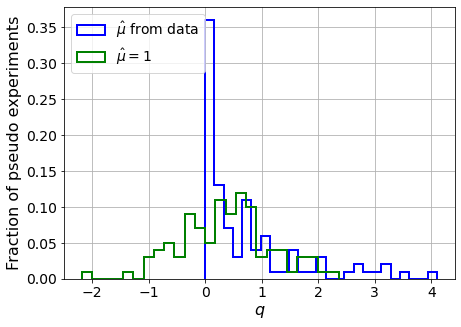

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  9337.58338376  9100.55922985  8802.83360701
  8442.90220475  8009.05300337  7478.52201522  6845.76117834
  6099.61348564  5226.74781372  4206.93623797  3021.37231738
  1630.66899641    45.03895    -1685.95350655 -3830.43059202]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf 11457.91192104 11279.63579546 10982.49608803


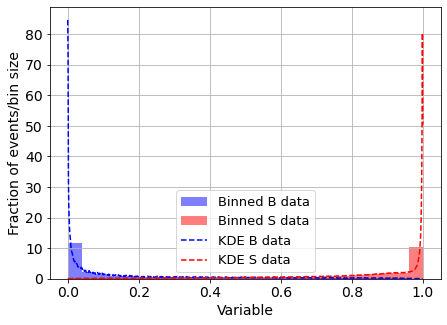

KDE Kernel:  epanechnikov
Background bandwidth:  0.0011635618505359071
Signal bandwidth:  0.0011635618505359071
This may take a while...
1 done
2 done
3 done
4 done


  1%|▍                                                                 | 12/2000 [00:03<06:28,  5.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.10724908795929422
<p_{s}(Sdata)> = 33.59059416679046
<p_{b}(Bdata)> = 18.609839910322773
<p_{s}(Bdata)> = 0.2698455732023891


  1%|▍                                                                 | 15/2000 [00:03<08:25,  3.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22511770614432666
<p_{s}(Sdata)> = 2.0622981308444412
<p_{b}(Bdata)> = 18.456342538763163
<p_{s}(Bdata)> = 0.2655925479918071


  1%|▋                                                                 | 19/2000 [00:04<05:21,  6.16it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1280754310896355
<p_{s}(Sdata)> = 40.13614542381997
<p_{b}(Bdata)> = 18.522970190865024
<p_{s}(Bdata)> = 0.2704311978774443
muhat = -0.1
<p_{b}(Sdata)> = 0.1750219596731846
<p_{s}(Sdata)> = 14.6164031996997
<p_{b}(Bdata)> = 18.678266093343186
<p_{s}(Bdata)> = 0.2561065205212337


  1%|▊                                                                 | 26/2000 [00:06<07:14,  4.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.12275052251593681
<p_{s}(Sdata)> = 24.723686062270772
<p_{b}(Bdata)> = 18.341828655661633
<p_{s}(Bdata)> = 0.25969021112915597


  2%|█                                                                 | 32/2000 [00:07<05:40,  5.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21683602702654806
<p_{s}(Sdata)> = 13.048152555394692
<p_{b}(Bdata)> = 18.791365239456137
<p_{s}(Bdata)> = 0.2566601834828567
muhat = 2.1
<p_{b}(Sdata)> = 0.20751868417463115
<p_{s}(Sdata)> = 18.757735741994285
<p_{b}(Bdata)> = 18.889643268858418
<p_{s}(Bdata)> = 0.2832991965209068


  2%|█▏                                                                | 35/2000 [00:07<05:21,  6.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23521650966490998
<p_{s}(Sdata)> = 10.00612527402963
<p_{b}(Bdata)> = 18.969380480852646
<p_{s}(Bdata)> = 0.2634610356146626


  2%|█▎                                                                | 38/2000 [00:08<09:27,  3.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16668957933292752
<p_{s}(Sdata)> = 15.651344067557519
<p_{b}(Bdata)> = 19.067511656588923
<p_{s}(Bdata)> = 0.25622998929638896


  2%|█▍                                                                | 43/2000 [00:09<06:52,  4.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2099612768561211
<p_{s}(Sdata)> = 10.521427214103749
<p_{b}(Bdata)> = 19.020867339581358
<p_{s}(Bdata)> = 0.26826851426973547


  2%|█▌                                                                | 48/2000 [00:10<05:22,  6.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 2.6148452855727635
<p_{s}(Sdata)> = 8.411595886464204
<p_{b}(Bdata)> = 18.623461437084842
<p_{s}(Bdata)> = 0.2640554195884577
muhat = -0.1
<p_{b}(Sdata)> = 0.4327397844384253
<p_{s}(Sdata)> = 9.748218146301458
<p_{b}(Bdata)> = 18.749123050301954
<p_{s}(Bdata)> = 0.2607607115823893


  3%|█▋                                                                | 51/2000 [00:11<05:58,  5.44it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.29426112291210815
<p_{s}(Sdata)> = 18.517432858340847
<p_{b}(Bdata)> = 18.840362250895236
<p_{s}(Bdata)> = 0.27905275369097265


  3%|█▊                                                                | 56/2000 [00:12<05:28,  5.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19066529275508887
<p_{s}(Sdata)> = 12.556315688282565
<p_{b}(Bdata)> = 18.65537149433652
<p_{s}(Bdata)> = 0.25748656787087404


  3%|█▉                                                                | 57/2000 [00:12<07:13,  4.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21925827434773104
<p_{s}(Sdata)> = 6.219239325099925
<p_{b}(Bdata)> = 18.53580008888085
<p_{s}(Bdata)> = 0.26225392362811245


  3%|██                                                                | 64/2000 [00:13<06:04,  5.31it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2571233258113572
<p_{s}(Sdata)> = 16.394640492963447
<p_{b}(Bdata)> = 18.565066100394922
<p_{s}(Bdata)> = 0.2728543390958262


  3%|██▏                                                               | 67/2000 [00:14<06:21,  5.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20284458609099146
<p_{s}(Sdata)> = 14.291412490629787
<p_{b}(Bdata)> = 18.92033997286317
<p_{s}(Bdata)> = 0.25863878429001846


  4%|██▍                                                               | 72/2000 [00:15<04:49,  6.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2545253809929902
<p_{s}(Sdata)> = 2.713829478606851
<p_{b}(Bdata)> = 18.657376989075438
<p_{s}(Bdata)> = 0.2648010384972916
muhat = -0.1
<p_{b}(Sdata)> = 0.25578382673919475
<p_{s}(Sdata)> = 4.299179158239511
<p_{b}(Bdata)> = 18.37714061179965
<p_{s}(Bdata)> = 0.2670312947858241


  4%|██▌                                                               | 79/2000 [00:16<07:13,  4.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16482720553497995
<p_{s}(Sdata)> = 14.727916942186724
<p_{b}(Bdata)> = 18.355875604587496
<p_{s}(Bdata)> = 0.261559165393087


  4%|██▊                                                               | 84/2000 [00:17<05:38,  5.66it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.10293641950519578
<p_{s}(Sdata)> = 35.287332261110244
<p_{b}(Bdata)> = 19.0628712091685
<p_{s}(Bdata)> = 0.2762111901353343
muhat = -0.1
<p_{b}(Sdata)> = 0.3932898054728825
<p_{s}(Sdata)> = 7.9947589924139955
<p_{b}(Bdata)> = 18.431627666724783
<p_{s}(Bdata)> = 0.25841467970887305


  5%|███                                                               | 91/2000 [00:19<05:43,  5.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20302877531748753
<p_{s}(Sdata)> = 6.806964979387943
<p_{b}(Bdata)> = 18.927220408838952
<p_{s}(Bdata)> = 0.26151940403188506


  5%|███▏                                                              | 98/2000 [00:20<06:04,  5.22it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.44197879231503817
<p_{s}(Sdata)> = 15.963625307140857
<p_{b}(Bdata)> = 18.50741484100675
<p_{s}(Bdata)> = 0.27875002574935076
muhat = -0.1
<p_{b}(Sdata)> = 0.4131626068141215
<p_{s}(Sdata)> = 7.794328099281548
<p_{b}(Bdata)> = 18.741098840630467
<p_{s}(Bdata)> = 0.26407421785499263


  6%|███▌                                                             | 110/2000 [00:23<06:33,  4.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3682986394160264
<p_{s}(Sdata)> = 4.118410792483291
<p_{b}(Bdata)> = 18.667654180601
<p_{s}(Bdata)> = 0.26594516541918894


  6%|███▊                                                             | 116/2000 [00:24<05:58,  5.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3194797017293766
<p_{s}(Sdata)> = 13.559937703509007
<p_{b}(Bdata)> = 18.938900573458596
<p_{s}(Bdata)> = 0.25971057758905447


  6%|███▊                                                             | 117/2000 [00:25<05:47,  5.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2922539534784794
<p_{s}(Sdata)> = 3.493853351154285
<p_{b}(Bdata)> = 18.673567047437682
<p_{s}(Bdata)> = 0.26527518703069003


  6%|███▊                                                             | 119/2000 [00:25<06:01,  5.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2571719413139732
<p_{s}(Sdata)> = 14.08610374011643
<p_{b}(Bdata)> = 18.50650106750849
<p_{s}(Bdata)> = 0.2600668337381875


  6%|███▉                                                             | 122/2000 [00:26<07:36,  4.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38000104772887316
<p_{s}(Sdata)> = 5.237266677154388
<p_{b}(Bdata)> = 18.552969942978365
<p_{s}(Bdata)> = 0.26265859684017046


  7%|████▎                                                            | 131/2000 [00:27<04:13,  7.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29884701064325875
<p_{s}(Sdata)> = 1.1932784052825778
<p_{b}(Bdata)> = 18.48267688084125
<p_{s}(Bdata)> = 0.26736738790612097
muhat = -0.1
<p_{b}(Sdata)> = 0.2441037092611289
<p_{s}(Sdata)> = 8.793957258923319
<p_{b}(Bdata)> = 18.893649227409178
<p_{s}(Bdata)> = 0.25427487094849843


  7%|████▎                                                            | 134/2000 [00:28<04:59,  6.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3725353493511664
<p_{s}(Sdata)> = 8.64100783532355
<p_{b}(Bdata)> = 18.474240602732294
<p_{s}(Bdata)> = 0.2535973693789429
muhat = -0.1
<p_{b}(Sdata)> = 0.5845289553123846
<p_{s}(Sdata)> = 16.028809377308807
<p_{b}(Bdata)> = 18.384295118466156
<p_{s}(Bdata)> = 0.2644815709612159


  7%|████▍                                                            | 136/2000 [00:28<03:54,  7.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.0993497703008009
<p_{s}(Sdata)> = 26.01500088232076
<p_{b}(Bdata)> = 18.56614407870052
<p_{s}(Bdata)> = 0.2581064744333074


  7%|████▍                                                            | 138/2000 [00:29<06:33,  4.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21802174682077824
<p_{s}(Sdata)> = 12.715592738430919
<p_{b}(Bdata)> = 18.550844365813628
<p_{s}(Bdata)> = 0.26376350955219774


  7%|████▌                                                            | 142/2000 [00:30<05:26,  5.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2856801329005138
<p_{s}(Sdata)> = 8.285436048523303
<p_{b}(Bdata)> = 18.554688815284692
<p_{s}(Bdata)> = 0.2646597297638613
muhat = -0.1
<p_{b}(Sdata)> = 0.1968674106101903
<p_{s}(Sdata)> = 7.494991486864051
<p_{b}(Bdata)> = 18.889407338703453
<p_{s}(Bdata)> = 0.26221458592933233


  7%|████▊                                                            | 147/2000 [00:30<04:57,  6.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1795651863870897
<p_{s}(Sdata)> = 11.662804065318301
<p_{b}(Bdata)> = 18.767735428091495
<p_{s}(Bdata)> = 0.26043777106646876


  7%|████▊                                                            | 149/2000 [00:31<04:39,  6.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21917582584735187
<p_{s}(Sdata)> = 4.648211506346054
<p_{b}(Bdata)> = 18.883351208398082
<p_{s}(Bdata)> = 0.2676069879115388


  8%|█████                                                            | 154/2000 [00:31<04:45,  6.47it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15792368299056891
<p_{s}(Sdata)> = 20.419832987259124
<p_{b}(Bdata)> = 18.77061547175965
<p_{s}(Bdata)> = 0.27224028544926043


  8%|█████▏                                                           | 160/2000 [00:33<06:39,  4.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21195854373041068
<p_{s}(Sdata)> = 11.383062124102775
<p_{b}(Bdata)> = 18.70382184479972
<p_{s}(Bdata)> = 0.2645501607807066


  8%|█████▎                                                           | 162/2000 [00:33<05:45,  5.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15615425243960565
<p_{s}(Sdata)> = 8.507349538814667
<p_{b}(Bdata)> = 18.556153186965112
<p_{s}(Bdata)> = 0.25888496318320664


  8%|█████▍                                                           | 166/2000 [00:34<04:43,  6.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25342576554465246
<p_{s}(Sdata)> = 6.643616194379669
<p_{b}(Bdata)> = 18.67755714105918
<p_{s}(Bdata)> = 0.26074800290556777
muhat = -0.1
<p_{b}(Sdata)> = 0.29109850399050446
<p_{s}(Sdata)> = 3.968322897180289
<p_{b}(Bdata)> = 18.71561968715394
<p_{s}(Bdata)> = 0.2647498510838333
muhat = -0.1
<p_{b}(Sdata)> = 0.28053148556597735
<p_{s}(Sdata)> = 9.914010737892196
<p_{b}(Bdata)> = 18.702923647293208
<p_{s}(Bdata)> = 0.2607518526765693


  9%|█████▌                                                           | 172/2000 [00:35<07:17,  4.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39310162535232673
<p_{s}(Sdata)> = 0.8964740619959051
<p_{b}(Bdata)> = 18.664348737313176
<p_{s}(Bdata)> = 0.2643881124594132


  9%|██████                                                           | 188/2000 [00:40<09:12,  3.28it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.27902606168453065
<p_{s}(Sdata)> = 23.328639941976025
<p_{b}(Bdata)> = 19.044338865008058
<p_{s}(Bdata)> = 0.27665786065162135


 10%|██████▏                                                          | 192/2000 [00:40<05:31,  5.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.13679410820584137
<p_{s}(Sdata)> = 12.179330441698218
<p_{b}(Bdata)> = 18.627913853331062
<p_{s}(Bdata)> = 0.2647778697223041
muhat = -0.1
<p_{b}(Sdata)> = 0.24229176153092494
<p_{s}(Sdata)> = 3.960521723860507
<p_{b}(Bdata)> = 18.474174016996454
<p_{s}(Bdata)> = 0.26379864028221806


 10%|██████▍                                                          | 199/2000 [00:42<06:20,  4.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20339768394638513
<p_{s}(Sdata)> = 11.000027810410796
<p_{b}(Bdata)> = 18.62713921485547
<p_{s}(Bdata)> = 0.26177879668506887


 10%|██████▊                                                          | 209/2000 [00:44<04:57,  6.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26555444823463
<p_{s}(Sdata)> = 5.336079798829281
<p_{b}(Bdata)> = 19.139597367822038
<p_{s}(Bdata)> = 0.26243639053531626
muhat = -0.1
<p_{b}(Sdata)> = 1.5051716154008996
<p_{s}(Sdata)> = 11.918386544192462
<p_{b}(Bdata)> = 18.135121678012627
<p_{s}(Bdata)> = 0.25922336413513464


 11%|██████▉                                                          | 214/2000 [00:45<04:23,  6.78it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17469370718959001
<p_{s}(Sdata)> = 21.856542384844246
<p_{b}(Bdata)> = 18.73652643110272
<p_{s}(Bdata)> = 0.27328626326565547
muhat = -0.1
<p_{b}(Sdata)> = 0.2373894108765874
<p_{s}(Sdata)> = 1.8348528594108984
<p_{b}(Bdata)> = 18.802485578907227
<p_{s}(Bdata)> = 0.25998809591878674


 11%|███████                                                          | 219/2000 [00:46<04:48,  6.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5293453400172446
<p_{s}(Sdata)> = 6.086868334536135
<p_{b}(Bdata)> = 18.65273820538339
<p_{s}(Bdata)> = 0.2639974543090592


 11%|███████▏                                                         | 222/2000 [00:47<06:21,  4.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23586708080087831
<p_{s}(Sdata)> = 17.164689472461575
<p_{b}(Bdata)> = 18.69496357256096
<p_{s}(Bdata)> = 0.2628477701255202


 11%|███████▍                                                         | 228/2000 [00:48<08:40,  3.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16508952901948537
<p_{s}(Sdata)> = 5.5963416354875335
<p_{b}(Bdata)> = 18.666538460917778
<p_{s}(Bdata)> = 0.2543103314899424


 12%|███████▌                                                         | 234/2000 [00:49<05:04,  5.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.395116202478274
<p_{s}(Sdata)> = 1.3695356507675287
<p_{b}(Bdata)> = 19.268416279562192
<p_{s}(Bdata)> = 0.2609904731969402


 12%|███████▋                                                         | 238/2000 [00:50<06:23,  4.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3688004878983673
<p_{s}(Sdata)> = 16.648057710949097
<p_{b}(Bdata)> = 18.55347545634555
<p_{s}(Bdata)> = 0.2584205605204288


 12%|███████▊                                                         | 240/2000 [00:50<06:20,  4.63it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22889149035278128
<p_{s}(Sdata)> = 19.228773840174732
<p_{b}(Bdata)> = 19.2054592034192
<p_{s}(Bdata)> = 0.26174953683735835


 12%|███████▉                                                         | 243/2000 [00:51<06:47,  4.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33175784718335755
<p_{s}(Sdata)> = 3.340700614618999
<p_{b}(Bdata)> = 18.877602618518015
<p_{s}(Bdata)> = 0.26247745148776597


 12%|████████                                                         | 249/2000 [00:53<08:38,  3.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25674724470375426
<p_{s}(Sdata)> = 2.861167209319534
<p_{b}(Bdata)> = 18.78722402288925
<p_{s}(Bdata)> = 0.2618300384805721


 13%|████████▎                                                        | 257/2000 [00:55<05:59,  4.84it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.36267343939329943
<p_{s}(Sdata)> = 23.192075956929095
<p_{b}(Bdata)> = 18.67957662100559
<p_{s}(Bdata)> = 0.26508520105029365


 13%|████████▍                                                        | 261/2000 [00:56<05:39,  5.13it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2474269691950843
<p_{s}(Sdata)> = 25.47013810379316
<p_{b}(Bdata)> = 18.90895949407241
<p_{s}(Bdata)> = 0.26673277539076495
muhat = 2.1
<p_{b}(Sdata)> = 0.2932583536996885
<p_{s}(Sdata)> = 24.99181799662128
<p_{b}(Bdata)> = 18.507228885752124
<p_{s}(Bdata)> = 0.2652331627127206


 13%|████████▋                                                        | 268/2000 [00:57<06:03,  4.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3174776179244384
<p_{s}(Sdata)> = 10.611711837289004
<p_{b}(Bdata)> = 18.693549534692544
<p_{s}(Bdata)> = 0.26149944518702556


 14%|████████▉                                                        | 274/2000 [00:58<05:19,  5.40it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.13322281848108095
<p_{s}(Sdata)> = 24.000735255910516
<p_{b}(Bdata)> = 18.779112112217597
<p_{s}(Bdata)> = 0.273073522085665


 14%|█████████                                                        | 279/2000 [00:59<04:37,  6.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.158904823005947
<p_{s}(Sdata)> = 8.06575843033789
<p_{b}(Bdata)> = 18.821093339908533
<p_{s}(Bdata)> = 0.260963274304382


 14%|█████████▏                                                       | 283/2000 [01:00<04:12,  6.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18695582968325508
<p_{s}(Sdata)> = 8.355243708440138
<p_{b}(Bdata)> = 18.59587167475232
<p_{s}(Bdata)> = 0.26390586614869405
muhat = 2.1
<p_{b}(Sdata)> = 0.210473577070204
<p_{s}(Sdata)> = 26.99630712267431
<p_{b}(Bdata)> = 18.879502095502616
<p_{s}(Bdata)> = 0.27040255671018043


 14%|█████████▎                                                       | 286/2000 [01:00<03:51,  7.40it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2412835361941478
<p_{s}(Sdata)> = 31.365081080922423
<p_{b}(Bdata)> = 18.648834873237963
<p_{s}(Bdata)> = 0.27593364275195836
muhat = -0.1
<p_{b}(Sdata)> = 0.1820728614984754
<p_{s}(Sdata)> = 11.316938600180915
<p_{b}(Bdata)> = 18.76538583997955
<p_{s}(Bdata)> = 0.2561553526374447


 15%|█████████▌                                                       | 296/2000 [01:03<05:03,  5.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22008243769099012
<p_{s}(Sdata)> = 15.045956048413359
<p_{b}(Bdata)> = 18.643363917486678
<p_{s}(Bdata)> = 0.2550304307403958
muhat = -0.1
<p_{b}(Sdata)> = 0.24122353664625873
<p_{s}(Sdata)> = 12.183202427786398
<p_{b}(Bdata)> = 18.667738038766736
<p_{s}(Bdata)> = 0.26204460921609896


 15%|█████████▋                                                       | 297/2000 [01:03<05:43,  4.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22295983182824955
<p_{s}(Sdata)> = 8.264370429510757
<p_{b}(Bdata)> = 18.758943451807035
<p_{s}(Bdata)> = 0.2654739792474421


 15%|█████████▊                                                       | 301/2000 [01:03<04:09,  6.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1925872112404733
<p_{s}(Sdata)> = 10.606443981967837
<p_{b}(Bdata)> = 19.014193487324103
<p_{s}(Bdata)> = 0.25525989664973125


 15%|█████████▊                                                       | 302/2000 [01:04<04:23,  6.45it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15442846729021453
<p_{s}(Sdata)> = 34.5375370699692
<p_{b}(Bdata)> = 18.802797430234843
<p_{s}(Bdata)> = 0.26486524575147846


 16%|██████████▎                                                      | 319/2000 [01:08<04:48,  5.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20254882776747823
<p_{s}(Sdata)> = 16.982544578634865
<p_{b}(Bdata)> = 18.79907592789519
<p_{s}(Bdata)> = 0.2562397242065242
muhat = 2.1
<p_{b}(Sdata)> = 0.3025671135705251
<p_{s}(Sdata)> = 18.943888995017026
<p_{b}(Bdata)> = 18.17371678297433
<p_{s}(Bdata)> = 0.2775758219162413
muhat = -0.1
<p_{b}(Sdata)> = 0.32648191016927597
<p_{s}(Sdata)> = 2.9272089866259954
<p_{b}(Bdata)> = 18.84744760677767
<p_{s}(Bdata)> = 0.2580746646821935


 16%|██████████▍                                                      | 321/2000 [01:08<03:44,  7.47it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.13261048184294702
<p_{s}(Sdata)> = 27.631689741787362
<p_{b}(Bdata)> = 19.012478956545408
<p_{s}(Bdata)> = 0.26749216121359326


 17%|███████████                                                      | 339/2000 [01:13<05:21,  5.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2602426692306864
<p_{s}(Sdata)> = 7.512030178540339
<p_{b}(Bdata)> = 18.657908506711102
<p_{s}(Bdata)> = 0.2623871069838508
muhat = -0.1
<p_{b}(Sdata)> = 0.2995174821886276
<p_{s}(Sdata)> = 10.42120385625646
<p_{b}(Bdata)> = 18.795003315864037
<p_{s}(Bdata)> = 0.2635819581893729
muhat = -0.1
<p_{b}(Sdata)> = 0.20238869906540996
<p_{s}(Sdata)> = 14.583320660312076
<p_{b}(Bdata)> = 18.39749703447326
<p_{s}(Bdata)> = 0.26397135166372554


 17%|███████████                                                      | 341/2000 [01:13<04:53,  5.65it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.12561426156198233
<p_{s}(Sdata)> = 31.71643568963514
<p_{b}(Bdata)> = 18.757041982873517
<p_{s}(Bdata)> = 0.26262830759072275


 18%|███████████▍                                                     | 350/2000 [01:15<08:01,  3.42it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.28254958803457264
<p_{s}(Sdata)> = 23.886184342097383
<p_{b}(Bdata)> = 18.576464271734405
<p_{s}(Bdata)> = 0.2731451565546202


 18%|███████████▌                                                     | 355/2000 [01:17<08:36,  3.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30677372995630137
<p_{s}(Sdata)> = 3.7936007238289142
<p_{b}(Bdata)> = 18.567964080858413
<p_{s}(Bdata)> = 0.2658444510007827


 18%|███████████▋                                                     | 361/2000 [01:19<08:14,  3.32it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.28144352896171243
<p_{s}(Sdata)> = 19.169866881884154
<p_{b}(Bdata)> = 18.852758119080896
<p_{s}(Bdata)> = 0.27524233170866175


 19%|████████████                                                     | 371/2000 [01:21<07:33,  3.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28446862923211813
<p_{s}(Sdata)> = 12.188610891585327
<p_{b}(Bdata)> = 18.919106375155174
<p_{s}(Bdata)> = 0.26108612193957365


 19%|████████████▏                                                    | 375/2000 [01:22<05:06,  5.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23802654576123086
<p_{s}(Sdata)> = 12.891450352194889
<p_{b}(Bdata)> = 18.610578374416196
<p_{s}(Bdata)> = 0.2586806270003446


 19%|████████████▎                                                    | 379/2000 [01:23<04:57,  5.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.11870784247167777
<p_{s}(Sdata)> = 15.731854370242266
<p_{b}(Bdata)> = 18.86121219904751
<p_{s}(Bdata)> = 0.255992269633146
muhat = -0.1
<p_{b}(Sdata)> = 0.23590955168127972
<p_{s}(Sdata)> = 8.476282685207662
<p_{b}(Bdata)> = 19.02323787228378
<p_{s}(Bdata)> = 0.26260368975873194


 19%|████████████▍                                                    | 383/2000 [01:24<04:39,  5.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22036931197477966
<p_{s}(Sdata)> = 10.249607406369037
<p_{b}(Bdata)> = 18.345679389655213
<p_{s}(Bdata)> = 0.2632842782250125


 19%|████████████▌                                                    | 388/2000 [01:25<04:39,  5.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30980698352563224
<p_{s}(Sdata)> = 12.889037208463447
<p_{b}(Bdata)> = 18.861263205740077
<p_{s}(Bdata)> = 0.2619224964660074
muhat = -0.1
<p_{b}(Sdata)> = 0.21618330987632922
<p_{s}(Sdata)> = 15.683227529040058
<p_{b}(Bdata)> = 18.659192962550357
<p_{s}(Bdata)> = 0.25648726683923023


 20%|████████████▋                                                    | 391/2000 [01:25<04:20,  6.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2289188253085701
<p_{s}(Sdata)> = 5.5000571821591855
<p_{b}(Bdata)> = 18.85605160526963
<p_{s}(Bdata)> = 0.2586322293838209
muhat = 2.1
<p_{b}(Sdata)> = 0.24518445806559033
<p_{s}(Sdata)> = 18.646795513859505
<p_{b}(Bdata)> = 18.58589343159395
<p_{s}(Bdata)> = 0.27724230309509773


 20%|████████████▊                                                    | 394/2000 [01:26<03:56,  6.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2736453915523842
<p_{s}(Sdata)> = 3.697239076147042
<p_{b}(Bdata)> = 18.839084537942124
<p_{s}(Bdata)> = 0.2603957081153536


 20%|█████████████                                                    | 402/2000 [01:27<03:43,  7.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3231502193570447
<p_{s}(Sdata)> = 9.580512941956595
<p_{b}(Bdata)> = 18.334004549706155
<p_{s}(Bdata)> = 0.25864274033340534


 20%|█████████████▏                                                   | 406/2000 [01:27<03:00,  8.82it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15197399751673918
<p_{s}(Sdata)> = 30.097603029503393
<p_{b}(Bdata)> = 18.69503452004589
<p_{s}(Bdata)> = 0.2715805318695431
muhat = -0.1
<p_{b}(Sdata)> = 0.3041025597848607
<p_{s}(Sdata)> = 2.9208530923283407
<p_{b}(Bdata)> = 18.943475234674505
<p_{s}(Bdata)> = 0.26436030178701514


 21%|█████████████▍                                                   | 413/2000 [01:29<05:10,  5.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16225283488914127
<p_{s}(Sdata)> = 7.941497131472816
<p_{b}(Bdata)> = 18.66512114932757
<p_{s}(Bdata)> = 0.26635642199595094
muhat = -0.1
<p_{b}(Sdata)> = 0.3598150368466925
<p_{s}(Sdata)> = 3.981296817814287
<p_{b}(Bdata)> = 18.757656266182565
<p_{s}(Bdata)> = 0.26360700793634206


 21%|█████████████▌                                                   | 416/2000 [01:30<04:06,  6.42it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2212755951924934
<p_{s}(Sdata)> = 15.214700997215362
<p_{b}(Bdata)> = 18.798620894310268
<p_{s}(Bdata)> = 0.27697421949594436


 21%|█████████████▌                                                   | 419/2000 [01:30<03:51,  6.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19814269516663405
<p_{s}(Sdata)> = 15.18825648656156
<p_{b}(Bdata)> = 18.300258379816444
<p_{s}(Bdata)> = 0.26262942075443824
muhat = 2.1
<p_{b}(Sdata)> = 0.22314301654513702
<p_{s}(Sdata)> = 21.361714330495737
<p_{b}(Bdata)> = 18.517228053974975
<p_{s}(Bdata)> = 0.2760736434980078


 21%|█████████████▊                                                   | 424/2000 [01:31<03:29,  7.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3094748308699558
<p_{s}(Sdata)> = 1.617219631524205
<p_{b}(Bdata)> = 19.588990636687544
<p_{s}(Bdata)> = 0.26567922618199646
muhat = -0.1
<p_{b}(Sdata)> = 0.29418382989629505
<p_{s}(Sdata)> = 4.848306313187449
<p_{b}(Bdata)> = 18.844112988662594
<p_{s}(Bdata)> = 0.2597553820123382
muhat = 2.1
<p_{b}(Sdata)> = 0.2003852607117144
<p_{s}(Sdata)> = 30.571113800511515
<p_{b}(Bdata)> = 18.754628885249137
<p_{s}(Bdata)> = 0.2724659178703656


 21%|█████████████▉                                                   | 428/2000 [01:31<02:40,  9.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28015450552483706
<p_{s}(Sdata)> = 8.222237576503021
<p_{b}(Bdata)> = 19.198469594745486
<p_{s}(Bdata)> = 0.25969500845755883
muhat = -0.1
<p_{b}(Sdata)> = 0.18357774239863445
<p_{s}(Sdata)> = 3.118096939204046
<p_{b}(Bdata)> = 18.541078927818532
<p_{s}(Bdata)> = 0.25843069370150956


 22%|██████████████                                                   | 431/2000 [01:32<03:49,  6.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23059319910395792
<p_{s}(Sdata)> = 9.45142393295382
<p_{b}(Bdata)> = 18.626620592972227
<p_{s}(Bdata)> = 0.257564590578518


 22%|██████████████▏                                                  | 437/2000 [01:33<03:44,  6.96it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18818328089151398
<p_{s}(Sdata)> = 23.144878334922208
<p_{b}(Bdata)> = 18.924791371758893
<p_{s}(Bdata)> = 0.27028835522754024


 22%|██████████████▍                                                  | 443/2000 [01:34<05:04,  5.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2534058878572257
<p_{s}(Sdata)> = 9.396209022969577
<p_{b}(Bdata)> = 18.322597248908284
<p_{s}(Bdata)> = 0.2622668915133666
muhat = 2.1
<p_{b}(Sdata)> = 0.2429785472288141
<p_{s}(Sdata)> = 23.79321029594007
<p_{b}(Bdata)> = 19.08852841081588
<p_{s}(Bdata)> = 0.2700538232521546
muhat = -0.1
<p_{b}(Sdata)> = 0.18136558669855948
<p_{s}(Sdata)> = 16.83729404402185
<p_{b}(Bdata)> = 19.046644126379718
<p_{s}(Bdata)> = 0.2604870717269986


 22%|██████████████▍                                                  | 446/2000 [01:35<04:34,  5.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28252985793817903
<p_{s}(Sdata)> = 8.875769503716839
<p_{b}(Bdata)> = 18.787909430075736
<p_{s}(Bdata)> = 0.2565226499760358


 22%|██████████████▋                                                  | 450/2000 [01:35<04:03,  6.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25574442563955535
<p_{s}(Sdata)> = 7.520208448760743
<p_{b}(Bdata)> = 18.76810514332494
<p_{s}(Bdata)> = 0.2618054662962777
muhat = -0.1
<p_{b}(Sdata)> = 0.18682196238418347
<p_{s}(Sdata)> = 15.037132623575852
<p_{b}(Bdata)> = 18.601057077043638
<p_{s}(Bdata)> = 0.2623614473470844
muhat = -0.1
<p_{b}(Sdata)> = 0.17948625649678268
<p_{s}(Sdata)> = 17.620369599135046
<p_{b}(Bdata)> = 18.4584586357253
<p_{s}(Bdata)> = 0.2586515229999551
muhat = 2.1
<p_{b}(Sdata)> = 0.13595602841376367
<p_{s}(Sdata)> = 28.696363716850133
<p_{b}(Bdata)> = 18.611870897597107
<p_{s}(Bdata)> = 0.2817621374771519


 23%|██████████████▉                                                  | 458/2000 [01:37<07:14,  3.55it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.48563810871799834
<p_{s}(Sdata)> = 26.305845352958155
<p_{b}(Bdata)> = 18.6176225723811
<p_{s}(Bdata)> = 0.2773946770095227


 24%|███████████████▎                                                 | 473/2000 [01:41<04:48,  5.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27390301754255764
<p_{s}(Sdata)> = 9.198107823495777
<p_{b}(Bdata)> = 18.841941219350566
<p_{s}(Bdata)> = 0.26151283003900994
muhat = -0.1
<p_{b}(Sdata)> = 0.16439124280299686
<p_{s}(Sdata)> = 9.325816289168985
<p_{b}(Bdata)> = 19.13662517396697
<p_{s}(Bdata)> = 0.260653407906855


 24%|███████████████▊                                                 | 486/2000 [01:44<04:37,  5.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.2415077094762923
<p_{s}(Sdata)> = 2.5177091417722957
<p_{b}(Bdata)> = 18.378701188255363
<p_{s}(Bdata)> = 0.26002192903353116
muhat = -0.1
<p_{b}(Sdata)> = 0.22877645157090962
<p_{s}(Sdata)> = 12.86628263131732
<p_{b}(Bdata)> = 18.432818703866584
<p_{s}(Bdata)> = 0.26628413998871986


 25%|███████████████▉                                                 | 491/2000 [01:45<04:42,  5.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1684843667083313
<p_{s}(Sdata)> = 12.30791476521871
<p_{b}(Bdata)> = 19.01085859133894
<p_{s}(Bdata)> = 0.2615024983235899


 25%|████████████████                                                 | 495/2000 [01:46<06:22,  3.94it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2886812210424593
<p_{s}(Sdata)> = 15.191349665008534
<p_{b}(Bdata)> = 18.665631930799886
<p_{s}(Bdata)> = 0.2782789636633733


 25%|████████████████▏                                                | 498/2000 [01:47<06:22,  3.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6269324942711453
<p_{s}(Sdata)> = 2.357977036446356
<p_{b}(Bdata)> = 18.758032901908905
<p_{s}(Bdata)> = 0.2637297585927784


 25%|████████████████▎                                                | 500/2000 [01:47<05:51,  4.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28984866366745826
<p_{s}(Sdata)> = 7.616581375546227
<p_{b}(Bdata)> = 18.908403853290103
<p_{s}(Bdata)> = 0.2644676955236254


 26%|████████████████▊                                                | 516/2000 [01:52<09:25,  2.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27787967577366285
<p_{s}(Sdata)> = 11.419695680705722
<p_{b}(Bdata)> = 18.939132400543397
<p_{s}(Bdata)> = 0.26421691901147193


 26%|████████████████▊                                                | 518/2000 [01:52<07:59,  3.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19645406541286595
<p_{s}(Sdata)> = 17.488954594156663
<p_{b}(Bdata)> = 18.705545919477235
<p_{s}(Bdata)> = 0.27535194380288247


 26%|████████████████▉                                                | 521/2000 [01:53<07:05,  3.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7285356342009105
<p_{s}(Sdata)> = 11.808511598907446
<p_{b}(Bdata)> = 18.62010277323987
<p_{s}(Bdata)> = 0.26006348430991827


 26%|█████████████████▏                                               | 529/2000 [01:55<05:32,  4.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28020874536053414
<p_{s}(Sdata)> = 12.142759588204305
<p_{b}(Bdata)> = 18.430677041540658
<p_{s}(Bdata)> = 0.2611197907029689


 27%|█████████████████▎                                               | 531/2000 [01:55<04:09,  5.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2469948662934882
<p_{s}(Sdata)> = 10.495115484385654
<p_{b}(Bdata)> = 18.479613387507506
<p_{s}(Bdata)> = 0.2589403997352776
muhat = 2.1
<p_{b}(Sdata)> = 0.16066190118080537
<p_{s}(Sdata)> = 28.862469229311372
<p_{b}(Bdata)> = 18.5659221751471
<p_{s}(Bdata)> = 0.2672505925616428
muhat = 2.1
<p_{b}(Sdata)> = 0.1625590819610028
<p_{s}(Sdata)> = 24.617350829221607
<p_{b}(Bdata)> = 18.623204945971874
<p_{s}(Bdata)> = 0.27739991410365666


 27%|█████████████████▎                                               | 533/2000 [01:55<03:21,  7.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19997291238244352
<p_{s}(Sdata)> = 7.584983061571137
<p_{b}(Bdata)> = 18.568132914177383
<p_{s}(Bdata)> = 0.2631832463707389


 27%|█████████████████▍                                               | 536/2000 [01:56<03:20,  7.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25026525108776276
<p_{s}(Sdata)> = 11.358714368770041
<p_{b}(Bdata)> = 18.892039292694864
<p_{s}(Bdata)> = 0.2600633994344725
muhat = -0.1
<p_{b}(Sdata)> = 0.3434302268612694
<p_{s}(Sdata)> = 6.536832129976005
<p_{b}(Bdata)> = 18.507148384293835
<p_{s}(Bdata)> = 0.2635923210000793


 27%|█████████████████▍                                               | 537/2000 [01:56<03:39,  6.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.343475163293264
<p_{s}(Sdata)> = 0.8860000289158867
<p_{b}(Bdata)> = 18.671725168113078
<p_{s}(Bdata)> = 0.2555794898866099


 27%|█████████████████▋                                               | 546/2000 [01:58<03:56,  6.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3487707095293778
<p_{s}(Sdata)> = 5.86115357448347
<p_{b}(Bdata)> = 18.873785786862076
<p_{s}(Bdata)> = 0.2606141382172811
muhat = 2.1
<p_{b}(Sdata)> = 0.16652786306846373
<p_{s}(Sdata)> = 16.402810062720143
<p_{b}(Bdata)> = 18.233590328237295
<p_{s}(Bdata)> = 0.28094132403881733


 27%|█████████████████▊                                               | 549/2000 [01:58<03:26,  7.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17850471734131396
<p_{s}(Sdata)> = 29.15669311984864
<p_{b}(Bdata)> = 18.63448914469543
<p_{s}(Bdata)> = 0.26808482646277


 28%|█████████████████▉                                               | 553/2000 [01:59<05:33,  4.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24028047382464704
<p_{s}(Sdata)> = 7.050262536925615
<p_{b}(Bdata)> = 18.427893839984275
<p_{s}(Bdata)> = 0.2662716069507971


 28%|██████████████████▏                                              | 558/2000 [02:00<04:18,  5.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3654912339358511
<p_{s}(Sdata)> = 4.5351983791698895
<p_{b}(Bdata)> = 19.144747050274336
<p_{s}(Bdata)> = 0.2648322737034559
muhat = -0.1
<p_{b}(Sdata)> = 0.30585232611892643
<p_{s}(Sdata)> = 13.387748729330868
<p_{b}(Bdata)> = 18.84935197347728
<p_{s}(Bdata)> = 0.2593942209604858


 28%|██████████████████▎                                              | 564/2000 [02:02<06:34,  3.64it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.11328202976460723
<p_{s}(Sdata)> = 27.63706512964641
<p_{b}(Bdata)> = 18.76195946111415
<p_{s}(Bdata)> = 0.26589510673273253


 28%|██████████████████▍                                              | 566/2000 [02:02<05:21,  4.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26636105864502124
<p_{s}(Sdata)> = 11.363054424079731
<p_{b}(Bdata)> = 18.933872872974405
<p_{s}(Bdata)> = 0.26066794634576584


 29%|██████████████████▌                                              | 572/2000 [02:04<04:26,  5.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16123849138213667
<p_{s}(Sdata)> = 14.77154550854243
<p_{b}(Bdata)> = 18.599741995832954
<p_{s}(Bdata)> = 0.2681618431601866


 29%|██████████████████▌                                              | 573/2000 [02:04<04:54,  4.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33783644885776026
<p_{s}(Sdata)> = 13.235761267157393
<p_{b}(Bdata)> = 18.382859379022925
<p_{s}(Bdata)> = 0.2624229637902906


 29%|██████████████████▊                                              | 580/2000 [02:05<05:22,  4.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.8027502719634014
<p_{s}(Sdata)> = 5.347092321141584
<p_{b}(Bdata)> = 18.953506875544367
<p_{s}(Bdata)> = 0.26436802527500664


 29%|██████████████████▉                                              | 582/2000 [02:06<05:32,  4.26it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21275157124210944
<p_{s}(Sdata)> = 20.406560784944794
<p_{b}(Bdata)> = 18.566342059654037
<p_{s}(Bdata)> = 0.2759064751634783


 30%|███████████████████▏                                             | 591/2000 [02:08<03:54,  6.01it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2205813699296651
<p_{s}(Sdata)> = 31.379770694376614
<p_{b}(Bdata)> = 18.31487629259163
<p_{s}(Bdata)> = 0.2804127165116621
muhat = 2.1
<p_{b}(Sdata)> = 0.13853340850670248
<p_{s}(Sdata)> = 16.817757900574367
<p_{b}(Bdata)> = 18.548368900917872
<p_{s}(Bdata)> = 0.2782064882771749
muhat = 2.1
<p_{b}(Sdata)> = 0.3079484737949741
<p_{s}(Sdata)> = 17.263093238792017
<p_{b}(Bdata)> = 18.749292628577788
<p_{s}(Bdata)> = 0.27718553054094625


 30%|███████████████████▎                                             | 593/2000 [02:08<04:19,  5.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20451362776273735
<p_{s}(Sdata)> = 15.731555842188431
<p_{b}(Bdata)> = 18.868529616372864
<p_{s}(Bdata)> = 0.2606109695937145


 30%|███████████████████▎                                             | 595/2000 [02:09<04:52,  4.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4045049238974453
<p_{s}(Sdata)> = 13.922236291492812
<p_{b}(Bdata)> = 18.703135171715484
<p_{s}(Bdata)> = 0.26080514946915


 30%|███████████████████▍                                             | 597/2000 [02:09<04:23,  5.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16327861906333233
<p_{s}(Sdata)> = 7.748423033637611
<p_{b}(Bdata)> = 18.643676222722398
<p_{s}(Bdata)> = 0.2681834620570234


 30%|███████████████████▌                                             | 602/2000 [02:10<03:29,  6.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4758586528964705
<p_{s}(Sdata)> = 5.329272162979749
<p_{b}(Bdata)> = 18.770252481705857
<p_{s}(Bdata)> = 0.2685546583994201
muhat = -0.1
<p_{b}(Sdata)> = 0.18576873336072633
<p_{s}(Sdata)> = 20.307289811000867
<p_{b}(Bdata)> = 18.823052631352326
<p_{s}(Bdata)> = 0.25970262657425963
muhat = -0.1
<p_{b}(Sdata)> = 0.17284543507889
<p_{s}(Sdata)> = 9.659453262692622
<p_{b}(Bdata)> = 18.601845654035998
<p_{s}(Bdata)> = 0.2679457396974535


 30%|███████████████████▋                                             | 606/2000 [02:11<05:15,  4.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21759755975833128
<p_{s}(Sdata)> = 13.222375896715848
<p_{b}(Bdata)> = 18.5618535118354
<p_{s}(Bdata)> = 0.2587836417061527


 30%|███████████████████▊                                             | 608/2000 [02:11<05:17,  4.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2590098279333336
<p_{s}(Sdata)> = 9.182816423777528
<p_{b}(Bdata)> = 18.532873900289104
<p_{s}(Bdata)> = 0.2673240141198407


 31%|███████████████████▊                                             | 611/2000 [02:12<04:47,  4.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2807610778987849
<p_{s}(Sdata)> = 13.287178716187373
<p_{b}(Bdata)> = 18.499355263505347
<p_{s}(Bdata)> = 0.2648399494750019


 31%|███████████████████▉                                             | 615/2000 [02:13<05:07,  4.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1950988057026142
<p_{s}(Sdata)> = 17.354983373705295
<p_{b}(Bdata)> = 18.492905099964734
<p_{s}(Bdata)> = 0.2577219002068153


 31%|████████████████████                                             | 619/2000 [02:13<03:18,  6.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20664614583934549
<p_{s}(Sdata)> = 15.358180140390223
<p_{b}(Bdata)> = 18.530314134465968
<p_{s}(Bdata)> = 0.25986002806458747
muhat = -0.1
<p_{b}(Sdata)> = 0.2305744681352219
<p_{s}(Sdata)> = 7.615975259013848
<p_{b}(Bdata)> = 18.683710551056745
<p_{s}(Bdata)> = 0.2660733771403107
muhat = -0.1
<p_{b}(Sdata)> = 0.3075205012891694
<p_{s}(Sdata)> = 4.231040772626858
<p_{b}(Bdata)> = 18.471152531130297
<p_{s}(Bdata)> = 0.2662518584255467


 31%|████████████████████▏                                            | 623/2000 [02:14<03:23,  6.77it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24798708924975724
<p_{s}(Sdata)> = 17.48916150965002
<p_{b}(Bdata)> = 18.635737324120782
<p_{s}(Bdata)> = 0.2763096111952141


 31%|████████████████████▎                                            | 626/2000 [02:14<03:53,  5.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1382676576804152
<p_{s}(Sdata)> = 16.49732966933717
<p_{b}(Bdata)> = 18.515984140344536
<p_{s}(Bdata)> = 0.25784598099685085
muhat = -0.1
<p_{b}(Sdata)> = 0.4419208320528001
<p_{s}(Sdata)> = 1.1394618255260691
<p_{b}(Bdata)> = 18.61099000777298
<p_{s}(Bdata)> = 0.2665677845206181


 31%|████████████████████▍                                            | 628/2000 [02:15<04:21,  5.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.086748299296384
<p_{s}(Sdata)> = 1.1778535323620474
<p_{b}(Bdata)> = 18.736035005388015
<p_{s}(Bdata)> = 0.26685995638977905


 32%|████████████████████▌                                            | 633/2000 [02:15<03:18,  6.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30456301518963647
<p_{s}(Sdata)> = 14.775179347346718
<p_{b}(Bdata)> = 18.568375616557574
<p_{s}(Bdata)> = 0.25692500436015003
muhat = -0.1
<p_{b}(Sdata)> = 0.2247419875951778
<p_{s}(Sdata)> = 13.721169140009266
<p_{b}(Bdata)> = 18.55395683727901
<p_{s}(Bdata)> = 0.2594344994030346


 32%|████████████████████▊                                            | 641/2000 [02:17<03:46,  6.01it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4348753924826858
<p_{s}(Sdata)> = 23.100865276710948
<p_{b}(Bdata)> = 18.91730710161318
<p_{s}(Bdata)> = 0.27435266312323625
muhat = -0.1
<p_{b}(Sdata)> = 0.17323030240173895
<p_{s}(Sdata)> = 4.714660790766811
<p_{b}(Bdata)> = 18.50059789499578
<p_{s}(Bdata)> = 0.2648939731836227


 32%|████████████████████▊                                            | 642/2000 [02:17<04:17,  5.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2263164004366568
<p_{s}(Sdata)> = 6.0162025721405765
<p_{b}(Bdata)> = 18.56670919338061
<p_{s}(Bdata)> = 0.2689802566592087


 32%|████████████████████▉                                            | 646/2000 [02:18<05:03,  4.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33752255246967133
<p_{s}(Sdata)> = 3.204355072443657
<p_{b}(Bdata)> = 18.48097886106863
<p_{s}(Bdata)> = 0.26581104854972026


 32%|█████████████████████▏                                           | 650/2000 [02:19<04:59,  4.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2629138548393735
<p_{s}(Sdata)> = 13.843568408998888
<p_{b}(Bdata)> = 18.13418921249941
<p_{s}(Bdata)> = 0.25942292756667296


 33%|█████████████████████▏                                           | 652/2000 [02:20<04:41,  4.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27665115091520087
<p_{s}(Sdata)> = 9.91717016792195
<p_{b}(Bdata)> = 18.9132275737501
<p_{s}(Bdata)> = 0.25695470767083733


 33%|█████████████████████▎                                           | 657/2000 [02:21<05:20,  4.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21797465248783718
<p_{s}(Sdata)> = 5.3302587212181445
<p_{b}(Bdata)> = 18.740390977199947
<p_{s}(Bdata)> = 0.26437273496473684


 33%|█████████████████████▍                                           | 661/2000 [02:21<03:34,  6.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18733795261688188
<p_{s}(Sdata)> = 8.602507187591716
<p_{b}(Bdata)> = 19.004175166047943
<p_{s}(Bdata)> = 0.2578190786727395


 33%|█████████████████████▋                                           | 667/2000 [02:23<06:05,  3.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.8000820894896391
<p_{s}(Sdata)> = 9.583214403407252
<p_{b}(Bdata)> = 18.561800060893376
<p_{s}(Bdata)> = 0.2582290837958569


 34%|█████████████████████▊                                           | 671/2000 [02:24<03:54,  5.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3199594870773994
<p_{s}(Sdata)> = 7.1760629195598495
<p_{b}(Bdata)> = 18.666080748188403
<p_{s}(Bdata)> = 0.2622547734700778


 34%|█████████████████████▊                                           | 672/2000 [02:24<05:09,  4.29it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19740096939476967
<p_{s}(Sdata)> = 24.30402130636682
<p_{b}(Bdata)> = 18.892672898022937
<p_{s}(Bdata)> = 0.2748232854878461


 34%|██████████████████████                                           | 677/2000 [02:25<04:54,  4.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2367063899332222
<p_{s}(Sdata)> = 11.483226411480112
<p_{b}(Bdata)> = 18.931176681301878
<p_{s}(Bdata)> = 0.25767053830926834


 34%|██████████████████████                                           | 680/2000 [02:26<05:00,  4.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.268323688670333
<p_{s}(Sdata)> = 4.281892128022171
<p_{b}(Bdata)> = 18.234154854806533
<p_{s}(Bdata)> = 0.26906219660827385


 34%|██████████████████████▎                                          | 688/2000 [02:28<03:42,  5.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.13368988603245888
<p_{s}(Sdata)> = 19.138923583106507
<p_{b}(Bdata)> = 18.73020378816448
<p_{s}(Bdata)> = 0.26694934638588663
muhat = -0.1
<p_{b}(Sdata)> = 0.1776498408557788
<p_{s}(Sdata)> = 13.128861700543295
<p_{b}(Bdata)> = 18.62401071819195
<p_{s}(Bdata)> = 0.261333190959667


 35%|██████████████████████▌                                          | 694/2000 [02:29<03:48,  5.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2795634518610034
<p_{s}(Sdata)> = 8.814623202900854
<p_{b}(Bdata)> = 18.74191373342395
<p_{s}(Bdata)> = 0.2591454445557104


 35%|██████████████████████▊                                          | 701/2000 [02:31<06:00,  3.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22197676471956407
<p_{s}(Sdata)> = 13.823347470658726
<p_{b}(Bdata)> = 18.555569058793807
<p_{s}(Bdata)> = 0.2584302522511815


 35%|██████████████████████▉                                          | 705/2000 [02:32<04:24,  4.90it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21086992525535583
<p_{s}(Sdata)> = 20.50940107828157
<p_{b}(Bdata)> = 19.286739230563022
<p_{s}(Bdata)> = 0.2781116116433016


 36%|███████████████████████▏                                         | 712/2000 [02:33<04:25,  4.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.249004137181951
<p_{s}(Sdata)> = 9.502524586978028
<p_{b}(Bdata)> = 18.709948552806246
<p_{s}(Bdata)> = 0.25923181984847626


 36%|███████████████████████▏                                         | 713/2000 [02:34<05:45,  3.73it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24263333045044205
<p_{s}(Sdata)> = 24.19264879298765
<p_{b}(Bdata)> = 19.010077096722725
<p_{s}(Bdata)> = 0.27137178437289533


 36%|███████████████████████▎                                         | 719/2000 [02:35<04:08,  5.15it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16795824354349773
<p_{s}(Sdata)> = 27.473368425760523
<p_{b}(Bdata)> = 18.90815193038427
<p_{s}(Bdata)> = 0.27066091272527304


 36%|███████████████████████▍                                         | 723/2000 [02:36<05:35,  3.81it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2729437494887039
<p_{s}(Sdata)> = 15.615399361877849
<p_{b}(Bdata)> = 18.723899436155662
<p_{s}(Bdata)> = 0.2744937047257128


 36%|███████████████████████▋                                         | 728/2000 [02:37<04:39,  4.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24750622859747828
<p_{s}(Sdata)> = 6.041399061812395
<p_{b}(Bdata)> = 18.693875168354413
<p_{s}(Bdata)> = 0.26807146120502384


 36%|███████████████████████▋                                         | 730/2000 [02:38<05:08,  4.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18380703847006272
<p_{s}(Sdata)> = 25.35434300124908
<p_{b}(Bdata)> = 18.259799796981916
<p_{s}(Bdata)> = 0.2714551217482256


 37%|███████████████████████▊                                         | 732/2000 [02:38<04:52,  4.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.45700245839473125
<p_{s}(Sdata)> = 3.457846302093219
<p_{b}(Bdata)> = 18.79749742859569
<p_{s}(Bdata)> = 0.26973461521154496


 37%|███████████████████████▉                                         | 735/2000 [02:39<04:30,  4.68it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21481873999491857
<p_{s}(Sdata)> = 27.749533287309852
<p_{b}(Bdata)> = 18.72481863238146
<p_{s}(Bdata)> = 0.27226047716666085


 37%|████████████████████████▏                                        | 743/2000 [02:41<04:07,  5.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.323207245451317
<p_{s}(Sdata)> = 7.429428469724154
<p_{b}(Bdata)> = 18.711520200694487
<p_{s}(Bdata)> = 0.26567458411158756


 37%|████████████████████████▏                                        | 745/2000 [02:41<04:03,  5.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2017698208516373
<p_{s}(Sdata)> = 14.818735280630552
<p_{b}(Bdata)> = 18.402776861908464
<p_{s}(Bdata)> = 0.2644196486468743


 37%|████████████████████████▎                                        | 749/2000 [02:42<03:08,  6.62it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14531260817621153
<p_{s}(Sdata)> = 30.096258833117062
<p_{b}(Bdata)> = 18.849085490460528
<p_{s}(Bdata)> = 0.2705308125179433
muhat = -0.1
<p_{b}(Sdata)> = 0.2340820039573006
<p_{s}(Sdata)> = 15.868429397315403
<p_{b}(Bdata)> = 18.91089929787536
<p_{s}(Bdata)> = 0.2580168629478019


 38%|████████████████████████▍                                        | 750/2000 [02:42<04:00,  5.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.197774369497403
<p_{s}(Sdata)> = 14.170297866667301
<p_{b}(Bdata)> = 18.80872529657375
<p_{s}(Bdata)> = 0.2539877183580077


 38%|████████████████████████▌                                        | 756/2000 [02:43<03:08,  6.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30421712634233355
<p_{s}(Sdata)> = 1.0949510080703004
<p_{b}(Bdata)> = 18.6434732355211
<p_{s}(Bdata)> = 0.2533179070957112
muhat = -0.1
<p_{b}(Sdata)> = 0.3195369695239514
<p_{s}(Sdata)> = 1.6186875218823924
<p_{b}(Bdata)> = 19.05644976490689
<p_{s}(Bdata)> = 0.25809154914054067


 38%|████████████████████████▋                                        | 760/2000 [02:44<03:38,  5.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25003433784409035
<p_{s}(Sdata)> = 12.83246067731554
<p_{b}(Bdata)> = 18.51544963086248
<p_{s}(Bdata)> = 0.25849543153448434


 38%|████████████████████████▊                                        | 765/2000 [02:45<04:03,  5.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2398768669427827
<p_{s}(Sdata)> = 10.262095482775711
<p_{b}(Bdata)> = 18.588738033744935
<p_{s}(Bdata)> = 0.25771316419217966


 38%|████████████████████████▉                                        | 767/2000 [02:45<04:29,  4.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.528977498613465
<p_{s}(Sdata)> = 10.389567622328984
<p_{b}(Bdata)> = 18.686763754254038
<p_{s}(Bdata)> = 0.26513800049987524


 39%|█████████████████████████                                        | 772/2000 [02:47<05:30,  3.72it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2687052638816836
<p_{s}(Sdata)> = 25.381770932114623
<p_{b}(Bdata)> = 18.547406815061713
<p_{s}(Bdata)> = 0.280163166665019


 39%|█████████████████████████▍                                       | 784/2000 [02:50<05:51,  3.46it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2540323923674961
<p_{s}(Sdata)> = 18.30747206938212
<p_{b}(Bdata)> = 18.733255998103996
<p_{s}(Bdata)> = 0.28168194370850896


 39%|█████████████████████████▋                                       | 789/2000 [02:51<03:36,  5.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2889621281337869
<p_{s}(Sdata)> = 8.189870769226246
<p_{b}(Bdata)> = 18.55789234670299
<p_{s}(Bdata)> = 0.2594402530452955
muhat = -0.1
<p_{b}(Sdata)> = 0.21497174941618255
<p_{s}(Sdata)> = 9.572956317890958
<p_{b}(Bdata)> = 18.564052327497638
<p_{s}(Bdata)> = 0.2576904405533035


 40%|█████████████████████████▉                                       | 797/2000 [02:53<03:44,  5.36it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1750484839185729
<p_{s}(Sdata)> = 23.563594762686314
<p_{b}(Bdata)> = 18.96661980928482
<p_{s}(Bdata)> = 0.2756982241170409
muhat = -0.1
<p_{b}(Sdata)> = 0.33605828722855086
<p_{s}(Sdata)> = 1.518376332403872
<p_{b}(Bdata)> = 18.744270816535483
<p_{s}(Bdata)> = 0.26067383193374594


 40%|█████████████████████████▉                                       | 799/2000 [02:53<03:52,  5.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22852477404589527
<p_{s}(Sdata)> = 4.5196202201397355
<p_{b}(Bdata)> = 18.592515975207725
<p_{s}(Bdata)> = 0.2635637827864784


 40%|██████████████████████████▎                                      | 808/2000 [02:55<04:31,  4.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2830239802410475
<p_{s}(Sdata)> = 8.511129668991604
<p_{b}(Bdata)> = 18.813906038850476
<p_{s}(Bdata)> = 0.2606657015910983


 41%|██████████████████████████▎                                      | 811/2000 [02:56<04:15,  4.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36290809910051103
<p_{s}(Sdata)> = 5.743209618444851
<p_{b}(Bdata)> = 18.243852157033484
<p_{s}(Bdata)> = 0.2607865161943159


 41%|██████████████████████████▌                                      | 816/2000 [02:57<04:12,  4.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15613942262791522
<p_{s}(Sdata)> = 20.276793827467376
<p_{b}(Bdata)> = 18.449365494165303
<p_{s}(Bdata)> = 0.26591864458663905


 42%|███████████████████████████▏                                     | 836/2000 [03:02<03:42,  5.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20616077415444303
<p_{s}(Sdata)> = 20.285640614169363
<p_{b}(Bdata)> = 18.64608483552566
<p_{s}(Bdata)> = 0.26181002814019094


 42%|███████████████████████████▏                                     | 837/2000 [03:02<04:04,  4.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42654790614496096
<p_{s}(Sdata)> = 15.739805245722017
<p_{b}(Bdata)> = 18.867441289635728
<p_{s}(Bdata)> = 0.2551790135459026


 42%|███████████████████████████▍                                     | 845/2000 [03:04<03:25,  5.62it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16598752482828055
<p_{s}(Sdata)> = 28.587020259005886
<p_{b}(Bdata)> = 18.678181344008085
<p_{s}(Bdata)> = 0.27084034947028957
muhat = -0.1
<p_{b}(Sdata)> = 0.23789446734466532
<p_{s}(Sdata)> = 9.542886556818278
<p_{b}(Bdata)> = 18.398239016205387
<p_{s}(Bdata)> = 0.2629542033732239


 43%|███████████████████████████▋                                     | 851/2000 [03:06<06:19,  3.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33726106541027184
<p_{s}(Sdata)> = 3.400998545417627
<p_{b}(Bdata)> = 18.671500205870394
<p_{s}(Bdata)> = 0.26175471033530595


 43%|████████████████████████████                                     | 864/2000 [03:09<03:06,  6.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2180931991016223
<p_{s}(Sdata)> = 18.93851321273152
<p_{b}(Bdata)> = 19.080276241505803
<p_{s}(Bdata)> = 0.27732224542092937


 44%|████████████████████████████▎                                    | 870/2000 [03:10<04:19,  4.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32888007882059167
<p_{s}(Sdata)> = 2.412190450154046
<p_{b}(Bdata)> = 18.822276324627623
<p_{s}(Bdata)> = 0.26203173027411014


 44%|████████████████████████████▍                                    | 875/2000 [03:11<03:17,  5.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31481114804732047
<p_{s}(Sdata)> = 15.986662561753503
<p_{b}(Bdata)> = 18.531220564182785
<p_{s}(Bdata)> = 0.26051592364604703


 44%|████████████████████████████▊                                    | 887/2000 [03:14<03:19,  5.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29713114582047384
<p_{s}(Sdata)> = 11.187522054028912
<p_{b}(Bdata)> = 19.132781016603673
<p_{s}(Bdata)> = 0.25776708107001184
muhat = -0.1
<p_{b}(Sdata)> = 0.23301296285861875
<p_{s}(Sdata)> = 14.872422669272813
<p_{b}(Bdata)> = 18.839621331142716
<p_{s}(Bdata)> = 0.255726696930822


 44%|████████████████████████████▊                                    | 888/2000 [03:14<04:02,  4.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3287061055199963
<p_{s}(Sdata)> = 1.9398681521491532
<p_{b}(Bdata)> = 18.790933685328167
<p_{s}(Bdata)> = 0.26074080044800174


 46%|█████████████████████████████▋                                   | 913/2000 [03:21<04:58,  3.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47086200530725886
<p_{s}(Sdata)> = 2.018885906345423
<p_{b}(Bdata)> = 18.71872691300015
<p_{s}(Bdata)> = 0.26386336035242014


 46%|█████████████████████████████▋                                   | 915/2000 [03:22<04:48,  3.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2706702317344401
<p_{s}(Sdata)> = 5.484979559892488
<p_{b}(Bdata)> = 19.045154139191702
<p_{s}(Bdata)> = 0.26120043927090636


 46%|█████████████████████████████▉                                   | 920/2000 [03:22<03:17,  5.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2140326958871565
<p_{s}(Sdata)> = 8.04376059480798
<p_{b}(Bdata)> = 18.56957708308045
<p_{s}(Bdata)> = 0.2594896867188314


 46%|█████████████████████████████▉                                   | 922/2000 [03:23<02:44,  6.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17446985384396524
<p_{s}(Sdata)> = 11.469589861640566
<p_{b}(Bdata)> = 18.910906519460234
<p_{s}(Bdata)> = 0.2657539706174167


 46%|██████████████████████████████▏                                  | 928/2000 [03:24<05:41,  3.13it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16521250607193994
<p_{s}(Sdata)> = 33.680581682478554
<p_{b}(Bdata)> = 18.64496961536884
<p_{s}(Bdata)> = 0.2655519535544613


 47%|██████████████████████████████▎                                  | 933/2000 [03:26<05:08,  3.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16808190628806005
<p_{s}(Sdata)> = 17.036356404877786
<p_{b}(Bdata)> = 19.06217081952976
<p_{s}(Bdata)> = 0.25404432334487353


 47%|██████████████████████████████▌                                  | 942/2000 [03:27<02:55,  6.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4014265349880208
<p_{s}(Sdata)> = 3.1891983697283144
<p_{b}(Bdata)> = 18.85104066430727
<p_{s}(Bdata)> = 0.2661464836816551
muhat = 2.1
<p_{b}(Sdata)> = 0.2294534056238658
<p_{s}(Sdata)> = 28.62322619241549
<p_{b}(Bdata)> = 18.92162078221128
<p_{s}(Bdata)> = 0.2653860456701678
muhat = -0.1
<p_{b}(Sdata)> = 0.465504599642856
<p_{s}(Sdata)> = 8.302906844337446
<p_{b}(Bdata)> = 18.89456691943749
<p_{s}(Bdata)> = 0.2590289173827618


 47%|██████████████████████████████▋                                  | 944/2000 [03:27<02:13,  7.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2669867507390261
<p_{s}(Sdata)> = 9.923404584594742
<p_{b}(Bdata)> = 18.713171265215728
<p_{s}(Bdata)> = 0.261328368069173


 47%|██████████████████████████████▊                                  | 947/2000 [03:28<02:45,  6.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23919361098779177
<p_{s}(Sdata)> = 6.164755117841302
<p_{b}(Bdata)> = 18.962139504262232
<p_{s}(Bdata)> = 0.26352928005569226
muhat = -0.1
<p_{b}(Sdata)> = 0.239797343005002
<p_{s}(Sdata)> = 2.159258921034372
<p_{b}(Bdata)> = 18.912601868207847
<p_{s}(Bdata)> = 0.26088777761743354


 48%|██████████████████████████████▉                                  | 951/2000 [03:29<03:38,  4.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23188335897976878
<p_{s}(Sdata)> = 8.10085120087722
<p_{b}(Bdata)> = 18.92041353433698
<p_{s}(Bdata)> = 0.25984352084906776


 48%|███████████████████████████████▎                                 | 964/2000 [03:32<02:57,  5.82it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24348359192794092
<p_{s}(Sdata)> = 21.12444464036233
<p_{b}(Bdata)> = 18.59919228579856
<p_{s}(Bdata)> = 0.2799675340724784
muhat = -0.1
<p_{b}(Sdata)> = 0.2852828468338962
<p_{s}(Sdata)> = 2.898311393807089
<p_{b}(Bdata)> = 18.827305288780597
<p_{s}(Bdata)> = 0.2630627766039852


 48%|███████████████████████████████▍                                 | 968/2000 [03:33<03:14,  5.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1787408749057742
<p_{s}(Sdata)> = 16.249369001420927
<p_{b}(Bdata)> = 18.911338380658453
<p_{s}(Bdata)> = 0.2573137025732258


 49%|███████████████████████████████▌                                 | 972/2000 [03:33<02:35,  6.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22228715240314445
<p_{s}(Sdata)> = 5.135938044098682
<p_{b}(Bdata)> = 18.654974438754902
<p_{s}(Bdata)> = 0.2618407141105099
muhat = 2.1
<p_{b}(Sdata)> = 0.16378617336958376
<p_{s}(Sdata)> = 35.46655843761069
<p_{b}(Bdata)> = 18.98047273532849
<p_{s}(Bdata)> = 0.2683906276018095


 49%|███████████████████████████████▋                                 | 974/2000 [03:34<03:09,  5.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21466140968707859
<p_{s}(Sdata)> = 9.32507227034906
<p_{b}(Bdata)> = 18.692023737132335
<p_{s}(Bdata)> = 0.26383588335648517


 49%|███████████████████████████████▉                                 | 981/2000 [03:36<04:40,  3.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20958103455994506
<p_{s}(Sdata)> = 3.545574698428503
<p_{b}(Bdata)> = 18.65069545441766
<p_{s}(Bdata)> = 0.2686432063269909


 49%|████████████████████████████████                                 | 986/2000 [03:37<05:20,  3.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19556820920844625
<p_{s}(Sdata)> = 6.319691930141514
<p_{b}(Bdata)> = 18.560669168226735
<p_{s}(Bdata)> = 0.2672449891131312


 50%|████████████████████████████████▏                                | 992/2000 [03:39<03:42,  4.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29434449632810944
<p_{s}(Sdata)> = 9.982039316782332
<p_{b}(Bdata)> = 19.056406773013695
<p_{s}(Bdata)> = 0.26454239813782526


 50%|████████████████████████████████▎                                | 996/2000 [03:39<03:02,  5.49it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20083254775443857
<p_{s}(Sdata)> = 17.72897535679989
<p_{b}(Bdata)> = 19.035354428442574
<p_{s}(Bdata)> = 0.27431346000555173
muhat = -0.1
<p_{b}(Sdata)> = 0.3176387050344556
<p_{s}(Sdata)> = 5.547796902832967
<p_{b}(Bdata)> = 18.867438479825722
<p_{s}(Bdata)> = 0.25043872944941914


 50%|████████████████████████████████▏                               | 1005/2000 [03:42<04:31,  3.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17237980157003543
<p_{s}(Sdata)> = 6.44672465607756
<p_{b}(Bdata)> = 18.65195900266556
<p_{s}(Bdata)> = 0.26085641640154084


 50%|████████████████████████████████▎                               | 1010/2000 [03:43<03:42,  4.45it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16094430935662932
<p_{s}(Sdata)> = 33.55793890403131
<p_{b}(Bdata)> = 18.920563919166554
<p_{s}(Bdata)> = 0.27468677314065415


 51%|████████████████████████████████▍                               | 1014/2000 [03:44<02:30,  6.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.352950523792781
<p_{s}(Sdata)> = 2.0137917278887625
<p_{b}(Bdata)> = 18.580240264263917
<p_{s}(Bdata)> = 0.26269819013555473
muhat = 2.1
<p_{b}(Sdata)> = 0.1285364464857984
<p_{s}(Sdata)> = 26.675048980977124
<p_{b}(Bdata)> = 18.599710627906653
<p_{s}(Bdata)> = 0.2706339495352733


 51%|████████████████████████████████▋                               | 1023/2000 [03:46<04:56,  3.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5175343721983932
<p_{s}(Sdata)> = 3.6334620189289883
<p_{b}(Bdata)> = 18.9091315145765
<p_{s}(Bdata)> = 0.26440187308414065


 51%|████████████████████████████████▊                               | 1027/2000 [03:47<03:46,  4.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21344235963632466
<p_{s}(Sdata)> = 4.82118796839413
<p_{b}(Bdata)> = 18.647438439791642
<p_{s}(Bdata)> = 0.26377436708893404


 52%|████████████████████████████████▉                               | 1031/2000 [03:48<02:32,  6.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2377079455861267
<p_{s}(Sdata)> = 12.751053387509113
<p_{b}(Bdata)> = 18.740408736439623
<p_{s}(Bdata)> = 0.26193633116795545


 52%|█████████████████████████████████                               | 1035/2000 [03:49<03:21,  4.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29499878983793515
<p_{s}(Sdata)> = 1.9549257817482901
<p_{b}(Bdata)> = 18.900954772275714
<p_{s}(Bdata)> = 0.25962239109656304


 52%|█████████████████████████████████▏                              | 1038/2000 [03:50<04:09,  3.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28322125882512056
<p_{s}(Sdata)> = 10.163582468168812
<p_{b}(Bdata)> = 18.96967863227823
<p_{s}(Bdata)> = 0.25721688720855396


 52%|█████████████████████████████████▍                              | 1046/2000 [03:52<03:31,  4.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.290732117940028
<p_{s}(Sdata)> = 6.717527285570307
<p_{b}(Bdata)> = 18.556136054666165
<p_{s}(Bdata)> = 0.2561897181161219


 53%|█████████████████████████████████▋                              | 1054/2000 [03:53<02:52,  5.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2159592051179438
<p_{s}(Sdata)> = 31.90085779369871
<p_{b}(Bdata)> = 18.934996790757996
<p_{s}(Bdata)> = 0.25931493177400805


 53%|█████████████████████████████████▊                              | 1057/2000 [03:54<02:21,  6.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2611704493073789
<p_{s}(Sdata)> = 5.569794468554334
<p_{b}(Bdata)> = 18.849286741877293
<p_{s}(Bdata)> = 0.2572056340233697
muhat = 2.1
<p_{b}(Sdata)> = 0.1868516915184882
<p_{s}(Sdata)> = 37.785989563334844
<p_{b}(Bdata)> = 18.717680019836354
<p_{s}(Bdata)> = 0.2704833488785895


 53%|█████████████████████████████████▉                              | 1061/2000 [03:54<02:46,  5.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22380962905758775
<p_{s}(Sdata)> = 4.601094292053424
<p_{b}(Bdata)> = 18.530765636544984
<p_{s}(Bdata)> = 0.2640463096343674


 53%|██████████████████████████████████▏                             | 1067/2000 [03:56<04:23,  3.54it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18305911662201949
<p_{s}(Sdata)> = 30.072293628464383
<p_{b}(Bdata)> = 18.892997597528506
<p_{s}(Bdata)> = 0.26503911652095574


 54%|██████████████████████████████████▎                             | 1071/2000 [03:57<02:48,  5.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43300467466275533
<p_{s}(Sdata)> = 1.4252294120182805
<p_{b}(Bdata)> = 18.471652948392023
<p_{s}(Bdata)> = 0.2664933046725067
muhat = 2.1
<p_{b}(Sdata)> = 0.19845003782923495
<p_{s}(Sdata)> = 17.573548398710646
<p_{b}(Bdata)> = 19.187667464949328
<p_{s}(Bdata)> = 0.27780537416379597
muhat = -0.1
<p_{b}(Sdata)> = 0.21535893689667146
<p_{s}(Sdata)> = 17.296490566880387
<p_{b}(Bdata)> = 18.950688825639364
<p_{s}(Bdata)> = 0.26194156144579267


 54%|██████████████████████████████████▍                             | 1077/2000 [03:57<02:13,  6.92it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18086365129569879
<p_{s}(Sdata)> = 20.6309996241011
<p_{b}(Bdata)> = 18.543179331536745
<p_{s}(Bdata)> = 0.27195999597220694
muhat = -0.1
<p_{b}(Sdata)> = 0.18103177113758329
<p_{s}(Sdata)> = 10.338892698419643
<p_{b}(Bdata)> = 18.364310002766185
<p_{s}(Bdata)> = 0.2599556337654281


 54%|██████████████████████████████████▍                             | 1078/2000 [03:58<02:12,  6.96it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14616613542019935
<p_{s}(Sdata)> = 27.30438826266691
<p_{b}(Bdata)> = 18.865036102952082
<p_{s}(Bdata)> = 0.2713516116977962


 54%|██████████████████████████████████▋                             | 1085/2000 [03:59<03:57,  3.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.176038310469649
<p_{s}(Sdata)> = 1.7656982362423854
<p_{b}(Bdata)> = 18.28303888289982
<p_{s}(Bdata)> = 0.2724024798681776


 54%|██████████████████████████████████▊                             | 1089/2000 [04:00<02:42,  5.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3421683456259166
<p_{s}(Sdata)> = 1.1254936110394627
<p_{b}(Bdata)> = 18.580722379243216
<p_{s}(Bdata)> = 0.26588795673432053
muhat = 2.1
<p_{b}(Sdata)> = 0.22887995978302234
<p_{s}(Sdata)> = 14.686166214770623
<p_{b}(Bdata)> = 18.8189503768957
<p_{s}(Bdata)> = 0.28140087568389743


 55%|███████████████████████████████████▏                            | 1100/2000 [04:03<03:01,  4.97it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.35310709803980356
<p_{s}(Sdata)> = 19.991889071395743
<p_{b}(Bdata)> = 18.518282002403133
<p_{s}(Bdata)> = 0.2759140243362685


 55%|███████████████████████████████████▍                            | 1106/2000 [04:05<04:44,  3.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1971394693499967
<p_{s}(Sdata)> = 5.130928204100927
<p_{b}(Bdata)> = 18.845036895711676
<p_{s}(Bdata)> = 0.2563450372165396


 55%|███████████████████████████████████▍                            | 1109/2000 [04:06<04:02,  3.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18829025368298474
<p_{s}(Sdata)> = 21.017617228609247
<p_{b}(Bdata)> = 18.65555264363637
<p_{s}(Bdata)> = 0.25984159656301725


 56%|███████████████████████████████████▉                            | 1124/2000 [04:10<04:23,  3.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18423647076074942
<p_{s}(Sdata)> = 15.254313627350873
<p_{b}(Bdata)> = 18.97368045652361
<p_{s}(Bdata)> = 0.2632865574717692


 56%|████████████████████████████████████                            | 1126/2000 [04:11<04:11,  3.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43430094937598795
<p_{s}(Sdata)> = 8.957535342192697
<p_{b}(Bdata)> = 18.7199325708529
<p_{s}(Bdata)> = 0.2588397867092794


 57%|████████████████████████████████████▎                           | 1133/2000 [04:12<02:19,  6.20it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.11001631522460723
<p_{s}(Sdata)> = 35.83319212969616
<p_{b}(Bdata)> = 18.79594947388109
<p_{s}(Bdata)> = 0.26894780314722144
muhat = 2.1
<p_{b}(Sdata)> = 0.1918100149374182
<p_{s}(Sdata)> = 20.390159507346855
<p_{b}(Bdata)> = 19.063951954938382
<p_{s}(Bdata)> = 0.2707862037424444


 57%|████████████████████████████████████▎                           | 1136/2000 [04:12<03:10,  4.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23513524225854418
<p_{s}(Sdata)> = 5.789503368045747
<p_{b}(Bdata)> = 18.47266256781571
<p_{s}(Bdata)> = 0.26907751240030625


 57%|████████████████████████████████████▋                           | 1148/2000 [04:16<03:42,  3.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2522956809210269
<p_{s}(Sdata)> = 9.179879276680557
<p_{b}(Bdata)> = 18.52118917096615
<p_{s}(Bdata)> = 0.2609308432551431


 58%|████████████████████████████████████▉                           | 1155/2000 [04:18<03:23,  4.16it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16886080545766075
<p_{s}(Sdata)> = 20.3079207302615
<p_{b}(Bdata)> = 18.357069942060043
<p_{s}(Bdata)> = 0.278320190211972


 58%|█████████████████████████████████████                           | 1157/2000 [04:18<03:18,  4.24it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18986473327278114
<p_{s}(Sdata)> = 21.859744216739085
<p_{b}(Bdata)> = 19.039443096782005
<p_{s}(Bdata)> = 0.2796927046748294


 58%|█████████████████████████████████████▏                          | 1162/2000 [04:19<03:58,  3.51it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24036802502458854
<p_{s}(Sdata)> = 16.814042279968657
<p_{b}(Bdata)> = 18.859551423395313
<p_{s}(Bdata)> = 0.2710024031816188


 58%|█████████████████████████████████████▍                          | 1169/2000 [04:21<03:11,  4.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2124637866425487
<p_{s}(Sdata)> = 7.601566159672071
<p_{b}(Bdata)> = 18.66650370204613
<p_{s}(Bdata)> = 0.26621436110722635


 59%|█████████████████████████████████████▍                          | 1171/2000 [04:21<03:23,  4.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.13405557198136225
<p_{s}(Sdata)> = 12.747118706902231
<p_{b}(Bdata)> = 18.691039650486665
<p_{s}(Bdata)> = 0.2693174971985946


 59%|█████████████████████████████████████▋                          | 1179/2000 [04:23<02:54,  4.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3524422350305608
<p_{s}(Sdata)> = 11.169004973293223
<p_{b}(Bdata)> = 18.576407319678854
<p_{s}(Bdata)> = 0.26368957619719996


 59%|█████████████████████████████████████▉                          | 1186/2000 [04:24<02:14,  6.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6318451987295435
<p_{s}(Sdata)> = 5.484115188641927
<p_{b}(Bdata)> = 18.867282864511274
<p_{s}(Bdata)> = 0.2635887416545908
muhat = -0.1
<p_{b}(Sdata)> = 0.7625600742280965
<p_{s}(Sdata)> = 1.7752097552094492
<p_{b}(Bdata)> = 18.86156381662966
<p_{s}(Bdata)> = 0.2644569578734158


 60%|██████████████████████████████████████                          | 1191/2000 [04:26<02:38,  5.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18314525268306853
<p_{s}(Sdata)> = 13.27614854871349
<p_{b}(Bdata)> = 18.70490842821136
<p_{s}(Bdata)> = 0.25773342753777995


 61%|███████████████████████████████████████                         | 1220/2000 [04:33<02:12,  5.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46110406392691317
<p_{s}(Sdata)> = 7.890073054333958
<p_{b}(Bdata)> = 18.5929487029768
<p_{s}(Bdata)> = 0.2638568572024287


 61%|███████████████████████████████████████▏                        | 1226/2000 [04:34<01:58,  6.51it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23103491014497632
<p_{s}(Sdata)> = 22.203876263865002
<p_{b}(Bdata)> = 18.586345343228615
<p_{s}(Bdata)> = 0.27339118268609924
muhat = -0.1
<p_{b}(Sdata)> = 0.3116208782121733
<p_{s}(Sdata)> = 6.521850237752633
<p_{b}(Bdata)> = 18.916440502761045
<p_{s}(Bdata)> = 0.26490755216238165


 62%|███████████████████████████████████████▌                        | 1236/2000 [04:37<02:35,  4.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32138605640068907
<p_{s}(Sdata)> = 5.4140607289582645
<p_{b}(Bdata)> = 18.460947707039686
<p_{s}(Bdata)> = 0.26221748733511835


 62%|███████████████████████████████████████▋                        | 1240/2000 [04:37<02:19,  5.44it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1631200770802766
<p_{s}(Sdata)> = 28.2630102151485
<p_{b}(Bdata)> = 18.45569004115617
<p_{s}(Bdata)> = 0.2710207202438757


 62%|███████████████████████████████████████▊                        | 1243/2000 [04:38<02:21,  5.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22533333474268957
<p_{s}(Sdata)> = 12.314284735109279
<p_{b}(Bdata)> = 18.943937634687327
<p_{s}(Bdata)> = 0.2632486876589853


 62%|███████████████████████████████████████▉                        | 1249/2000 [04:40<02:47,  4.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19749046956135133
<p_{s}(Sdata)> = 17.65977099675204
<p_{b}(Bdata)> = 18.54864933603595
<p_{s}(Bdata)> = 0.2588786352707668


 63%|████████████████████████████████████████                        | 1251/2000 [04:40<03:07,  4.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30285335477465886
<p_{s}(Sdata)> = 5.384078802704351
<p_{b}(Bdata)> = 18.630088435217314
<p_{s}(Bdata)> = 0.2633564476755489


 63%|████████████████████████████████████████▎                       | 1259/2000 [04:42<02:20,  5.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.14573130749305016
<p_{s}(Sdata)> = 7.804367126014912
<p_{b}(Bdata)> = 18.285624935931565
<p_{s}(Bdata)> = 0.2601806868409107


 63%|████████████████████████████████████████▍                       | 1262/2000 [04:42<01:43,  7.13it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19067087572884717
<p_{s}(Sdata)> = 22.656468506759055
<p_{b}(Bdata)> = 18.84081767344131
<p_{s}(Bdata)> = 0.27464927788609034
muhat = -0.1
<p_{b}(Sdata)> = 0.1734717026523924
<p_{s}(Sdata)> = 10.720924525484428
<p_{b}(Bdata)> = 18.20903662639249
<p_{s}(Bdata)> = 0.2603791161631454


 63%|████████████████████████████████████████▍                       | 1265/2000 [04:43<01:45,  7.00it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.27327980183556044
<p_{s}(Sdata)> = 9.99483764188221
<p_{b}(Bdata)> = 18.860227574045105
<p_{s}(Bdata)> = 0.28676259734905984


 63%|████████████████████████████████████████▌                       | 1269/2000 [04:44<02:54,  4.18it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24086892146548836
<p_{s}(Sdata)> = 21.570272570527973
<p_{b}(Bdata)> = 18.719553134745752
<p_{s}(Bdata)> = 0.2784206568377377


 64%|████████████████████████████████████████▊                       | 1275/2000 [04:45<02:39,  4.53it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.244430484020359
<p_{s}(Sdata)> = 23.796346441087906
<p_{b}(Bdata)> = 19.09016543807806
<p_{s}(Bdata)> = 0.2753100378239016


 64%|████████████████████████████████████████▉                       | 1278/2000 [04:46<02:12,  5.43it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14229810613459656
<p_{s}(Sdata)> = 27.625550242185845
<p_{b}(Bdata)> = 18.77949158242867
<p_{s}(Bdata)> = 0.2777091475052583


 64%|████████████████████████████████████████▉                       | 1281/2000 [04:47<02:57,  4.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1926929253492699
<p_{s}(Sdata)> = 14.165346735949074
<p_{b}(Bdata)> = 18.40816367972239
<p_{s}(Bdata)> = 0.26227208069925884


 65%|█████████████████████████████████████████▍                      | 1296/2000 [04:50<02:33,  4.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20196941537193513
<p_{s}(Sdata)> = 19.99059196047616
<p_{b}(Bdata)> = 18.84825049837231
<p_{s}(Bdata)> = 0.2589495138918246
muhat = 2.1
<p_{b}(Sdata)> = 0.08779725032892159
<p_{s}(Sdata)> = 41.29394215489845
<p_{b}(Bdata)> = 18.991819505381965
<p_{s}(Bdata)> = 0.27890772561764543


 65%|█████████████████████████████████████████▌                      | 1299/2000 [04:51<02:53,  4.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1433287273083832
<p_{s}(Sdata)> = 22.353250543021527
<p_{b}(Bdata)> = 18.61016409449746
<p_{s}(Bdata)> = 0.28286220842538246


 65%|█████████████████████████████████████████▋                      | 1301/2000 [04:52<03:01,  3.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24752951304517606
<p_{s}(Sdata)> = 7.780381449109359
<p_{b}(Bdata)> = 18.879302544054728
<p_{s}(Bdata)> = 0.26680337935496146


 65%|█████████████████████████████████████████▊                      | 1305/2000 [04:53<03:22,  3.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27425900688025256
<p_{s}(Sdata)> = 10.35151448323892
<p_{b}(Bdata)> = 18.761219828838755
<p_{s}(Bdata)> = 0.2609401178077747


 66%|█████████████████████████████████████████▉                      | 1312/2000 [04:54<02:16,  5.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42431635671621987
<p_{s}(Sdata)> = 16.231292826320004
<p_{b}(Bdata)> = 18.42903202758246
<p_{s}(Bdata)> = 0.26260413735618326


 66%|██████████████████████████████████████████▏                     | 1317/2000 [04:55<01:30,  7.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4165770295825073
<p_{s}(Sdata)> = 4.091964481580491
<p_{b}(Bdata)> = 18.96922691521947
<p_{s}(Bdata)> = 0.2578762121172325
muhat = -0.1
<p_{b}(Sdata)> = 0.31427707602464966
<p_{s}(Sdata)> = 4.408532670287329
<p_{b}(Bdata)> = 18.648558972769578
<p_{s}(Bdata)> = 0.2597672510594946


 67%|██████████████████████████████████████████▉                     | 1342/2000 [05:02<02:24,  4.57it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18801534438899778
<p_{s}(Sdata)> = 13.959235576304485
<p_{b}(Bdata)> = 18.733714915547214
<p_{s}(Bdata)> = 0.28131183820785055


 67%|███████████████████████████████████████████                     | 1345/2000 [05:02<01:59,  5.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22835654237591
<p_{s}(Sdata)> = 9.382181482570623
<p_{b}(Bdata)> = 18.430675105886653
<p_{s}(Bdata)> = 0.2644433791969444


 67%|███████████████████████████████████████████▏                    | 1349/2000 [05:03<01:23,  7.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2263567578971415
<p_{s}(Sdata)> = 13.458712859893794
<p_{b}(Bdata)> = 19.04282440876904
<p_{s}(Bdata)> = 0.2554826789505554
muhat = 2.1
<p_{b}(Sdata)> = 0.1938689586443926
<p_{s}(Sdata)> = 19.015829726353807
<p_{b}(Bdata)> = 18.565849107395486
<p_{s}(Bdata)> = 0.2727245026925273


 68%|███████████████████████████████████████████▍                    | 1357/2000 [05:05<02:14,  4.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1448857826082613
<p_{s}(Sdata)> = 11.394997046457357
<p_{b}(Bdata)> = 18.9382421020723
<p_{s}(Bdata)> = 0.2609770829889486


 68%|███████████████████████████████████████████▌                    | 1360/2000 [05:05<02:20,  4.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2097407218602273
<p_{s}(Sdata)> = 2.9597220829664415
<p_{b}(Bdata)> = 18.712723630262353
<p_{s}(Bdata)> = 0.2659675036648396


 68%|███████████████████████████████████████████▊                    | 1369/2000 [05:07<01:44,  6.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28451387802277056
<p_{s}(Sdata)> = 6.543377862440824
<p_{b}(Bdata)> = 18.796591776187235
<p_{s}(Bdata)> = 0.265063023088878
muhat = -0.1
<p_{b}(Sdata)> = 0.2693620247891355
<p_{s}(Sdata)> = 14.808015033593632
<p_{b}(Bdata)> = 18.504745285296114
<p_{s}(Bdata)> = 0.2592981772733168


 68%|███████████████████████████████████████████▊                    | 1370/2000 [05:07<01:52,  5.62it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18628087428525572
<p_{s}(Sdata)> = 27.115619617774282
<p_{b}(Bdata)> = 18.657244349885804
<p_{s}(Bdata)> = 0.2780739999555099


 69%|████████████████████████████████████████████                    | 1376/2000 [05:09<02:24,  4.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2746175434058928
<p_{s}(Sdata)> = 1.23980402666023
<p_{b}(Bdata)> = 18.78534870980259
<p_{s}(Bdata)> = 0.263691861873447


 69%|████████████████████████████████████████████                    | 1378/2000 [05:09<02:16,  4.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3745879398681727
<p_{s}(Sdata)> = 13.548437358304223
<p_{b}(Bdata)> = 18.82496266031247
<p_{s}(Bdata)> = 0.26245145624151034


 69%|████████████████████████████████████████████▍                   | 1388/2000 [05:11<01:53,  5.37it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18625885702822878
<p_{s}(Sdata)> = 15.599001612334336
<p_{b}(Bdata)> = 18.586729868232254
<p_{s}(Bdata)> = 0.27266775893064604
muhat = 2.1
<p_{b}(Sdata)> = 0.16753953856828432
<p_{s}(Sdata)> = 27.733513295226754
<p_{b}(Bdata)> = 18.76841094001683
<p_{s}(Bdata)> = 0.2776981801213261
muhat = 2.1
<p_{b}(Sdata)> = 0.17839140917620167
<p_{s}(Sdata)> = 32.640766618084214
<p_{b}(Bdata)> = 18.99721864996021
<p_{s}(Bdata)> = 0.2745103799311905


 70%|████████████████████████████████████████████▍                   | 1390/2000 [05:12<01:56,  5.22it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.27763860747211433
<p_{s}(Sdata)> = 15.31564838250454
<p_{b}(Bdata)> = 18.922950471340307
<p_{s}(Bdata)> = 0.2807011156654656


 70%|████████████████████████████████████████████▌                   | 1394/2000 [05:12<01:26,  6.98it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20783920073177373
<p_{s}(Sdata)> = 18.133940818719367
<p_{b}(Bdata)> = 18.383195257650222
<p_{s}(Bdata)> = 0.27730230995013416
muhat = -0.1
<p_{b}(Sdata)> = 0.1877065721111691
<p_{s}(Sdata)> = 11.951183624968529
<p_{b}(Bdata)> = 18.898022962118816
<p_{s}(Bdata)> = 0.25705865441899706


 70%|████████████████████████████████████████████▊                   | 1399/2000 [05:13<01:38,  6.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1318098941712523
<p_{s}(Sdata)> = 18.04562083029782
<p_{b}(Bdata)> = 18.75087837856341
<p_{s}(Bdata)> = 0.25835212897723797
muhat = 2.1
<p_{b}(Sdata)> = 0.2887406938930006
<p_{s}(Sdata)> = 24.209994975127493
<p_{b}(Bdata)> = 18.350182538193916
<p_{s}(Bdata)> = 0.2777122973314107
muhat = 2.1
<p_{b}(Sdata)> = 0.1865158040712744
<p_{s}(Sdata)> = 26.992673284158467
<p_{b}(Bdata)> = 18.392266622149858
<p_{s}(Bdata)> = 0.2774104827469848


 70%|████████████████████████████████████████████▊                   | 1402/2000 [05:14<02:07,  4.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4891761437114125
<p_{s}(Sdata)> = 2.077529639415805
<p_{b}(Bdata)> = 19.069431667842593
<p_{s}(Bdata)> = 0.26660385565846795


 70%|████████████████████████████████████████████▉                   | 1405/2000 [05:14<01:54,  5.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.218460033575549
<p_{s}(Sdata)> = 5.944035257395976
<p_{b}(Bdata)> = 18.648851032372047
<p_{s}(Bdata)> = 0.26369059662489486


 70%|█████████████████████████████████████████████                   | 1408/2000 [05:15<01:47,  5.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2864846168794265
<p_{s}(Sdata)> = 9.499960267844791
<p_{b}(Bdata)> = 18.97079352208095
<p_{s}(Bdata)> = 0.26135090838822445


 71%|█████████████████████████████████████████████▏                  | 1413/2000 [05:16<01:41,  5.76it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.28279606147189157
<p_{s}(Sdata)> = 23.59997978515776
<p_{b}(Bdata)> = 18.94832094281754
<p_{s}(Bdata)> = 0.2686103219302678


 71%|█████████████████████████████████████████████▎                  | 1416/2000 [05:16<01:40,  5.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31630657889524294
<p_{s}(Sdata)> = 4.591559177234844
<p_{b}(Bdata)> = 18.399291020088665
<p_{s}(Bdata)> = 0.264779604866648


 71%|█████████████████████████████████████████████▍                  | 1420/2000 [05:17<01:15,  7.73it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.13414773913274364
<p_{s}(Sdata)> = 25.759480456952584
<p_{b}(Bdata)> = 19.046398668748076
<p_{s}(Bdata)> = 0.2774597646044669
muhat = -0.1
<p_{b}(Sdata)> = 0.20012950146030628
<p_{s}(Sdata)> = 16.5374931865214
<p_{b}(Bdata)> = 19.009608357316637
<p_{s}(Bdata)> = 0.2615097872204906
muhat = -0.1
<p_{b}(Sdata)> = 0.23023412863243153
<p_{s}(Sdata)> = 17.312274762510754
<p_{b}(Bdata)> = 18.886908154808495
<p_{s}(Bdata)> = 0.25773354942576726


 71%|█████████████████████████████████████████████▌                  | 1423/2000 [05:17<01:33,  6.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3260235115594024
<p_{s}(Sdata)> = 3.1387023151435924
<p_{b}(Bdata)> = 18.943225915378747
<p_{s}(Bdata)> = 0.26257785895797464


 71%|█████████████████████████████████████████████▋                  | 1429/2000 [05:19<03:14,  2.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22303986426665748
<p_{s}(Sdata)> = 12.215345432319047
<p_{b}(Bdata)> = 18.75490623499518
<p_{s}(Bdata)> = 0.2599406979226531


 72%|█████████████████████████████████████████████▉                  | 1435/2000 [05:20<02:06,  4.47it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2553414365941109
<p_{s}(Sdata)> = 23.573439750787372
<p_{b}(Bdata)> = 18.821371406650275
<p_{s}(Bdata)> = 0.272006287907988


 72%|██████████████████████████████████████████████                  | 1438/2000 [05:21<01:41,  5.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22572782531429866
<p_{s}(Sdata)> = 7.88079187193055
<p_{b}(Bdata)> = 18.851384417579666
<p_{s}(Bdata)> = 0.25856045324073523


 72%|██████████████████████████████████████████████▎                 | 1447/2000 [05:23<01:51,  4.96it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2532648229814173
<p_{s}(Sdata)> = 12.499940075237179
<p_{b}(Bdata)> = 18.656957439942214
<p_{s}(Bdata)> = 0.2784710101191785
muhat = 2.1
<p_{b}(Sdata)> = 0.2569488261283324
<p_{s}(Sdata)> = 26.119752714900965
<p_{b}(Bdata)> = 18.528030767670998
<p_{s}(Bdata)> = 0.2723522787692192


 73%|██████████████████████████████████████████████▍                 | 1452/2000 [05:25<02:33,  3.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3225651536421222
<p_{s}(Sdata)> = 1.5835595597326284
<p_{b}(Bdata)> = 18.315281681740693
<p_{s}(Bdata)> = 0.2675084485233441


 73%|██████████████████████████████████████████████▋                 | 1459/2000 [05:26<01:53,  4.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.232147119188994
<p_{s}(Sdata)> = 11.621820432776245
<p_{b}(Bdata)> = 18.64631164324396
<p_{s}(Bdata)> = 0.26059199526198296


 73%|██████████████████████████████████████████████▊                 | 1461/2000 [05:27<02:46,  3.24it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.10091591077657262
<p_{s}(Sdata)> = 31.301109066323004
<p_{b}(Bdata)> = 18.392970992372092
<p_{s}(Bdata)> = 0.2748601116021367


 73%|██████████████████████████████████████████████▊                 | 1464/2000 [05:28<02:32,  3.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4403863970854152
<p_{s}(Sdata)> = 9.035056022910494
<p_{b}(Bdata)> = 18.930030825981333
<p_{s}(Bdata)> = 0.2583491553794405


 73%|██████████████████████████████████████████████▉                 | 1467/2000 [05:28<01:55,  4.60it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2286728879003444
<p_{s}(Sdata)> = 25.940970549786908
<p_{b}(Bdata)> = 18.45751492043438
<p_{s}(Bdata)> = 0.27997608114789674


 74%|███████████████████████████████████████████████                 | 1470/2000 [05:29<02:23,  3.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35574923842248923
<p_{s}(Sdata)> = 6.039466838137347
<p_{b}(Bdata)> = 18.59480798149428
<p_{s}(Bdata)> = 0.26466382079541767


 74%|███████████████████████████████████████████████▏                | 1474/2000 [05:30<02:10,  4.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.192067868480701
<p_{s}(Sdata)> = 11.820750540304722
<p_{b}(Bdata)> = 18.83355472003618
<p_{s}(Bdata)> = 0.27737892225725647


 74%|███████████████████████████████████████████████▏                | 1476/2000 [05:31<01:52,  4.66it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2741071326517666
<p_{s}(Sdata)> = 11.27528610935953
<p_{b}(Bdata)> = 18.485913209411454
<p_{s}(Bdata)> = 0.28068767770455


 74%|███████████████████████████████████████████████▍                | 1482/2000 [05:32<01:36,  5.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30125277974503717
<p_{s}(Sdata)> = 8.553604458817485
<p_{b}(Bdata)> = 18.507472882500977
<p_{s}(Bdata)> = 0.2629973411227464
muhat = 2.1
<p_{b}(Sdata)> = 0.43229234402112254
<p_{s}(Sdata)> = 37.46740618827319
<p_{b}(Bdata)> = 18.947323448219237
<p_{s}(Bdata)> = 0.26416279532366166


 74%|███████████████████████████████████████████████▌                | 1485/2000 [05:32<01:45,  4.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.0758877051619133
<p_{s}(Sdata)> = 19.936039471777168
<p_{b}(Bdata)> = 18.61666954663554
<p_{s}(Bdata)> = 0.26523256554068275


 75%|███████████████████████████████████████████████▊                | 1493/2000 [05:34<01:31,  5.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37546187713267254
<p_{s}(Sdata)> = 14.769427629041871
<p_{b}(Bdata)> = 18.672611927568486
<p_{s}(Bdata)> = 0.2577612761063346
muhat = 2.1
<p_{b}(Sdata)> = 0.16151321578938344
<p_{s}(Sdata)> = 25.401709352236306
<p_{b}(Bdata)> = 18.761159390665874
<p_{s}(Bdata)> = 0.2721715742085706
muhat = -0.1
<p_{b}(Sdata)> = 0.35738489708833754
<p_{s}(Sdata)> = 4.769381317031107
<p_{b}(Bdata)> = 18.577802517828786
<p_{s}(Bdata)> = 0.26937716754209345


 75%|████████████████████████████████████████████████                | 1502/2000 [05:37<02:19,  3.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2096821525849306
<p_{s}(Sdata)> = 10.27167020183697
<p_{b}(Bdata)> = 18.495347208706725
<p_{s}(Bdata)> = 0.2587403324603643


 75%|████████████████████████████████████████████████▏               | 1505/2000 [05:37<02:06,  3.92it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18426424178565298
<p_{s}(Sdata)> = 16.898468460236884
<p_{b}(Bdata)> = 18.65946810054745
<p_{s}(Bdata)> = 0.2810214064536894


 75%|████████████████████████████████████████████████▎               | 1509/2000 [05:38<01:22,  5.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31048319508878697
<p_{s}(Sdata)> = 8.669884186358324
<p_{b}(Bdata)> = 18.798252175810454
<p_{s}(Bdata)> = 0.2651649687479221
muhat = -0.1
<p_{b}(Sdata)> = 0.24347769063895425
<p_{s}(Sdata)> = 15.191473746174909
<p_{b}(Bdata)> = 18.50122032387763
<p_{s}(Bdata)> = 0.2583941923454989
muhat = 2.1
<p_{b}(Sdata)> = 0.21625899653136055
<p_{s}(Sdata)> = 17.589869939101014
<p_{b}(Bdata)> = 18.54345564131884
<p_{s}(Bdata)> = 0.2811171730302066


 76%|████████████████████████████████████████████████▎               | 1511/2000 [05:38<01:06,  7.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.259169405036299
<p_{s}(Sdata)> = 3.3239207113902216
<p_{b}(Bdata)> = 18.4715519762273
<p_{s}(Bdata)> = 0.2614196235077141


 76%|████████████████████████████████████████████████▌               | 1516/2000 [05:40<02:15,  3.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2666518040970835
<p_{s}(Sdata)> = 8.976373719159694
<p_{b}(Bdata)> = 18.640971204833004
<p_{s}(Bdata)> = 0.25996274226519317


 77%|█████████████████████████████████████████████████               | 1532/2000 [05:44<01:36,  4.85it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23083219188683343
<p_{s}(Sdata)> = 18.81895825154636
<p_{b}(Bdata)> = 18.550537803383076
<p_{s}(Bdata)> = 0.2743002875163983
muhat = -0.1
<p_{b}(Sdata)> = 0.6340218639979529
<p_{s}(Sdata)> = 12.504674543582428
<p_{b}(Bdata)> = 18.9283336876382
<p_{s}(Bdata)> = 0.2582027896939618
muhat = 2.1
<p_{b}(Sdata)> = 0.20134246440004447
<p_{s}(Sdata)> = 22.435951234470853
<p_{b}(Bdata)> = 18.924929169764145
<p_{s}(Bdata)> = 0.2657920486829962


 77%|█████████████████████████████████████████████████▏              | 1536/2000 [05:45<01:45,  4.40it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15589450400730537
<p_{s}(Sdata)> = 22.969073435869525
<p_{b}(Bdata)> = 18.409862174912202
<p_{s}(Bdata)> = 0.2832484788351439


 77%|█████████████████████████████████████████████████▎              | 1540/2000 [05:45<01:20,  5.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24550171546005398
<p_{s}(Sdata)> = 12.331432599821056
<p_{b}(Bdata)> = 18.534083516393395
<p_{s}(Bdata)> = 0.25895780126502743


 77%|█████████████████████████████████████████████████▌              | 1549/2000 [05:47<01:15,  5.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31425641575442276
<p_{s}(Sdata)> = 10.656087044770963
<p_{b}(Bdata)> = 18.7094425117878
<p_{s}(Bdata)> = 0.2600327507970847


 78%|█████████████████████████████████████████████████▊              | 1556/2000 [05:49<01:05,  6.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4903701255787676
<p_{s}(Sdata)> = 1.4304805242520384
<p_{b}(Bdata)> = 18.67285494924474
<p_{s}(Bdata)> = 0.2651197574355193
muhat = 2.1
<p_{b}(Sdata)> = 0.2883995888095577
<p_{s}(Sdata)> = 23.95475874089902
<p_{b}(Bdata)> = 18.622070668170256
<p_{s}(Bdata)> = 0.2850629006206541


 78%|█████████████████████████████████████████████████▊              | 1557/2000 [05:49<01:17,  5.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30372360821214195
<p_{s}(Sdata)> = 6.828843701660641
<p_{b}(Bdata)> = 18.554505425301162
<p_{s}(Bdata)> = 0.26025837086386083


 78%|█████████████████████████████████████████████████▉              | 1562/2000 [05:50<00:57,  7.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2786851027079777
<p_{s}(Sdata)> = 2.183954136047064
<p_{b}(Bdata)> = 18.69837168018959
<p_{s}(Bdata)> = 0.2634936806081069
muhat = -0.1
<p_{b}(Sdata)> = 0.19012715149518755
<p_{s}(Sdata)> = 11.323975752316004
<p_{b}(Bdata)> = 18.58754863640078
<p_{s}(Bdata)> = 0.26185040619732297


 78%|██████████████████████████████████████████████████              | 1566/2000 [05:50<01:11,  6.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22097235002139407
<p_{s}(Sdata)> = 6.6205641346043365
<p_{b}(Bdata)> = 18.79680027753197
<p_{s}(Bdata)> = 0.26519566389843724


 79%|██████████████████████████████████████████████████▎             | 1571/2000 [05:51<01:04,  6.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.12720716189048228
<p_{s}(Sdata)> = 21.10902281266486
<p_{b}(Bdata)> = 18.870881116544357
<p_{s}(Bdata)> = 0.2555673329983404


 79%|██████████████████████████████████████████████████▎             | 1573/2000 [05:52<01:28,  4.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6809275767669614
<p_{s}(Sdata)> = 10.227251731881267
<p_{b}(Bdata)> = 18.550344845463126
<p_{s}(Bdata)> = 0.2564856870692318


 79%|██████████████████████████████████████████████████▍             | 1576/2000 [05:52<01:20,  5.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2959013953479754
<p_{s}(Sdata)> = 9.825100204723736
<p_{b}(Bdata)> = 18.67008203941293
<p_{s}(Bdata)> = 0.26135430461356257


 79%|██████████████████████████████████████████████████▍             | 1578/2000 [05:53<01:21,  5.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2942346763250657
<p_{s}(Sdata)> = 2.1612362742508187
<p_{b}(Bdata)> = 18.83942185075079
<p_{s}(Bdata)> = 0.2538229645528344


 79%|██████████████████████████████████████████████████▊             | 1589/2000 [05:56<01:53,  3.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20784101638050068
<p_{s}(Sdata)> = 11.814167253236999
<p_{b}(Bdata)> = 18.649938768796815
<p_{s}(Bdata)> = 0.2566078143866254


 80%|███████████████████████████████████████████████████▏            | 1600/2000 [05:58<01:19,  5.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7593380013334592
<p_{s}(Sdata)> = 6.522216629806623
<p_{b}(Bdata)> = 18.875484033810693
<p_{s}(Bdata)> = 0.2617800512950733


 80%|███████████████████████████████████████████████████▎            | 1605/2000 [05:59<01:04,  6.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2767112131349944
<p_{s}(Sdata)> = 23.17059288494634
<p_{b}(Bdata)> = 18.682098139660287
<p_{s}(Bdata)> = 0.2805993342821452


 80%|███████████████████████████████████████████████████▍            | 1608/2000 [05:59<00:49,  7.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22155387065824622
<p_{s}(Sdata)> = 11.040918817366387
<p_{b}(Bdata)> = 18.81042562205145
<p_{s}(Bdata)> = 0.2606394851903144
muhat = 2.1
<p_{b}(Sdata)> = 0.2174194934213855
<p_{s}(Sdata)> = 21.614128460253447
<p_{b}(Bdata)> = 18.711677493595133
<p_{s}(Bdata)> = 0.28005670438053293


 81%|███████████████████████████████████████████████████▌            | 1613/2000 [06:00<01:03,  6.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24572787563362494
<p_{s}(Sdata)> = 13.282024106224398
<p_{b}(Bdata)> = 18.965790200236203
<p_{s}(Bdata)> = 0.2629497246973249


 81%|███████████████████████████████████████████████████▋            | 1614/2000 [06:00<01:24,  4.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1892966565014884
<p_{s}(Sdata)> = 8.715336152790837
<p_{b}(Bdata)> = 18.728120660557963
<p_{s}(Bdata)> = 0.25932578717631705


 81%|███████████████████████████████████████████████████▊            | 1618/2000 [06:01<01:01,  6.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31162952824244616
<p_{s}(Sdata)> = 9.418740997279302
<p_{b}(Bdata)> = 18.650107763841785
<p_{s}(Bdata)> = 0.2644417495999939


 81%|███████████████████████████████████████████████████▊            | 1620/2000 [06:01<01:17,  4.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3125655588941524
<p_{s}(Sdata)> = 10.38466502020679
<p_{b}(Bdata)> = 18.504660974528072
<p_{s}(Bdata)> = 0.2585118564156296


 81%|████████████████████████████████████████████████████            | 1626/2000 [06:02<01:04,  5.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.379873166080146
<p_{s}(Sdata)> = 0.8699998440636034
<p_{b}(Bdata)> = 18.53212874466631
<p_{s}(Bdata)> = 0.2623231954575162


 82%|████████████████████████████████████████████████████▏           | 1630/2000 [06:03<01:03,  5.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32940509722519923
<p_{s}(Sdata)> = 1.3748867398190265
<p_{b}(Bdata)> = 18.564349009713492
<p_{s}(Bdata)> = 0.2610014514612582
muhat = 2.1
<p_{b}(Sdata)> = 0.10152958861532595
<p_{s}(Sdata)> = 25.841539374074575
<p_{b}(Bdata)> = 18.815337390846715
<p_{s}(Bdata)> = 0.2779056735124593


 82%|████████████████████████████████████████████████████▍           | 1639/2000 [06:05<00:57,  6.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21693072099128777
<p_{s}(Sdata)> = 11.47197757120073
<p_{b}(Bdata)> = 18.395039291480185
<p_{s}(Bdata)> = 0.2604249347975687
muhat = -0.1
<p_{b}(Sdata)> = 0.1677246727030229
<p_{s}(Sdata)> = 17.82252417593855
<p_{b}(Bdata)> = 19.164774136737897
<p_{s}(Bdata)> = 0.2583333302435168
muhat = -0.1
<p_{b}(Sdata)> = 0.31753016166205117
<p_{s}(Sdata)> = 7.669749795047393
<p_{b}(Bdata)> = 18.76282463062603
<p_{s}(Bdata)> = 0.2598719566272088


 82%|████████████████████████████████████████████████████▌           | 1644/2000 [06:06<00:54,  6.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27889443632005645
<p_{s}(Sdata)> = 1.1070311199501022
<p_{b}(Bdata)> = 19.101643258759744
<p_{s}(Bdata)> = 0.2552500597911529


 83%|████████████████████████████████████████████████████▉           | 1655/2000 [06:09<02:05,  2.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24647442937784828
<p_{s}(Sdata)> = 17.761554649723948
<p_{b}(Bdata)> = 18.603387421879358
<p_{s}(Bdata)> = 0.2573259520104691


 83%|█████████████████████████████████████████████████████▏          | 1662/2000 [06:11<01:19,  4.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2358377272407589
<p_{s}(Sdata)> = 6.744612522061612
<p_{b}(Bdata)> = 18.628583369695736
<p_{s}(Bdata)> = 0.2614986595822385


 83%|█████████████████████████████████████████████████████▎          | 1667/2000 [06:12<01:26,  3.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32878129743612794
<p_{s}(Sdata)> = 11.069031904374498
<p_{b}(Bdata)> = 18.72422158071238
<p_{s}(Bdata)> = 0.2623725203417437


 84%|█████████████████████████████████████████████████████▍          | 1670/2000 [06:12<01:06,  4.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2453309368872846
<p_{s}(Sdata)> = 5.731111073109373
<p_{b}(Bdata)> = 18.792090830540833
<p_{s}(Bdata)> = 0.2605620304240701


 84%|█████████████████████████████████████████████████████▋          | 1676/2000 [06:13<00:50,  6.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21737823081341404
<p_{s}(Sdata)> = 13.108945029980129
<p_{b}(Bdata)> = 18.864366196794514
<p_{s}(Bdata)> = 0.26274818728879906
muhat = -0.1
<p_{b}(Sdata)> = 0.3174146208387046
<p_{s}(Sdata)> = 8.266222013390886
<p_{b}(Bdata)> = 18.5485254911765
<p_{s}(Bdata)> = 0.266443315551774
muhat = -0.1
<p_{b}(Sdata)> = 0.2771635628591908
<p_{s}(Sdata)> = 11.145447642432524
<p_{b}(Bdata)> = 18.68566962144429
<p_{s}(Bdata)> = 0.2623792988211406


 84%|█████████████████████████████████████████████████████▋          | 1679/2000 [06:14<00:48,  6.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30465002435840116
<p_{s}(Sdata)> = 11.961521102569003
<p_{b}(Bdata)> = 18.529093986191228
<p_{s}(Bdata)> = 0.26423418584596664


 84%|█████████████████████████████████████████████████████▉          | 1685/2000 [06:15<01:32,  3.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22567324931125957
<p_{s}(Sdata)> = 8.898385091508425
<p_{b}(Bdata)> = 18.844479091835876
<p_{s}(Bdata)> = 0.2591963611106026


 85%|██████████████████████████████████████████████████████          | 1691/2000 [06:17<00:58,  5.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1392064372523574
<p_{s}(Sdata)> = 6.26607179070183
<p_{b}(Bdata)> = 18.99997568326922
<p_{s}(Bdata)> = 0.2621395160462604
muhat = 2.1
<p_{b}(Sdata)> = 0.20319423719209148
<p_{s}(Sdata)> = 11.228516151141978
<p_{b}(Bdata)> = 18.936887949646856
<p_{s}(Bdata)> = 0.2742849253930898


 85%|██████████████████████████████████████████████████████▏         | 1695/2000 [06:18<01:26,  3.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27471345571298944
<p_{s}(Sdata)> = 19.153403097381883
<p_{b}(Bdata)> = 18.523405280798677
<p_{s}(Bdata)> = 0.26028026274373495


 85%|██████████████████████████████████████████████████████▍         | 1700/2000 [06:19<01:06,  4.50it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16793207766081733
<p_{s}(Sdata)> = 20.668237925051184
<p_{b}(Bdata)> = 18.767891968339647
<p_{s}(Bdata)> = 0.270717568807136


 85%|██████████████████████████████████████████████████████▌         | 1704/2000 [06:20<00:45,  6.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16063398462296424
<p_{s}(Sdata)> = 16.969101449117566
<p_{b}(Bdata)> = 18.644263814141908
<p_{s}(Bdata)> = 0.2632872442837979


 85%|██████████████████████████████████████████████████████▌         | 1706/2000 [06:20<01:13,  4.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23600742565314828
<p_{s}(Sdata)> = 11.665761542695693
<p_{b}(Bdata)> = 18.532967743410808
<p_{s}(Bdata)> = 0.28484088037165484


 86%|██████████████████████████████████████████████████████▊         | 1712/2000 [06:21<00:49,  5.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22838413406331606
<p_{s}(Sdata)> = 1.2688016070884574
<p_{b}(Bdata)> = 18.74505886277077
<p_{s}(Bdata)> = 0.2670262045440027
muhat = 2.1
<p_{b}(Sdata)> = 0.19599650261526816
<p_{s}(Sdata)> = 14.16309519715774
<p_{b}(Bdata)> = 18.7038916306871
<p_{s}(Bdata)> = 0.28082069071500276


 86%|██████████████████████████████████████████████████████▉         | 1716/2000 [06:22<00:41,  6.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26640463283077254
<p_{s}(Sdata)> = 1.3652594886390006
<p_{b}(Bdata)> = 18.706740781684758
<p_{s}(Bdata)> = 0.2639177497150019
muhat = -0.1
<p_{b}(Sdata)> = 0.5647410097996386
<p_{s}(Sdata)> = 7.338651327441762
<p_{b}(Bdata)> = 18.462565809151815
<p_{s}(Bdata)> = 0.26336390538683996


 86%|███████████████████████████████████████████████████████         | 1719/2000 [06:23<00:51,  5.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2239729953200091
<p_{s}(Sdata)> = 2.7968069614415114
<p_{b}(Bdata)> = 18.393619082804953
<p_{s}(Bdata)> = 0.26672879857420273


 86%|███████████████████████████████████████████████████████▏        | 1724/2000 [06:24<00:49,  5.53it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.28911678361546694
<p_{s}(Sdata)> = 14.471277780334768
<p_{b}(Bdata)> = 18.741866016532455
<p_{s}(Bdata)> = 0.2792306687410131


 87%|███████████████████████████████████████████████████████▌        | 1738/2000 [06:27<01:18,  3.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5581763926420055
<p_{s}(Sdata)> = 8.033114281428752
<p_{b}(Bdata)> = 18.703165559367235
<p_{s}(Bdata)> = 0.2615795144094402


 87%|███████████████████████████████████████████████████████▋        | 1741/2000 [06:28<00:51,  5.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1749202891807065
<p_{s}(Sdata)> = 19.460481046761892
<p_{b}(Bdata)> = 18.739245101829933
<p_{s}(Bdata)> = 0.27368545980937053


 87%|███████████████████████████████████████████████████████▉        | 1749/2000 [06:29<00:39,  6.41it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18636219915332458
<p_{s}(Sdata)> = 30.02359170074204
<p_{b}(Bdata)> = 18.75892681222519
<p_{s}(Bdata)> = 0.2857998655372321


 88%|████████████████████████████████████████████████████████        | 1753/2000 [06:30<00:49,  5.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2429196423799432
<p_{s}(Sdata)> = 15.748702670472808
<p_{b}(Bdata)> = 18.992271075018436
<p_{s}(Bdata)> = 0.2612967105910609


 88%|████████████████████████████████████████████████████████▎       | 1758/2000 [06:30<00:36,  6.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2652451462056022
<p_{s}(Sdata)> = 12.254264229529287
<p_{b}(Bdata)> = 18.845170611848207
<p_{s}(Bdata)> = 0.2650548646951108
muhat = -0.1
<p_{b}(Sdata)> = 0.3072896309574388
<p_{s}(Sdata)> = 3.388976339719449
<p_{b}(Bdata)> = 18.78385965346197
<p_{s}(Bdata)> = 0.26203503430740277
muhat = 2.1
<p_{b}(Sdata)> = 0.14455940108150248
<p_{s}(Sdata)> = 31.870550253931892
<p_{b}(Bdata)> = 18.681283697388114
<p_{s}(Bdata)> = 0.26922087334455663


 89%|████████████████████████████████████████████████████████▋       | 1771/2000 [06:33<00:39,  5.80it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17903455857802922
<p_{s}(Sdata)> = 21.47218908877563
<p_{b}(Bdata)> = 18.476462458884864
<p_{s}(Bdata)> = 0.27300726224725685
muhat = -0.1
<p_{b}(Sdata)> = 0.3953761842633671
<p_{s}(Sdata)> = 13.103895847325427
<p_{b}(Bdata)> = 19.104106837177877
<p_{s}(Bdata)> = 0.2618404870249981


 89%|████████████████████████████████████████████████████████▋       | 1772/2000 [06:34<00:48,  4.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2738004170151103
<p_{s}(Sdata)> = 2.9453703324139986
<p_{b}(Bdata)> = 18.57295817424925
<p_{s}(Bdata)> = 0.26188016947741455


 89%|████████████████████████████████████████████████████████▊       | 1776/2000 [06:35<01:00,  3.71it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1779709868527675
<p_{s}(Sdata)> = 26.436018405317256
<p_{b}(Bdata)> = 18.405399294465077
<p_{s}(Bdata)> = 0.2800487331427523


 89%|█████████████████████████████████████████████████████████       | 1784/2000 [06:37<00:46,  4.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1891209572788074
<p_{s}(Sdata)> = 8.865127975965443
<p_{b}(Bdata)> = 18.79499611660438
<p_{s}(Bdata)> = 0.26402068371195014


 90%|█████████████████████████████████████████████████████████▍      | 1794/2000 [06:40<00:50,  4.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25583610508467436
<p_{s}(Sdata)> = 3.6232756880627917
<p_{b}(Bdata)> = 19.226725382424842
<p_{s}(Bdata)> = 0.2555154757954344


 90%|█████████████████████████████████████████████████████████▋      | 1802/2000 [06:41<00:29,  6.75it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2633394362519495
<p_{s}(Sdata)> = 11.676091831839722
<p_{b}(Bdata)> = 18.77483793438961
<p_{s}(Bdata)> = 0.28292005391231406
muhat = -0.1
<p_{b}(Sdata)> = 0.2660708523589133
<p_{s}(Sdata)> = 4.912722548321513
<p_{b}(Bdata)> = 18.360527696132316
<p_{s}(Bdata)> = 0.25962273116093093


 90%|█████████████████████████████████████████████████████████▋      | 1803/2000 [06:42<00:33,  5.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27774555755658725
<p_{s}(Sdata)> = 9.36267434620312
<p_{b}(Bdata)> = 18.620519205299747
<p_{s}(Bdata)> = 0.2621940859609071


 90%|█████████████████████████████████████████████████████████▉      | 1810/2000 [06:43<00:37,  5.01it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16369052145320062
<p_{s}(Sdata)> = 29.63979813933335
<p_{b}(Bdata)> = 18.735515177526562
<p_{s}(Bdata)> = 0.2652032071124581
muhat = 2.1
<p_{b}(Sdata)> = 0.1762524086079387
<p_{s}(Sdata)> = 26.783796446158377
<p_{b}(Bdata)> = 18.677800211822806
<p_{s}(Bdata)> = 0.2663942246527419
muhat = 2.1
<p_{b}(Sdata)> = 0.21769418301846635
<p_{s}(Sdata)> = 21.061090044842363
<p_{b}(Bdata)> = 19.11729894091758
<p_{s}(Bdata)> = 0.2765534303114838


 91%|██████████████████████████████████████████████████████████      | 1815/2000 [06:44<00:33,  5.57it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2046937525117158
<p_{s}(Sdata)> = 28.538528165863298
<p_{b}(Bdata)> = 19.080749405103465
<p_{s}(Bdata)> = 0.2741303306654379


 91%|██████████████████████████████████████████████████████████▏     | 1818/2000 [06:45<00:51,  3.53it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16672623706387416
<p_{s}(Sdata)> = 24.918062080701286
<p_{b}(Bdata)> = 18.74452756615931
<p_{s}(Bdata)> = 0.278678749172556


 91%|██████████████████████████████████████████████████████████▍     | 1827/2000 [06:47<00:34,  4.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5171439954311549
<p_{s}(Sdata)> = 8.513775646939177
<p_{b}(Bdata)> = 18.94017289579489
<p_{s}(Bdata)> = 0.2605069621077818


 91%|██████████████████████████████████████████████████████████▌     | 1829/2000 [06:48<00:41,  4.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18682822706484412
<p_{s}(Sdata)> = 3.2211866108857783
<p_{b}(Bdata)> = 18.773106735311494
<p_{s}(Bdata)> = 0.2543595181792983


 92%|██████████████████████████████████████████████████████████▌     | 1831/2000 [06:48<00:35,  4.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2129337316132281
<p_{s}(Sdata)> = 19.37572180257463
<p_{b}(Bdata)> = 18.60565363846153
<p_{s}(Bdata)> = 0.26385669790330146


 92%|██████████████████████████████████████████████████████████▋     | 1835/2000 [06:49<00:39,  4.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3525269539910884
<p_{s}(Sdata)> = 2.577204338756528
<p_{b}(Bdata)> = 18.215728580550092
<p_{s}(Bdata)> = 0.2654102548797572


 92%|██████████████████████████████████████████████████████████▉     | 1843/2000 [06:51<00:47,  3.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6107078629044356
<p_{s}(Sdata)> = 4.10313161068289
<p_{b}(Bdata)> = 18.819245258421795
<p_{s}(Bdata)> = 0.26037613050020114


 93%|███████████████████████████████████████████████████████████▏    | 1851/2000 [06:53<00:27,  5.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1665333834682521
<p_{s}(Sdata)> = 4.584115800509255
<p_{b}(Bdata)> = 18.197335605942584
<p_{s}(Bdata)> = 0.2631666389640943
muhat = -0.1
<p_{b}(Sdata)> = 0.3708493279260036
<p_{s}(Sdata)> = 5.184195101329244
<p_{b}(Bdata)> = 18.95751378243663
<p_{s}(Bdata)> = 0.2604420195621258


 93%|███████████████████████████████████████████████████████████▍    | 1856/2000 [06:54<00:26,  5.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19711473205365956
<p_{s}(Sdata)> = 14.22322264001179
<p_{b}(Bdata)> = 18.705615308903205
<p_{s}(Bdata)> = 0.2572673390763152


 93%|███████████████████████████████████████████████████████████▌    | 1860/2000 [06:55<00:23,  6.08it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22950286020321353
<p_{s}(Sdata)> = 28.90261860561378
<p_{b}(Bdata)> = 18.354275837485954
<p_{s}(Bdata)> = 0.27681667643917585


 93%|███████████████████████████████████████████████████████████▌    | 1862/2000 [06:56<00:32,  4.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2931978602062804
<p_{s}(Sdata)> = 5.630637812822913
<p_{b}(Bdata)> = 18.537103425139243
<p_{s}(Bdata)> = 0.2637934347238658


 93%|███████████████████████████████████████████████████████████▋    | 1867/2000 [06:56<00:23,  5.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.352815592755391
<p_{s}(Sdata)> = 1.1077046110446618
<p_{b}(Bdata)> = 18.89356795528608
<p_{s}(Bdata)> = 0.2715051446907996


 94%|███████████████████████████████████████████████████████████▉    | 1873/2000 [06:58<00:21,  5.81it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19059019093578558
<p_{s}(Sdata)> = 14.069301243982876
<p_{b}(Bdata)> = 18.8166439416422
<p_{s}(Bdata)> = 0.28144082276802523


 94%|████████████████████████████████████████████████████████████    | 1877/2000 [06:59<00:29,  4.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21563144338198853
<p_{s}(Sdata)> = 7.436049051355615
<p_{b}(Bdata)> = 18.87870313048369
<p_{s}(Bdata)> = 0.26283990890897885


 94%|████████████████████████████████████████████████████████████▍   | 1887/2000 [07:01<00:23,  4.80it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1896248185750958
<p_{s}(Sdata)> = 25.09195789726688
<p_{b}(Bdata)> = 18.507863506273925
<p_{s}(Bdata)> = 0.2823523166914076
muhat = -0.1
<p_{b}(Sdata)> = 0.1699029113261807
<p_{s}(Sdata)> = 32.23371631549225
<p_{b}(Bdata)> = 18.858682352595803
<p_{s}(Bdata)> = 0.26096271270194965


 95%|████████████████████████████████████████████████████████████▌   | 1891/2000 [07:02<00:32,  3.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15733504818673608
<p_{s}(Sdata)> = 23.74993161583691
<p_{b}(Bdata)> = 18.882731962155052
<p_{s}(Bdata)> = 0.2597471013975335


 95%|████████████████████████████████████████████████████████████▋   | 1895/2000 [07:03<00:22,  4.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.14504538221369556
<p_{s}(Sdata)> = 17.772346211116794
<p_{b}(Bdata)> = 18.35011889188106
<p_{s}(Bdata)> = 0.2549832350261364


 95%|████████████████████████████████████████████████████████████▉   | 1905/2000 [07:06<00:28,  3.37it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15888891999351223
<p_{s}(Sdata)> = 23.465706859204204
<p_{b}(Bdata)> = 18.59763823620748
<p_{s}(Bdata)> = 0.2740777782034252


 95%|█████████████████████████████████████████████████████████████   | 1908/2000 [07:07<00:25,  3.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21892047326629097
<p_{s}(Sdata)> = 10.659729618871786
<p_{b}(Bdata)> = 18.718457557012446
<p_{s}(Bdata)> = 0.2629301564083133


 96%|█████████████████████████████████████████████████████████████▎  | 1917/2000 [07:09<00:24,  3.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.280824327655951
<p_{s}(Sdata)> = 7.101308401834394
<p_{b}(Bdata)> = 18.294645365907765
<p_{s}(Bdata)> = 0.2694709148986345


 96%|█████████████████████████████████████████████████████████████▌  | 1924/2000 [07:10<00:12,  5.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24709779125945988
<p_{s}(Sdata)> = 11.416007616147509
<p_{b}(Bdata)> = 18.973865921107723
<p_{s}(Bdata)> = 0.2614482455257363
muhat = -0.1
<p_{b}(Sdata)> = 0.2691728161996963
<p_{s}(Sdata)> = 16.412828150995722
<p_{b}(Bdata)> = 18.618225742664464
<p_{s}(Bdata)> = 0.2538855081191755


 97%|█████████████████████████████████████████████████████████████▊  | 1932/2000 [07:13<00:18,  3.67it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.30215235303399685
<p_{s}(Sdata)> = 27.54225505084844
<p_{b}(Bdata)> = 18.960441595574217
<p_{s}(Bdata)> = 0.27005323865504643


 97%|██████████████████████████████████████████████████████████████▏ | 1944/2000 [07:16<00:17,  3.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2877888589420872
<p_{s}(Sdata)> = 7.1420824166127
<p_{b}(Bdata)> = 18.95987302664487
<p_{s}(Bdata)> = 0.25815630086676217


 97%|██████████████████████████████████████████████████████████████▎ | 1947/2000 [07:17<00:14,  3.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39946911122912093
<p_{s}(Sdata)> = 5.874801895416972
<p_{b}(Bdata)> = 18.867680650483205
<p_{s}(Bdata)> = 0.2640529533219303


 98%|██████████████████████████████████████████████████████████████▍ | 1952/2000 [07:18<00:09,  5.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17422554602474455
<p_{s}(Sdata)> = 21.74523298629706
<p_{b}(Bdata)> = 18.95849496597456
<p_{s}(Bdata)> = 0.2806988181247294


 98%|██████████████████████████████████████████████████████████████▌ | 1954/2000 [07:18<00:09,  4.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15699752780601905
<p_{s}(Sdata)> = 17.5135117249256
<p_{b}(Bdata)> = 18.468785780458827
<p_{s}(Bdata)> = 0.2612463351974002


 98%|██████████████████████████████████████████████████████████████▋ | 1958/2000 [07:19<00:07,  5.89it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.26454261421134334
<p_{s}(Sdata)> = 28.89250718667796
<p_{b}(Bdata)> = 18.55613511315347
<p_{s}(Bdata)> = 0.27645107178989664


 98%|██████████████████████████████████████████████████████████████▋ | 1960/2000 [07:19<00:05,  7.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22987297972788634
<p_{s}(Sdata)> = 9.815332712596312
<p_{b}(Bdata)> = 18.959736282694315
<p_{s}(Bdata)> = 0.25906755172709045
muhat = 2.1
<p_{b}(Sdata)> = 0.13170401022684547
<p_{s}(Sdata)> = 33.70036841904543
<p_{b}(Bdata)> = 19.041804320029893
<p_{s}(Bdata)> = 0.27036770315035913
muhat = 2.1
<p_{b}(Sdata)> = 0.14112920481993707
<p_{s}(Sdata)> = 19.62742257819775
<p_{b}(Bdata)> = 18.621399488769665
<p_{s}(Bdata)> = 0.2704550324643474


 98%|██████████████████████████████████████████████████████████████▊ | 1962/2000 [07:19<00:04,  8.21it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.31092897968014854
<p_{s}(Sdata)> = 15.35667496589651
<p_{b}(Bdata)> = 18.371978641099858
<p_{s}(Bdata)> = 0.29323730166443224
muhat = -0.1
<p_{b}(Sdata)> = 0.2362841281218721
<p_{s}(Sdata)> = 1.296024216658262
<p_{b}(Bdata)> = 19.168887887269175
<p_{s}(Bdata)> = 0.25917942630324786


 98%|██████████████████████████████████████████████████████████████▉ | 1968/2000 [07:20<00:06,  4.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2056776065165844
<p_{s}(Sdata)> = 12.58127398616246
<p_{b}(Bdata)> = 18.471517733568263
<p_{s}(Bdata)> = 0.2563070784682801


 99%|███████████████████████████████████████████████████████████████▏| 1976/2000 [07:23<00:07,  3.16it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.11405673544659592
<p_{s}(Sdata)> = 23.858092242167793
<p_{b}(Bdata)> = 18.634118537635196
<p_{s}(Bdata)> = 0.2673702931545177


 99%|███████████████████████████████████████████████████████████████▌| 1985/2000 [07:25<00:03,  4.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37928889537287225
<p_{s}(Sdata)> = 1.4140851696639958
<p_{b}(Bdata)> = 18.81806197182784
<p_{s}(Bdata)> = 0.2546203202078211


100%|████████████████████████████████████████████████████████████████| 2000/2000 [07:29<00:00,  4.45it/s]


Z BL:(0.6362108873327493, 0.7344626133976249, 1.0375, 0.6325382059145445, 0.6398033396075689)
Z:1.101741736240959
Z_std:1.3724445291805618
Z_1:1.047723453261888
Z_std_1:1.547706441437632
2
AUC:0.9452678861699821
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

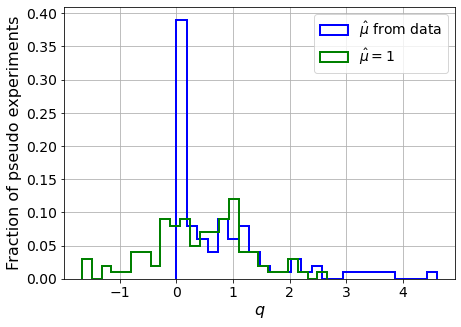

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  8905.81576043  8707.348587    8446.56902814
  8115.88391327  7714.82024077  7216.7733356   6628.50700104
  5931.19748652  5105.30761487  4124.82032244  2971.60648637
  1592.46306906    27.13830281 -1681.91446496 -3826.18694067]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf 10809.68335201 10691.58576521 10468.57465806


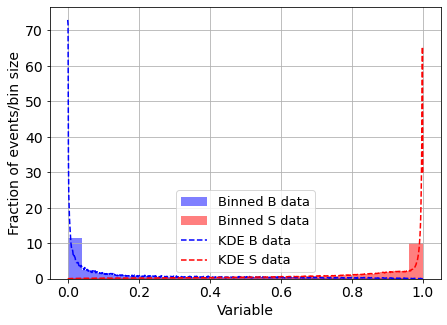

KDE Kernel:  epanechnikov
Background bandwidth:  0.0011635618505359071
Signal bandwidth:  0.0011635618505359071
This may take a while...
1 done
2 done
3 done
4 done


  0%|                                                                   | 3/2000 [00:00<06:56,  4.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6085604657492545
<p_{s}(Sdata)> = 4.218373004282682
<p_{b}(Bdata)> = 16.080642375619135
<p_{s}(Bdata)> = 0.25907885644707657


  0%|▏                                                                  | 6/2000 [00:01<07:17,  4.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17688491646047455
<p_{s}(Sdata)> = 11.938991674118181
<p_{b}(Bdata)> = 16.041216051059017
<p_{s}(Bdata)> = 0.2591587930557713


  0%|▎                                                                 | 10/2000 [00:02<07:33,  4.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23061481104743756
<p_{s}(Sdata)> = 13.201950583015694
<p_{b}(Bdata)> = 16.17801342087684
<p_{s}(Bdata)> = 0.2616390555178884


  1%|▍                                                                 | 12/2000 [00:02<08:03,  4.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21642822514010537
<p_{s}(Sdata)> = 9.40360002140518
<p_{b}(Bdata)> = 16.32559371992383
<p_{s}(Bdata)> = 0.2579196451028222


  1%|▌                                                                 | 17/2000 [00:03<06:39,  4.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22878677978839207
<p_{s}(Sdata)> = 7.620873616958964
<p_{b}(Bdata)> = 16.14263802832276
<p_{s}(Bdata)> = 0.2578217845363974


  1%|▉                                                                 | 29/2000 [00:06<05:10,  6.35it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21526141941650817
<p_{s}(Sdata)> = 15.041907697427394
<p_{b}(Bdata)> = 16.35345729344762
<p_{s}(Bdata)> = 0.2685535391179014
muhat = -0.1
<p_{b}(Sdata)> = 0.12834829430768924
<p_{s}(Sdata)> = 11.087962398497414
<p_{b}(Bdata)> = 16.378017794270775
<p_{s}(Bdata)> = 0.25890159001542584


  2%|█▎                                                                | 40/2000 [00:09<08:57,  3.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25048605767466037
<p_{s}(Sdata)> = 10.605613917627752
<p_{b}(Bdata)> = 16.156427319205
<p_{s}(Bdata)> = 0.25068840824919053


  2%|█▍                                                                | 44/2000 [00:09<05:23,  6.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17479173853965294
<p_{s}(Sdata)> = 12.83035324723515
<p_{b}(Bdata)> = 16.352949325199365
<p_{s}(Bdata)> = 0.2564622790751867


  2%|█▌                                                                | 47/2000 [00:10<05:12,  6.24it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21079765464454905
<p_{s}(Sdata)> = 16.53463503624182
<p_{b}(Bdata)> = 16.06392004839262
<p_{s}(Bdata)> = 0.26458316682874533
muhat = -0.1
<p_{b}(Sdata)> = 0.24030702920208305
<p_{s}(Sdata)> = 6.759222200411166
<p_{b}(Bdata)> = 15.804438617462647
<p_{s}(Bdata)> = 0.25474017352332445
muhat = -0.1
<p_{b}(Sdata)> = 0.1708951228651282
<p_{s}(Sdata)> = 4.528040209533597
<p_{b}(Bdata)> = 16.28365955209915
<p_{s}(Bdata)> = 0.25941693326808146


  2%|█▌                                                                | 49/2000 [00:10<04:14,  7.66it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23557573560637826
<p_{s}(Sdata)> = 23.278837521690377
<p_{b}(Bdata)> = 16.06919944061666
<p_{s}(Bdata)> = 0.27209885867106476
muhat = -0.1
<p_{b}(Sdata)> = 0.18927898662310108
<p_{s}(Sdata)> = 6.12809227207402
<p_{b}(Bdata)> = 16.177912103196793
<p_{s}(Bdata)> = 0.26305435602592364


  3%|█▉                                                                | 57/2000 [00:12<08:11,  3.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3071738506818221
<p_{s}(Sdata)> = 2.851177133687874
<p_{b}(Bdata)> = 16.187875617830784
<p_{s}(Bdata)> = 0.26131174652055866


  3%|█▉                                                                | 59/2000 [00:12<06:34,  4.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3430078809119125
<p_{s}(Sdata)> = 9.33881775009948
<p_{b}(Bdata)> = 16.101462509437425
<p_{s}(Bdata)> = 0.2554244743502411


  3%|██▏                                                               | 66/2000 [00:14<07:29,  4.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22988718719901682
<p_{s}(Sdata)> = 9.357532747130671
<p_{b}(Bdata)> = 16.40025584775726
<p_{s}(Bdata)> = 0.2563340046270231


  4%|██▍                                                               | 72/2000 [00:15<07:43,  4.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34594969115738844
<p_{s}(Sdata)> = 1.1832677781718526
<p_{b}(Bdata)> = 16.296213928879475
<p_{s}(Bdata)> = 0.2593082313417896


  5%|███▏                                                              | 96/2000 [00:22<06:42,  4.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22049066893153405
<p_{s}(Sdata)> = 3.3281846213580106
<p_{b}(Bdata)> = 16.09788039857109
<p_{s}(Bdata)> = 0.25777313572376737


  5%|███▎                                                              | 99/2000 [00:22<05:15,  6.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22994764544114032
<p_{s}(Sdata)> = 7.905974807421372
<p_{b}(Bdata)> = 15.69037800762965
<p_{s}(Bdata)> = 0.26003519955409543
muhat = -0.1
<p_{b}(Sdata)> = 0.3214569328762792
<p_{s}(Sdata)> = 3.1803242250575727
<p_{b}(Bdata)> = 16.28058972641886
<p_{s}(Bdata)> = 0.2541436460431831


  5%|███▍                                                             | 105/2000 [00:23<07:17,  4.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19329244795217995
<p_{s}(Sdata)> = 3.0493291964788387
<p_{b}(Bdata)> = 15.859346598019414
<p_{s}(Bdata)> = 0.2640405437817101


  7%|████▎                                                            | 131/2000 [00:29<06:03,  5.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17450362193770194
<p_{s}(Sdata)> = 9.284309763887654
<p_{b}(Bdata)> = 16.230378327062745
<p_{s}(Bdata)> = 0.26058615574963073


  7%|████▎                                                            | 134/2000 [00:30<07:12,  4.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2727073586824913
<p_{s}(Sdata)> = 4.557322818162463
<p_{b}(Bdata)> = 15.98169431202714
<p_{s}(Bdata)> = 0.2613030605987536


  7%|████▍                                                            | 138/2000 [00:31<05:57,  5.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3886673348474908
<p_{s}(Sdata)> = 6.813300697434766
<p_{b}(Bdata)> = 16.286388736920483
<p_{s}(Bdata)> = 0.25691068605628303


  7%|████▊                                                            | 147/2000 [00:33<07:26,  4.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33796873003796085
<p_{s}(Sdata)> = 7.9736252534552134
<p_{b}(Bdata)> = 16.258253140682367
<p_{s}(Bdata)> = 0.25817448036257484


  8%|████▉                                                            | 151/2000 [00:34<05:30,  5.60it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.09763381194746369
<p_{s}(Sdata)> = 27.588733815429404
<p_{b}(Bdata)> = 16.174351115601787
<p_{s}(Bdata)> = 0.26273773286499635


  8%|█████▏                                                           | 158/2000 [00:35<05:08,  5.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39720769685594626
<p_{s}(Sdata)> = 7.045074105923819
<p_{b}(Bdata)> = 16.330207647959625
<p_{s}(Bdata)> = 0.2549550227665317


  8%|█████▍                                                           | 167/2000 [00:37<05:44,  5.32it/s]

There are events with p(s)=0


  9%|█████▌                                                           | 173/2000 [00:38<05:04,  5.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4008589053318346
<p_{s}(Sdata)> = 12.239179629672162
<p_{b}(Bdata)> = 16.545085769411546
<p_{s}(Bdata)> = 0.2552711729513545
muhat = 2.1
<p_{b}(Sdata)> = 0.15161482326267042
<p_{s}(Sdata)> = 26.064641113941722
<p_{b}(Bdata)> = 16.007107469009533
<p_{s}(Bdata)> = 0.27003790972147723


  9%|█████▋                                                           | 176/2000 [00:39<07:33,  4.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3151066551456084
<p_{s}(Sdata)> = 1.1917213616992384
<p_{b}(Bdata)> = 16.189176380440077
<p_{s}(Bdata)> = 0.2644959357077522


  9%|█████▉                                                           | 183/2000 [00:40<05:40,  5.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4419577329944358
<p_{s}(Sdata)> = 6.954571794156542
<p_{b}(Bdata)> = 16.055954494618433
<p_{s}(Bdata)> = 0.2580320926125209
muhat = -0.1
<p_{b}(Sdata)> = 0.3221974936425226
<p_{s}(Sdata)> = 10.19659705118248
<p_{b}(Bdata)> = 16.290788521532765
<p_{s}(Bdata)> = 0.2618820005247671
muhat = -0.1
<p_{b}(Sdata)> = 0.3774350518612919
<p_{s}(Sdata)> = 10.811105794515246
<p_{b}(Bdata)> = 15.985824545645308
<p_{s}(Bdata)> = 0.26082333986460604


 10%|██████▎                                                          | 193/2000 [00:42<05:12,  5.79it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19713184014912427
<p_{s}(Sdata)> = 15.88421057679442
<p_{b}(Bdata)> = 16.190521066205246
<p_{s}(Bdata)> = 0.26926339709568115
muhat = -0.1
<p_{b}(Sdata)> = 0.2401929723638253
<p_{s}(Sdata)> = 3.272160461831122
<p_{b}(Bdata)> = 16.51355966846996
<p_{s}(Bdata)> = 0.25902371994915735


 10%|██████▎                                                          | 196/2000 [00:43<05:30,  5.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2618629905303303
<p_{s}(Sdata)> = 3.4765762369452418
<p_{b}(Bdata)> = 16.279733591483982
<p_{s}(Bdata)> = 0.25443235794238106


 10%|██████▌                                                          | 201/2000 [00:44<06:46,  4.42it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.12417339244650348
<p_{s}(Sdata)> = 18.436802560546877
<p_{b}(Bdata)> = 16.198729602787193
<p_{s}(Bdata)> = 0.27048518209882444


 10%|██████▌                                                          | 203/2000 [00:45<07:26,  4.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31604412250097413
<p_{s}(Sdata)> = 4.169655903712767
<p_{b}(Bdata)> = 16.133688086324803
<p_{s}(Bdata)> = 0.2569562766296202


 11%|██████▉                                                          | 215/2000 [00:48<08:50,  3.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29626236182483723
<p_{s}(Sdata)> = 10.746265368348999
<p_{b}(Bdata)> = 16.167942161555736
<p_{s}(Bdata)> = 0.25537806063913054


 11%|███████▏                                                         | 223/2000 [00:50<04:29,  6.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21655000702030092
<p_{s}(Sdata)> = 2.4139977522590463
<p_{b}(Bdata)> = 16.273001921646404
<p_{s}(Bdata)> = 0.2640616050178652
muhat = -0.1
<p_{b}(Sdata)> = 0.228456772724595
<p_{s}(Sdata)> = 6.035186652100944
<p_{b}(Bdata)> = 16.34460980762172
<p_{s}(Bdata)> = 0.2583708739326433


 12%|███████▌                                                         | 233/2000 [00:52<08:53,  3.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18845165801393995
<p_{s}(Sdata)> = 9.647496333103389
<p_{b}(Bdata)> = 16.317067043186075
<p_{s}(Bdata)> = 0.25786626257809664


 12%|███████▋                                                         | 235/2000 [00:53<07:44,  3.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27144268173035324
<p_{s}(Sdata)> = 4.983453429248467
<p_{b}(Bdata)> = 16.069829493712458
<p_{s}(Bdata)> = 0.25563730875930113


 12%|███████▉                                                         | 243/2000 [00:54<04:54,  5.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3472776036391834
<p_{s}(Sdata)> = 7.033042998196544
<p_{b}(Bdata)> = 16.290319543468858
<p_{s}(Bdata)> = 0.25661822597648065
muhat = -0.1
<p_{b}(Sdata)> = 0.29525051376973616
<p_{s}(Sdata)> = 11.57641270712548
<p_{b}(Bdata)> = 16.37703647461517
<p_{s}(Bdata)> = 0.25730996895279373


 12%|████████                                                         | 249/2000 [00:56<06:50,  4.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29468671461604473
<p_{s}(Sdata)> = 8.362035482743114
<p_{b}(Bdata)> = 16.207960279458508
<p_{s}(Bdata)> = 0.26139001141558316


 13%|████████▏                                                        | 251/2000 [00:56<06:40,  4.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32679869438332715
<p_{s}(Sdata)> = 7.961345916878898
<p_{b}(Bdata)> = 16.100980950849518
<p_{s}(Bdata)> = 0.26265534499189175


 13%|████████▎                                                        | 255/2000 [00:57<06:57,  4.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19161094395016182
<p_{s}(Sdata)> = 16.278893940498236
<p_{b}(Bdata)> = 16.17405084623887
<p_{s}(Bdata)> = 0.2563493640556047


 13%|████████▎                                                        | 257/2000 [00:57<06:08,  4.73it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.27092261294372955
<p_{s}(Sdata)> = 16.715488542098864
<p_{b}(Bdata)> = 16.14502832049479
<p_{s}(Bdata)> = 0.26897480930980316


 13%|████████▌                                                        | 262/2000 [00:58<04:19,  6.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2443236410315271
<p_{s}(Sdata)> = 9.757156953148154
<p_{b}(Bdata)> = 16.323948399866556
<p_{s}(Bdata)> = 0.2548145887021632
muhat = 2.1
<p_{b}(Sdata)> = 0.11316314677235871
<p_{s}(Sdata)> = 33.8973456661388
<p_{b}(Bdata)> = 16.370197771271382
<p_{s}(Bdata)> = 0.2646956078365084


 13%|████████▌                                                        | 265/2000 [00:59<07:02,  4.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25487329773916223
<p_{s}(Sdata)> = 4.354278337459021
<p_{b}(Bdata)> = 16.096050302692287
<p_{s}(Bdata)> = 0.2631748724579715


 13%|████████▋                                                        | 269/2000 [01:00<07:22,  3.91it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.33147341408900166
<p_{s}(Sdata)> = 21.81153608590924
<p_{b}(Bdata)> = 16.109180178514684
<p_{s}(Bdata)> = 0.27105589293089283


 14%|████████▊                                                        | 273/2000 [01:00<04:38,  6.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2594409250280135
<p_{s}(Sdata)> = 7.6275773316704445
<p_{b}(Bdata)> = 16.32837313735059
<p_{s}(Bdata)> = 0.2566808569746796
muhat = -0.1
<p_{b}(Sdata)> = 0.6099476227065831
<p_{s}(Sdata)> = 12.404939713037795
<p_{b}(Bdata)> = 16.133798446789566
<p_{s}(Bdata)> = 0.2512637300993938
muhat = -0.1
<p_{b}(Sdata)> = 0.13312472921077206
<p_{s}(Sdata)> = 17.596323039080737
<p_{b}(Bdata)> = 16.182084854205275
<p_{s}(Bdata)> = 0.2572345875626595


 14%|█████████                                                        | 280/2000 [01:02<07:31,  3.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3318183212787228
<p_{s}(Sdata)> = 3.358991896006466
<p_{b}(Bdata)> = 16.3053917750374
<p_{s}(Bdata)> = 0.2598960986657068


 14%|█████████▏                                                       | 283/2000 [01:03<07:29,  3.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.532789068058489
<p_{s}(Sdata)> = 8.731211833136161
<p_{b}(Bdata)> = 16.61449228352712
<p_{s}(Bdata)> = 0.2602834977125105


 14%|█████████▎                                                       | 287/2000 [01:03<04:59,  5.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17828602165350513
<p_{s}(Sdata)> = 6.7771706889840155
<p_{b}(Bdata)> = 16.22466529443359
<p_{s}(Bdata)> = 0.2618376009344758
muhat = -0.1
<p_{b}(Sdata)> = 0.3010409246799598
<p_{s}(Sdata)> = 9.381124690528653
<p_{b}(Bdata)> = 16.207917560394833
<p_{s}(Bdata)> = 0.2602374632382811


 14%|█████████▍                                                       | 290/2000 [01:04<04:37,  6.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.0691673170243836
<p_{s}(Sdata)> = 5.561557432768944
<p_{b}(Bdata)> = 16.267232647018854
<p_{s}(Bdata)> = 0.26223126164282756


 15%|█████████▌                                                       | 293/2000 [01:04<03:47,  7.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2898477744169163
<p_{s}(Sdata)> = 14.360645766214205
<p_{b}(Bdata)> = 16.043662249230657
<p_{s}(Bdata)> = 0.26722217349294614
muhat = -0.1
<p_{b}(Sdata)> = 0.15861062287745956
<p_{s}(Sdata)> = 6.422834425722184
<p_{b}(Bdata)> = 16.239496174239033
<p_{s}(Bdata)> = 0.25791743939547135


 15%|██████████                                                       | 308/2000 [01:09<09:53,  2.85it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15970023467880415
<p_{s}(Sdata)> = 22.555942905515177
<p_{b}(Bdata)> = 16.027347179645098
<p_{s}(Bdata)> = 0.26856214457431016


 16%|██████████▏                                                      | 312/2000 [01:10<05:54,  4.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1489461275762712
<p_{s}(Sdata)> = 13.277840817527926
<p_{b}(Bdata)> = 16.632789295949387
<p_{s}(Bdata)> = 0.26602296375291096
muhat = 2.1
<p_{b}(Sdata)> = 0.17706200912328623
<p_{s}(Sdata)> = 12.921525907959593
<p_{b}(Bdata)> = 16.27232607919187
<p_{s}(Bdata)> = 0.2733307296885472


 16%|██████████▎                                                      | 318/2000 [01:11<06:32,  4.28it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18636593410981567
<p_{s}(Sdata)> = 13.557870491204774
<p_{b}(Bdata)> = 16.350339309958443
<p_{s}(Bdata)> = 0.27189792367729615


 16%|██████████▍                                                      | 320/2000 [01:12<06:00,  4.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37613929440698357
<p_{s}(Sdata)> = 1.8786778926574892
<p_{b}(Bdata)> = 16.34855786582153
<p_{s}(Bdata)> = 0.2607931783622648


 16%|██████████▌                                                      | 324/2000 [01:13<07:37,  3.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18632870178218763
<p_{s}(Sdata)> = 2.5778101536836306
<p_{b}(Bdata)> = 16.20275038282425
<p_{s}(Bdata)> = 0.2532806283458152


 16%|██████████▋                                                      | 330/2000 [01:14<06:26,  4.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2391960637307105
<p_{s}(Sdata)> = 15.593649852057203
<p_{b}(Bdata)> = 16.445538231341388
<p_{s}(Bdata)> = 0.2591503717728267


 17%|██████████▊                                                      | 332/2000 [01:14<05:13,  5.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18050995833175404
<p_{s}(Sdata)> = 10.221766103264606
<p_{b}(Bdata)> = 16.309999347363036
<p_{s}(Bdata)> = 0.2561463767616393


 17%|██████████▉                                                      | 336/2000 [01:15<06:53,  4.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.0479338139875725
<p_{s}(Sdata)> = 31.404063055104885
<p_{b}(Bdata)> = 16.104388386109513
<p_{s}(Bdata)> = 0.26782465654370924


 17%|███████████                                                      | 340/2000 [01:16<05:47,  4.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3872197375441192
<p_{s}(Sdata)> = 10.0764007526514
<p_{b}(Bdata)> = 16.053021190150172
<p_{s}(Bdata)> = 0.2620705976098807


 17%|███████████▏                                                     | 344/2000 [01:17<06:37,  4.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26673018770262175
<p_{s}(Sdata)> = 9.609229140354559
<p_{b}(Bdata)> = 16.42769556062975
<p_{s}(Bdata)> = 0.2554823013444693


 18%|███████████▌                                                     | 355/2000 [01:20<04:54,  5.58it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22856277687294993
<p_{s}(Sdata)> = 24.469329282879528
<p_{b}(Bdata)> = 16.355551510353816
<p_{s}(Bdata)> = 0.2598020782993212
muhat = -0.1
<p_{b}(Sdata)> = 0.19682639106512578
<p_{s}(Sdata)> = 7.2783593915519935
<p_{b}(Bdata)> = 16.18839650587706
<p_{s}(Bdata)> = 0.25199810265026246


 18%|███████████▋                                                     | 360/2000 [01:21<04:52,  5.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27907233898038597
<p_{s}(Sdata)> = 4.470767548066202
<p_{b}(Bdata)> = 16.307980225993745
<p_{s}(Bdata)> = 0.2604654199814531


 18%|███████████▉                                                     | 366/2000 [01:22<05:17,  5.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19246639686135156
<p_{s}(Sdata)> = 12.190891332170542
<p_{b}(Bdata)> = 16.13189288532987
<p_{s}(Bdata)> = 0.25588644892037515


 19%|████████████                                                     | 372/2000 [01:23<04:12,  6.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1877868628023423
<p_{s}(Sdata)> = 8.95053005132947
<p_{b}(Bdata)> = 16.066308396363883
<p_{s}(Bdata)> = 0.26348045852806623


 19%|████████████▍                                                    | 381/2000 [01:25<04:52,  5.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2384567910374527
<p_{s}(Sdata)> = 5.580079658905411
<p_{b}(Bdata)> = 15.948466299621533
<p_{s}(Bdata)> = 0.25774711358171515
muhat = 2.1
<p_{b}(Sdata)> = 0.41190587404506107
<p_{s}(Sdata)> = 17.728767948366368
<p_{b}(Bdata)> = 16.211027820631834
<p_{s}(Bdata)> = 0.27590179910903373
muhat = 2.1
<p_{b}(Sdata)> = 0.2255014026959145
<p_{s}(Sdata)> = 18.580075620934004
<p_{b}(Bdata)> = 16.26337463018347
<p_{s}(Bdata)> = 0.27478094972679495


 19%|████████████▌                                                    | 385/2000 [01:26<04:03,  6.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22686996356203706
<p_{s}(Sdata)> = 2.6956372543780036
<p_{b}(Bdata)> = 16.21198453457814
<p_{s}(Bdata)> = 0.26603782641228163
muhat = 2.1
<p_{b}(Sdata)> = 0.20314657453500534
<p_{s}(Sdata)> = 14.187376185878682
<p_{b}(Bdata)> = 16.347865062164697
<p_{s}(Bdata)> = 0.27152187556903323


 19%|████████████▌                                                    | 387/2000 [01:26<06:35,  4.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1389573302079937
<p_{s}(Sdata)> = 9.694035505743841
<p_{b}(Bdata)> = 16.01608278654413
<p_{s}(Bdata)> = 0.2648806149039612


 20%|████████████▋                                                    | 391/2000 [01:27<04:51,  5.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17345621068731407
<p_{s}(Sdata)> = 4.456177375852546
<p_{b}(Bdata)> = 16.235173312945932
<p_{s}(Bdata)> = 0.2583359533460418


 20%|████████████▊                                                    | 395/2000 [01:28<05:43,  4.67it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.6071225836807087
<p_{s}(Sdata)> = 21.684190122910856
<p_{b}(Bdata)> = 15.744855267063596
<p_{s}(Bdata)> = 0.2757050473591239


 20%|████████████▉                                                    | 397/2000 [01:28<05:31,  4.83it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5226332293524316
<p_{s}(Sdata)> = 20.544443870351692
<p_{b}(Bdata)> = 15.976798480354972
<p_{s}(Bdata)> = 0.2722824390293006


 20%|█████████████                                                    | 402/2000 [01:29<04:26,  5.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27353620378822996
<p_{s}(Sdata)> = 6.039115231236996
<p_{b}(Bdata)> = 16.18932287113079
<p_{s}(Bdata)> = 0.25404669956890213
muhat = -0.1
<p_{b}(Sdata)> = 0.3487044485929619
<p_{s}(Sdata)> = 0.9251839821422889
<p_{b}(Bdata)> = 16.35703760747065
<p_{s}(Bdata)> = 0.26229282917154434


 20%|█████████████▏                                                   | 406/2000 [01:30<04:51,  5.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2508556366068963
<p_{s}(Sdata)> = 4.909832691166007
<p_{b}(Bdata)> = 16.531660097219817
<p_{s}(Bdata)> = 0.2530599703571098


 20%|█████████████▎                                                   | 410/2000 [01:31<04:34,  5.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24008473123035332
<p_{s}(Sdata)> = 4.2521849735315245
<p_{b}(Bdata)> = 16.061763174107277
<p_{s}(Bdata)> = 0.26312399734707187
muhat = -0.1
<p_{b}(Sdata)> = 0.15456959698588965
<p_{s}(Sdata)> = 4.294638936689797
<p_{b}(Bdata)> = 15.939178459734162
<p_{s}(Bdata)> = 0.26174606571831527


 21%|█████████████▋                                                   | 420/2000 [01:33<04:00,  6.58it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2494286332314918
<p_{s}(Sdata)> = 8.772880293121585
<p_{b}(Bdata)> = 16.26471016658418
<p_{s}(Bdata)> = 0.2794534658815571
muhat = -0.1
<p_{b}(Sdata)> = 3.1003440456773514
<p_{s}(Sdata)> = 9.090851099429846
<p_{b}(Bdata)> = 16.00027944198741
<p_{s}(Bdata)> = 0.26251991892697557


 21%|█████████████▊                                                   | 424/2000 [01:33<04:03,  6.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22034035074347563
<p_{s}(Sdata)> = 8.223647136907868
<p_{b}(Bdata)> = 16.361249842203758
<p_{s}(Bdata)> = 0.26190644880451347
muhat = -0.1
<p_{b}(Sdata)> = 0.443745736216786
<p_{s}(Sdata)> = 8.333127932826521
<p_{b}(Bdata)> = 16.20792950271415
<p_{s}(Bdata)> = 0.2573302478197175


 21%|█████████████▊                                                   | 426/2000 [01:34<05:13,  5.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4458986224942138
<p_{s}(Sdata)> = 9.06522355997864
<p_{b}(Bdata)> = 16.254841540746376
<p_{s}(Bdata)> = 0.26363418304601705


 22%|██████████████▎                                                  | 440/2000 [01:37<04:53,  5.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19244982425012144
<p_{s}(Sdata)> = 6.880475652821537
<p_{b}(Bdata)> = 16.244680000102626
<p_{s}(Bdata)> = 0.2520064740127773


 22%|██████████████▎                                                  | 441/2000 [01:37<04:36,  5.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21457568294588744
<p_{s}(Sdata)> = 3.4337592059980366
<p_{b}(Bdata)> = 16.006128125886942
<p_{s}(Bdata)> = 0.2573535342394251


 22%|██████████████▍                                                  | 446/2000 [01:38<03:37,  7.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2657620238048201
<p_{s}(Sdata)> = 6.036279155266133
<p_{b}(Bdata)> = 16.403295456756315
<p_{s}(Bdata)> = 0.25542623516226043


 23%|██████████████▋                                                  | 451/2000 [01:39<05:29,  4.70it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1256306865508691
<p_{s}(Sdata)> = 25.656575214233637
<p_{b}(Bdata)> = 16.140323386317284
<p_{s}(Bdata)> = 0.266846705402078


 23%|██████████████▋                                                  | 453/2000 [01:40<06:19,  4.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2880907522682511
<p_{s}(Sdata)> = 3.9528142965049287
<p_{b}(Bdata)> = 16.165172554312775
<p_{s}(Bdata)> = 0.25745999572744926


 23%|██████████████▊                                                  | 457/2000 [01:40<04:01,  6.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25460673242915277
<p_{s}(Sdata)> = 8.550382860396057
<p_{b}(Bdata)> = 16.019902326124836
<p_{s}(Bdata)> = 0.26106149107445686
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.3598884565418686
<p_{s}(Sdata)> = 7.683411206727525
<p_{b}(Bdata)> = 16.012461695186676
<p_{s}(Bdata)> = 0.26088301712711465


 23%|██████████████▉                                                  | 460/2000 [01:41<03:57,  6.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.6241051941204327
<p_{s}(Sdata)> = 2.3524144684698136
<p_{b}(Bdata)> = 16.295691029560928
<p_{s}(Bdata)> = 0.25674677818360386
muhat = -0.1
<p_{b}(Sdata)> = 0.22418314807302828
<p_{s}(Sdata)> = 10.768784124918726
<p_{b}(Bdata)> = 16.089505273861207
<p_{s}(Bdata)> = 0.2619624921924653


 23%|███████████████                                                  | 465/2000 [01:42<05:57,  4.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18328110457994293
<p_{s}(Sdata)> = 9.797766652630454
<p_{b}(Bdata)> = 15.95234982578251
<p_{s}(Bdata)> = 0.26172620956922854


 23%|███████████████▏                                                 | 467/2000 [01:42<05:58,  4.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25239544825325916
<p_{s}(Sdata)> = 7.384519529007827
<p_{b}(Bdata)> = 16.428424724233825
<p_{s}(Bdata)> = 0.2598155940659807


 24%|███████████████▋                                                 | 482/2000 [01:46<05:53,  4.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.368791150812788
<p_{s}(Sdata)> = 7.674958259443877
<p_{b}(Bdata)> = 16.18471338726098
<p_{s}(Bdata)> = 0.25748510872195596


 24%|███████████████▋                                                 | 484/2000 [01:46<06:15,  4.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21516678267604095
<p_{s}(Sdata)> = 12.351397212612296
<p_{b}(Bdata)> = 15.887448911250045
<p_{s}(Bdata)> = 0.2599851948551373


 24%|███████████████▊                                                 | 488/2000 [01:47<03:57,  6.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28741242850480053
<p_{s}(Sdata)> = 2.167612103957772
<p_{b}(Bdata)> = 16.296337925645414
<p_{s}(Bdata)> = 0.2527614938085796
muhat = -0.1
<p_{b}(Sdata)> = 0.48438791780544455
<p_{s}(Sdata)> = 4.45966677165263
<p_{b}(Bdata)> = 16.03077525352695
<p_{s}(Bdata)> = 0.2612855532983752
muhat = 2.1
<p_{b}(Sdata)> = 0.16023948717305544
<p_{s}(Sdata)> = 18.540688102529476
<p_{b}(Bdata)> = 16.08384191141592
<p_{s}(Bdata)> = 0.26860953960380224


 24%|███████████████▉                                                 | 490/2000 [01:47<03:16,  7.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20443965621792443
<p_{s}(Sdata)> = 18.603853570296053
<p_{b}(Bdata)> = 16.175596426965143
<p_{s}(Bdata)> = 0.2622520513537311


 25%|████████████████                                                 | 494/2000 [01:48<04:20,  5.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3470896939826813
<p_{s}(Sdata)> = 5.879907074358434
<p_{b}(Bdata)> = 15.987806286972381
<p_{s}(Bdata)> = 0.2584716747887291


 25%|████████████████                                                 | 495/2000 [01:48<04:05,  6.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.11325526880860484
<p_{s}(Sdata)> = 20.402678259055705
<p_{b}(Bdata)> = 16.052287894953956
<p_{s}(Bdata)> = 0.2576041838513642


 25%|████████████████▍                                                | 506/2000 [01:51<05:43,  4.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1813021589345587
<p_{s}(Sdata)> = 11.776180461703676
<p_{b}(Bdata)> = 16.1254373184339
<p_{s}(Bdata)> = 0.25702878479229335


 25%|████████████████▌                                                | 509/2000 [01:51<05:56,  4.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2517848071823441
<p_{s}(Sdata)> = 1.8464410181638502
<p_{b}(Bdata)> = 16.28217990813733
<p_{s}(Bdata)> = 0.2552189391836887


 26%|████████████████▉                                                | 520/2000 [01:54<03:46,  6.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19343551907382148
<p_{s}(Sdata)> = 7.401355899161579
<p_{b}(Bdata)> = 16.477203333015247
<p_{s}(Bdata)> = 0.260468903767995
muhat = 2.1
<p_{b}(Sdata)> = 0.22723356403997721
<p_{s}(Sdata)> = 17.213863083250352
<p_{b}(Bdata)> = 16.15244283636163
<p_{s}(Bdata)> = 0.27422298860585387


 26%|█████████████████▏                                               | 527/2000 [01:55<03:59,  6.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.13909488405088932
<p_{s}(Sdata)> = 12.493232950492084
<p_{b}(Bdata)> = 16.21796713218075
<p_{s}(Bdata)> = 0.25412195877278415
muhat = -0.1
<p_{b}(Sdata)> = 0.180544027455668
<p_{s}(Sdata)> = 12.807842664468595
<p_{b}(Bdata)> = 16.13193932376317
<p_{s}(Bdata)> = 0.2551333070144485


 26%|█████████████████▏                                               | 529/2000 [01:55<03:50,  6.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19434532699193874
<p_{s}(Sdata)> = 6.332160891760475
<p_{b}(Bdata)> = 16.280525336495597
<p_{s}(Bdata)> = 0.2546345005572389


 27%|█████████████████▍                                               | 538/2000 [01:57<04:41,  5.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5717688894551343
<p_{s}(Sdata)> = 7.33567795445086
<p_{b}(Bdata)> = 16.212126412935994
<p_{s}(Bdata)> = 0.2618199585111705
muhat = -0.1
<p_{b}(Sdata)> = 0.22271343638762672
<p_{s}(Sdata)> = 4.203028452870404
<p_{b}(Bdata)> = 15.94915578168152
<p_{s}(Bdata)> = 0.26298854387632215


 27%|█████████████████▌                                               | 540/2000 [01:58<05:35,  4.35it/s]

There are events with p(s)=0


 27%|█████████████████▌                                               | 541/2000 [01:58<07:05,  3.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1899166048612545
<p_{s}(Sdata)> = 9.350957346298078
<p_{b}(Bdata)> = 16.20222209251484
<p_{s}(Bdata)> = 0.2556209588107948


 27%|█████████████████▋                                               | 546/2000 [01:59<05:13,  4.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23490393644521493
<p_{s}(Sdata)> = 9.224613925114053
<p_{b}(Bdata)> = 16.459518047418854
<p_{s}(Bdata)> = 0.25938726566628534


 28%|█████████████████▉                                               | 550/2000 [02:00<04:52,  4.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30138346090144785
<p_{s}(Sdata)> = 4.052685204394676
<p_{b}(Bdata)> = 16.170323804195615
<p_{s}(Bdata)> = 0.2637152084770268


 28%|██████████████████▏                                              | 558/2000 [02:01<03:22,  7.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18549151793652302
<p_{s}(Sdata)> = 21.943322847013285
<p_{b}(Bdata)> = 16.045910881975995
<p_{s}(Bdata)> = 0.2649456769434935
muhat = -0.1
<p_{b}(Sdata)> = 0.23790694656847536
<p_{s}(Sdata)> = 5.227127480255751
<p_{b}(Bdata)> = 16.60220215931863
<p_{s}(Bdata)> = 0.25905411781681154
muhat = -0.1
<p_{b}(Sdata)> = 0.21008297616754046
<p_{s}(Sdata)> = 10.293666406540314
<p_{b}(Bdata)> = 16.320523030637528
<p_{s}(Bdata)> = 0.26022426868425763


 28%|██████████████████▏                                              | 560/2000 [02:02<03:37,  6.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2845930469474774
<p_{s}(Sdata)> = 1.0636124292962
<p_{b}(Bdata)> = 16.025493015339347
<p_{s}(Bdata)> = 0.25715794087052235
There are events with p(s)=0


 28%|██████████████████▎                                              | 564/2000 [02:02<03:26,  6.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2000844900373263
<p_{s}(Sdata)> = 17.447563450950092
<p_{b}(Bdata)> = 16.2157872959087
<p_{s}(Bdata)> = 0.2594516335430789


 28%|██████████████████▎                                              | 565/2000 [02:03<03:48,  6.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22061580237023448
<p_{s}(Sdata)> = 11.777628249472587
<p_{b}(Bdata)> = 15.879109313057247
<p_{s}(Bdata)> = 0.25681869889919384


 28%|██████████████████▍                                              | 568/2000 [02:03<04:29,  5.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24026557258281342
<p_{s}(Sdata)> = 11.708175209313568
<p_{b}(Bdata)> = 15.883385229077607
<p_{s}(Bdata)> = 0.25669202572076844


 29%|██████████████████▋                                              | 574/2000 [02:04<04:28,  5.31it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.7808733541091841
<p_{s}(Sdata)> = 19.588135195176882
<p_{b}(Bdata)> = 16.174830252482167
<p_{s}(Bdata)> = 0.2653435193086734
muhat = 2.1
<p_{b}(Sdata)> = 0.43754498143593773
<p_{s}(Sdata)> = 19.477850671157995
<p_{b}(Bdata)> = 16.153886639679968
<p_{s}(Bdata)> = 0.2653025719504801


 29%|██████████████████▋                                              | 576/2000 [02:05<04:44,  5.01it/s]

There are events with p(s)=0


 29%|███████████████████                                              | 588/2000 [02:08<04:09,  5.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2840707350352225
<p_{s}(Sdata)> = 7.661245585676616
<p_{b}(Bdata)> = 16.279180888523502
<p_{s}(Bdata)> = 0.2589837379449076
muhat = -0.1
<p_{b}(Sdata)> = 0.2751810111016737
<p_{s}(Sdata)> = 10.15853777868458
<p_{b}(Bdata)> = 15.804893587555327
<p_{s}(Bdata)> = 0.2623598750886602


 30%|███████████████████▎                                             | 595/2000 [02:10<04:44,  4.94it/s]

There are events with p(s)=0


 30%|███████████████████▍                                             | 597/2000 [02:10<04:39,  5.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.36972416004873615
<p_{s}(Sdata)> = 19.70219597441367
<p_{b}(Bdata)> = 16.00938602689017
<p_{s}(Bdata)> = 0.27143989867029616


 30%|███████████████████▌                                             | 601/2000 [02:10<03:23,  6.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31394679402423253
<p_{s}(Sdata)> = 5.162019949501074
<p_{b}(Bdata)> = 16.503271497142254
<p_{s}(Bdata)> = 0.26168868902113057


 30%|███████████████████▋                                             | 604/2000 [02:11<03:40,  6.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15020434440180044
<p_{s}(Sdata)> = 12.73531459396001
<p_{b}(Bdata)> = 16.319942288777206
<p_{s}(Bdata)> = 0.26379280612251943


 30%|███████████████████▋                                             | 607/2000 [02:11<03:31,  6.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2333073589157805
<p_{s}(Sdata)> = 8.341046026617477
<p_{b}(Bdata)> = 16.06765136972423
<p_{s}(Bdata)> = 0.2596014791443624
muhat = -0.1
<p_{b}(Sdata)> = 0.42989960335682675
<p_{s}(Sdata)> = 4.119999521976629
<p_{b}(Bdata)> = 16.31078486381592
<p_{s}(Bdata)> = 0.2598860702675262


 31%|███████████████████▉                                             | 614/2000 [02:13<03:56,  5.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23608567374100922
<p_{s}(Sdata)> = 13.58966369189481
<p_{b}(Bdata)> = 16.18295301398028
<p_{s}(Bdata)> = 0.25539111319251623


 31%|████████████████████▏                                            | 622/2000 [02:15<03:57,  5.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46936143431252403
<p_{s}(Sdata)> = 2.4937101163309285
<p_{b}(Bdata)> = 16.285905788272434
<p_{s}(Bdata)> = 0.2597735373133507
muhat = -0.1
<p_{b}(Sdata)> = 0.30113308544151957
<p_{s}(Sdata)> = 5.770264804154877
<p_{b}(Bdata)> = 16.329476753598446
<p_{s}(Bdata)> = 0.25911961604103656


 31%|████████████████████▍                                            | 629/2000 [02:16<04:12,  5.44it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23159973858849195
<p_{s}(Sdata)> = 24.59393426590478
<p_{b}(Bdata)> = 15.762104489564535
<p_{s}(Bdata)> = 0.2649609894319992


 32%|████████████████████▋                                            | 637/2000 [02:18<05:23,  4.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3561166813685946
<p_{s}(Sdata)> = 4.886464021579953
<p_{b}(Bdata)> = 15.983383350299896
<p_{s}(Bdata)> = 0.2611946061301141


 32%|████████████████████▊                                            | 641/2000 [02:19<03:53,  5.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34564926826028475
<p_{s}(Sdata)> = 1.1305005334026934
<p_{b}(Bdata)> = 15.953447937178536
<p_{s}(Bdata)> = 0.2586961447284289
muhat = -0.1
<p_{b}(Sdata)> = 0.23699524695396004
<p_{s}(Sdata)> = 2.7719542744849943
<p_{b}(Bdata)> = 16.532043482608305
<p_{s}(Bdata)> = 0.2583641337105557


 32%|████████████████████▉                                            | 645/2000 [02:20<05:48,  3.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24663732784904813
<p_{s}(Sdata)> = 3.5644247325029155
<p_{b}(Bdata)> = 16.21435878199754
<p_{s}(Bdata)> = 0.25999499726720426
There are events with p(s)=0


 32%|█████████████████████                                            | 647/2000 [02:20<05:31,  4.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20164451732593075
<p_{s}(Sdata)> = 19.97930947571732
<p_{b}(Bdata)> = 16.357413770561195
<p_{s}(Bdata)> = 0.26847771694164085


 33%|█████████████████████▏                                           | 651/2000 [02:21<03:50,  5.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.275601517854811
<p_{s}(Sdata)> = 9.291186598303971
<p_{b}(Bdata)> = 16.200096700527002
<p_{s}(Bdata)> = 0.2609872833768219
muhat = -0.1
<p_{b}(Sdata)> = 0.1934003819800778
<p_{s}(Sdata)> = 3.830024820368384
<p_{b}(Bdata)> = 16.081091618213854
<p_{s}(Bdata)> = 0.26588382446531655


 33%|█████████████████████▎                                           | 655/2000 [02:22<04:36,  4.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2593130450261939
<p_{s}(Sdata)> = 1.8422694554509325
<p_{b}(Bdata)> = 16.043958360290198
<p_{s}(Bdata)> = 0.2608932325013646


 33%|█████████████████████▍                                           | 659/2000 [02:23<04:12,  5.32it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20687107974864455
<p_{s}(Sdata)> = 20.344412155056958
<p_{b}(Bdata)> = 16.310178383191005
<p_{s}(Bdata)> = 0.2713749655136247


 33%|█████████████████████▌                                           | 665/2000 [02:24<04:28,  4.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20794331781460787
<p_{s}(Sdata)> = 11.654173322552014
<p_{b}(Bdata)> = 16.3572244951145
<p_{s}(Bdata)> = 0.2585763303967156


 34%|█████████████████████▉                                           | 676/2000 [02:27<07:20,  3.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2874049054781429
<p_{s}(Sdata)> = 1.886438797893551
<p_{b}(Bdata)> = 16.363201523938194
<p_{s}(Bdata)> = 0.26394767360790505


 34%|██████████████████████▏                                          | 681/2000 [02:28<04:37,  4.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33493737394523954
<p_{s}(Sdata)> = 4.72281674488141
<p_{b}(Bdata)> = 16.03597702947425
<p_{s}(Bdata)> = 0.2575386813939943


 34%|██████████████████████▍                                          | 689/2000 [02:30<03:56,  5.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34991963883151456
<p_{s}(Sdata)> = 5.520850640930124
<p_{b}(Bdata)> = 16.157935811936266
<p_{s}(Bdata)> = 0.2668585939795271


 35%|██████████████████████▍                                          | 691/2000 [02:31<06:16,  3.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44817992810082385
<p_{s}(Sdata)> = 5.429309781396774
<p_{b}(Bdata)> = 16.412960440987003
<p_{s}(Bdata)> = 0.2589371093972654


 35%|██████████████████████▌                                          | 693/2000 [02:31<04:57,  4.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17279053650541476
<p_{s}(Sdata)> = 11.801844906860406
<p_{b}(Bdata)> = 16.09427577983477
<p_{s}(Bdata)> = 0.26131263078432265


 35%|██████████████████████▉                                          | 706/2000 [02:34<04:03,  5.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16351296315140249
<p_{s}(Sdata)> = 14.6617037723438
<p_{b}(Bdata)> = 16.12125202711651
<p_{s}(Bdata)> = 0.2615049290347623
muhat = 2.1
<p_{b}(Sdata)> = 0.133467850789638
<p_{s}(Sdata)> = 32.471376162932536
<p_{b}(Bdata)> = 16.008470124486987
<p_{s}(Bdata)> = 0.2699487281135786
muhat = -0.1
<p_{b}(Sdata)> = 0.2909468584077076
<p_{s}(Sdata)> = 7.038753061794987
<p_{b}(Bdata)> = 16.259401301158594
<p_{s}(Bdata)> = 0.2564065313423544


 36%|███████████████████████▎                                         | 716/2000 [02:37<06:29,  3.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4741442004532257
<p_{s}(Sdata)> = 11.671819729388423
<p_{b}(Bdata)> = 16.312167617717854
<p_{s}(Bdata)> = 0.25981229415573326


 36%|███████████████████████▍                                         | 721/2000 [02:38<05:05,  4.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28787064677150637
<p_{s}(Sdata)> = 3.01302289353684
<p_{b}(Bdata)> = 15.997693619799124
<p_{s}(Bdata)> = 0.25631332908281595


 37%|███████████████████████▊                                         | 733/2000 [02:41<03:53,  5.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21074665544955481
<p_{s}(Sdata)> = 5.79293183202271
<p_{b}(Bdata)> = 16.318445150283644
<p_{s}(Bdata)> = 0.2564781605878629


 37%|███████████████████████▉                                         | 737/2000 [02:42<03:19,  6.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.14881308354519673
<p_{s}(Sdata)> = 3.873962765545821
<p_{b}(Bdata)> = 16.270183669207633
<p_{s}(Bdata)> = 0.26207166997251474
muhat = -0.1
<p_{b}(Sdata)> = 0.23828743131974456
<p_{s}(Sdata)> = 1.8284977523819554
<p_{b}(Bdata)> = 15.867832772800787
<p_{s}(Bdata)> = 0.26080951300336297
muhat = 2.1
<p_{b}(Sdata)> = 0.13511739459697192
<p_{s}(Sdata)> = 16.960435177882246
<p_{b}(Bdata)> = 16.20835183660769
<p_{s}(Bdata)> = 0.26829168327832675


 37%|████████████████████████                                         | 742/2000 [02:43<03:25,  6.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2540299918071372
<p_{s}(Sdata)> = 4.537799777637517
<p_{b}(Bdata)> = 16.116097206783117
<p_{s}(Bdata)> = 0.26042448733198786
muhat = 2.1
<p_{b}(Sdata)> = 0.1623266891471478
<p_{s}(Sdata)> = 14.238067320633375
<p_{b}(Bdata)> = 16.33762258693248
<p_{s}(Bdata)> = 0.2770578788982191


 37%|████████████████████████▏                                        | 743/2000 [02:43<03:30,  5.96it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.27342900062638525
<p_{s}(Sdata)> = 21.052718658023863
<p_{b}(Bdata)> = 16.18847337044334
<p_{s}(Bdata)> = 0.26710142349144045


 38%|████████████████████████▍                                        | 750/2000 [02:44<03:36,  5.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36258690592477516
<p_{s}(Sdata)> = 2.6787507379273845
<p_{b}(Bdata)> = 15.893625939661284
<p_{s}(Bdata)> = 0.2715584301989259


 38%|████████████████████████▌                                        | 755/2000 [02:45<04:09,  4.99it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.12345134023513041
<p_{s}(Sdata)> = 30.590030557262914
<p_{b}(Bdata)> = 16.42971872599509
<p_{s}(Bdata)> = 0.273835484787027


 38%|████████████████████████▌                                        | 757/2000 [02:46<05:42,  3.62it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1655541535648521
<p_{s}(Sdata)> = 13.120784293664785
<p_{b}(Bdata)> = 16.49747580890334
<p_{s}(Bdata)> = 0.27565634247857185


 38%|████████████████████████▊                                        | 763/2000 [02:48<05:24,  3.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.819689791202831
<p_{s}(Sdata)> = 2.916438428713744
<p_{b}(Bdata)> = 16.269432105550294
<p_{s}(Bdata)> = 0.25428684739971597


 38%|█████████████████████████                                        | 770/2000 [02:49<03:36,  5.69it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21466197667010256
<p_{s}(Sdata)> = 18.877692082771876
<p_{b}(Bdata)> = 16.13122676838286
<p_{s}(Bdata)> = 0.2698636682446945
muhat = 2.1
<p_{b}(Sdata)> = 0.21746605925172202
<p_{s}(Sdata)> = 15.61830455820684
<p_{b}(Bdata)> = 16.063342368529543
<p_{s}(Bdata)> = 0.2721400493750775


 39%|█████████████████████████                                        | 771/2000 [02:49<04:43,  4.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38468264543894354
<p_{s}(Sdata)> = 12.403914612432594
<p_{b}(Bdata)> = 16.32779023199255
<p_{s}(Bdata)> = 0.25731080816733676


 39%|█████████████████████████▏                                       | 774/2000 [02:50<04:10,  4.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37669428364877633
<p_{s}(Sdata)> = 2.2525680044207794
<p_{b}(Bdata)> = 16.061486890786348
<p_{s}(Bdata)> = 0.2622962418969781


 39%|█████████████████████████▎                                       | 779/2000 [02:51<05:24,  3.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20186308015402615
<p_{s}(Sdata)> = 13.63978644877824
<p_{b}(Bdata)> = 16.133852830827927
<p_{s}(Bdata)> = 0.25810696139914957


 39%|█████████████████████████▌                                       | 788/2000 [02:53<03:41,  5.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2487841619960911
<p_{s}(Sdata)> = 5.36170246260464
<p_{b}(Bdata)> = 16.360673768734475
<p_{s}(Bdata)> = 0.2593071710276521
muhat = -0.1
<p_{b}(Sdata)> = 0.289559489053605
<p_{s}(Sdata)> = 7.616534407289099
<p_{b}(Bdata)> = 16.385234885844728
<p_{s}(Bdata)> = 0.253131865643638


 40%|█████████████████████████▊                                       | 796/2000 [02:55<03:45,  5.34it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.11498670843456107
<p_{s}(Sdata)> = 28.665628305153234
<p_{b}(Bdata)> = 16.226045296904157
<p_{s}(Bdata)> = 0.271079548281002
muhat = -0.1
<p_{b}(Sdata)> = 0.21940395308187752
<p_{s}(Sdata)> = 16.2740275216204
<p_{b}(Bdata)> = 16.263266018232216
<p_{s}(Bdata)> = 0.2550509628129254
muhat = -0.1
<p_{b}(Sdata)> = 0.23585502345287226
<p_{s}(Sdata)> = 8.723784797296773
<p_{b}(Bdata)> = 16.1100146233717
<p_{s}(Bdata)> = 0.2586082572623253


 40%|██████████████████████████▏                                      | 807/2000 [02:58<05:44,  3.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36162214963058953
<p_{s}(Sdata)> = 5.136543249202421
<p_{b}(Bdata)> = 16.289564275220233
<p_{s}(Bdata)> = 0.2596636274734103


 41%|██████████████████████████▌                                      | 819/2000 [03:01<05:31,  3.56it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18992374978325033
<p_{s}(Sdata)> = 17.88518316474813
<p_{b}(Bdata)> = 15.983183998765616
<p_{s}(Bdata)> = 0.26810614997205096


 42%|███████████████████████████                                      | 834/2000 [03:04<04:19,  4.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17220147779957487
<p_{s}(Sdata)> = 13.850254240532868
<p_{b}(Bdata)> = 16.003799196913928
<p_{s}(Bdata)> = 0.2610271426704388


 42%|███████████████████████████▏                                     | 838/2000 [03:05<03:39,  5.29it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2658681154806996
<p_{s}(Sdata)> = 18.999018087256076
<p_{b}(Bdata)> = 16.322845793811098
<p_{s}(Bdata)> = 0.2635197536732773


 42%|███████████████████████████▍                                     | 846/2000 [03:07<04:01,  4.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29247783707624675
<p_{s}(Sdata)> = 7.953680842490969
<p_{b}(Bdata)> = 16.462512982060577
<p_{s}(Bdata)> = 0.2602608052746496


 42%|███████████████████████████▌                                     | 848/2000 [03:08<05:29,  3.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2067510494486114
<p_{s}(Sdata)> = 7.214207808939294
<p_{b}(Bdata)> = 16.160531234941143
<p_{s}(Bdata)> = 0.26679958946919474


 43%|███████████████████████████▋                                     | 852/2000 [03:08<03:42,  5.15it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.518834350822724
<p_{s}(Sdata)> = 26.723573203840644
<p_{b}(Bdata)> = 16.175631207764628
<p_{s}(Bdata)> = 0.2627693281179245


 43%|███████████████████████████▉                                     | 858/2000 [03:10<05:39,  3.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.12591650120508577
<p_{s}(Sdata)> = 7.550027160993633
<p_{b}(Bdata)> = 16.24559791827749
<p_{s}(Bdata)> = 0.2500326405828627


 43%|████████████████████████████                                     | 862/2000 [03:10<03:31,  5.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42376515578145757
<p_{s}(Sdata)> = 8.880325893542054
<p_{b}(Bdata)> = 16.2221655581319
<p_{s}(Bdata)> = 0.25806273775488264


 43%|████████████████████████████▏                                    | 869/2000 [03:12<04:27,  4.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2512315539745814
<p_{s}(Sdata)> = 2.1084380085086893
<p_{b}(Bdata)> = 16.047651985129388
<p_{s}(Bdata)> = 0.25922272694853216


 44%|████████████████████████████▍                                    | 874/2000 [03:14<05:11,  3.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47845552997406837
<p_{s}(Sdata)> = 7.162788521326098
<p_{b}(Bdata)> = 16.328903413638393
<p_{s}(Bdata)> = 0.2636335540744493


 44%|████████████████████████████▌                                    | 877/2000 [03:14<04:06,  4.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21570798878202826
<p_{s}(Sdata)> = 11.06653460208797
<p_{b}(Bdata)> = 16.228835334603385
<p_{s}(Bdata)> = 0.258320942888814


 44%|████████████████████████████▌                                    | 880/2000 [03:15<03:51,  4.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21823015710793747
<p_{s}(Sdata)> = 11.285574258443885
<p_{b}(Bdata)> = 16.398001876197636
<p_{s}(Bdata)> = 0.2579627193496483


 44%|████████████████████████████▊                                    | 886/2000 [03:16<03:20,  5.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19754340357185818
<p_{s}(Sdata)> = 12.276147908806292
<p_{b}(Bdata)> = 16.230413219332657
<p_{s}(Bdata)> = 0.25402907526498625


 44%|████████████████████████████▊                                    | 887/2000 [03:16<03:05,  5.99it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.29190134053438704
<p_{s}(Sdata)> = 12.345766324578504
<p_{b}(Bdata)> = 15.797635142189993
<p_{s}(Bdata)> = 0.26987539807636973


 45%|████████████████████████████▉                                    | 892/2000 [03:17<02:41,  6.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2792396252819398
<p_{s}(Sdata)> = 13.193594461902931
<p_{b}(Bdata)> = 16.10821583739627
<p_{s}(Bdata)> = 0.2642737409541129
muhat = -0.1
<p_{b}(Sdata)> = 0.19223784199134472
<p_{s}(Sdata)> = 6.519531043342247
<p_{b}(Bdata)> = 16.214801391755998
<p_{s}(Bdata)> = 0.25947341159119025
muhat = -0.1
<p_{b}(Sdata)> = 0.15726494851240416
<p_{s}(Sdata)> = 5.731948992092106
<p_{b}(Bdata)> = 16.003516532419553
<p_{s}(Bdata)> = 0.26179548460184887


 45%|█████████████████████████████▏                                   | 898/2000 [03:18<03:27,  5.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28855663067762644
<p_{s}(Sdata)> = 4.962725859958707
<p_{b}(Bdata)> = 15.965130713158576
<p_{s}(Bdata)> = 0.2586921530997936


 45%|█████████████████████████████▎                                   | 901/2000 [03:19<05:00,  3.65it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.41563648992333174
<p_{s}(Sdata)> = 14.71805217439781
<p_{b}(Bdata)> = 15.979914725634025
<p_{s}(Bdata)> = 0.2774788907446568


 46%|█████████████████████████████▋                                   | 915/2000 [03:22<02:50,  6.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3786888457249744
<p_{s}(Sdata)> = 3.2486834976367343
<p_{b}(Bdata)> = 16.151262486288406
<p_{s}(Bdata)> = 0.26677308917585113


 46%|█████████████████████████████▊                                   | 916/2000 [03:23<02:54,  6.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18676021894110525
<p_{s}(Sdata)> = 7.1820921073220365
<p_{b}(Bdata)> = 16.108611950491824
<p_{s}(Bdata)> = 0.2639366862080626


 46%|█████████████████████████████▉                                   | 922/2000 [03:24<03:13,  5.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2152693008018754
<p_{s}(Sdata)> = 7.807457321061513
<p_{b}(Bdata)> = 16.180042130665093
<p_{s}(Bdata)> = 0.25816481036898264
muhat = -0.1
<p_{b}(Sdata)> = 0.2705480815181848
<p_{s}(Sdata)> = 6.639229117310128
<p_{b}(Bdata)> = 16.17433628535303
<p_{s}(Bdata)> = 0.25387020975924374


 46%|██████████████████████████████▏                                  | 928/2000 [03:25<02:21,  7.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19740025123785862
<p_{s}(Sdata)> = 13.493688104632842
<p_{b}(Bdata)> = 15.698178622516721
<p_{s}(Bdata)> = 0.2626981377015806
muhat = -0.1
<p_{b}(Sdata)> = 0.3207393488440915
<p_{s}(Sdata)> = 1.8132335137592328
<p_{b}(Bdata)> = 16.22919906320905
<p_{s}(Bdata)> = 0.2617666187737663


 47%|██████████████████████████████▎                                  | 931/2000 [03:25<03:35,  4.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2916446284006171
<p_{s}(Sdata)> = 7.513040979382858
<p_{b}(Bdata)> = 16.23866949054987
<p_{s}(Bdata)> = 0.259223335137922


 47%|██████████████████████████████▍                                  | 936/2000 [03:26<02:48,  6.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2632618484202057
<p_{s}(Sdata)> = 14.862206793511364
<p_{b}(Bdata)> = 16.13286363741404
<p_{s}(Bdata)> = 0.2604738210076157
muhat = -0.1
<p_{b}(Sdata)> = 0.2203535696034716
<p_{s}(Sdata)> = 11.068028916740547
<p_{b}(Bdata)> = 16.254987757222125
<p_{s}(Bdata)> = 0.25908210089544137


 47%|██████████████████████████████▌                                  | 942/2000 [03:28<03:56,  4.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20791401467591336
<p_{s}(Sdata)> = 6.3603255823948555
<p_{b}(Bdata)> = 16.118437747298522
<p_{s}(Bdata)> = 0.2658597348080363


 47%|██████████████████████████████▋                                  | 944/2000 [03:28<03:21,  5.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28496461760960473
<p_{s}(Sdata)> = 4.048294562001091
<p_{b}(Bdata)> = 16.219219305551366
<p_{s}(Bdata)> = 0.25421090218898507


 48%|███████████████████████████████▏                                 | 958/2000 [03:31<02:41,  6.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36027240553814327
<p_{s}(Sdata)> = 8.719566002346767
<p_{b}(Bdata)> = 16.324038468954527
<p_{s}(Bdata)> = 0.25705113680674196
muhat = -0.1
<p_{b}(Sdata)> = 0.37045987327774105
<p_{s}(Sdata)> = 7.245073086025186
<p_{b}(Bdata)> = 15.993138111692035
<p_{s}(Bdata)> = 0.2559905903231297


 48%|███████████████████████████████▏                                 | 959/2000 [03:31<02:50,  6.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18364480438491426
<p_{s}(Sdata)> = 9.39544536486817
<p_{b}(Bdata)> = 15.991490766890028
<p_{s}(Bdata)> = 0.25788903227272003


 48%|███████████████████████████████▍                                 | 966/2000 [03:33<02:51,  6.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1349736593626746
<p_{s}(Sdata)> = 10.585804483578677
<p_{b}(Bdata)> = 15.971422296765228
<p_{s}(Bdata)> = 0.26338468748439126
muhat = -0.1
<p_{b}(Sdata)> = 0.1731877792179693
<p_{s}(Sdata)> = 13.98725472490339
<p_{b}(Bdata)> = 16.303404082950784
<p_{s}(Bdata)> = 0.25875327850618474


 49%|███████████████████████████████▌                                 | 973/2000 [03:34<04:10,  4.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.11825880731909401
<p_{s}(Sdata)> = 33.00318086198002
<p_{b}(Bdata)> = 16.155230791400694
<p_{s}(Bdata)> = 0.2643110069020939


 49%|███████████████████████████████▊                                 | 977/2000 [03:35<02:45,  6.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.359301234472094
<p_{s}(Sdata)> = 3.837806556852298
<p_{b}(Bdata)> = 16.47949110916779
<p_{s}(Bdata)> = 0.25553026237211723
muhat = 2.1
<p_{b}(Sdata)> = 0.1565513786957326
<p_{s}(Sdata)> = 20.07502210753785
<p_{b}(Bdata)> = 16.183183702985563
<p_{s}(Bdata)> = 0.2662002969638611


 49%|███████████████████████████████▊                                 | 978/2000 [03:35<03:17,  5.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23992512211706574
<p_{s}(Sdata)> = 22.237116876485608
<p_{b}(Bdata)> = 16.13034617806346
<p_{s}(Bdata)> = 0.25840037801449983


 49%|███████████████████████████████▉                                 | 983/2000 [03:36<04:41,  3.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2569660806060845
<p_{s}(Sdata)> = 4.664918274139057
<p_{b}(Bdata)> = 16.218536429258606
<p_{s}(Bdata)> = 0.259506294476582


 49%|████████████████████████████████                                 | 986/2000 [03:37<03:27,  4.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49706750124009935
<p_{s}(Sdata)> = 6.748593031438416
<p_{b}(Bdata)> = 16.106368632077793
<p_{s}(Bdata)> = 0.25889425647308695


 50%|████████████████████████████████▏                                | 990/2000 [03:38<04:18,  3.90it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.11502768233263862
<p_{s}(Sdata)> = 16.555186649434823
<p_{b}(Bdata)> = 16.220664859653596
<p_{s}(Bdata)> = 0.2694280326097107


 50%|████████████████████████████████▎                                | 995/2000 [03:39<03:07,  5.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2465790520436342
<p_{s}(Sdata)> = 3.2762343022023632
<p_{b}(Bdata)> = 16.477852429976824
<p_{s}(Bdata)> = 0.26577576190082625


 50%|████████████████████████████████▎                                | 996/2000 [03:39<03:37,  4.62it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2549866744496515
<p_{s}(Sdata)> = 18.157518456051235
<p_{b}(Bdata)> = 16.242359693953208
<p_{s}(Bdata)> = 0.2602048464567477


 50%|████████████████████████████████▏                               | 1004/2000 [03:41<04:41,  3.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23937048006709577
<p_{s}(Sdata)> = 11.094412421803542
<p_{b}(Bdata)> = 16.267813479753453
<p_{s}(Bdata)> = 0.25922831059303897


 50%|████████████████████████████████▎                               | 1008/2000 [03:42<04:23,  3.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49409582757058906
<p_{s}(Sdata)> = 7.753798760618914
<p_{b}(Bdata)> = 16.452206373991807
<p_{s}(Bdata)> = 0.2592676079510933


 51%|████████████████████████████████▍                               | 1012/2000 [03:43<02:53,  5.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5037192061442308
<p_{s}(Sdata)> = 4.882807888028994
<p_{b}(Bdata)> = 15.922386186546364
<p_{s}(Bdata)> = 0.2604025021625044
muhat = -0.1
<p_{b}(Sdata)> = 0.17099278983230348
<p_{s}(Sdata)> = 7.712024298091838
<p_{b}(Bdata)> = 16.29862439116569
<p_{s}(Bdata)> = 0.25583822854758553


 51%|████████████████████████████████▍                               | 1015/2000 [03:43<02:58,  5.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2926694528356296
<p_{s}(Sdata)> = 3.588435069887522
<p_{b}(Bdata)> = 16.110555098269987
<p_{s}(Bdata)> = 0.25999760981304537


 51%|████████████████████████████████▌                               | 1016/2000 [03:44<02:51,  5.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2841562875331758
<p_{s}(Sdata)> = 5.653400829307959
<p_{b}(Bdata)> = 16.305628792243027
<p_{s}(Bdata)> = 0.25822468585292613


 51%|████████████████████████████████▌                               | 1018/2000 [03:44<03:21,  4.88it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24731706051757338
<p_{s}(Sdata)> = 15.68532506087401
<p_{b}(Bdata)> = 16.337573007119712
<p_{s}(Bdata)> = 0.27021990658943


 51%|████████████████████████████████▋                               | 1023/2000 [03:45<03:38,  4.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23610487469958275
<p_{s}(Sdata)> = 15.61202422865746
<p_{b}(Bdata)> = 16.356262792600557
<p_{s}(Bdata)> = 0.2577665550638865


 51%|████████████████████████████████▉                               | 1028/2000 [03:47<04:52,  3.32it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.26879312929595145
<p_{s}(Sdata)> = 9.511971127785943
<p_{b}(Bdata)> = 16.1244171823895
<p_{s}(Bdata)> = 0.27189323050570985


 52%|█████████████████████████████████                               | 1033/2000 [03:48<05:35,  2.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2803895575531039
<p_{s}(Sdata)> = 7.813520871224518
<p_{b}(Bdata)> = 16.554897364885296
<p_{s}(Bdata)> = 0.26314080734879897


 52%|█████████████████████████████████▏                              | 1039/2000 [03:50<03:55,  4.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3158835888422659
<p_{s}(Sdata)> = 8.916390877232049
<p_{b}(Bdata)> = 16.04874248405426
<p_{s}(Bdata)> = 0.258484195125237


 52%|█████████████████████████████████▌                              | 1049/2000 [03:52<03:41,  4.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19360307222590112
<p_{s}(Sdata)> = 8.955463846293277
<p_{b}(Bdata)> = 15.764689113316917
<p_{s}(Bdata)> = 0.26319426842698046


 53%|█████████████████████████████████▋                              | 1053/2000 [03:53<02:03,  7.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2681733300903685
<p_{s}(Sdata)> = 4.28723455987576
<p_{b}(Bdata)> = 16.14827614057293
<p_{s}(Bdata)> = 0.26232754546307147
muhat = -0.1
<p_{b}(Sdata)> = 0.311062505368035
<p_{s}(Sdata)> = 5.8165716335227335
<p_{b}(Bdata)> = 16.27204325688836
<p_{s}(Bdata)> = 0.2639207101506831
muhat = -0.1
<p_{b}(Sdata)> = 0.12397562500535184
<p_{s}(Sdata)> = 15.9067408820776
<p_{b}(Bdata)> = 15.88333506672065
<p_{s}(Bdata)> = 0.26227682827878085
muhat = -0.1
<p_{b}(Sdata)> = 0.2791943943660969
<p_{s}(Sdata)> = 2.1905081968899913
<p_{b}(Bdata)> = 16.42717491637821
<p_{s}(Bdata)> = 0.2653906867244001


 53%|█████████████████████████████████▊                              | 1055/2000 [03:53<02:48,  5.59it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16790068772251707
<p_{s}(Sdata)> = 25.007051568745826
<p_{b}(Bdata)> = 16.121249487233978
<p_{s}(Bdata)> = 0.2711116286328396


 53%|█████████████████████████████████▉                              | 1060/2000 [03:54<02:11,  7.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21641987693393153
<p_{s}(Sdata)> = 5.4726928196359355
<p_{b}(Bdata)> = 15.94924570030373
<p_{s}(Bdata)> = 0.267889303185323
muhat = -0.1
<p_{b}(Sdata)> = 0.3372177451884387
<p_{s}(Sdata)> = 6.93477522320513
<p_{b}(Bdata)> = 16.260303625812515
<p_{s}(Bdata)> = 0.25954750942718247


 54%|██████████████████████████████████▏                             | 1070/2000 [03:56<02:49,  5.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18752082821954802
<p_{s}(Sdata)> = 9.507750946645103
<p_{b}(Bdata)> = 16.100189923570582
<p_{s}(Bdata)> = 0.2620548679290143


 54%|██████████████████████████████████▎                             | 1071/2000 [03:56<03:54,  3.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15466564115973588
<p_{s}(Sdata)> = 11.067771914351484
<p_{b}(Bdata)> = 16.263324688803817
<p_{s}(Bdata)> = 0.25709360819440175


 54%|██████████████████████████████████▍                             | 1078/2000 [03:58<02:41,  5.72it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1503366620110311
<p_{s}(Sdata)> = 31.14490949211006
<p_{b}(Bdata)> = 16.260770410480447
<p_{s}(Bdata)> = 0.26827357586257916


 54%|██████████████████████████████████▊                             | 1086/2000 [03:59<02:29,  6.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25310387536544654
<p_{s}(Sdata)> = 11.268510384561434
<p_{b}(Bdata)> = 16.408481970438174
<p_{s}(Bdata)> = 0.2539648817871824
muhat = -0.1
<p_{b}(Sdata)> = 0.2943285450514394
<p_{s}(Sdata)> = 0.8801228433756111
<p_{b}(Bdata)> = 16.32900155003773
<p_{s}(Bdata)> = 0.26211658776695135


 55%|██████████████████████████████████▉                             | 1091/2000 [04:00<02:47,  5.42it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.07166218301729099
<p_{s}(Sdata)> = 24.14526900564761
<p_{b}(Bdata)> = 16.24398722998532
<p_{s}(Bdata)> = 0.27966462286851274
muhat = -0.1
<p_{b}(Sdata)> = 0.4080086939333776
<p_{s}(Sdata)> = 6.786897107157139
<p_{b}(Bdata)> = 16.46401019378516
<p_{s}(Bdata)> = 0.26184578955933546


 55%|███████████████████████████████████▏                            | 1098/2000 [04:01<02:03,  7.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17383609003496292
<p_{s}(Sdata)> = 6.967874694191883
<p_{b}(Bdata)> = 16.22944501941929
<p_{s}(Bdata)> = 0.25702987796806337
muhat = -0.1
<p_{b}(Sdata)> = 0.2259744439020463
<p_{s}(Sdata)> = 10.87798973347174
<p_{b}(Bdata)> = 15.989162303700637
<p_{s}(Bdata)> = 0.25778027982867


 55%|███████████████████████████████████▏                            | 1101/2000 [04:02<03:25,  4.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20052886787649557
<p_{s}(Sdata)> = 4.282985201655102
<p_{b}(Bdata)> = 16.02057839131565
<p_{s}(Bdata)> = 0.26181979603956235


 55%|███████████████████████████████████▍                            | 1106/2000 [04:03<03:04,  4.83it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1301524375811717
<p_{s}(Sdata)> = 35.148963834228454
<p_{b}(Bdata)> = 16.188482562480843
<p_{s}(Bdata)> = 0.261442635620298


 56%|███████████████████████████████████▌                            | 1110/2000 [04:04<02:19,  6.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1538199638769658
<p_{s}(Sdata)> = 12.334028849412409
<p_{b}(Bdata)> = 16.27632482292404
<p_{s}(Bdata)> = 0.25879075632551685


 56%|███████████████████████████████████▋                            | 1117/2000 [04:06<03:26,  4.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20539467486308283
<p_{s}(Sdata)> = 9.105648849959918
<p_{b}(Bdata)> = 16.2399360715101
<p_{s}(Bdata)> = 0.2507721070101245


 56%|███████████████████████████████████▉                            | 1122/2000 [04:06<02:25,  6.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19241215866026581
<p_{s}(Sdata)> = 27.45733255714417
<p_{b}(Bdata)> = 16.181813405253852
<p_{s}(Bdata)> = 0.26873187557736994
muhat = 2.1
<p_{b}(Sdata)> = 0.27703363893266836
<p_{s}(Sdata)> = 25.650553477342292
<p_{b}(Bdata)> = 16.213065424545245
<p_{s}(Bdata)> = 0.2725645870803222
muhat = -0.1
<p_{b}(Sdata)> = 0.28821221637368555
<p_{s}(Sdata)> = 1.874154190945204
<p_{b}(Bdata)> = 15.927909952145201
<p_{s}(Bdata)> = 0.2634488352969764


 56%|███████████████████████████████████▉                            | 1124/2000 [04:07<01:51,  7.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15185385524912304
<p_{s}(Sdata)> = 6.82847517997204
<p_{b}(Bdata)> = 16.229910691770694
<p_{s}(Bdata)> = 0.2657452101668473


 56%|████████████████████████████████████                            | 1127/2000 [04:07<02:14,  6.49it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19817100049272113
<p_{s}(Sdata)> = 21.655011733520148
<p_{b}(Bdata)> = 16.536141470539288
<p_{s}(Bdata)> = 0.2688816251380539
muhat = -0.1
<p_{b}(Sdata)> = 0.21895714646114844
<p_{s}(Sdata)> = 2.5482142388609508
<p_{b}(Bdata)> = 16.32942745442832
<p_{s}(Bdata)> = 0.260981105201058


 56%|████████████████████████████████████                            | 1128/2000 [04:07<02:28,  5.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31271510954351295
<p_{s}(Sdata)> = 1.4388048913929732
<p_{b}(Bdata)> = 16.167657080192708
<p_{s}(Bdata)> = 0.2583661704309069


 57%|████████████████████████████████████▎                           | 1136/2000 [04:09<02:16,  6.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2644701333540668
<p_{s}(Sdata)> = 7.1088311852822015
<p_{b}(Bdata)> = 16.05175085373582
<p_{s}(Bdata)> = 0.2661323524703459
muhat = -0.1
<p_{b}(Sdata)> = 0.2818718694072158
<p_{s}(Sdata)> = 16.130625559100455
<p_{b}(Bdata)> = 16.154876955449893
<p_{s}(Bdata)> = 0.2555046942664428


 57%|████████████████████████████████████▍                           | 1139/2000 [04:09<02:18,  6.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15351675296857484
<p_{s}(Sdata)> = 3.638978747740151
<p_{b}(Bdata)> = 16.2066440407269
<p_{s}(Bdata)> = 0.2622836782314833


 57%|████████████████████████████████████▋                           | 1145/2000 [04:11<03:14,  4.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24202249300071668
<p_{s}(Sdata)> = 5.077376955243058
<p_{b}(Bdata)> = 16.294893585592902
<p_{s}(Bdata)> = 0.2626668695115139


 58%|████████████████████████████████████▊                           | 1151/2000 [04:12<02:15,  6.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2992228826431823
<p_{s}(Sdata)> = 10.79761902265105
<p_{b}(Bdata)> = 16.214254020663606
<p_{s}(Bdata)> = 0.2566854066188525
muhat = -0.1
<p_{b}(Sdata)> = 0.2693743693746616
<p_{s}(Sdata)> = 10.308808516878843
<p_{b}(Bdata)> = 16.011356598870236
<p_{s}(Bdata)> = 0.26042251508439107
muhat = -0.1
<p_{b}(Sdata)> = 0.26095800557389126
<p_{s}(Sdata)> = 2.5623583438227016
<p_{b}(Bdata)> = 16.252491201684727
<p_{s}(Bdata)> = 0.2635918849486306


 58%|█████████████████████████████████████▏                          | 1162/2000 [04:14<02:18,  6.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2596883183538949
<p_{s}(Sdata)> = 2.670525101984391
<p_{b}(Bdata)> = 16.35741783303631
<p_{s}(Bdata)> = 0.25324300939866107


 58%|█████████████████████████████████████▏                          | 1163/2000 [04:14<02:27,  5.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3047075601349225
<p_{s}(Sdata)> = 10.717134132820147
<p_{b}(Bdata)> = 16.314591158945976
<p_{s}(Bdata)> = 0.2570653860691256


 59%|█████████████████████████████████████▍                          | 1171/2000 [04:16<02:07,  6.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2814718011057291
<p_{s}(Sdata)> = 6.192708150284058
<p_{b}(Bdata)> = 16.367168662607597
<p_{s}(Bdata)> = 0.2523877439443533
muhat = -0.1
<p_{b}(Sdata)> = 0.20080493907445743
<p_{s}(Sdata)> = 7.536255012482369
<p_{b}(Bdata)> = 16.207026722801135
<p_{s}(Bdata)> = 0.26349635192039095


 59%|█████████████████████████████████████▉                          | 1184/2000 [04:19<03:10,  4.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19952473149440306
<p_{s}(Sdata)> = 7.240778028201034
<p_{b}(Bdata)> = 16.018363230188964
<p_{s}(Bdata)> = 0.26124857678684477


 59%|█████████████████████████████████████▉                          | 1187/2000 [04:20<03:46,  3.60it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18303500752330865
<p_{s}(Sdata)> = 15.328872174785516
<p_{b}(Bdata)> = 16.04861537772534
<p_{s}(Bdata)> = 0.273414867627763


 59%|██████████████████████████████████████                          | 1189/2000 [04:20<03:11,  4.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23575409238032355
<p_{s}(Sdata)> = 7.036647503924329
<p_{b}(Bdata)> = 16.127969361072612
<p_{s}(Bdata)> = 0.2612160687692017


 60%|██████████████████████████████████████▏                         | 1192/2000 [04:21<02:51,  4.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2593991978618676
<p_{s}(Sdata)> = 5.361302248226569
<p_{b}(Bdata)> = 16.21173206817455
<p_{s}(Bdata)> = 0.25507695677231285


 60%|██████████████████████████████████████▏                         | 1194/2000 [04:21<02:59,  4.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3904089846809876
<p_{s}(Sdata)> = 4.316267904763171
<p_{b}(Bdata)> = 16.59200188256359
<p_{s}(Bdata)> = 0.25345716343101343


 60%|██████████████████████████████████████▎                         | 1197/2000 [04:22<02:52,  4.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20848359930655705
<p_{s}(Sdata)> = 9.14449159149982
<p_{b}(Bdata)> = 16.21808125691186
<p_{s}(Bdata)> = 0.26024039849828307


 60%|██████████████████████████████████████▌                         | 1207/2000 [04:24<03:21,  3.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.186350003883875
<p_{s}(Sdata)> = 8.561829521839362
<p_{b}(Bdata)> = 16.201370744170532
<p_{s}(Bdata)> = 0.25597553462121503


 61%|███████████████████████████████████████                         | 1219/2000 [04:27<02:30,  5.17it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22328290403565798
<p_{s}(Sdata)> = 13.105946443748655
<p_{b}(Bdata)> = 16.33241634889816
<p_{s}(Bdata)> = 0.2721625755667877


 61%|███████████████████████████████████████▏                        | 1226/2000 [04:29<04:21,  2.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41653328026928227
<p_{s}(Sdata)> = 4.513801567265681
<p_{b}(Bdata)> = 16.131338985117456
<p_{s}(Bdata)> = 0.26215801480423956


 62%|███████████████████████████████████████▍                        | 1231/2000 [04:30<02:16,  5.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3393445593043635
<p_{s}(Sdata)> = 8.831294750187615
<p_{b}(Bdata)> = 16.064627388165334
<p_{s}(Bdata)> = 0.2600474445712824
muhat = -0.1
<p_{b}(Sdata)> = 0.3977151252431319
<p_{s}(Sdata)> = 5.945724414966478
<p_{b}(Bdata)> = 16.30233227940428
<p_{s}(Bdata)> = 0.2543840053232941


 62%|███████████████████████████████████████▍                        | 1232/2000 [04:30<02:10,  5.91it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14798015283925922
<p_{s}(Sdata)> = 20.722229094937692
<p_{b}(Bdata)> = 16.014220237095024
<p_{s}(Bdata)> = 0.2715510185112774


 62%|███████████████████████████████████████▌                        | 1238/2000 [04:32<03:30,  3.62it/s]

There are events with p(s)=0


 62%|███████████████████████████████████████▋                        | 1241/2000 [04:33<03:05,  4.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15331931842444516
<p_{s}(Sdata)> = 12.145963932002164
<p_{b}(Bdata)> = 16.051520020791507
<p_{s}(Bdata)> = 0.2595790142221795


 62%|███████████████████████████████████████▊                        | 1246/2000 [04:34<03:30,  3.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3253698763096224
<p_{s}(Sdata)> = 1.1158900365015212
<p_{b}(Bdata)> = 16.167590577636332
<p_{s}(Bdata)> = 0.2607428768509415


 63%|████████████████████████████████████████                        | 1251/2000 [04:35<02:11,  5.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22052234055821388
<p_{s}(Sdata)> = 9.222131202544718
<p_{b}(Bdata)> = 16.25292428572004
<p_{s}(Bdata)> = 0.2552692611802602
muhat = -0.1
<p_{b}(Sdata)> = 0.2041142028479573
<p_{s}(Sdata)> = 6.666285831937308
<p_{b}(Bdata)> = 16.37805740350854
<p_{s}(Bdata)> = 0.25257529507296156


 63%|████████████████████████████████████████▍                       | 1263/2000 [04:38<02:02,  6.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14989082049360974
<p_{s}(Sdata)> = 20.305376410617793
<p_{b}(Bdata)> = 15.932366993505351
<p_{s}(Bdata)> = 0.26571679644815976
muhat = -0.1
<p_{b}(Sdata)> = 0.17192821168802405
<p_{s}(Sdata)> = 11.337825054386432
<p_{b}(Bdata)> = 16.31994687654133
<p_{s}(Bdata)> = 0.2615997474768791


 63%|████████████████████████████████████████▍                       | 1264/2000 [04:38<02:45,  4.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24778335105947563
<p_{s}(Sdata)> = 5.31268869221591
<p_{b}(Bdata)> = 16.018361421856216
<p_{s}(Bdata)> = 0.25970078257021295


 63%|████████████████████████████████████████▌                       | 1268/2000 [04:39<02:05,  5.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2700028416062302
<p_{s}(Sdata)> = 1.5429217223831528
<p_{b}(Bdata)> = 16.0939594554828
<p_{s}(Bdata)> = 0.26200818486649885
muhat = 2.1
<p_{b}(Sdata)> = 0.18818321716973535
<p_{s}(Sdata)> = 24.415828202847525
<p_{b}(Bdata)> = 16.027225989426224
<p_{s}(Bdata)> = 0.26050096085086555
muhat = -0.1
<p_{b}(Sdata)> = 0.1292300905989673
<p_{s}(Sdata)> = 16.063185174833926
<p_{b}(Bdata)> = 16.405838270088402
<p_{s}(Bdata)> = 0.25865971199643023


 64%|████████████████████████████████████████▊                       | 1276/2000 [04:40<01:35,  7.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23118334644146146
<p_{s}(Sdata)> = 9.20652991900904
<p_{b}(Bdata)> = 16.15053412806055
<p_{s}(Bdata)> = 0.25601923388531134
muhat = -0.1
<p_{b}(Sdata)> = 0.2929012010485557
<p_{s}(Sdata)> = 1.984561115308387
<p_{b}(Bdata)> = 16.07045447810324
<p_{s}(Bdata)> = 0.2607904014026846


 64%|████████████████████████████████████████▉                       | 1278/2000 [04:40<01:46,  6.79it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20246273075105306
<p_{s}(Sdata)> = 25.420395835613757
<p_{b}(Bdata)> = 16.28397436593925
<p_{s}(Bdata)> = 0.267034624697339


 64%|█████████████████████████████████████████▏                      | 1289/2000 [04:43<02:22,  5.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.294982560486284
<p_{s}(Sdata)> = 9.948077145332643
<p_{b}(Bdata)> = 16.255290926723962
<p_{s}(Bdata)> = 0.25758536926988757
muhat = -0.1
<p_{b}(Sdata)> = 0.37967437562481393
<p_{s}(Sdata)> = 5.598928500671462
<p_{b}(Bdata)> = 16.41454175865426
<p_{s}(Bdata)> = 0.25752948483776356


 65%|█████████████████████████████████████████▊                      | 1307/2000 [04:47<03:12,  3.61it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1935527420136152
<p_{s}(Sdata)> = 23.438432229563777
<p_{b}(Bdata)> = 16.37779721030819
<p_{s}(Bdata)> = 0.27242738372721104


 66%|█████████████████████████████████████████▉                      | 1312/2000 [04:48<02:25,  4.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6957697354205081
<p_{s}(Sdata)> = 8.839915863467098
<p_{b}(Bdata)> = 15.994597868638458
<p_{s}(Bdata)> = 0.2593297705041945


 66%|██████████████████████████████████████████▏                     | 1317/2000 [04:49<01:55,  5.90it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17824379106005567
<p_{s}(Sdata)> = 15.711426864586066
<p_{b}(Bdata)> = 16.16592669902428
<p_{s}(Bdata)> = 0.2700881399515086


 66%|██████████████████████████████████████████▏                     | 1319/2000 [04:49<01:42,  6.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6895230247687643
<p_{s}(Sdata)> = 10.651253556342716
<p_{b}(Bdata)> = 15.973645714321908
<p_{s}(Bdata)> = 0.2603023926139235


 66%|██████████████████████████████████████████▏                     | 1320/2000 [04:50<02:23,  4.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2785443814291778
<p_{s}(Sdata)> = 10.29504348857886
<p_{b}(Bdata)> = 16.03973969802855
<p_{s}(Bdata)> = 0.2557867200520692


 67%|██████████████████████████████████████████▊                     | 1336/2000 [04:53<01:37,  6.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2947526864210586
<p_{s}(Sdata)> = 1.4742928548934715
<p_{b}(Bdata)> = 16.03910762624158
<p_{s}(Bdata)> = 0.25813556595650683
muhat = -0.1
<p_{b}(Sdata)> = 0.28450564572795967
<p_{s}(Sdata)> = 3.870925261196679
<p_{b}(Bdata)> = 16.32843225340414
<p_{s}(Bdata)> = 0.2576640737804013


 67%|███████████████████████████████████████████                     | 1346/2000 [04:55<01:41,  6.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3138411306906595
<p_{s}(Sdata)> = 10.344686177945613
<p_{b}(Bdata)> = 16.171801018141647
<p_{s}(Bdata)> = 0.2581068148767182
muhat = -0.1
<p_{b}(Sdata)> = 0.34759851638916
<p_{s}(Sdata)> = 6.363603415589652
<p_{b}(Bdata)> = 16.111523902367
<p_{s}(Bdata)> = 0.26642884508303405


 68%|███████████████████████████████████████████▏                    | 1350/2000 [04:56<02:18,  4.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3616086966461074
<p_{s}(Sdata)> = 2.6567905759722006
<p_{b}(Bdata)> = 16.259373944588717
<p_{s}(Bdata)> = 0.2634320521493605


 68%|███████████████████████████████████████████▍                    | 1358/2000 [04:58<02:01,  5.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23338001269635392
<p_{s}(Sdata)> = 8.318430440119215
<p_{b}(Bdata)> = 16.395426972198244
<p_{s}(Bdata)> = 0.2571159588169869


 68%|███████████████████████████████████████████▌                    | 1361/2000 [04:59<01:44,  6.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1675642753808349
<p_{s}(Sdata)> = 23.043533322049193
<p_{b}(Bdata)> = 16.391503467418527
<p_{s}(Bdata)> = 0.2643982025558399


 69%|███████████████████████████████████████████▉                    | 1373/2000 [05:02<01:43,  6.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19026586860477304
<p_{s}(Sdata)> = 11.306088649659241
<p_{b}(Bdata)> = 16.245465659696134
<p_{s}(Bdata)> = 0.26137047266085206
muhat = -0.1
<p_{b}(Sdata)> = 0.2223991522354197
<p_{s}(Sdata)> = 7.7827839576814934
<p_{b}(Bdata)> = 15.855179099249014
<p_{s}(Bdata)> = 0.25888494330521966


 69%|████████████████████████████████████████████                    | 1378/2000 [05:03<02:07,  4.86it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1940756962530616
<p_{s}(Sdata)> = 20.27422613874366
<p_{b}(Bdata)> = 15.829104532821141
<p_{s}(Bdata)> = 0.27156052866207037
muhat = -0.1
<p_{b}(Sdata)> = 0.17115106027013607
<p_{s}(Sdata)> = 13.135979603858214
<p_{b}(Bdata)> = 16.120333267956944
<p_{s}(Bdata)> = 0.2600098793373412


 69%|████████████████████████████████████████████▏                   | 1379/2000 [05:03<02:22,  4.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28602845413215
<p_{s}(Sdata)> = 1.9287164255327367
<p_{b}(Bdata)> = 16.5002563135826
<p_{s}(Bdata)> = 0.26035713850364484


 69%|████████████████████████████████████████████▎                   | 1385/2000 [05:05<02:34,  3.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.60803960488951
<p_{s}(Sdata)> = 9.875898964630117
<p_{b}(Bdata)> = 16.324831133931664
<p_{s}(Bdata)> = 0.26219420494556783


 69%|████████████████████████████████████████████▍                   | 1387/2000 [05:05<02:05,  4.88it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4023448900872901
<p_{s}(Sdata)> = 14.714740534723667
<p_{b}(Bdata)> = 16.325219966219564
<p_{s}(Bdata)> = 0.2771250247014115


 70%|████████████████████████████████████████████▋                   | 1396/2000 [05:07<02:10,  4.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3827416702184
<p_{s}(Sdata)> = 0.9503521475873722
<p_{b}(Bdata)> = 16.121035011519364
<p_{s}(Bdata)> = 0.2597880988897322


 70%|████████████████████████████████████████████▊                   | 1399/2000 [05:08<01:55,  5.22it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.45359500052852614
<p_{s}(Sdata)> = 21.617408734237596
<p_{b}(Bdata)> = 16.230988417436713
<p_{s}(Bdata)> = 0.269184323332581


 70%|████████████████████████████████████████████▊                   | 1402/2000 [05:08<02:19,  4.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.14045813843083968
<p_{s}(Sdata)> = 11.793043090324772
<p_{b}(Bdata)> = 15.9744200634457
<p_{s}(Bdata)> = 0.26046137284020415


 70%|█████████████████████████████████████████████                   | 1407/2000 [05:09<02:06,  4.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41260968758043925
<p_{s}(Sdata)> = 2.563665138941327
<p_{b}(Bdata)> = 16.11387053442991
<p_{s}(Bdata)> = 0.2572704026657112


 71%|█████████████████████████████████████████████▌                  | 1422/2000 [05:13<02:07,  4.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3736995384814641
<p_{s}(Sdata)> = 6.069426607886372
<p_{b}(Bdata)> = 16.609415819952805
<p_{s}(Bdata)> = 0.25487310449660383


 71%|█████████████████████████████████████████████▌                  | 1425/2000 [05:14<01:36,  5.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3266125836725888
<p_{s}(Sdata)> = 4.5021982735134225
<p_{b}(Bdata)> = 16.283764558527434
<p_{s}(Bdata)> = 0.2637335667895735


 71%|█████████████████████████████████████████████▋                  | 1428/2000 [05:14<01:23,  6.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39586304516217236
<p_{s}(Sdata)> = 4.654721613629637
<p_{b}(Bdata)> = 16.284957322947125
<p_{s}(Bdata)> = 0.2520078836278101
muhat = 2.1
<p_{b}(Sdata)> = 0.26645223035984444
<p_{s}(Sdata)> = 12.641300062326845
<p_{b}(Bdata)> = 16.304073595829568
<p_{s}(Bdata)> = 0.2699794943247609
muhat = -0.1
<p_{b}(Sdata)> = 0.23534390241815642
<p_{s}(Sdata)> = 11.576021138443362
<p_{b}(Bdata)> = 16.2825728785431
<p_{s}(Bdata)> = 0.26283244983919735


 72%|█████████████████████████████████████████████▊                  | 1430/2000 [05:14<01:06,  8.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40573155659749854
<p_{s}(Sdata)> = 8.106331408528607
<p_{b}(Bdata)> = 15.973446540163707
<p_{s}(Bdata)> = 0.2646720691555756


 72%|█████████████████████████████████████████████▉                  | 1434/2000 [05:15<01:12,  7.82it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.12045069156347318
<p_{s}(Sdata)> = 30.338715073363883
<p_{b}(Bdata)> = 16.123131473262458
<p_{s}(Bdata)> = 0.2595806200895297
muhat = 2.1
<p_{b}(Sdata)> = 0.20469788894462243
<p_{s}(Sdata)> = 18.82432817166774
<p_{b}(Bdata)> = 15.78184228611969
<p_{s}(Bdata)> = 0.2598579198200841


 72%|██████████████████████████████████████████████                  | 1440/2000 [05:16<01:28,  6.30it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19971332451958568
<p_{s}(Sdata)> = 14.26628110753408
<p_{b}(Bdata)> = 16.213027720656903
<p_{s}(Bdata)> = 0.2662849498780419
muhat = 2.1
<p_{b}(Sdata)> = 0.2591659157001385
<p_{s}(Sdata)> = 12.451152320758691
<p_{b}(Bdata)> = 16.354884685454383
<p_{s}(Bdata)> = 0.2716568514655777
muhat = -0.1
<p_{b}(Sdata)> = 0.13230545520248432
<p_{s}(Sdata)> = 13.967051165969266
<p_{b}(Bdata)> = 16.138357445195943
<p_{s}(Bdata)> = 0.2539352763589041


 72%|██████████████████████████████████████████████▏                 | 1443/2000 [05:17<02:00,  4.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2639112391807095
<p_{s}(Sdata)> = 8.524471058397793
<p_{b}(Bdata)> = 16.339244562418934
<p_{s}(Bdata)> = 0.26005466779018566


 72%|██████████████████████████████████████████████▎                 | 1447/2000 [05:17<01:22,  6.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2904357878130751
<p_{s}(Sdata)> = 3.411634062846484
<p_{b}(Bdata)> = 16.360717680474774
<p_{s}(Bdata)> = 0.2624991054953004
muhat = -0.1
<p_{b}(Sdata)> = 0.3128294281553688
<p_{s}(Sdata)> = 5.648994610771807
<p_{b}(Bdata)> = 16.206582543958238
<p_{s}(Bdata)> = 0.25821310315519164
muhat = -0.1
<p_{b}(Sdata)> = 0.31053580276018933
<p_{s}(Sdata)> = 7.190877473194151
<p_{b}(Bdata)> = 16.5288708379824
<p_{s}(Bdata)> = 0.2586748787960371


 73%|██████████████████████████████████████████████▍                 | 1451/2000 [05:18<01:16,  7.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21335042100472026
<p_{s}(Sdata)> = 7.862801154183134
<p_{b}(Bdata)> = 16.38154124366982
<p_{s}(Bdata)> = 0.25727638140703624


 73%|██████████████████████████████████████████████▍                 | 1453/2000 [05:18<01:45,  5.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24200885048226795
<p_{s}(Sdata)> = 2.902378995716882
<p_{b}(Bdata)> = 16.02392237825583
<p_{s}(Bdata)> = 0.2623046938054863


 73%|██████████████████████████████████████████████▋                 | 1460/2000 [05:20<01:33,  5.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2981907467490186
<p_{s}(Sdata)> = 13.98167578875248
<p_{b}(Bdata)> = 15.836381902768633
<p_{s}(Bdata)> = 0.2623346227244478
muhat = -0.1
<p_{b}(Sdata)> = 0.24446838874006255
<p_{s}(Sdata)> = 4.946932808544294
<p_{b}(Bdata)> = 15.995113039384941
<p_{s}(Bdata)> = 0.2618729715210843


 73%|██████████████████████████████████████████████▊                 | 1464/2000 [05:21<01:21,  6.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.382324414804566
<p_{s}(Sdata)> = 8.704461612918351
<p_{b}(Bdata)> = 16.458862845521494
<p_{s}(Bdata)> = 0.2559575533954487
muhat = 2.1
<p_{b}(Sdata)> = 0.09974469687061555
<p_{s}(Sdata)> = 22.838023963375168
<p_{b}(Bdata)> = 16.30267058920685
<p_{s}(Bdata)> = 0.2712593558736126


 74%|███████████████████████████████████████████████                 | 1470/2000 [05:22<02:11,  4.04it/s]

There are events with p(s)=0


 74%|███████████████████████████████████████████████                 | 1472/2000 [05:23<02:30,  3.52it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23100694808250852
<p_{s}(Sdata)> = 16.736130554855464
<p_{b}(Bdata)> = 16.08604509243028
<p_{s}(Bdata)> = 0.27366978154291854


 74%|███████████████████████████████████████████████▏                | 1474/2000 [05:23<02:03,  4.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3643555482710923
<p_{s}(Sdata)> = 8.216623606508131
<p_{b}(Bdata)> = 16.460264347709888
<p_{s}(Bdata)> = 0.25787607198430645


 74%|███████████████████████████████████████████████▎                | 1480/2000 [05:24<01:25,  6.08it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1705933249573551
<p_{s}(Sdata)> = 20.1191109656983
<p_{b}(Bdata)> = 16.384004081904177
<p_{s}(Bdata)> = 0.2705901646535859
muhat = 2.1
<p_{b}(Sdata)> = 0.1447186141166158
<p_{s}(Sdata)> = 20.241286923789705
<p_{b}(Bdata)> = 16.07928192719672
<p_{s}(Bdata)> = 0.27283415688535706


 74%|███████████████████████████████████████████████▌                | 1486/2000 [05:25<01:10,  7.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2889919889711692
<p_{s}(Sdata)> = 6.034184033754814
<p_{b}(Bdata)> = 16.15935990994463
<p_{s}(Bdata)> = 0.26302186432496705
muhat = -0.1
<p_{b}(Sdata)> = 0.20730022505637852
<p_{s}(Sdata)> = 7.0155342057359436
<p_{b}(Bdata)> = 15.96269145658074
<p_{s}(Bdata)> = 0.2575811249387339


 74%|███████████████████████████████████████████████▋                | 1489/2000 [05:26<01:06,  7.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15954477119246405
<p_{s}(Sdata)> = 11.888498778094643
<p_{b}(Bdata)> = 16.639928221969114
<p_{s}(Bdata)> = 0.25375154891943424
muhat = -0.1
<p_{b}(Sdata)> = 0.17132218728519366
<p_{s}(Sdata)> = 5.489280002283175
<p_{b}(Bdata)> = 16.510335003471823
<p_{s}(Bdata)> = 0.25620708120080454


 75%|███████████████████████████████████████████████▋                | 1491/2000 [05:26<01:32,  5.47it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.361773333246501
<p_{s}(Sdata)> = 15.570246394909681
<p_{b}(Bdata)> = 16.08225989769992
<p_{s}(Bdata)> = 0.2698206788764866


 75%|███████████████████████████████████████████████▉                | 1498/2000 [05:28<01:52,  4.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21988013145131488
<p_{s}(Sdata)> = 10.183901053393255
<p_{b}(Bdata)> = 16.067803705691187
<p_{s}(Bdata)> = 0.2580435619469416


 75%|████████████████████████████████████████████████                | 1502/2000 [05:28<01:21,  6.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.11641746640406501
<p_{s}(Sdata)> = 6.5272726234757386
<p_{b}(Bdata)> = 15.920613560850908
<p_{s}(Bdata)> = 0.25747984442984534


 75%|████████████████████████████████████████████████▏               | 1506/2000 [05:29<01:18,  6.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17876054981930586
<p_{s}(Sdata)> = 13.283278642182568
<p_{b}(Bdata)> = 16.26830298313335
<p_{s}(Bdata)> = 0.25809380810158594
muhat = -0.1
<p_{b}(Sdata)> = 0.2530353474992355
<p_{s}(Sdata)> = 1.7099413651083555
<p_{b}(Bdata)> = 16.27910401260075
<p_{s}(Bdata)> = 0.2623093188628623
muhat = -0.1
<p_{b}(Sdata)> = 0.38392955265359796
<p_{s}(Sdata)> = 12.230067541906998
<p_{b}(Bdata)> = 16.083321796274518
<p_{s}(Bdata)> = 0.26309460712320615


 76%|████████████████████████████████████████████████▎               | 1511/2000 [05:30<01:40,  4.86it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2836202530395307
<p_{s}(Sdata)> = 16.069233655515834
<p_{b}(Bdata)> = 15.944355121467042
<p_{s}(Bdata)> = 0.27022754211374994


 76%|████████████████████████████████████████████████▌               | 1518/2000 [05:32<01:21,  5.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22937250427020384
<p_{s}(Sdata)> = 9.466474471329365
<p_{b}(Bdata)> = 16.307163312855742
<p_{s}(Bdata)> = 0.2505070942453897
muhat = -0.1
<p_{b}(Sdata)> = 0.3000265615652636
<p_{s}(Sdata)> = 1.2351745963545444
<p_{b}(Bdata)> = 15.951085881803252
<p_{s}(Bdata)> = 0.2673511784731757


 76%|████████████████████████████████████████████████▋               | 1521/2000 [05:32<01:04,  7.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33910488670713174
<p_{s}(Sdata)> = 7.999567482112896
<p_{b}(Bdata)> = 16.05457533973876
<p_{s}(Bdata)> = 0.26197401328867037


 76%|████████████████████████████████████████████████▊               | 1527/2000 [05:33<01:33,  5.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24477984860568072
<p_{s}(Sdata)> = 6.337842151926467
<p_{b}(Bdata)> = 16.14855451887226
<p_{s}(Bdata)> = 0.25686007620578133
muhat = -0.1
<p_{b}(Sdata)> = 0.20389770916849742
<p_{s}(Sdata)> = 9.038718475443812
<p_{b}(Bdata)> = 16.212783190919545
<p_{s}(Bdata)> = 0.2632642851079153


 76%|████████████████████████████████████████████████▉               | 1529/2000 [05:34<01:40,  4.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27093088845135405
<p_{s}(Sdata)> = 13.391433434569038
<p_{b}(Bdata)> = 16.12056050150474
<p_{s}(Bdata)> = 0.25552346458511155


 77%|█████████████████████████████████████████████████               | 1532/2000 [05:34<01:44,  4.49it/s]

There are events with p(s)=0


 77%|█████████████████████████████████████████████████▏              | 1536/2000 [05:35<01:37,  4.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21832864543033784
<p_{s}(Sdata)> = 4.208378765190122
<p_{b}(Bdata)> = 16.321940152988088
<p_{s}(Bdata)> = 0.25223017693789146


 77%|█████████████████████████████████████████████████▎              | 1542/2000 [05:36<01:10,  6.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3301764505080211
<p_{s}(Sdata)> = 8.882801621192002
<p_{b}(Bdata)> = 16.453215590897567
<p_{s}(Bdata)> = 0.2556257618212657
muhat = -0.1
<p_{b}(Sdata)> = 0.1471989266061806
<p_{s}(Sdata)> = 11.684143916896033
<p_{b}(Bdata)> = 16.27676177026217
<p_{s}(Bdata)> = 0.2493425910069814


 77%|█████████████████████████████████████████████████▌              | 1549/2000 [05:38<01:23,  5.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3395649483416065
<p_{s}(Sdata)> = 1.6625924871365656
<p_{b}(Bdata)> = 15.91586353570422
<p_{s}(Bdata)> = 0.25904275897886586
muhat = 2.1
<p_{b}(Sdata)> = 0.1002746980857766
<p_{s}(Sdata)> = 29.078683993930582
<p_{b}(Bdata)> = 15.833819120811883
<p_{s}(Bdata)> = 0.26365958012721985


 78%|█████████████████████████████████████████████████▋              | 1552/2000 [05:39<01:47,  4.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7142513314264547
<p_{s}(Sdata)> = 4.275120600422546
<p_{b}(Bdata)> = 16.151709776381814
<p_{s}(Bdata)> = 0.2579931531932028


 78%|██████████████████████████████████████████████████              | 1563/2000 [05:41<01:30,  4.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3159792781791107
<p_{s}(Sdata)> = 3.6486064195320083
<p_{b}(Bdata)> = 16.339460837809813
<p_{s}(Bdata)> = 0.2572940627565414
muhat = -0.1
<p_{b}(Sdata)> = 0.24590284405667132
<p_{s}(Sdata)> = 6.247829870158831
<p_{b}(Bdata)> = 16.179892106324267
<p_{s}(Bdata)> = 0.26314592399166953


 78%|██████████████████████████████████████████████████▏             | 1570/2000 [05:43<01:32,  4.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25888530836436513
<p_{s}(Sdata)> = 9.172415960796075
<p_{b}(Bdata)> = 15.954681429621502
<p_{s}(Bdata)> = 0.26265586628549625


 79%|██████████████████████████████████████████████████▌             | 1579/2000 [05:45<01:54,  3.68it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17109406344989775
<p_{s}(Sdata)> = 16.756725859799616
<p_{b}(Bdata)> = 16.249091598628276
<p_{s}(Bdata)> = 0.2782153628943736


 79%|██████████████████████████████████████████████████▋             | 1584/2000 [05:46<01:42,  4.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35092962692102875
<p_{s}(Sdata)> = 1.9951647265210792
<p_{b}(Bdata)> = 16.415222834702103
<p_{s}(Bdata)> = 0.26273927214533616


 80%|███████████████████████████████████████████████████             | 1594/2000 [05:48<00:54,  7.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23935220694636117
<p_{s}(Sdata)> = 8.442961290489338
<p_{b}(Bdata)> = 16.113006751101366
<p_{s}(Bdata)> = 0.26070492289038627
muhat = -0.1
<p_{b}(Sdata)> = 0.33473643201599845
<p_{s}(Sdata)> = 0.9859929079153361
<p_{b}(Bdata)> = 16.359908951689906
<p_{s}(Bdata)> = 0.2595793961969039


 80%|███████████████████████████████████████████████████             | 1597/2000 [05:48<01:04,  6.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30534081213051256
<p_{s}(Sdata)> = 8.29628972869615
<p_{b}(Bdata)> = 16.120097679261555
<p_{s}(Bdata)> = 0.25686360921157236


 80%|███████████████████████████████████████████████████▏            | 1601/2000 [05:49<01:04,  6.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17828373396150807
<p_{s}(Sdata)> = 15.810192802248432
<p_{b}(Bdata)> = 16.071560537029566
<p_{s}(Bdata)> = 0.25639309410737804


 80%|███████████████████████████████████████████████████▎            | 1604/2000 [05:49<00:56,  6.96it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1632873821349714
<p_{s}(Sdata)> = 22.28282830846434
<p_{b}(Bdata)> = 16.045734184203013
<p_{s}(Bdata)> = 0.26241915614809846


 80%|███████████████████████████████████████████████████▎            | 1605/2000 [05:50<01:17,  5.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2492106138921572
<p_{s}(Sdata)> = 10.159586652833697
<p_{b}(Bdata)> = 16.330431710226243
<p_{s}(Bdata)> = 0.25396098796511163


 80%|███████████████████████████████████████████████████▍            | 1608/2000 [05:51<01:37,  4.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3875075114646312
<p_{s}(Sdata)> = 20.314424867835474
<p_{b}(Bdata)> = 16.322469858141336
<p_{s}(Bdata)> = 0.27116304282136255


 81%|███████████████████████████████████████████████████▋            | 1614/2000 [05:52<01:17,  4.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33585309860552126
<p_{s}(Sdata)> = 6.175293090551503
<p_{b}(Bdata)> = 16.218623202646242
<p_{s}(Bdata)> = 0.2572976818053691


 81%|███████████████████████████████████████████████████▉            | 1622/2000 [05:53<01:11,  5.27it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5758706171028842
<p_{s}(Sdata)> = 14.215531818513202
<p_{b}(Bdata)> = 16.226519710398517
<p_{s}(Bdata)> = 0.27173922528872263


 82%|████████████████████████████████████████████████████▎           | 1636/2000 [05:57<01:15,  4.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34266793967179565
<p_{s}(Sdata)> = 9.117714258229187
<p_{b}(Bdata)> = 16.355011093925736
<p_{s}(Bdata)> = 0.25364221909365997


 82%|████████████████████████████████████████████████████▍           | 1639/2000 [05:57<01:01,  5.88it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17144265978399847
<p_{s}(Sdata)> = 17.259928247069336
<p_{b}(Bdata)> = 16.39096971272456
<p_{s}(Bdata)> = 0.2672421294913743
muhat = 2.1
<p_{b}(Sdata)> = 0.1535731433450862
<p_{s}(Sdata)> = 15.331029362421349
<p_{b}(Bdata)> = 16.41467511357265
<p_{s}(Bdata)> = 0.2758276451103107


 82%|████████████████████████████████████████████████████▌           | 1642/2000 [05:58<01:34,  3.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.218328488474232
<p_{s}(Sdata)> = 15.912290246511775
<p_{b}(Bdata)> = 16.21195273221929
<p_{s}(Bdata)> = 0.25670407966859243


 82%|████████████████████████████████████████████████████▋           | 1646/2000 [05:59<00:59,  5.94it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2574749889801466
<p_{s}(Sdata)> = 13.241417863914352
<p_{b}(Bdata)> = 16.0335178967492
<p_{s}(Bdata)> = 0.2714806644960118
muhat = -0.1
<p_{b}(Sdata)> = 0.12900128938882358
<p_{s}(Sdata)> = 10.737382048733549
<p_{b}(Bdata)> = 16.153672887410234
<p_{s}(Bdata)> = 0.2585050848453061
muhat = -0.1
<p_{b}(Sdata)> = 0.3674332378668774
<p_{s}(Sdata)> = 5.680736535427821
<p_{b}(Bdata)> = 16.28978994431484
<p_{s}(Bdata)> = 0.2571340002183462


 82%|████████████████████████████████████████████████████▊           | 1650/2000 [05:59<00:54,  6.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4341398802721875
<p_{s}(Sdata)> = 10.06026436549732
<p_{b}(Bdata)> = 16.038153581488416
<p_{s}(Bdata)> = 0.25802538269033426
muhat = -0.1
<p_{b}(Sdata)> = 0.25058650412317784
<p_{s}(Sdata)> = 7.571746822011996
<p_{b}(Bdata)> = 16.343243057310342
<p_{s}(Bdata)> = 0.2623838875130647


 83%|████████████████████████████████████████████████████▉           | 1654/2000 [06:01<01:42,  3.36it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20415700437141032
<p_{s}(Sdata)> = 17.581955573557444
<p_{b}(Bdata)> = 16.2337950521423
<p_{s}(Bdata)> = 0.27284663898556377


 83%|█████████████████████████████████████████████████████           | 1657/2000 [06:01<01:23,  4.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2371159281819171
<p_{s}(Sdata)> = 11.63497431541548
<p_{b}(Bdata)> = 15.956403538422254
<p_{s}(Bdata)> = 0.25744146916200716


 83%|█████████████████████████████████████████████████████▍          | 1668/2000 [06:05<01:27,  3.81it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16070928460686715
<p_{s}(Sdata)> = 17.48633012159814
<p_{b}(Bdata)> = 16.042699825717765
<p_{s}(Bdata)> = 0.27309209356634934


 84%|█████████████████████████████████████████████████████▌          | 1674/2000 [06:06<01:04,  5.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24349682779542753
<p_{s}(Sdata)> = 9.489148681749228
<p_{b}(Bdata)> = 16.18279625221396
<p_{s}(Bdata)> = 0.2629671973177201


 84%|█████████████████████████████████████████████████████▋          | 1678/2000 [06:07<01:03,  5.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.11709774906333703
<p_{s}(Sdata)> = 7.049263338590449
<p_{b}(Bdata)> = 16.124070927380668
<p_{s}(Bdata)> = 0.261555167841012
muhat = -0.1
<p_{b}(Sdata)> = 0.33092508403478493
<p_{s}(Sdata)> = 5.97501290646264
<p_{b}(Bdata)> = 16.305383233162384
<p_{s}(Bdata)> = 0.26418212838030386


 84%|█████████████████████████████████████████████████████▊          | 1681/2000 [06:07<00:49,  6.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23482187023320578
<p_{s}(Sdata)> = 9.590123372737603
<p_{b}(Bdata)> = 15.870740669932875
<p_{s}(Bdata)> = 0.26032244537230065
muhat = -0.1
<p_{b}(Sdata)> = 0.502164192362092
<p_{s}(Sdata)> = 4.796672462903018
<p_{b}(Bdata)> = 16.430089450106063
<p_{s}(Bdata)> = 0.25687752582780593


 84%|█████████████████████████████████████████████████████▊          | 1682/2000 [06:08<01:10,  4.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37301747827939813
<p_{s}(Sdata)> = 3.0501519996088757
<p_{b}(Bdata)> = 16.217341271194677
<p_{s}(Bdata)> = 0.25144462555068514


 84%|█████████████████████████████████████████████████████▉          | 1687/2000 [06:09<01:28,  3.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33887735208945147
<p_{s}(Sdata)> = 5.650055325087997
<p_{b}(Bdata)> = 15.893425590121366
<p_{s}(Bdata)> = 0.25709643705749935


 85%|██████████████████████████████████████████████████████▏         | 1695/2000 [06:11<01:16,  3.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2256539414009038
<p_{s}(Sdata)> = 7.303338020908666
<p_{b}(Bdata)> = 15.858294813214357
<p_{s}(Bdata)> = 0.25819810262953014


 85%|██████████████████████████████████████████████████████▍         | 1700/2000 [06:12<00:53,  5.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38506594987773274
<p_{s}(Sdata)> = 6.602288986513672
<p_{b}(Bdata)> = 15.989628304304764
<p_{s}(Bdata)> = 0.2617868123113858
muhat = -0.1
<p_{b}(Sdata)> = 0.4550536784803245
<p_{s}(Sdata)> = 3.947075029549364
<p_{b}(Bdata)> = 16.112035679298494
<p_{s}(Bdata)> = 0.26242649544598184


 86%|██████████████████████████████████████████████████████▋         | 1710/2000 [06:14<00:57,  5.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46829364904604215
<p_{s}(Sdata)> = 1.918459209290994
<p_{b}(Bdata)> = 16.09671697685374
<p_{s}(Bdata)> = 0.26185330883635355
muhat = -0.1
<p_{b}(Sdata)> = 0.1811367303521374
<p_{s}(Sdata)> = 13.681515549160688
<p_{b}(Bdata)> = 16.097038802295476
<p_{s}(Bdata)> = 0.2557136632593948


 86%|██████████████████████████████████████████████████████▉         | 1717/2000 [06:16<01:18,  3.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27873598339120137
<p_{s}(Sdata)> = 3.7743026788551837
<p_{b}(Bdata)> = 16.047984975122258
<p_{s}(Bdata)> = 0.2549953189012621


 86%|███████████████████████████████████████████████████████         | 1719/2000 [06:16<01:06,  4.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33356451209800125
<p_{s}(Sdata)> = 4.101950943277625
<p_{b}(Bdata)> = 16.352523159157503
<p_{s}(Bdata)> = 0.25366620183758265


 86%|███████████████████████████████████████████████████████▏        | 1725/2000 [06:18<01:24,  3.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39905462654089896
<p_{s}(Sdata)> = 4.519981222297118
<p_{b}(Bdata)> = 16.077957473829287
<p_{s}(Bdata)> = 0.2631862969787987


 86%|███████████████████████████████████████████████████████▎        | 1728/2000 [06:19<01:11,  3.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15791863414446008
<p_{s}(Sdata)> = 9.374724020453792
<p_{b}(Bdata)> = 16.05767164762985
<p_{s}(Bdata)> = 0.25949060769038457


 87%|███████████████████████████████████████████████████████▌        | 1736/2000 [06:20<00:42,  6.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29255300186418043
<p_{s}(Sdata)> = 4.967232671751981
<p_{b}(Bdata)> = 16.390081928409636
<p_{s}(Bdata)> = 0.25511631450862315
muhat = -0.1
<p_{b}(Sdata)> = 0.14654522013225005
<p_{s}(Sdata)> = 17.524892082986632
<p_{b}(Bdata)> = 16.494376814533023
<p_{s}(Bdata)> = 0.2599265672647238


 87%|███████████████████████████████████████████████████████▌        | 1737/2000 [06:20<00:48,  5.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20712188709179233
<p_{s}(Sdata)> = 13.2298811277595
<p_{b}(Bdata)> = 16.11708933631612
<p_{s}(Bdata)> = 0.25543945815511093


 87%|███████████████████████████████████████████████████████▋        | 1742/2000 [06:21<00:49,  5.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19208356055471285
<p_{s}(Sdata)> = 5.632876281065826
<p_{b}(Bdata)> = 16.48911858124407
<p_{s}(Bdata)> = 0.2533651410798552


 87%|███████████████████████████████████████████████████████▉        | 1747/2000 [06:23<01:08,  3.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3492097533115625
<p_{s}(Sdata)> = 1.8857542397893177
<p_{b}(Bdata)> = 16.042794834806212
<p_{s}(Bdata)> = 0.2581300225984821


 88%|████████████████████████████████████████████████████████        | 1751/2000 [06:23<00:44,  5.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2502190897367268
<p_{s}(Sdata)> = 17.617093797584577
<p_{b}(Bdata)> = 16.346129921847623
<p_{s}(Bdata)> = 0.25789284423877207


 88%|████████████████████████████████████████████████████████▏       | 1755/2000 [06:24<00:39,  6.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19182448991618353
<p_{s}(Sdata)> = 9.107811362616708
<p_{b}(Bdata)> = 16.47732523343203
<p_{s}(Bdata)> = 0.2600716102315011
muhat = -0.1
<p_{b}(Sdata)> = 0.23858810993572907
<p_{s}(Sdata)> = 9.625873463053917
<p_{b}(Bdata)> = 16.488823536455406
<p_{s}(Bdata)> = 0.2619805164570295


 88%|████████████████████████████████████████████████████████▎       | 1759/2000 [06:24<00:27,  8.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19624538990909604
<p_{s}(Sdata)> = 4.154624821005086
<p_{b}(Bdata)> = 16.21492763307808
<p_{s}(Bdata)> = 0.26345296900489545
muhat = -0.1
<p_{b}(Sdata)> = 0.3429241300669137
<p_{s}(Sdata)> = 8.72537862944196
<p_{b}(Bdata)> = 16.25942687455894
<p_{s}(Bdata)> = 0.2607708728137061
muhat = -0.1
<p_{b}(Sdata)> = 0.28439144457008353
<p_{s}(Sdata)> = 10.431769086058894
<p_{b}(Bdata)> = 16.157800359063792
<p_{s}(Bdata)> = 0.2605842721450099


 88%|████████████████████████████████████████████████████████▋       | 1770/2000 [06:27<00:54,  4.24it/s]

There are events with p(s)=0


 89%|████████████████████████████████████████████████████████▋       | 1773/2000 [06:28<00:37,  6.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26099480200108705
<p_{s}(Sdata)> = 6.579397481586031
<p_{b}(Bdata)> = 16.074959610857345
<p_{s}(Bdata)> = 0.2644885538033513
muhat = -0.1
<p_{b}(Sdata)> = 0.2990336471542469
<p_{s}(Sdata)> = 7.981886064688486
<p_{b}(Bdata)> = 16.317173545960582
<p_{s}(Bdata)> = 0.2583056170746503


 89%|████████████████████████████████████████████████████████▉       | 1780/2000 [06:29<00:34,  6.29it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.30911241170279247
<p_{s}(Sdata)> = 17.0184803775178
<p_{b}(Bdata)> = 16.03871482151796
<p_{s}(Bdata)> = 0.2717505429869415
muhat = -0.1
<p_{b}(Sdata)> = 0.30364563316930543
<p_{s}(Sdata)> = 4.095426350333621
<p_{b}(Bdata)> = 16.17084645356297
<p_{s}(Bdata)> = 0.26419033252269


 89%|█████████████████████████████████████████████████████████       | 1785/2000 [06:30<00:47,  4.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39356512095121343
<p_{s}(Sdata)> = 1.3236665180801206
<p_{b}(Bdata)> = 16.142566845802712
<p_{s}(Bdata)> = 0.2643525581868263


 89%|█████████████████████████████████████████████████████████▏      | 1789/2000 [06:30<00:34,  6.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22151832092323534
<p_{s}(Sdata)> = 17.173104770790506
<p_{b}(Bdata)> = 16.23298427695537
<p_{s}(Bdata)> = 0.25535720206037266


 90%|█████████████████████████████████████████████████████████▎      | 1790/2000 [06:31<00:47,  4.43it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.32650155908545475
<p_{s}(Sdata)> = 17.275373427807967
<p_{b}(Bdata)> = 15.792521025882282
<p_{s}(Bdata)> = 0.26700114971642736


 90%|█████████████████████████████████████████████████████████▌      | 1798/2000 [06:33<00:50,  4.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5748321006511707
<p_{s}(Sdata)> = 13.946649456586238
<p_{b}(Bdata)> = 16.374445612423923
<p_{s}(Bdata)> = 0.26431529924258895


 90%|█████████████████████████████████████████████████████████▌      | 1800/2000 [06:33<00:47,  4.24it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.34332825616896073
<p_{s}(Sdata)> = 24.14796982346826
<p_{b}(Bdata)> = 16.002983630777248
<p_{s}(Bdata)> = 0.2686667430833373


 90%|█████████████████████████████████████████████████████████▋      | 1802/2000 [06:34<00:46,  4.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29505045786411854
<p_{s}(Sdata)> = 1.3593341010746014
<p_{b}(Bdata)> = 16.317554220190296
<p_{s}(Bdata)> = 0.25572866105284264


 90%|█████████████████████████████████████████████████████████▊      | 1806/2000 [06:34<00:33,  5.74it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15506388519330533
<p_{s}(Sdata)> = 19.605080926476003
<p_{b}(Bdata)> = 15.941702572385903
<p_{s}(Bdata)> = 0.2663378045776449
muhat = -0.1
<p_{b}(Sdata)> = 0.2511956914519474
<p_{s}(Sdata)> = 3.902490320143361
<p_{b}(Bdata)> = 16.070791280932237
<p_{s}(Bdata)> = 0.26380799687231277


 91%|█████████████████████████████████████████████████████████▉      | 1811/2000 [06:35<00:23,  8.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2646763628664952
<p_{s}(Sdata)> = 2.94896483927354
<p_{b}(Bdata)> = 16.136518431636368
<p_{s}(Bdata)> = 0.2589958541620496
muhat = -0.1
<p_{b}(Sdata)> = 0.2835348653463893
<p_{s}(Sdata)> = 6.507121384300741
<p_{b}(Bdata)> = 16.256764392897107
<p_{s}(Bdata)> = 0.25902242702819966
muhat = -0.1
<p_{b}(Sdata)> = 0.30605582383128993
<p_{s}(Sdata)> = 8.305028364059229
<p_{b}(Bdata)> = 15.879092846248465
<p_{s}(Bdata)> = 0.25881996117355155
muhat = 2.1
<p_{b}(Sdata)> = 0.23603923554782277
<p_{s}(Sdata)> = 19.396491223610752
<p_{b}(Bdata)> = 16.024435403676026
<p_{s}(Bdata)> = 0.2671680453357128


 91%|██████████████████████████████████████████████████████████      | 1815/2000 [06:35<00:17, 10.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2324699032196071
<p_{s}(Sdata)> = 2.51558352365629
<p_{b}(Bdata)> = 16.37363988709945
<p_{s}(Bdata)> = 0.2575825169299379
muhat = -0.1
<p_{b}(Sdata)> = 0.20539893335807446
<p_{s}(Sdata)> = 12.395437983119216
<p_{b}(Bdata)> = 16.37449436187064
<p_{s}(Bdata)> = 0.25665592894519923


 91%|██████████████████████████████████████████████████████████▏     | 1820/2000 [06:36<00:31,  5.73it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2277546681429467
<p_{s}(Sdata)> = 15.43643872282943
<p_{b}(Bdata)> = 16.453022802058772
<p_{s}(Bdata)> = 0.2763409664590584


 91%|██████████████████████████████████████████████████████████▍     | 1826/2000 [06:38<00:52,  3.31it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19758103368154104
<p_{s}(Sdata)> = 18.591330254928796
<p_{b}(Bdata)> = 16.060536625967075
<p_{s}(Bdata)> = 0.2656077441879335


 92%|██████████████████████████████████████████████████████████▌     | 1831/2000 [06:40<00:48,  3.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28559075907957476
<p_{s}(Sdata)> = 10.832818449661367
<p_{b}(Bdata)> = 16.122792537734046
<p_{s}(Bdata)> = 0.2540277003430373


 92%|██████████████████████████████████████████████████████████▋     | 1834/2000 [06:40<00:37,  4.43it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16842188239904515
<p_{s}(Sdata)> = 16.57513037810491
<p_{b}(Bdata)> = 16.057298570859732
<p_{s}(Bdata)> = 0.26980233894545924


 92%|██████████████████████████████████████████████████████████▊     | 1837/2000 [06:41<00:43,  3.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2700848821044428
<p_{s}(Sdata)> = 5.587946352677532
<p_{b}(Bdata)> = 16.281419354889067
<p_{s}(Bdata)> = 0.2639818179588692


 92%|██████████████████████████████████████████████████████████▉     | 1843/2000 [06:42<00:40,  3.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16925738763546225
<p_{s}(Sdata)> = 10.073636218659077
<p_{b}(Bdata)> = 16.090932614993374
<p_{s}(Bdata)> = 0.2632509743540018


 92%|███████████████████████████████████████████████████████████     | 1846/2000 [06:43<00:34,  4.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3028451864622487
<p_{s}(Sdata)> = 1.348738191470136
<p_{b}(Bdata)> = 16.46137295467074
<p_{s}(Bdata)> = 0.2626646922178929


 92%|███████████████████████████████████████████████████████████▏    | 1850/2000 [06:43<00:23,  6.42it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1672248109914526
<p_{s}(Sdata)> = 11.448704515243033
<p_{b}(Bdata)> = 16.20383614207334
<p_{s}(Bdata)> = 0.27269505920776377
muhat = -0.1
<p_{b}(Sdata)> = 0.1437713084700093
<p_{s}(Sdata)> = 4.966090645227869
<p_{b}(Bdata)> = 16.494811313222215
<p_{s}(Bdata)> = 0.26079999368109336
muhat = -0.1
<p_{b}(Sdata)> = 0.22050408878228536
<p_{s}(Sdata)> = 7.410618687992149
<p_{b}(Bdata)> = 16.32385652770785
<p_{s}(Bdata)> = 0.2564969519546854


 93%|███████████████████████████████████████████████████████████▍    | 1859/2000 [06:45<00:23,  5.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3162798834264871
<p_{s}(Sdata)> = 3.473751555801759
<p_{b}(Bdata)> = 16.372795501977528
<p_{s}(Bdata)> = 0.2619696564673896
muhat = 2.1
<p_{b}(Sdata)> = 0.10877108247415887
<p_{s}(Sdata)> = 25.3818340530376
<p_{b}(Bdata)> = 16.39946063100958
<p_{s}(Bdata)> = 0.2651187253078385


 93%|███████████████████████████████████████████████████████████▋    | 1864/2000 [06:46<00:28,  4.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1999266012855671
<p_{s}(Sdata)> = 4.998749060779243
<p_{b}(Bdata)> = 16.059970150194
<p_{s}(Bdata)> = 0.2599249444722945
There are events with p(s)=0


 94%|███████████████████████████████████████████████████████████▉    | 1872/2000 [06:48<00:33,  3.86it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.42739236637145234
<p_{s}(Sdata)> = 17.32538555397547
<p_{b}(Bdata)> = 16.027412152992362
<p_{s}(Bdata)> = 0.26961651206422765


 94%|███████████████████████████████████████████████████████████▉    | 1874/2000 [06:49<00:32,  3.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.253631647667975
<p_{s}(Sdata)> = 2.2072094205564663
<p_{b}(Bdata)> = 16.308321449691253
<p_{s}(Bdata)> = 0.2570435143323974


 94%|████████████████████████████████████████████████████████████▎   | 1886/2000 [06:52<00:19,  5.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22908497602794065
<p_{s}(Sdata)> = 7.4866470619599115
<p_{b}(Bdata)> = 16.406853637289938
<p_{s}(Bdata)> = 0.25525624878781095
muhat = -0.1
<p_{b}(Sdata)> = 0.17479841527777995
<p_{s}(Sdata)> = 13.961751693207097
<p_{b}(Bdata)> = 16.05087160199427
<p_{s}(Bdata)> = 0.25901679213556145
muhat = -0.1
<p_{b}(Sdata)> = 0.20498139822002306
<p_{s}(Sdata)> = 5.6672584396287125
<p_{b}(Bdata)> = 16.286624139395204
<p_{s}(Bdata)> = 0.257610364859862


 94%|████████████████████████████████████████████████████████████▍   | 1889/2000 [06:52<00:22,  4.91it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1776085168458866
<p_{s}(Sdata)> = 26.548044447081068
<p_{b}(Bdata)> = 16.116891541621165
<p_{s}(Bdata)> = 0.2673036392289809


 95%|████████████████████████████████████████████████████████████▊   | 1899/2000 [06:54<00:19,  5.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.12514918473138792
<p_{s}(Sdata)> = 16.208804521393613
<p_{b}(Bdata)> = 16.41247646242844
<p_{s}(Bdata)> = 0.2603985813241101


 95%|█████████████████████████████████████████████████████████████   | 1907/2000 [06:56<00:15,  5.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.289720352645021
<p_{s}(Sdata)> = 5.355751860781992
<p_{b}(Bdata)> = 15.995906029374321
<p_{s}(Bdata)> = 0.2581002204860918
muhat = 2.1
<p_{b}(Sdata)> = 0.17495251938212636
<p_{s}(Sdata)> = 18.345588996227246
<p_{b}(Bdata)> = 16.21180051123905
<p_{s}(Bdata)> = 0.263908969344549


 96%|█████████████████████████████████████████████████████████████   | 1910/2000 [06:57<00:22,  3.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25894843339251716
<p_{s}(Sdata)> = 12.932574808049136
<p_{b}(Bdata)> = 16.01914215690263
<p_{s}(Bdata)> = 0.2520537650581944


 96%|█████████████████████████████████████████████████████████████▌  | 1924/2000 [07:00<00:13,  5.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16129544498627887
<p_{s}(Sdata)> = 2.1438309377828424
<p_{b}(Bdata)> = 16.05188387480282
<p_{s}(Bdata)> = 0.2644194934603104


 96%|█████████████████████████████████████████████████████████████▋  | 1926/2000 [07:01<00:14,  5.13it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.6907125515903778
<p_{s}(Sdata)> = 14.776783881872978
<p_{b}(Bdata)> = 16.24283457891498
<p_{s}(Bdata)> = 0.26907637462475453


 97%|██████████████████████████████████████████████████████████████  | 1938/2000 [07:04<00:16,  3.86it/s]

There are events with p(s)=0


 98%|██████████████████████████████████████████████████████████████▍ | 1951/2000 [07:07<00:11,  4.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2562867939636507
<p_{s}(Sdata)> = 8.820373052779265
<p_{b}(Bdata)> = 16.192367346512558
<p_{s}(Bdata)> = 0.2613028839039863


 98%|██████████████████████████████████████████████████████████████▊ | 1961/2000 [07:09<00:11,  3.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23114621132789226
<p_{s}(Sdata)> = 2.0379443541768847
<p_{b}(Bdata)> = 16.030102485468046
<p_{s}(Bdata)> = 0.2669841972928553


 98%|██████████████████████████████████████████████████████████████▊ | 1963/2000 [07:10<00:09,  4.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31276240942571765
<p_{s}(Sdata)> = 6.2639834226787645
<p_{b}(Bdata)> = 16.15831309039304
<p_{s}(Bdata)> = 0.262813458464031


 98%|██████████████████████████████████████████████████████████████▉ | 1967/2000 [07:10<00:05,  5.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22765467371767065
<p_{s}(Sdata)> = 7.7737566648760135
<p_{b}(Bdata)> = 16.27400261491321
<p_{s}(Bdata)> = 0.25552061927902636
muhat = 2.1
<p_{b}(Sdata)> = 0.15520162779086086
<p_{s}(Sdata)> = 17.765085341998603
<p_{b}(Bdata)> = 15.89188354961876
<p_{s}(Bdata)> = 0.27243180674019946


 99%|███████████████████████████████████████████████████████████████▏| 1975/2000 [07:12<00:05,  4.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3514301843463798
<p_{s}(Sdata)> = 2.860889689042409
<p_{b}(Bdata)> = 16.133321790622958
<p_{s}(Bdata)> = 0.2605183898269325


 99%|███████████████████████████████████████████████████████████████▌| 1986/2000 [07:15<00:03,  3.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.12499438199960644
<p_{s}(Sdata)> = 13.57716947667263
<p_{b}(Bdata)> = 15.953148447609351
<p_{s}(Bdata)> = 0.25886873200623634


 99%|███████████████████████████████████████████████████████████████▌| 1988/2000 [07:15<00:02,  4.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5201747796405435
<p_{s}(Sdata)> = 6.081037329728204
<p_{b}(Bdata)> = 15.924555871407701
<p_{s}(Bdata)> = 0.2521945366945372


100%|████████████████████████████████████████████████████████████████| 2000/2000 [07:19<00:00,  4.55it/s]


Z BL:(0.6833071041561097, 0.7066060766766795, 1.0530000000000002, 0.6802052443881841, 0.6263990756452951)
Z:1.0398542970868436
Z_std:1.4772054573060505
Z_1:0.9424472791904125
Z_std_1:1.810159697516887
3
AUC:0.9459036189338459
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

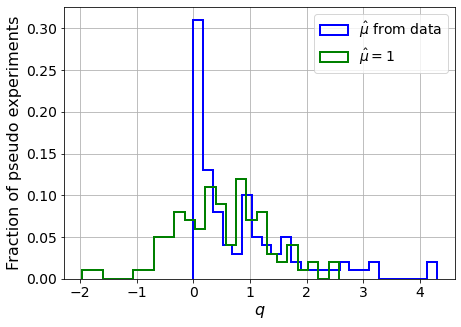

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  9027.39121191  8811.80687889  8540.77358046
  8210.32097799  7809.34260957  7315.64652438  6728.01007669
  6022.71007358  5181.45846645  4197.70200145  3032.31651204
  1659.32818257    76.04347188 -1663.55703024 -3818.95187088]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 10778.32334966 10716.24275863 10574.85612552 10344.18247545


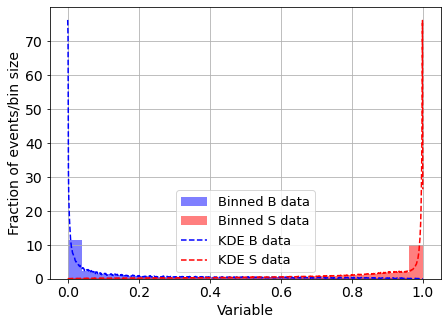

KDE Kernel:  epanechnikov
Background bandwidth:  0.0011635618505359071
Signal bandwidth:  0.0007122485584859914
This may take a while...
1 done
2 done
3 done
4 done


  0%|                                                                   | 3/2000 [00:00<04:42,  7.07it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20708091675588747
<p_{s}(Sdata)> = 17.237882862228343
<p_{b}(Bdata)> = 16.337437756091468
<p_{s}(Bdata)> = 0.2670937966686894
muhat = 2.1
<p_{b}(Sdata)> = 0.4138863288325398
<p_{s}(Sdata)> = 20.543408061958974
<p_{b}(Bdata)> = 16.454679930375413
<p_{s}(Bdata)> = 0.26435939316127155


  0%|▏                                                                  | 7/2000 [00:01<05:30,  6.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.05886771551209326
<p_{s}(Sdata)> = 51.02721603464787
<p_{b}(Bdata)> = 16.57675404483868
<p_{s}(Bdata)> = 0.26231537233657043


  0%|▎                                                                  | 9/2000 [00:01<05:05,  6.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17742458099283218
<p_{s}(Sdata)> = 10.872941815662221
<p_{b}(Bdata)> = 16.526185777485324
<p_{s}(Bdata)> = 0.2531127377526033


  1%|▎                                                                 | 11/2000 [00:01<06:41,  4.95it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1542206368602246
<p_{s}(Sdata)> = 21.81684850379857
<p_{b}(Bdata)> = 16.433315051557813
<p_{s}(Bdata)> = 0.2589377302598135


  1%|▌                                                                 | 16/2000 [00:02<05:40,  5.82it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24123195076618048
<p_{s}(Sdata)> = 14.076627703172097
<p_{b}(Bdata)> = 16.451622722963034
<p_{s}(Bdata)> = 0.2706276117160755
muhat = 2.1
<p_{b}(Sdata)> = 0.22183033077286216
<p_{s}(Sdata)> = 28.12997711081005
<p_{b}(Bdata)> = 16.698092511302814
<p_{s}(Bdata)> = 0.2616605428126628


  1%|▋                                                                 | 21/2000 [00:03<04:23,  7.51it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15569154211588443
<p_{s}(Sdata)> = 15.748044635892633
<p_{b}(Bdata)> = 16.78458762473609
<p_{s}(Bdata)> = 0.27221013200786104
muhat = -0.1
<p_{b}(Sdata)> = 0.19265141121288323
<p_{s}(Sdata)> = 10.229906346936044
<p_{b}(Bdata)> = 16.63920474224389
<p_{s}(Bdata)> = 0.25928118822342155


  1%|▊                                                                 | 23/2000 [00:04<06:00,  5.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22343735854197147
<p_{s}(Sdata)> = 14.60773616265134
<p_{b}(Bdata)> = 16.666560913481213
<p_{s}(Bdata)> = 0.2565265861831356


  2%|▉                                                                 | 30/2000 [00:05<05:48,  5.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32492685606134314
<p_{s}(Sdata)> = 6.779818233012562
<p_{b}(Bdata)> = 16.532476924047614
<p_{s}(Bdata)> = 0.260427294693617
muhat = 2.1
<p_{b}(Sdata)> = 0.11882102249257978
<p_{s}(Sdata)> = 27.59938972327831
<p_{b}(Bdata)> = 16.570935119144213
<p_{s}(Bdata)> = 0.26066616054094915


  2%|█                                                                 | 32/2000 [00:06<08:25,  3.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1934750270475247
<p_{s}(Sdata)> = 9.192420004039677
<p_{b}(Bdata)> = 16.555464309371732
<p_{s}(Bdata)> = 0.25206203869802024


  2%|█▎                                                                | 39/2000 [00:07<05:12,  6.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2705926870132661
<p_{s}(Sdata)> = 3.497819707720823
<p_{b}(Bdata)> = 16.543706503224083
<p_{s}(Bdata)> = 0.25526645868794995
muhat = -0.1
<p_{b}(Sdata)> = 0.07634634893558376
<p_{s}(Sdata)> = 4.673062423505744
<p_{b}(Bdata)> = 16.784774383085477
<p_{s}(Bdata)> = 0.2552725583112711


  3%|██                                                                | 63/2000 [00:13<05:24,  5.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2832343873031096
<p_{s}(Sdata)> = 1.8754945396863896
<p_{b}(Bdata)> = 16.906434207267676
<p_{s}(Bdata)> = 0.25930192116320194
muhat = -0.1
<p_{b}(Sdata)> = 0.15142628171576475
<p_{s}(Sdata)> = 7.5666887452525815
<p_{b}(Bdata)> = 16.817810263491022
<p_{s}(Bdata)> = 0.2533934328909693


  3%|██▏                                                               | 68/2000 [00:14<06:05,  5.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23142560606369117
<p_{s}(Sdata)> = 6.920240153039615
<p_{b}(Bdata)> = 16.776134955615902
<p_{s}(Bdata)> = 0.2529690103033645
muhat = -0.1
<p_{b}(Sdata)> = 0.2393319666641652
<p_{s}(Sdata)> = 7.165206932614809
<p_{b}(Bdata)> = 16.651772188763584
<p_{s}(Bdata)> = 0.26073358808520464


  4%|██▎                                                               | 70/2000 [00:15<06:50,  4.70it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1872592985512388
<p_{s}(Sdata)> = 16.744991975034736
<p_{b}(Bdata)> = 16.535570580227926
<p_{s}(Bdata)> = 0.26819286801448705


  4%|██▍                                                               | 74/2000 [00:15<07:30,  4.27it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15467328536701563
<p_{s}(Sdata)> = 25.662136182659676
<p_{b}(Bdata)> = 16.6784721432375
<p_{s}(Bdata)> = 0.2701209049747746


  4%|██▋                                                               | 80/2000 [00:16<05:32,  5.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2197100585235271
<p_{s}(Sdata)> = 7.190184155941196
<p_{b}(Bdata)> = 16.624748612246304
<p_{s}(Bdata)> = 0.2522053574890458


  4%|██▋                                                               | 81/2000 [00:17<06:48,  4.70it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16499871124567322
<p_{s}(Sdata)> = 22.75957284356163
<p_{b}(Bdata)> = 16.645209607543247
<p_{s}(Bdata)> = 0.2586433061377483


  5%|███                                                               | 93/2000 [00:19<05:43,  5.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25342990001352594
<p_{s}(Sdata)> = 8.692773732509325
<p_{b}(Bdata)> = 16.845051163604325
<p_{s}(Bdata)> = 0.2486563564698277


  5%|███▏                                                              | 98/2000 [00:20<05:11,  6.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.152632723784747
<p_{s}(Sdata)> = 22.77157395399273
<p_{b}(Bdata)> = 16.763485994716163
<p_{s}(Bdata)> = 0.26288111668668496
muhat = -0.1
<p_{b}(Sdata)> = 0.15422702442086686
<p_{s}(Sdata)> = 13.289097746544941
<p_{b}(Bdata)> = 16.497895543071323
<p_{s}(Bdata)> = 0.25838738394414834


  5%|███▌                                                             | 108/2000 [00:23<06:06,  5.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2727691618820984
<p_{s}(Sdata)> = 1.813160614150829
<p_{b}(Bdata)> = 16.774644587809856
<p_{s}(Bdata)> = 0.26217378405049246


  6%|███▊                                                             | 116/2000 [00:24<05:43,  5.49it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.10785502261095135
<p_{s}(Sdata)> = 18.983220751961536
<p_{b}(Bdata)> = 16.457344112690315
<p_{s}(Bdata)> = 0.2688270685078678
muhat = -0.1
<p_{b}(Sdata)> = 0.22808604311206965
<p_{s}(Sdata)> = 10.926404417925378
<p_{b}(Bdata)> = 16.561766403913403
<p_{s}(Bdata)> = 0.2537163037665457


  6%|███▊                                                             | 119/2000 [00:25<04:09,  7.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27251431347556837
<p_{s}(Sdata)> = 9.62552444737489
<p_{b}(Bdata)> = 16.746219522751748
<p_{s}(Bdata)> = 0.2503263263854411
muhat = -0.1
<p_{b}(Sdata)> = 0.230615330297103
<p_{s}(Sdata)> = 4.264028508827431
<p_{b}(Bdata)> = 16.587182537590106
<p_{s}(Bdata)> = 0.2578740179982381


  6%|███▉                                                             | 120/2000 [00:25<05:37,  5.57it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1352248125344175
<p_{s}(Sdata)> = 22.904210605737862
<p_{b}(Bdata)> = 16.318073511533694
<p_{s}(Bdata)> = 0.27030884173825426


  7%|████▎                                                            | 132/2000 [00:28<06:19,  4.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2387772119002032
<p_{s}(Sdata)> = 3.6992414302883123
<p_{b}(Bdata)> = 16.65497533116972
<p_{s}(Bdata)> = 0.256990331516987


  7%|████▍                                                            | 136/2000 [00:29<06:08,  5.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25932406189303825
<p_{s}(Sdata)> = 6.181761833643165
<p_{b}(Bdata)> = 16.68886130130536
<p_{s}(Bdata)> = 0.2513425873639014


  7%|████▋                                                            | 143/2000 [00:30<04:48,  6.44it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16117620183815115
<p_{s}(Sdata)> = 18.73671267906111
<p_{b}(Bdata)> = 16.731379636428688
<p_{s}(Bdata)> = 0.2648715628618228
muhat = -0.1
<p_{b}(Sdata)> = 0.8673052371162617
<p_{s}(Sdata)> = 7.015250215680162
<p_{b}(Bdata)> = 16.431527136897536
<p_{s}(Bdata)> = 0.25938027595037244


  7%|████▋                                                            | 146/2000 [00:31<04:37,  6.69it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21633660816638767
<p_{s}(Sdata)> = 18.930654429970605
<p_{b}(Bdata)> = 16.525459784336647
<p_{s}(Bdata)> = 0.2706945505970227


  7%|████▊                                                            | 149/2000 [00:31<04:51,  6.34it/s]

muhat = 2.1
<p_{b}(Sdata)> = 1.1864544880078838
<p_{s}(Sdata)> = 21.797030090414022
<p_{b}(Bdata)> = 16.38756268536422
<p_{s}(Bdata)> = 0.2622445345886897
muhat = 2.1
<p_{b}(Sdata)> = 0.24707445123955227
<p_{s}(Sdata)> = 21.909494902442272
<p_{b}(Bdata)> = 16.598808783738384
<p_{s}(Bdata)> = 0.2602178267197739


  8%|█████                                                            | 156/2000 [00:33<07:01,  4.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19851498627310593
<p_{s}(Sdata)> = 8.011627625684982
<p_{b}(Bdata)> = 16.737233987008416
<p_{s}(Bdata)> = 0.25324297234049403


  8%|█████▌                                                           | 170/2000 [00:37<09:07,  3.34it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.12864040077031808
<p_{s}(Sdata)> = 23.038299362059412
<p_{b}(Bdata)> = 16.88068852343028
<p_{s}(Bdata)> = 0.2605537863131132


  9%|█████▉                                                           | 181/2000 [00:39<06:56,  4.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3075618509036648
<p_{s}(Sdata)> = 3.885368931473878
<p_{b}(Bdata)> = 16.512081146008473
<p_{s}(Bdata)> = 0.2534762866924369


  9%|█████▉                                                           | 184/2000 [00:40<08:57,  3.38it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1515536176182056
<p_{s}(Sdata)> = 23.5659834447331
<p_{b}(Bdata)> = 16.62909553475344
<p_{s}(Bdata)> = 0.25756773317575343


 10%|██████▏                                                          | 191/2000 [00:42<05:38,  5.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20748680185815058
<p_{s}(Sdata)> = 3.2847270945269016
<p_{b}(Bdata)> = 16.873403771068066
<p_{s}(Bdata)> = 0.25707214019378516


 10%|██████▎                                                          | 195/2000 [00:42<05:04,  5.94it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2830811970679227
<p_{s}(Sdata)> = 16.995714527539764
<p_{b}(Bdata)> = 16.332193826832
<p_{s}(Bdata)> = 0.27184877628242965
muhat = 2.1
<p_{b}(Sdata)> = 0.17910878930321966
<p_{s}(Sdata)> = 24.020026177642546
<p_{b}(Bdata)> = 16.625379163115394
<p_{s}(Bdata)> = 0.25925847864938717


 10%|██████▍                                                          | 198/2000 [00:43<04:08,  7.26it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.075025275920315
<p_{s}(Sdata)> = 46.79824186458158
<p_{b}(Bdata)> = 16.725197542647575
<p_{s}(Bdata)> = 0.2580550345943885
muhat = 2.1
<p_{b}(Sdata)> = 0.11629209659733235
<p_{s}(Sdata)> = 20.44977311348403
<p_{b}(Bdata)> = 16.51122430004746
<p_{s}(Bdata)> = 0.25713380563674837
muhat = 2.1
<p_{b}(Sdata)> = 0.14304795014661115
<p_{s}(Sdata)> = 13.966128222994652
<p_{b}(Bdata)> = 16.325323164058
<p_{s}(Bdata)> = 0.2685036158090412


 10%|██████▌                                                          | 203/2000 [00:43<04:22,  6.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18516460089639117
<p_{s}(Sdata)> = 11.902686615342303
<p_{b}(Bdata)> = 16.738152921136344
<p_{s}(Bdata)> = 0.25104134767342684


 11%|██████▉                                                          | 214/2000 [00:46<06:03,  4.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18543382305193085
<p_{s}(Sdata)> = 9.8738309265295
<p_{b}(Bdata)> = 16.25183813654176
<p_{s}(Bdata)> = 0.25522312008074693


 11%|███████                                                          | 218/2000 [00:47<04:12,  7.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7357805899554686
<p_{s}(Sdata)> = 0.797188882115854
<p_{b}(Bdata)> = 16.429063025192043
<p_{s}(Bdata)> = 0.26036047403841855
muhat = -0.1
<p_{b}(Sdata)> = 0.17152444858710306
<p_{s}(Sdata)> = 3.379298922069466
<p_{b}(Bdata)> = 16.41769964612441
<p_{s}(Bdata)> = 0.25544265699044977
muhat = -0.1
<p_{b}(Sdata)> = 0.20995571627272766
<p_{s}(Sdata)> = 9.534078019031638
<p_{b}(Bdata)> = 16.529774021980852
<p_{s}(Bdata)> = 0.25137581386961333


 11%|███████▏                                                         | 221/2000 [00:48<06:51,  4.32it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4257639607271933
<p_{s}(Sdata)> = 10.527794791327544
<p_{b}(Bdata)> = 16.57401574318386
<p_{s}(Bdata)> = 0.27737144566914945


 12%|███████▌                                                         | 233/2000 [00:51<06:52,  4.28it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1419888026236624
<p_{s}(Sdata)> = 21.631461371078224
<p_{b}(Bdata)> = 16.29382776177734
<p_{s}(Bdata)> = 0.26744475638696485


 12%|███████▋                                                         | 237/2000 [00:52<07:23,  3.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3595856427889182
<p_{s}(Sdata)> = 5.0891954783785325
<p_{b}(Bdata)> = 16.65572371267
<p_{s}(Bdata)> = 0.25425420349029876


 12%|███████▊                                                         | 242/2000 [00:53<05:54,  4.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2087497203941157
<p_{s}(Sdata)> = 8.69629157247645
<p_{b}(Bdata)> = 16.53124632224777
<p_{s}(Bdata)> = 0.26124913666169786


 12%|███████▉                                                         | 245/2000 [00:54<05:17,  5.53it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2577460034117479
<p_{s}(Sdata)> = 11.887414393168031
<p_{b}(Bdata)> = 16.776426199832954
<p_{s}(Bdata)> = 0.26486641849706105


 13%|████████▌                                                        | 262/2000 [00:58<07:23,  3.92it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19783928705005566
<p_{s}(Sdata)> = 20.780782794225285
<p_{b}(Bdata)> = 16.36534607407404
<p_{s}(Bdata)> = 0.26494053751834973


 14%|█████████                                                        | 277/2000 [01:02<06:46,  4.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17490202335164473
<p_{s}(Sdata)> = 11.10783408521655
<p_{b}(Bdata)> = 16.379270811521597
<p_{s}(Bdata)> = 0.25552969316070606


 14%|█████████                                                        | 280/2000 [01:02<05:28,  5.23it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14119224424031843
<p_{s}(Sdata)> = 22.104015651292194
<p_{b}(Bdata)> = 16.465814622504546
<p_{s}(Bdata)> = 0.26272129594228577
muhat = 2.1
<p_{b}(Sdata)> = 0.18753106150964546
<p_{s}(Sdata)> = 24.41595768251432
<p_{b}(Bdata)> = 16.805772720983043
<p_{s}(Bdata)> = 0.2669084263163041


 15%|█████████▍                                                       | 292/2000 [01:05<04:45,  5.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1913180395226324
<p_{s}(Sdata)> = 12.538386731439488
<p_{b}(Bdata)> = 16.6239391626668
<p_{s}(Bdata)> = 0.25409106825698524
muhat = 2.1
<p_{b}(Sdata)> = 0.13302081055761084
<p_{s}(Sdata)> = 13.081490462386702
<p_{b}(Bdata)> = 16.672003363560457
<p_{s}(Bdata)> = 0.2677267203626623


 15%|█████████▌                                                       | 293/2000 [01:05<06:37,  4.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21566735547348853
<p_{s}(Sdata)> = 6.054746437168694
<p_{b}(Bdata)> = 16.339214904354627
<p_{s}(Bdata)> = 0.2588374986427438


 15%|█████████▋                                                       | 299/2000 [01:06<04:58,  5.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.337906820963722
<p_{s}(Sdata)> = 6.427496808142109
<p_{b}(Bdata)> = 16.654067312713895
<p_{s}(Bdata)> = 0.25937296257492154
muhat = 2.1
<p_{b}(Sdata)> = 0.18953054296512756
<p_{s}(Sdata)> = 18.497906233364468
<p_{b}(Bdata)> = 16.872345604344705
<p_{s}(Bdata)> = 0.2589387145121096


 15%|█████████▊                                                       | 303/2000 [01:07<04:27,  6.35it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.09258667653615339
<p_{s}(Sdata)> = 22.417546221888255
<p_{b}(Bdata)> = 16.352173481127963
<p_{s}(Bdata)> = 0.26879017301941854
muhat = -0.1
<p_{b}(Sdata)> = 0.4355459500866439
<p_{s}(Sdata)> = 3.2116490915156137
<p_{b}(Bdata)> = 16.409873140772802
<p_{s}(Bdata)> = 0.2587502384429426


 15%|█████████▉                                                       | 304/2000 [01:07<04:48,  5.88it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.10548185915371008
<p_{s}(Sdata)> = 22.17176216526665
<p_{b}(Bdata)> = 16.784304904015432
<p_{s}(Bdata)> = 0.26080775685359203


 15%|█████████▉                                                       | 306/2000 [01:08<04:56,  5.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1795776862628493
<p_{s}(Sdata)> = 11.772300371949882
<p_{b}(Bdata)> = 16.81068515011396
<p_{s}(Bdata)> = 0.2518603082637944


 15%|██████████                                                       | 309/2000 [01:08<04:48,  5.86it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2633652015951854
<p_{s}(Sdata)> = 9.753684079496011
<p_{b}(Bdata)> = 16.630511053503547
<p_{s}(Bdata)> = 0.26607278717581917


 16%|██████████▍                                                      | 320/2000 [01:10<05:59,  4.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18450446847292676
<p_{s}(Sdata)> = 7.396725905978891
<p_{b}(Bdata)> = 16.95945882022387
<p_{s}(Bdata)> = 0.25061217220291143


 17%|██████████▊                                                      | 331/2000 [01:13<04:43,  5.88it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.7084217144189138
<p_{s}(Sdata)> = 17.164450782972633
<p_{b}(Bdata)> = 16.530079639310614
<p_{s}(Bdata)> = 0.2730872371987918
muhat = -0.1
<p_{b}(Sdata)> = 0.37910244524865566
<p_{s}(Sdata)> = 5.527477404150144
<p_{b}(Bdata)> = 16.502940386778832
<p_{s}(Bdata)> = 0.26073890310139186


 17%|██████████▉                                                      | 338/2000 [01:15<09:56,  2.79it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17052228783650236
<p_{s}(Sdata)> = 21.598297370952963
<p_{b}(Bdata)> = 16.612197523478304
<p_{s}(Bdata)> = 0.2624729170043406


 17%|███████████▏                                                     | 344/2000 [01:17<07:09,  3.85it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1572562004928214
<p_{s}(Sdata)> = 23.015343950566965
<p_{b}(Bdata)> = 17.023105410697227
<p_{s}(Bdata)> = 0.2596582280630618


 18%|███████████▌                                                     | 355/2000 [01:19<04:42,  5.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23935705018587233
<p_{s}(Sdata)> = 1.8380098737093842
<p_{b}(Bdata)> = 16.66415913278219
<p_{s}(Bdata)> = 0.2530703120134241
muhat = 2.1
<p_{b}(Sdata)> = 0.17825262856576363
<p_{s}(Sdata)> = 19.65775725193812
<p_{b}(Bdata)> = 16.822759795232866
<p_{s}(Bdata)> = 0.2623896580151497


 18%|███████████▋                                                     | 360/2000 [01:20<05:31,  4.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4106736044067398
<p_{s}(Sdata)> = 2.1091319006056093
<p_{b}(Bdata)> = 16.591211847003912
<p_{s}(Bdata)> = 0.25889819970103223


 18%|███████████▊                                                     | 362/2000 [01:20<05:06,  5.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2397137250004275
<p_{s}(Sdata)> = 2.1904067519671346
<p_{b}(Bdata)> = 16.610062902097976
<p_{s}(Bdata)> = 0.2605857854244708


 18%|███████████▉                                                     | 366/2000 [01:21<03:47,  7.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17543544450579335
<p_{s}(Sdata)> = 9.259393026368226
<p_{b}(Bdata)> = 16.626080295061612
<p_{s}(Bdata)> = 0.25858143603018263


 18%|███████████▉                                                     | 367/2000 [01:21<04:34,  5.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24552294615194087
<p_{s}(Sdata)> = 10.724569902323427
<p_{b}(Bdata)> = 16.73944799259983
<p_{s}(Bdata)> = 0.2554390910096793


 19%|████████████▍                                                    | 384/2000 [01:25<06:18,  4.27it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18937648849125588
<p_{s}(Sdata)> = 18.24138022437555
<p_{b}(Bdata)> = 16.685548316167882
<p_{s}(Bdata)> = 0.2688800312743389


 19%|████████████▌                                                    | 385/2000 [01:26<07:45,  3.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24651993127841326
<p_{s}(Sdata)> = 8.538653113898409
<p_{b}(Bdata)> = 16.344210985903977
<p_{s}(Bdata)> = 0.25454411973567


 20%|████████████▋                                                    | 390/2000 [01:27<08:49,  3.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24923762205985078
<p_{s}(Sdata)> = 12.280797645973891
<p_{b}(Bdata)> = 16.801421731976525
<p_{s}(Bdata)> = 0.25218669226567697


 20%|████████████▊                                                    | 395/2000 [01:29<06:55,  3.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5319037231959427
<p_{s}(Sdata)> = 1.1109191950279445
<p_{b}(Bdata)> = 16.47629586880252
<p_{s}(Bdata)> = 0.2618587410818514


 20%|████████████▉                                                    | 398/2000 [01:29<06:28,  4.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23841228301857814
<p_{s}(Sdata)> = 10.063292973121102
<p_{b}(Bdata)> = 16.359968116918754
<p_{s}(Bdata)> = 0.2546244651446401


 20%|█████████████                                                    | 403/2000 [01:30<04:12,  6.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25539742337689053
<p_{s}(Sdata)> = 5.806888630882795
<p_{b}(Bdata)> = 16.691186503460738
<p_{s}(Bdata)> = 0.25667271374278006
muhat = -0.1
<p_{b}(Sdata)> = 0.17865121365259523
<p_{s}(Sdata)> = 12.404381125884434
<p_{b}(Bdata)> = 16.515688263187908
<p_{s}(Bdata)> = 0.25690039484244653


 20%|█████████████▏                                                   | 407/2000 [01:31<04:27,  5.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18460308752219276
<p_{s}(Sdata)> = 6.378399200571592
<p_{b}(Bdata)> = 16.505113963285574
<p_{s}(Bdata)> = 0.2544812559973034
muhat = -0.1
<p_{b}(Sdata)> = 0.19924341250046676
<p_{s}(Sdata)> = 13.24655768793038
<p_{b}(Bdata)> = 16.52833717892668
<p_{s}(Bdata)> = 0.2511187664768366


 21%|█████████████▍                                                   | 413/2000 [01:32<05:04,  5.21it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15949191163394172
<p_{s}(Sdata)> = 26.429792991589327
<p_{b}(Bdata)> = 16.402212060219046
<p_{s}(Bdata)> = 0.262493062272394


 21%|█████████████▊                                                   | 426/2000 [01:35<04:29,  5.85it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5025703180356796
<p_{s}(Sdata)> = 28.837237405908223
<p_{b}(Bdata)> = 16.42088912357764
<p_{s}(Bdata)> = 0.2593761660042627
muhat = -0.1
<p_{b}(Sdata)> = 0.2823238856990094
<p_{s}(Sdata)> = 1.2827156812128881
<p_{b}(Bdata)> = 16.566457512124625
<p_{s}(Bdata)> = 0.25649574270793485


 21%|█████████████▉                                                   | 429/2000 [01:35<04:17,  6.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.09109631017414337
<p_{s}(Sdata)> = 31.709120439820737
<p_{b}(Bdata)> = 16.965403012553892
<p_{s}(Bdata)> = 0.26612567118910035


 22%|██████████████▏                                                  | 436/2000 [01:37<03:36,  7.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31880102077967354
<p_{s}(Sdata)> = 5.269846692522256
<p_{b}(Bdata)> = 16.65456064722837
<p_{s}(Bdata)> = 0.25337853858041504
muhat = -0.1
<p_{b}(Sdata)> = 0.23271966346575373
<p_{s}(Sdata)> = 2.7298914469404876
<p_{b}(Bdata)> = 16.73232714527894
<p_{s}(Bdata)> = 0.2601034785650062
muhat = -0.1
<p_{b}(Sdata)> = 0.21887549818045623
<p_{s}(Sdata)> = 4.272677258324953
<p_{b}(Bdata)> = 16.351513883288348
<p_{s}(Bdata)> = 0.2590057035929117


 22%|██████████████▎                                                  | 441/2000 [01:37<03:32,  7.33it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2807673828730548
<p_{s}(Sdata)> = 20.43947654395472
<p_{b}(Bdata)> = 16.66632798950273
<p_{s}(Bdata)> = 0.2622920740903142
muhat = -0.1
<p_{b}(Sdata)> = 0.1984098880356273
<p_{s}(Sdata)> = 15.062332439539436
<p_{b}(Bdata)> = 16.724496819241
<p_{s}(Bdata)> = 0.2534479355040018
muhat = -0.1
<p_{b}(Sdata)> = 0.3450356008255687
<p_{s}(Sdata)> = 5.282463960385018
<p_{b}(Bdata)> = 16.661844965342258
<p_{s}(Bdata)> = 0.2543500652510874


 22%|██████████████▍                                                  | 443/2000 [01:37<02:52,  9.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.519386442209961
<p_{s}(Sdata)> = 5.546521473570303
<p_{b}(Bdata)> = 16.727372039569282
<p_{s}(Bdata)> = 0.25375868410557106
muhat = 2.1
<p_{b}(Sdata)> = 0.11567585011428633
<p_{s}(Sdata)> = 30.116365299913713
<p_{b}(Bdata)> = 16.51518618228858
<p_{s}(Bdata)> = 0.26269987896177965


 22%|██████████████▍                                                  | 445/2000 [01:38<02:51,  9.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26984167151231203
<p_{s}(Sdata)> = 2.650031782795979
<p_{b}(Bdata)> = 16.454704638474485
<p_{s}(Bdata)> = 0.2574778958392556


 22%|██████████████▋                                                  | 450/2000 [01:39<03:59,  6.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2697905781891632
<p_{s}(Sdata)> = 6.995924885684722
<p_{b}(Bdata)> = 16.555071015299333
<p_{s}(Bdata)> = 0.25374042243244715


 23%|███████████████▏                                                 | 466/2000 [01:44<08:04,  3.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20537437419112908
<p_{s}(Sdata)> = 4.580351837176054
<p_{b}(Bdata)> = 16.388436608147845
<p_{s}(Bdata)> = 0.25880786750427526


 24%|███████████████▍                                                 | 474/2000 [01:45<04:47,  5.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26712424550204794
<p_{s}(Sdata)> = 7.936412242303965
<p_{b}(Bdata)> = 16.631852964086786
<p_{s}(Bdata)> = 0.2526868111352538
muhat = -0.1
<p_{b}(Sdata)> = 0.23752170435417438
<p_{s}(Sdata)> = 7.8030675420392
<p_{b}(Bdata)> = 16.968157476169473
<p_{s}(Bdata)> = 0.2532082012072436


 25%|███████████████▉                                                 | 491/2000 [01:50<04:27,  5.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19677275707115632
<p_{s}(Sdata)> = 3.504217633277758
<p_{b}(Bdata)> = 16.54305035744513
<p_{s}(Bdata)> = 0.25779400401232283


 25%|████████████████                                                 | 494/2000 [01:51<06:19,  3.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1823507742615246
<p_{s}(Sdata)> = 5.487145336474071
<p_{b}(Bdata)> = 16.640954272520414
<p_{s}(Bdata)> = 0.25899141264366743


 25%|████████████████▎                                                | 500/2000 [01:52<05:22,  4.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24056913773899108
<p_{s}(Sdata)> = 4.678254599806321
<p_{b}(Bdata)> = 16.432454892842628
<p_{s}(Bdata)> = 0.2557074843841331


 25%|████████████████▍                                                | 506/2000 [01:54<04:54,  5.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37357853528044466
<p_{s}(Sdata)> = 1.3420916271248158
<p_{b}(Bdata)> = 16.381952898183286
<p_{s}(Bdata)> = 0.2602891347618118


 25%|████████████████▌                                                | 508/2000 [01:54<06:12,  4.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3547017549390056
<p_{s}(Sdata)> = 10.710372965370283
<p_{b}(Bdata)> = 16.846917154429633
<p_{s}(Bdata)> = 0.256038849125107


 26%|████████████████▊                                                | 516/2000 [01:57<06:07,  4.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.262510963127348
<p_{s}(Sdata)> = 13.50092986264352
<p_{b}(Bdata)> = 16.37829558083576
<p_{s}(Bdata)> = 0.26855599096587257


 26%|████████████████▉                                                | 521/2000 [01:57<04:13,  5.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3024747234837735
<p_{s}(Sdata)> = 1.2420073079825733
<p_{b}(Bdata)> = 16.626467119831485
<p_{s}(Bdata)> = 0.26048034212900906


 27%|█████████████████▎                                               | 533/2000 [02:00<06:10,  3.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32288182108617464
<p_{s}(Sdata)> = 6.541983438714058
<p_{b}(Bdata)> = 16.909818994309845
<p_{s}(Bdata)> = 0.2565697601656599


 27%|█████████████████▊                                               | 549/2000 [02:05<08:14,  2.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5589766782294338
<p_{s}(Sdata)> = 11.207891351054013
<p_{b}(Bdata)> = 16.86381693271587
<p_{s}(Bdata)> = 0.258419754131316


 28%|█████████████████▉                                               | 552/2000 [02:05<06:32,  3.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25134757980958666
<p_{s}(Sdata)> = 9.228989932604124
<p_{b}(Bdata)> = 16.809349279224485
<p_{s}(Bdata)> = 0.2592699377421859


 28%|██████████████████▏                                              | 558/2000 [02:06<04:21,  5.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4641323865813294
<p_{s}(Sdata)> = 5.998214467940816
<p_{b}(Bdata)> = 16.327058860594953
<p_{s}(Bdata)> = 0.2549432789184957
muhat = 2.1
<p_{b}(Sdata)> = 0.19216488894912975
<p_{s}(Sdata)> = 15.864111328816682
<p_{b}(Bdata)> = 16.49905851172584
<p_{s}(Bdata)> = 0.2698198901084869


 28%|██████████████████▎                                              | 563/2000 [02:07<03:15,  7.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25123577804595676
<p_{s}(Sdata)> = 6.052310942069718
<p_{b}(Bdata)> = 16.692633967330707
<p_{s}(Bdata)> = 0.2581224965934113
muhat = -0.1
<p_{b}(Sdata)> = 0.14851584523417943
<p_{s}(Sdata)> = 15.125042805460925
<p_{b}(Bdata)> = 16.82393772356472
<p_{s}(Bdata)> = 0.24640119867525562


 29%|██████████████████▌                                              | 571/2000 [02:09<04:55,  4.83it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16901977341571953
<p_{s}(Sdata)> = 21.950400053681452
<p_{b}(Bdata)> = 16.864121588345487
<p_{s}(Bdata)> = 0.26652008922555687


 29%|██████████████████▌                                              | 572/2000 [02:10<05:37,  4.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40296846359898897
<p_{s}(Sdata)> = 8.714882380124143
<p_{b}(Bdata)> = 16.67423459121062
<p_{s}(Bdata)> = 0.24778343014907617


 29%|██████████████████▊                                              | 578/2000 [02:11<04:12,  5.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.12896762878708753
<p_{s}(Sdata)> = 7.2322239256044805
<p_{b}(Bdata)> = 16.907881972489218
<p_{s}(Bdata)> = 0.24683002744664967
muhat = -0.1
<p_{b}(Sdata)> = 0.43283761032587337
<p_{s}(Sdata)> = 1.759129270401325
<p_{b}(Bdata)> = 16.274200451546907
<p_{s}(Bdata)> = 0.25804546209337575


 29%|███████████████████                                              | 586/2000 [02:13<04:34,  5.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2712690910091473
<p_{s}(Sdata)> = 2.8040934020952837
<p_{b}(Bdata)> = 16.608900964346294
<p_{s}(Bdata)> = 0.2621390934262328
muhat = -0.1
<p_{b}(Sdata)> = 0.29993334556914
<p_{s}(Sdata)> = 5.13560332655835
<p_{b}(Bdata)> = 16.5107111601267
<p_{s}(Bdata)> = 0.2579593870096649


 30%|███████████████████▏                                             | 591/2000 [02:14<05:09,  4.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2739299395407034
<p_{s}(Sdata)> = 5.699389149666269
<p_{b}(Bdata)> = 16.541251603436788
<p_{s}(Bdata)> = 0.25922861678879866


 30%|███████████████████▎                                             | 596/2000 [02:14<03:42,  6.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26966950877032553
<p_{s}(Sdata)> = 6.239278375473535
<p_{b}(Bdata)> = 16.34590820367718
<p_{s}(Bdata)> = 0.2588523066445086
muhat = -0.1
<p_{b}(Sdata)> = 0.11252497932111587
<p_{s}(Sdata)> = 12.005212079084965
<p_{b}(Bdata)> = 16.55930082084569
<p_{s}(Bdata)> = 0.24829793488593074


 30%|███████████████████▌                                             | 603/2000 [02:16<04:28,  5.20it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18312659967687342
<p_{s}(Sdata)> = 16.981817488808407
<p_{b}(Bdata)> = 16.819412737212296
<p_{s}(Bdata)> = 0.2664569327376007


 30%|███████████████████▋                                             | 607/2000 [02:17<04:46,  4.86it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.48971006243401677
<p_{s}(Sdata)> = 15.7530967391343
<p_{b}(Bdata)> = 16.694340138765547
<p_{s}(Bdata)> = 0.27139039129562914


 31%|████████████████████▍                                            | 627/2000 [02:22<05:40,  4.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2264693433023652
<p_{s}(Sdata)> = 18.994082833949754
<p_{b}(Bdata)> = 16.803270484860622
<p_{s}(Bdata)> = 0.262103489840264


 32%|████████████████████▋                                            | 637/2000 [02:24<05:49,  3.90it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1656910963226879
<p_{s}(Sdata)> = 19.017444121920892
<p_{b}(Bdata)> = 16.623510517089386
<p_{s}(Bdata)> = 0.25292086594026664


 32%|████████████████████▉                                            | 643/2000 [02:26<04:11,  5.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2005783742593585
<p_{s}(Sdata)> = 4.64212959690221
<p_{b}(Bdata)> = 16.566839558650273
<p_{s}(Bdata)> = 0.253692363350351
muhat = -0.1
<p_{b}(Sdata)> = 0.15688914559225325
<p_{s}(Sdata)> = 6.155983167792173
<p_{b}(Bdata)> = 16.762137096604132
<p_{s}(Bdata)> = 0.258317569373739


 33%|█████████████████████▎                                           | 655/2000 [02:29<04:22,  5.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43245497539179906
<p_{s}(Sdata)> = 1.2532272347567532
<p_{b}(Bdata)> = 16.38306004072002
<p_{s}(Bdata)> = 0.2612094413109383


 33%|█████████████████████▎                                           | 657/2000 [02:29<03:42,  6.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3705761223701567
<p_{s}(Sdata)> = 10.331333094000277
<p_{b}(Bdata)> = 16.581923222196433
<p_{s}(Bdata)> = 0.2567847455985264


 33%|█████████████████████▌                                           | 662/2000 [02:30<05:01,  4.44it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17932865599691558
<p_{s}(Sdata)> = 20.284346383602593
<p_{b}(Bdata)> = 16.749060996973963
<p_{s}(Bdata)> = 0.26289753811512057


 33%|█████████████████████▋                                           | 669/2000 [02:31<03:00,  7.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19996710640464016
<p_{s}(Sdata)> = 8.198225660331175
<p_{b}(Bdata)> = 16.43313386321962
<p_{s}(Bdata)> = 0.255952884007171
muhat = -0.1
<p_{b}(Sdata)> = 0.30883419595148304
<p_{s}(Sdata)> = 4.278547237221329
<p_{b}(Bdata)> = 16.86382577329542
<p_{s}(Bdata)> = 0.25185150013557295


 34%|█████████████████████▊                                           | 670/2000 [02:32<04:55,  4.49it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1708283047714302
<p_{s}(Sdata)> = 15.565583667273142
<p_{b}(Bdata)> = 16.061061272992113
<p_{s}(Bdata)> = 0.2664583888778929


 34%|█████████████████████▉                                           | 676/2000 [02:33<05:49,  3.78it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21015118822556297
<p_{s}(Sdata)> = 15.725690962142693
<p_{b}(Bdata)> = 16.439632146257388
<p_{s}(Bdata)> = 0.26459902081420755


 34%|██████████████████████                                           | 680/2000 [02:34<05:03,  4.34it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17485574583352245
<p_{s}(Sdata)> = 21.135425073192554
<p_{b}(Bdata)> = 16.467256738876127
<p_{s}(Bdata)> = 0.2621441371893316


 35%|██████████████████████▌                                          | 693/2000 [02:37<03:27,  6.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27120120075231735
<p_{s}(Sdata)> = 1.6942198981332797
<p_{b}(Bdata)> = 16.86554127567046
<p_{s}(Bdata)> = 0.2493042332149778
muhat = 2.1
<p_{b}(Sdata)> = 0.29672607992328764
<p_{s}(Sdata)> = 14.162785136664137
<p_{b}(Bdata)> = 16.610218519635364
<p_{s}(Bdata)> = 0.26476476298558543


 35%|██████████████████████▌                                          | 696/2000 [02:38<04:45,  4.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1905284981912438
<p_{s}(Sdata)> = 13.85709231067942
<p_{b}(Bdata)> = 16.68717729624741
<p_{s}(Bdata)> = 0.2513754257691424


 35%|██████████████████████▉                                          | 704/2000 [02:39<04:21,  4.95it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20229309523765363
<p_{s}(Sdata)> = 10.695005079831873
<p_{b}(Bdata)> = 16.493867010564394
<p_{s}(Bdata)> = 0.2675613454856724


 35%|██████████████████████▉                                          | 706/2000 [02:40<04:06,  5.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24459618163179445
<p_{s}(Sdata)> = 4.22386837376262
<p_{b}(Bdata)> = 16.92109389390149
<p_{s}(Bdata)> = 0.2509483605460893


 36%|███████████████████████                                          | 711/2000 [02:40<03:34,  6.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3785800338779828
<p_{s}(Sdata)> = 6.6009499260358835
<p_{b}(Bdata)> = 16.85771655713585
<p_{s}(Bdata)> = 0.25291276051283473
muhat = -0.1
<p_{b}(Sdata)> = 0.2407985469595497
<p_{s}(Sdata)> = 8.1977495885553
<p_{b}(Bdata)> = 16.504401085346178
<p_{s}(Bdata)> = 0.2558331286904284
muhat = -0.1
<p_{b}(Sdata)> = 0.7599652473796125
<p_{s}(Sdata)> = 1.6919555874219587
<p_{b}(Bdata)> = 16.627960482557558
<p_{s}(Bdata)> = 0.2541369716956353


 36%|███████████████████████▍                                         | 723/2000 [02:43<04:58,  4.27it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24802310820697032
<p_{s}(Sdata)> = 30.122852959900253
<p_{b}(Bdata)> = 16.347869170157598
<p_{s}(Bdata)> = 0.2703957142707753


 36%|███████████████████████▋                                         | 728/2000 [02:44<05:47,  3.66it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18511631870597808
<p_{s}(Sdata)> = 29.653676948401653
<p_{b}(Bdata)> = 16.706417144191335
<p_{s}(Bdata)> = 0.2548866393910238


 37%|███████████████████████▉                                         | 736/2000 [02:47<05:52,  3.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.13065208877542792
<p_{s}(Sdata)> = 4.309652475016434
<p_{b}(Bdata)> = 16.550193627227646
<p_{s}(Bdata)> = 0.2566874781213785


 37%|████████████████████████▎                                        | 749/2000 [02:51<04:19,  4.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2552976499791331
<p_{s}(Sdata)> = 4.9119882277345495
<p_{b}(Bdata)> = 16.803610743021487
<p_{s}(Bdata)> = 0.25525426944976237
muhat = 2.1
<p_{b}(Sdata)> = 0.1406004766051166
<p_{s}(Sdata)> = 21.962167987289828
<p_{b}(Bdata)> = 16.20173292937459
<p_{s}(Bdata)> = 0.26801047156712987


 38%|████████████████████████▍                                        | 753/2000 [02:51<04:12,  4.93it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.06140657738827752
<p_{s}(Sdata)> = 27.424812474252228
<p_{b}(Bdata)> = 16.662247143726987
<p_{s}(Bdata)> = 0.2671214065937322


 38%|████████████████████████▋                                        | 758/2000 [02:52<03:08,  6.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21774992234292687
<p_{s}(Sdata)> = 6.316185185993721
<p_{b}(Bdata)> = 16.446777061382367
<p_{s}(Bdata)> = 0.2549087239571588
muhat = 2.1
<p_{b}(Sdata)> = 0.15678840122550924
<p_{s}(Sdata)> = 24.575935658052856
<p_{b}(Bdata)> = 16.661934177944786
<p_{s}(Bdata)> = 0.2610932944935972


 38%|████████████████████████▊                                        | 763/2000 [02:53<04:40,  4.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15513946448731925
<p_{s}(Sdata)> = 10.31320404728032
<p_{b}(Bdata)> = 16.46080533933435
<p_{s}(Bdata)> = 0.2553069848480616


 38%|█████████████████████████                                        | 770/2000 [02:55<04:09,  4.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32336385717853205
<p_{s}(Sdata)> = 1.220712923734181
<p_{b}(Bdata)> = 16.759506976669105
<p_{s}(Bdata)> = 0.25371725034286624
muhat = 2.1
<p_{b}(Sdata)> = 0.18338321171745925
<p_{s}(Sdata)> = 18.58693833285007
<p_{b}(Bdata)> = 16.507325919448018
<p_{s}(Bdata)> = 0.26352202525255214


 39%|█████████████████████████                                        | 773/2000 [02:55<03:16,  6.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28021821047197754
<p_{s}(Sdata)> = 7.333076588367808
<p_{b}(Bdata)> = 16.64667580555276
<p_{s}(Bdata)> = 0.25623052650447603
muhat = 2.1
<p_{b}(Sdata)> = 0.2504277578335135
<p_{s}(Sdata)> = 20.61205594460733
<p_{b}(Bdata)> = 16.715352456566592
<p_{s}(Bdata)> = 0.26418546018021344
muhat = -0.1
<p_{b}(Sdata)> = 0.21151891436604406
<p_{s}(Sdata)> = 5.110271777255502
<p_{b}(Bdata)> = 16.69621735610447
<p_{s}(Bdata)> = 0.2530362177884338


 39%|█████████████████████████▍                                       | 781/2000 [02:57<04:52,  4.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33154371764320717
<p_{s}(Sdata)> = 7.055846729045837
<p_{b}(Bdata)> = 16.496455712280113
<p_{s}(Bdata)> = 0.2511289652640412


 40%|█████████████████████████▋                                       | 792/2000 [03:00<04:28,  4.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15559627523455327
<p_{s}(Sdata)> = 13.018268154375615
<p_{b}(Bdata)> = 16.827116082798785
<p_{s}(Bdata)> = 0.25198714490894714


 40%|█████████████████████████▊                                       | 795/2000 [03:00<04:56,  4.06it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17633747618990797
<p_{s}(Sdata)> = 23.15380836476578
<p_{b}(Bdata)> = 16.597706307721097
<p_{s}(Bdata)> = 0.26175788305366093


 40%|█████████████████████████▉                                       | 798/2000 [03:01<04:08,  4.84it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16928365028287942
<p_{s}(Sdata)> = 16.58680829457822
<p_{b}(Bdata)> = 16.607276195576578
<p_{s}(Bdata)> = 0.25963990632014056
muhat = -0.1
<p_{b}(Sdata)> = 0.3580981296840545
<p_{s}(Sdata)> = 2.4292290821712017
<p_{b}(Bdata)> = 16.81458588566997
<p_{s}(Bdata)> = 0.24799167010384962


 40%|██████████████████████████                                       | 801/2000 [03:02<03:55,  5.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3413250004375342
<p_{s}(Sdata)> = 1.2228835153771132
<p_{b}(Bdata)> = 16.54116596402311
<p_{s}(Bdata)> = 0.25843000568019786


 40%|██████████████████████████▏                                      | 804/2000 [03:02<04:44,  4.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19177828573348277
<p_{s}(Sdata)> = 6.803501091987532
<p_{b}(Bdata)> = 16.4013740868877
<p_{s}(Bdata)> = 0.25726952498802286


 40%|██████████████████████████▎                                      | 809/2000 [03:03<04:54,  4.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24006723899896343
<p_{s}(Sdata)> = 13.237481653653914
<p_{b}(Bdata)> = 16.381406107243958
<p_{s}(Bdata)> = 0.2623596233110594


 41%|██████████████████████████▍                                      | 815/2000 [03:05<03:49,  5.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31845226993443043
<p_{s}(Sdata)> = 3.668326006088611
<p_{b}(Bdata)> = 16.51544287993069
<p_{s}(Bdata)> = 0.2573744992796113


 41%|██████████████████████████▊                                      | 824/2000 [03:07<05:22,  3.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.835438371652574
<p_{s}(Sdata)> = 6.328706398455212
<p_{b}(Bdata)> = 16.511851635270805
<p_{s}(Bdata)> = 0.25663837906637743


 41%|██████████████████████████▉                                      | 827/2000 [03:08<04:37,  4.23it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18973459560764916
<p_{s}(Sdata)> = 23.85626907075974
<p_{b}(Bdata)> = 16.698388698510524
<p_{s}(Bdata)> = 0.2658916786836145


 42%|███████████████████████████                                      | 831/2000 [03:08<03:41,  5.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3086967566750151
<p_{s}(Sdata)> = 7.4507918414309255
<p_{b}(Bdata)> = 16.57227124275225
<p_{s}(Bdata)> = 0.26176848442913725


 42%|███████████████████████████▏                                     | 836/2000 [03:10<04:11,  4.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15430049679686508
<p_{s}(Sdata)> = 9.87418520838502
<p_{b}(Bdata)> = 16.828246790169548
<p_{s}(Bdata)> = 0.2564201174078523
muhat = -0.1
<p_{b}(Sdata)> = 0.15832352497865235
<p_{s}(Sdata)> = 9.4589476510409
<p_{b}(Bdata)> = 16.180425058925394
<p_{s}(Bdata)> = 0.2615714208016116


 42%|███████████████████████████▋                                     | 850/2000 [03:13<04:16,  4.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.40763111948598507
<p_{s}(Sdata)> = 8.2185761317707
<p_{b}(Bdata)> = 16.321645467811557
<p_{s}(Bdata)> = 0.25527473697768693


 43%|███████████████████████████▊                                     | 855/2000 [03:14<05:27,  3.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5197357887017804
<p_{s}(Sdata)> = 5.7412800026359685
<p_{b}(Bdata)> = 16.485010992724373
<p_{s}(Bdata)> = 0.25798400303256025


 44%|████████████████████████████▎                                    | 871/2000 [03:17<04:35,  4.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16275706931039452
<p_{s}(Sdata)> = 28.89430487870533
<p_{b}(Bdata)> = 16.379305827336104
<p_{s}(Bdata)> = 0.26598449670724245


 44%|████████████████████████████▎                                    | 873/2000 [03:18<04:07,  4.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3202789939532298
<p_{s}(Sdata)> = 6.732445333520605
<p_{b}(Bdata)> = 16.78089081617302
<p_{s}(Bdata)> = 0.25609878604549957


 44%|████████████████████████████▌                                    | 880/2000 [03:19<02:34,  7.23it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2522839560716157
<p_{s}(Sdata)> = 28.597507000516117
<p_{b}(Bdata)> = 16.81873372870335
<p_{s}(Bdata)> = 0.2595459823063445
muhat = 2.1
<p_{b}(Sdata)> = 0.16537717334921018
<p_{s}(Sdata)> = 25.008984782519075
<p_{b}(Bdata)> = 16.480323502584106
<p_{s}(Bdata)> = 0.26323270890204115


 44%|████████████████████████████▊                                    | 886/2000 [03:21<04:19,  4.29it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1843504598127033
<p_{s}(Sdata)> = 25.117297890207826
<p_{b}(Bdata)> = 16.796858698021136
<p_{s}(Bdata)> = 0.27145026139586015


 44%|████████████████████████████▉                                    | 890/2000 [03:21<03:15,  5.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19412806962329024
<p_{s}(Sdata)> = 12.516266504095027
<p_{b}(Bdata)> = 16.97485394556256
<p_{s}(Bdata)> = 0.25223817581457614


 45%|█████████████████████████████                                    | 896/2000 [03:23<05:39,  3.25it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.12575625763791604
<p_{s}(Sdata)> = 18.07872165154391
<p_{b}(Bdata)> = 16.742801834738707
<p_{s}(Bdata)> = 0.26050299905804647


 45%|█████████████████████████████▏                                   | 899/2000 [03:24<04:46,  3.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2521334721753013
<p_{s}(Sdata)> = 15.881734816290981
<p_{b}(Bdata)> = 16.77146997721834
<p_{s}(Bdata)> = 0.25187945537649


 46%|█████████████████████████████▌                                   | 911/2000 [03:27<04:46,  3.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.316394895400954
<p_{s}(Sdata)> = 3.954614019324939
<p_{b}(Bdata)> = 16.46883888033651
<p_{s}(Bdata)> = 0.2565849717064834


 46%|█████████████████████████████▋                                   | 914/2000 [03:27<03:40,  4.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20474776431329422
<p_{s}(Sdata)> = 8.551598606817917
<p_{b}(Bdata)> = 16.438056360434967
<p_{s}(Bdata)> = 0.2554170879228595


 46%|█████████████████████████████▊                                   | 919/2000 [03:28<03:00,  5.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18900358672620593
<p_{s}(Sdata)> = 9.564238595773025
<p_{b}(Bdata)> = 16.817964799793188
<p_{s}(Bdata)> = 0.24975928942738254
muhat = -0.1
<p_{b}(Sdata)> = 0.4779307493460857
<p_{s}(Sdata)> = 4.343556178436424
<p_{b}(Bdata)> = 16.519207324108557
<p_{s}(Bdata)> = 0.2544714082641203
muhat = -0.1
<p_{b}(Sdata)> = 0.17535111576829646
<p_{s}(Sdata)> = 8.332516471334058
<p_{b}(Bdata)> = 16.560926262859137
<p_{s}(Bdata)> = 0.25796855941703817


 46%|██████████████████████████████                                   | 925/2000 [03:29<02:36,  6.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1771153776546791
<p_{s}(Sdata)> = 14.686906217253846
<p_{b}(Bdata)> = 16.435197859304665
<p_{s}(Bdata)> = 0.25068193917629283
muhat = -0.1
<p_{b}(Sdata)> = 0.20432979899994766
<p_{s}(Sdata)> = 9.59074003966924
<p_{b}(Bdata)> = 16.825490066706056
<p_{s}(Bdata)> = 0.257227315530178
muhat = -0.1
<p_{b}(Sdata)> = 0.3784107548388421
<p_{s}(Sdata)> = 1.6434150619588235
<p_{b}(Bdata)> = 16.38259619126433
<p_{s}(Bdata)> = 0.25508025295686765


 47%|██████████████████████████████▋                                  | 944/2000 [03:35<04:13,  4.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2348863845186996
<p_{s}(Sdata)> = 12.274889714846065
<p_{b}(Bdata)> = 16.726273603373315
<p_{s}(Bdata)> = 0.2535111917958028


 47%|██████████████████████████████▋                                  | 945/2000 [03:35<04:07,  4.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24798381171578218
<p_{s}(Sdata)> = 4.975119111585465
<p_{b}(Bdata)> = 16.8440317978117
<p_{s}(Bdata)> = 0.2535481042161039


 48%|███████████████████████████████                                  | 956/2000 [03:37<02:12,  7.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17671787290960325
<p_{s}(Sdata)> = 6.9081770569642345
<p_{b}(Bdata)> = 16.621308069833322
<p_{s}(Bdata)> = 0.26394320600165755
muhat = -0.1
<p_{b}(Sdata)> = 0.5002057385323041
<p_{s}(Sdata)> = 11.079591198995288
<p_{b}(Bdata)> = 16.798901844505504
<p_{s}(Bdata)> = 0.2574482630066839


 48%|███████████████████████████████▎                                 | 963/2000 [03:39<03:01,  5.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.051321381130813
<p_{s}(Sdata)> = 1.446824792949805
<p_{b}(Bdata)> = 16.794423981032967
<p_{s}(Bdata)> = 0.2586239420020835
muhat = -0.1
<p_{b}(Sdata)> = 0.22782964241775988
<p_{s}(Sdata)> = 7.132352818607432
<p_{b}(Bdata)> = 16.419333190902044
<p_{s}(Bdata)> = 0.2591074777340667
muhat = -0.1
<p_{b}(Sdata)> = 0.33593525889746334
<p_{s}(Sdata)> = 9.561273355906996
<p_{b}(Bdata)> = 16.66719692245158
<p_{s}(Bdata)> = 0.24844383486813515


 48%|███████████████████████████████▍                                 | 967/2000 [03:39<02:23,  7.19it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1329600829225682
<p_{s}(Sdata)> = 24.06251305888835
<p_{b}(Bdata)> = 16.315143182041705
<p_{s}(Bdata)> = 0.2639298770058977


 49%|███████████████████████████████▊                                 | 977/2000 [03:42<05:04,  3.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3892953805443945
<p_{s}(Sdata)> = 0.9547245975334088
<p_{b}(Bdata)> = 16.637407233930013
<p_{s}(Bdata)> = 0.2571799756903849


 49%|███████████████████████████████▊                                 | 979/2000 [03:43<03:59,  4.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.12850154329354924
<p_{s}(Sdata)> = 6.561558678826542
<p_{b}(Bdata)> = 16.805887939519522
<p_{s}(Bdata)> = 0.25097950532823987


 50%|████████████████████████████████▏                                | 991/2000 [03:46<04:43,  3.56it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17199381696704447
<p_{s}(Sdata)> = 20.44764725609715
<p_{b}(Bdata)> = 16.537154153253713
<p_{s}(Bdata)> = 0.26781741830866074


 50%|████████████████████████████████                                | 1000/2000 [03:48<03:13,  5.16it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2987594746579908
<p_{s}(Sdata)> = 14.98947730865137
<p_{b}(Bdata)> = 16.267566088620775
<p_{s}(Bdata)> = 0.27073352089914443
muhat = -0.1
<p_{b}(Sdata)> = 0.2136298506633044
<p_{s}(Sdata)> = 1.9506617961576278
<p_{b}(Bdata)> = 16.50077811910232
<p_{s}(Bdata)> = 0.25680873319178293


 50%|████████████████████████████████                                | 1003/2000 [03:48<03:19,  5.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24079191333249222
<p_{s}(Sdata)> = 2.45752295480161
<p_{b}(Bdata)> = 16.49859065464991
<p_{s}(Bdata)> = 0.2603880492580051


 50%|████████████████████████████████▏                               | 1005/2000 [03:49<02:57,  5.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18454086922692517
<p_{s}(Sdata)> = 4.614722683347683
<p_{b}(Bdata)> = 16.886649024522562
<p_{s}(Bdata)> = 0.25589174543102194


 50%|████████████████████████████████▎                               | 1010/2000 [03:50<02:42,  6.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3532911150784796
<p_{s}(Sdata)> = 9.62518199809858
<p_{b}(Bdata)> = 16.861972628139416
<p_{s}(Bdata)> = 0.25593569752095696
muhat = -0.1
<p_{b}(Sdata)> = 0.18747254023696996
<p_{s}(Sdata)> = 10.472050516158664
<p_{b}(Bdata)> = 16.697410646940202
<p_{s}(Bdata)> = 0.25372501085420085


 51%|████████████████████████████████▌                               | 1018/2000 [03:51<02:50,  5.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20702791790013375
<p_{s}(Sdata)> = 6.839850233971483
<p_{b}(Bdata)> = 16.819950531065494
<p_{s}(Bdata)> = 0.25409485935383497


 51%|████████████████████████████████▋                               | 1020/2000 [03:52<03:43,  4.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23743286258531146
<p_{s}(Sdata)> = 6.94107480048747
<p_{b}(Bdata)> = 16.512586276601493
<p_{s}(Bdata)> = 0.2589239092143833


 51%|████████████████████████████████▊                               | 1025/2000 [03:53<02:21,  6.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5007649429898073
<p_{s}(Sdata)> = 7.934848523932183
<p_{b}(Bdata)> = 16.684252722460325
<p_{s}(Bdata)> = 0.2562262511267664
muhat = -0.1
<p_{b}(Sdata)> = 0.2969872771041126
<p_{s}(Sdata)> = 6.1725818352748325
<p_{b}(Bdata)> = 16.382685879813092
<p_{s}(Bdata)> = 0.2548437824325126
muhat = -0.1
<p_{b}(Sdata)> = 0.2511084489461426
<p_{s}(Sdata)> = 8.332792677930819
<p_{b}(Bdata)> = 16.64699399338856
<p_{s}(Bdata)> = 0.25229762795682453


 51%|████████████████████████████████▊                               | 1027/2000 [03:53<02:18,  7.01it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17745659816939824
<p_{s}(Sdata)> = 22.762452866644935
<p_{b}(Bdata)> = 16.195313731597064
<p_{s}(Bdata)> = 0.26347845907850764


 52%|█████████████████████████████████▏                              | 1036/2000 [03:55<03:07,  5.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21143600188621364
<p_{s}(Sdata)> = 13.172733280708934
<p_{b}(Bdata)> = 16.810000913567404
<p_{s}(Bdata)> = 0.25443524407166845


 52%|█████████████████████████████████▌                              | 1049/2000 [03:59<04:32,  3.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3182779778404018
<p_{s}(Sdata)> = 1.1197482576078952
<p_{b}(Bdata)> = 16.64801232014049
<p_{s}(Bdata)> = 0.2525685317476465


 53%|█████████████████████████████████▉                              | 1062/2000 [04:02<03:10,  4.92it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.13456832957217807
<p_{s}(Sdata)> = 22.806940759427867
<p_{b}(Bdata)> = 16.364852840401312
<p_{s}(Bdata)> = 0.25775765414366136


 53%|██████████████████████████████████▏                             | 1067/2000 [04:04<03:25,  4.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1904336325419529
<p_{s}(Sdata)> = 10.594873346524569
<p_{b}(Bdata)> = 16.687747136286614
<p_{s}(Bdata)> = 0.2540219617998232


 54%|██████████████████████████████████▍                             | 1077/2000 [04:06<05:00,  3.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1702863007351324
<p_{s}(Sdata)> = 18.968628080874325
<p_{b}(Bdata)> = 16.8214242107245
<p_{s}(Bdata)> = 0.24970609165080052


 54%|██████████████████████████████████▌                             | 1081/2000 [04:07<04:05,  3.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2932718737919169
<p_{s}(Sdata)> = 8.604619753264986
<p_{b}(Bdata)> = 16.315389540435937
<p_{s}(Bdata)> = 0.2581040792672341


 54%|██████████████████████████████████▋                             | 1083/2000 [04:08<03:17,  4.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19258225300638523
<p_{s}(Sdata)> = 8.823699926471104
<p_{b}(Bdata)> = 16.641964222801217
<p_{s}(Bdata)> = 0.2617264555195229


 54%|██████████████████████████████████▊                             | 1086/2000 [04:08<03:23,  4.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22001638494965722
<p_{s}(Sdata)> = 5.489255888169917
<p_{b}(Bdata)> = 16.53368351447426
<p_{s}(Bdata)> = 0.2517685624142388


 55%|███████████████████████████████████▍                            | 1106/2000 [04:14<03:58,  3.75it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19145434655590093
<p_{s}(Sdata)> = 16.797958808797727
<p_{b}(Bdata)> = 16.766928213778435
<p_{s}(Bdata)> = 0.2606152595834845


 56%|███████████████████████████████████▌                            | 1110/2000 [04:15<03:36,  4.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2952586503206339
<p_{s}(Sdata)> = 9.331422736761214
<p_{b}(Bdata)> = 16.72969773619516
<p_{s}(Bdata)> = 0.25439398502890764


 56%|███████████████████████████████████▉                            | 1123/2000 [04:18<02:49,  5.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21129528680612
<p_{s}(Sdata)> = 4.0762086603245455
<p_{b}(Bdata)> = 16.441746377737744
<p_{s}(Bdata)> = 0.25552623017219206
muhat = -0.1
<p_{b}(Sdata)> = 0.2967177313957868
<p_{s}(Sdata)> = 4.455540980736239
<p_{b}(Bdata)> = 16.397166172979226
<p_{s}(Bdata)> = 0.25542049356882834


 56%|████████████████████████████████████                            | 1128/2000 [04:19<02:19,  6.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29618868999154174
<p_{s}(Sdata)> = 10.14731275616819
<p_{b}(Bdata)> = 16.807128615250537
<p_{s}(Bdata)> = 0.25311035607624194
muhat = -0.1
<p_{b}(Sdata)> = 0.28622302864169513
<p_{s}(Sdata)> = 2.1835260475655494
<p_{b}(Bdata)> = 16.894079673340812
<p_{s}(Bdata)> = 0.25607330450489757


 57%|████████████████████████████████████▎                           | 1135/2000 [04:21<04:19,  3.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24193899774436742
<p_{s}(Sdata)> = 6.539443441957194
<p_{b}(Bdata)> = 16.85913085198688
<p_{s}(Bdata)> = 0.2598123448612837


 57%|████████████████████████████████████▍                           | 1140/2000 [04:22<02:26,  5.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21917028170436983
<p_{s}(Sdata)> = 5.782308480357746
<p_{b}(Bdata)> = 16.64453023004235
<p_{s}(Bdata)> = 0.2575449513263256
muhat = 2.1
<p_{b}(Sdata)> = 0.05811370511651291
<p_{s}(Sdata)> = 32.54994629120833
<p_{b}(Bdata)> = 16.788794800143148
<p_{s}(Bdata)> = 0.2652053672050017


 57%|████████████████████████████████████▋                           | 1146/2000 [04:23<03:22,  4.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16402342558711797
<p_{s}(Sdata)> = 11.817117053744727
<p_{b}(Bdata)> = 16.63293372192648
<p_{s}(Bdata)> = 0.262118372958662


 58%|████████████████████████████████████▊                           | 1151/2000 [04:24<03:24,  4.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42371674321408487
<p_{s}(Sdata)> = 6.472560151073914
<p_{b}(Bdata)> = 16.63270694801322
<p_{s}(Bdata)> = 0.25185010890565807


 58%|████████████████████████████████████▉                           | 1153/2000 [04:25<02:53,  4.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25977373068328696
<p_{s}(Sdata)> = 9.816332668197148
<p_{b}(Bdata)> = 16.636375367745355
<p_{s}(Bdata)> = 0.25334291107131973


 58%|████████████████████████████████████▉                           | 1155/2000 [04:25<02:51,  4.92it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.0661757110799983
<p_{s}(Sdata)> = 39.44878684440393
<p_{b}(Bdata)> = 16.545322280329554
<p_{s}(Bdata)> = 0.2685139458705462


 58%|█████████████████████████████████████▏                          | 1162/2000 [04:26<02:24,  5.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2477066536950788
<p_{s}(Sdata)> = 14.663252120916622
<p_{b}(Bdata)> = 16.663072651651227
<p_{s}(Bdata)> = 0.24810859064833568


 58%|█████████████████████████████████████▏                          | 1163/2000 [04:27<02:27,  5.68it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18604249553392654
<p_{s}(Sdata)> = 16.4940356897231
<p_{b}(Bdata)> = 16.62510341818378
<p_{s}(Bdata)> = 0.26586653045281866


 58%|█████████████████████████████████████▎                          | 1166/2000 [04:28<03:22,  4.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4888585945655877
<p_{s}(Sdata)> = 3.7751307118640027
<p_{b}(Bdata)> = 16.38285137530055
<p_{s}(Bdata)> = 0.2577028691820115


 58%|█████████████████████████████████████▍                          | 1169/2000 [04:28<03:23,  4.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4230005960051084
<p_{s}(Sdata)> = 1.1004739723170438
<p_{b}(Bdata)> = 16.651881962147613
<p_{s}(Bdata)> = 0.25346342620917106


 59%|█████████████████████████████████████▋                          | 1177/2000 [04:30<02:26,  5.61it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.13098693443891707
<p_{s}(Sdata)> = 21.304530592341056
<p_{b}(Bdata)> = 16.930020215144967
<p_{s}(Bdata)> = 0.25771723005051383
muhat = -0.1
<p_{b}(Sdata)> = 0.2543278889518862
<p_{s}(Sdata)> = 3.537291437473429
<p_{b}(Bdata)> = 16.4805240305991
<p_{s}(Bdata)> = 0.25770271946155743


 59%|█████████████████████████████████████▊                          | 1183/2000 [04:31<03:01,  4.50it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17952837554733858
<p_{s}(Sdata)> = 24.483469373621514
<p_{b}(Bdata)> = 16.79683914897848
<p_{s}(Bdata)> = 0.263467782435868


 59%|██████████████████████████████████████                          | 1188/2000 [04:33<02:55,  4.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20059633219353507
<p_{s}(Sdata)> = 11.324345662559024
<p_{b}(Bdata)> = 16.795775022009103
<p_{s}(Bdata)> = 0.2502236277886845


 60%|██████████████████████████████████████                          | 1190/2000 [04:33<02:28,  5.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26007558570135286
<p_{s}(Sdata)> = 4.911018119860833
<p_{b}(Bdata)> = 16.539663841162213
<p_{s}(Bdata)> = 0.2508696978814897


 60%|██████████████████████████████████████▎                         | 1196/2000 [04:34<01:56,  6.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3988060404744293
<p_{s}(Sdata)> = 6.0854630372756136
<p_{b}(Bdata)> = 16.422277018288742
<p_{s}(Bdata)> = 0.2571646315679663
muhat = -0.1
<p_{b}(Sdata)> = 0.24994588101535903
<p_{s}(Sdata)> = 8.251192902518397
<p_{b}(Bdata)> = 16.46133068022793
<p_{s}(Bdata)> = 0.25744872726282103
muhat = -0.1
<p_{b}(Sdata)> = 0.23244448087534253
<p_{s}(Sdata)> = 10.422428960639305
<p_{b}(Bdata)> = 16.939850339263995
<p_{s}(Bdata)> = 0.25018904234212097


 60%|██████████████████████████████████████▍                         | 1200/2000 [04:34<01:34,  8.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3438003534601798
<p_{s}(Sdata)> = 5.29365535746067
<p_{b}(Bdata)> = 16.71064046881791
<p_{s}(Bdata)> = 0.2572133854573251
muhat = 2.1
<p_{b}(Sdata)> = 0.15217009899844083
<p_{s}(Sdata)> = 32.28937837675726
<p_{b}(Bdata)> = 16.541974821352795
<p_{s}(Bdata)> = 0.25889593703681785


 60%|██████████████████████████████████████▍                         | 1203/2000 [04:35<02:33,  5.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18558293424345776
<p_{s}(Sdata)> = 10.861575007690885
<p_{b}(Bdata)> = 16.227124990034604
<p_{s}(Bdata)> = 0.26177072118832


 60%|██████████████████████████████████████▋                         | 1210/2000 [04:37<03:09,  4.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.166051660257472
<p_{s}(Sdata)> = 7.533624632239945
<p_{b}(Bdata)> = 16.53178896776481
<p_{s}(Bdata)> = 0.250683717637421


 61%|██████████████████████████████████████▊                         | 1213/2000 [04:38<03:45,  3.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.14705573617361659
<p_{s}(Sdata)> = 13.741150345410977
<p_{b}(Bdata)> = 16.567223328352433
<p_{s}(Bdata)> = 0.25592010823837635


 61%|███████████████████████████████████████                         | 1219/2000 [04:39<02:55,  4.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2781565379924071
<p_{s}(Sdata)> = 6.68561757334965
<p_{b}(Bdata)> = 16.567599091630065
<p_{s}(Bdata)> = 0.2556190223162178
muhat = -0.1
<p_{b}(Sdata)> = 0.2600754132715818
<p_{s}(Sdata)> = 17.12317146761236
<p_{b}(Bdata)> = 16.495551158334244
<p_{s}(Bdata)> = 0.2495472471929388


 61%|███████████████████████████████████████▎                        | 1227/2000 [04:41<02:49,  4.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.176527219880207
<p_{s}(Sdata)> = 11.5123797093085
<p_{b}(Bdata)> = 16.521662815208213
<p_{s}(Bdata)> = 0.25612246680768497


 62%|███████████████████████████████████████▎                        | 1230/2000 [04:42<02:50,  4.51it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14605836399191036
<p_{s}(Sdata)> = 23.078984420203852
<p_{b}(Bdata)> = 16.76932023227173
<p_{s}(Bdata)> = 0.2634812518192346
muhat = -0.1
<p_{b}(Sdata)> = 1.0507358265262288
<p_{s}(Sdata)> = 1.4699417377035808
<p_{b}(Bdata)> = 16.48318142068021
<p_{s}(Bdata)> = 0.26451161490256264


 62%|███████████████████████████████████████▊                        | 1243/2000 [04:45<02:32,  4.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2890211940911212
<p_{s}(Sdata)> = 5.6997655234598845
<p_{b}(Bdata)> = 16.931064511473526
<p_{s}(Bdata)> = 0.2563122314981325
muhat = -0.1
<p_{b}(Sdata)> = 0.20845180935085272
<p_{s}(Sdata)> = 18.04286837658531
<p_{b}(Bdata)> = 16.788022948500185
<p_{s}(Bdata)> = 0.25574184970846964
muhat = -0.1
<p_{b}(Sdata)> = 0.271754144712649
<p_{s}(Sdata)> = 15.537542967288354
<p_{b}(Bdata)> = 16.810564226868227
<p_{s}(Bdata)> = 0.2530241519847477


 62%|███████████████████████████████████████▊                        | 1245/2000 [04:45<02:28,  5.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5784630609428758
<p_{s}(Sdata)> = 3.529603070288651
<p_{b}(Bdata)> = 16.712929240394676
<p_{s}(Bdata)> = 0.25784535697756494


 62%|███████████████████████████████████████▉                        | 1249/2000 [04:46<02:13,  5.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34120140635066326
<p_{s}(Sdata)> = 3.030646097621322
<p_{b}(Bdata)> = 16.45581139196566
<p_{s}(Bdata)> = 0.25729218390616265


 63%|████████████████████████████████████████▏                       | 1257/2000 [04:47<01:58,  6.27it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25451119560861685
<p_{s}(Sdata)> = 23.879865814514314
<p_{b}(Bdata)> = 16.494848116733852
<p_{s}(Bdata)> = 0.2654380056425683


 63%|████████████████████████████████████████▎                       | 1260/2000 [04:48<02:00,  6.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20816160581629395
<p_{s}(Sdata)> = 9.469977228183318
<p_{b}(Bdata)> = 16.674189983490383
<p_{s}(Bdata)> = 0.25949897842278313


 63%|████████████████████████████████████████▎                       | 1261/2000 [04:48<02:12,  5.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.14267460734131338
<p_{s}(Sdata)> = 9.444351695214147
<p_{b}(Bdata)> = 16.7737471381921
<p_{s}(Bdata)> = 0.2557747317119074


 64%|█████████████████████████████████████████                       | 1282/2000 [04:52<01:42,  6.99it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.7737802670848747
<p_{s}(Sdata)> = 24.96462396419781
<p_{b}(Bdata)> = 16.818195351285244
<p_{s}(Bdata)> = 0.2617000808595759
muhat = -0.1
<p_{b}(Sdata)> = 0.16931431096129337
<p_{s}(Sdata)> = 13.584963818795062
<p_{b}(Bdata)> = 16.657613682793322
<p_{s}(Bdata)> = 0.2516752894056453


 64%|█████████████████████████████████████████                       | 1283/2000 [04:53<01:52,  6.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23851237973012102
<p_{s}(Sdata)> = 7.978332762411397
<p_{b}(Bdata)> = 16.845304853181528
<p_{s}(Bdata)> = 0.2524422606351747


 64%|█████████████████████████████████████████                       | 1285/2000 [04:53<01:53,  6.28it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1253441107380855
<p_{s}(Sdata)> = 16.79841799438522
<p_{b}(Bdata)> = 16.298511753053436
<p_{s}(Bdata)> = 0.2784886042600028


 65%|█████████████████████████████████████████▋                      | 1301/2000 [04:57<02:19,  5.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2879643783140054
<p_{s}(Sdata)> = 2.552740446702185
<p_{b}(Bdata)> = 16.56061995308035
<p_{s}(Bdata)> = 0.26298803356878153
muhat = -0.1
<p_{b}(Sdata)> = 0.287448162051463
<p_{s}(Sdata)> = 3.0831798161544044
<p_{b}(Bdata)> = 16.570581472889668
<p_{s}(Bdata)> = 0.25592332296856596
muhat = -0.1
<p_{b}(Sdata)> = 1.4492432720795083
<p_{s}(Sdata)> = 1.0136022095679078
<p_{b}(Bdata)> = 16.379730952160614
<p_{s}(Bdata)> = 0.2582625059021235


 65%|█████████████████████████████████████████▉                      | 1309/2000 [04:58<02:18,  4.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15809764980461644
<p_{s}(Sdata)> = 16.017441603166304
<p_{b}(Bdata)> = 16.721650560987808
<p_{s}(Bdata)> = 0.2489171918928481


 66%|██████████████████████████████████████████                      | 1314/2000 [05:00<03:24,  3.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.402196622950354
<p_{s}(Sdata)> = 6.755439074922421
<p_{b}(Bdata)> = 16.259254913775575
<p_{s}(Bdata)> = 0.25848988162810943


 66%|██████████████████████████████████████████▏                     | 1317/2000 [05:00<02:53,  3.93it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1546612590928816
<p_{s}(Sdata)> = 28.951148578918307
<p_{b}(Bdata)> = 16.451264733001526
<p_{s}(Bdata)> = 0.263362751557396


 66%|██████████████████████████████████████████▍                     | 1325/2000 [05:02<01:52,  6.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2414213350210868
<p_{s}(Sdata)> = 1.6074848122615375
<p_{b}(Bdata)> = 16.490977237483193
<p_{s}(Bdata)> = 0.25762334527779207
muhat = 2.1
<p_{b}(Sdata)> = 0.1764577669856437
<p_{s}(Sdata)> = 27.208208103389243
<p_{b}(Bdata)> = 16.687166258749947
<p_{s}(Bdata)> = 0.2561218022761033


 67%|██████████████████████████████████████████▌                     | 1332/2000 [05:03<02:28,  4.50it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15570828415329807
<p_{s}(Sdata)> = 26.038236770823683
<p_{b}(Bdata)> = 16.816204690798738
<p_{s}(Bdata)> = 0.2657226509384557


 67%|██████████████████████████████████████████▋                     | 1335/2000 [05:04<02:24,  4.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31323907730281664
<p_{s}(Sdata)> = 1.484906065023416
<p_{b}(Bdata)> = 16.69170851253061
<p_{s}(Bdata)> = 0.2565833502279155


 67%|██████████████████████████████████████████▊                     | 1339/2000 [05:05<01:47,  6.18it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.10832171095588429
<p_{s}(Sdata)> = 26.543846241840697
<p_{b}(Bdata)> = 16.55622405734551
<p_{s}(Bdata)> = 0.2653919938776949
muhat = -0.1
<p_{b}(Sdata)> = 0.3241878578287432
<p_{s}(Sdata)> = 4.872715805776893
<p_{b}(Bdata)> = 16.34579844331403
<p_{s}(Bdata)> = 0.25465922392910045


 67%|██████████████████████████████████████████▉                     | 1342/2000 [05:05<02:01,  5.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4295169566811179
<p_{s}(Sdata)> = 4.943213759354152
<p_{b}(Bdata)> = 16.37254915427201
<p_{s}(Bdata)> = 0.2487006805113916


 67%|███████████████████████████████████████████                     | 1345/2000 [05:06<02:30,  4.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29185928565138164
<p_{s}(Sdata)> = 1.3792287405316084
<p_{b}(Bdata)> = 16.367868709699238
<p_{s}(Bdata)> = 0.25466380386938503


 67%|███████████████████████████████████████████                     | 1347/2000 [05:07<02:24,  4.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24169194800273947
<p_{s}(Sdata)> = 6.865288606136167
<p_{b}(Bdata)> = 16.6845493456757
<p_{s}(Bdata)> = 0.2549707459225001


 67%|███████████████████████████████████████████▏                    | 1349/2000 [05:07<02:19,  4.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3067013121985185
<p_{s}(Sdata)> = 6.802161629428378
<p_{b}(Bdata)> = 16.592143726990614
<p_{s}(Bdata)> = 0.257075664826023


 68%|███████████████████████████████████████████▍                    | 1356/2000 [05:09<02:21,  4.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43578214159764517
<p_{s}(Sdata)> = 3.0339578518066235
<p_{b}(Bdata)> = 16.549379861579773
<p_{s}(Bdata)> = 0.2572591075528112


 68%|███████████████████████████████████████████▍                    | 1358/2000 [05:09<02:06,  5.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.8831325465142303
<p_{s}(Sdata)> = 3.9209115021512897
<p_{b}(Bdata)> = 16.517555244912643
<p_{s}(Bdata)> = 0.25239464934185585


 68%|███████████████████████████████████████████▊                    | 1370/2000 [05:12<01:54,  5.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23770325430953954
<p_{s}(Sdata)> = 12.93391870575966
<p_{b}(Bdata)> = 16.387592219016113
<p_{s}(Bdata)> = 0.25882273620147844
muhat = -0.1
<p_{b}(Sdata)> = 0.1572030576583887
<p_{s}(Sdata)> = 5.492236797947449
<p_{b}(Bdata)> = 16.60467935935062
<p_{s}(Bdata)> = 0.2580350210884335


 69%|████████████████████████████████████████████                    | 1376/2000 [05:13<02:12,  4.71it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20881359119573964
<p_{s}(Sdata)> = 12.396744571887858
<p_{b}(Bdata)> = 16.85412932408364
<p_{s}(Bdata)> = 0.2702131339168602


 69%|████████████████████████████████████████████                    | 1378/2000 [05:13<01:54,  5.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2942747481504995
<p_{s}(Sdata)> = 6.341352612285939
<p_{b}(Bdata)> = 17.007850284042316
<p_{s}(Bdata)> = 0.25496176842360074


 69%|████████████████████████████████████████████▎                   | 1384/2000 [05:14<01:35,  6.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5650043758733861
<p_{s}(Sdata)> = 9.933534199682759
<p_{b}(Bdata)> = 16.453719880662298
<p_{s}(Bdata)> = 0.25487883834554065


 69%|████████████████████████████████████████████▍                   | 1387/2000 [05:15<01:15,  8.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1743909725599441
<p_{s}(Sdata)> = 9.360683320811553
<p_{b}(Bdata)> = 16.776709519110018
<p_{s}(Bdata)> = 0.2544632379414776
muhat = -0.1
<p_{b}(Sdata)> = 0.5367680312773542
<p_{s}(Sdata)> = 5.443682587422736
<p_{b}(Bdata)> = 16.782248803217552
<p_{s}(Bdata)> = 0.2583492719131948


 70%|████████████████████████████████████████████▋                   | 1395/2000 [05:16<01:40,  6.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.8114623817692166
<p_{s}(Sdata)> = 8.355242955957106
<p_{b}(Bdata)> = 16.290784818388182
<p_{s}(Bdata)> = 0.26398526327578276


 70%|████████████████████████████████████████████▊                   | 1400/2000 [05:18<02:58,  3.35it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2025563069632999
<p_{s}(Sdata)> = 33.38828909646465
<p_{b}(Bdata)> = 16.643039419560534
<p_{s}(Bdata)> = 0.25265876931198145


 70%|████████████████████████████████████████████▉                   | 1405/2000 [05:19<02:52,  3.44it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.159963512835469
<p_{s}(Sdata)> = 19.968620029376893
<p_{b}(Bdata)> = 16.702447917637112
<p_{s}(Bdata)> = 0.2647253653132296


 71%|█████████████████████████████████████████████▏                  | 1411/2000 [05:20<01:45,  5.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3119159472610987
<p_{s}(Sdata)> = 1.184228614632951
<p_{b}(Bdata)> = 16.610681602081286
<p_{s}(Bdata)> = 0.2592149218326821


 71%|█████████████████████████████████████████████▏                  | 1412/2000 [05:20<01:44,  5.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2555681264794777
<p_{s}(Sdata)> = 2.073834752817869
<p_{b}(Bdata)> = 16.402145068066705
<p_{s}(Bdata)> = 0.2557379796981396


 71%|█████████████████████████████████████████████▌                  | 1423/2000 [05:23<02:13,  4.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2213159853329439
<p_{s}(Sdata)> = 7.09897969330172
<p_{b}(Bdata)> = 16.39210005346353
<p_{s}(Bdata)> = 0.2573917692381016


 72%|█████████████████████████████████████████████▊                  | 1432/2000 [05:25<02:08,  4.41it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21269051589906723
<p_{s}(Sdata)> = 20.929876352708593
<p_{b}(Bdata)> = 16.65145693765198
<p_{s}(Bdata)> = 0.2744556485356434


 72%|██████████████████████████████████████████████▏                 | 1444/2000 [05:28<01:27,  6.37it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21547441035478032
<p_{s}(Sdata)> = 19.258962304980102
<p_{b}(Bdata)> = 16.7952758231362
<p_{s}(Bdata)> = 0.2624645057673994
muhat = 2.1
<p_{b}(Sdata)> = 0.1471721290153543
<p_{s}(Sdata)> = 22.963931553961505
<p_{b}(Bdata)> = 16.926714587693475
<p_{s}(Bdata)> = 0.2653140013479549


 72%|██████████████████████████████████████████████▎                 | 1446/2000 [05:29<02:28,  3.74it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.0980591878103651
<p_{s}(Sdata)> = 24.774452099589283
<p_{b}(Bdata)> = 16.554586793718784
<p_{s}(Bdata)> = 0.26117691602037774


 72%|██████████████████████████████████████████████▎                 | 1448/2000 [05:29<02:14,  4.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15984555875911163
<p_{s}(Sdata)> = 28.14573441491277
<p_{b}(Bdata)> = 16.59138071703949
<p_{s}(Bdata)> = 0.2644032670118593


 73%|██████████████████████████████████████████████▊                 | 1461/2000 [05:33<02:45,  3.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7165810392483835
<p_{s}(Sdata)> = 12.207915540359226
<p_{b}(Bdata)> = 16.961737754473802
<p_{s}(Bdata)> = 0.2454776102613666


 74%|███████████████████████████████████████████████                 | 1472/2000 [05:36<02:46,  3.17it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.11677397045244392
<p_{s}(Sdata)> = 36.07018268010977
<p_{b}(Bdata)> = 16.840450512749662
<p_{s}(Bdata)> = 0.25921404510992535


 74%|███████████████████████████████████████████████▏                | 1474/2000 [05:36<02:22,  3.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22814199910910365
<p_{s}(Sdata)> = 8.109563135225363
<p_{b}(Bdata)> = 16.613137816317924
<p_{s}(Bdata)> = 0.2531239757149716


 74%|███████████████████████████████████████████████▏                | 1476/2000 [05:37<02:13,  3.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.13314928524374686
<p_{s}(Sdata)> = 15.646907641104324
<p_{b}(Bdata)> = 16.742090943941424
<p_{s}(Bdata)> = 0.24624372289003896


 74%|███████████████████████████████████████████████▌                | 1485/2000 [05:39<01:20,  6.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27247800729894445
<p_{s}(Sdata)> = 1.498873877555838
<p_{b}(Bdata)> = 16.708245057476912
<p_{s}(Bdata)> = 0.26026935358996156
muhat = -0.1
<p_{b}(Sdata)> = 0.4973185548484837
<p_{s}(Sdata)> = 7.228133296058161
<p_{b}(Bdata)> = 16.33980674511165
<p_{s}(Bdata)> = 0.2590897211726902
muhat = 2.1
<p_{b}(Sdata)> = 0.15699006657096554
<p_{s}(Sdata)> = 17.070128500424282
<p_{b}(Bdata)> = 16.58987585846372
<p_{s}(Bdata)> = 0.2700623602608586


 75%|███████████████████████████████████████████████▋                | 1491/2000 [05:39<00:53,  9.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.260190319201868
<p_{s}(Sdata)> = 5.616255774830607
<p_{b}(Bdata)> = 16.659897442062224
<p_{s}(Bdata)> = 0.25801179707665955
muhat = -0.1
<p_{b}(Sdata)> = 0.21791384344267248
<p_{s}(Sdata)> = 8.619779595557869
<p_{b}(Bdata)> = 16.536963698706955
<p_{s}(Bdata)> = 0.2580166453885617
muhat = -0.1
<p_{b}(Sdata)> = 0.23235807923617086
<p_{s}(Sdata)> = 6.892514541660296
<p_{b}(Bdata)> = 16.29773270960344
<p_{s}(Bdata)> = 0.25594645948804534
muhat = -0.1
<p_{b}(Sdata)> = 0.3399440997944945
<p_{s}(Sdata)> = 1.4574045448321165
<p_{b}(Bdata)> = 16.93835662298471
<p_{s}(Bdata)> = 0.25827018143327046


 75%|███████████████████████████████████████████████▉                | 1499/2000 [05:42<02:11,  3.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20928986108145328
<p_{s}(Sdata)> = 1.908616686849108
<p_{b}(Bdata)> = 16.659521915294075
<p_{s}(Bdata)> = 0.25405024755728284


 75%|████████████████████████████████████████████████                | 1501/2000 [05:42<01:53,  4.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21162527629313166
<p_{s}(Sdata)> = 6.633009479175443
<p_{b}(Bdata)> = 16.086743881882466
<p_{s}(Bdata)> = 0.2559566350197665


 75%|████████████████████████████████████████████████▎               | 1509/2000 [05:44<01:33,  5.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23628253814998187
<p_{s}(Sdata)> = 1.4728247046076355
<p_{b}(Bdata)> = 16.412067413840372
<p_{s}(Bdata)> = 0.2557949144010483
muhat = -0.1
<p_{b}(Sdata)> = 0.4217350582894311
<p_{s}(Sdata)> = 8.439106794495315
<p_{b}(Bdata)> = 16.591798969584566
<p_{s}(Bdata)> = 0.2564072470420546


 76%|████████████████████████████████████████████████▋               | 1522/2000 [05:47<02:43,  2.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29299734489865953
<p_{s}(Sdata)> = 1.2590735089061396
<p_{b}(Bdata)> = 16.417997259928146
<p_{s}(Bdata)> = 0.25577063536635297


 77%|█████████████████████████████████████████████████▏              | 1536/2000 [05:51<01:58,  3.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19115109817551587
<p_{s}(Sdata)> = 6.56923846420136
<p_{b}(Bdata)> = 16.836846528266516
<p_{s}(Bdata)> = 0.25412150960132474


 78%|█████████████████████████████████████████████████▋              | 1553/2000 [05:56<01:32,  4.81it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19387421511716127
<p_{s}(Sdata)> = 11.908845522291868
<p_{b}(Bdata)> = 16.436283288617595
<p_{s}(Bdata)> = 0.2701938557116788
muhat = -0.1
<p_{b}(Sdata)> = 0.43424434603599654
<p_{s}(Sdata)> = 1.0316905475269758
<p_{b}(Bdata)> = 16.599762918533393
<p_{s}(Bdata)> = 0.25129684792339185
muhat = 2.1
<p_{b}(Sdata)> = 0.12141001972163362
<p_{s}(Sdata)> = 28.573407179714092
<p_{b}(Bdata)> = 16.60858820380251
<p_{s}(Bdata)> = 0.27066109567565017


 78%|█████████████████████████████████████████████████▊              | 1558/2000 [05:57<01:44,  4.23it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18066630788296328
<p_{s}(Sdata)> = 22.177175754639094
<p_{b}(Bdata)> = 16.230266571842133
<p_{s}(Bdata)> = 0.27701094231601814


 78%|██████████████████████████████████████████████████              | 1563/2000 [05:58<01:28,  4.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18691145445283172
<p_{s}(Sdata)> = 8.465336351167268
<p_{b}(Bdata)> = 16.833575824347072
<p_{s}(Bdata)> = 0.2555579297760157


 78%|██████████████████████████████████████████████████              | 1566/2000 [05:59<01:49,  3.97it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17020600699741645
<p_{s}(Sdata)> = 19.849402508988366
<p_{b}(Bdata)> = 16.44102055893908
<p_{s}(Bdata)> = 0.26157409025670536


 79%|██████████████████████████████████████████████████▍             | 1576/2000 [06:01<02:08,  3.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2668996359535327
<p_{s}(Sdata)> = 1.5119880705310949
<p_{b}(Bdata)> = 16.703036354944153
<p_{s}(Bdata)> = 0.25509704510049924


 79%|██████████████████████████████████████████████████▌             | 1581/2000 [06:03<01:49,  3.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19808362434704213
<p_{s}(Sdata)> = 8.165876393148245
<p_{b}(Bdata)> = 17.086359565724916
<p_{s}(Bdata)> = 0.2503867297895346


 79%|██████████████████████████████████████████████████▊             | 1588/2000 [06:04<01:15,  5.42it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.11382264115145516
<p_{s}(Sdata)> = 21.069087193630274
<p_{b}(Bdata)> = 16.750447326209155
<p_{s}(Bdata)> = 0.25782484776429365


 80%|██████████████████████████████████████████████████▉             | 1591/2000 [06:04<01:17,  5.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17209854347738143
<p_{s}(Sdata)> = 1.8323306484139115
<p_{b}(Bdata)> = 16.767231847181126
<p_{s}(Bdata)> = 0.2610827957042236


 80%|███████████████████████████████████████████████████             | 1597/2000 [06:06<01:28,  4.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33784999447987835
<p_{s}(Sdata)> = 3.1541328648267846
<p_{b}(Bdata)> = 16.53315194859931
<p_{s}(Bdata)> = 0.2522586303913583


 80%|███████████████████████████████████████████████████▏            | 1601/2000 [06:07<02:00,  3.31it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1667951237702639
<p_{s}(Sdata)> = 25.103071803567993
<p_{b}(Bdata)> = 16.74085304112576
<p_{s}(Bdata)> = 0.2636931184930876


 80%|███████████████████████████████████████████████████▍            | 1608/2000 [06:09<01:47,  3.64it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2076194628451144
<p_{s}(Sdata)> = 20.124608760654098
<p_{b}(Bdata)> = 16.608622277246816
<p_{s}(Bdata)> = 0.2665384876302919


 81%|███████████████████████████████████████████████████▋            | 1614/2000 [06:10<01:07,  5.69it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.09542823888993869
<p_{s}(Sdata)> = 26.53141425075762
<p_{b}(Bdata)> = 16.51000915115702
<p_{s}(Bdata)> = 0.2603285538674828
muhat = 2.1
<p_{b}(Sdata)> = 0.16374227475039457
<p_{s}(Sdata)> = 30.66474554201704
<p_{b}(Bdata)> = 16.22548928758154
<p_{s}(Bdata)> = 0.26152860628607993


 81%|███████████████████████████████████████████████████▋            | 1616/2000 [06:10<01:12,  5.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34888925790664305
<p_{s}(Sdata)> = 6.203230295518816
<p_{b}(Bdata)> = 16.98421374280203
<p_{s}(Bdata)> = 0.25048054583814133


 82%|████████████████████████████████████████████████████▏           | 1632/2000 [06:14<01:06,  5.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21276922099056195
<p_{s}(Sdata)> = 8.751693153822835
<p_{b}(Bdata)> = 16.880720065385926
<p_{s}(Bdata)> = 0.2570958164323436
muhat = -0.1
<p_{b}(Sdata)> = 0.2210085871867517
<p_{s}(Sdata)> = 12.896392083325804
<p_{b}(Bdata)> = 16.65309336000171
<p_{s}(Bdata)> = 0.2530970217405395


 82%|████████████████████████████████████████████████████▎           | 1633/2000 [06:14<01:15,  4.83it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1266964276637616
<p_{s}(Sdata)> = 17.414438847957523
<p_{b}(Bdata)> = 16.705227605564495
<p_{s}(Bdata)> = 0.259364223773266


 82%|████████████████████████████████████████████████████▎           | 1635/2000 [06:15<01:11,  5.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32683175946437903
<p_{s}(Sdata)> = 4.841771864377836
<p_{b}(Bdata)> = 16.67332701152842
<p_{s}(Bdata)> = 0.25640740830470554


 82%|████████████████████████████████████████████████████▍           | 1640/2000 [06:16<01:29,  4.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2572749468739636
<p_{s}(Sdata)> = 8.9126384911767
<p_{b}(Bdata)> = 16.381762955136853
<p_{s}(Bdata)> = 0.25879428995310233


 82%|████████████████████████████████████████████████████▋           | 1648/2000 [06:18<01:40,  3.51it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4733723409556858
<p_{s}(Sdata)> = 23.092371022353497
<p_{b}(Bdata)> = 16.702875700424713
<p_{s}(Bdata)> = 0.2656409889563664


 83%|█████████████████████████████████████████████████████           | 1658/2000 [06:20<01:25,  3.98it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1467553145920234
<p_{s}(Sdata)> = 14.611313255307076
<p_{b}(Bdata)> = 16.726783709596617
<p_{s}(Bdata)> = 0.26699342285897476


 84%|█████████████████████████████████████████████████████▍          | 1670/2000 [06:23<01:31,  3.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2267538121427078
<p_{s}(Sdata)> = 7.019217096587388
<p_{b}(Bdata)> = 16.868031504230636
<p_{s}(Bdata)> = 0.2525620856906061


 84%|█████████████████████████████████████████████████████▌          | 1674/2000 [06:24<01:28,  3.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41796944496728855
<p_{s}(Sdata)> = 1.4737239170571061
<p_{b}(Bdata)> = 16.735687612322902
<p_{s}(Bdata)> = 0.24777270463707002


 84%|█████████████████████████████████████████████████████▉          | 1684/2000 [06:26<00:43,  7.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.335053924960895
<p_{s}(Sdata)> = 2.5290740527247366
<p_{b}(Bdata)> = 16.656766915245488
<p_{s}(Bdata)> = 0.2563890244716012
muhat = -0.1
<p_{b}(Sdata)> = 0.9590487945535724
<p_{s}(Sdata)> = 13.622338602793967
<p_{b}(Bdata)> = 16.58842358329537
<p_{s}(Bdata)> = 0.25702472803758525


 84%|██████████████████████████████████████████████████████          | 1690/2000 [06:27<01:04,  4.84it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3284794365729589
<p_{s}(Sdata)> = 24.1302789295565
<p_{b}(Bdata)> = 16.549151969334503
<p_{s}(Bdata)> = 0.2623022579283744
muhat = 2.1
<p_{b}(Sdata)> = 0.08823231042745065
<p_{s}(Sdata)> = 34.57095731619013
<p_{b}(Bdata)> = 16.68721769173166
<p_{s}(Bdata)> = 0.27122962322767546


 85%|██████████████████████████████████████████████████████▎         | 1696/2000 [06:29<01:17,  3.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18913007466828496
<p_{s}(Sdata)> = 6.117158773474072
<p_{b}(Bdata)> = 16.576296849652877
<p_{s}(Bdata)> = 0.25774192124124484


 85%|██████████████████████████████████████████████████████▎         | 1698/2000 [06:29<01:12,  4.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3856191545798216
<p_{s}(Sdata)> = 4.853655251161675
<p_{b}(Bdata)> = 16.69808021745733
<p_{s}(Bdata)> = 0.2535756067066284


 85%|██████████████████████████████████████████████████████▌         | 1706/2000 [06:31<01:09,  4.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2127570798544933
<p_{s}(Sdata)> = 11.00243763281781
<p_{b}(Bdata)> = 16.54717662469812
<p_{s}(Bdata)> = 0.2514259352069805


 86%|██████████████████████████████████████████████████████▊         | 1711/2000 [06:32<00:55,  5.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1903267816562449
<p_{s}(Sdata)> = 11.283845210234116
<p_{b}(Bdata)> = 16.7559041628068
<p_{s}(Bdata)> = 0.2571788073787689
muhat = -0.1
<p_{b}(Sdata)> = 0.20792437572628028
<p_{s}(Sdata)> = 1.4576336163563026
<p_{b}(Bdata)> = 16.88721463264579
<p_{s}(Bdata)> = 0.25490482338179155


 86%|███████████████████████████████████████████████████████▎        | 1729/2000 [06:37<00:58,  4.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23585743791089975
<p_{s}(Sdata)> = 6.1113352687355835
<p_{b}(Bdata)> = 16.528147239662562
<p_{s}(Bdata)> = 0.25628240837384303


 87%|███████████████████████████████████████████████████████▌        | 1735/2000 [06:38<01:03,  4.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49603610783480967
<p_{s}(Sdata)> = 2.6219219970263214
<p_{b}(Bdata)> = 16.23072379118346
<p_{s}(Bdata)> = 0.25600118821001705


 87%|███████████████████████████████████████████████████████▊        | 1746/2000 [06:42<01:25,  2.96it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.8402878439583521
<p_{s}(Sdata)> = 21.587721466890066
<p_{b}(Bdata)> = 16.691351541868766
<p_{s}(Bdata)> = 0.26052919975581484


 88%|████████████████████████████████████████████████████████        | 1752/2000 [06:42<00:39,  6.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2641338295809641
<p_{s}(Sdata)> = 2.51424964624774
<p_{b}(Bdata)> = 16.40463056723668
<p_{s}(Bdata)> = 0.25343536397647964
muhat = -0.1
<p_{b}(Sdata)> = 0.39744156781445916
<p_{s}(Sdata)> = 7.437587045989062
<p_{b}(Bdata)> = 16.6842753136163
<p_{s}(Bdata)> = 0.25397384679762786


 88%|████████████████████████████████████████████████████████        | 1753/2000 [06:43<00:57,  4.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5025072459844283
<p_{s}(Sdata)> = 11.40235784684541
<p_{b}(Bdata)> = 16.656168098160897
<p_{s}(Bdata)> = 0.25210280774793975


 88%|████████████████████████████████████████████████████████▌       | 1767/2000 [06:46<00:46,  5.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22749880812581152
<p_{s}(Sdata)> = 7.442513472209027
<p_{b}(Bdata)> = 16.601414399248643
<p_{s}(Bdata)> = 0.2576344346192589


 89%|████████████████████████████████████████████████████████▉       | 1780/2000 [06:50<00:59,  3.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15625508059275708
<p_{s}(Sdata)> = 8.327061015022533
<p_{b}(Bdata)> = 16.5811533437811
<p_{s}(Bdata)> = 0.2567108540748526


 89%|█████████████████████████████████████████████████████████       | 1785/2000 [06:52<01:02,  3.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27753353126217706
<p_{s}(Sdata)> = 2.6809433624690846
<p_{b}(Bdata)> = 16.600003375834053
<p_{s}(Bdata)> = 0.25822608744978287


 90%|█████████████████████████████████████████████████████████▎      | 1791/2000 [06:53<01:00,  3.43it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2892300128101194
<p_{s}(Sdata)> = 22.65864007621208
<p_{b}(Bdata)> = 16.734412421663936
<p_{s}(Bdata)> = 0.26230241928620135


 90%|█████████████████████████████████████████████████████████▍      | 1793/2000 [06:54<00:48,  4.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42330166385971985
<p_{s}(Sdata)> = 3.6581386850795683
<p_{b}(Bdata)> = 16.44252328400807
<p_{s}(Bdata)> = 0.25687223544663257


 90%|█████████████████████████████████████████████████████████▋      | 1801/2000 [06:56<01:04,  3.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22294788863429757
<p_{s}(Sdata)> = 1.6337880331368215
<p_{b}(Bdata)> = 16.53604282268915
<p_{s}(Bdata)> = 0.25869347761327055


 90%|█████████████████████████████████████████████████████████▊      | 1806/2000 [06:57<00:34,  5.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29457581712351705
<p_{s}(Sdata)> = 8.446997801404857
<p_{b}(Bdata)> = 16.715126970228013
<p_{s}(Bdata)> = 0.2519079245899303
muhat = -0.1
<p_{b}(Sdata)> = 0.40501749690941485
<p_{s}(Sdata)> = 2.666520123037318
<p_{b}(Bdata)> = 16.661358822282253
<p_{s}(Bdata)> = 0.25200249116763723
muhat = -0.1
<p_{b}(Sdata)> = 0.28469723936346275
<p_{s}(Sdata)> = 3.058295222700968
<p_{b}(Bdata)> = 16.680531196959496
<p_{s}(Bdata)> = 0.2545668050776383


 91%|██████████████████████████████████████████████████████████      | 1816/2000 [06:59<00:28,  6.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4546115294951092
<p_{s}(Sdata)> = 6.7959506858585454
<p_{b}(Bdata)> = 16.359251714295112
<p_{s}(Bdata)> = 0.2530485807659709
muhat = 2.1
<p_{b}(Sdata)> = 0.15453894567052712
<p_{s}(Sdata)> = 27.55839631730872
<p_{b}(Bdata)> = 16.40336175495937
<p_{s}(Bdata)> = 0.2584416686518721


 91%|██████████████████████████████████████████████████████████▌     | 1829/2000 [07:03<00:58,  2.93it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1432380403278765
<p_{s}(Sdata)> = 18.999643063653213
<p_{b}(Bdata)> = 16.956333748453375
<p_{s}(Bdata)> = 0.2678321760588141


 92%|██████████████████████████████████████████████████████████▊     | 1838/2000 [07:05<00:43,  3.76it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14159335612911447
<p_{s}(Sdata)> = 17.858275539291903
<p_{b}(Bdata)> = 16.49552604722789
<p_{s}(Bdata)> = 0.2637397749973509


 92%|██████████████████████████████████████████████████████████▉     | 1841/2000 [07:05<00:38,  4.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22307404774533898
<p_{s}(Sdata)> = 6.432557021062279
<p_{b}(Bdata)> = 16.70989829146443
<p_{s}(Bdata)> = 0.25215191319687086


 92%|███████████████████████████████████████████████████████████     | 1847/2000 [07:07<00:42,  3.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1638151198027059
<p_{s}(Sdata)> = 9.753663214067009
<p_{b}(Bdata)> = 16.95928850461295
<p_{s}(Bdata)> = 0.24750927084696753


 93%|███████████████████████████████████████████████████████████▍    | 1856/2000 [07:09<00:28,  5.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2719250087161251
<p_{s}(Sdata)> = 8.726778930328237
<p_{b}(Bdata)> = 16.926970220152874
<p_{s}(Bdata)> = 0.25069551947285557


 93%|███████████████████████████████████████████████████████████▌    | 1861/2000 [07:10<00:22,  6.18it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.41274356646659716
<p_{s}(Sdata)> = 18.707815639917705
<p_{b}(Bdata)> = 16.48142370125402
<p_{s}(Bdata)> = 0.27355499209785566
muhat = -0.1
<p_{b}(Sdata)> = 0.32475935646266074
<p_{s}(Sdata)> = 4.821401068352723
<p_{b}(Bdata)> = 16.81461855150219
<p_{s}(Bdata)> = 0.25811631796638035
muhat = -0.1
<p_{b}(Sdata)> = 0.15256811909492698
<p_{s}(Sdata)> = 6.417726522147838
<p_{b}(Bdata)> = 16.673275774061675
<p_{s}(Bdata)> = 0.25502790702689415


 93%|███████████████████████████████████████████████████████████▌    | 1863/2000 [07:10<00:17,  8.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3126307002635739
<p_{s}(Sdata)> = 11.664276662203333
<p_{b}(Bdata)> = 16.50934019224754
<p_{s}(Bdata)> = 0.25179876862257194


 94%|███████████████████████████████████████████████████████████▊    | 1870/2000 [07:12<00:24,  5.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2819164063969386
<p_{s}(Sdata)> = 7.127719991084028
<p_{b}(Bdata)> = 16.708560432998862
<p_{s}(Bdata)> = 0.2551713214584431
muhat = -0.1
<p_{b}(Sdata)> = 0.1813762849609104
<p_{s}(Sdata)> = 12.205541993399825
<p_{b}(Bdata)> = 16.464647868593698
<p_{s}(Bdata)> = 0.2516251357446801


 94%|████████████████████████████████████████████████████████████▎   | 1886/2000 [07:15<00:17,  6.41it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14932507443580564
<p_{s}(Sdata)> = 21.30501773420092
<p_{b}(Bdata)> = 16.80244654104021
<p_{s}(Bdata)> = 0.26585034772355187


 94%|████████████████████████████████████████████████████████████▍   | 1888/2000 [07:15<00:14,  7.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1750523594349493
<p_{s}(Sdata)> = 11.221302334153116
<p_{b}(Bdata)> = 16.35825933737501
<p_{s}(Bdata)> = 0.2502522603687881
muhat = 2.1
<p_{b}(Sdata)> = 0.16153881822798086
<p_{s}(Sdata)> = 21.551365248068016
<p_{b}(Bdata)> = 16.152203253496737
<p_{s}(Bdata)> = 0.2621294481709875
muhat = 2.1
<p_{b}(Sdata)> = 0.2070648204082805
<p_{s}(Sdata)> = 15.538927202436255
<p_{b}(Bdata)> = 16.60519470033074
<p_{s}(Bdata)> = 0.267929989164317


 95%|█████████████████████████████████████████████████████████████   | 1909/2000 [07:21<00:19,  4.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27780952370597645
<p_{s}(Sdata)> = 5.201395640371313
<p_{b}(Bdata)> = 16.782666230899604
<p_{s}(Bdata)> = 0.2567108008134116


 96%|█████████████████████████████████████████████████████████████▍  | 1919/2000 [07:24<00:22,  3.58it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2082638697746644
<p_{s}(Sdata)> = 26.262329197989413
<p_{b}(Bdata)> = 16.593334231137344
<p_{s}(Bdata)> = 0.2553924909518812


 96%|█████████████████████████████████████████████████████████████▌  | 1924/2000 [07:25<00:20,  3.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3655051725363322
<p_{s}(Sdata)> = 8.856818122175925
<p_{b}(Bdata)> = 16.4789701669152
<p_{s}(Bdata)> = 0.2536713818760751


 96%|█████████████████████████████████████████████████████████████▋  | 1927/2000 [07:26<00:19,  3.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.9210149231769588
<p_{s}(Sdata)> = 8.869216362213765
<p_{b}(Bdata)> = 16.64612968890791
<p_{s}(Bdata)> = 0.2556428713772157


 96%|█████████████████████████████████████████████████████████████▋  | 1929/2000 [07:26<00:16,  4.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18937124367639024
<p_{s}(Sdata)> = 13.183411145201795
<p_{b}(Bdata)> = 16.225462892986
<p_{s}(Bdata)> = 0.2548855539987183


 97%|█████████████████████████████████████████████████████████████▊  | 1932/2000 [07:26<00:12,  5.28it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24013445338327732
<p_{s}(Sdata)> = 19.558342440327024
<p_{b}(Bdata)> = 16.69380764999671
<p_{s}(Bdata)> = 0.2728649805560258


 97%|██████████████████████████████████████████████████████████████  | 1940/2000 [07:28<00:10,  5.96it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19383592760981622
<p_{s}(Sdata)> = 16.878549267775647
<p_{b}(Bdata)> = 16.684318505641265
<p_{s}(Bdata)> = 0.268637764936485


 97%|██████████████████████████████████████████████████████████████▏ | 1945/2000 [07:29<00:10,  5.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.09978221895955132
<p_{s}(Sdata)> = 21.847016922411914
<p_{b}(Bdata)> = 16.201123433697035
<p_{s}(Bdata)> = 0.26707608208966144


 98%|██████████████████████████████████████████████████████████████▊ | 1963/2000 [07:34<00:08,  4.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3524734688565018
<p_{s}(Sdata)> = 3.111326305252642
<p_{b}(Bdata)> = 16.46078297535333
<p_{s}(Bdata)> = 0.25612990434888167


 98%|██████████████████████████████████████████████████████████████▉ | 1965/2000 [07:34<00:06,  5.21it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22614114611957087
<p_{s}(Sdata)> = 17.025674648209982
<p_{b}(Bdata)> = 16.292690791924482
<p_{s}(Bdata)> = 0.26645466766582976


 99%|███████████████████████████████████████████████████████████████▏| 1975/2000 [07:37<00:07,  3.47it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2303033149981859
<p_{s}(Sdata)> = 6.33008170097818
<p_{b}(Bdata)> = 16.55141419366639
<p_{s}(Bdata)> = 0.27367024288477393


 99%|███████████████████████████████████████████████████████████████▌| 1986/2000 [07:39<00:02,  5.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1201589627527271
<p_{s}(Sdata)> = 12.50791415128169
<p_{b}(Bdata)> = 16.423223055586373
<p_{s}(Bdata)> = 0.257119561979211
muhat = -0.1
<p_{b}(Sdata)> = 0.23273155845897056
<p_{s}(Sdata)> = 5.9028101721442106
<p_{b}(Bdata)> = 16.29548318984044
<p_{s}(Bdata)> = 0.25645470705689843


 99%|███████████████████████████████████████████████████████████████▌| 1988/2000 [07:40<00:02,  4.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2152437733081288
<p_{s}(Sdata)> = 12.120229873969084
<p_{b}(Bdata)> = 16.676350543540547
<p_{s}(Bdata)> = 0.25005563586622265


100%|███████████████████████████████████████████████████████████████▋| 1991/2000 [07:41<00:02,  4.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5954798858225947
<p_{s}(Sdata)> = 12.16330483340935
<p_{b}(Bdata)> = 16.616466763914012
<p_{s}(Bdata)> = 0.2549218930777888


100%|███████████████████████████████████████████████████████████████▊| 1993/2000 [07:41<00:01,  4.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26476648548333787
<p_{s}(Sdata)> = 9.172882127321438
<p_{b}(Bdata)> = 16.560512496542362
<p_{s}(Bdata)> = 0.25672163852932234


100%|████████████████████████████████████████████████████████████████| 2000/2000 [07:42<00:00,  4.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29391454543223133
<p_{s}(Sdata)> = 5.240675498788964
<p_{b}(Bdata)> = 16.662015186083202
<p_{s}(Bdata)> = 0.2530232414202604


Z BL:(0.6974899044106815, 0.6895822663078296, 1.088, 0.6955684831375059, 0.5850767826277508)
Z:1.3502484030290218
Z_std:1.3536201155960361
Z_1:1.301742879529542
Z_std_1:1.4822457918495882
4
AUC:0.9455793277188292
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

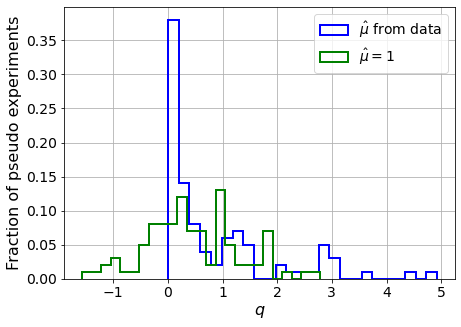

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  9164.17835908  8857.91602343
  8487.5302      8041.62514917  7504.33090759  6859.69878288
  6111.82179422  5240.91469664  4225.92567538  3032.54493912
  1638.28760031    53.45062153 -1680.16728757 -3827.24104646]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf 11249.38205791 11070.09744038 10764.20063966


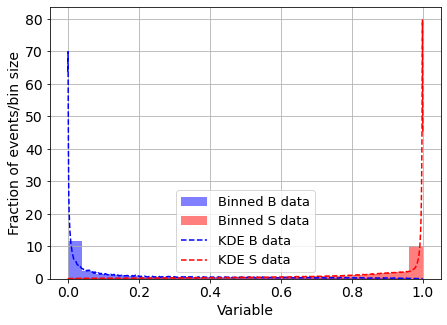

KDE Kernel:  epanechnikov
Background bandwidth:  0.0019008479046983867
Signal bandwidth:  0.0011635618505359071
This may take a while...
1 done
2 done
3 done
4 done


  0%|                                                                           | 0/2000 [00:00<?, ?it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17997999154465227
<p_{s}(Sdata)> = 12.030356080254155
<p_{b}(Bdata)> = 16.457045745414074
<p_{s}(Bdata)> = 0.25205097635371276


  0%|▏                                                                  | 6/2000 [00:00<04:35,  7.24it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1607389257606687
<p_{s}(Sdata)> = 22.232272799560825
<p_{b}(Bdata)> = 16.13613093211802
<p_{s}(Bdata)> = 0.27746496194587766
muhat = -0.1
<p_{b}(Sdata)> = 0.26924813236193224
<p_{s}(Sdata)> = 4.408694396182216
<p_{b}(Bdata)> = 16.286251722842124
<p_{s}(Bdata)> = 0.2636247543928091


  1%|▍                                                                 | 15/2000 [00:03<06:05,  5.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28168925578929
<p_{s}(Sdata)> = 11.816881039987265
<p_{b}(Bdata)> = 16.440380079364147
<p_{s}(Bdata)> = 0.2591163995020775


  1%|▊                                                                 | 26/2000 [00:06<07:15,  4.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2622374490432656
<p_{s}(Sdata)> = 6.608542800327655
<p_{b}(Bdata)> = 16.556987047139515
<p_{s}(Bdata)> = 0.263960737181414


  2%|█                                                                 | 31/2000 [00:07<07:52,  4.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22655407992292548
<p_{s}(Sdata)> = 10.344051603526472
<p_{b}(Bdata)> = 16.49767188412488
<p_{s}(Bdata)> = 0.26153679241920497


  2%|█▎                                                                | 39/2000 [00:09<09:56,  3.29it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14271227504807454
<p_{s}(Sdata)> = 23.316324379128183
<p_{b}(Bdata)> = 16.503984908886228
<p_{s}(Bdata)> = 0.2787254043285924


  2%|█▌                                                                | 48/2000 [00:12<07:03,  4.61it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23753580690095683
<p_{s}(Sdata)> = 12.41469190251804
<p_{b}(Bdata)> = 15.968177390292885
<p_{s}(Bdata)> = 0.2770612801931241
muhat = 2.1
<p_{b}(Sdata)> = 0.146901765569993
<p_{s}(Sdata)> = 27.00879727316663
<p_{b}(Bdata)> = 16.329550000924893
<p_{s}(Bdata)> = 0.2713299403640216


  3%|█▋                                                                | 52/2000 [00:12<06:08,  5.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20509099881299397
<p_{s}(Sdata)> = 7.406012790575309
<p_{b}(Bdata)> = 16.501264698541114
<p_{s}(Bdata)> = 0.2624628446303708


  3%|█▋                                                                | 53/2000 [00:13<06:52,  4.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21088497813470589
<p_{s}(Sdata)> = 20.039113556757975
<p_{b}(Bdata)> = 16.15057229652611
<p_{s}(Bdata)> = 0.25462559549957414


  3%|█▉                                                                | 57/2000 [00:13<05:14,  6.18it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2095834871454556
<p_{s}(Sdata)> = 27.478249982636367
<p_{b}(Bdata)> = 16.254384652007445
<p_{s}(Bdata)> = 0.2653748382329583
muhat = -0.1
<p_{b}(Sdata)> = 0.38910835790035897
<p_{s}(Sdata)> = 1.636595372657573
<p_{b}(Bdata)> = 16.095899300288313
<p_{s}(Bdata)> = 0.26468086620431613
muhat = -0.1
<p_{b}(Sdata)> = 0.2944465957641895
<p_{s}(Sdata)> = 16.3103421738447
<p_{b}(Bdata)> = 16.350610999331455
<p_{s}(Bdata)> = 0.25723813032127846


  3%|█▉                                                                | 59/2000 [00:13<04:09,  7.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41828863635857205
<p_{s}(Sdata)> = 3.375644443517087
<p_{b}(Bdata)> = 16.18346566583394
<p_{s}(Bdata)> = 0.2688009177548527


  3%|██                                                                | 63/2000 [00:14<06:50,  4.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16376146775497416
<p_{s}(Sdata)> = 14.619513321494484
<p_{b}(Bdata)> = 16.254982635870626
<p_{s}(Bdata)> = 0.25785055513204386


  3%|██▏                                                               | 68/2000 [00:15<05:37,  5.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37056280614623
<p_{s}(Sdata)> = 17.93116544822186
<p_{b}(Bdata)> = 16.554672981980037
<p_{s}(Bdata)> = 0.2619014036213625
muhat = -0.1
<p_{b}(Sdata)> = 0.2314642911864378
<p_{s}(Sdata)> = 11.45805090179663
<p_{b}(Bdata)> = 16.066084773537
<p_{s}(Bdata)> = 0.2562986082734055
muhat = -0.1
<p_{b}(Sdata)> = 0.2894332481877963
<p_{s}(Sdata)> = 12.160715214201188
<p_{b}(Bdata)> = 16.29761133385058
<p_{s}(Bdata)> = 0.2618592832114125


  4%|██▍                                                               | 72/2000 [00:16<06:52,  4.67it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18029976527659924
<p_{s}(Sdata)> = 21.69808600397997
<p_{b}(Bdata)> = 16.446798753208665
<p_{s}(Bdata)> = 0.2696960577977915


  4%|██▌                                                               | 76/2000 [00:17<05:04,  6.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26602062824947065
<p_{s}(Sdata)> = 13.802483718335585
<p_{b}(Bdata)> = 16.341777452811982
<p_{s}(Bdata)> = 0.2548688985350617


  4%|██▊                                                               | 87/2000 [00:20<08:49,  3.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1784739637586575
<p_{s}(Sdata)> = 11.647838316256239
<p_{b}(Bdata)> = 16.476919612308688
<p_{s}(Bdata)> = 0.2584346455352961


  4%|██▉                                                               | 89/2000 [00:20<07:28,  4.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3943081479503866
<p_{s}(Sdata)> = 0.6617721305383184
<p_{b}(Bdata)> = 15.957812078157039
<p_{s}(Bdata)> = 0.2614813995668597


  5%|███                                                               | 93/2000 [00:21<08:10,  3.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24767186021508394
<p_{s}(Sdata)> = 10.455247488719085
<p_{b}(Bdata)> = 16.37578198949292
<p_{s}(Bdata)> = 0.26182214786695956


  5%|███▏                                                              | 98/2000 [00:22<04:54,  6.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3613286761701504
<p_{s}(Sdata)> = 1.144877120154171
<p_{b}(Bdata)> = 16.320280611743673
<p_{s}(Bdata)> = 0.262486311265386
muhat = -0.1
<p_{b}(Sdata)> = 0.28515375303322893
<p_{s}(Sdata)> = 1.2868259296800413
<p_{b}(Bdata)> = 16.15221284819161
<p_{s}(Bdata)> = 0.2632702966789028


  5%|███▍                                                             | 106/2000 [00:24<05:21,  5.90it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24173339959850185
<p_{s}(Sdata)> = 14.735327710150212
<p_{b}(Bdata)> = 16.530883574171078
<p_{s}(Bdata)> = 0.27309245011151645


  6%|███▌                                                             | 111/2000 [00:25<07:44,  4.07it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3316963233891004
<p_{s}(Sdata)> = 16.494049812738904
<p_{b}(Bdata)> = 16.25159811464559
<p_{s}(Bdata)> = 0.26880960932726305


  6%|███▋                                                             | 115/2000 [00:26<04:52,  6.44it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17952198801479582
<p_{s}(Sdata)> = 27.94841654329761
<p_{b}(Bdata)> = 16.352164445209997
<p_{s}(Bdata)> = 0.2701841552682772
muhat = -0.1
<p_{b}(Sdata)> = 0.23673296378057557
<p_{s}(Sdata)> = 5.141695180319468
<p_{b}(Bdata)> = 16.31149054785622
<p_{s}(Bdata)> = 0.2613382581427713


  6%|████                                                             | 125/2000 [00:28<06:09,  5.07it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.31124130612469264
<p_{s}(Sdata)> = 17.232066456188974
<p_{b}(Bdata)> = 16.05169782053635
<p_{s}(Bdata)> = 0.27481563324728403
muhat = 2.1
<p_{b}(Sdata)> = 0.14558238704484952
<p_{s}(Sdata)> = 25.699298557895464
<p_{b}(Bdata)> = 16.30567494961408
<p_{s}(Bdata)> = 0.2772728964665488


  6%|████▏                                                            | 128/2000 [00:29<07:00,  4.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16225797936084854
<p_{s}(Sdata)> = 15.17426665714692
<p_{b}(Bdata)> = 16.335929941650992
<p_{s}(Bdata)> = 0.2576228530639252


  7%|████▎                                                            | 134/2000 [00:30<05:03,  6.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31549830507156523
<p_{s}(Sdata)> = 14.198094379214604
<p_{b}(Bdata)> = 16.409714021102335
<p_{s}(Bdata)> = 0.2533248575906391
muhat = -0.1
<p_{b}(Sdata)> = 0.19903624335689388
<p_{s}(Sdata)> = 9.278570307645438
<p_{b}(Bdata)> = 16.362739397247925
<p_{s}(Bdata)> = 0.2629529027562742


  7%|████▍                                                            | 136/2000 [00:31<05:59,  5.19it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2853377406103548
<p_{s}(Sdata)> = 20.53691760544354
<p_{b}(Bdata)> = 16.195888015568396
<p_{s}(Bdata)> = 0.2748999209564407


  7%|████▌                                                            | 140/2000 [00:31<04:18,  7.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20839759388292786
<p_{s}(Sdata)> = 6.537042523061959
<p_{b}(Bdata)> = 16.383792508962795
<p_{s}(Bdata)> = 0.26346582938976276
muhat = -0.1
<p_{b}(Sdata)> = 0.21223059660344834
<p_{s}(Sdata)> = 15.380929365874222
<p_{b}(Bdata)> = 16.345935846759623
<p_{s}(Bdata)> = 0.2556657109071333
muhat = -0.1
<p_{b}(Sdata)> = 0.26720705230050396
<p_{s}(Sdata)> = 9.683833447186892
<p_{b}(Bdata)> = 16.195013696008747
<p_{s}(Bdata)> = 0.2565807025200078


  7%|████▌                                                            | 142/2000 [00:31<04:46,  6.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2722590127182665
<p_{s}(Sdata)> = 4.558110781562797
<p_{b}(Bdata)> = 16.3865937380385
<p_{s}(Bdata)> = 0.26253271128020333


  7%|████▋                                                            | 144/2000 [00:32<04:34,  6.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.295772538028027
<p_{s}(Sdata)> = 13.871717642845846
<p_{b}(Bdata)> = 16.462868980662627
<p_{s}(Bdata)> = 0.2552061775882511


  7%|████▊                                                            | 149/2000 [00:33<04:46,  6.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2795194919850231
<p_{s}(Sdata)> = 3.014994512314407
<p_{b}(Bdata)> = 16.489683255074382
<p_{s}(Bdata)> = 0.2629439266239458
muhat = -0.1
<p_{b}(Sdata)> = 0.38268628420500733
<p_{s}(Sdata)> = 8.513840712838888
<p_{b}(Bdata)> = 16.683453362950726
<p_{s}(Bdata)> = 0.26305498128866917


  8%|████▉                                                            | 152/2000 [00:33<04:43,  6.52it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5305340320782415
<p_{s}(Sdata)> = 21.064189647410004
<p_{b}(Bdata)> = 16.28023211722583
<p_{s}(Bdata)> = 0.27290585937954853
muhat = -0.1
<p_{b}(Sdata)> = 0.2921195365631102
<p_{s}(Sdata)> = 5.976317939728929
<p_{b}(Bdata)> = 16.497083602290154
<p_{s}(Bdata)> = 0.26255997968704115


  8%|█████                                                            | 156/2000 [00:34<07:49,  3.93it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1636520260519662
<p_{s}(Sdata)> = 19.916418125167727
<p_{b}(Bdata)> = 16.129805292476227
<p_{s}(Bdata)> = 0.27538078465249305


  8%|█████▏                                                           | 160/2000 [00:35<04:51,  6.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2501673111300922
<p_{s}(Sdata)> = 22.08533269442835
<p_{b}(Bdata)> = 16.386523534219748
<p_{s}(Bdata)> = 0.26068213014605074
muhat = 2.1
<p_{b}(Sdata)> = 0.13081287322058027
<p_{s}(Sdata)> = 25.998278377493936
<p_{b}(Bdata)> = 16.36369271777191
<p_{s}(Bdata)> = 0.26984610132314807


  8%|█████▎                                                           | 162/2000 [00:35<05:02,  6.08it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.13822649844090923
<p_{s}(Sdata)> = 26.40175945034082
<p_{b}(Bdata)> = 16.51104809725397
<p_{s}(Bdata)> = 0.2662007756662591


  8%|█████▎                                                           | 164/2000 [00:35<05:19,  5.75it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21728900285221284
<p_{s}(Sdata)> = 28.555172329085185
<p_{b}(Bdata)> = 16.291707567694832
<p_{s}(Bdata)> = 0.2796137023826


  8%|█████▍                                                           | 166/2000 [00:36<05:13,  5.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2149648272266415
<p_{s}(Sdata)> = 7.220210183409469
<p_{b}(Bdata)> = 16.586822433075078
<p_{s}(Bdata)> = 0.25960291035500566


  9%|█████▋                                                           | 174/2000 [00:37<07:30,  4.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3885169438735007
<p_{s}(Sdata)> = 4.67622678025082
<p_{b}(Bdata)> = 16.530669806548442
<p_{s}(Bdata)> = 0.2575385276189533


  9%|█████▊                                                           | 179/2000 [00:38<04:42,  6.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35050906055845144
<p_{s}(Sdata)> = 2.515346593206292
<p_{b}(Bdata)> = 16.400368794686436
<p_{s}(Bdata)> = 0.2659468349895692
muhat = -0.1
<p_{b}(Sdata)> = 0.3444619401020652
<p_{s}(Sdata)> = 8.830281915411549
<p_{b}(Bdata)> = 16.411525757405506
<p_{s}(Bdata)> = 0.2620967976886219
muhat = -0.1
<p_{b}(Sdata)> = 0.19501564662995338
<p_{s}(Sdata)> = 9.929338474222257
<p_{b}(Bdata)> = 16.32444417856013
<p_{s}(Bdata)> = 0.26019995681245084


  9%|█████▉                                                           | 184/2000 [00:40<07:33,  4.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2700230821871986
<p_{s}(Sdata)> = 15.799396627130687
<p_{b}(Bdata)> = 16.468831625817597
<p_{s}(Bdata)> = 0.2594073538015414


  9%|██████                                                           | 186/2000 [00:40<06:14,  4.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2917486246261479
<p_{s}(Sdata)> = 4.970008382576561
<p_{b}(Bdata)> = 16.42329356326954
<p_{s}(Bdata)> = 0.264722316814279


 10%|██████▏                                                          | 192/2000 [00:41<05:36,  5.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34139826252477024
<p_{s}(Sdata)> = 4.226674026592056
<p_{b}(Bdata)> = 16.23774953680382
<p_{s}(Bdata)> = 0.26227922243376933


 10%|██████▎                                                          | 196/2000 [00:42<08:52,  3.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30939060419607434
<p_{s}(Sdata)> = 8.37210535139667
<p_{b}(Bdata)> = 16.298130868037166
<p_{s}(Bdata)> = 0.25733325735965396


 10%|██████▍                                                          | 199/2000 [00:43<08:04,  3.72it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1748288625805496
<p_{s}(Sdata)> = 24.407767104920126
<p_{b}(Bdata)> = 16.00179775228425
<p_{s}(Bdata)> = 0.2761449288751168


 10%|██████▋                                                          | 205/2000 [00:44<05:25,  5.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18166166910680698
<p_{s}(Sdata)> = 9.390751397504765
<p_{b}(Bdata)> = 16.165650996350156
<p_{s}(Bdata)> = 0.2629746735749532
muhat = -0.1
<p_{b}(Sdata)> = 0.2834813110106542
<p_{s}(Sdata)> = 8.566469659921193
<p_{b}(Bdata)> = 16.126978416242537
<p_{s}(Bdata)> = 0.26031277151962007
muhat = -0.1
<p_{b}(Sdata)> = 0.2318420201100634
<p_{s}(Sdata)> = 20.392357784714015
<p_{b}(Bdata)> = 16.1359791803585
<p_{s}(Bdata)> = 0.26100985962341305
muhat = 2.1
<p_{b}(Sdata)> = 0.15372042771410638
<p_{s}(Sdata)> = 32.0957886343326
<p_{b}(Bdata)> = 16.220214862070666
<p_{s}(Bdata)> = 0.2717931304605632


 11%|██████▊                                                          | 211/2000 [00:45<06:12,  4.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20467933650874198
<p_{s}(Sdata)> = 11.214079696431343
<p_{b}(Bdata)> = 16.205275469059472
<p_{s}(Bdata)> = 0.26108941617383014


 11%|██████▉                                                          | 215/2000 [00:46<04:28,  6.64it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19225207418361245
<p_{s}(Sdata)> = 22.1820148094341
<p_{b}(Bdata)> = 16.662887007460643
<p_{s}(Bdata)> = 0.26820750439727525
muhat = 2.1
<p_{b}(Sdata)> = 0.37643048557607633
<p_{s}(Sdata)> = 4.75659790064909
<p_{b}(Bdata)> = 16.171260049818155
<p_{s}(Bdata)> = 0.2851947754885477


 11%|███████                                                          | 218/2000 [00:46<04:18,  6.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23244684169568877
<p_{s}(Sdata)> = 9.937062034093636
<p_{b}(Bdata)> = 16.414279141632335
<p_{s}(Bdata)> = 0.26113659209686063


 11%|███████                                                          | 219/2000 [00:46<05:07,  5.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39292581691569417
<p_{s}(Sdata)> = 4.549107117762164
<p_{b}(Bdata)> = 16.344237087639385
<p_{s}(Bdata)> = 0.25861055840395486


 11%|███████▍                                                         | 227/2000 [00:48<07:11,  4.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15296151242161052
<p_{s}(Sdata)> = 19.582051229182152
<p_{b}(Bdata)> = 15.97022560241218
<p_{s}(Bdata)> = 0.28138370483424197


 12%|███████▌                                                         | 232/2000 [00:49<04:17,  6.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2805488699949258
<p_{s}(Sdata)> = 14.992137777909605
<p_{b}(Bdata)> = 16.46687719008755
<p_{s}(Bdata)> = 0.25269564513122295


 12%|███████▌                                                         | 234/2000 [00:50<06:23,  4.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22586160260962002
<p_{s}(Sdata)> = 11.320262544480949
<p_{b}(Bdata)> = 16.383461373929403
<p_{s}(Bdata)> = 0.2563727189640539


 12%|███████▊                                                         | 242/2000 [00:51<03:46,  7.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30217976126615187
<p_{s}(Sdata)> = 9.043034123583071
<p_{b}(Bdata)> = 16.316444734618873
<p_{s}(Bdata)> = 0.2601683146405416
muhat = 2.1
<p_{b}(Sdata)> = 0.2789433167899722
<p_{s}(Sdata)> = 19.36903309922263
<p_{b}(Bdata)> = 16.456790058668147
<p_{s}(Bdata)> = 0.2769484680027763
muhat = -0.1
<p_{b}(Sdata)> = 0.2659727141992647
<p_{s}(Sdata)> = 5.423440725135699
<p_{b}(Bdata)> = 16.165866591301505
<p_{s}(Bdata)> = 0.261732158428591


 12%|███████▉                                                         | 245/2000 [00:52<05:15,  5.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18103815710121274
<p_{s}(Sdata)> = 15.938806564741702
<p_{b}(Bdata)> = 16.50113405643059
<p_{s}(Bdata)> = 0.26048735337927376


 12%|████████▏                                                        | 250/2000 [00:52<04:36,  6.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28729890197064945
<p_{s}(Sdata)> = 5.715254725670785
<p_{b}(Bdata)> = 16.447371075008654
<p_{s}(Bdata)> = 0.260629388854371


 13%|████████▏                                                        | 253/2000 [00:53<06:19,  4.60it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23731571636025467
<p_{s}(Sdata)> = 13.200720022514822
<p_{b}(Bdata)> = 16.21844254751948
<p_{s}(Bdata)> = 0.2803430298460936


 13%|████████▍                                                        | 259/2000 [00:54<07:13,  4.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3323581781177696
<p_{s}(Sdata)> = 2.6632929111116326
<p_{b}(Bdata)> = 16.247969364188478
<p_{s}(Bdata)> = 0.2634652146894823


 13%|████████▋                                                        | 266/2000 [00:56<05:07,  5.64it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5389677900754786
<p_{s}(Sdata)> = 27.685408170666516
<p_{b}(Bdata)> = 16.219078859443616
<p_{s}(Bdata)> = 0.26409368744079276


 14%|████████▉                                                        | 276/2000 [00:57<04:00,  7.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23122256278023773
<p_{s}(Sdata)> = 5.4634397543433595
<p_{b}(Bdata)> = 16.266887583618196
<p_{s}(Bdata)> = 0.26032904228612047
muhat = -0.1
<p_{b}(Sdata)> = 0.2701579102401718
<p_{s}(Sdata)> = 4.9934888167537475
<p_{b}(Bdata)> = 16.08402808263526
<p_{s}(Bdata)> = 0.25725415377732336
muhat = -0.1
<p_{b}(Sdata)> = 0.2194844625771962
<p_{s}(Sdata)> = 9.39531309817519
<p_{b}(Bdata)> = 16.03579303835753
<p_{s}(Bdata)> = 0.25985687832407073


 14%|█████████                                                        | 278/2000 [00:58<04:38,  6.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2688367206724393
<p_{s}(Sdata)> = 1.341135197223538
<p_{b}(Bdata)> = 16.062389261383032
<p_{s}(Bdata)> = 0.27264529487388206


 14%|█████████▏                                                       | 284/2000 [01:00<08:35,  3.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18179101742435852
<p_{s}(Sdata)> = 9.054348170031973
<p_{b}(Bdata)> = 16.305932347205744
<p_{s}(Bdata)> = 0.2591905085586509


 14%|█████████▎                                                       | 288/2000 [01:00<05:14,  5.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21886631984670543
<p_{s}(Sdata)> = 14.95174650670775
<p_{b}(Bdata)> = 16.235482627802387
<p_{s}(Bdata)> = 0.25652059738878197
muhat = 2.1
<p_{b}(Sdata)> = 0.1942723249951573
<p_{s}(Sdata)> = 14.242575239800631
<p_{b}(Bdata)> = 16.343676702849365
<p_{s}(Bdata)> = 0.2767953480171372


 15%|█████████▍                                                       | 292/2000 [01:01<03:57,  7.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25466519194419535
<p_{s}(Sdata)> = 14.875840822232174
<p_{b}(Bdata)> = 16.225686298542122
<p_{s}(Bdata)> = 0.2569779858184716


 15%|█████████▌                                                       | 294/2000 [01:01<05:25,  5.24it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16493741715903393
<p_{s}(Sdata)> = 20.90892925206756
<p_{b}(Bdata)> = 16.251562626850845
<p_{s}(Bdata)> = 0.27448467735800985


 15%|█████████▋                                                       | 298/2000 [01:02<04:14,  6.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1619422076632658
<p_{s}(Sdata)> = 4.749650418456764
<p_{b}(Bdata)> = 16.42684207478604
<p_{s}(Bdata)> = 0.2629376417631777
muhat = -0.1
<p_{b}(Sdata)> = 0.5369331989427397
<p_{s}(Sdata)> = 1.0199712099759124
<p_{b}(Bdata)> = 16.212588593484067
<p_{s}(Bdata)> = 0.2667735225351796
muhat = 2.1
<p_{b}(Sdata)> = 0.17173644750921785
<p_{s}(Sdata)> = 20.27850129353074
<p_{b}(Bdata)> = 16.22239266245383
<p_{s}(Bdata)> = 0.2755260129515491


 15%|█████████▊                                                       | 302/2000 [01:03<05:50,  4.85it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18370039110944675
<p_{s}(Sdata)> = 20.814101951607803
<p_{b}(Bdata)> = 16.128069792664107
<p_{s}(Bdata)> = 0.2794555057014211


 16%|██████████                                                       | 311/2000 [01:05<07:22,  3.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4121327474061255
<p_{s}(Sdata)> = 16.04114022559656
<p_{b}(Bdata)> = 16.215704114818383
<p_{s}(Bdata)> = 0.2604268682879998


 16%|██████████▎                                                      | 319/2000 [01:07<05:44,  4.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2772723482553999
<p_{s}(Sdata)> = 9.484985209891878
<p_{b}(Bdata)> = 16.380625982497534
<p_{s}(Bdata)> = 0.2571425397759701


 16%|██████████▍                                                      | 322/2000 [01:07<03:45,  7.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18186287268570522
<p_{s}(Sdata)> = 25.826016927957788
<p_{b}(Bdata)> = 16.22456770199162
<p_{s}(Bdata)> = 0.25924029324570874
muhat = -0.1
<p_{b}(Sdata)> = 0.22079999760925187
<p_{s}(Sdata)> = 13.191130611260796
<p_{b}(Bdata)> = 16.174682623369105
<p_{s}(Bdata)> = 0.25886354897283825


 17%|██████████▊                                                      | 333/2000 [01:10<05:16,  5.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2877582480543679
<p_{s}(Sdata)> = 14.408588763715295
<p_{b}(Bdata)> = 16.270580944694014
<p_{s}(Bdata)> = 0.2576411077502684


 17%|██████████▉                                                      | 336/2000 [01:10<04:25,  6.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21075180307574723
<p_{s}(Sdata)> = 15.637566502447703
<p_{b}(Bdata)> = 16.371368729782635
<p_{s}(Bdata)> = 0.26112983649691734


 17%|███████████▎                                                     | 348/2000 [01:13<05:55,  4.65it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23182032322994747
<p_{s}(Sdata)> = 20.92535318246362
<p_{b}(Bdata)> = 16.2041126691835
<p_{s}(Bdata)> = 0.2741480136306788


 18%|███████████▍                                                     | 353/2000 [01:14<04:25,  6.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3235265532727938
<p_{s}(Sdata)> = 7.413979599346516
<p_{b}(Bdata)> = 16.301011671457047
<p_{s}(Bdata)> = 0.2564194354400028


 18%|███████████▊                                                     | 364/2000 [01:16<05:19,  5.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5279329303985564
<p_{s}(Sdata)> = 1.1664698134340283
<p_{b}(Bdata)> = 16.31161140331872
<p_{s}(Bdata)> = 0.2618239957845311
muhat = -0.1
<p_{b}(Sdata)> = 1.2481210869207542
<p_{s}(Sdata)> = 6.6280653017588635
<p_{b}(Bdata)> = 16.29160758571321
<p_{s}(Bdata)> = 0.26373511339832273


 19%|████████████                                                     | 371/2000 [01:18<07:35,  3.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3315022731991044
<p_{s}(Sdata)> = 9.870206858081456
<p_{b}(Bdata)> = 16.29385289402273
<p_{s}(Bdata)> = 0.2536757323858592


 19%|████████████▍                                                    | 384/2000 [01:21<05:22,  5.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1439665738241863
<p_{s}(Sdata)> = 14.953058056380106
<p_{b}(Bdata)> = 16.26740672411528
<p_{s}(Bdata)> = 0.262331137305031
muhat = -0.1
<p_{b}(Sdata)> = 0.23858899509939907
<p_{s}(Sdata)> = 2.058629216295432
<p_{b}(Bdata)> = 16.459014045294
<p_{s}(Bdata)> = 0.26541696600605813


 20%|████████████▉                                                    | 398/2000 [01:25<06:30,  4.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23387506828901325
<p_{s}(Sdata)> = 16.19393894742764
<p_{b}(Bdata)> = 16.343468543899863
<p_{s}(Bdata)> = 0.28449641821115734


 20%|█████████████▏                                                   | 406/2000 [01:26<05:09,  5.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27080176561123903
<p_{s}(Sdata)> = 4.928418587409094
<p_{b}(Bdata)> = 16.566955470393324
<p_{s}(Bdata)> = 0.25722071367375765
muhat = -0.1
<p_{b}(Sdata)> = 0.19039202741326103
<p_{s}(Sdata)> = 13.101621556167943
<p_{b}(Bdata)> = 16.27717173879634
<p_{s}(Bdata)> = 0.26095327057100204


 20%|█████████████▎                                                   | 409/2000 [01:27<05:06,  5.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20704824297544708
<p_{s}(Sdata)> = 2.5419927819699626
<p_{b}(Bdata)> = 16.50599109640459
<p_{s}(Bdata)> = 0.26154809248740485


 21%|█████████████▍                                                   | 414/2000 [01:29<07:21,  3.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4282983861551653
<p_{s}(Sdata)> = 3.526336961408259
<p_{b}(Bdata)> = 16.29302606952599
<p_{s}(Bdata)> = 0.2610370209854519


 21%|█████████████▊                                                   | 424/2000 [01:31<08:52,  2.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22356235523900148
<p_{s}(Sdata)> = 9.615463418033581
<p_{b}(Bdata)> = 16.324439624618236
<p_{s}(Bdata)> = 0.26395675450603606


 21%|█████████████▉                                                   | 428/2000 [01:32<05:59,  4.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19105981965498786
<p_{s}(Sdata)> = 13.46929431100725
<p_{b}(Bdata)> = 16.28883010068903
<p_{s}(Bdata)> = 0.25654814635393747


 22%|██████████████                                                   | 433/2000 [01:33<05:35,  4.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30806621436893905
<p_{s}(Sdata)> = 11.127868363934171
<p_{b}(Bdata)> = 16.039089344650336
<p_{s}(Bdata)> = 0.2591815304314831


 22%|██████████████▎                                                  | 440/2000 [01:35<06:17,  4.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.140100076587532
<p_{s}(Sdata)> = 23.296811663179493
<p_{b}(Bdata)> = 16.206816407268654
<p_{s}(Bdata)> = 0.2726723241189057


 22%|██████████████▌                                                  | 447/2000 [01:37<05:46,  4.49it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.12667648304901302
<p_{s}(Sdata)> = 25.571441885206887
<p_{b}(Bdata)> = 16.363453178140645
<p_{s}(Bdata)> = 0.2778535823296958


 22%|██████████████▌                                                  | 449/2000 [01:37<04:15,  6.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2280502221455638
<p_{s}(Sdata)> = 13.131910203710977
<p_{b}(Bdata)> = 16.41230971026813
<p_{s}(Bdata)> = 0.25689177386090933
muhat = -0.1
<p_{b}(Sdata)> = 0.1902366437112548
<p_{s}(Sdata)> = 15.815207704789806
<p_{b}(Bdata)> = 16.27936088209446
<p_{s}(Bdata)> = 0.26197921311123856


 23%|██████████████▊                                                  | 454/2000 [01:38<04:08,  6.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23356186643371335
<p_{s}(Sdata)> = 8.609872148351672
<p_{b}(Bdata)> = 15.996391438327347
<p_{s}(Bdata)> = 0.26511866464625394
muhat = 2.1
<p_{b}(Sdata)> = 0.28734395032484805
<p_{s}(Sdata)> = 16.09738808995091
<p_{b}(Bdata)> = 15.874447059770954
<p_{s}(Bdata)> = 0.27574940850069884
muhat = 2.1
<p_{b}(Sdata)> = 0.2906604897239442
<p_{s}(Sdata)> = 10.149916409419518
<p_{b}(Bdata)> = 16.11614982478836
<p_{s}(Bdata)> = 0.28291343612235226


 23%|██████████████▉                                                  | 460/2000 [01:39<04:40,  5.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.0440644000091084
<p_{s}(Sdata)> = 8.710951815897168
<p_{b}(Bdata)> = 16.20614780659248
<p_{s}(Bdata)> = 0.2590159182329776


 24%|███████████████▍                                                 | 476/2000 [01:43<05:00,  5.08it/s]

muhat = 2.1
<p_{b}(Sdata)> = 3.7351673007362347
<p_{s}(Sdata)> = 14.183333436913626
<p_{b}(Bdata)> = 16.307943709793577
<p_{s}(Bdata)> = 0.28101793774737654


 24%|███████████████▌                                                 | 477/2000 [01:43<05:22,  4.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18287289984662253
<p_{s}(Sdata)> = 9.228422579582153
<p_{b}(Bdata)> = 16.060416871612357
<p_{s}(Bdata)> = 0.26089173144059374


 24%|███████████████▋                                                 | 484/2000 [01:44<04:28,  5.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2672019106091391
<p_{s}(Sdata)> = 5.3683810104947005
<p_{b}(Bdata)> = 16.23756003553454
<p_{s}(Bdata)> = 0.25865166069229006


 24%|███████████████▊                                                 | 487/2000 [01:45<05:13,  4.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4049434852302154
<p_{s}(Sdata)> = 9.523245384653157
<p_{b}(Bdata)> = 16.789029132955708
<p_{s}(Bdata)> = 0.24960086227483833


 25%|████████████████▏                                                | 498/2000 [01:48<06:44,  3.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22101576040825632
<p_{s}(Sdata)> = 5.761755779040872
<p_{b}(Bdata)> = 16.461974879328636
<p_{s}(Bdata)> = 0.2661064173472952


 25%|████████████████▎                                                | 502/2000 [01:49<04:47,  5.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28091378365320796
<p_{s}(Sdata)> = 13.803970286940354
<p_{b}(Bdata)> = 16.481047808546105
<p_{s}(Bdata)> = 0.25734587211949095


 25%|████████████████▍                                                | 505/2000 [01:49<04:03,  6.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2858507808696556
<p_{s}(Sdata)> = 9.210584455169887
<p_{b}(Bdata)> = 16.183307899446806
<p_{s}(Bdata)> = 0.2577845270562642
muhat = -0.1
<p_{b}(Sdata)> = 0.19663124352532577
<p_{s}(Sdata)> = 13.272170480879213
<p_{b}(Bdata)> = 16.202035942156396
<p_{s}(Bdata)> = 0.2572329234011146


 26%|████████████████▋                                                | 513/2000 [01:51<04:43,  5.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2726815390028756
<p_{s}(Sdata)> = 10.648061448629308
<p_{b}(Bdata)> = 16.34870833553271
<p_{s}(Bdata)> = 0.25962270474592414


 26%|████████████████▉                                                | 520/2000 [01:53<03:33,  6.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2043935672330975
<p_{s}(Sdata)> = 18.640571720950632
<p_{b}(Bdata)> = 16.311528130628677
<p_{s}(Bdata)> = 0.2604094279058509
muhat = 2.1
<p_{b}(Sdata)> = 1.9782761520540852
<p_{s}(Sdata)> = 24.31767970859036
<p_{b}(Bdata)> = 16.511465168250876
<p_{s}(Bdata)> = 0.284630941129546
muhat = 2.1
<p_{b}(Sdata)> = 0.18853440216790907
<p_{s}(Sdata)> = 19.071323729572754
<p_{b}(Bdata)> = 16.3256858539782
<p_{s}(Bdata)> = 0.26822665243186367


 26%|████████████████▉                                                | 523/2000 [01:53<04:40,  5.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1887551652993693
<p_{s}(Sdata)> = 11.57398882326501
<p_{b}(Bdata)> = 16.264854564170083
<p_{s}(Bdata)> = 0.2640515271556312


 26%|█████████████████▏                                               | 527/2000 [01:54<04:13,  5.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3397137501154048
<p_{s}(Sdata)> = 4.16206328108391
<p_{b}(Bdata)> = 16.600621609161212
<p_{s}(Bdata)> = 0.26340766570749347


 27%|█████████████████▎                                               | 531/2000 [01:55<06:24,  3.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23049423056137736
<p_{s}(Sdata)> = 6.23499692178289
<p_{b}(Bdata)> = 16.33629211367175
<p_{s}(Bdata)> = 0.25394674442935905


 27%|█████████████████▍                                               | 535/2000 [01:56<05:01,  4.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2790376023139788
<p_{s}(Sdata)> = 8.013626268387553
<p_{b}(Bdata)> = 16.31129910769293
<p_{s}(Bdata)> = 0.2624173304624212


 27%|█████████████████▍                                               | 537/2000 [01:56<03:49,  6.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21902972245512617
<p_{s}(Sdata)> = 14.17606651205387
<p_{b}(Bdata)> = 16.28779240185234
<p_{s}(Bdata)> = 0.2583872800886974
muhat = -0.1
<p_{b}(Sdata)> = 0.1801537420194684
<p_{s}(Sdata)> = 13.08480715002462
<p_{b}(Bdata)> = 16.331588952599226
<p_{s}(Bdata)> = 0.2614102168985759


 27%|█████████████████▌                                               | 542/2000 [01:57<03:36,  6.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33843358417285213
<p_{s}(Sdata)> = 9.185592738514508
<p_{b}(Bdata)> = 16.39321006533162
<p_{s}(Bdata)> = 0.25502710521564254
muhat = -0.1
<p_{b}(Sdata)> = 0.23443440968012844
<p_{s}(Sdata)> = 2.4779263071081488
<p_{b}(Bdata)> = 16.00150954764985
<p_{s}(Bdata)> = 0.25936729709265144
muhat = 2.1
<p_{b}(Sdata)> = 0.15010609128174165
<p_{s}(Sdata)> = 34.34638532639185
<p_{b}(Bdata)> = 16.063036454854338
<p_{s}(Bdata)> = 0.2799053463815848


 27%|█████████████████▋                                               | 544/2000 [01:57<04:09,  5.84it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1763063208892828
<p_{s}(Sdata)> = 31.636195519127266
<p_{b}(Bdata)> = 16.360178338652
<p_{s}(Bdata)> = 0.2712367179936381


 28%|█████████████████▉                                               | 553/2000 [01:59<05:10,  4.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42001787176967115
<p_{s}(Sdata)> = 7.866530785257368
<p_{b}(Bdata)> = 16.104794252827926
<p_{s}(Bdata)> = 0.2573750398690802
muhat = 2.1
<p_{b}(Sdata)> = 0.2573593791718832
<p_{s}(Sdata)> = 30.286025091790698
<p_{b}(Bdata)> = 16.392106715167635
<p_{s}(Bdata)> = 0.26914254770028856


 28%|██████████████████                                               | 555/2000 [02:00<05:01,  4.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2681327729030374
<p_{s}(Sdata)> = 1.8143815449439575
<p_{b}(Bdata)> = 16.669705511181736
<p_{s}(Bdata)> = 0.25514028432412617


 28%|██████████████████▏                                              | 561/2000 [02:01<04:15,  5.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3558469883606704
<p_{s}(Sdata)> = 4.027132449536619
<p_{b}(Bdata)> = 16.232842446575102
<p_{s}(Bdata)> = 0.2648527073719054


 28%|██████████████████▍                                              | 566/2000 [02:02<03:55,  6.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.13130530615641908
<p_{s}(Sdata)> = 21.81832425760778
<p_{b}(Bdata)> = 16.315020644593705
<p_{s}(Bdata)> = 0.2698395316221653
muhat = 2.1
<p_{b}(Sdata)> = 0.18982578519599064
<p_{s}(Sdata)> = 23.363166358359305
<p_{b}(Bdata)> = 16.113912473137454
<p_{s}(Bdata)> = 0.27440200298084333


 28%|██████████████████▍                                              | 569/2000 [02:03<04:31,  5.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22348361114320264
<p_{s}(Sdata)> = 14.68764666011657
<p_{b}(Bdata)> = 16.121355741137542
<p_{s}(Bdata)> = 0.2584911767530822


 29%|██████████████████▋                                              | 574/2000 [02:04<04:51,  4.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.6120733344362292
<p_{s}(Sdata)> = 6.690344414008277
<p_{b}(Bdata)> = 16.294873518837413
<p_{s}(Bdata)> = 0.2645062777475425


 29%|██████████████████▊                                              | 578/2000 [02:04<03:47,  6.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21722075146160627
<p_{s}(Sdata)> = 15.490468847235642
<p_{b}(Bdata)> = 16.48050268919596
<p_{s}(Bdata)> = 0.2638371985440253


 29%|██████████████████▉                                              | 583/2000 [02:05<03:56,  5.99it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20011129305984698
<p_{s}(Sdata)> = 20.715185063348823
<p_{b}(Bdata)> = 16.353835146824174
<p_{s}(Bdata)> = 0.27539884714919877
muhat = 2.1
<p_{b}(Sdata)> = 0.19416483088255043
<p_{s}(Sdata)> = 15.618783694126758
<p_{b}(Bdata)> = 16.250100149997053
<p_{s}(Bdata)> = 0.2723539074610811


 29%|███████████████████▏                                             | 589/2000 [02:06<03:05,  7.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.427067707742351
<p_{s}(Sdata)> = 6.212707106035364
<p_{b}(Bdata)> = 15.93341668260919
<p_{s}(Bdata)> = 0.25930976341941225
muhat = -0.1
<p_{b}(Sdata)> = 0.11750153919040643
<p_{s}(Sdata)> = 14.048725033471733
<p_{b}(Bdata)> = 16.292679906877744
<p_{s}(Bdata)> = 0.26106565922524405


 30%|███████████████████▏                                             | 591/2000 [02:06<02:28,  9.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30150504735454753
<p_{s}(Sdata)> = 11.077071084177064
<p_{b}(Bdata)> = 16.344921384442852
<p_{s}(Bdata)> = 0.26507094101965345


 30%|███████████████████▎                                             | 595/2000 [02:07<03:36,  6.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2719585916642823
<p_{s}(Sdata)> = 1.8084773484901566
<p_{b}(Bdata)> = 16.36479404102029
<p_{s}(Bdata)> = 0.2600709398962561


 30%|███████████████████▌                                             | 602/2000 [02:08<03:34,  6.50it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.12050216477892371
<p_{s}(Sdata)> = 21.548798616093332
<p_{b}(Bdata)> = 16.628911916227075
<p_{s}(Bdata)> = 0.2671517771112927


 30%|███████████████████▋                                             | 604/2000 [02:08<03:16,  7.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5523458628926134
<p_{s}(Sdata)> = 3.61937080017475
<p_{b}(Bdata)> = 16.225890365610944
<p_{s}(Bdata)> = 0.25443855379490604


 30%|███████████████████▊                                             | 608/2000 [02:10<05:56,  3.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38915108529582454
<p_{s}(Sdata)> = 7.195749776290403
<p_{b}(Bdata)> = 16.334014751673443
<p_{s}(Bdata)> = 0.25842968151026385


 31%|███████████████████▉                                             | 613/2000 [02:11<05:07,  4.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2644561272687776
<p_{s}(Sdata)> = 6.763385101901056
<p_{b}(Bdata)> = 16.262447327539657
<p_{s}(Bdata)> = 0.25698010044185005


 31%|████████████████████                                             | 618/2000 [02:11<03:33,  6.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24124366623126736
<p_{s}(Sdata)> = 8.073463914387952
<p_{b}(Bdata)> = 16.195161093985444
<p_{s}(Bdata)> = 0.26396419972647156
muhat = 2.1
<p_{b}(Sdata)> = 0.18762221847781582
<p_{s}(Sdata)> = 32.706608521253884
<p_{b}(Bdata)> = 16.498168600555022
<p_{s}(Bdata)> = 0.26879364897480545


 31%|████████████████████▏                                            | 623/2000 [02:13<06:57,  3.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3173139748192004
<p_{s}(Sdata)> = 1.116121264334326
<p_{b}(Bdata)> = 16.41822637475186
<p_{s}(Bdata)> = 0.26493064329598254


 31%|████████████████████▎                                            | 625/2000 [02:13<05:42,  4.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21008886984826036
<p_{s}(Sdata)> = 11.661794349271457
<p_{b}(Bdata)> = 16.399947434933633
<p_{s}(Bdata)> = 0.28181411512049154


 32%|████████████████████▍                                            | 630/2000 [02:14<04:27,  5.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4337857044599055
<p_{s}(Sdata)> = 6.005632059385679
<p_{b}(Bdata)> = 16.464179531860218
<p_{s}(Bdata)> = 0.26394174223789924


 32%|████████████████████▌                                            | 634/2000 [02:15<03:38,  6.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2305890138138934
<p_{s}(Sdata)> = 1.7364032753955754
<p_{b}(Bdata)> = 16.608612876541745
<p_{s}(Bdata)> = 0.25923026169811497
muhat = -0.1
<p_{b}(Sdata)> = 0.313992226730353
<p_{s}(Sdata)> = 5.18212100241709
<p_{b}(Bdata)> = 16.165772191346
<p_{s}(Bdata)> = 0.2660622485025826


 32%|████████████████████▋                                            | 636/2000 [02:15<02:52,  7.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36987739841016176
<p_{s}(Sdata)> = 3.3490697381170746
<p_{b}(Bdata)> = 16.59530485524016
<p_{s}(Bdata)> = 0.25894482726362017
muhat = -0.1
<p_{b}(Sdata)> = 0.23406228919713215
<p_{s}(Sdata)> = 13.254843644837363
<p_{b}(Bdata)> = 16.154161550511443
<p_{s}(Bdata)> = 0.25696716375440104


 32%|████████████████████▊                                            | 641/2000 [02:16<03:16,  6.92it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18359632191226483
<p_{s}(Sdata)> = 16.344437255673153
<p_{b}(Bdata)> = 16.267906771793385
<p_{s}(Bdata)> = 0.2752943226082591
muhat = 2.1
<p_{b}(Sdata)> = 0.1561409555688033
<p_{s}(Sdata)> = 35.04540046876666
<p_{b}(Bdata)> = 16.16625303350878
<p_{s}(Bdata)> = 0.27519826602584674


 32%|█████████████████████                                            | 649/2000 [02:18<05:52,  3.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3531194307712027
<p_{s}(Sdata)> = 1.7163860176649517
<p_{b}(Bdata)> = 16.311276889064874
<p_{s}(Bdata)> = 0.26555899294468516


 33%|█████████████████████▎                                           | 655/2000 [02:19<06:02,  3.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2095078112143814
<p_{s}(Sdata)> = 7.2063212656445375
<p_{b}(Bdata)> = 16.472678277644935
<p_{s}(Bdata)> = 0.2587819961665034


 34%|█████████████████████▊                                           | 671/2000 [02:23<04:34,  4.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22949519817325392
<p_{s}(Sdata)> = 9.296138518382802
<p_{b}(Bdata)> = 16.39542209002148
<p_{s}(Bdata)> = 0.2572275882892774


 34%|█████████████████████▊                                           | 672/2000 [02:24<04:53,  4.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1700809948216235
<p_{s}(Sdata)> = 17.95182029699764
<p_{b}(Bdata)> = 16.08004094130404
<p_{s}(Bdata)> = 0.25996932111747023


 34%|█████████████████████▉                                           | 675/2000 [02:24<03:43,  5.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4557426031627714
<p_{s}(Sdata)> = 1.6672259048292803
<p_{b}(Bdata)> = 16.248684766395847
<p_{s}(Bdata)> = 0.26081350303880624


 34%|██████████████████████                                           | 677/2000 [02:24<03:59,  5.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23093580114711582
<p_{s}(Sdata)> = 7.75279831219754
<p_{b}(Bdata)> = 16.245598000932667
<p_{s}(Bdata)> = 0.26624972844365286


 35%|██████████████████████▍                                          | 692/2000 [02:27<03:09,  6.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25345404869150817
<p_{s}(Sdata)> = 7.660668438107052
<p_{b}(Bdata)> = 16.222829463072348
<p_{s}(Bdata)> = 0.25859882423277175
muhat = -0.1
<p_{b}(Sdata)> = 0.2694353049928828
<p_{s}(Sdata)> = 8.410777724649478
<p_{b}(Bdata)> = 15.993585194533516
<p_{s}(Bdata)> = 0.26147553657556544


 35%|██████████████████████▌                                          | 694/2000 [02:28<04:05,  5.32it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1987789189876377
<p_{s}(Sdata)> = 21.43357156933219
<p_{b}(Bdata)> = 15.959703546730466
<p_{s}(Bdata)> = 0.27705441681071147


 35%|██████████████████████▋                                          | 698/2000 [02:29<05:43,  3.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3701862971762507
<p_{s}(Sdata)> = 2.8389607291008603
<p_{b}(Bdata)> = 16.35643873525068
<p_{s}(Bdata)> = 0.26230904940675626


 36%|███████████████████████▏                                         | 714/2000 [02:33<04:22,  4.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2704123887017106
<p_{s}(Sdata)> = 4.54403108844351
<p_{b}(Bdata)> = 16.41713229017756
<p_{s}(Bdata)> = 0.26252039987231507
muhat = 2.1
<p_{b}(Sdata)> = 0.2930738620398226
<p_{s}(Sdata)> = 19.057877605791887
<p_{b}(Bdata)> = 16.146730250990114
<p_{s}(Bdata)> = 0.2796126905271958


 36%|███████████████████████▌                                         | 725/2000 [02:36<05:17,  4.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3006899073777584
<p_{s}(Sdata)> = 1.1916836746012156
<p_{b}(Bdata)> = 16.27155790033203
<p_{s}(Bdata)> = 0.26514595019055104


 36%|███████████████████████▋                                         | 729/2000 [02:37<04:50,  4.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43904276230841066
<p_{s}(Sdata)> = 9.919125336363276
<p_{b}(Bdata)> = 16.26669225911109
<p_{s}(Bdata)> = 0.26039076159260555


 37%|███████████████████████▉                                         | 735/2000 [02:38<03:09,  6.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35043720155423147
<p_{s}(Sdata)> = 7.318509537230568
<p_{b}(Bdata)> = 16.37781426490779
<p_{s}(Bdata)> = 0.2654202156672339


 37%|████████████████████████                                         | 740/2000 [02:39<03:15,  6.45it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16873245762336023
<p_{s}(Sdata)> = 23.7273848351467
<p_{b}(Bdata)> = 15.996817947521714
<p_{s}(Bdata)> = 0.26733390561369613


 37%|████████████████████████▏                                        | 744/2000 [02:40<05:11,  4.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1510817942051678
<p_{s}(Sdata)> = 28.5231163599708
<p_{b}(Bdata)> = 16.423446268562707
<p_{s}(Bdata)> = 0.2550142004844277


 38%|████████████████████████▍                                        | 751/2000 [02:42<06:01,  3.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35731553830232243
<p_{s}(Sdata)> = 4.746899949292813
<p_{b}(Bdata)> = 15.975654862549558
<p_{s}(Bdata)> = 0.26108382295135873


 38%|████████████████████████▌                                        | 754/2000 [02:42<05:11,  4.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43134451444910316
<p_{s}(Sdata)> = 1.0086988807815298
<p_{b}(Bdata)> = 16.15081343007488
<p_{s}(Bdata)> = 0.261280789535248


 38%|████████████████████████▊                                        | 765/2000 [02:45<04:23,  4.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19895493644558518
<p_{s}(Sdata)> = 6.137333742954103
<p_{b}(Bdata)> = 16.518175222551687
<p_{s}(Bdata)> = 0.2539458748607353


 38%|█████████████████████████                                        | 770/2000 [02:46<04:47,  4.28it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19998535527781658
<p_{s}(Sdata)> = 20.887585867068328
<p_{b}(Bdata)> = 16.43205658218265
<p_{s}(Bdata)> = 0.2660217314462196


 39%|█████████████████████████▏                                       | 774/2000 [02:47<04:09,  4.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21748493728434418
<p_{s}(Sdata)> = 1.9869592623153123
<p_{b}(Bdata)> = 16.356197903253314
<p_{s}(Bdata)> = 0.25880245377995087


 39%|█████████████████████████▍                                       | 781/2000 [02:48<03:57,  5.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15840731632556299
<p_{s}(Sdata)> = 17.837222104285495
<p_{b}(Bdata)> = 16.16349633312185
<p_{s}(Bdata)> = 0.25601153434951857
muhat = 2.1
<p_{b}(Sdata)> = 0.11015091573264627
<p_{s}(Sdata)> = 28.89073802435439
<p_{b}(Bdata)> = 16.126130154812156
<p_{s}(Bdata)> = 0.27473292603108607


 39%|█████████████████████████▍                                       | 783/2000 [02:48<03:22,  6.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25699173109147977
<p_{s}(Sdata)> = 3.0812940234610853
<p_{b}(Bdata)> = 15.931462918731198
<p_{s}(Bdata)> = 0.2614095054423886


 40%|█████████████████████████▋                                       | 791/2000 [02:50<03:00,  6.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2402585206792289
<p_{s}(Sdata)> = 12.277238573691177
<p_{b}(Bdata)> = 16.190422310682564
<p_{s}(Bdata)> = 0.25536368711501356
muhat = -0.1
<p_{b}(Sdata)> = 0.3041498280933189
<p_{s}(Sdata)> = 10.738071744385355
<p_{b}(Bdata)> = 15.900273143117012
<p_{s}(Bdata)> = 0.2668617757415797


 40%|█████████████████████████▊                                       | 794/2000 [02:50<02:59,  6.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2951362530002619
<p_{s}(Sdata)> = 13.630636360763676
<p_{b}(Bdata)> = 16.49636392321148
<p_{s}(Bdata)> = 0.2599610836403686
muhat = -0.1
<p_{b}(Sdata)> = 0.3308728989475081
<p_{s}(Sdata)> = 6.059546405716251
<p_{b}(Bdata)> = 16.555343967223774
<p_{s}(Bdata)> = 0.26306064786813016


 40%|██████████████████████████                                       | 801/2000 [02:52<05:01,  3.97it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1050400342770656
<p_{s}(Sdata)> = 41.62101185392373
<p_{b}(Bdata)> = 16.162032406624714
<p_{s}(Bdata)> = 0.27274833691326655


 40%|██████████████████████████▏                                      | 806/2000 [02:53<03:16,  6.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3579998317297853
<p_{s}(Sdata)> = 17.04190472998239
<p_{b}(Bdata)> = 16.22550746911796
<p_{s}(Bdata)> = 0.257303631072769
muhat = -0.1
<p_{b}(Sdata)> = 0.4315446154963853
<p_{s}(Sdata)> = 15.68908701641529
<p_{b}(Bdata)> = 16.34704655595267
<p_{s}(Bdata)> = 0.2602981419128654
muhat = -0.1
<p_{b}(Sdata)> = 0.21218734298922184
<p_{s}(Sdata)> = 17.889585081077428
<p_{b}(Bdata)> = 16.242437953194152
<p_{s}(Bdata)> = 0.25995741632111274


 41%|██████████████████████████▋                                      | 821/2000 [02:57<03:52,  5.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24686097066888227
<p_{s}(Sdata)> = 8.277684236289403
<p_{b}(Bdata)> = 15.911545164734152
<p_{s}(Bdata)> = 0.26222472064890007


 41%|██████████████████████████▉                                      | 828/2000 [02:59<04:46,  4.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36449877771510203
<p_{s}(Sdata)> = 13.216139220231444
<p_{b}(Bdata)> = 16.116717318818488
<p_{s}(Bdata)> = 0.26285982240572137


 42%|██████████████████████████▉                                      | 830/2000 [02:59<03:47,  5.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1180924890165897
<p_{s}(Sdata)> = 29.742541092322643
<p_{b}(Bdata)> = 16.057515856630157
<p_{s}(Bdata)> = 0.2720703342527424


 42%|███████████████████████████▍                                     | 846/2000 [03:02<03:31,  5.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2505681860051238
<p_{s}(Sdata)> = 11.620574788724694
<p_{b}(Bdata)> = 16.448625298285386
<p_{s}(Bdata)> = 0.254014303668688


 43%|███████████████████████████▋                                     | 852/2000 [03:04<04:39,  4.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5183837684841909
<p_{s}(Sdata)> = 1.8046758607099092
<p_{b}(Bdata)> = 16.15773587826274
<p_{s}(Bdata)> = 0.26110785709707


 43%|███████████████████████████▊                                     | 855/2000 [03:05<05:24,  3.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24273805557613456
<p_{s}(Sdata)> = 9.739663616933274
<p_{b}(Bdata)> = 16.286306002380638
<p_{s}(Bdata)> = 0.25665711103759925


 43%|███████████████████████████▊                                     | 857/2000 [03:05<04:20,  4.39it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19410095185844825
<p_{s}(Sdata)> = 26.359307257047877
<p_{b}(Bdata)> = 16.4653750345561
<p_{s}(Bdata)> = 0.270283233437172


 43%|████████████████████████████                                     | 864/2000 [03:06<03:16,  5.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22349150054377942
<p_{s}(Sdata)> = 4.463488360153484
<p_{b}(Bdata)> = 16.34616206079495
<p_{s}(Bdata)> = 0.263376489278697


 43%|████████████████████████████▏                                    | 868/2000 [03:07<03:41,  5.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33435202422779225
<p_{s}(Sdata)> = 15.512072466317871
<p_{b}(Bdata)> = 15.981382724137612
<p_{s}(Bdata)> = 0.25819535281815575


 44%|████████████████████████████▌                                    | 877/2000 [03:09<03:38,  5.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37709584319317213
<p_{s}(Sdata)> = 4.393470705664542
<p_{b}(Bdata)> = 16.12107601361909
<p_{s}(Bdata)> = 0.2604741050753216


 44%|████████████████████████████▋                                    | 883/2000 [03:11<03:33,  5.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6797623524997134
<p_{s}(Sdata)> = 10.714908770952782
<p_{b}(Bdata)> = 16.579638422486422
<p_{s}(Bdata)> = 0.2522805169584915


 44%|████████████████████████████▉                                    | 890/2000 [03:13<04:07,  4.49it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21585824999781844
<p_{s}(Sdata)> = 26.035888238765736
<p_{b}(Bdata)> = 16.437853660331054
<p_{s}(Bdata)> = 0.28094781164376437
muhat = 2.1
<p_{b}(Sdata)> = 0.48655913828913977
<p_{s}(Sdata)> = 16.552664524656965
<p_{b}(Bdata)> = 16.311044665588685
<p_{s}(Bdata)> = 0.27156734927842574


 45%|█████████████████████████████▍                                   | 904/2000 [03:16<05:08,  3.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33828734808372757
<p_{s}(Sdata)> = 1.705057803213233
<p_{b}(Bdata)> = 16.512422872396474
<p_{s}(Bdata)> = 0.25903924612147206


 45%|█████████████████████████████▌                                   | 908/2000 [03:17<04:23,  4.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30871372195252733
<p_{s}(Sdata)> = 8.158595098706996
<p_{b}(Bdata)> = 16.39731555358175
<p_{s}(Bdata)> = 0.26140182527935735


 46%|█████████████████████████████▋                                   | 913/2000 [03:18<03:15,  5.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36372467731755914
<p_{s}(Sdata)> = 3.93342016296775
<p_{b}(Bdata)> = 16.38415567188648
<p_{s}(Bdata)> = 0.2659811636214055
muhat = -0.1
<p_{b}(Sdata)> = 0.733002869919911
<p_{s}(Sdata)> = 7.190541327773593
<p_{b}(Bdata)> = 16.35135182002253
<p_{s}(Bdata)> = 0.2571065704599398
muhat = -0.1
<p_{b}(Sdata)> = 0.2852817987863715
<p_{s}(Sdata)> = 6.4709625410772995
<p_{b}(Bdata)> = 16.0008107940197
<p_{s}(Bdata)> = 0.26307414493739006


 46%|█████████████████████████████▊                                   | 919/2000 [03:19<03:20,  5.39it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2868638265266154
<p_{s}(Sdata)> = 28.674648757503746
<p_{b}(Bdata)> = 16.22723527966384
<p_{s}(Bdata)> = 0.2682796862988498


 46%|█████████████████████████████▉                                   | 921/2000 [03:19<02:33,  7.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17964501716251122
<p_{s}(Sdata)> = 9.150046404227773
<p_{b}(Bdata)> = 16.44737603295774
<p_{s}(Bdata)> = 0.258918822324792
muhat = -0.1
<p_{b}(Sdata)> = 0.14678019466410944
<p_{s}(Sdata)> = 10.56897426725098
<p_{b}(Bdata)> = 16.36625846663305
<p_{s}(Bdata)> = 0.25406184001733895


 46%|██████████████████████████████                                   | 924/2000 [03:20<02:44,  6.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44553351797193547
<p_{s}(Sdata)> = 7.930141502690181
<p_{b}(Bdata)> = 16.44382035034604
<p_{s}(Bdata)> = 0.2575908387182662
muhat = -0.1
<p_{b}(Sdata)> = 0.23965216269495201
<p_{s}(Sdata)> = 8.970135356594799
<p_{b}(Bdata)> = 16.34707352077482
<p_{s}(Bdata)> = 0.25962007716565455
muhat = -0.1
<p_{b}(Sdata)> = 0.2685453200292077
<p_{s}(Sdata)> = 12.937931391803607
<p_{b}(Bdata)> = 16.078433561534027
<p_{s}(Bdata)> = 0.2538953827252183


 47%|██████████████████████████████▎                                  | 931/2000 [03:22<04:48,  3.71it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20185623513841155
<p_{s}(Sdata)> = 28.582546030412214
<p_{b}(Bdata)> = 16.291382945453215
<p_{s}(Bdata)> = 0.27279469905716397


 47%|██████████████████████████████▌                                  | 939/2000 [03:24<05:24,  3.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3155930256909738
<p_{s}(Sdata)> = 2.523814732082397
<p_{b}(Bdata)> = 16.784122142969963
<p_{s}(Bdata)> = 0.2547557602248273


 47%|██████████████████████████████▌                                  | 941/2000 [03:24<04:07,  4.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2212149358471877
<p_{s}(Sdata)> = 13.172393345857657
<p_{b}(Bdata)> = 16.235903924740978
<p_{s}(Bdata)> = 0.26299232624077895


 47%|██████████████████████████████▊                                  | 947/2000 [03:26<04:57,  3.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1380152141477784
<p_{s}(Sdata)> = 11.466997034949793
<p_{b}(Bdata)> = 16.316745198195218
<p_{s}(Bdata)> = 0.2615166586239247


 48%|███████████████████████████████▎                                 | 963/2000 [03:31<04:49,  3.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1196190072720894
<p_{s}(Sdata)> = 12.500424128061317
<p_{b}(Bdata)> = 16.6117477253343
<p_{s}(Bdata)> = 0.2595680841564523


 48%|███████████████████████████████▍                                 | 969/2000 [03:32<03:09,  5.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33544626679128753
<p_{s}(Sdata)> = 3.232748395378844
<p_{b}(Bdata)> = 16.067046081688247
<p_{s}(Bdata)> = 0.272103236509039
muhat = -0.1
<p_{b}(Sdata)> = 0.2491257360841775
<p_{s}(Sdata)> = 1.388920409748383
<p_{b}(Bdata)> = 16.667759285212096
<p_{s}(Bdata)> = 0.26089589719464135


 48%|███████████████████████████████▌                                 | 970/2000 [03:32<03:36,  4.75it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.12609283943357935
<p_{s}(Sdata)> = 30.26242682960202
<p_{b}(Bdata)> = 16.38348708874987
<p_{s}(Bdata)> = 0.2686605844114917


 49%|███████████████████████████████▋                                 | 974/2000 [03:32<02:26,  7.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1865485773303755
<p_{s}(Sdata)> = 13.986530674589828
<p_{b}(Bdata)> = 16.4475674033578
<p_{s}(Bdata)> = 0.25576152632078947
muhat = -0.1
<p_{b}(Sdata)> = 0.500266115232466
<p_{s}(Sdata)> = 4.3462391810041385
<p_{b}(Bdata)> = 16.555975154319764
<p_{s}(Bdata)> = 0.26002193484469116
muhat = -0.1
<p_{b}(Sdata)> = 0.4356863161128673
<p_{s}(Sdata)> = 11.884620663401625
<p_{b}(Bdata)> = 16.5547159822872
<p_{s}(Bdata)> = 0.2584782568310003


 49%|███████████████████████████████▊                                 | 977/2000 [03:33<03:24,  5.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2678264050472951
<p_{s}(Sdata)> = 1.4487257224083747
<p_{b}(Bdata)> = 16.436500546879937
<p_{s}(Bdata)> = 0.2648895268260035


 49%|███████████████████████████████▉                                 | 981/2000 [03:34<02:47,  6.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21056947213202154
<p_{s}(Sdata)> = 14.686915982355085
<p_{b}(Bdata)> = 16.58811398422386
<p_{s}(Bdata)> = 0.2521961743810857
muhat = -0.1
<p_{b}(Sdata)> = 0.40792702926857677
<p_{s}(Sdata)> = 3.930146494123268
<p_{b}(Bdata)> = 16.388604965274208
<p_{s}(Bdata)> = 0.25955114888767916


 49%|███████████████████████████████▉                                 | 984/2000 [03:34<02:19,  7.29it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5476224866311288
<p_{s}(Sdata)> = 26.740951618309666
<p_{b}(Bdata)> = 16.161931148286758
<p_{s}(Bdata)> = 0.27135182813386244


 49%|████████████████████████████████▏                                | 989/2000 [03:35<03:58,  4.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26625248010522035
<p_{s}(Sdata)> = 8.628010325078893
<p_{b}(Bdata)> = 15.995964564112787
<p_{s}(Bdata)> = 0.25727577744266733


 50%|████████████████████████████████▍                                | 999/2000 [03:38<03:58,  4.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.410382738799421
<p_{s}(Sdata)> = 0.7693245923472394
<p_{b}(Bdata)> = 16.411051138213487
<p_{s}(Bdata)> = 0.26631742364465116


 50%|████████████████████████████████                                | 1001/2000 [03:38<03:19,  5.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37444111275986425
<p_{s}(Sdata)> = 6.669122654291271
<p_{b}(Bdata)> = 16.280420547133435
<p_{s}(Bdata)> = 0.258895859548376


 51%|████████████████████████████████▎                               | 1011/2000 [03:40<03:11,  5.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24762354871141853
<p_{s}(Sdata)> = 7.6485173785678695
<p_{b}(Bdata)> = 16.570810142899603
<p_{s}(Bdata)> = 0.26254204230885675
muhat = -0.1
<p_{b}(Sdata)> = 0.17133568607364202
<p_{s}(Sdata)> = 3.3313530985728543
<p_{b}(Bdata)> = 16.625270493024644
<p_{s}(Bdata)> = 0.25909016998710543


 51%|████████████████████████████████▍                               | 1012/2000 [03:41<03:51,  4.27it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18689057179254173
<p_{s}(Sdata)> = 25.4954537713844
<p_{b}(Bdata)> = 16.26522603519602
<p_{s}(Bdata)> = 0.2680472413516278


 51%|████████████████████████████████▍                               | 1015/2000 [03:41<03:18,  4.96it/s]

muhat = 2.1
<p_{b}(Sdata)> = 1.0781084306633422
<p_{s}(Sdata)> = 22.703816335470556
<p_{b}(Bdata)> = 16.28834769097867
<p_{s}(Bdata)> = 0.26877351373032843


 51%|████████████████████████████████▌                               | 1017/2000 [03:41<02:55,  5.59it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.12562274118142475
<p_{s}(Sdata)> = 26.588438147480165
<p_{b}(Bdata)> = 16.164807434548784
<p_{s}(Bdata)> = 0.27223200513390966


 51%|████████████████████████████████▊                               | 1025/2000 [03:43<02:18,  7.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2753195471895169
<p_{s}(Sdata)> = 15.458837399607521
<p_{b}(Bdata)> = 16.30755341880881
<p_{s}(Bdata)> = 0.27597140833747075
muhat = -0.1
<p_{b}(Sdata)> = 0.54839981970499
<p_{s}(Sdata)> = 9.557958618011236
<p_{b}(Bdata)> = 16.37000774659663
<p_{s}(Bdata)> = 0.2600187022472577


 51%|████████████████████████████████▉                               | 1029/2000 [03:43<02:34,  6.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2631286319468079
<p_{s}(Sdata)> = 7.571232551745982
<p_{b}(Bdata)> = 16.272494542086047
<p_{s}(Bdata)> = 0.2550307623839288


 52%|████████████████████████████████▉                               | 1030/2000 [03:44<03:29,  4.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1843689492237466
<p_{s}(Sdata)> = 5.8622278666172845
<p_{b}(Bdata)> = 16.433139754334444
<p_{s}(Bdata)> = 0.26239367750792136


 52%|█████████████████████████████████                               | 1032/2000 [03:44<03:25,  4.71it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17486788808276524
<p_{s}(Sdata)> = 25.515317854508268
<p_{b}(Bdata)> = 16.30571166792016
<p_{s}(Bdata)> = 0.2824809571906713


 52%|█████████████████████████████████▎                              | 1041/2000 [03:47<04:19,  3.69it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16249881707404326
<p_{s}(Sdata)> = 7.642721140094407
<p_{b}(Bdata)> = 16.463140073487875
<p_{s}(Bdata)> = 0.2841990437189029


 52%|█████████████████████████████████▌                              | 1047/2000 [03:48<02:50,  5.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 5.967510310447045
<p_{s}(Sdata)> = 9.420192229649944
<p_{b}(Bdata)> = 16.442030103209596
<p_{s}(Bdata)> = 0.2569185830056757


 53%|█████████████████████████████████▊                              | 1058/2000 [03:51<04:40,  3.35it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2328505944486006
<p_{s}(Sdata)> = 24.951553280202788
<p_{b}(Bdata)> = 16.313497383449228
<p_{s}(Bdata)> = 0.26813674832951134


 53%|█████████████████████████████████▉                              | 1061/2000 [03:51<04:00,  3.91it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1110035582092061
<p_{s}(Sdata)> = 16.59292844798264
<p_{b}(Bdata)> = 16.406857977480072
<p_{s}(Bdata)> = 0.27386746588743927


 53%|██████████████████████████████████                              | 1066/2000 [03:52<02:30,  6.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24558025265705116
<p_{s}(Sdata)> = 13.112775498341595
<p_{b}(Bdata)> = 16.60983978681239
<p_{s}(Bdata)> = 0.25501105207494795
muhat = -0.1
<p_{b}(Sdata)> = 0.3161713766962083
<p_{s}(Sdata)> = 11.121268586150219
<p_{b}(Bdata)> = 16.1144040117249
<p_{s}(Bdata)> = 0.26483827703352725


 54%|██████████████████████████████████▏                             | 1070/2000 [03:53<03:58,  3.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17522202424154332
<p_{s}(Sdata)> = 16.98532772333363
<p_{b}(Bdata)> = 16.209998304797416
<p_{s}(Bdata)> = 0.2604131932588558


 54%|██████████████████████████████████▎                             | 1073/2000 [03:54<04:36,  3.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5794238630318531
<p_{s}(Sdata)> = 3.171732653492815
<p_{b}(Bdata)> = 16.21290062236372
<p_{s}(Bdata)> = 0.26396092253037856


 54%|██████████████████████████████████▋                             | 1084/2000 [03:56<02:23,  6.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2291794686219147
<p_{s}(Sdata)> = 6.853354238901097
<p_{b}(Bdata)> = 16.35155206718373
<p_{s}(Bdata)> = 0.25972904250749407
muhat = -0.1
<p_{b}(Sdata)> = 0.21030475520290395
<p_{s}(Sdata)> = 12.681345061663443
<p_{b}(Bdata)> = 16.216752586137822
<p_{s}(Bdata)> = 0.255691400276689


 54%|██████████████████████████████████▊                             | 1089/2000 [03:57<02:29,  6.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29604523854372633
<p_{s}(Sdata)> = 12.512240460433912
<p_{b}(Bdata)> = 16.257157551617954
<p_{s}(Bdata)> = 0.26309667986858715
muhat = -0.1
<p_{b}(Sdata)> = 0.27092235846741086
<p_{s}(Sdata)> = 4.69776062050415
<p_{b}(Bdata)> = 16.244987844463868
<p_{s}(Bdata)> = 0.26377891133378334


 55%|██████████████████████████████████▉                             | 1092/2000 [03:58<04:08,  3.66it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4036308273566361
<p_{s}(Sdata)> = 14.308873920095659
<p_{b}(Bdata)> = 16.055513043312857
<p_{s}(Bdata)> = 0.27607611848630736


 55%|███████████████████████████████████                             | 1096/2000 [03:59<02:42,  5.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29591582402158445
<p_{s}(Sdata)> = 10.915095267370326
<p_{b}(Bdata)> = 15.984914634271954
<p_{s}(Bdata)> = 0.265084501143373


 55%|███████████████████████████████████▎                            | 1105/2000 [04:01<02:47,  5.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30508165701399287
<p_{s}(Sdata)> = 4.930539612695728
<p_{b}(Bdata)> = 16.58126326159354
<p_{s}(Bdata)> = 0.26331393275852627


 55%|███████████████████████████████████▍                            | 1109/2000 [04:02<02:33,  5.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32713156277944
<p_{s}(Sdata)> = 3.580711111477107
<p_{b}(Bdata)> = 16.217978155170506
<p_{s}(Bdata)> = 0.2627455506901059
muhat = -0.1
<p_{b}(Sdata)> = 0.2643644520451978
<p_{s}(Sdata)> = 10.59813446910114
<p_{b}(Bdata)> = 16.36065162315787
<p_{s}(Bdata)> = 0.2581222909226507


 56%|███████████████████████████████████▌                            | 1113/2000 [04:03<02:33,  5.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4203424355439911
<p_{s}(Sdata)> = 6.367739697047303
<p_{b}(Bdata)> = 16.136194780787495
<p_{s}(Bdata)> = 0.2622041214009661


 56%|███████████████████████████████████▋                            | 1117/2000 [04:03<03:06,  4.73it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21646250776398826
<p_{s}(Sdata)> = 11.1501194546481
<p_{b}(Bdata)> = 16.115416526210122
<p_{s}(Bdata)> = 0.279092591023388


 56%|███████████████████████████████████▉                            | 1122/2000 [04:05<03:16,  4.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28330471022109094
<p_{s}(Sdata)> = 10.607857508476283
<p_{b}(Bdata)> = 16.29293849597901
<p_{s}(Bdata)> = 0.26050904823540133


 56%|████████████████████████████████████                            | 1125/2000 [04:05<03:20,  4.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3093689587806738
<p_{s}(Sdata)> = 4.5381823996410375
<p_{b}(Bdata)> = 16.31329527616048
<p_{s}(Bdata)> = 0.2617120474041973


 56%|████████████████████████████████████▏                           | 1129/2000 [04:06<02:47,  5.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32976570695669477
<p_{s}(Sdata)> = 1.3085671577421043
<p_{b}(Bdata)> = 16.265095424999227
<p_{s}(Bdata)> = 0.26205169869949624


 57%|████████████████████████████████████▍                           | 1137/2000 [04:08<02:13,  6.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21906514845605857
<p_{s}(Sdata)> = 22.65821306133305
<p_{b}(Bdata)> = 16.573726151613737
<p_{s}(Bdata)> = 0.25907958925238284


 57%|████████████████████████████████████▍                           | 1140/2000 [04:08<02:41,  5.34it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22312955301132714
<p_{s}(Sdata)> = 12.638484210043828
<p_{b}(Bdata)> = 16.089894446992123
<p_{s}(Bdata)> = 0.2790460689254907


 57%|████████████████████████████████████▌                           | 1144/2000 [04:09<01:48,  7.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20727583641072964
<p_{s}(Sdata)> = 17.455895933826667
<p_{b}(Bdata)> = 16.38558880875048
<p_{s}(Bdata)> = 0.25816188513131433
muhat = -0.1
<p_{b}(Sdata)> = 0.26813861908738723
<p_{s}(Sdata)> = 8.556398832611155
<p_{b}(Bdata)> = 16.16369024036979
<p_{s}(Bdata)> = 0.25323778300167477


 58%|████████████████████████████████████▉                           | 1155/2000 [04:11<02:41,  5.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.8113917335863168
<p_{s}(Sdata)> = 1.2887937930406823
<p_{b}(Bdata)> = 16.28133818873376
<p_{s}(Bdata)> = 0.26368729030239635
muhat = 2.1
<p_{b}(Sdata)> = 0.34009962854420905
<p_{s}(Sdata)> = 18.458046469155224
<p_{b}(Bdata)> = 16.20584881391796
<p_{s}(Bdata)> = 0.28032033770315057


 58%|█████████████████████████████████████▏                          | 1161/2000 [04:12<02:30,  5.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22974622521760626
<p_{s}(Sdata)> = 11.471331192411393
<p_{b}(Bdata)> = 16.623994072758276
<p_{s}(Bdata)> = 0.2587539600542771


 58%|█████████████████████████████████████▍                          | 1170/2000 [04:15<03:27,  3.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19385681674815267
<p_{s}(Sdata)> = 5.637808312275598
<p_{b}(Bdata)> = 16.29583313651515
<p_{s}(Bdata)> = 0.26300440944269854


 59%|█████████████████████████████████████▋                          | 1178/2000 [04:16<02:10,  6.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26402715307363517
<p_{s}(Sdata)> = 11.97729395356118
<p_{b}(Bdata)> = 16.07860993335785
<p_{s}(Bdata)> = 0.26122274388482664
muhat = -0.1
<p_{b}(Sdata)> = 0.277275833288942
<p_{s}(Sdata)> = 1.8552419327158038
<p_{b}(Bdata)> = 16.50790293262248
<p_{s}(Bdata)> = 0.25754830406989354


 59%|██████████████████████████████████████                          | 1189/2000 [04:19<02:14,  6.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23871178299855822
<p_{s}(Sdata)> = 2.522218805417048
<p_{b}(Bdata)> = 16.64563403439596
<p_{s}(Bdata)> = 0.2604689214167282
muhat = -0.1
<p_{b}(Sdata)> = 0.2554677754971489
<p_{s}(Sdata)> = 9.600418425569083
<p_{b}(Bdata)> = 16.18388766322927
<p_{s}(Bdata)> = 0.26221887248644465


 60%|██████████████████████████████████████▏                         | 1192/2000 [04:19<01:39,  8.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21870514901000118
<p_{s}(Sdata)> = 11.140127743596832
<p_{b}(Bdata)> = 16.37782429934936
<p_{s}(Bdata)> = 0.25906739020238684
muhat = -0.1
<p_{b}(Sdata)> = 0.36299852052355985
<p_{s}(Sdata)> = 1.3422699295679272
<p_{b}(Bdata)> = 16.185375797758823
<p_{s}(Bdata)> = 0.26421666910142355
muhat = -0.1
<p_{b}(Sdata)> = 0.28675256260645426
<p_{s}(Sdata)> = 14.436024121596907
<p_{b}(Bdata)> = 16.09505929948855
<p_{s}(Bdata)> = 0.25632526402704203


 60%|██████████████████████████████████████▎                         | 1198/2000 [04:20<01:31,  8.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5681972368494667
<p_{s}(Sdata)> = 12.438912566441207
<p_{b}(Bdata)> = 16.37968522936657
<p_{s}(Bdata)> = 0.2625204220463378
muhat = -0.1
<p_{b}(Sdata)> = 0.22555482972401739
<p_{s}(Sdata)> = 12.080666504665638
<p_{b}(Bdata)> = 16.347401382550785
<p_{s}(Bdata)> = 0.2595956316410383


 60%|██████████████████████████████████████▌                         | 1207/2000 [04:22<02:30,  5.27it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1795004726967183
<p_{s}(Sdata)> = 24.120231913403977
<p_{b}(Bdata)> = 16.44196639733488
<p_{s}(Bdata)> = 0.26963239045414383


 60%|██████████████████████████████████████▋                         | 1210/2000 [04:23<03:15,  4.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25176460543628304
<p_{s}(Sdata)> = 7.545441085506309
<p_{b}(Bdata)> = 16.352879780878457
<p_{s}(Bdata)> = 0.26117958619732723


 61%|███████████████████████████████████████                         | 1220/2000 [04:25<02:43,  4.76it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1908850196606699
<p_{s}(Sdata)> = 24.398052711624512
<p_{b}(Bdata)> = 16.361995630171055
<p_{s}(Bdata)> = 0.26814733233875404
muhat = -0.1
<p_{b}(Sdata)> = 0.26007266710541876
<p_{s}(Sdata)> = 10.979947566011967
<p_{b}(Bdata)> = 16.391439823121985
<p_{s}(Bdata)> = 0.25366588247350724


 61%|███████████████████████████████████████▏                        | 1225/2000 [04:26<02:15,  5.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.261159817980084
<p_{s}(Sdata)> = 4.2770408486479
<p_{b}(Bdata)> = 16.311677943739607
<p_{s}(Bdata)> = 0.2642747091725669
muhat = -0.1
<p_{b}(Sdata)> = 0.25886365745245765
<p_{s}(Sdata)> = 7.0010878052914
<p_{b}(Bdata)> = 16.294052006799287
<p_{s}(Bdata)> = 0.26072914079585763


 61%|███████████████████████████████████████▎                        | 1228/2000 [04:27<01:56,  6.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22085657417817844
<p_{s}(Sdata)> = 12.752100449132964
<p_{b}(Bdata)> = 16.356436076319945
<p_{s}(Bdata)> = 0.2636872697113419
muhat = -0.1
<p_{b}(Sdata)> = 0.23019172827957918
<p_{s}(Sdata)> = 8.200758600819357
<p_{b}(Bdata)> = 16.30178867906853
<p_{s}(Bdata)> = 0.26105752528163895


 62%|███████████████████████████████████████▍                        | 1234/2000 [04:28<01:49,  6.99it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.11065026753562647
<p_{s}(Sdata)> = 31.84180249175954
<p_{b}(Bdata)> = 15.896952354799609
<p_{s}(Bdata)> = 0.2744622528296059
muhat = -0.1
<p_{b}(Sdata)> = 0.3298073140338771
<p_{s}(Sdata)> = 12.933217128632991
<p_{b}(Bdata)> = 16.451203044361975
<p_{s}(Bdata)> = 0.261288873511477


 63%|████████████████████████████████████████                        | 1251/2000 [04:33<03:58,  3.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22952213190230863
<p_{s}(Sdata)> = 7.926802889628346
<p_{b}(Bdata)> = 16.22756046944923
<p_{s}(Bdata)> = 0.2626016864276663


 63%|████████████████████████████████████████▍                       | 1263/2000 [04:35<01:52,  6.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29921739622928445
<p_{s}(Sdata)> = 9.570923708375242
<p_{b}(Bdata)> = 15.830395664230322
<p_{s}(Bdata)> = 0.2607000574976669


 63%|████████████████████████████████████████▌                       | 1266/2000 [04:36<01:55,  6.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2123745420462821
<p_{s}(Sdata)> = 10.165332788655572
<p_{b}(Bdata)> = 16.235802680085225
<p_{s}(Bdata)> = 0.26175712753094


 64%|████████████████████████████████████████▋                       | 1271/2000 [04:37<03:10,  3.82it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2354479464526183
<p_{s}(Sdata)> = 13.992438277558016
<p_{b}(Bdata)> = 16.333736047850778
<p_{s}(Bdata)> = 0.27685232659142334


 64%|████████████████████████████████████████▉                       | 1278/2000 [04:39<02:36,  4.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4602728886429657
<p_{s}(Sdata)> = 7.80281764336712
<p_{b}(Bdata)> = 16.55799879152981
<p_{s}(Bdata)> = 0.2559628597037401


 64%|█████████████████████████████████████████▏                      | 1289/2000 [04:41<02:13,  5.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4604090763313114
<p_{s}(Sdata)> = 6.95755706670406
<p_{b}(Bdata)> = 16.329097189425475
<p_{s}(Bdata)> = 0.2619789627377015
muhat = 2.1
<p_{b}(Sdata)> = 0.09127779580109043
<p_{s}(Sdata)> = 31.30084910377227
<p_{b}(Bdata)> = 16.21075708907934
<p_{s}(Bdata)> = 0.2734093059710481


 65%|█████████████████████████████████████████▎                      | 1291/2000 [04:42<01:58,  5.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2105173524270547
<p_{s}(Sdata)> = 6.32807216642536
<p_{b}(Bdata)> = 16.362368959215964
<p_{s}(Bdata)> = 0.2581011706623948


 65%|█████████████████████████████████████████▌                      | 1297/2000 [04:43<02:14,  5.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.566052516535229
<p_{s}(Sdata)> = 1.4258331089420475
<p_{b}(Bdata)> = 16.003066511489095
<p_{s}(Bdata)> = 0.2640385015960055


 65%|█████████████████████████████████████████▋                      | 1304/2000 [04:45<02:56,  3.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17612152506891163
<p_{s}(Sdata)> = 10.67509865191924
<p_{b}(Bdata)> = 16.198976956614445
<p_{s}(Bdata)> = 0.2608942940447582


 65%|█████████████████████████████████████████▊                      | 1308/2000 [04:46<02:21,  4.89it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1679196115496062
<p_{s}(Sdata)> = 30.269338280186584
<p_{b}(Bdata)> = 16.041070985569213
<p_{s}(Bdata)> = 0.273732461623055


 66%|██████████████████████████████████████████▏                     | 1318/2000 [04:48<02:27,  4.64it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17771033285036236
<p_{s}(Sdata)> = 20.02704787059657
<p_{b}(Bdata)> = 16.111691162012107
<p_{s}(Bdata)> = 0.2848387987422061
muhat = -0.1
<p_{b}(Sdata)> = 0.29129690860765967
<p_{s}(Sdata)> = 7.704774062115894
<p_{b}(Bdata)> = 16.326598773401575
<p_{s}(Bdata)> = 0.25930097240829275


 66%|██████████████████████████████████████████▏                     | 1320/2000 [04:49<02:46,  4.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.626300975055902
<p_{s}(Sdata)> = 21.828116591299192
<p_{b}(Bdata)> = 16.365759896021565
<p_{s}(Bdata)> = 0.2793286270246955


 66%|██████████████████████████████████████████▍                     | 1327/2000 [04:51<02:25,  4.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4563369051373911
<p_{s}(Sdata)> = 15.507758124333366
<p_{b}(Bdata)> = 16.23017218120554
<p_{s}(Bdata)> = 0.26138464063330213


 66%|██████████████████████████████████████████▍                     | 1328/2000 [04:51<02:17,  4.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25928528913103577
<p_{s}(Sdata)> = 10.36365024583079
<p_{b}(Bdata)> = 15.982183232316565
<p_{s}(Bdata)> = 0.25632833445982545


 67%|██████████████████████████████████████████▋                     | 1333/2000 [04:52<02:51,  3.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2763354964200153
<p_{s}(Sdata)> = 7.724527338882421
<p_{b}(Bdata)> = 16.42825719074217
<p_{s}(Bdata)> = 0.2576903287733309


 67%|██████████████████████████████████████████▊                     | 1336/2000 [04:53<02:55,  3.78it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25181075627159943
<p_{s}(Sdata)> = 12.035028062153188
<p_{b}(Bdata)> = 16.567809575932788
<p_{s}(Bdata)> = 0.27786585993204055


 67%|███████████████████████████████████████████                     | 1344/2000 [04:55<03:02,  3.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37666470807875274
<p_{s}(Sdata)> = 13.155217467845487
<p_{b}(Bdata)> = 16.461193398646838
<p_{s}(Bdata)> = 0.256275488614591


 68%|███████████████████████████████████████████▏                    | 1350/2000 [04:56<02:19,  4.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36256635502928614
<p_{s}(Sdata)> = 6.247843966319182
<p_{b}(Bdata)> = 16.330368898472184
<p_{s}(Bdata)> = 0.259332644043275


 68%|███████████████████████████████████████████▎                    | 1355/2000 [04:57<02:08,  5.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44880156708291313
<p_{s}(Sdata)> = 12.279430848702534
<p_{b}(Bdata)> = 16.656946629092477
<p_{s}(Bdata)> = 0.26166017649499196


 68%|███████████████████████████████████████████▋                    | 1367/2000 [05:00<01:45,  6.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17690038960675467
<p_{s}(Sdata)> = 9.4372542661744
<p_{b}(Bdata)> = 16.15775167119554
<p_{s}(Bdata)> = 0.2626646519630189
muhat = -0.1
<p_{b}(Sdata)> = 0.23036425508978214
<p_{s}(Sdata)> = 12.339031995928886
<p_{b}(Bdata)> = 16.462388488950914
<p_{s}(Bdata)> = 0.26006761993226857


 68%|███████████████████████████████████████████▊                    | 1370/2000 [05:01<02:49,  3.71it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3815660238911989
<p_{s}(Sdata)> = 12.134845602947612
<p_{b}(Bdata)> = 16.495780257408462
<p_{s}(Bdata)> = 0.2742182657401001


 69%|███████████████████████████████████████████▉                    | 1372/2000 [05:02<02:47,  3.74it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17114427335880306
<p_{s}(Sdata)> = 18.34466315180213
<p_{b}(Bdata)> = 16.37522199589271
<p_{s}(Bdata)> = 0.27195409826109135


 69%|████████████████████████████████████████████                    | 1378/2000 [05:03<02:08,  4.84it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18225944596401764
<p_{s}(Sdata)> = 25.545271161781944
<p_{b}(Bdata)> = 16.36257248386777
<p_{s}(Bdata)> = 0.26894085469968654


 69%|████████████████████████████████████████████▏                   | 1380/2000 [05:03<01:38,  6.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23683970537979035
<p_{s}(Sdata)> = 7.180518273387733
<p_{b}(Bdata)> = 16.15487140578887
<p_{s}(Bdata)> = 0.2595827388967817
muhat = 2.1
<p_{b}(Sdata)> = 0.08600447356616683
<p_{s}(Sdata)> = 18.181413479002867
<p_{b}(Bdata)> = 16.540826004850537
<p_{s}(Bdata)> = 0.27893445573632875


 69%|████████████████████████████████████████████▎                   | 1385/2000 [05:04<01:50,  5.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2569384670473762
<p_{s}(Sdata)> = 6.3266938295795505
<p_{b}(Bdata)> = 16.450696178417665
<p_{s}(Bdata)> = 0.2584403398160045


 70%|████████████████████████████████████████████▋                   | 1398/2000 [05:08<02:19,  4.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24983872055783307
<p_{s}(Sdata)> = 2.0697233393213454
<p_{b}(Bdata)> = 16.260720148316647
<p_{s}(Bdata)> = 0.25661966124441055
muhat = -0.1
<p_{b}(Sdata)> = 0.25466223400761284
<p_{s}(Sdata)> = 3.8063164826987954
<p_{b}(Bdata)> = 16.351166624748814
<p_{s}(Bdata)> = 0.2572014471559796
muhat = -0.1
<p_{b}(Sdata)> = 0.18811171354328635
<p_{s}(Sdata)> = 10.493409345119474
<p_{b}(Bdata)> = 16.037017101396803
<p_{s}(Bdata)> = 0.26177728059556904


 70%|████████████████████████████████████████████▊                   | 1402/2000 [05:09<01:36,  6.19it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.10389318503208878
<p_{s}(Sdata)> = 27.99597139809015
<p_{b}(Bdata)> = 16.23280488335029
<p_{s}(Bdata)> = 0.26838765405723186
muhat = -0.1
<p_{b}(Sdata)> = 0.5790414306740905
<p_{s}(Sdata)> = 12.631399898853063
<p_{b}(Bdata)> = 16.241313310172952
<p_{s}(Bdata)> = 0.2577175588713165


 70%|████████████████████████████████████████████▉                   | 1405/2000 [05:09<01:34,  6.31it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22208333373399647
<p_{s}(Sdata)> = 28.73076453985015
<p_{b}(Bdata)> = 16.247643049242345
<p_{s}(Bdata)> = 0.2746062919485711
muhat = 2.1
<p_{b}(Sdata)> = 0.3268033689918047
<p_{s}(Sdata)> = 20.653616135713
<p_{b}(Bdata)> = 16.394937068085905
<p_{s}(Bdata)> = 0.27712918047878665


 70%|█████████████████████████████████████████████                   | 1409/2000 [05:10<01:50,  5.35it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18655347261574282
<p_{s}(Sdata)> = 30.303393681249837
<p_{b}(Bdata)> = 16.494353429105463
<p_{s}(Bdata)> = 0.2714207796011561


 71%|█████████████████████████████████████████████▏                  | 1413/2000 [05:11<01:52,  5.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17657300525813469
<p_{s}(Sdata)> = 12.790715387608794
<p_{b}(Bdata)> = 16.594170994438507
<p_{s}(Bdata)> = 0.26194805611368055


 71%|█████████████████████████████████████████████▎                  | 1417/2000 [05:12<01:51,  5.23it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.11109450800951155
<p_{s}(Sdata)> = 18.89991223133875
<p_{b}(Bdata)> = 16.222927892127185
<p_{s}(Bdata)> = 0.2755955338572327


 71%|█████████████████████████████████████████████▍                  | 1419/2000 [05:12<01:48,  5.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2894116001020871
<p_{s}(Sdata)> = 5.079860009033299
<p_{b}(Bdata)> = 16.075212859787694
<p_{s}(Bdata)> = 0.2677686806979085


 71%|█████████████████████████████████████████████▋                  | 1427/2000 [05:14<01:50,  5.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3234620935261198
<p_{s}(Sdata)> = 9.7699005671995
<p_{b}(Bdata)> = 16.378634500198615
<p_{s}(Bdata)> = 0.25421276706316276
muhat = 2.1
<p_{b}(Sdata)> = 0.07921425346229861
<p_{s}(Sdata)> = 38.646246160143654
<p_{b}(Bdata)> = 16.168987003977826
<p_{s}(Bdata)> = 0.26490456265365203
muhat = 2.1
<p_{b}(Sdata)> = 0.280820147949759
<p_{s}(Sdata)> = 20.43489892794436
<p_{b}(Bdata)> = 16.513874475820195
<p_{s}(Bdata)> = 0.2683244616138434


 72%|█████████████████████████████████████████████▊                  | 1433/2000 [05:15<01:21,  6.96it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.6210027981482431
<p_{s}(Sdata)> = 33.85027074376367
<p_{b}(Bdata)> = 16.46119140574283
<p_{s}(Bdata)> = 0.2703262708888064
muhat = -0.1
<p_{b}(Sdata)> = 0.2481957773258201
<p_{s}(Sdata)> = 20.15081083593719
<p_{b}(Bdata)> = 16.02378949550117
<p_{s}(Bdata)> = 0.25830549320862034


 72%|█████████████████████████████████████████████▉                  | 1435/2000 [05:15<02:09,  4.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.221103171541296
<p_{s}(Sdata)> = 7.076205145736638
<p_{b}(Bdata)> = 16.32464330724677
<p_{s}(Bdata)> = 0.2585096690537725


 72%|██████████████████████████████████████████████▏                 | 1442/2000 [05:17<02:38,  3.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2569137035946074
<p_{s}(Sdata)> = 12.100106917878533
<p_{b}(Bdata)> = 16.196031759315577
<p_{s}(Bdata)> = 0.26817809058265096


 72%|██████████████████████████████████████████████▎                 | 1449/2000 [05:19<01:35,  5.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3610879058414006
<p_{s}(Sdata)> = 11.636677682069656
<p_{b}(Bdata)> = 16.152468295968642
<p_{s}(Bdata)> = 0.2600367672887494
muhat = -0.1
<p_{b}(Sdata)> = 1.5499207133287736
<p_{s}(Sdata)> = 7.094061940891248
<p_{b}(Bdata)> = 16.49221725301462
<p_{s}(Bdata)> = 0.26012767641282214
muhat = 2.1
<p_{b}(Sdata)> = 0.2037746212207076
<p_{s}(Sdata)> = 24.445780835085863
<p_{b}(Bdata)> = 16.406776626311235
<p_{s}(Bdata)> = 0.2670442084751451


 73%|██████████████████████████████████████████████▌                 | 1456/2000 [05:20<01:36,  5.64it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1338192994337467
<p_{s}(Sdata)> = 27.57508544675213
<p_{b}(Bdata)> = 16.55632540406119
<p_{s}(Bdata)> = 0.27002096914493257
muhat = 2.1
<p_{b}(Sdata)> = 0.23978018375864327
<p_{s}(Sdata)> = 29.785669695574928
<p_{b}(Bdata)> = 16.046559472780068
<p_{s}(Bdata)> = 0.2727664276108891
muhat = 2.1
<p_{b}(Sdata)> = 0.19633981193909125
<p_{s}(Sdata)> = 20.567896941723475
<p_{b}(Bdata)> = 16.420731618670306
<p_{s}(Bdata)> = 0.27404218942406006


 73%|██████████████████████████████████████████████▋                 | 1459/2000 [05:20<01:17,  6.99it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1780738865327721
<p_{s}(Sdata)> = 15.399858768198033
<p_{b}(Bdata)> = 16.26117811250155
<p_{s}(Bdata)> = 0.2833842459552738


 73%|██████████████████████████████████████████████▊                 | 1464/2000 [05:22<01:52,  4.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4655193127880462
<p_{s}(Sdata)> = 15.54359105598527
<p_{b}(Bdata)> = 16.37543135162061
<p_{s}(Bdata)> = 0.2589358767664497


 73%|██████████████████████████████████████████████▉                 | 1467/2000 [05:22<01:41,  5.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6204487377669046
<p_{s}(Sdata)> = 14.990776917745437
<p_{b}(Bdata)> = 16.580156028418408
<p_{s}(Bdata)> = 0.25281678770692206


 74%|███████████████████████████████████████████████▏                | 1473/2000 [05:23<01:22,  6.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23421592726091062
<p_{s}(Sdata)> = 9.72596865518085
<p_{b}(Bdata)> = 16.323348991028393
<p_{s}(Bdata)> = 0.26389484535824054


 74%|███████████████████████████████████████████████▌                | 1485/2000 [05:26<01:53,  4.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2313867762401313
<p_{s}(Sdata)> = 4.903284996811961
<p_{b}(Bdata)> = 16.381537350995156
<p_{s}(Bdata)> = 0.2636528977458738


 74%|███████████████████████████████████████████████▋                | 1489/2000 [05:27<01:58,  4.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30338975442330296
<p_{s}(Sdata)> = 8.63486329160741
<p_{b}(Bdata)> = 16.329335686027964
<p_{s}(Bdata)> = 0.2652804383593275
muhat = -0.1
<p_{b}(Sdata)> = 0.24494428260014542
<p_{s}(Sdata)> = 12.602523848338448


 75%|███████████████████████████████████████████████▋                | 1491/2000 [05:27<01:28,  5.76it/s]

<p_{b}(Bdata)> = 16.420395937037945
<p_{s}(Bdata)> = 0.2602282931804199
muhat = 2.1
<p_{b}(Sdata)> = 0.1390470737990327
<p_{s}(Sdata)> = 21.267848918118805
<p_{b}(Bdata)> = 16.483913460788152
<p_{s}(Bdata)> = 0.2707925543407384


 75%|███████████████████████████████████████████████▊                | 1494/2000 [05:28<02:13,  3.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.536733175749884
<p_{s}(Sdata)> = 2.6597436207299494
<p_{b}(Bdata)> = 16.376430360583583
<p_{s}(Bdata)> = 0.26420250476255785


 75%|████████████████████████████████████████████████                | 1501/2000 [05:30<01:56,  4.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2327985156489601
<p_{s}(Sdata)> = 10.936392752683771
<p_{b}(Bdata)> = 16.213625713740193
<p_{s}(Bdata)> = 0.26059983757361166


 75%|████████████████████████████████████████████████▎               | 1509/2000 [05:32<02:10,  3.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1823434150501934
<p_{s}(Sdata)> = 11.54653652853475
<p_{b}(Bdata)> = 16.44662873254042
<p_{s}(Bdata)> = 0.2580211828109164


 76%|████████████████████████████████████████████████▍               | 1514/2000 [05:33<01:31,  5.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3464670021842317
<p_{s}(Sdata)> = 3.9657600094337284
<p_{b}(Bdata)> = 16.468201351255715
<p_{s}(Bdata)> = 0.25837176725469724
muhat = -0.1
<p_{b}(Sdata)> = 0.20419124493484217
<p_{s}(Sdata)> = 12.0108286273165
<p_{b}(Bdata)> = 16.67537983797282
<p_{s}(Bdata)> = 0.26136848926877737


 76%|████████████████████████████████████████████████▊               | 1524/2000 [05:36<01:51,  4.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3301797447583779
<p_{s}(Sdata)> = 1.5991740889657855
<p_{b}(Bdata)> = 16.317636699969423
<p_{s}(Bdata)> = 0.2628505603076908


 77%|█████████████████████████████████████████████████               | 1533/2000 [05:38<01:25,  5.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26127813745637196
<p_{s}(Sdata)> = 1.6803086919295216
<p_{b}(Bdata)> = 16.437580598940333
<p_{s}(Bdata)> = 0.2591055375148129
muhat = -0.1
<p_{b}(Sdata)> = 0.23946979570590715
<p_{s}(Sdata)> = 16.306211301222735
<p_{b}(Bdata)> = 16.5279036676837
<p_{s}(Bdata)> = 0.2553190881668095
muhat = -0.1
<p_{b}(Sdata)> = 0.26813940753256266
<p_{s}(Sdata)> = 2.5108618416696844
<p_{b}(Bdata)> = 16.56297705730085
<p_{s}(Bdata)> = 0.26442337188173615


 77%|█████████████████████████████████████████████████▏              | 1536/2000 [05:38<01:32,  5.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21148710973872534
<p_{s}(Sdata)> = 18.704238823559173
<p_{b}(Bdata)> = 16.243939080823438
<p_{s}(Bdata)> = 0.25666375417541637


 77%|█████████████████████████████████████████████████▏              | 1539/2000 [05:39<02:02,  3.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3262661804753157
<p_{s}(Sdata)> = 1.673101233384121
<p_{b}(Bdata)> = 16.26252210531892
<p_{s}(Bdata)> = 0.2586024030763448


 77%|█████████████████████████████████████████████████▎              | 1542/2000 [05:40<01:43,  4.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2997315174405074
<p_{s}(Sdata)> = 10.118326381114896
<p_{b}(Bdata)> = 16.780933282721467
<p_{s}(Bdata)> = 0.2552256847302097


 77%|█████████████████████████████████████████████████▌              | 1549/2000 [05:42<02:08,  3.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22337821637526956
<p_{s}(Sdata)> = 9.60909203636041
<p_{b}(Bdata)> = 16.376198890774166
<p_{s}(Bdata)> = 0.2600609866211292


 78%|█████████████████████████████████████████████████▉              | 1561/2000 [05:45<01:20,  5.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29092088758780704
<p_{s}(Sdata)> = 21.679730726176956
<p_{b}(Bdata)> = 16.458226618350594
<p_{s}(Bdata)> = 0.25377760668589194


 79%|██████████████████████████████████████████████████▍             | 1575/2000 [05:49<01:35,  4.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4097645014687363
<p_{s}(Sdata)> = 4.994666620273085
<p_{b}(Bdata)> = 16.062905929011865
<p_{s}(Bdata)> = 0.2651322153397352


 79%|██████████████████████████████████████████████████▌             | 1580/2000 [05:50<01:27,  4.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2696289163061551
<p_{s}(Sdata)> = 10.978082636701954
<p_{b}(Bdata)> = 16.37291265963566
<p_{s}(Bdata)> = 0.26167155810793213


 79%|██████████████████████████████████████████████████▋             | 1583/2000 [05:50<01:07,  6.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5226296324652738
<p_{s}(Sdata)> = 3.43654288767586
<p_{b}(Bdata)> = 16.206362619389868
<p_{s}(Bdata)> = 0.26635258405261303


 79%|██████████████████████████████████████████████████▊             | 1589/2000 [05:52<01:33,  4.41it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2688163570772095
<p_{s}(Sdata)> = 13.262712348659521
<p_{b}(Bdata)> = 16.41125080093874
<p_{s}(Bdata)> = 0.27516321315134135


 80%|███████████████████████████████████████████████████             | 1595/2000 [05:54<02:13,  3.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18032117823829405
<p_{s}(Sdata)> = 11.951370564942966
<p_{b}(Bdata)> = 16.151466646721403
<p_{s}(Bdata)> = 0.2614002861296247


 80%|███████████████████████████████████████████████████▏            | 1600/2000 [05:54<01:19,  5.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22685598088740352
<p_{s}(Sdata)> = 11.968902923751063
<p_{b}(Bdata)> = 16.322255530923787
<p_{s}(Bdata)> = 0.25678966603149544


 80%|███████████████████████████████████████████████████▍            | 1608/2000 [05:56<01:07,  5.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21240761054545745
<p_{s}(Sdata)> = 7.600737456488833
<p_{b}(Bdata)> = 16.23408509814654
<p_{s}(Bdata)> = 0.2595011153489623


 81%|███████████████████████████████████████████████████▌            | 1613/2000 [05:57<01:00,  6.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24917075620182608
<p_{s}(Sdata)> = 2.9428860613442835
<p_{b}(Bdata)> = 16.218712302864752
<p_{s}(Bdata)> = 0.25612409514888784


 81%|███████████████████████████████████████████████████▋            | 1615/2000 [05:57<00:50,  7.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2654628375306974
<p_{s}(Sdata)> = 2.088588521898564
<p_{b}(Bdata)> = 16.31557678421099
<p_{s}(Bdata)> = 0.260728239435809


 81%|███████████████████████████████████████████████████▊            | 1618/2000 [05:58<01:27,  4.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2625325581082389
<p_{s}(Sdata)> = 23.227427577590007
<p_{b}(Bdata)> = 16.360936800455654
<p_{s}(Bdata)> = 0.25556758583578787


 81%|███████████████████████████████████████████████████▉            | 1622/2000 [05:58<01:03,  5.97it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4405206068699613
<p_{s}(Sdata)> = 12.711050364143484
<p_{b}(Bdata)> = 16.500858877931574
<p_{s}(Bdata)> = 0.2720343559387157
muhat = 2.1
<p_{b}(Sdata)> = 0.2008563110720054
<p_{s}(Sdata)> = 28.904254865475615
<p_{b}(Bdata)> = 16.32807681482101
<p_{s}(Bdata)> = 0.2776219405045287


 81%|████████████████████████████████████████████████████            | 1625/2000 [05:59<00:50,  7.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22038396445836572
<p_{s}(Sdata)> = 9.970594522841585
<p_{b}(Bdata)> = 16.33230629943045
<p_{s}(Bdata)> = 0.2600575240519386
muhat = 2.1
<p_{b}(Sdata)> = 0.3634699707365981
<p_{s}(Sdata)> = 18.401324069789144
<p_{b}(Bdata)> = 16.530365998294158
<p_{s}(Bdata)> = 0.2769425603719304
muhat = -0.1
<p_{b}(Sdata)> = 0.23933014286075235
<p_{s}(Sdata)> = 4.291598362482083
<p_{b}(Bdata)> = 16.33373987132042
<p_{s}(Bdata)> = 0.266516321650402


 82%|████████████████████████████████████████████████████▏           | 1630/2000 [06:00<01:16,  4.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22441922685641116
<p_{s}(Sdata)> = 8.130801322280792
<p_{b}(Bdata)> = 16.4805169299701
<p_{s}(Bdata)> = 0.2600043794302008


 82%|████████████████████████████████████████████████████▎           | 1633/2000 [06:01<01:19,  4.63it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20176538285474396
<p_{s}(Sdata)> = 27.086830181386205
<p_{b}(Bdata)> = 16.47532197672222
<p_{s}(Bdata)> = 0.26658222765379724


 82%|████████████████████████████████████████████████████▍           | 1638/2000 [06:02<01:36,  3.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18611610727013195
<p_{s}(Sdata)> = 7.510818690081187
<p_{b}(Bdata)> = 16.42420946990263
<p_{s}(Bdata)> = 0.263594604353707


 82%|████████████████████████████████████████████████████▌           | 1642/2000 [06:03<01:56,  3.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38733126610939345
<p_{s}(Sdata)> = 13.122031770548666
<p_{b}(Bdata)> = 16.344259491723495
<p_{s}(Bdata)> = 0.26381790779249426


 83%|████████████████████████████████████████████████████▊           | 1652/2000 [06:06<01:09,  4.99it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17155709006493366
<p_{s}(Sdata)> = 19.295456813225222
<p_{b}(Bdata)> = 16.559413865797794
<p_{s}(Bdata)> = 0.27583833548926506
muhat = -0.1
<p_{b}(Sdata)> = 0.22300529867974195
<p_{s}(Sdata)> = 5.052974568813955
<p_{b}(Bdata)> = 16.378987716050137
<p_{s}(Bdata)> = 0.25999843101810066
muhat = -0.1
<p_{b}(Sdata)> = 0.17343281847788922
<p_{s}(Sdata)> = 6.537387976150792
<p_{b}(Bdata)> = 16.517754907325607
<p_{s}(Bdata)> = 0.2615134903587724


 83%|█████████████████████████████████████████████████████           | 1660/2000 [06:07<00:58,  5.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2573797872144258
<p_{s}(Sdata)> = 17.091965383653353
<p_{b}(Bdata)> = 16.38566352409829
<p_{s}(Bdata)> = 0.25974971113247275
muhat = 2.1
<p_{b}(Sdata)> = 0.29340921284415916
<p_{s}(Sdata)> = 10.038658639500605
<p_{b}(Bdata)> = 16.206744013054823
<p_{s}(Bdata)> = 0.28467860091417874
muhat = -0.1
<p_{b}(Sdata)> = 0.2651816613980405
<p_{s}(Sdata)> = 13.992496568563674
<p_{b}(Bdata)> = 15.994833723233116
<p_{s}(Bdata)> = 0.26318924198006155


 83%|█████████████████████████████████████████████████████▏          | 1662/2000 [06:08<00:45,  7.42it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19570354054100586
<p_{s}(Sdata)> = 29.284731310564673
<p_{b}(Bdata)> = 16.49580618966489
<p_{s}(Bdata)> = 0.2686891125960853


 83%|█████████████████████████████████████████████████████▎          | 1665/2000 [06:09<01:23,  4.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2307729311577528
<p_{s}(Sdata)> = 5.0356885990558355
<p_{b}(Bdata)> = 16.113443035705046
<p_{s}(Bdata)> = 0.25820176396509453


 84%|█████████████████████████████████████████████████████▋          | 1676/2000 [06:11<00:53,  6.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7529320760766833
<p_{s}(Sdata)> = 13.117850481798822
<p_{b}(Bdata)> = 16.144762389918213
<p_{s}(Bdata)> = 0.26084154447695074
muhat = -0.1
<p_{b}(Sdata)> = 1.0177465447463978
<p_{s}(Sdata)> = 7.173991381939359
<p_{b}(Bdata)> = 16.39834467560266
<p_{s}(Bdata)> = 0.2591032858348672
muhat = 2.1
<p_{b}(Sdata)> = 0.16287509277251427
<p_{s}(Sdata)> = 13.649096081939067
<p_{b}(Bdata)> = 16.33328768320439
<p_{s}(Bdata)> = 0.275282861095153


 84%|█████████████████████████████████████████████████████▋          | 1679/2000 [06:12<01:14,  4.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28598483263377233
<p_{s}(Sdata)> = 6.976159784200629
<p_{b}(Bdata)> = 16.221420480905522
<p_{s}(Bdata)> = 0.2610150347415394


 84%|█████████████████████████████████████████████████████▊          | 1683/2000 [06:13<01:07,  4.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5061226606838688
<p_{s}(Sdata)> = 15.21419205158152
<p_{b}(Bdata)> = 16.28893882104669
<p_{s}(Bdata)> = 0.2647600674181032


 85%|██████████████████████████████████████████████████████          | 1691/2000 [06:15<01:01,  5.00it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19250168328479078
<p_{s}(Sdata)> = 20.193187380127345
<p_{b}(Bdata)> = 16.417645385537476
<p_{s}(Bdata)> = 0.27097001315881214
muhat = -0.1
<p_{b}(Sdata)> = 0.26867537542056324
<p_{s}(Sdata)> = 14.199215171664893
<p_{b}(Bdata)> = 16.29594629325711
<p_{s}(Bdata)> = 0.2591621423171389


 85%|██████████████████████████████████████████████████████▏         | 1692/2000 [06:15<01:05,  4.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20330041868701598
<p_{s}(Sdata)> = 3.4445359778115354
<p_{b}(Bdata)> = 16.427424768280538
<p_{s}(Bdata)> = 0.2557905065094791


 85%|██████████████████████████████████████████████████████▍         | 1702/2000 [06:17<00:53,  5.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3795028757357198
<p_{s}(Sdata)> = 8.587566812647975
<p_{b}(Bdata)> = 16.239889471183268
<p_{s}(Bdata)> = 0.2618229236398545
muhat = 2.1
<p_{b}(Sdata)> = 0.1841388878756124
<p_{s}(Sdata)> = 22.806149108960128
<p_{b}(Bdata)> = 16.286654684481626
<p_{s}(Bdata)> = 0.2680768617730837


 85%|██████████████████████████████████████████████████████▌         | 1704/2000 [06:18<01:01,  4.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1579218004122055
<p_{s}(Sdata)> = 10.946652618630841
<p_{b}(Bdata)> = 16.363561303196065
<p_{s}(Bdata)> = 0.26418859138815626


 85%|██████████████████████████████████████████████████████▋         | 1708/2000 [06:19<01:06,  4.37it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1552627511131367
<p_{s}(Sdata)> = 26.53644463922755
<p_{b}(Bdata)> = 16.1605165411737
<p_{s}(Bdata)> = 0.26841470440231263


 86%|██████████████████████████████████████████████████████▉         | 1716/2000 [06:20<00:53,  5.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2690296303702547
<p_{s}(Sdata)> = 1.8448498418963526
<p_{b}(Bdata)> = 15.936757307151462
<p_{s}(Bdata)> = 0.266283901189011


 86%|██████████████████████████████████████████████████████▉         | 1717/2000 [06:21<00:55,  5.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2534107531052304
<p_{s}(Sdata)> = 15.160104143465635
<p_{b}(Bdata)> = 16.158619190592958
<p_{s}(Bdata)> = 0.2540467408478839


 86%|███████████████████████████████████████████████████████▏        | 1726/2000 [06:23<01:21,  3.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2524722256555168
<p_{s}(Sdata)> = 5.0232128663335684
<p_{b}(Bdata)> = 16.11059062410579
<p_{s}(Bdata)> = 0.2646732794352415


 87%|███████████████████████████████████████████████████████▌        | 1735/2000 [06:25<00:50,  5.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30043642020097133
<p_{s}(Sdata)> = 7.001205856075172
<p_{b}(Bdata)> = 16.513718074969866
<p_{s}(Bdata)> = 0.25944089997355535


 87%|███████████████████████████████████████████████████████▊        | 1743/2000 [06:26<00:42,  6.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18400421867582947
<p_{s}(Sdata)> = 22.711492298589196
<p_{b}(Bdata)> = 16.16695691611886
<p_{s}(Bdata)> = 0.2717201305422163
muhat = -0.1
<p_{b}(Sdata)> = 0.3686216354141887
<p_{s}(Sdata)> = 0.9571866841275359
<p_{b}(Bdata)> = 16.098570685772295
<p_{s}(Bdata)> = 0.264887257172003
muhat = -0.1
<p_{b}(Sdata)> = 0.1773824797436632
<p_{s}(Sdata)> = 12.28604184449092
<p_{b}(Bdata)> = 16.47060518382529
<p_{s}(Bdata)> = 0.2601571574751155


 88%|████████████████████████████████████████████████████████        | 1752/2000 [06:28<00:43,  5.74it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16389776880368967
<p_{s}(Sdata)> = 18.73280907039164
<p_{b}(Bdata)> = 16.205365981062712
<p_{s}(Bdata)> = 0.2841504815884
muhat = -0.1
<p_{b}(Sdata)> = 0.16908097583260895
<p_{s}(Sdata)> = 13.95367332216884
<p_{b}(Bdata)> = 16.25169758209576
<p_{s}(Bdata)> = 0.2588451448837048


 88%|████████████████████████████████████████████████████████▎       | 1761/2000 [06:31<00:49,  4.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1599910025392348
<p_{s}(Sdata)> = 6.283267797429425
<p_{b}(Bdata)> = 16.18449519560931
<p_{s}(Bdata)> = 0.26272164306841034


 88%|████████████████████████████████████████████████████████▍       | 1763/2000 [06:31<00:41,  5.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2270626592558441
<p_{s}(Sdata)> = 10.648577995714998
<p_{b}(Bdata)> = 16.404461624947682
<p_{s}(Bdata)> = 0.2635606283666446


 88%|████████████████████████████████████████████████████████▌       | 1768/2000 [06:32<00:39,  5.82it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.30635780903363324
<p_{s}(Sdata)> = 27.366529272342007
<p_{b}(Bdata)> = 16.195146293190472
<p_{s}(Bdata)> = 0.281571294960114
muhat = -0.1
<p_{b}(Sdata)> = 0.26518364229844
<p_{s}(Sdata)> = 10.267973928158224
<p_{b}(Bdata)> = 16.4226166206925
<p_{s}(Bdata)> = 0.26576286431137786


 89%|████████████████████████████████████████████████████████▋       | 1772/2000 [06:33<00:34,  6.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.11596458842969572
<p_{s}(Sdata)> = 16.887632839474485
<p_{b}(Bdata)> = 16.05845126353907
<p_{s}(Bdata)> = 0.25651362990188264
muhat = -0.1
<p_{b}(Sdata)> = 0.3200072943853421
<p_{s}(Sdata)> = 5.695909307693997
<p_{b}(Bdata)> = 16.170124355370803
<p_{s}(Bdata)> = 0.2566337348642538


 89%|████████████████████████████████████████████████████████▊       | 1775/2000 [06:34<00:41,  5.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17531908331282103
<p_{s}(Sdata)> = 9.421821246988374
<p_{b}(Bdata)> = 16.285349904890477
<p_{s}(Bdata)> = 0.26327914678864617


 89%|█████████████████████████████████████████████████████████       | 1783/2000 [06:35<00:42,  5.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2223843149711206
<p_{s}(Sdata)> = 10.792624677234574
<p_{b}(Bdata)> = 16.519429851807224
<p_{s}(Bdata)> = 0.2583452705777487


 89%|█████████████████████████████████████████████████████████       | 1784/2000 [06:36<00:50,  4.25it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.11217013630720538
<p_{s}(Sdata)> = 34.03080845844555
<p_{b}(Bdata)> = 16.288461568280056
<p_{s}(Bdata)> = 0.2595791273728252


 90%|█████████████████████████████████████████████████████████▎      | 1791/2000 [06:37<00:38,  5.48it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2283199411168518
<p_{s}(Sdata)> = 19.802159444147453
<p_{b}(Bdata)> = 16.256148184873542
<p_{s}(Bdata)> = 0.2793579649520263
muhat = 2.1
<p_{b}(Sdata)> = 0.345494803642742
<p_{s}(Sdata)> = 15.063592362875728
<p_{b}(Bdata)> = 16.371376501263597
<p_{s}(Bdata)> = 0.2798624245052786
muhat = 2.1
<p_{b}(Sdata)> = 0.5644423719145818
<p_{s}(Sdata)> = 26.67774703848438
<p_{b}(Bdata)> = 16.400599586083707
<p_{s}(Bdata)> = 0.2788701904274613


 90%|█████████████████████████████████████████████████████████▍      | 1795/2000 [06:38<00:32,  6.39it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22499440228286788
<p_{s}(Sdata)> = 11.294544568272206
<p_{b}(Bdata)> = 16.167421780673866
<p_{s}(Bdata)> = 0.2793700469321428
muhat = 2.1
<p_{b}(Sdata)> = 0.15251302770566494
<p_{s}(Sdata)> = 21.105527986962723
<p_{b}(Bdata)> = 16.57647389276837
<p_{s}(Bdata)> = 0.275645975677859


 90%|█████████████████████████████████████████████████████████▌      | 1799/2000 [06:39<00:31,  6.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23536708654041275
<p_{s}(Sdata)> = 4.261564302784891
<p_{b}(Bdata)> = 16.22854624486517
<p_{s}(Bdata)> = 0.26209124192560096
muhat = -0.1
<p_{b}(Sdata)> = 0.203899266030551
<p_{s}(Sdata)> = 2.6019979037548766
<p_{b}(Bdata)> = 16.18797736229007
<p_{s}(Bdata)> = 0.26810454618973545


 90%|█████████████████████████████████████████████████████████▊      | 1805/2000 [06:40<00:38,  5.01it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23237934012799666
<p_{s}(Sdata)> = 22.23611655516387
<p_{b}(Bdata)> = 16.332692998087783
<p_{s}(Bdata)> = 0.27965173197565213


 90%|█████████████████████████████████████████████████████████▉      | 1809/2000 [06:41<00:45,  4.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7273031743114884
<p_{s}(Sdata)> = 11.639852086839833
<p_{b}(Bdata)> = 16.12662368903378
<p_{s}(Bdata)> = 0.26022456720298165


 91%|██████████████████████████████████████████████████████████      | 1815/2000 [06:43<00:51,  3.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2599919839943532
<p_{s}(Sdata)> = 7.257309359587767
<p_{b}(Bdata)> = 16.31549180876178
<p_{s}(Bdata)> = 0.2599766093037449


 91%|██████████████████████████████████████████████████████████▎     | 1821/2000 [06:44<00:31,  5.64it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2209208726291861
<p_{s}(Sdata)> = 21.628113993474244
<p_{b}(Bdata)> = 16.306532401789852
<p_{s}(Bdata)> = 0.2786772306091705
muhat = -0.1
<p_{b}(Sdata)> = 0.21184364287394736
<p_{s}(Sdata)> = 9.491302569323091
<p_{b}(Bdata)> = 16.34618257527609
<p_{s}(Bdata)> = 0.26107984409753254


 92%|██████████████████████████████████████████████████████████▌     | 1832/2000 [06:46<00:26,  6.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2625129413554506
<p_{s}(Sdata)> = 1.4924325860981644
<p_{b}(Bdata)> = 16.246132104128176
<p_{s}(Bdata)> = 0.26304266118709835
muhat = 2.1
<p_{b}(Sdata)> = 0.1461977452876965
<p_{s}(Sdata)> = 26.533621245988645
<p_{b}(Bdata)> = 16.52785354171692
<p_{s}(Bdata)> = 0.27704408858536167


 92%|██████████████████████████████████████████████████████████▋     | 1833/2000 [06:46<00:39,  4.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25863734942465044
<p_{s}(Sdata)> = 9.457167068920947
<p_{b}(Bdata)> = 15.924300360865224
<p_{s}(Bdata)> = 0.25960612013799544


 92%|██████████████████████████████████████████████████████████▊     | 1839/2000 [06:48<00:53,  3.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24621947399451383
<p_{s}(Sdata)> = 13.92862528177759
<p_{b}(Bdata)> = 15.979464380311155
<p_{s}(Bdata)> = 0.2636792907026


 92%|██████████████████████████████████████████████████████████▉     | 1843/2000 [06:49<00:33,  4.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2896317648785089
<p_{s}(Sdata)> = 11.90866603839372
<p_{b}(Bdata)> = 16.449624710835543
<p_{s}(Bdata)> = 0.25342489758404724
muhat = -0.1
<p_{b}(Sdata)> = 0.27343371770108615
<p_{s}(Sdata)> = 15.741728384291
<p_{b}(Bdata)> = 16.303847805931895
<p_{s}(Bdata)> = 0.2560800873986046


 93%|███████████████████████████████████████████████████████████▍    | 1857/2000 [06:53<00:50,  2.86it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16834995555477136
<p_{s}(Sdata)> = 22.05531697265845
<p_{b}(Bdata)> = 16.07420803714352
<p_{s}(Bdata)> = 0.2756768740284893


 93%|███████████████████████████████████████████████████████████▌    | 1862/2000 [06:55<00:46,  2.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5563603912565408
<p_{s}(Sdata)> = 0.9701057264332786
<p_{b}(Bdata)> = 16.34539079712956
<p_{s}(Bdata)> = 0.2655147966518945


 93%|███████████████████████████████████████████████████████████▊    | 1868/2000 [06:56<00:29,  4.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2555573748837201
<p_{s}(Sdata)> = 8.30405367527118
<p_{b}(Bdata)> = 16.322936601926397
<p_{s}(Bdata)> = 0.25760304615052837


 94%|███████████████████████████████████████████████████████████▊    | 1870/2000 [06:57<00:26,  4.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23180143691827018
<p_{s}(Sdata)> = 8.667294486130594
<p_{b}(Bdata)> = 16.543715634305133
<p_{s}(Bdata)> = 0.26241770374576295


 94%|███████████████████████████████████████████████████████████▉    | 1873/2000 [06:57<00:27,  4.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24674548663245405
<p_{s}(Sdata)> = 3.115027535255551
<p_{b}(Bdata)> = 16.330913226256683
<p_{s}(Bdata)> = 0.2682297866484703


 94%|████████████████████████████████████████████████████████████    | 1877/2000 [06:58<00:18,  6.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2408432127891168
<p_{s}(Sdata)> = 12.604450072261166
<p_{b}(Bdata)> = 16.36346256748827
<p_{s}(Bdata)> = 0.2581722075431702
muhat = -0.1
<p_{b}(Sdata)> = 0.5042285737250535
<p_{s}(Sdata)> = 10.153265297873293
<p_{b}(Bdata)> = 16.03291287319221
<p_{s}(Bdata)> = 0.2630287274951337


 94%|████████████████████████████████████████████████████████████▏   | 1879/2000 [06:58<00:25,  4.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31653390653332775
<p_{s}(Sdata)> = 4.899493335595463
<p_{b}(Bdata)> = 16.34120942068735
<p_{s}(Bdata)> = 0.26436103294960767


 94%|████████████████████████████████████████████████████████████▏   | 1881/2000 [06:59<00:23,  5.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.8808435423332716
<p_{s}(Sdata)> = 13.753259123779195
<p_{b}(Bdata)> = 16.30920589432421
<p_{s}(Bdata)> = 0.25727807867469243


 94%|████████████████████████████████████████████████████████████▍   | 1888/2000 [07:01<00:30,  3.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3236090474315951
<p_{s}(Sdata)> = 1.3315483941788435
<p_{b}(Bdata)> = 16.118465626694807
<p_{s}(Bdata)> = 0.26043825374990687


 95%|████████████████████████████████████████████████████████████▋   | 1898/2000 [07:03<00:19,  5.36it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.13375416792338285
<p_{s}(Sdata)> = 24.58589021064554
<p_{b}(Bdata)> = 16.063050496353004
<p_{s}(Bdata)> = 0.27369265320488106


 95%|████████████████████████████████████████████████████████████▉   | 1904/2000 [07:04<00:17,  5.38it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.220415445142698
<p_{s}(Sdata)> = 12.555990633306417
<p_{b}(Bdata)> = 16.273796179423627
<p_{s}(Bdata)> = 0.28434510409779457


 95%|█████████████████████████████████████████████████████████████   | 1909/2000 [07:05<00:15,  5.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38244065637363256
<p_{s}(Sdata)> = 3.4019484720403863
<p_{b}(Bdata)> = 16.468916269728886
<p_{s}(Bdata)> = 0.25587942117916973
muhat = -0.1
<p_{b}(Sdata)> = 0.17716161442257003
<p_{s}(Sdata)> = 23.20705197170401
<p_{b}(Bdata)> = 16.372621532901785
<p_{s}(Bdata)> = 0.2560627547842606
muhat = -0.1
<p_{b}(Sdata)> = 0.31585964048732673
<p_{s}(Sdata)> = 17.076901642899696
<p_{b}(Bdata)> = 16.14556217776111
<p_{s}(Bdata)> = 0.2581998256782444


 96%|█████████████████████████████████████████████████████████████▎  | 1917/2000 [07:06<00:14,  5.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23906784999989425
<p_{s}(Sdata)> = 2.512089655221907
<p_{b}(Bdata)> = 16.499661616625637
<p_{s}(Bdata)> = 0.26022797607138703
muhat = -0.1
<p_{b}(Sdata)> = 0.1919805489507387
<p_{s}(Sdata)> = 9.322604182272787
<p_{b}(Bdata)> = 16.082217453354783
<p_{s}(Bdata)> = 0.2582982977756289


 96%|█████████████████████████████████████████████████████████████▍  | 1920/2000 [07:07<00:22,  3.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2712046100879725
<p_{s}(Sdata)> = 13.434234337644785
<p_{b}(Bdata)> = 16.327260787107708
<p_{s}(Bdata)> = 0.2608599870078544


 96%|█████████████████████████████████████████████████████████████▋  | 1926/2000 [07:09<00:15,  4.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39898330598719156
<p_{s}(Sdata)> = 7.582032657756634
<p_{b}(Bdata)> = 16.470737686594248
<p_{s}(Bdata)> = 0.2572146231756014


 96%|█████████████████████████████████████████████████████████████▊  | 1930/2000 [07:10<00:17,  3.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2590825507091177
<p_{s}(Sdata)> = 9.317711529512408
<p_{b}(Bdata)> = 16.204879440928977
<p_{s}(Bdata)> = 0.261260989111362


 98%|██████████████████████████████████████████████████████████████▌ | 1957/2000 [07:16<00:08,  5.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5248908562725298
<p_{s}(Sdata)> = 12.185131030371728
<p_{b}(Bdata)> = 16.614906587854303
<p_{s}(Bdata)> = 0.26369830796389876


 98%|██████████████████████████████████████████████████████████████▊ | 1964/2000 [07:18<00:07,  4.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23215902125873913
<p_{s}(Sdata)> = 16.49994949884188
<p_{b}(Bdata)> = 16.41263493826789
<p_{s}(Bdata)> = 0.2588044436042145


 98%|███████████████████████████████████████████████████████████████ | 1969/2000 [07:19<00:05,  5.45it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5776239934673078
<p_{s}(Sdata)> = 17.639879836881285
<p_{b}(Bdata)> = 16.494546229235368
<p_{s}(Bdata)> = 0.274066372147103


 99%|███████████████████████████████████████████████████████████████ | 1971/2000 [07:20<00:05,  5.56it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.205299660663739
<p_{s}(Sdata)> = 20.789155706101766
<p_{b}(Bdata)> = 16.41624948796132
<p_{s}(Bdata)> = 0.2708040803160897


 99%|███████████████████████████████████████████████████████████████▍| 1983/2000 [07:22<00:02,  6.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28798728579966887
<p_{s}(Sdata)> = 3.55587737624302
<p_{b}(Bdata)> = 16.108828217388208
<p_{s}(Bdata)> = 0.2651536293607768
muhat = 2.1
<p_{b}(Sdata)> = 0.21424455936077638
<p_{s}(Sdata)> = 22.979964812957654
<p_{b}(Bdata)> = 16.09821806046814
<p_{s}(Bdata)> = 0.2743025166839768


 99%|███████████████████████████████████████████████████████████████▍| 1984/2000 [07:22<00:02,  7.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3590484554184841
<p_{s}(Sdata)> = 5.967272212190531
<p_{b}(Bdata)> = 16.08625132994317
<p_{s}(Bdata)> = 0.2598152406315051


 99%|███████████████████████████████████████████████████████████████▋| 1989/2000 [07:23<00:02,  5.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3557416886562613
<p_{s}(Sdata)> = 12.621468060998158
<p_{b}(Bdata)> = 16.24521061529014
<p_{s}(Bdata)> = 0.255167747569033


100%|███████████████████████████████████████████████████████████████▊| 1993/2000 [07:24<00:01,  4.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1799273691861968
<p_{s}(Sdata)> = 10.967853934122003
<p_{b}(Bdata)> = 16.173480841481478
<p_{s}(Bdata)> = 0.2587262688276282


100%|███████████████████████████████████████████████████████████████▊| 1995/2000 [07:25<00:01,  4.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.203661199610529
<p_{s}(Sdata)> = 7.0422205192006375
<p_{b}(Bdata)> = 16.408473605310224
<p_{s}(Bdata)> = 0.2627697693479099


100%|████████████████████████████████████████████████████████████████| 2000/2000 [07:26<00:00,  4.48it/s]


Z BL:(0.5897577296837434, 0.9194931092755663, 1.0715000000000001, 0.5900037034742158, 0.7229798438695063)
Z:1.0075567161193193
Z_std:1.3989539324773554
Z_1:0.9379364656014487
Z_std_1:1.6079060046410931
5
AUC:0.9456649245716998
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

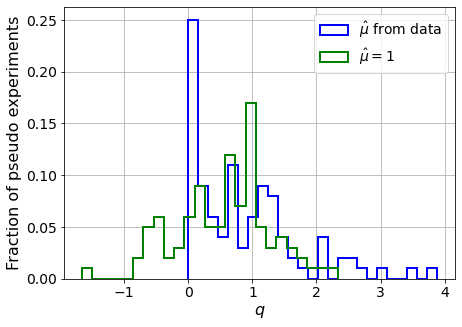

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  8605.52871851  8354.25612698
  8039.75742189  7655.66007466  7180.32954184  6601.72222713
  5907.23169815  5082.28795555  4116.4475424   2956.63100123
  1604.2423974     44.95891778 -1662.43315465 -3817.69869006]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf 10599.30289896 10513.65319706 10328.47928692


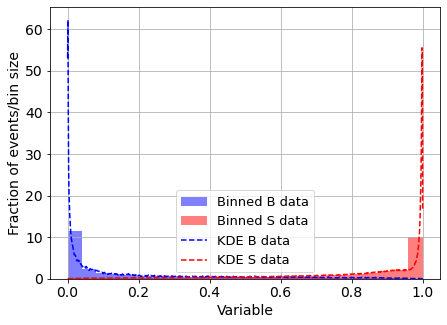

KDE Kernel:  epanechnikov
Background bandwidth:  0.0019008479046983867
Signal bandwidth:  0.0011635618505359071
This may take a while...
1 done
2 done
3 done
4 done


  0%|                                                                           | 0/2000 [00:00<?, ?it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19890030574760767
<p_{s}(Sdata)> = 5.943158379092893
<p_{b}(Bdata)> = 13.421876778039092
<p_{s}(Bdata)> = 0.25468148344156827


  0%|▏                                                                  | 6/2000 [00:01<08:49,  3.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37200392944129784
<p_{s}(Sdata)> = 12.320472892657456
<p_{b}(Bdata)> = 13.619554378814316
<p_{s}(Bdata)> = 0.2551865798886808


  1%|▍                                                                 | 13/2000 [00:02<05:32,  5.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3069404522621986
<p_{s}(Sdata)> = 6.451558750468472
<p_{b}(Bdata)> = 13.536036832125461
<p_{s}(Bdata)> = 0.26010875336047723
muhat = -0.1
<p_{b}(Sdata)> = 0.09586554724545857
<p_{s}(Sdata)> = 21.447613858589023
<p_{b}(Bdata)> = 13.722772318851849
<p_{s}(Bdata)> = 0.25394149465181365


  1%|▍                                                                 | 14/2000 [00:03<05:25,  6.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21696626565339314
<p_{s}(Sdata)> = 3.244893660100309
<p_{b}(Bdata)> = 13.625285037242358
<p_{s}(Bdata)> = 0.2541688102746897


  1%|▋                                                                 | 22/2000 [00:04<05:04,  6.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5110335701278443
<p_{s}(Sdata)> = 11.867187392745912
<p_{b}(Bdata)> = 13.561529802698077
<p_{s}(Bdata)> = 0.2507720660953577
muhat = -0.1
<p_{b}(Sdata)> = 0.2892507552892682
<p_{s}(Sdata)> = 2.257127258316707
<p_{b}(Bdata)> = 13.475041223178108
<p_{s}(Bdata)> = 0.2618105118764318


  1%|▊                                                                 | 23/2000 [00:04<05:50,  5.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27128124692544947
<p_{s}(Sdata)> = 1.7397598637518867
<p_{b}(Bdata)> = 13.561273637224414
<p_{s}(Bdata)> = 0.25309081436604963


  1%|▊                                                                 | 26/2000 [00:05<05:12,  6.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7097654370791615
<p_{s}(Sdata)> = 1.07555340493915
<p_{b}(Bdata)> = 13.4167156099869
<p_{s}(Bdata)> = 0.2619223116580801


  2%|█                                                                 | 31/2000 [00:06<05:27,  6.01it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21484275540227843
<p_{s}(Sdata)> = 21.46807485638131
<p_{b}(Bdata)> = 13.394565453696389
<p_{s}(Bdata)> = 0.2653408132264081


  2%|█▎                                                                | 40/2000 [00:08<05:48,  5.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.201907376494103
<p_{s}(Sdata)> = 8.810250386877879
<p_{b}(Bdata)> = 13.592590300196871
<p_{s}(Bdata)> = 0.2551233411494352
muhat = -0.1
<p_{b}(Sdata)> = 0.24952747160326155
<p_{s}(Sdata)> = 11.70198507451549
<p_{b}(Bdata)> = 13.796668285678418
<p_{s}(Bdata)> = 0.25482043557551876


  2%|█▎                                                                | 41/2000 [00:08<06:59,  4.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19886577632785474
<p_{s}(Sdata)> = 4.140116119465368
<p_{b}(Bdata)> = 13.564896793705216
<p_{s}(Bdata)> = 0.2535145722068407


  2%|█▍                                                                | 43/2000 [00:08<06:03,  5.38it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.32382330944087895
<p_{s}(Sdata)> = 18.860000919003593
<p_{b}(Bdata)> = 13.550844031650978
<p_{s}(Bdata)> = 0.2675190149747232


  2%|█▌                                                                | 48/2000 [00:10<06:59,  4.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2879852016493342
<p_{s}(Sdata)> = 6.274055344545486
<p_{b}(Bdata)> = 13.74755499288648
<p_{s}(Bdata)> = 0.2554797856106292


  3%|█▊                                                                | 55/2000 [00:11<06:39,  4.87it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17721600599438517
<p_{s}(Sdata)> = 28.20359075817231
<p_{b}(Bdata)> = 13.49593072283621
<p_{s}(Bdata)> = 0.26228338081828356
muhat = -0.1
<p_{b}(Sdata)> = 0.3100215763609101
<p_{s}(Sdata)> = 6.064382765259992
<p_{b}(Bdata)> = 13.47441364637594
<p_{s}(Bdata)> = 0.25696489077512785
muhat = -0.1
<p_{b}(Sdata)> = 0.26183289784358876
<p_{s}(Sdata)> = 8.575955702518298
<p_{b}(Bdata)> = 13.573594763530158
<p_{s}(Bdata)> = 0.256597830637582


  4%|██▎                                                               | 71/2000 [00:15<08:36,  3.73it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3046321255376882
<p_{s}(Sdata)> = 12.627995087525868
<p_{b}(Bdata)> = 13.419742966684527
<p_{s}(Bdata)> = 0.2676344998279172


  4%|██▍                                                               | 74/2000 [00:16<07:46,  4.13it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22235424906464232
<p_{s}(Sdata)> = 18.2666645491838
<p_{b}(Bdata)> = 13.438613335537788
<p_{s}(Bdata)> = 0.2654146369453043


  4%|██▌                                                               | 77/2000 [00:16<06:39,  4.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24406373011638882
<p_{s}(Sdata)> = 4.995465558430012
<p_{b}(Bdata)> = 13.458664282567373
<p_{s}(Bdata)> = 0.2597706452525782


  4%|██▋                                                               | 82/2000 [00:17<05:17,  6.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1482786629823899
<p_{s}(Sdata)> = 19.27949527801602
<p_{b}(Bdata)> = 13.702480966201108
<p_{s}(Bdata)> = 0.2642867608041429


  4%|██▉                                                               | 89/2000 [00:19<05:13,  6.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26719692582862997
<p_{s}(Sdata)> = 6.887461386150432
<p_{b}(Bdata)> = 13.581922032206434
<p_{s}(Bdata)> = 0.24988823212295025


  5%|███▎                                                             | 101/2000 [00:22<09:09,  3.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7038855217586438
<p_{s}(Sdata)> = 9.515969667731756
<p_{b}(Bdata)> = 13.68280061775713
<p_{s}(Bdata)> = 0.2557428308877062


  6%|███▋                                                             | 112/2000 [00:24<05:19,  5.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.374851884443625
<p_{s}(Sdata)> = 4.014324263799947
<p_{b}(Bdata)> = 13.707925699914245
<p_{s}(Bdata)> = 0.2588489117232386


  6%|███▉                                                             | 120/2000 [00:26<05:35,  5.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2538473702010672
<p_{s}(Sdata)> = 6.50259833329823
<p_{b}(Bdata)> = 13.555264104965142
<p_{s}(Bdata)> = 0.25967612286652025
muhat = -0.1
<p_{b}(Sdata)> = 0.2962664076810643
<p_{s}(Sdata)> = 6.4116110883920445
<p_{b}(Bdata)> = 13.535300247799253
<p_{s}(Bdata)> = 0.25771093012562796
muhat = -0.1
<p_{b}(Sdata)> = 0.18819275581453954
<p_{s}(Sdata)> = 3.3932133859518943
<p_{b}(Bdata)> = 13.762254624783555
<p_{s}(Bdata)> = 0.251599551974916


  6%|████                                                             | 125/2000 [00:27<05:40,  5.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2899702199036249
<p_{s}(Sdata)> = 6.279767709961045
<p_{b}(Bdata)> = 13.491956918947356
<p_{s}(Bdata)> = 0.25743876798574306


  7%|████▎                                                            | 133/2000 [00:29<07:22,  4.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7320612944956241
<p_{s}(Sdata)> = 0.5318111418019265
<p_{b}(Bdata)> = 13.550535963543213
<p_{s}(Bdata)> = 0.25404168760956997


  7%|████▍                                                            | 136/2000 [00:29<05:32,  5.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.8029534746406668
<p_{s}(Sdata)> = 10.949316512498351
<p_{b}(Bdata)> = 13.38618463871438
<p_{s}(Bdata)> = 0.25534232724486405


  7%|████▍                                                            | 137/2000 [00:30<05:35,  5.55it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18539762200756688
<p_{s}(Sdata)> = 17.756840918463165
<p_{b}(Bdata)> = 13.509690002381541
<p_{s}(Bdata)> = 0.2707621487939265


  7%|████▊                                                            | 148/2000 [00:32<05:34,  5.54it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.10715358598009117
<p_{s}(Sdata)> = 22.477665512166194
<p_{b}(Bdata)> = 13.656308983782997
<p_{s}(Bdata)> = 0.26344530365012303


  8%|████▉                                                            | 153/2000 [00:33<07:26,  4.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2586597125117549
<p_{s}(Sdata)> = 14.772187045303228
<p_{b}(Bdata)> = 13.652177581091921
<p_{s}(Bdata)> = 0.2501360729945601


  8%|█████                                                            | 157/2000 [00:34<05:21,  5.72it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15976210945065064
<p_{s}(Sdata)> = 17.707723752070372
<p_{b}(Bdata)> = 13.381906417584663
<p_{s}(Bdata)> = 0.277888322124527
muhat = 2.1
<p_{b}(Sdata)> = 0.09791562297510628
<p_{s}(Sdata)> = 28.758585264860667
<p_{b}(Bdata)> = 13.543122136910293
<p_{s}(Bdata)> = 0.2582218292555078


  8%|█████▏                                                           | 159/2000 [00:34<06:15,  4.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2725912910816994
<p_{s}(Sdata)> = 2.05565491784934
<p_{b}(Bdata)> = 13.508335048953018
<p_{s}(Bdata)> = 0.25573798310036366


  8%|█████▎                                                           | 163/2000 [00:35<06:51,  4.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18650769494367242
<p_{s}(Sdata)> = 5.315245965046842
<p_{b}(Bdata)> = 13.554292360060733
<p_{s}(Bdata)> = 0.25670704234688585


  9%|█████▌                                                           | 171/2000 [00:37<06:15,  4.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25220049850329646
<p_{s}(Sdata)> = 14.052858178079967
<p_{b}(Bdata)> = 13.462949276229821
<p_{s}(Bdata)> = 0.25186304582382696
muhat = 2.1
<p_{b}(Sdata)> = 0.30882453111916763
<p_{s}(Sdata)> = 16.731063603411485
<p_{b}(Bdata)> = 13.326252121822378
<p_{s}(Bdata)> = 0.2630935647952395


  9%|█████▋                                                           | 176/2000 [00:39<07:56,  3.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2919144824929606
<p_{s}(Sdata)> = 7.181811132855993
<p_{b}(Bdata)> = 13.474320801918262
<p_{s}(Bdata)> = 0.25690675083421555


  9%|█████▊                                                           | 180/2000 [00:39<05:12,  5.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6757878416964938
<p_{s}(Sdata)> = 8.39780649285824
<p_{b}(Bdata)> = 13.561397295176928
<p_{s}(Bdata)> = 0.25427612891275697


  9%|██████                                                           | 187/2000 [00:41<07:10,  4.21it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.30591443417577224
<p_{s}(Sdata)> = 14.844725834837826
<p_{b}(Bdata)> = 13.464447264467841
<p_{s}(Bdata)> = 0.26473061110038043


 10%|██████▏                                                          | 192/2000 [00:42<06:26,  4.68it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.199657004780963
<p_{s}(Sdata)> = 4.433795758441521
<p_{b}(Bdata)> = 13.573600528721943
<p_{s}(Bdata)> = 0.2730946743835976


 10%|██████▎                                                          | 195/2000 [00:43<07:47,  3.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17471503877015973
<p_{s}(Sdata)> = 10.159253780892236
<p_{b}(Bdata)> = 13.681319673697333
<p_{s}(Bdata)> = 0.2566922904353396


 10%|██████▊                                                          | 209/2000 [00:46<08:54,  3.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28895399484136447
<p_{s}(Sdata)> = 5.131756353884168
<p_{b}(Bdata)> = 13.355955413015959
<p_{s}(Bdata)> = 0.2618580939003394


 11%|██████▉                                                          | 213/2000 [00:47<05:53,  5.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34155831646123175
<p_{s}(Sdata)> = 6.2868064536887625
<p_{b}(Bdata)> = 13.309875950920626
<p_{s}(Bdata)> = 0.2527623342568113
muhat = 2.1
<p_{b}(Sdata)> = 0.29503943728920795
<p_{s}(Sdata)> = 21.356196779831404
<p_{b}(Bdata)> = 13.258039860088921
<p_{s}(Bdata)> = 0.2647525585847836


 11%|███████                                                          | 216/2000 [00:47<06:40,  4.45it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17639984045019427
<p_{s}(Sdata)> = 24.813899458189415
<p_{b}(Bdata)> = 13.452830861762937
<p_{s}(Bdata)> = 0.2640452681141179


 11%|███████▏                                                         | 222/2000 [00:49<07:50,  3.78it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1824237980118526
<p_{s}(Sdata)> = 18.46047370904601
<p_{b}(Bdata)> = 13.489651748647441
<p_{s}(Bdata)> = 0.26581438390854


 12%|███████▌                                                         | 232/2000 [00:51<05:28,  5.39it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1664669986125132
<p_{s}(Sdata)> = 9.722517077809297
<p_{b}(Bdata)> = 13.50753249314124
<p_{s}(Bdata)> = 0.270106823869426


 12%|███████▋                                                         | 235/2000 [00:52<06:10,  4.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3256414739690976
<p_{s}(Sdata)> = 4.176485511349475
<p_{b}(Bdata)> = 13.617132970866713
<p_{s}(Bdata)> = 0.25219090752901774


 13%|████████▏                                                        | 253/2000 [00:56<05:07,  5.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35299467777396726
<p_{s}(Sdata)> = 10.186366440911735
<p_{b}(Bdata)> = 13.587235395052012
<p_{s}(Bdata)> = 0.25541446885746555


 13%|████████▎                                                        | 256/2000 [00:57<07:03,  4.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.842608586103285
<p_{s}(Sdata)> = 6.301935959254957
<p_{b}(Bdata)> = 13.675033867320758
<p_{s}(Bdata)> = 0.25310248192006246


 13%|████████▋                                                        | 267/2000 [00:59<07:44,  3.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3237584234257419
<p_{s}(Sdata)> = 4.495390560760158
<p_{b}(Bdata)> = 13.829192692971674
<p_{s}(Bdata)> = 0.25144852840226073


 14%|████████▊                                                        | 273/2000 [01:00<05:10,  5.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3595581173944714
<p_{s}(Sdata)> = 1.025586985702924
<p_{b}(Bdata)> = 13.681867011069212
<p_{s}(Bdata)> = 0.25950423677818724
muhat = -0.1
<p_{b}(Sdata)> = 0.2144884406822171
<p_{s}(Sdata)> = 9.48467362761919
<p_{b}(Bdata)> = 13.503396615850516
<p_{s}(Bdata)> = 0.25673278514408243


 14%|████████▉                                                        | 274/2000 [01:01<05:11,  5.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.209359121613863
<p_{s}(Sdata)> = 2.199367133134512
<p_{b}(Bdata)> = 13.766560823236242
<p_{s}(Bdata)> = 0.25877740436954827


 14%|█████████                                                        | 277/2000 [01:01<04:54,  5.86it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.11254477340315638
<p_{s}(Sdata)> = 17.57040923382972
<p_{b}(Bdata)> = 13.45578460522231
<p_{s}(Bdata)> = 0.2667381246403035


 14%|█████████▏                                                       | 282/2000 [01:02<05:03,  5.67it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17403462783555776
<p_{s}(Sdata)> = 21.446388090890522
<p_{b}(Bdata)> = 13.492350754866766
<p_{s}(Bdata)> = 0.2695529169683085


 14%|█████████▎                                                       | 286/2000 [01:03<06:05,  4.69it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19672285285566238
<p_{s}(Sdata)> = 19.625563987709118
<p_{b}(Bdata)> = 13.485138294173431
<p_{s}(Bdata)> = 0.2691663204401589


 15%|█████████▍                                                       | 291/2000 [01:04<04:33,  6.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1882110870509293
<p_{s}(Sdata)> = 10.239709590356473
<p_{b}(Bdata)> = 13.436571382768546
<p_{s}(Bdata)> = 0.2562575843115097
muhat = -0.1
<p_{b}(Sdata)> = 0.3213930502917963
<p_{s}(Sdata)> = 4.101567223376419
<p_{b}(Bdata)> = 13.405287167222127
<p_{s}(Bdata)> = 0.2563858427079308


 15%|█████████▌                                                       | 294/2000 [01:04<03:26,  8.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2653412707836502
<p_{s}(Sdata)> = 9.195043691427024
<p_{b}(Bdata)> = 13.585913035168984
<p_{s}(Bdata)> = 0.25648276390631786
muhat = -0.1
<p_{b}(Sdata)> = 0.16271679072008555
<p_{s}(Sdata)> = 13.894787286729002
<p_{b}(Bdata)> = 13.511749336855551
<p_{s}(Bdata)> = 0.2531489958315835


 15%|█████████▋                                                       | 298/2000 [01:05<06:45,  4.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39636463535585686
<p_{s}(Sdata)> = 4.674942651095174
<p_{b}(Bdata)> = 13.538419451191476
<p_{s}(Bdata)> = 0.2539958509752205


 15%|█████████▊                                                       | 302/2000 [01:06<06:23,  4.43it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1560467994042623
<p_{s}(Sdata)> = 17.69058874737718
<p_{b}(Bdata)> = 13.433330719321857
<p_{s}(Bdata)> = 0.271593337329351


 16%|██████████▏                                                      | 314/2000 [01:08<05:27,  5.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.511052098160145
<p_{s}(Sdata)> = 6.653600879260336
<p_{b}(Bdata)> = 13.436794136620684
<p_{s}(Bdata)> = 0.2562482442394689


 16%|██████████▋                                                      | 329/2000 [01:12<06:08,  4.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1954061412203439
<p_{s}(Sdata)> = 6.149847809929948
<p_{b}(Bdata)> = 13.52544709264682
<p_{s}(Bdata)> = 0.25675707354345473


 17%|██████████▊                                                      | 332/2000 [01:13<05:38,  4.93it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23322852543478062
<p_{s}(Sdata)> = 25.964782902249034
<p_{b}(Bdata)> = 13.518152152319532
<p_{s}(Bdata)> = 0.2766790074501581


 17%|██████████▉                                                      | 335/2000 [01:14<06:41,  4.15it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.26919024593899754
<p_{s}(Sdata)> = 15.065712685507368
<p_{b}(Bdata)> = 13.761110169387551
<p_{s}(Bdata)> = 0.2681873944999349


 17%|███████████▎                                                     | 349/2000 [01:18<06:49,  4.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3208259047589085
<p_{s}(Sdata)> = 4.790070795246095
<p_{b}(Bdata)> = 13.700699546202914
<p_{s}(Bdata)> = 0.2575491962174205


 18%|███████████▍                                                     | 353/2000 [01:18<04:49,  5.69it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.10003768130761694
<p_{s}(Sdata)> = 24.535345930119135
<p_{b}(Bdata)> = 13.68055718272615
<p_{s}(Bdata)> = 0.26257026668492084


 18%|███████████▌                                                     | 354/2000 [01:19<06:06,  4.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7274373270071359
<p_{s}(Sdata)> = 0.7898968604822934
<p_{b}(Bdata)> = 13.374433160417794
<p_{s}(Bdata)> = 0.2624519440273968


 18%|███████████▋                                                     | 358/2000 [01:19<04:26,  6.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16744612286679184
<p_{s}(Sdata)> = 13.867213120621008
<p_{b}(Bdata)> = 13.25357118660538
<p_{s}(Bdata)> = 0.2581090902003929
muhat = -0.1
<p_{b}(Sdata)> = 0.3186401332850331
<p_{s}(Sdata)> = 4.232490401774412
<p_{b}(Bdata)> = 13.324884069544236
<p_{s}(Bdata)> = 0.2602568156789583
muhat = -0.1
<p_{b}(Sdata)> = 0.3924345300538027
<p_{s}(Sdata)> = 3.0764389704025557
<p_{b}(Bdata)> = 13.730693006655878
<p_{s}(Bdata)> = 0.25555453958112984


 18%|███████████▊                                                     | 364/2000 [01:21<06:33,  4.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19445985793314335
<p_{s}(Sdata)> = 5.06270730506474
<p_{b}(Bdata)> = 13.398487528509628
<p_{s}(Bdata)> = 0.2582164429369126


 19%|████████████▏                                                    | 375/2000 [01:23<08:00,  3.38it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3761043821691249
<p_{s}(Sdata)> = 20.466182919042343
<p_{b}(Bdata)> = 13.611326607321006
<p_{s}(Bdata)> = 0.2643567784110956


 19%|████████████▍                                                    | 381/2000 [01:25<05:43,  4.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1664588437761761
<p_{s}(Sdata)> = 19.2886819180636
<p_{b}(Bdata)> = 13.364351686773208
<p_{s}(Bdata)> = 0.253224656986884


 19%|████████████▌                                                    | 387/2000 [01:26<07:44,  3.48it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.27948601878961415
<p_{s}(Sdata)> = 8.975911893774109
<p_{b}(Bdata)> = 13.482907676523736
<p_{s}(Bdata)> = 0.27250966068795773


 20%|████████████▋                                                    | 390/2000 [01:27<06:30,  4.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3542824448398115
<p_{s}(Sdata)> = 7.088686136600233
<p_{b}(Bdata)> = 13.321871190474923
<p_{s}(Bdata)> = 0.2576560420119827


 20%|████████████▊                                                    | 394/2000 [01:27<04:00,  6.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17679319551168476
<p_{s}(Sdata)> = 12.664283195471242
<p_{b}(Bdata)> = 13.389357514984916
<p_{s}(Bdata)> = 0.25755760516829407
muhat = -0.1
<p_{b}(Sdata)> = 0.21430902382162245
<p_{s}(Sdata)> = 10.272151145022606
<p_{b}(Bdata)> = 13.532800845029199
<p_{s}(Bdata)> = 0.2572423793696552


 20%|████████████▊                                                    | 395/2000 [01:28<04:08,  6.46it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.09720979757655944
<p_{s}(Sdata)> = 26.075917896902812
<p_{b}(Bdata)> = 13.421479894381799
<p_{s}(Bdata)> = 0.2633459668377844


 20%|████████████▉                                                    | 397/2000 [01:28<04:46,  5.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16462455957443184
<p_{s}(Sdata)> = 10.134397872556576
<p_{b}(Bdata)> = 13.289914537994823
<p_{s}(Bdata)> = 0.253874903383008


 20%|█████████████▏                                                   | 405/2000 [01:29<03:46,  7.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42444312606644263
<p_{s}(Sdata)> = 0.9526310853899776
<p_{b}(Bdata)> = 13.702846108422108
<p_{s}(Bdata)> = 0.25865467950574644
muhat = -0.1
<p_{b}(Sdata)> = 0.12552648940316904
<p_{s}(Sdata)> = 17.36026363227637
<p_{b}(Bdata)> = 13.434546856646131
<p_{s}(Bdata)> = 0.25823031598817225
muhat = -0.1
<p_{b}(Sdata)> = 0.24767006094270239
<p_{s}(Sdata)> = 4.189806371127874
<p_{b}(Bdata)> = 13.543930838110407
<p_{s}(Bdata)> = 0.261842441491654
muhat = -0.1
<p_{b}(Sdata)> = 0.2334159993924832
<p_{s}(Sdata)> = 6.638060534637941
<p_{b}(Bdata)> = 13.381710570450322
<p_{s}(Bdata)> = 0.25993031092779323


 20%|█████████████▎                                                   | 408/2000 [01:30<05:55,  4.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24687107437932285
<p_{s}(Sdata)> = 8.670945250015523
<p_{b}(Bdata)> = 13.531729048209645
<p_{s}(Bdata)> = 0.25406153551231225


 21%|█████████████▍                                                   | 414/2000 [01:31<03:47,  6.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7105276567386798
<p_{s}(Sdata)> = 15.282946659684285
<p_{b}(Bdata)> = 13.3435853069731
<p_{s}(Bdata)> = 0.25811808680817133
muhat = -0.1
<p_{b}(Sdata)> = 0.46077116084834513
<p_{s}(Sdata)> = 2.039353613482436
<p_{b}(Bdata)> = 13.489242127135377
<p_{s}(Bdata)> = 0.2623025756623015


 21%|█████████████▍                                                   | 415/2000 [01:31<04:35,  5.76it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16943190039877806
<p_{s}(Sdata)> = 12.716288735710565
<p_{b}(Bdata)> = 13.443771199189134
<p_{s}(Bdata)> = 0.2714401066112239


 21%|█████████████▋                                                   | 420/2000 [01:32<03:49,  6.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17550754941742638
<p_{s}(Sdata)> = 8.0162533555399
<p_{b}(Bdata)> = 13.617822682565304
<p_{s}(Bdata)> = 0.26324771591301144


 21%|█████████████▋                                                   | 423/2000 [01:33<03:56,  6.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.503473873083643
<p_{s}(Sdata)> = 9.905640067614652
<p_{b}(Bdata)> = 13.631366841632163
<p_{s}(Bdata)> = 0.252942232569697
muhat = -0.1
<p_{b}(Sdata)> = 0.28405198991134295
<p_{s}(Sdata)> = 3.06187266063401
<p_{b}(Bdata)> = 13.79593222544282
<p_{s}(Bdata)> = 0.2512828674100611


 22%|██████████████                                                   | 431/2000 [01:34<03:49,  6.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23095056837392092
<p_{s}(Sdata)> = 5.798774533613767
<p_{b}(Bdata)> = 13.520873264301674
<p_{s}(Bdata)> = 0.26027410265708567
muhat = 2.1
<p_{b}(Sdata)> = 0.10810035037319489
<p_{s}(Sdata)> = 24.064985323465347
<p_{b}(Bdata)> = 13.76229302841139
<p_{s}(Bdata)> = 0.2611270488287771


 22%|██████████████▎                                                  | 440/2000 [01:36<04:32,  5.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3134908434706459
<p_{s}(Sdata)> = 7.17386754415847
<p_{b}(Bdata)> = 13.426341972938252
<p_{s}(Bdata)> = 0.25974191753872294
muhat = -0.1
<p_{b}(Sdata)> = 0.1991939999210434
<p_{s}(Sdata)> = 2.7753538340608004
<p_{b}(Bdata)> = 13.491630443603137
<p_{s}(Bdata)> = 0.2552803282146821


 22%|██████████████▍                                                  | 443/2000 [01:37<05:22,  4.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1838363150062964
<p_{s}(Sdata)> = 12.712529151249548
<p_{b}(Bdata)> = 13.617589236588914
<p_{s}(Bdata)> = 0.25402832924387564


 22%|██████████████▌                                                  | 447/2000 [01:38<03:53,  6.65it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21450860486874426
<p_{s}(Sdata)> = 13.680049468036328
<p_{b}(Bdata)> = 13.299958430816679
<p_{s}(Bdata)> = 0.2724869063349975
muhat = -0.1
<p_{b}(Sdata)> = 0.2977942577152684
<p_{s}(Sdata)> = 6.014087645627391
<p_{b}(Bdata)> = 13.372896791961132
<p_{s}(Bdata)> = 0.2606596838489577


 23%|██████████████▋                                                  | 452/2000 [01:39<04:09,  6.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22425688271266506
<p_{s}(Sdata)> = 7.324966452841257
<p_{b}(Bdata)> = 13.785176666775348
<p_{s}(Bdata)> = 0.2573309358026326
muhat = 2.1
<p_{b}(Sdata)> = 0.26891042457459513
<p_{s}(Sdata)> = 17.734946571956616
<p_{b}(Bdata)> = 13.434908863293021
<p_{s}(Bdata)> = 0.2697897507342432


 23%|██████████████▋                                                  | 453/2000 [01:39<04:54,  5.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33064584072896913
<p_{s}(Sdata)> = 9.126152475138815
<p_{b}(Bdata)> = 13.654710025031982
<p_{s}(Bdata)> = 0.2541566756073413


 23%|███████████████                                                  | 462/2000 [01:41<07:10,  3.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20631867550636732
<p_{s}(Sdata)> = 13.87065644616918
<p_{b}(Bdata)> = 13.486069301559075
<p_{s}(Bdata)> = 0.25338520470776443


 23%|███████████████▏                                                 | 467/2000 [01:42<05:10,  4.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3071504543776664
<p_{s}(Sdata)> = 2.1847923972523606
<p_{b}(Bdata)> = 13.371557564539058
<p_{s}(Bdata)> = 0.2632602771251807
muhat = -0.1
<p_{b}(Sdata)> = 0.31374061507489376
<p_{s}(Sdata)> = 2.758859122518894
<p_{b}(Bdata)> = 13.526153574224368
<p_{s}(Bdata)> = 0.2508827326891204


 24%|███████████████▎                                                 | 471/2000 [01:43<04:24,  5.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16315144525160824
<p_{s}(Sdata)> = 11.742274636340888
<p_{b}(Bdata)> = 13.490987188467873
<p_{s}(Bdata)> = 0.2553824464033838


 24%|███████████████▍                                                 | 476/2000 [01:44<06:42,  3.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46631340101774627
<p_{s}(Sdata)> = 10.493214892897411
<p_{b}(Bdata)> = 13.351975276389314
<p_{s}(Bdata)> = 0.2558178760055145


 24%|███████████████▌                                                 | 480/2000 [01:45<07:17,  3.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6171468577444179
<p_{s}(Sdata)> = 5.781897307636605
<p_{b}(Bdata)> = 13.565427377439725
<p_{s}(Bdata)> = 0.25314558170677354


 24%|███████████████▋                                                 | 483/2000 [01:46<06:15,  4.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30614017260271525
<p_{s}(Sdata)> = 7.55078962920506
<p_{b}(Bdata)> = 13.582647544594732
<p_{s}(Bdata)> = 0.2563998076153106


 25%|████████████████▎                                                | 501/2000 [01:51<06:22,  3.92it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21776913311352042
<p_{s}(Sdata)> = 22.80497849211671
<p_{b}(Bdata)> = 13.517865743907347
<p_{s}(Bdata)> = 0.2627018349904905


 26%|████████████████▌                                                | 511/2000 [01:53<06:33,  3.78it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19860198001204243
<p_{s}(Sdata)> = 13.812050723881741
<p_{b}(Bdata)> = 13.587004223377786
<p_{s}(Bdata)> = 0.27199635473134814


 26%|████████████████▋                                                | 513/2000 [01:54<05:46,  4.29it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21341087327096125
<p_{s}(Sdata)> = 20.58146188118332
<p_{b}(Bdata)> = 13.53813148655693
<p_{s}(Bdata)> = 0.262523361435


 26%|████████████████▊                                                | 519/2000 [01:55<03:35,  6.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3695741593791019
<p_{s}(Sdata)> = 7.984016571376959
<p_{b}(Bdata)> = 13.471960291781143
<p_{s}(Bdata)> = 0.2560291673098153


 26%|████████████████▉                                                | 523/2000 [01:56<04:17,  5.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2524360692175372
<p_{s}(Sdata)> = 8.262657992235498
<p_{b}(Bdata)> = 13.620068152988026
<p_{s}(Bdata)> = 0.2610755377601029
muhat = -0.1
<p_{b}(Sdata)> = 0.30193679912175553
<p_{s}(Sdata)> = 2.870158204498591
<p_{b}(Bdata)> = 13.542266302417708
<p_{s}(Bdata)> = 0.25708727297121803


 26%|█████████████████▏                                               | 530/2000 [01:57<04:12,  5.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.9332158421581958
<p_{s}(Sdata)> = 6.473708535494107
<p_{b}(Bdata)> = 13.566313407889599
<p_{s}(Bdata)> = 0.25957297304824106
muhat = -0.1
<p_{b}(Sdata)> = 0.7820260120887693
<p_{s}(Sdata)> = 0.8772127655407971
<p_{b}(Bdata)> = 13.596487961202264
<p_{s}(Bdata)> = 0.2546861467026938


 27%|█████████████████▎                                               | 533/2000 [01:58<04:58,  4.92it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3367877607248119
<p_{s}(Sdata)> = 13.05141959064273
<p_{b}(Bdata)> = 13.430937802761191
<p_{s}(Bdata)> = 0.2694176442593944


 27%|█████████████████▍                                               | 535/2000 [01:58<04:59,  4.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4868202007662841
<p_{s}(Sdata)> = 4.616679293586632
<p_{b}(Bdata)> = 13.656749817972404
<p_{s}(Bdata)> = 0.2586772124134364


 27%|█████████████████▌                                               | 541/2000 [01:59<04:59,  4.88it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.28945347340569494
<p_{s}(Sdata)> = 18.47008384505605
<p_{b}(Bdata)> = 13.56219967819238
<p_{s}(Bdata)> = 0.2701056535212005


 27%|█████████████████▋                                               | 546/2000 [02:00<04:10,  5.80it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1639237008597258
<p_{s}(Sdata)> = 19.121685398479897
<p_{b}(Bdata)> = 13.427347476166249
<p_{s}(Bdata)> = 0.26840207220518675
muhat = 2.1
<p_{b}(Sdata)> = 0.21752941973370263
<p_{s}(Sdata)> = 11.806697693895195
<p_{b}(Bdata)> = 13.520860725099785
<p_{s}(Bdata)> = 0.27007094895146516


 28%|██████████████████▏                                              | 558/2000 [02:04<05:21,  4.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27479735116546994
<p_{s}(Sdata)> = 2.25294788202546
<p_{b}(Bdata)> = 13.43227157036958
<p_{s}(Bdata)> = 0.25559795627810766


 28%|██████████████████▎                                              | 563/2000 [02:05<06:47,  3.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23328653030566004
<p_{s}(Sdata)> = 11.52772592910697
<p_{b}(Bdata)> = 13.38556966584866
<p_{s}(Bdata)> = 0.2514552502149108


 28%|██████████████████▍                                              | 568/2000 [02:06<05:46,  4.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16726028043991478
<p_{s}(Sdata)> = 11.722402259155086
<p_{b}(Bdata)> = 13.56958648571298
<p_{s}(Bdata)> = 0.26549512696732447


 28%|██████████████████▌                                              | 570/2000 [02:06<04:48,  4.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15525440022668113
<p_{s}(Sdata)> = 12.050313204479968
<p_{b}(Bdata)> = 13.484146920711778
<p_{s}(Bdata)> = 0.25648815463135


 29%|██████████████████▋                                              | 574/2000 [02:07<05:09,  4.61it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2862823648562507
<p_{s}(Sdata)> = 9.985870822686525
<p_{b}(Bdata)> = 13.422354836767681
<p_{s}(Bdata)> = 0.27312554718241855


 29%|██████████████████▊                                              | 580/2000 [02:09<05:44,  4.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38408032566268396
<p_{s}(Sdata)> = 6.07044596722071
<p_{b}(Bdata)> = 13.596476816563873
<p_{s}(Bdata)> = 0.2609950019854516


 29%|███████████████████▏                                             | 589/2000 [02:11<07:03,  3.34it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1709232326437328
<p_{s}(Sdata)> = 21.407077104514723
<p_{b}(Bdata)> = 13.503993848113273
<p_{s}(Bdata)> = 0.26156148832745896


 30%|███████████████████▎                                             | 593/2000 [02:12<04:10,  5.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21063715898121102
<p_{s}(Sdata)> = 6.260298372658216
<p_{b}(Bdata)> = 13.654429520727618
<p_{s}(Bdata)> = 0.2553646874344761
muhat = -0.1
<p_{b}(Sdata)> = 0.2826242368554999
<p_{s}(Sdata)> = 8.884258942174158
<p_{b}(Bdata)> = 13.529037944821757
<p_{s}(Bdata)> = 0.257565396323387


 30%|███████████████████▍                                             | 597/2000 [02:13<04:52,  4.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30645814766352775
<p_{s}(Sdata)> = 9.274052755837456
<p_{b}(Bdata)> = 13.651866927726894
<p_{s}(Bdata)> = 0.25447932511329235


 30%|███████████████████▋                                             | 604/2000 [02:14<04:49,  4.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24682943169199462
<p_{s}(Sdata)> = 2.925587402806906
<p_{b}(Bdata)> = 13.522392940200078
<p_{s}(Bdata)> = 0.26086064082856486


 30%|███████████████████▋                                             | 607/2000 [02:15<04:57,  4.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2866728793812206
<p_{s}(Sdata)> = 8.956621916887679
<p_{b}(Bdata)> = 13.562354976590766
<p_{s}(Bdata)> = 0.2530483484584573


 31%|████████████████████                                             | 616/2000 [02:17<05:55,  3.89it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20242842136964392
<p_{s}(Sdata)> = 13.917883513610803
<p_{b}(Bdata)> = 13.540931290599694
<p_{s}(Bdata)> = 0.2673286650574595


 32%|████████████████████▌                                            | 633/2000 [02:21<03:23,  6.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3013405541541249
<p_{s}(Sdata)> = 6.279967662052659
<p_{b}(Bdata)> = 13.730155130164015
<p_{s}(Bdata)> = 0.2581296156303217
muhat = 2.1
<p_{b}(Sdata)> = 0.20923004018149088
<p_{s}(Sdata)> = 11.951394367225536
<p_{b}(Bdata)> = 13.522571099603251
<p_{s}(Bdata)> = 0.2697814644286946


 32%|████████████████████▋                                            | 635/2000 [02:22<06:03,  3.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.239276496031087
<p_{s}(Sdata)> = 6.439802475349558
<p_{b}(Bdata)> = 13.45153027142355
<p_{s}(Bdata)> = 0.2546082608363048


 32%|████████████████████▊                                            | 641/2000 [02:23<04:26,  5.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22466822105567855
<p_{s}(Sdata)> = 4.285605019770846
<p_{b}(Bdata)> = 13.80167862275833
<p_{s}(Bdata)> = 0.24792852433001614


 32%|████████████████████▊                                            | 642/2000 [02:24<05:46,  3.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21791782190796327
<p_{s}(Sdata)> = 10.204612798207316
<p_{b}(Bdata)> = 13.652959142164146
<p_{s}(Bdata)> = 0.2616209379343752


 32%|█████████████████████                                            | 649/2000 [02:25<04:05,  5.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1708967816285519
<p_{s}(Sdata)> = 6.635624806284736
<p_{b}(Bdata)> = 13.609045747549024
<p_{s}(Bdata)> = 0.25712639806897497
muhat = -0.1
<p_{b}(Sdata)> = 0.25888469492301514
<p_{s}(Sdata)> = 8.443161183244962
<p_{b}(Bdata)> = 13.738093464503123
<p_{s}(Bdata)> = 0.25352767316878644
muhat = -0.1
<p_{b}(Sdata)> = 0.2549216669013484
<p_{s}(Sdata)> = 12.897340162990346
<p_{b}(Bdata)> = 13.435839766133064
<p_{s}(Bdata)> = 0.2545467410556915


 33%|█████████████████████▏                                           | 653/2000 [02:26<03:52,  5.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3085198089456183
<p_{s}(Sdata)> = 12.067901058321288
<p_{b}(Bdata)> = 13.70158804567009
<p_{s}(Bdata)> = 0.2587247750608239


 34%|█████████████████████▊                                           | 670/2000 [02:30<06:32,  3.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24231562157466974
<p_{s}(Sdata)> = 8.189606338636722
<p_{b}(Bdata)> = 13.635877739193413
<p_{s}(Bdata)> = 0.2576954278090354


 34%|█████████████████████▉                                           | 674/2000 [02:31<04:18,  5.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5636241751819914
<p_{s}(Sdata)> = 5.543276388383967
<p_{b}(Bdata)> = 13.788484518486236
<p_{s}(Bdata)> = 0.2549593637466917
muhat = 2.1
<p_{b}(Sdata)> = 0.5973259422931239
<p_{s}(Sdata)> = 23.14315880844994
<p_{b}(Bdata)> = 13.33863485878483
<p_{s}(Bdata)> = 0.26524859717677407
muhat = -0.1
<p_{b}(Sdata)> = 0.21484909809424066
<p_{s}(Sdata)> = 8.816548614813112
<p_{b}(Bdata)> = 13.510951336294644
<p_{s}(Bdata)> = 0.2599228092550509


 34%|██████████████████████▏                                          | 682/2000 [02:32<03:58,  5.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41880772804760513
<p_{s}(Sdata)> = 3.4078064388322655
<p_{b}(Bdata)> = 13.596796820106462
<p_{s}(Bdata)> = 0.2575165616712404


 34%|██████████████████████▎                                          | 686/2000 [02:33<03:40,  5.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.914037542300856
<p_{s}(Sdata)> = 13.25319414484006
<p_{b}(Bdata)> = 13.367468262847307
<p_{s}(Bdata)> = 0.25287709474614606
muhat = -0.1
<p_{b}(Sdata)> = 0.26245807599169835
<p_{s}(Sdata)> = 10.556308787386108
<p_{b}(Bdata)> = 13.522238924114735
<p_{s}(Bdata)> = 0.2579397389326642


 34%|██████████████████████▎                                          | 688/2000 [02:33<02:56,  7.44it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14873871893332055
<p_{s}(Sdata)> = 21.111849144134712
<p_{b}(Bdata)> = 13.407923628491725
<p_{s}(Bdata)> = 0.26472940450106347


 35%|██████████████████████▌                                          | 693/2000 [02:35<05:12,  4.18it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.29238695517792834
<p_{s}(Sdata)> = 1.4170719455464191
<p_{b}(Bdata)> = 13.582025725892716
<p_{s}(Bdata)> = 0.27926351611589945


 35%|██████████████████████▋                                          | 699/2000 [02:36<03:48,  5.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2316826322408768
<p_{s}(Sdata)> = 9.119768982891339
<p_{b}(Bdata)> = 13.55504028390938
<p_{s}(Bdata)> = 0.2570337116883347
muhat = -0.1
<p_{b}(Sdata)> = 0.2945290428584262
<p_{s}(Sdata)> = 1.3310958200732963
<p_{b}(Bdata)> = 13.6722098415116
<p_{s}(Bdata)> = 0.2587018879840161


 35%|██████████████████████▉                                          | 706/2000 [02:38<05:04,  4.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3024795380486415
<p_{s}(Sdata)> = 14.586232417762597
<p_{b}(Bdata)> = 13.713422087567817
<p_{s}(Bdata)> = 0.257214847473504


 36%|███████████████████████▏                                         | 713/2000 [02:39<04:54,  4.37it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.26842933508872996
<p_{s}(Sdata)> = 14.275187996311347
<p_{b}(Bdata)> = 13.368874018164284
<p_{s}(Bdata)> = 0.274213380966916


 36%|███████████████████████▏                                         | 715/2000 [02:40<04:56,  4.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4731974374609312
<p_{s}(Sdata)> = 3.364333617553514
<p_{b}(Bdata)> = 13.515117711234582
<p_{s}(Bdata)> = 0.25899530207985483


 36%|███████████████████████▌                                         | 726/2000 [02:42<06:38,  3.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16328378457110396
<p_{s}(Sdata)> = 6.179735444719601
<p_{b}(Bdata)> = 13.54150849685314
<p_{s}(Bdata)> = 0.2601803973344037


 37%|███████████████████████▉                                         | 736/2000 [02:45<04:24,  4.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42038176150710493
<p_{s}(Sdata)> = 4.979430371186859
<p_{b}(Bdata)> = 13.637140953935829
<p_{s}(Bdata)> = 0.26210802302054614
muhat = -0.1
<p_{b}(Sdata)> = 0.3014444330786856
<p_{s}(Sdata)> = 7.626518368431635
<p_{b}(Bdata)> = 13.472469304212423
<p_{s}(Bdata)> = 0.2568126601740816


 37%|███████████████████████▉                                         | 738/2000 [02:45<04:19,  4.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39383327294574344
<p_{s}(Sdata)> = 3.1785080902738225
<p_{b}(Bdata)> = 13.58503721839353
<p_{s}(Bdata)> = 0.2560781705155194


 37%|████████████████████████▏                                        | 746/2000 [02:47<03:43,  5.61it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20426653883924645
<p_{s}(Sdata)> = 18.925360536861316
<p_{b}(Bdata)> = 13.497312700219052
<p_{s}(Bdata)> = 0.26553902735448537
muhat = -0.1
<p_{b}(Sdata)> = 0.25704086072719157
<p_{s}(Sdata)> = 8.080003541618854
<p_{b}(Bdata)> = 13.579875401284804
<p_{s}(Bdata)> = 0.25593915451985344


 37%|████████████████████████▎                                        | 747/2000 [02:47<04:12,  4.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24310982775463785
<p_{s}(Sdata)> = 9.745676216025785
<p_{b}(Bdata)> = 13.348806063767608
<p_{s}(Bdata)> = 0.2545820460517292


 38%|████████████████████████▍                                        | 752/2000 [02:48<05:44,  3.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39469331481537395
<p_{s}(Sdata)> = 6.902280081161191
<p_{b}(Bdata)> = 13.489376477010529
<p_{s}(Bdata)> = 0.25560658960848676


 38%|████████████████████████▌                                        | 755/2000 [02:49<05:18,  3.91it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21462663175736432
<p_{s}(Sdata)> = 7.928504683019536
<p_{b}(Bdata)> = 13.324798134581242
<p_{s}(Bdata)> = 0.26972781336968193


 38%|████████████████████████▋                                        | 759/2000 [02:50<04:12,  4.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27115552291960554
<p_{s}(Sdata)> = 16.08498388217209
<p_{b}(Bdata)> = 13.384489743931095
<p_{s}(Bdata)> = 0.2545118320221151


 38%|████████████████████████▊                                        | 762/2000 [02:50<03:02,  6.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.14216315222329323
<p_{s}(Sdata)> = 16.28177870578842
<p_{b}(Bdata)> = 13.390754766122544
<p_{s}(Bdata)> = 0.25518139933467554
muhat = -0.1
<p_{b}(Sdata)> = 0.1653593070995552
<p_{s}(Sdata)> = 6.541234028871356
<p_{b}(Bdata)> = 13.59795492050558
<p_{s}(Bdata)> = 0.25293288586693724


 38%|████████████████████████▊                                        | 764/2000 [02:50<02:26,  8.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18366303426633176
<p_{s}(Sdata)> = 10.120743144084742
<p_{b}(Bdata)> = 13.445024577872427
<p_{s}(Bdata)> = 0.2550543301743822
muhat = -0.1
<p_{b}(Sdata)> = 0.27886585964211846
<p_{s}(Sdata)> = 4.5781081119054
<p_{b}(Bdata)> = 13.371781346063477
<p_{s}(Bdata)> = 0.25584571991399213


 38%|████████████████████████▉                                        | 767/2000 [02:50<02:56,  7.00it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2413207875440193
<p_{s}(Sdata)> = 8.804206158267268
<p_{b}(Bdata)> = 13.539584355881102
<p_{s}(Bdata)> = 0.27527212452958466


 39%|█████████████████████████                                        | 772/2000 [02:52<05:39,  3.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27974162821105353
<p_{s}(Sdata)> = 5.468554323015971
<p_{b}(Bdata)> = 13.617077521861003
<p_{s}(Bdata)> = 0.2543500340426638


 39%|█████████████████████████▏                                       | 776/2000 [02:53<05:35,  3.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20067731648935735
<p_{s}(Sdata)> = 5.944611866072622
<p_{b}(Bdata)> = 13.590796305935935
<p_{s}(Bdata)> = 0.2567612352627578


 39%|█████████████████████████▎                                       | 778/2000 [02:53<04:33,  4.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24743528737175702
<p_{s}(Sdata)> = 8.418649011509821
<p_{b}(Bdata)> = 13.513390610909918
<p_{s}(Bdata)> = 0.2593207338715567


 39%|█████████████████████████▎                                       | 780/2000 [02:53<03:56,  5.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17213325434514806
<p_{s}(Sdata)> = 12.767872844342804
<p_{b}(Bdata)> = 13.670874416062302
<p_{s}(Bdata)> = 0.25330515034366113


 39%|█████████████████████████▋                                       | 789/2000 [02:56<05:19,  3.79it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.6226512104546817
<p_{s}(Sdata)> = 17.84243018376919
<p_{b}(Bdata)> = 13.489404017543452
<p_{s}(Bdata)> = 0.26686740245302115


 40%|█████████████████████████▊                                       | 796/2000 [02:57<05:00,  4.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23229441797641215
<p_{s}(Sdata)> = 10.754092834039588
<p_{b}(Bdata)> = 13.43110500196018
<p_{s}(Bdata)> = 0.249877003532295


 40%|██████████████████████████▏                                      | 807/2000 [03:00<04:38,  4.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27005985164926727
<p_{s}(Sdata)> = 6.981008720498541
<p_{b}(Bdata)> = 13.626605599720127
<p_{s}(Bdata)> = 0.252815148044138


 41%|██████████████████████████▎                                      | 811/2000 [03:00<02:49,  7.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.757520330050715
<p_{s}(Sdata)> = 5.09425337743736
<p_{b}(Bdata)> = 13.458941052149969
<p_{s}(Bdata)> = 0.2532631098649022
muhat = -0.1
<p_{b}(Sdata)> = 0.2203718232498521
<p_{s}(Sdata)> = 3.7373841009422555
<p_{b}(Bdata)> = 13.746164549699312
<p_{s}(Bdata)> = 0.25389051411416064


 41%|██████████████████████████▌                                      | 817/2000 [03:02<05:46,  3.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2247489096736669
<p_{s}(Sdata)> = 4.234836106919417
<p_{b}(Bdata)> = 13.319777880118641
<p_{s}(Bdata)> = 0.25646119811568246


 41%|██████████████████████████▋                                      | 820/2000 [03:03<05:11,  3.79it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1892190887931831
<p_{s}(Sdata)> = 13.75431669416859
<p_{b}(Bdata)> = 13.315134045648836
<p_{s}(Bdata)> = 0.27123580873388714


 41%|██████████████████████████▋                                      | 822/2000 [03:03<05:08,  3.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3713001912947791
<p_{s}(Sdata)> = 6.773106332023846
<p_{b}(Bdata)> = 13.546945941140395
<p_{s}(Bdata)> = 0.25427112615904085


 41%|██████████████████████████▊                                      | 826/2000 [03:04<03:51,  5.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25449481949199587
<p_{s}(Sdata)> = 8.879374574354362
<p_{b}(Bdata)> = 13.359856956610045
<p_{s}(Bdata)> = 0.25787449059630263


 41%|██████████████████████████▉                                      | 829/2000 [03:04<02:51,  6.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28102362797188274
<p_{s}(Sdata)> = 3.765397546248056
<p_{b}(Bdata)> = 13.576430636102462
<p_{s}(Bdata)> = 0.2623241151548591
muhat = -0.1
<p_{b}(Sdata)> = 0.3615353140910774
<p_{s}(Sdata)> = 1.0304869605433753
<p_{b}(Bdata)> = 13.602148156624002
<p_{s}(Bdata)> = 0.258379194746716


 42%|███████████████████████████▏                                     | 837/2000 [03:07<05:43,  3.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26997997436667587
<p_{s}(Sdata)> = 3.5467423383837073
<p_{b}(Bdata)> = 13.515382379363126
<p_{s}(Bdata)> = 0.25944413255519455


 42%|███████████████████████████▎                                     | 841/2000 [03:07<03:33,  5.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25980635336445573
<p_{s}(Sdata)> = 4.794241423150706
<p_{b}(Bdata)> = 13.435887707064847
<p_{s}(Bdata)> = 0.2572575177669753
muhat = -0.1
<p_{b}(Sdata)> = 0.6534127531452614
<p_{s}(Sdata)> = 2.295820709883921
<p_{b}(Bdata)> = 13.522439021185365
<p_{s}(Bdata)> = 0.2624530025575177
muhat = -0.1
<p_{b}(Sdata)> = 0.22844334324977253
<p_{s}(Sdata)> = 10.89717415909145
<p_{b}(Bdata)> = 13.425105366909216
<p_{s}(Bdata)> = 0.2541729964652085


 42%|███████████████████████████▍                                     | 844/2000 [03:08<03:42,  5.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17317954053222978
<p_{s}(Sdata)> = 11.368331385794802
<p_{b}(Bdata)> = 13.29621319353446
<p_{s}(Bdata)> = 0.2539374743944906


 42%|███████████████████████████▌                                     | 849/2000 [03:09<03:18,  5.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17922875721592885
<p_{s}(Sdata)> = 5.116472949260763
<p_{b}(Bdata)> = 13.547010408758261
<p_{s}(Bdata)> = 0.25411041441922566
muhat = -0.1
<p_{b}(Sdata)> = 0.2574643800335524
<p_{s}(Sdata)> = 8.558186281090812
<p_{b}(Bdata)> = 13.633643259493505
<p_{s}(Bdata)> = 0.253500710695387
muhat = -0.1
<p_{b}(Sdata)> = 0.24819464147918363
<p_{s}(Sdata)> = 6.621128226518261
<p_{b}(Bdata)> = 13.477549543171063
<p_{s}(Bdata)> = 0.2562136153187983


 43%|███████████████████████████▋                                     | 852/2000 [03:09<03:27,  5.53it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.158197436947504
<p_{s}(Sdata)> = 17.33306557631621
<p_{b}(Bdata)> = 13.372418474484641
<p_{s}(Bdata)> = 0.2657321512080143


 43%|████████████████████████████                                     | 862/2000 [03:11<03:04,  6.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21902142666794067
<p_{s}(Sdata)> = 6.180333466345965
<p_{b}(Bdata)> = 13.546056104714989
<p_{s}(Bdata)> = 0.2622350546388109
muhat = -0.1
<p_{b}(Sdata)> = 0.14429339643196876
<p_{s}(Sdata)> = 7.548650955983119
<p_{b}(Bdata)> = 13.792157310972334
<p_{s}(Bdata)> = 0.24994027477567127


 43%|████████████████████████████▏                                    | 869/2000 [03:13<02:26,  7.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19392624975694794
<p_{s}(Sdata)> = 9.441224340499154
<p_{b}(Bdata)> = 13.428648132230434
<p_{s}(Bdata)> = 0.25266567312835403
muhat = -0.1
<p_{b}(Sdata)> = 0.30245694883781654
<p_{s}(Sdata)> = 4.121417614980022
<p_{b}(Bdata)> = 13.36831472614922
<p_{s}(Bdata)> = 0.2532477388363667


 44%|████████████████████████████▎                                    | 872/2000 [03:13<03:06,  6.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16137221058789558
<p_{s}(Sdata)> = 2.280272947220744
<p_{b}(Bdata)> = 13.651784405522852
<p_{s}(Bdata)> = 0.2621284701138861


 44%|████████████████████████████▍                                    | 874/2000 [03:14<03:00,  6.23it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4113139057368224
<p_{s}(Sdata)> = 17.437896268432237
<p_{b}(Bdata)> = 13.64386397151728
<p_{s}(Bdata)> = 0.2687746446411573


 44%|████████████████████████████▌                                    | 879/2000 [03:15<04:18,  4.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4460678933566503
<p_{s}(Sdata)> = 0.8561501737707886
<p_{b}(Bdata)> = 13.524806644288832
<p_{s}(Bdata)> = 0.25822395417308125


 44%|████████████████████████████▋                                    | 881/2000 [03:15<04:22,  4.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28879039260557454
<p_{s}(Sdata)> = 7.059971041794493
<p_{b}(Bdata)> = 13.376127783812809
<p_{s}(Bdata)> = 0.2567119102465689


 44%|████████████████████████████▋                                    | 884/2000 [03:16<04:58,  3.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18506460958551438
<p_{s}(Sdata)> = 7.358709672494104
<p_{b}(Bdata)> = 13.668683726011682
<p_{s}(Bdata)> = 0.25699738632148583


 44%|████████████████████████████▊                                    | 887/2000 [03:17<04:46,  3.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1915235422726636
<p_{s}(Sdata)> = 6.917318384922042
<p_{b}(Bdata)> = 13.472507715941662
<p_{s}(Bdata)> = 0.2571834019835874


 44%|████████████████████████████▉                                    | 890/2000 [03:18<05:20,  3.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.2486034964244013
<p_{s}(Sdata)> = 8.778581567969711
<p_{b}(Bdata)> = 13.651856725899332
<p_{s}(Bdata)> = 0.25953227273649365


 45%|████████████████████████████▉                                    | 892/2000 [03:18<05:01,  3.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2396811582605201
<p_{s}(Sdata)> = 3.296611362046237
<p_{b}(Bdata)> = 13.574528432958537
<p_{s}(Bdata)> = 0.25927572280085043


 45%|█████████████████████████████                                    | 896/2000 [03:19<03:38,  5.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2201875050675361
<p_{s}(Sdata)> = 4.165536322310329
<p_{b}(Bdata)> = 13.412978528288118
<p_{s}(Bdata)> = 0.25887299211182796


 45%|█████████████████████████████▍                                   | 906/2000 [03:21<03:53,  4.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20288755563346422
<p_{s}(Sdata)> = 11.240862864657526
<p_{b}(Bdata)> = 13.503481919834567
<p_{s}(Bdata)> = 0.2593124411882478


 46%|█████████████████████████████▌                                   | 910/2000 [03:22<04:04,  4.46it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25268817423486456
<p_{s}(Sdata)> = 15.447913382486927
<p_{b}(Bdata)> = 13.641446318029477
<p_{s}(Bdata)> = 0.2673025135565212


 46%|█████████████████████████████▊                                   | 918/2000 [03:23<03:21,  5.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5151158604364316
<p_{s}(Sdata)> = 0.9043048035026615
<p_{b}(Bdata)> = 13.35879184089896
<p_{s}(Bdata)> = 0.26272480901274864


 47%|██████████████████████████████▎                                  | 931/2000 [03:27<03:43,  4.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3554951141158635
<p_{s}(Sdata)> = 9.805931739399833
<p_{b}(Bdata)> = 13.706379470849598
<p_{s}(Bdata)> = 0.25194595262415914
muhat = -0.1
<p_{b}(Sdata)> = 0.4918142877886812
<p_{s}(Sdata)> = 5.839028550375346
<p_{b}(Bdata)> = 13.28637219744666
<p_{s}(Bdata)> = 0.2604462694153822


 47%|██████████████████████████████▍                                  | 936/2000 [03:28<02:40,  6.62it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.321180520671486
<p_{s}(Sdata)> = 17.72761570183762
<p_{b}(Bdata)> = 13.449710225400626
<p_{s}(Bdata)> = 0.2650688055204258
muhat = -0.1
<p_{b}(Sdata)> = 0.18004785788712052
<p_{s}(Sdata)> = 7.856787358603304
<p_{b}(Bdata)> = 13.57118497419318
<p_{s}(Bdata)> = 0.2591282867407653


 47%|██████████████████████████████▌                                  | 941/2000 [03:28<02:12,  7.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.313336865808049
<p_{s}(Sdata)> = 10.48930456865988
<p_{b}(Bdata)> = 13.463335348610824
<p_{s}(Bdata)> = 0.2535978350331658
muhat = 2.1
<p_{b}(Sdata)> = 0.35862531831059036
<p_{s}(Sdata)> = 17.21930443580712
<p_{b}(Bdata)> = 13.732813562475561
<p_{s}(Bdata)> = 0.26413412747457554


 47%|██████████████████████████████▋                                  | 943/2000 [03:29<02:15,  7.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24874930185504832
<p_{s}(Sdata)> = 4.078309062920965
<p_{b}(Bdata)> = 13.497341107740514
<p_{s}(Bdata)> = 0.2626533271668302


 47%|██████████████████████████████▋                                  | 946/2000 [03:29<03:44,  4.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3047914245452317
<p_{s}(Sdata)> = 4.138410504830604
<p_{b}(Bdata)> = 13.256080655707994
<p_{s}(Bdata)> = 0.257888147599628


 47%|██████████████████████████████▊                                  | 948/2000 [03:30<03:20,  5.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3831593838355862
<p_{s}(Sdata)> = 1.7414295643406972
<p_{b}(Bdata)> = 13.717623375878551
<p_{s}(Bdata)> = 0.2530170386110073


 48%|██████████████████████████████▉                                  | 953/2000 [03:31<04:16,  4.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23268353475843653
<p_{s}(Sdata)> = 23.462119910716734
<p_{b}(Bdata)> = 13.461944407067099
<p_{s}(Bdata)> = 0.2710960661009974


 48%|███████████████████████████████▎                                 | 963/2000 [03:33<03:01,  5.71it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.12344671669115201
<p_{s}(Sdata)> = 19.416729563506646
<p_{b}(Bdata)> = 13.550584491380775
<p_{s}(Bdata)> = 0.2657783769741782
muhat = 2.1
<p_{b}(Sdata)> = 0.226372546414824
<p_{s}(Sdata)> = 19.468169666185897
<p_{b}(Bdata)> = 13.49584431555353
<p_{s}(Bdata)> = 0.268894751516239


 49%|███████████████████████████████▊                                 | 978/2000 [03:37<03:48,  4.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39402251338082844
<p_{s}(Sdata)> = 5.90606747749056
<p_{b}(Bdata)> = 13.50152620835571
<p_{s}(Bdata)> = 0.2556832407164112


 49%|███████████████████████████████▊                                 | 979/2000 [03:37<03:47,  4.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3982622584828588
<p_{s}(Sdata)> = 5.6253809326845285
<p_{b}(Bdata)> = 13.477413390484593
<p_{s}(Bdata)> = 0.2586384839948312


 49%|████████████████████████████████                                 | 987/2000 [03:39<03:08,  5.37it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19096964456153306
<p_{s}(Sdata)> = 19.558838099605133
<p_{b}(Bdata)> = 13.425580024202553
<p_{s}(Bdata)> = 0.2659278604118016
muhat = -0.1
<p_{b}(Sdata)> = 0.30473990715748744
<p_{s}(Sdata)> = 5.177806864671451
<p_{b}(Bdata)> = 13.63090052552814
<p_{s}(Bdata)> = 0.25886845761351623


 50%|████████████████████████████████▎                                | 995/2000 [03:41<02:56,  5.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24538034886730412
<p_{s}(Sdata)> = 3.8905633870255913
<p_{b}(Bdata)> = 13.186654846494775
<p_{s}(Bdata)> = 0.25796596670264177


 50%|████████████████████████████████▍                                | 997/2000 [03:41<02:43,  6.15it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4611471535653018
<p_{s}(Sdata)> = 24.93764473293817
<p_{b}(Bdata)> = 13.453862900103884
<p_{s}(Bdata)> = 0.26688709611978473


 50%|████████████████████████████████▎                               | 1010/2000 [03:45<04:16,  3.85it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21299188996841933
<p_{s}(Sdata)> = 12.078826097542125
<p_{b}(Bdata)> = 13.556503452525556
<p_{s}(Bdata)> = 0.27268121217816166


 51%|████████████████████████████████▌                               | 1019/2000 [03:47<04:19,  3.78it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.12373515328650286
<p_{s}(Sdata)> = 26.87114445400731
<p_{b}(Bdata)> = 13.423931254095697
<p_{s}(Bdata)> = 0.260322018067021


 51%|████████████████████████████████▋                               | 1023/2000 [03:47<02:41,  6.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3645975740500117
<p_{s}(Sdata)> = 1.8741181397262643
<p_{b}(Bdata)> = 13.392045608338446
<p_{s}(Bdata)> = 0.2546833276560585
muhat = -0.1
<p_{b}(Sdata)> = 0.15168220575612396
<p_{s}(Sdata)> = 4.367216227676995
<p_{b}(Bdata)> = 13.469231277264763
<p_{s}(Bdata)> = 0.26147239421111906


 52%|████████████████████████████████▉                               | 1030/2000 [03:50<05:09,  3.13it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17876330279683048
<p_{s}(Sdata)> = 21.58961444581225
<p_{b}(Bdata)> = 13.579609114659824
<p_{s}(Bdata)> = 0.26465192812543326


 52%|█████████████████████████████████                               | 1033/2000 [03:50<04:28,  3.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6476640932888653
<p_{s}(Sdata)> = 14.686365307984671
<p_{b}(Bdata)> = 13.621811338552087
<p_{s}(Bdata)> = 0.2487088740069633


 52%|█████████████████████████████████▎                              | 1040/2000 [03:52<03:02,  5.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.11511492711899432
<p_{s}(Sdata)> = 9.92164155726235
<p_{b}(Bdata)> = 13.562938755153745
<p_{s}(Bdata)> = 0.25968001603241825
muhat = -0.1
<p_{b}(Sdata)> = 0.2402233300578883
<p_{s}(Sdata)> = 4.396130538298444
<p_{b}(Bdata)> = 13.45875469790138
<p_{s}(Bdata)> = 0.25899971988042686


 52%|█████████████████████████████████▎                              | 1041/2000 [03:52<03:03,  5.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27067710038405574
<p_{s}(Sdata)> = 7.728779508965856
<p_{b}(Bdata)> = 13.378665076786893
<p_{s}(Bdata)> = 0.25758412207524845


 52%|█████████████████████████████████▍                              | 1044/2000 [03:53<04:05,  3.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33026665125731003
<p_{s}(Sdata)> = 1.9727296409280048
<p_{b}(Bdata)> = 13.615076230954973
<p_{s}(Bdata)> = 0.25885440827452316


 52%|█████████████████████████████████▍                              | 1046/2000 [03:53<04:05,  3.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19667074742018353
<p_{s}(Sdata)> = 11.893760224753157
<p_{b}(Bdata)> = 13.30922467060267
<p_{s}(Bdata)> = 0.2579758863243819


 53%|█████████████████████████████████▉                              | 1061/2000 [03:57<02:52,  5.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21094223932773132
<p_{s}(Sdata)> = 2.4230900419023795
<p_{b}(Bdata)> = 13.287890632236712
<p_{s}(Bdata)> = 0.2566375611210739


 53%|██████████████████████████████████                              | 1066/2000 [03:58<03:57,  3.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3667499764284405
<p_{s}(Sdata)> = 4.200729592896476
<p_{b}(Bdata)> = 13.323589784892365
<p_{s}(Bdata)> = 0.25844267707656615


 55%|██████████████████████████████████▉                             | 1090/2000 [04:04<03:36,  4.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27232875310022914
<p_{s}(Sdata)> = 5.205853151304677
<p_{b}(Bdata)> = 13.649325929176529
<p_{s}(Bdata)> = 0.2623077514615039


 55%|███████████████████████████████████▏                            | 1101/2000 [04:07<03:23,  4.41it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.12817590852761465
<p_{s}(Sdata)> = 24.746066978430147
<p_{b}(Bdata)> = 13.438618913447966
<p_{s}(Bdata)> = 0.2594379590042349
muhat = -0.1
<p_{b}(Sdata)> = 0.21509928455343227
<p_{s}(Sdata)> = 3.900056857994116
<p_{b}(Bdata)> = 13.642480628062124
<p_{s}(Bdata)> = 0.25270156571983077


 56%|███████████████████████████████████▌                            | 1113/2000 [04:10<03:36,  4.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17241508864709865
<p_{s}(Sdata)> = 16.44721857882037
<p_{b}(Bdata)> = 13.597096510699528
<p_{s}(Bdata)> = 0.27355522941366656


 56%|███████████████████████████████████▋                            | 1115/2000 [04:11<03:12,  4.59it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17166732951057403
<p_{s}(Sdata)> = 18.374899955398863
<p_{b}(Bdata)> = 13.474573452276804
<p_{s}(Bdata)> = 0.26132170974571817


 56%|███████████████████████████████████▊                            | 1121/2000 [04:12<02:42,  5.41it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3252679705342739
<p_{s}(Sdata)> = 16.12900299916376
<p_{b}(Bdata)> = 13.743589830601513
<p_{s}(Bdata)> = 0.2604860761764115
muhat = -0.1
<p_{b}(Sdata)> = 0.1633859998390441
<p_{s}(Sdata)> = 6.169670975032594
<p_{b}(Bdata)> = 13.49306584126375
<p_{s}(Bdata)> = 0.2572405934767425


 57%|████████████████████████████████████▎                           | 1133/2000 [04:15<03:03,  4.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2509878352102253
<p_{s}(Sdata)> = 6.900443334723579
<p_{b}(Bdata)> = 13.654505732595542
<p_{s}(Bdata)> = 0.25736851179933334


 57%|████████████████████████████████████▎                           | 1135/2000 [04:15<02:32,  5.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.13219220857827196
<p_{s}(Sdata)> = 7.974351220215684
<p_{b}(Bdata)> = 13.624942129234183
<p_{s}(Bdata)> = 0.25721496065838095


 57%|████████████████████████████████████▌                           | 1143/2000 [04:17<02:21,  6.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41462904689834273
<p_{s}(Sdata)> = 6.383078319136855
<p_{b}(Bdata)> = 13.593012848714693
<p_{s}(Bdata)> = 0.25726410417012546
muhat = -0.1
<p_{b}(Sdata)> = 0.15368093261597554
<p_{s}(Sdata)> = 9.618450757056767
<p_{b}(Bdata)> = 13.423802424532226
<p_{s}(Bdata)> = 0.251728537298729


 57%|████████████████████████████████████▋                           | 1146/2000 [04:18<02:43,  5.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.14110422068811798
<p_{s}(Sdata)> = 9.443571609524616
<p_{b}(Bdata)> = 13.740410897621905
<p_{s}(Bdata)> = 0.24826670584219085


 58%|████████████████████████████████████▊                           | 1152/2000 [04:19<02:47,  5.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22517990983873368
<p_{s}(Sdata)> = 5.536415236218448
<p_{b}(Bdata)> = 13.27095012122936
<p_{s}(Bdata)> = 0.2591457005550694


 58%|█████████████████████████████████████                           | 1158/2000 [04:20<03:59,  3.51it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2060786385705124
<p_{s}(Sdata)> = 18.588527852269543
<p_{b}(Bdata)> = 13.355849828700583
<p_{s}(Bdata)> = 0.27128890138730455


 58%|█████████████████████████████████████▏                          | 1162/2000 [04:21<03:27,  4.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43597279937085043
<p_{s}(Sdata)> = 3.6017354250426914
<p_{b}(Bdata)> = 13.463412681164057
<p_{s}(Bdata)> = 0.2635844119087321


 58%|█████████████████████████████████████▍                          | 1170/2000 [04:23<02:30,  5.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3012125114016477
<p_{s}(Sdata)> = 2.300129570338675
<p_{b}(Bdata)> = 13.661604921761384
<p_{s}(Bdata)> = 0.2576666353595601
muhat = 2.1
<p_{b}(Sdata)> = 0.12648998010281204
<p_{s}(Sdata)> = 21.174086758712654
<p_{b}(Bdata)> = 13.337907630134849
<p_{s}(Bdata)> = 0.26554951447116965


 59%|█████████████████████████████████████▋                          | 1176/2000 [04:24<02:14,  6.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2703036594223088
<p_{s}(Sdata)> = 3.239256876687458
<p_{b}(Bdata)> = 13.36170462883178
<p_{s}(Bdata)> = 0.255865876587361
muhat = -0.1
<p_{b}(Sdata)> = 0.4430843161813225
<p_{s}(Sdata)> = 3.5241927624122527
<p_{b}(Bdata)> = 13.675525388306458
<p_{s}(Bdata)> = 0.2561675122356978
muhat = -0.1
<p_{b}(Sdata)> = 0.2745677570255564
<p_{s}(Sdata)> = 10.588753054925107
<p_{b}(Bdata)> = 13.336177901987044
<p_{s}(Bdata)> = 0.258395982638802


 59%|█████████████████████████████████████▉                          | 1187/2000 [04:27<02:54,  4.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3007786669416745
<p_{s}(Sdata)> = 8.498663082633163
<p_{b}(Bdata)> = 13.688922745454128
<p_{s}(Bdata)> = 0.2567656685746761


 60%|██████████████████████████████████████▎                         | 1197/2000 [04:29<02:28,  5.41it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19248194565260116
<p_{s}(Sdata)> = 25.724173123476888
<p_{b}(Bdata)> = 13.68847994205638
<p_{s}(Bdata)> = 0.2565297173862931
muhat = -0.1
<p_{b}(Sdata)> = 0.33942386030918137
<p_{s}(Sdata)> = 10.531636104404392
<p_{b}(Bdata)> = 13.456874417941492
<p_{s}(Bdata)> = 0.25442115129916165


 60%|██████████████████████████████████████▍                         | 1202/2000 [04:30<02:30,  5.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21861718740641492
<p_{s}(Sdata)> = 5.2991512892320385
<p_{b}(Bdata)> = 13.369606067619541
<p_{s}(Bdata)> = 0.2560074348235995


 60%|██████████████████████████████████████▌                         | 1207/2000 [04:31<03:02,  4.35it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1536094159399166
<p_{s}(Sdata)> = 17.031807852171845
<p_{b}(Bdata)> = 13.39817035853385
<p_{s}(Bdata)> = 0.2672149328521298


 61%|██████████████████████████████████████▊                         | 1211/2000 [04:32<01:50,  7.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.421040414514542
<p_{s}(Sdata)> = 6.5111257544246115
<p_{b}(Bdata)> = 13.518051357159242
<p_{s}(Bdata)> = 0.25954708723001096
muhat = -0.1
<p_{b}(Sdata)> = 0.35175255883514467
<p_{s}(Sdata)> = 1.1281809205309774
<p_{b}(Bdata)> = 13.50085953650554
<p_{s}(Bdata)> = 0.2609584309326014


 61%|██████████████████████████████████████▊                         | 1214/2000 [04:32<01:33,  8.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2535830356730886
<p_{s}(Sdata)> = 3.1072793476073217
<p_{b}(Bdata)> = 13.535684236802135
<p_{s}(Bdata)> = 0.25567978599146957
muhat = -0.1
<p_{b}(Sdata)> = 0.14905708288047492
<p_{s}(Sdata)> = 7.02800329981779
<p_{b}(Bdata)> = 13.658651557441571
<p_{s}(Bdata)> = 0.255408827781084


 61%|██████████████████████████████████████▉                         | 1218/2000 [04:33<03:32,  3.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27217717509728767
<p_{s}(Sdata)> = 1.4825893750086232
<p_{b}(Bdata)> = 13.283772999326438
<p_{s}(Bdata)> = 0.2595208655212395


 61%|███████████████████████████████████████                         | 1220/2000 [04:34<03:17,  3.94it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.30518634378954196
<p_{s}(Sdata)> = 9.219037053590057
<p_{b}(Bdata)> = 13.512159847934173
<p_{s}(Bdata)> = 0.27619017908694654


 61%|███████████████████████████████████████▏                        | 1225/2000 [04:35<03:35,  3.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19598780054919696
<p_{s}(Sdata)> = 13.66949216899593
<p_{b}(Bdata)> = 13.348034569741044
<p_{s}(Bdata)> = 0.25806412222578723


 61%|███████████████████████████████████████▎                        | 1228/2000 [04:36<03:29,  3.69it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16449083142587623
<p_{s}(Sdata)> = 21.602911210763732
<p_{b}(Bdata)> = 13.530128316395803
<p_{s}(Bdata)> = 0.2661010289054424


 62%|███████████████████████████████████████▎                        | 1230/2000 [04:36<03:20,  3.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2684059191631277
<p_{s}(Sdata)> = 8.339453253560702
<p_{b}(Bdata)> = 13.313070840644457
<p_{s}(Bdata)> = 0.25635231426603805


 62%|███████████████████████████████████████▌                        | 1237/2000 [04:38<03:00,  4.23it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2538381555344799
<p_{s}(Sdata)> = 20.984109703577488
<p_{b}(Bdata)> = 13.537984904493982
<p_{s}(Bdata)> = 0.26504010008604756
muhat = -0.1
<p_{b}(Sdata)> = 0.17469269922272945
<p_{s}(Sdata)> = 9.070254041796131
<p_{b}(Bdata)> = 13.484906757497074
<p_{s}(Bdata)> = 0.25368316320312817


 62%|███████████████████████████████████████▊                        | 1244/2000 [04:40<02:08,  5.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30181677170566296
<p_{s}(Sdata)> = 5.292716244524539
<p_{b}(Bdata)> = 13.90167571160874
<p_{s}(Bdata)> = 0.25861479284396155


 63%|████████████████████████████████████████                        | 1251/2000 [04:42<03:19,  3.75it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.12328677157458075
<p_{s}(Sdata)> = 13.805961063812502
<p_{b}(Bdata)> = 13.481045062475465
<p_{s}(Bdata)> = 0.26827383084039985


 63%|████████████████████████████████████████▍                       | 1265/2000 [04:45<02:36,  4.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3362508950860652
<p_{s}(Sdata)> = 10.776054804098134
<p_{b}(Bdata)> = 13.634249076696271
<p_{s}(Bdata)> = 0.2509444621898835


 64%|████████████████████████████████████████▉                       | 1278/2000 [04:49<03:49,  3.15it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1411553787633097
<p_{s}(Sdata)> = 22.563760101296342
<p_{b}(Bdata)> = 13.30213049457246
<p_{s}(Bdata)> = 0.26402148853540264


 64%|█████████████████████████████████████████▏                      | 1287/2000 [04:51<03:47,  3.13it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1685027740784182
<p_{s}(Sdata)> = 17.13675646264268
<p_{b}(Bdata)> = 13.524666556295065
<p_{s}(Bdata)> = 0.2634058640607983


 65%|█████████████████████████████████████████▍                      | 1295/2000 [04:53<03:17,  3.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34365319507401376
<p_{s}(Sdata)> = 2.4960286381108316
<p_{b}(Bdata)> = 13.727257059565025
<p_{s}(Bdata)> = 0.25626659594551787


 65%|█████████████████████████████████████████▌                      | 1298/2000 [04:54<02:24,  4.86it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24771209731372631
<p_{s}(Sdata)> = 15.214163881156942
<p_{b}(Bdata)> = 13.391282116046312
<p_{s}(Bdata)> = 0.26977697575084175


 65%|█████████████████████████████████████████▌                      | 1300/2000 [04:54<02:29,  4.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.259848205285619
<p_{s}(Sdata)> = 1.2813516816636845
<p_{b}(Bdata)> = 13.404181119948008
<p_{s}(Bdata)> = 0.2603382770179784


 65%|█████████████████████████████████████████▊                      | 1306/2000 [04:55<01:35,  7.24it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.28494161331722606
<p_{s}(Sdata)> = 14.194206947132008
<p_{b}(Bdata)> = 13.459995888506977
<p_{s}(Bdata)> = 0.2630743491641961
muhat = 2.1
<p_{b}(Sdata)> = 0.739778917559254
<p_{s}(Sdata)> = 11.713678698233242
<p_{b}(Bdata)> = 13.570847237986985
<p_{s}(Bdata)> = 0.2721401989049621


 66%|██████████████████████████████████████████▏                     | 1317/2000 [04:58<02:30,  4.55it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19547782708648945
<p_{s}(Sdata)> = 17.42145585473799
<p_{b}(Bdata)> = 13.531589528746657
<p_{s}(Bdata)> = 0.2690282615161735
muhat = 2.1
<p_{b}(Sdata)> = 0.17296319007882632
<p_{s}(Sdata)> = 24.239082193006652
<p_{b}(Bdata)> = 13.746493198282776
<p_{s}(Bdata)> = 0.26533290840154405


 66%|██████████████████████████████████████████▏                     | 1318/2000 [04:58<02:39,  4.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.03359098705738935
<p_{s}(Sdata)> = 39.89114423068087
<p_{b}(Bdata)> = 13.557528662888762
<p_{s}(Bdata)> = 0.24919553903311342


 66%|██████████████████████████████████████████▎                     | 1323/2000 [04:59<02:52,  3.92it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15235978740558132
<p_{s}(Sdata)> = 17.008318875684115
<p_{b}(Bdata)> = 13.658938105302004
<p_{s}(Bdata)> = 0.26588127870534106


 66%|██████████████████████████████████████████▍                     | 1327/2000 [05:00<02:29,  4.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2573239984315919
<p_{s}(Sdata)> = 5.04290291920132
<p_{b}(Bdata)> = 13.532564093176896
<p_{s}(Bdata)> = 0.26198724399082995


 67%|██████████████████████████████████████████▊                     | 1336/2000 [05:02<01:36,  6.88it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1846651862835322
<p_{s}(Sdata)> = 15.56127068554109
<p_{b}(Bdata)> = 13.378174956711554
<p_{s}(Bdata)> = 0.2715544279835631
muhat = -0.1
<p_{b}(Sdata)> = 0.2807322867270729
<p_{s}(Sdata)> = 3.5724658422511872
<p_{b}(Bdata)> = 13.637386882208848
<p_{s}(Bdata)> = 0.2581134237737908


 67%|██████████████████████████████████████████▊                     | 1339/2000 [05:02<02:19,  4.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2424885110148131
<p_{s}(Sdata)> = 3.2330257917466447
<p_{b}(Bdata)> = 13.636632870156424
<p_{s}(Bdata)> = 0.2574624864012106


 67%|██████████████████████████████████████████▉                     | 1342/2000 [05:03<02:23,  4.57it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21917889632686033
<p_{s}(Sdata)> = 22.52583805198181
<p_{b}(Bdata)> = 13.631137398161087
<p_{s}(Bdata)> = 0.2645092112388874


 67%|███████████████████████████████████████████                     | 1346/2000 [05:04<02:56,  3.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19825431328713336
<p_{s}(Sdata)> = 10.619249969802846
<p_{b}(Bdata)> = 13.673440008170047
<p_{s}(Bdata)> = 0.2519949469146543


 68%|███████████████████████████████████████████▏                    | 1350/2000 [05:05<02:40,  4.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1797187943581181
<p_{s}(Sdata)> = 25.442978378364387
<p_{b}(Bdata)> = 13.463081810246761
<p_{s}(Bdata)> = 0.2632269174974429


 68%|███████████████████████████████████████████▎                    | 1354/2000 [05:06<01:50,  5.84it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23445101194397422
<p_{s}(Sdata)> = 16.624223463250267
<p_{b}(Bdata)> = 13.604453448621495
<p_{s}(Bdata)> = 0.2694809179355924
muhat = -0.1
<p_{b}(Sdata)> = 0.21828778845776473
<p_{s}(Sdata)> = 8.006756810946449
<p_{b}(Bdata)> = 13.37138406126187
<p_{s}(Bdata)> = 0.2567627903551204
muhat = -0.1
<p_{b}(Sdata)> = 0.27652166417678814
<p_{s}(Sdata)> = 7.852353556131011
<p_{b}(Bdata)> = 13.688242320486506
<p_{s}(Bdata)> = 0.25670560346041355


 68%|███████████████████████████████████████████▌                    | 1361/2000 [05:07<01:57,  5.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1731682593104307
<p_{s}(Sdata)> = 5.692181100280032
<p_{b}(Bdata)> = 13.406014699246626
<p_{s}(Bdata)> = 0.26072343744024135


 68%|███████████████████████████████████████████▋                    | 1364/2000 [05:08<02:00,  5.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4440553094474323
<p_{s}(Sdata)> = 5.443415533023039
<p_{b}(Bdata)> = 13.3528852698239
<p_{s}(Bdata)> = 0.25741939740848024


 69%|████████████████████████████████████████████                    | 1376/2000 [05:10<01:44,  5.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2839932673816711
<p_{s}(Sdata)> = 18.370263129533225
<p_{b}(Bdata)> = 13.529025181871353
<p_{s}(Bdata)> = 0.2539812647354733
muhat = -0.1
<p_{b}(Sdata)> = 0.23358530957590334
<p_{s}(Sdata)> = 5.3628628117933275
<p_{b}(Bdata)> = 13.334032130779592
<p_{s}(Bdata)> = 0.2555444999462373


 69%|████████████████████████████████████████████▎                   | 1384/2000 [05:13<02:20,  4.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29658481908541817
<p_{s}(Sdata)> = 6.29720240234327
<p_{b}(Bdata)> = 13.49184963800716
<p_{s}(Bdata)> = 0.25839627695477085


 69%|████████████████████████████████████████████▍                   | 1387/2000 [05:13<02:33,  3.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2452488603734215
<p_{s}(Sdata)> = 10.940997132616781
<p_{b}(Bdata)> = 13.665832037780516
<p_{s}(Bdata)> = 0.2541073381076636


 70%|████████████████████████████████████████████▌                   | 1391/2000 [05:14<01:47,  5.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.311072017779231
<p_{s}(Sdata)> = 1.1357241128645394
<p_{b}(Bdata)> = 13.692710469145517
<p_{s}(Bdata)> = 0.2612792593248649
muhat = 2.1
<p_{b}(Sdata)> = 0.2973395797593485
<p_{s}(Sdata)> = 12.896798639514355
<p_{b}(Bdata)> = 13.357221536662577
<p_{s}(Bdata)> = 0.27222792946689967


 70%|████████████████████████████████████████████▌                   | 1392/2000 [05:14<02:05,  4.85it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21329798145732803
<p_{s}(Sdata)> = 22.1274078932034
<p_{b}(Bdata)> = 13.38809983845384
<p_{s}(Bdata)> = 0.2671848678152775


 70%|████████████████████████████████████████████▋                   | 1395/2000 [05:15<02:21,  4.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3344497558078873
<p_{s}(Sdata)> = 8.690091323986518
<p_{b}(Bdata)> = 13.718734800272188
<p_{s}(Bdata)> = 0.25433581066282707


 70%|████████████████████████████████████████████▊                   | 1399/2000 [05:16<02:22,  4.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2525600496214275
<p_{s}(Sdata)> = 2.945361149922041
<p_{b}(Bdata)> = 13.640043300742327
<p_{s}(Bdata)> = 0.2602582183526971


 70%|████████████████████████████████████████████▉                   | 1406/2000 [05:17<01:50,  5.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15638186137640295
<p_{s}(Sdata)> = 11.275502659523259
<p_{b}(Bdata)> = 13.581672567869614
<p_{s}(Bdata)> = 0.2547112146791468
muhat = -0.1
<p_{b}(Sdata)> = 0.2747026359422776
<p_{s}(Sdata)> = 2.591462327518382
<p_{b}(Bdata)> = 13.584406789544715
<p_{s}(Bdata)> = 0.2605910009046996


 70%|█████████████████████████████████████████████                   | 1410/2000 [05:19<03:01,  3.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24973587442624132
<p_{s}(Sdata)> = 7.642367151261657
<p_{b}(Bdata)> = 13.56680045975991
<p_{s}(Bdata)> = 0.2514521093958041


 71%|█████████████████████████████████████████████▏                  | 1414/2000 [05:20<02:55,  3.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19894135135013535
<p_{s}(Sdata)> = 7.01641343448485
<p_{b}(Bdata)> = 13.497444611322175
<p_{s}(Bdata)> = 0.2612832383827599


 71%|█████████████████████████████████████████████▍                  | 1419/2000 [05:21<02:09,  4.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17339629722076397
<p_{s}(Sdata)> = 11.739055435418509
<p_{b}(Bdata)> = 13.690913744146282
<p_{s}(Bdata)> = 0.2540468242631923
muhat = -0.1
<p_{b}(Sdata)> = 0.27440468088055137
<p_{s}(Sdata)> = 11.751249839790095
<p_{b}(Bdata)> = 13.535919924799902
<p_{s}(Bdata)> = 0.2524203063397773


 71%|█████████████████████████████████████████████▌                  | 1422/2000 [05:21<01:46,  5.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3045172443818167
<p_{s}(Sdata)> = 9.837569687212266
<p_{b}(Bdata)> = 13.390098245914617
<p_{s}(Bdata)> = 0.25999406767430844


 71%|█████████████████████████████████████████████▌                  | 1424/2000 [05:22<01:55,  4.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2763904606940013
<p_{s}(Sdata)> = 8.699372788714003
<p_{b}(Bdata)> = 13.712855018129165
<p_{s}(Bdata)> = 0.25541418142008543


 71%|█████████████████████████████████████████████▋                  | 1429/2000 [05:22<01:30,  6.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2653294612423241
<p_{s}(Sdata)> = 1.4493414749650273
<p_{b}(Bdata)> = 13.336519223810896
<p_{s}(Bdata)> = 0.25912063464947843


 72%|█████████████████████████████████████████████▊                  | 1431/2000 [05:22<01:14,  7.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4211405777184354
<p_{s}(Sdata)> = 11.487165439279162
<p_{b}(Bdata)> = 13.321303932461753
<p_{s}(Bdata)> = 0.25426374934653234
muhat = 2.1
<p_{b}(Sdata)> = 0.15267426782724342
<p_{s}(Sdata)> = 20.828346173583622
<p_{b}(Bdata)> = 13.50858782517675
<p_{s}(Bdata)> = 0.26916432641927085


 72%|█████████████████████████████████████████████▉                  | 1435/2000 [05:23<01:21,  6.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6561927154580389
<p_{s}(Sdata)> = 4.0098961369816095
<p_{b}(Bdata)> = 13.479172446889748
<p_{s}(Bdata)> = 0.256328740733011
muhat = -0.1
<p_{b}(Sdata)> = 0.24342486044892078
<p_{s}(Sdata)> = 6.51975556409753
<p_{b}(Bdata)> = 13.702154903132424
<p_{s}(Bdata)> = 0.25352896075079934


 72%|██████████████████████████████████████████████                  | 1440/2000 [05:25<02:21,  3.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6212963783740171
<p_{s}(Sdata)> = 0.45994156357808985
<p_{b}(Bdata)> = 13.401172025295336
<p_{s}(Bdata)> = 0.2569792071444176


 72%|██████████████████████████████████████████████▎                 | 1446/2000 [05:26<02:11,  4.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2595496972434701
<p_{s}(Sdata)> = 6.125574710887559
<p_{b}(Bdata)> = 13.649504740038042
<p_{s}(Bdata)> = 0.25167260020323046


 72%|██████████████████████████████████████████████▍                 | 1450/2000 [05:27<01:40,  5.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1615552126406963
<p_{s}(Sdata)> = 6.657917549312448
<p_{b}(Bdata)> = 13.62443078242361
<p_{s}(Bdata)> = 0.2559899814343643


 73%|██████████████████████████████████████████████▍                 | 1453/2000 [05:27<01:37,  5.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2158167855367228
<p_{s}(Sdata)> = 10.14650630528718
<p_{b}(Bdata)> = 13.266034898976473
<p_{s}(Bdata)> = 0.2604895763182904


 73%|██████████████████████████████████████████████▌                 | 1454/2000 [05:28<01:49,  4.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21379229363855115
<p_{s}(Sdata)> = 10.125931900623806
<p_{b}(Bdata)> = 13.264195535445584
<p_{s}(Bdata)> = 0.25821520740042997


 73%|██████████████████████████████████████████████▋                 | 1458/2000 [05:28<01:26,  6.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17709153598214503
<p_{s}(Sdata)> = 4.427694757145351
<p_{b}(Bdata)> = 13.569854887219684
<p_{s}(Bdata)> = 0.2538782796271659
muhat = -0.1
<p_{b}(Sdata)> = 0.2720576907589743
<p_{s}(Sdata)> = 7.46618623948961
<p_{b}(Bdata)> = 13.813465340980056
<p_{s}(Bdata)> = 0.2535215782975698


 73%|██████████████████████████████████████████████▊                 | 1461/2000 [05:29<02:01,  4.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15404048062310652
<p_{s}(Sdata)> = 4.0055301854303975
<p_{b}(Bdata)> = 13.572356203870994
<p_{s}(Bdata)> = 0.25733157545238977


 73%|██████████████████████████████████████████████▉                 | 1465/2000 [05:30<01:49,  4.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.527105084596229
<p_{s}(Sdata)> = 8.007426205567645
<p_{b}(Bdata)> = 13.511570266470288
<p_{s}(Bdata)> = 0.25348115506048974


 73%|███████████████████████████████████████████████                 | 1469/2000 [05:31<02:22,  3.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28860076123425643
<p_{s}(Sdata)> = 5.320888887095894
<p_{b}(Bdata)> = 13.783914931665764
<p_{s}(Bdata)> = 0.2579886270211535


 74%|███████████████████████████████████████████████▏                | 1473/2000 [05:31<01:37,  5.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2671191056676195
<p_{s}(Sdata)> = 7.299354619691497
<p_{b}(Bdata)> = 13.50150109545053
<p_{s}(Bdata)> = 0.2586950882480317


 74%|███████████████████████████████████████████████▎                | 1479/2000 [05:33<01:34,  5.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18885891206528593
<p_{s}(Sdata)> = 6.815762572788457
<p_{b}(Bdata)> = 13.694990835681333
<p_{s}(Bdata)> = 0.2524327855357748


 74%|███████████████████████████████████████████████▍                | 1482/2000 [05:33<01:11,  7.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.14040876364550017
<p_{s}(Sdata)> = 12.041836004901096
<p_{b}(Bdata)> = 13.577953873774128
<p_{s}(Bdata)> = 0.2528603343347968
muhat = -0.1
<p_{b}(Sdata)> = 0.16143553484028283
<p_{s}(Sdata)> = 9.730889516135962
<p_{b}(Bdata)> = 13.580432388864413
<p_{s}(Bdata)> = 0.26038844894499547
muhat = -0.1
<p_{b}(Sdata)> = 0.39039785310925607
<p_{s}(Sdata)> = 12.41759426598182
<p_{b}(Bdata)> = 13.585544677121225
<p_{s}(Bdata)> = 0.2575394195113546


 74%|███████████████████████████████████████████████▌                | 1485/2000 [05:34<01:25,  6.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21616255082643496
<p_{s}(Sdata)> = 4.3754098746997165
<p_{b}(Bdata)> = 13.46449156892996
<p_{s}(Bdata)> = 0.262420784110925


 74%|███████████████████████████████████████████████▋                | 1490/2000 [05:34<01:15,  6.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3214874227951178
<p_{s}(Sdata)> = 6.732409395136872
<p_{b}(Bdata)> = 13.536200014163953
<p_{s}(Bdata)> = 0.25475975605774337
muhat = -0.1
<p_{b}(Sdata)> = 0.2659525648063834
<p_{s}(Sdata)> = 5.3852186455107
<p_{b}(Bdata)> = 13.495483803343994
<p_{s}(Bdata)> = 0.2586276902951096


 75%|███████████████████████████████████████████████▋                | 1492/2000 [05:35<01:40,  5.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24543807828974848
<p_{s}(Sdata)> = 4.1071302090438655
<p_{b}(Bdata)> = 13.498622363505731
<p_{s}(Bdata)> = 0.26096730942276986


 75%|███████████████████████████████████████████████▉                | 1497/2000 [05:36<02:01,  4.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1810601285341322
<p_{s}(Sdata)> = 10.690783845210339
<p_{b}(Bdata)> = 13.606268162581877
<p_{s}(Bdata)> = 0.25091803393099976


 75%|████████████████████████████████████████████████                | 1502/2000 [05:37<01:37,  5.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.10484088653311383
<p_{s}(Sdata)> = 7.203448050622803
<p_{b}(Bdata)> = 13.555233240697035
<p_{s}(Bdata)> = 0.2559348675356725
muhat = 2.1
<p_{b}(Sdata)> = 0.37403133079996953
<p_{s}(Sdata)> = 21.3268465577108
<p_{b}(Bdata)> = 13.525349833354966
<p_{s}(Bdata)> = 0.2679953104126914
muhat = 2.1
<p_{b}(Sdata)> = 0.20111605317912848
<p_{s}(Sdata)> = 17.92035847188981
<p_{b}(Bdata)> = 13.451898593607662
<p_{s}(Bdata)> = 0.2617590101162943


 75%|████████████████████████████████████████████████▏               | 1504/2000 [05:37<01:15,  6.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19989999137208805
<p_{s}(Sdata)> = 7.912841326155848
<p_{b}(Bdata)> = 13.571251000974106
<p_{s}(Bdata)> = 0.2574805634362618


 76%|████████████████████████████████████████████████▍               | 1513/2000 [05:40<01:27,  5.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2954982092418232
<p_{s}(Sdata)> = 7.081821634279646
<p_{b}(Bdata)> = 13.498115669171078
<p_{s}(Bdata)> = 0.25594229803895624
muhat = -0.1
<p_{b}(Sdata)> = 0.20713120452538217
<p_{s}(Sdata)> = 11.065923030469891
<p_{b}(Bdata)> = 13.534830388219444
<p_{s}(Bdata)> = 0.2548570046249989


 76%|████████████████████████████████████████████████▌               | 1517/2000 [05:41<01:38,  4.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28016486842716265
<p_{s}(Sdata)> = 10.01509605450092
<p_{b}(Bdata)> = 13.570168359099807
<p_{s}(Bdata)> = 0.2544170989852922


 76%|████████████████████████████████████████████████▋               | 1522/2000 [05:41<01:22,  5.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27237644050057247
<p_{s}(Sdata)> = 2.5603484648437127
<p_{b}(Bdata)> = 13.523983964549904
<p_{s}(Bdata)> = 0.25821974847670415


 76%|████████████████████████████████████████████████▊               | 1527/2000 [05:42<01:23,  5.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3027409186016774
<p_{s}(Sdata)> = 9.128780148702651
<p_{b}(Bdata)> = 13.432871813766212
<p_{s}(Bdata)> = 0.25131777578349634


 76%|████████████████████████████████████████████████▉               | 1530/2000 [05:43<01:31,  5.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6405409981659145
<p_{s}(Sdata)> = 9.864909006182447
<p_{b}(Bdata)> = 13.669288035303808
<p_{s}(Bdata)> = 0.2538522324492162


 77%|█████████████████████████████████████████████████               | 1532/2000 [05:43<01:22,  5.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22129796832162615
<p_{s}(Sdata)> = 15.957070517096241
<p_{b}(Bdata)> = 13.801915215513764
<p_{s}(Bdata)> = 0.25331339918150164


 77%|█████████████████████████████████████████████████               | 1534/2000 [05:44<01:22,  5.68it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20529073887882318
<p_{s}(Sdata)> = 11.298898296070611
<p_{b}(Bdata)> = 13.713799156151977
<p_{s}(Bdata)> = 0.2685538136718466


 77%|█████████████████████████████████████████████████▎              | 1540/2000 [05:45<01:42,  4.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2472516990844288
<p_{s}(Sdata)> = 10.284575784803572
<p_{b}(Bdata)> = 13.484807337638298
<p_{s}(Bdata)> = 0.2570208848219942


 78%|█████████████████████████████████████████████████▋              | 1551/2000 [05:48<01:38,  4.58it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16586494178190556
<p_{s}(Sdata)> = 16.263798297742714
<p_{b}(Bdata)> = 13.652487058883606
<p_{s}(Bdata)> = 0.26296391137395886


 78%|█████████████████████████████████████████████████▊              | 1558/2000 [05:50<01:59,  3.69it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.197141802854579
<p_{s}(Sdata)> = 19.668363336484703
<p_{b}(Bdata)> = 13.527207394922145
<p_{s}(Bdata)> = 0.26520135933268035


 78%|█████████████████████████████████████████████████▉              | 1560/2000 [05:50<01:33,  4.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1848186990111509
<p_{s}(Sdata)> = 8.430090978419615
<p_{b}(Bdata)> = 13.569682589297646
<p_{s}(Bdata)> = 0.2506140162991953


 78%|█████████████████████████████████████████████████▉              | 1562/2000 [05:50<01:35,  4.57it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.35321266509794197
<p_{s}(Sdata)> = 10.081519506782609
<p_{b}(Bdata)> = 13.680377546950576
<p_{s}(Bdata)> = 0.2726039860010722


 78%|██████████████████████████████████████████████████▏             | 1567/2000 [05:52<01:37,  4.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.0564289697746787
<p_{s}(Sdata)> = 4.980506782597236
<p_{b}(Bdata)> = 13.630012330632233
<p_{s}(Bdata)> = 0.2587689787387436


 79%|██████████████████████████████████████████████████▎             | 1571/2000 [05:52<01:04,  6.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3081886963196648
<p_{s}(Sdata)> = 1.749579292255537
<p_{b}(Bdata)> = 13.537772412807458
<p_{s}(Bdata)> = 0.25516994658082254
muhat = -0.1
<p_{b}(Sdata)> = 0.21375276807877608
<p_{s}(Sdata)> = 3.224460989103585
<p_{b}(Bdata)> = 13.543111273364625
<p_{s}(Bdata)> = 0.25685565993547815


 79%|██████████████████████████████████████████████████▍             | 1576/2000 [05:54<01:43,  4.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22607345223256736
<p_{s}(Sdata)> = 20.01276610419682
<p_{b}(Bdata)> = 13.54249270569587
<p_{s}(Bdata)> = 0.2739862052135167


 79%|██████████████████████████████████████████████████▍             | 1578/2000 [05:54<01:43,  4.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17670315372464476
<p_{s}(Sdata)> = 10.14986959518609
<p_{b}(Bdata)> = 13.600534761791145
<p_{s}(Bdata)> = 0.25640427137258137


 79%|██████████████████████████████████████████████████▋             | 1583/2000 [05:55<01:38,  4.23it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.43281796377393084
<p_{s}(Sdata)> = 9.530566012093416
<p_{b}(Bdata)> = 13.449082207399483
<p_{s}(Bdata)> = 0.2712219354324115


 80%|██████████████████████████████████████████████████▉             | 1590/2000 [05:57<02:10,  3.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2944881877546669
<p_{s}(Sdata)> = 12.132502035475351
<p_{b}(Bdata)> = 13.594019085459806
<p_{s}(Bdata)> = 0.2574962084093233


 80%|███████████████████████████████████████████████████             | 1595/2000 [05:59<01:40,  4.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.562533731035366
<p_{s}(Sdata)> = 6.789936198664679
<p_{b}(Bdata)> = 13.595837515411857
<p_{s}(Bdata)> = 0.2597713671423157


 80%|███████████████████████████████████████████████████▎            | 1604/2000 [06:01<01:39,  3.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25270860131742234
<p_{s}(Sdata)> = 6.2888712803781965
<p_{b}(Bdata)> = 13.439746285191374
<p_{s}(Bdata)> = 0.2556189637548392


 80%|███████████████████████████████████████████████████▍            | 1608/2000 [06:01<00:59,  6.57it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20502529155255683
<p_{s}(Sdata)> = 16.28217800500825
<p_{b}(Bdata)> = 13.495326346195258
<p_{s}(Bdata)> = 0.2624495134156115
muhat = -0.1
<p_{b}(Sdata)> = 0.1839511950877416
<p_{s}(Sdata)> = 7.432312081584441
<p_{b}(Bdata)> = 13.55453882890175
<p_{s}(Bdata)> = 0.2546686169510086


 81%|███████████████████████████████████████████████████▌            | 1612/2000 [06:02<01:27,  4.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2321061870141723
<p_{s}(Sdata)> = 13.015469558934294
<p_{b}(Bdata)> = 13.457214881916594
<p_{s}(Bdata)> = 0.25384433428885883


 81%|███████████████████████████████████████████████████▉            | 1622/2000 [06:05<01:50,  3.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3150222203526877
<p_{s}(Sdata)> = 8.570359487984948
<p_{b}(Bdata)> = 13.859349407852685
<p_{s}(Bdata)> = 0.2538987361732209


 81%|████████████████████████████████████████████████████            | 1628/2000 [06:06<01:26,  4.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23359924960002468
<p_{s}(Sdata)> = 6.305188321282089
<p_{b}(Bdata)> = 13.571621463590558
<p_{s}(Bdata)> = 0.25554781552458006


 82%|████████████████████████████████████████████████████▎           | 1634/2000 [06:08<01:44,  3.51it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.13661812346476385
<p_{s}(Sdata)> = 17.894662719578353
<p_{b}(Bdata)> = 13.516633491226692
<p_{s}(Bdata)> = 0.26669279889022196


 82%|████████████████████████████████████████████████████▍           | 1640/2000 [06:09<01:05,  5.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23801111017296706
<p_{s}(Sdata)> = 3.697096460633807
<p_{b}(Bdata)> = 13.730982004221866
<p_{s}(Bdata)> = 0.2580592810708775
muhat = -0.1
<p_{b}(Sdata)> = 0.38988746725368884
<p_{s}(Sdata)> = 6.4826624709527305
<p_{b}(Bdata)> = 13.669303724600663
<p_{s}(Bdata)> = 0.25176685865472004


 82%|████████████████████████████████████████████████████▋           | 1647/2000 [06:11<01:20,  4.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3249273098626748
<p_{s}(Sdata)> = 6.559034837606136
<p_{b}(Bdata)> = 13.449947273738255
<p_{s}(Bdata)> = 0.25576018315390664


 83%|████████████████████████████████████████████████████▊           | 1652/2000 [06:12<01:24,  4.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3243709505084855
<p_{s}(Sdata)> = 6.114182436556615
<p_{b}(Bdata)> = 13.406103173265862
<p_{s}(Bdata)> = 0.25865049079170965


 83%|████████████████████████████████████████████████████▉           | 1654/2000 [06:12<01:12,  4.79it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.385212345535582
<p_{s}(Sdata)> = 11.049964274890435
<p_{b}(Bdata)> = 13.46222100213906
<p_{s}(Bdata)> = 0.2680023411013925


 83%|█████████████████████████████████████████████████████           | 1658/2000 [06:13<00:56,  6.07it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17972258712313488
<p_{s}(Sdata)> = 26.000296720748032
<p_{b}(Bdata)> = 13.655505024483032
<p_{s}(Bdata)> = 0.2654935536976015


 83%|█████████████████████████████████████████████████████           | 1659/2000 [06:13<01:14,  4.58it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3899626115479126
<p_{s}(Sdata)> = 12.064566287594392
<p_{b}(Bdata)> = 13.757612252207656
<p_{s}(Bdata)> = 0.2635259784340551


 83%|█████████████████████████████████████████████████████▎          | 1665/2000 [06:15<01:36,  3.45it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18081953182634913
<p_{s}(Sdata)> = 27.669764523703897
<p_{b}(Bdata)> = 13.452931190908355
<p_{s}(Bdata)> = 0.2639049785812279


 84%|█████████████████████████████████████████████████████▍          | 1671/2000 [06:16<01:05,  5.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1763792761604322
<p_{s}(Sdata)> = 4.716526340043582
<p_{b}(Bdata)> = 13.742258577141678
<p_{s}(Bdata)> = 0.25147727610784104
muhat = -0.1
<p_{b}(Sdata)> = 0.17749238247251786
<p_{s}(Sdata)> = 6.521351830098175
<p_{b}(Bdata)> = 13.670046470005826
<p_{s}(Bdata)> = 0.25873652250025686


 84%|█████████████████████████████████████████████████████▌          | 1675/2000 [06:17<00:58,  5.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3063612209025061
<p_{s}(Sdata)> = 8.386911854748119
<p_{b}(Bdata)> = 13.440305964746242
<p_{s}(Bdata)> = 0.2574034322624187


 84%|█████████████████████████████████████████████████████▋          | 1678/2000 [06:17<01:02,  5.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5932504107407861
<p_{s}(Sdata)> = 10.366528688113101
<p_{b}(Bdata)> = 13.681981485158646
<p_{s}(Bdata)> = 0.25404802606488514


 84%|█████████████████████████████████████████████████████▊          | 1683/2000 [06:18<00:53,  5.93it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2225492396314181
<p_{s}(Sdata)> = 18.379252440634527
<p_{b}(Bdata)> = 13.40798112306522
<p_{s}(Bdata)> = 0.26709444538362803
muhat = -0.1
<p_{b}(Sdata)> = 0.2015884987505094
<p_{s}(Sdata)> = 4.194294905957942
<p_{b}(Bdata)> = 13.514108715968467
<p_{s}(Bdata)> = 0.25353789528834525


 85%|██████████████████████████████████████████████████████▏         | 1692/2000 [06:21<01:10,  4.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16694053569284598
<p_{s}(Sdata)> = 4.295176516259635
<p_{b}(Bdata)> = 13.406772882908557
<p_{s}(Bdata)> = 0.25838915855322475


 85%|██████████████████████████████████████████████████████▍         | 1703/2000 [06:24<01:16,  3.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30512682251849527
<p_{s}(Sdata)> = 4.251676508809361
<p_{b}(Bdata)> = 13.665520509505553
<p_{s}(Bdata)> = 0.2636934177909396


 85%|██████████████████████████████████████████████████████▋         | 1709/2000 [06:25<01:16,  3.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2515636799953211
<p_{s}(Sdata)> = 9.388108722956819
<p_{b}(Bdata)> = 13.51717486564879
<p_{s}(Bdata)> = 0.2556214484004092


 86%|███████████████████████████████████████████████████████▏        | 1726/2000 [06:30<01:35,  2.86it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5520606265544094
<p_{s}(Sdata)> = 12.891553690112351
<p_{b}(Bdata)> = 13.67486469453728
<p_{s}(Bdata)> = 0.271395279599037


 86%|███████████████████████████████████████████████████████▎        | 1730/2000 [06:30<01:05,  4.15it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.132560815067024
<p_{s}(Sdata)> = 24.57713251748313
<p_{b}(Bdata)> = 13.701314951634787
<p_{s}(Bdata)> = 0.266300260501314


 87%|███████████████████████████████████████████████████████▌        | 1736/2000 [06:32<01:20,  3.28it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19261936808878924
<p_{s}(Sdata)> = 20.807984893245685
<p_{b}(Bdata)> = 13.469002657475112
<p_{s}(Bdata)> = 0.2692893769543644


 87%|███████████████████████████████████████████████████████▌        | 1738/2000 [06:33<01:11,  3.67it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23123519099260498
<p_{s}(Sdata)> = 20.603905100989685
<p_{b}(Bdata)> = 13.459348276999384
<p_{s}(Bdata)> = 0.2627966604618233


 87%|███████████████████████████████████████████████████████▋        | 1742/2000 [06:33<00:46,  5.52it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.09438938254127824
<p_{s}(Sdata)> = 23.58006797010279
<p_{b}(Bdata)> = 13.488839802391887
<p_{s}(Bdata)> = 0.2656796738031097
muhat = -0.1
<p_{b}(Sdata)> = 0.24309226434137984
<p_{s}(Sdata)> = 2.7727899346732507
<p_{b}(Bdata)> = 13.435460431316514
<p_{s}(Bdata)> = 0.25282271937451617


 87%|███████████████████████████████████████████████████████▉        | 1748/2000 [06:34<00:39,  6.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35341222833286795
<p_{s}(Sdata)> = 3.253760077992853
<p_{b}(Bdata)> = 13.625645865294995
<p_{s}(Bdata)> = 0.2550088359706604
muhat = -0.1
<p_{b}(Sdata)> = 0.34373011870657383
<p_{s}(Sdata)> = 12.955071446948477
<p_{b}(Bdata)> = 13.404323528925227
<p_{s}(Bdata)> = 0.25197569836081474


 87%|███████████████████████████████████████████████████████▉        | 1749/2000 [06:35<00:48,  5.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2271110153701136
<p_{s}(Sdata)> = 11.860346979969243
<p_{b}(Bdata)> = 13.35380732142662
<p_{s}(Bdata)> = 0.25696923799650623


 88%|████████████████████████████████████████████████████████▏       | 1754/2000 [06:36<00:47,  5.16it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15769020332663225
<p_{s}(Sdata)> = 21.521608276961466
<p_{b}(Bdata)> = 13.289492060930877
<p_{s}(Bdata)> = 0.2613805781361482
muhat = 2.1
<p_{b}(Sdata)> = 0.22005805534773212
<p_{s}(Sdata)> = 26.88861674241763
<p_{b}(Bdata)> = 13.610678779390815
<p_{s}(Bdata)> = 0.2630618922873087


 88%|████████████████████████████████████████████████████████▍       | 1764/2000 [06:38<00:40,  5.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30503472648411584
<p_{s}(Sdata)> = 1.1827666000414485
<p_{b}(Bdata)> = 13.552578067785166
<p_{s}(Bdata)> = 0.26255338946234036


 88%|████████████████████████████████████████████████████████▌       | 1767/2000 [06:38<00:33,  6.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3425849629556683
<p_{s}(Sdata)> = 5.31077948629758
<p_{b}(Bdata)> = 13.586384262062719
<p_{s}(Bdata)> = 0.256392015534156
muhat = -0.1
<p_{b}(Sdata)> = 0.25234316927220823
<p_{s}(Sdata)> = 6.137790568055784
<p_{b}(Bdata)> = 13.747516963188266
<p_{s}(Bdata)> = 0.25765421444916936


 89%|████████████████████████████████████████████████████████▋       | 1771/2000 [06:39<00:28,  8.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.12893585366116064
<p_{s}(Sdata)> = 13.153471382261504
<p_{b}(Bdata)> = 13.559248241566193
<p_{s}(Bdata)> = 0.2562296254541754
muhat = -0.1
<p_{b}(Sdata)> = 0.27368352828337966
<p_{s}(Sdata)> = 7.837901210440143
<p_{b}(Bdata)> = 13.41673387703577
<p_{s}(Bdata)> = 0.2562941624971979


 90%|█████████████████████████████████████████████████████████▍      | 1794/2000 [06:45<00:37,  5.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15766108839446466
<p_{s}(Sdata)> = 5.344017450469845
<p_{b}(Bdata)> = 13.415504293740678
<p_{s}(Bdata)> = 0.252085649562679
muhat = 2.1
<p_{b}(Sdata)> = 0.133495852963985
<p_{s}(Sdata)> = 21.23124271934136
<p_{b}(Bdata)> = 13.467247566639347
<p_{s}(Bdata)> = 0.26886129907697875


 90%|█████████████████████████████████████████████████████████▍      | 1795/2000 [06:45<00:39,  5.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3517706905342404
<p_{s}(Sdata)> = 4.9066016604117975
<p_{b}(Bdata)> = 13.434779515369986
<p_{s}(Bdata)> = 0.257319228545861


 90%|█████████████████████████████████████████████████████████▊      | 1806/2000 [06:48<00:45,  4.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19242985162050283
<p_{s}(Sdata)> = 9.674142218633493
<p_{b}(Bdata)> = 13.58701318076118
<p_{s}(Bdata)> = 0.25520767515026777


 90%|█████████████████████████████████████████████████████████▉      | 1809/2000 [06:48<00:36,  5.24it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14792606485777604
<p_{s}(Sdata)> = 19.147182660365367
<p_{b}(Bdata)> = 13.528639859587678
<p_{s}(Bdata)> = 0.27570887428540697


 91%|██████████████████████████████████████████████████████████      | 1814/2000 [06:49<00:32,  5.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27200429441946045
<p_{s}(Sdata)> = 3.012359398925901
<p_{b}(Bdata)> = 13.63694609345621
<p_{s}(Bdata)> = 0.2547801427289452


 91%|██████████████████████████████████████████████████████████▎     | 1823/2000 [06:52<00:32,  5.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22402462758767983
<p_{s}(Sdata)> = 7.919497608101867
<p_{b}(Bdata)> = 13.645374386546333
<p_{s}(Bdata)> = 0.2538068864584692
muhat = -0.1
<p_{b}(Sdata)> = 0.2006321734993113
<p_{s}(Sdata)> = 6.304776232902077
<p_{b}(Bdata)> = 13.617134929275437
<p_{s}(Bdata)> = 0.2609680222273226


 91%|██████████████████████████████████████████████████████████▍     | 1828/2000 [06:53<00:50,  3.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23725255458065353
<p_{s}(Sdata)> = 5.52684579461356
<p_{b}(Bdata)> = 13.5149498197682
<p_{s}(Bdata)> = 0.2575026171298654


 92%|██████████████████████████████████████████████████████████▋     | 1835/2000 [06:54<00:30,  5.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3852932409824047
<p_{s}(Sdata)> = 1.1074388149952812
<p_{b}(Bdata)> = 13.590222124512426
<p_{s}(Bdata)> = 0.25768953731491173


 92%|██████████████████████████████████████████████████████████▊     | 1838/2000 [06:55<00:39,  4.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.852495471395544
<p_{s}(Sdata)> = 5.861362930439435
<p_{b}(Bdata)> = 13.73896125435164
<p_{s}(Bdata)> = 0.2585533357994361


 92%|███████████████████████████████████████████████████████████▏    | 1849/2000 [06:58<00:37,  4.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15816200729653782
<p_{s}(Sdata)> = 10.477802204106181
<p_{b}(Bdata)> = 13.498740011855455
<p_{s}(Bdata)> = 0.2681792728591498


 93%|███████████████████████████████████████████████████████████▏    | 1851/2000 [06:58<00:31,  4.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.251005613290787
<p_{s}(Sdata)> = 5.895993726120449
<p_{b}(Bdata)> = 13.531439432660116
<p_{s}(Bdata)> = 0.2584823385965801


 93%|███████████████████████████████████████████████████████████▎    | 1853/2000 [06:58<00:26,  5.48it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3289461412687642
<p_{s}(Sdata)> = 17.330906046224094
<p_{b}(Bdata)> = 13.480025524997103
<p_{s}(Bdata)> = 0.2637300166215226


 93%|███████████████████████████████████████████████████████████▍    | 1858/2000 [06:59<00:20,  7.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28673220316567793
<p_{s}(Sdata)> = 4.351878820848252
<p_{b}(Bdata)> = 13.354091965713263
<p_{s}(Bdata)> = 0.25703750265904673
muhat = -0.1
<p_{b}(Sdata)> = 0.17517400955933282
<p_{s}(Sdata)> = 12.11960627213512
<p_{b}(Bdata)> = 13.792852108239867
<p_{s}(Bdata)> = 0.25117177590487116
muhat = 2.1
<p_{b}(Sdata)> = 0.16896857043265087
<p_{s}(Sdata)> = 16.905043799714335
<p_{b}(Bdata)> = 13.819883447621768
<p_{s}(Bdata)> = 0.26817931311698606


 93%|███████████████████████████████████████████████████████████▋    | 1865/2000 [07:01<00:25,  5.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2946794575355597
<p_{s}(Sdata)> = 10.51633193049448
<p_{b}(Bdata)> = 13.481210804275776
<p_{s}(Bdata)> = 0.25598214552792736


 93%|███████████████████████████████████████████████████████████▋    | 1867/2000 [07:01<00:20,  6.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2706918108682805
<p_{s}(Sdata)> = 3.817583057257447
<p_{b}(Bdata)> = 13.307191180704226
<p_{s}(Bdata)> = 0.2571546231970834


 93%|███████████████████████████████████████████████████████████▊    | 1868/2000 [07:01<00:21,  6.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3884994196212099
<p_{s}(Sdata)> = 19.25428353880933
<p_{b}(Bdata)> = 13.514762220243275
<p_{s}(Bdata)> = 0.2638501459097861


 94%|███████████████████████████████████████████████████████████▊    | 1871/2000 [07:02<00:24,  5.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23056096496188389
<p_{s}(Sdata)> = 3.5591491700959788
<p_{b}(Bdata)> = 13.722328169462426
<p_{s}(Bdata)> = 0.2539855951247589


 94%|████████████████████████████████████████████████████████████    | 1876/2000 [07:03<00:33,  3.71it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21491496125600013
<p_{s}(Sdata)> = 19.361036995272773
<p_{b}(Bdata)> = 13.586917348658643
<p_{s}(Bdata)> = 0.26955453750176306


 94%|████████████████████████████████████████████████████████████▏   | 1881/2000 [07:04<00:36,  3.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6722810096185974
<p_{s}(Sdata)> = 9.511327924903059
<p_{b}(Bdata)> = 13.573805508716019
<p_{s}(Bdata)> = 0.26120407082234176


 94%|████████████████████████████████████████████████████████████▍   | 1890/2000 [07:06<00:17,  6.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2524943502941
<p_{s}(Sdata)> = 9.274958509570787
<p_{b}(Bdata)> = 13.550952485000657
<p_{s}(Bdata)> = 0.24902498631904527
muhat = -0.1
<p_{b}(Sdata)> = 0.191252706767916
<p_{s}(Sdata)> = 8.333934815311302
<p_{b}(Bdata)> = 13.548246084840402
<p_{s}(Bdata)> = 0.2581904422095798


 95%|████████████████████████████████████████████████████████████▌   | 1894/2000 [07:07<00:16,  6.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34378611079379484
<p_{s}(Sdata)> = 6.644893913415747
<p_{b}(Bdata)> = 13.577090750140833
<p_{s}(Bdata)> = 0.26207478502739306
muhat = -0.1
<p_{b}(Sdata)> = 0.15659150956304982
<p_{s}(Sdata)> = 11.34174049726711
<p_{b}(Bdata)> = 13.742469486690485
<p_{s}(Bdata)> = 0.25672460607639125


 95%|████████████████████████████████████████████████████████████▉   | 1903/2000 [07:09<00:19,  4.99it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4954169258457922
<p_{s}(Sdata)> = 11.447868625363908
<p_{b}(Bdata)> = 13.582920005956746
<p_{s}(Bdata)> = 0.2688563483417639
muhat = 2.1
<p_{b}(Sdata)> = 0.3756951095147617
<p_{s}(Sdata)> = 8.12667217678484
<p_{b}(Bdata)> = 13.532238549477357
<p_{s}(Bdata)> = 0.27772963094790765
muhat = -0.1
<p_{b}(Sdata)> = 0.3260480797184459
<p_{s}(Sdata)> = 6.7889611247378605
<p_{b}(Bdata)> = 13.681378198773995
<p_{s}(Bdata)> = 0.2518092730656851


 95%|█████████████████████████████████████████████████████████████   | 1908/2000 [07:09<00:12,  7.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19057465627950285
<p_{s}(Sdata)> = 11.439658832577793
<p_{b}(Bdata)> = 13.341781406848266
<p_{s}(Bdata)> = 0.24959613086764543
muhat = -0.1
<p_{b}(Sdata)> = 0.21185231607372423
<p_{s}(Sdata)> = 8.168914189630586
<p_{b}(Bdata)> = 13.356146176330938
<p_{s}(Bdata)> = 0.25949054238471714


 96%|█████████████████████████████████████████████████████████████▏  | 1911/2000 [07:10<00:18,  4.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.14190291680177625
<p_{s}(Sdata)> = 9.138387562374334
<p_{b}(Bdata)> = 13.43505554195619
<p_{s}(Bdata)> = 0.2616885931568073


 96%|█████████████████████████████████████████████████████████████▍  | 1918/2000 [07:11<00:12,  6.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2932967442608703
<p_{s}(Sdata)> = 2.70336973592739
<p_{b}(Bdata)> = 13.53217529457695
<p_{s}(Bdata)> = 0.25853767476489914


 96%|█████████████████████████████████████████████████████████████▌  | 1922/2000 [07:12<00:13,  5.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29059064453796785
<p_{s}(Sdata)> = 8.78492782396806
<p_{b}(Bdata)> = 13.277563205325043
<p_{s}(Bdata)> = 0.25959090344559654


 96%|█████████████████████████████████████████████████████████████▌  | 1924/2000 [07:13<00:14,  5.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2282221533517224
<p_{s}(Sdata)> = 4.373538871390928
<p_{b}(Bdata)> = 13.740292005661896
<p_{s}(Bdata)> = 0.254295886013999


 96%|█████████████████████████████████████████████████████████████▋  | 1926/2000 [07:13<00:16,  4.49it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.12478061012394735
<p_{s}(Sdata)> = 22.102012684198655
<p_{b}(Bdata)> = 13.532736845860898
<p_{s}(Bdata)> = 0.2651344338550465


 96%|█████████████████████████████████████████████████████████████▊  | 1930/2000 [07:14<00:16,  4.17it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2900791401633516
<p_{s}(Sdata)> = 16.573534547988498
<p_{b}(Bdata)> = 13.56234686227002
<p_{s}(Bdata)> = 0.25878458588132214


 97%|█████████████████████████████████████████████████████████████▊  | 1932/2000 [07:15<00:15,  4.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34625779140419877
<p_{s}(Sdata)> = 2.3255853688231936
<p_{b}(Bdata)> = 13.468665497902007
<p_{s}(Bdata)> = 0.26073717684859443


 97%|█████████████████████████████████████████████████████████████▉  | 1937/2000 [07:15<00:09,  6.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.3065435422998517
<p_{s}(Sdata)> = 8.643738578834483
<p_{b}(Bdata)> = 13.485021376347222
<p_{s}(Bdata)> = 0.25653598456836846
muhat = -0.1
<p_{b}(Sdata)> = 0.28613724252480616
<p_{s}(Sdata)> = 5.917068945030884
<p_{b}(Bdata)> = 13.4383650380241
<p_{s}(Bdata)> = 0.2580504113610374


 97%|██████████████████████████████████████████████████████████████▏ | 1942/2000 [07:17<00:10,  5.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29657988830780874
<p_{s}(Sdata)> = 2.6401168811945355
<p_{b}(Bdata)> = 13.376665938005868
<p_{s}(Bdata)> = 0.25670812135711335
muhat = -0.1
<p_{b}(Sdata)> = 0.5178639122511455
<p_{s}(Sdata)> = 8.33828499447607
<p_{b}(Bdata)> = 13.501922257109022
<p_{s}(Bdata)> = 0.25390979169952627


 97%|██████████████████████████████████████████████████████████████▏ | 1945/2000 [07:17<00:11,  4.98it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.09649162109203421
<p_{s}(Sdata)> = 31.47573425532347
<p_{b}(Bdata)> = 13.22172395394707
<p_{s}(Bdata)> = 0.26606186211293187


 98%|██████████████████████████████████████████████████████████████▍ | 1950/2000 [07:18<00:07,  6.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3360608726455569
<p_{s}(Sdata)> = 5.774278839879274
<p_{b}(Bdata)> = 13.578074538563698
<p_{s}(Bdata)> = 0.25545128828342134
muhat = -0.1
<p_{b}(Sdata)> = 0.23141106748839965
<p_{s}(Sdata)> = 7.706636840852642
<p_{b}(Bdata)> = 13.570689122951407
<p_{s}(Bdata)> = 0.2532540534575953
muhat = 2.1
<p_{b}(Sdata)> = 0.10442442627681915
<p_{s}(Sdata)> = 24.284728392427215
<p_{b}(Bdata)> = 13.66335674461288
<p_{s}(Bdata)> = 0.2660101962151867


 98%|██████████████████████████████████████████████████████████████▍ | 1953/2000 [07:19<00:07,  5.95it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4234946025003645
<p_{s}(Sdata)> = 17.064430107549594
<p_{b}(Bdata)> = 13.339593123721485
<p_{s}(Bdata)> = 0.2656235216881667


100%|███████████████████████████████████████████████████████████████▋| 1991/2000 [07:29<00:02,  3.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6305151884936503
<p_{s}(Sdata)> = 5.794881075117649
<p_{b}(Bdata)> = 13.770403218278473
<p_{s}(Bdata)> = 0.2532386346729433


100%|███████████████████████████████████████████████████████████████▉| 1997/2000 [07:30<00:00,  4.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17516110129617668
<p_{s}(Sdata)> = 6.371800930124487
<p_{b}(Bdata)> = 13.470859102412906
<p_{s}(Bdata)> = 0.24872536960771716


100%|████████████████████████████████████████████████████████████████| 2000/2000 [07:31<00:00,  4.43it/s]


muhat = 2.1
<p_{b}(Sdata)> = 0.16111687473605382
<p_{s}(Sdata)> = 23.371018314353176
<p_{b}(Bdata)> = 13.683926365165412
<p_{s}(Bdata)> = 0.2703934304581919
Z BL:(0.8511573431623918, 0.4920617649055058, 1.1975000000000002, 0.8227944026929142, 0.4362769766784493)
Z:1.0380121025142501
Z_std:1.3303878458063716
Z_1:0.9655930648606376
Z_std_1:1.5796803564006414
6
AUC:0.945779973624121
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

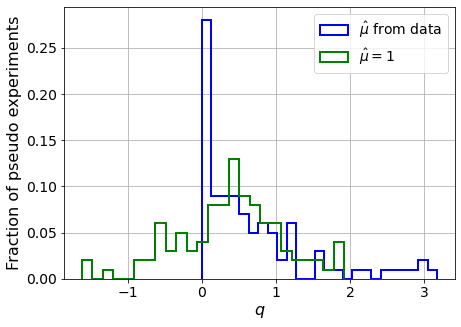

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  9034.51958654  8755.65844955
  8410.25865033  7989.54103377  7470.71441874  6849.14240379
  6102.69299967  5229.89849206  4211.85601111  3010.74649208
  1611.0059553     31.57112094 -1698.01276709 -3834.25322478]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf 11201.76261116 11031.64556013 10744.12424057


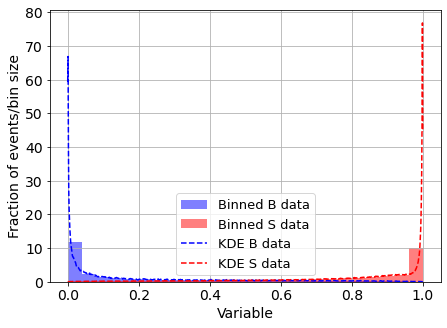

KDE Kernel:  epanechnikov
Background bandwidth:  0.0019008479046983867
Signal bandwidth:  0.0011635618505359071
This may take a while...
1 done
2 done
3 done
4 done


  0%|▏                                                                  | 6/2000 [00:01<05:03,  6.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15883396441793737
<p_{s}(Sdata)> = 15.194821380866935
<p_{b}(Bdata)> = 15.29598008596601
<p_{s}(Bdata)> = 0.25820957422759144
muhat = -0.1
<p_{b}(Sdata)> = 0.3366113784522303
<p_{s}(Sdata)> = 8.466660378778947
<p_{b}(Bdata)> = 15.285167341025582
<p_{s}(Bdata)> = 0.2558094194416969


  0%|▎                                                                  | 8/2000 [00:01<07:10,  4.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4038561033384197
<p_{s}(Sdata)> = 0.9140205554842418
<p_{b}(Bdata)> = 15.464272784538979
<p_{s}(Bdata)> = 0.260017564040611


  1%|▎                                                                 | 11/2000 [00:02<07:53,  4.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29096120055954183
<p_{s}(Sdata)> = 5.994048714745848
<p_{b}(Bdata)> = 15.312341901739098
<p_{s}(Bdata)> = 0.25872209414563785


  1%|▍                                                                 | 15/2000 [00:02<05:19,  6.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28826404114738446
<p_{s}(Sdata)> = 5.80136817960342
<p_{b}(Bdata)> = 15.534437638869907
<p_{s}(Bdata)> = 0.2590100717475454
muhat = 2.1
<p_{b}(Sdata)> = 0.33071028689192705
<p_{s}(Sdata)> = 18.480015414742432
<p_{b}(Bdata)> = 15.3971650394842
<p_{s}(Bdata)> = 0.27665348562548836


  1%|▌                                                                 | 16/2000 [00:02<05:15,  6.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31618413213078833
<p_{s}(Sdata)> = 4.27842963577746
<p_{b}(Bdata)> = 15.665236762089938
<p_{s}(Bdata)> = 0.25436023827921383


  1%|▋                                                                 | 21/2000 [00:03<05:36,  5.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3413264036688442
<p_{s}(Sdata)> = 5.93227963285495
<p_{b}(Bdata)> = 15.38552376167373
<p_{s}(Bdata)> = 0.25896601455605983


  1%|▊                                                                 | 25/2000 [00:04<04:44,  6.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3554731957288342
<p_{s}(Sdata)> = 2.1614269834077264
<p_{b}(Bdata)> = 15.259546723692576
<p_{s}(Bdata)> = 0.26467909300880677
muhat = -0.1
<p_{b}(Sdata)> = 0.23814068628143437
<p_{s}(Sdata)> = 8.732461895168464
<p_{b}(Bdata)> = 15.514029939318787
<p_{s}(Bdata)> = 0.2512480449661707


  2%|█                                                                 | 34/2000 [00:06<06:56,  4.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19330901020494218
<p_{s}(Sdata)> = 17.777316195813476
<p_{b}(Bdata)> = 15.270190264921242
<p_{s}(Bdata)> = 0.25926788634995396


  2%|█▏                                                                | 37/2000 [00:07<06:49,  4.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2499078709794612
<p_{s}(Sdata)> = 8.501913493451404
<p_{b}(Bdata)> = 15.283410527366406
<p_{s}(Bdata)> = 0.25490129651321713


  2%|█▍                                                                | 43/2000 [00:08<05:14,  6.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21830847900667
<p_{s}(Sdata)> = 7.704327591293946
<p_{b}(Bdata)> = 15.386834847953187
<p_{s}(Bdata)> = 0.2603980437323433
muhat = -0.1
<p_{b}(Sdata)> = 0.2365346015594635
<p_{s}(Sdata)> = 6.213012247380835
<p_{b}(Bdata)> = 15.193696709875125
<p_{s}(Bdata)> = 0.2601734198986053


  2%|█▍                                                                | 44/2000 [00:08<05:32,  5.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5341345751510646
<p_{s}(Sdata)> = 2.141141604588086
<p_{b}(Bdata)> = 15.344713512026233
<p_{s}(Bdata)> = 0.2607326447795963


  2%|█▌                                                                | 48/2000 [00:08<04:23,  7.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29793566139370414
<p_{s}(Sdata)> = 7.355921939060602
<p_{b}(Bdata)> = 15.243487169469622
<p_{s}(Bdata)> = 0.2607857823086821


  3%|█▋                                                                | 52/2000 [00:09<05:04,  6.39it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15695896036511753
<p_{s}(Sdata)> = 23.62838753627072
<p_{b}(Bdata)> = 15.550642678378294
<p_{s}(Bdata)> = 0.27137894379834177
muhat = -0.1
<p_{b}(Sdata)> = 0.8633157498016951
<p_{s}(Sdata)> = 11.842918198429338
<p_{b}(Bdata)> = 15.47812744420614
<p_{s}(Bdata)> = 0.26171674458760297


  3%|█▋                                                                | 53/2000 [00:09<06:13,  5.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25573753710741864
<p_{s}(Sdata)> = 10.60095053073011
<p_{b}(Bdata)> = 15.227471768510952
<p_{s}(Bdata)> = 0.2544649679893051


  3%|█▉                                                                | 60/2000 [00:11<05:49,  5.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.0806698095534626
<p_{s}(Sdata)> = 7.674967192080422
<p_{b}(Bdata)> = 15.252512568473879
<p_{s}(Bdata)> = 0.2605695887637887


  3%|██                                                                | 63/2000 [00:12<09:14,  3.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1550769494440357
<p_{s}(Sdata)> = 10.137285376461836
<p_{b}(Bdata)> = 15.598254756388084
<p_{s}(Bdata)> = 0.25862295369124916


  3%|██▏                                                               | 68/2000 [00:13<06:14,  5.16it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15070520762989997
<p_{s}(Sdata)> = 20.49031552374558
<p_{b}(Bdata)> = 15.29678262787137
<p_{s}(Bdata)> = 0.2733369552911902
muhat = -0.1
<p_{b}(Sdata)> = 0.2661419923348183
<p_{s}(Sdata)> = 5.9673290355943145
<p_{b}(Bdata)> = 15.32149071656601
<p_{s}(Bdata)> = 0.26245688931572947
muhat = -0.1
<p_{b}(Sdata)> = 0.1653036934782223
<p_{s}(Sdata)> = 5.967357276298813
<p_{b}(Bdata)> = 15.13562805031251
<p_{s}(Bdata)> = 0.258384249947534


  4%|██▍                                                               | 74/2000 [00:14<05:17,  6.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.254862067432127
<p_{s}(Sdata)> = 1.6648680006196577
<p_{b}(Bdata)> = 15.308753167915954
<p_{s}(Bdata)> = 0.2631793013444828


  4%|██▋                                                               | 83/2000 [00:16<06:22,  5.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26674738876936005
<p_{s}(Sdata)> = 9.607375306292262
<p_{b}(Bdata)> = 15.717319621000714
<p_{s}(Bdata)> = 0.2639969400865805
muhat = 2.1
<p_{b}(Sdata)> = 0.1883660403950435
<p_{s}(Sdata)> = 29.54761599301079
<p_{b}(Bdata)> = 15.231531442044497
<p_{s}(Bdata)> = 0.25946776779368863


  4%|██▊                                                               | 87/2000 [00:17<05:51,  5.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35960223718134154
<p_{s}(Sdata)> = 2.258940502240886
<p_{b}(Bdata)> = 15.335723367786853
<p_{s}(Bdata)> = 0.25619760352845


  5%|███                                                               | 91/2000 [00:18<08:00,  3.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1777886679905619
<p_{s}(Sdata)> = 7.451883335625238
<p_{b}(Bdata)> = 15.33837856597409
<p_{s}(Bdata)> = 0.25827714820699127


  5%|███                                                               | 93/2000 [00:19<07:51,  4.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17293415243295118
<p_{s}(Sdata)> = 6.1679616973060005
<p_{b}(Bdata)> = 15.223928084962496
<p_{s}(Bdata)> = 0.26052605369769555


  5%|███▏                                                              | 98/2000 [00:19<05:31,  5.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2622187076401233
<p_{s}(Sdata)> = 3.426480115889042
<p_{b}(Bdata)> = 15.430961035873635
<p_{s}(Bdata)> = 0.2554459237286589
muhat = 2.1
<p_{b}(Sdata)> = 0.18170447906259096
<p_{s}(Sdata)> = 21.55919394660006
<p_{b}(Bdata)> = 15.42272261150619
<p_{s}(Bdata)> = 0.27030603075792053


  6%|███▌                                                             | 110/2000 [00:23<09:08,  3.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26122037055502273
<p_{s}(Sdata)> = 7.138034072448391
<p_{b}(Bdata)> = 15.292159886989342
<p_{s}(Bdata)> = 0.25708518928595286


  6%|███▋                                                             | 114/2000 [00:23<05:57,  5.28it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16922958119978596
<p_{s}(Sdata)> = 20.6872343126005
<p_{b}(Bdata)> = 15.209694158911386
<p_{s}(Bdata)> = 0.27198109649390545


  6%|███▊                                                             | 118/2000 [00:24<07:06,  4.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19684287718815172
<p_{s}(Sdata)> = 5.14615946512948
<p_{b}(Bdata)> = 15.334233415198248
<p_{s}(Bdata)> = 0.2608228128335736


  6%|███▉                                                             | 120/2000 [00:25<06:52,  4.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2741665952892084
<p_{s}(Sdata)> = 7.715222841323659
<p_{b}(Bdata)> = 15.26458900424661
<p_{s}(Bdata)> = 0.26154576916742456


  6%|████                                                             | 125/2000 [00:26<05:52,  5.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15229526384833608
<p_{s}(Sdata)> = 18.74961130100116
<p_{b}(Bdata)> = 15.233679864013446
<p_{s}(Bdata)> = 0.25575507690868143


  7%|████▎                                                            | 134/2000 [00:28<07:37,  4.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 8.184083308767434
<p_{s}(Sdata)> = 8.345902549325515
<p_{b}(Bdata)> = 15.369016883293122
<p_{s}(Bdata)> = 0.2522950117317095


  7%|████▍                                                            | 138/2000 [00:29<05:11,  5.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21775292689618286
<p_{s}(Sdata)> = 1.7752053552244185
<p_{b}(Bdata)> = 15.247050391349177
<p_{s}(Bdata)> = 0.2534116696796567
muhat = -0.1
<p_{b}(Sdata)> = 0.4479278499501298
<p_{s}(Sdata)> = 10.639526692794334
<p_{b}(Bdata)> = 15.107873734538357
<p_{s}(Bdata)> = 0.26349954510767615


  7%|████▌                                                            | 140/2000 [00:29<04:53,  6.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3068172650357763
<p_{s}(Sdata)> = 7.057409366069004
<p_{b}(Bdata)> = 15.103966667377147
<p_{s}(Bdata)> = 0.25954103878211754


  7%|████▋                                                            | 143/2000 [00:30<06:04,  5.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41070306776105736
<p_{s}(Sdata)> = 10.995338233285512
<p_{b}(Bdata)> = 15.414282365221881
<p_{s}(Bdata)> = 0.25199425592277935


  8%|█████▎                                                           | 164/2000 [00:35<07:52,  3.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20891454467000115
<p_{s}(Sdata)> = 6.601285128970758
<p_{b}(Bdata)> = 15.204957078962611
<p_{s}(Bdata)> = 0.2638729056573779


  8%|█████▍                                                           | 168/2000 [00:36<06:06,  5.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2178692450254323
<p_{s}(Sdata)> = 2.0676249421563067
<p_{b}(Bdata)> = 15.208828764217243
<p_{s}(Bdata)> = 0.26037600360669966


  9%|█████▋                                                           | 176/2000 [00:38<07:02,  4.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18581334747561232
<p_{s}(Sdata)> = 12.465888471693356
<p_{b}(Bdata)> = 15.117697713434955
<p_{s}(Bdata)> = 0.2622124577532864


  9%|█████▊                                                           | 178/2000 [00:39<06:30,  4.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3478129642816549
<p_{s}(Sdata)> = 1.1682695557036649
<p_{b}(Bdata)> = 15.285130894295412
<p_{s}(Bdata)> = 0.2659144046102002


  9%|█████▉                                                           | 184/2000 [00:40<07:05,  4.27it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17903709930638573
<p_{s}(Sdata)> = 27.672232851524665
<p_{b}(Bdata)> = 15.220922817274364
<p_{s}(Bdata)> = 0.27866020273603614


  9%|██████                                                           | 188/2000 [00:41<05:32,  5.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27943215739873767
<p_{s}(Sdata)> = 7.006428270931911
<p_{b}(Bdata)> = 15.425904920493531
<p_{s}(Bdata)> = 0.25870340923629637
muhat = -0.1
<p_{b}(Sdata)> = 0.22062347985463915
<p_{s}(Sdata)> = 9.21159556689211
<p_{b}(Bdata)> = 15.231077503540172
<p_{s}(Bdata)> = 0.259213486827834


  9%|██████▏                                                          | 189/2000 [00:41<05:43,  5.28it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18114863750970456
<p_{s}(Sdata)> = 28.872404114831557
<p_{b}(Bdata)> = 15.24972386033325
<p_{s}(Bdata)> = 0.2678650687134192


 10%|██████▎                                                          | 193/2000 [00:42<04:47,  6.28it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.13875462041605946
<p_{s}(Sdata)> = 27.8998493216341
<p_{b}(Bdata)> = 15.352265493488344
<p_{s}(Bdata)> = 0.27160149467430533


 10%|██████▍                                                          | 198/2000 [00:43<06:43,  4.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3888123155708082
<p_{s}(Sdata)> = 7.315085104862826
<p_{b}(Bdata)> = 15.27292410258158
<p_{s}(Bdata)> = 0.25756274871845863


 10%|██████▌                                                          | 201/2000 [00:43<05:34,  5.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29970916955085847
<p_{s}(Sdata)> = 1.3262506925565902
<p_{b}(Bdata)> = 15.235241153801697
<p_{s}(Bdata)> = 0.25452409261461023


 10%|██████▊                                                          | 208/2000 [00:44<04:37,  6.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2793477609472679
<p_{s}(Sdata)> = 9.465523157868056
<p_{b}(Bdata)> = 15.348625821647541
<p_{s}(Bdata)> = 0.2591024595561882
muhat = -0.1
<p_{b}(Sdata)> = 0.25612906151147946
<p_{s}(Sdata)> = 7.516151384204383
<p_{b}(Bdata)> = 15.144034187445191
<p_{s}(Bdata)> = 0.2605736524812874


 10%|██████▊                                                          | 210/2000 [00:45<06:27,  4.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21911841468818408
<p_{s}(Sdata)> = 4.8135123954924675
<p_{b}(Bdata)> = 15.3702015288545
<p_{s}(Bdata)> = 0.2619362178075111


 11%|███████                                                          | 216/2000 [00:46<07:14,  4.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.14217278731456892
<p_{s}(Sdata)> = 2.0887339245465526
<p_{b}(Bdata)> = 15.322668034364595
<p_{s}(Bdata)> = 0.26019101609255385


 11%|███████▎                                                         | 226/2000 [00:49<06:41,  4.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.243833639818614
<p_{s}(Sdata)> = 7.43427455651332
<p_{b}(Bdata)> = 15.435353065986403
<p_{s}(Bdata)> = 0.2651248116703452


 11%|███████▍                                                         | 229/2000 [00:49<05:00,  5.89it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3394732612649905
<p_{s}(Sdata)> = 22.243741414648778
<p_{b}(Bdata)> = 14.93344539485741
<p_{s}(Bdata)> = 0.27824248079219494
muhat = -0.1
<p_{b}(Sdata)> = 0.2618533067998169
<p_{s}(Sdata)> = 1.95666380402232
<p_{b}(Bdata)> = 15.292790601397
<p_{s}(Bdata)> = 0.25987643963360424
muhat = -0.1
<p_{b}(Sdata)> = 0.23962077767178291
<p_{s}(Sdata)> = 15.680665387964751
<p_{b}(Bdata)> = 15.143617044579068
<p_{s}(Bdata)> = 0.2607800755753664


 12%|███████▋                                                         | 237/2000 [00:51<04:36,  6.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25479932528543464
<p_{s}(Sdata)> = 8.44490044837602
<p_{b}(Bdata)> = 15.17368962370192
<p_{s}(Bdata)> = 0.2631849615161021
muhat = -0.1
<p_{b}(Sdata)> = 0.2647926522944791
<p_{s}(Sdata)> = 9.627014608999733
<p_{b}(Bdata)> = 14.938617731800589
<p_{s}(Bdata)> = 0.26152426602083023


 12%|███████▊                                                         | 240/2000 [00:51<03:43,  7.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5190064384910082
<p_{s}(Sdata)> = 8.368755551892018
<p_{b}(Bdata)> = 15.277427389474395
<p_{s}(Bdata)> = 0.25549416101731753
muhat = -0.1
<p_{b}(Sdata)> = 0.24106992108212819
<p_{s}(Sdata)> = 1.9850726199767863
<p_{b}(Bdata)> = 15.237027667969375
<p_{s}(Bdata)> = 0.26134855552737907


 12%|███████▉                                                         | 245/2000 [00:53<06:50,  4.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1443398323312201
<p_{s}(Sdata)> = 10.16510986611232
<p_{b}(Bdata)> = 15.3598973185726
<p_{s}(Bdata)> = 0.2625989116342893


 13%|████████▎                                                        | 255/2000 [00:55<04:40,  6.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1275186561005675
<p_{s}(Sdata)> = 25.293969113578537
<p_{b}(Bdata)> = 15.350394686822584
<p_{s}(Bdata)> = 0.25763636322155226
muhat = -0.1
<p_{b}(Sdata)> = 0.198261589704838
<p_{s}(Sdata)> = 7.498815755464117
<p_{b}(Bdata)> = 15.344655743486356
<p_{s}(Bdata)> = 0.26571772903627794


 13%|████████▍                                                        | 261/2000 [00:56<07:27,  3.89it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3024237555376173
<p_{s}(Sdata)> = 14.592869844120754
<p_{b}(Bdata)> = 15.655570162933317
<p_{s}(Bdata)> = 0.2733838783090821


 13%|████████▋                                                        | 266/2000 [00:57<05:26,  5.32it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14029793898939985
<p_{s}(Sdata)> = 22.481229651739522
<p_{b}(Bdata)> = 15.271619068479815
<p_{s}(Bdata)> = 0.26896581064769526
muhat = 2.1
<p_{b}(Sdata)> = 0.29071937203072507
<p_{s}(Sdata)> = 16.09940051194527
<p_{b}(Bdata)> = 15.329465705595533
<p_{s}(Bdata)> = 0.2685762935131311
muhat = -0.1
<p_{b}(Sdata)> = 0.1235066212702785
<p_{s}(Sdata)> = 16.478840171160954
<p_{b}(Bdata)> = 15.293103729379652
<p_{s}(Bdata)> = 0.25308890436168435


 13%|████████▋                                                        | 268/2000 [00:57<04:06,  7.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2392085980754629
<p_{s}(Sdata)> = 5.78887936422056
<p_{b}(Bdata)> = 15.336712360211973
<p_{s}(Bdata)> = 0.25480186557567414


 14%|█████████                                                        | 277/2000 [01:00<05:39,  5.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21279199778628713
<p_{s}(Sdata)> = 4.923858686003656
<p_{b}(Bdata)> = 15.345046656935189
<p_{s}(Bdata)> = 0.2635982499297685


 14%|█████████                                                        | 278/2000 [01:00<05:26,  5.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20910675450547733
<p_{s}(Sdata)> = 4.135092820820334
<p_{b}(Bdata)> = 15.237035302259955
<p_{s}(Bdata)> = 0.2589961307294589


 14%|█████████▏                                                       | 282/2000 [01:00<04:22,  6.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.308137223425015
<p_{s}(Sdata)> = 7.990980339670337
<p_{b}(Bdata)> = 15.198209439105788
<p_{s}(Bdata)> = 0.25365744225461134
muhat = -0.1
<p_{b}(Sdata)> = 0.30136011590079803
<p_{s}(Sdata)> = 5.40619074551842
<p_{b}(Bdata)> = 15.287323668080122
<p_{s}(Bdata)> = 0.2610664490284728


 14%|█████████▏                                                       | 283/2000 [01:01<05:45,  4.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19687089752933556
<p_{s}(Sdata)> = 12.673256413689117
<p_{b}(Bdata)> = 15.168953547801248
<p_{s}(Bdata)> = 0.25623345737221004


 14%|█████████▎                                                       | 288/2000 [01:02<05:27,  5.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26930932548413955
<p_{s}(Sdata)> = 13.444925093245207
<p_{b}(Bdata)> = 15.53142732495491
<p_{s}(Bdata)> = 0.2571112756085302


 14%|█████████▍                                                       | 289/2000 [01:02<06:03,  4.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2602442928163275
<p_{s}(Sdata)> = 11.646172172980641
<p_{b}(Bdata)> = 15.419433800612168
<p_{s}(Bdata)> = 0.2590472334780725


 15%|█████████▌                                                       | 293/2000 [01:03<05:05,  5.59it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21752924441885255
<p_{s}(Sdata)> = 20.86249257147687
<p_{b}(Bdata)> = 15.433187832274122
<p_{s}(Bdata)> = 0.2687857937144436
muhat = -0.1
<p_{b}(Sdata)> = 0.23454284432567762
<p_{s}(Sdata)> = 5.434402019098518
<p_{b}(Bdata)> = 15.47178967796056
<p_{s}(Bdata)> = 0.2612234663298055


 15%|█████████▌                                                       | 294/2000 [01:03<05:23,  5.27it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3141481334387528
<p_{s}(Sdata)> = 8.026866015022136
<p_{b}(Bdata)> = 15.462343626321786
<p_{s}(Bdata)> = 0.2809506045956532


 15%|█████████▊                                                       | 300/2000 [01:04<05:05,  5.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2050620388852269
<p_{s}(Sdata)> = 23.065913428561938
<p_{b}(Bdata)> = 15.351532000586888
<p_{s}(Bdata)> = 0.2563078714808043
muhat = -0.1
<p_{b}(Sdata)> = 0.1615521319749448
<p_{s}(Sdata)> = 18.29009573536487
<p_{b}(Bdata)> = 15.232495188637536
<p_{s}(Bdata)> = 0.25439533000168446


 16%|██████████▏                                                      | 314/2000 [01:08<05:50,  4.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.11364532923142844
<p_{s}(Sdata)> = 20.67752292187381
<p_{b}(Bdata)> = 15.40509650132335
<p_{s}(Bdata)> = 0.24708749670272248


 16%|██████████▎                                                      | 319/2000 [01:08<04:10,  6.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22163210433991296
<p_{s}(Sdata)> = 9.628978408796465
<p_{b}(Bdata)> = 15.322012371003462
<p_{s}(Bdata)> = 0.2557150759112567
muhat = -0.1
<p_{b}(Sdata)> = 0.1566754584587283
<p_{s}(Sdata)> = 6.367048490297035
<p_{b}(Bdata)> = 15.560047817259248
<p_{s}(Bdata)> = 0.2585211473515735


 16%|██████████▍                                                      | 323/2000 [01:09<05:40,  4.92it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4581446399178338
<p_{s}(Sdata)> = 17.153034446035623
<p_{b}(Bdata)> = 15.235534206165907
<p_{s}(Bdata)> = 0.2667277183300802


 16%|██████████▋                                                      | 329/2000 [01:10<04:37,  6.01it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.11627265084348444
<p_{s}(Sdata)> = 22.013339859938156
<p_{b}(Bdata)> = 15.269533567499327
<p_{s}(Bdata)> = 0.27383201186878614
muhat = -0.1
<p_{b}(Sdata)> = 0.7456942520705058
<p_{s}(Sdata)> = 1.5616550016593074
<p_{b}(Bdata)> = 15.276017573902203
<p_{s}(Bdata)> = 0.256578299914716
muhat = -0.1
<p_{b}(Sdata)> = 0.37771321129658525
<p_{s}(Sdata)> = 9.953754711838773
<p_{b}(Bdata)> = 15.598490894021342
<p_{s}(Bdata)> = 0.2614751703798009


 17%|██████████▉                                                      | 336/2000 [01:12<06:45,  4.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23369632153639783
<p_{s}(Sdata)> = 11.514528138085566
<p_{b}(Bdata)> = 15.123180015889165
<p_{s}(Bdata)> = 0.2627775157447059


 17%|███████████                                                      | 341/2000 [01:13<04:32,  6.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20448292268830498
<p_{s}(Sdata)> = 9.203225391440991
<p_{b}(Bdata)> = 15.215314644984577
<p_{s}(Bdata)> = 0.2609651928178071


 17%|███████████▏                                                     | 343/2000 [01:13<03:41,  7.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2636754052464534
<p_{s}(Sdata)> = 15.416411598584686
<p_{b}(Bdata)> = 15.112469850601181
<p_{s}(Bdata)> = 0.2545051840808726
muhat = 2.1
<p_{b}(Sdata)> = 0.197614200310016
<p_{s}(Sdata)> = 30.746360868418822
<p_{b}(Bdata)> = 15.300695627640092
<p_{s}(Bdata)> = 0.26669301110834365
muhat = -0.1
<p_{b}(Sdata)> = 0.24322416903523886
<p_{s}(Sdata)> = 6.755545568631172
<p_{b}(Bdata)> = 15.294343297535468
<p_{s}(Bdata)> = 0.26102675446173496


 17%|███████████▎                                                     | 347/2000 [01:13<02:49,  9.77it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2662113569846277
<p_{s}(Sdata)> = 16.883744285397196
<p_{b}(Bdata)> = 14.985171577879774
<p_{s}(Bdata)> = 0.2713311330871146
muhat = 2.1
<p_{b}(Sdata)> = 0.2182457440379826
<p_{s}(Sdata)> = 17.089352256870843
<p_{b}(Bdata)> = 15.357632540124255
<p_{s}(Bdata)> = 0.278177547644578
muhat = -0.1
<p_{b}(Sdata)> = 0.194180477714951
<p_{s}(Sdata)> = 3.6848563451864558
<p_{b}(Bdata)> = 15.279315797538024
<p_{s}(Bdata)> = 0.25819123861689053


 17%|███████████▎                                                     | 349/2000 [01:14<05:22,  5.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1507947633583454
<p_{s}(Sdata)> = 23.02825656504577
<p_{b}(Bdata)> = 15.374251682850051
<p_{s}(Bdata)> = 0.27143419425768367


 18%|███████████▌                                                     | 354/2000 [01:15<04:16,  6.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2876225060464551
<p_{s}(Sdata)> = 8.160205177395333
<p_{b}(Bdata)> = 15.65905655626049
<p_{s}(Bdata)> = 0.2525375870438299
muhat = -0.1
<p_{b}(Sdata)> = 0.38507701340357287
<p_{s}(Sdata)> = 1.16592075896567
<p_{b}(Bdata)> = 15.456117894084832
<p_{s}(Bdata)> = 0.25798629682318003


 18%|███████████▋                                                     | 361/2000 [01:16<04:19,  6.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25736370783111434
<p_{s}(Sdata)> = 4.843567191817315
<p_{b}(Bdata)> = 15.319790012867376
<p_{s}(Bdata)> = 0.26667813334138313


 18%|███████████▊                                                     | 362/2000 [01:16<06:01,  4.53it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2062159108904397
<p_{s}(Sdata)> = 9.05799953194705
<p_{b}(Bdata)> = 15.522725166230764
<p_{s}(Bdata)> = 0.2756033963183303


 18%|███████████▊                                                     | 364/2000 [01:17<05:48,  4.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30625997714001735
<p_{s}(Sdata)> = 10.503774449648501
<p_{b}(Bdata)> = 15.477964520706141
<p_{s}(Bdata)> = 0.25102052740505504


 19%|████████████▏                                                    | 374/2000 [01:20<08:33,  3.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2873917612879578
<p_{s}(Sdata)> = 3.2868197152327534
<p_{b}(Bdata)> = 15.445452550887138
<p_{s}(Bdata)> = 0.26029403507545856


 19%|████████████▎                                                    | 379/2000 [01:21<06:20,  4.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2766642836504172
<p_{s}(Sdata)> = 6.955589395095596
<p_{b}(Bdata)> = 15.385196253161197
<p_{s}(Bdata)> = 0.2556498080932593
muhat = -0.1
<p_{b}(Sdata)> = 0.29198258727222587
<p_{s}(Sdata)> = 15.619052222272174
<p_{b}(Bdata)> = 15.004041601964786
<p_{s}(Bdata)> = 0.2572294957401626


 20%|████████████▋                                                    | 392/2000 [01:24<06:19,  4.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3209079894928381
<p_{s}(Sdata)> = 2.1361601738340545
<p_{b}(Bdata)> = 15.421452978195314
<p_{s}(Bdata)> = 0.25667806801294163


 20%|████████████▊                                                    | 396/2000 [01:25<05:10,  5.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24908821643748721
<p_{s}(Sdata)> = 6.976474089213526
<p_{b}(Bdata)> = 15.44930598570443
<p_{s}(Bdata)> = 0.2656999127749012


 21%|█████████████▍                                                   | 414/2000 [01:30<05:20,  4.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33982578495666255
<p_{s}(Sdata)> = 2.7468760854273198
<p_{b}(Bdata)> = 15.335012114437681
<p_{s}(Bdata)> = 0.25660654673336586
muhat = -0.1
<p_{b}(Sdata)> = 0.3011696937165958
<p_{s}(Sdata)> = 24.597844147644842
<p_{b}(Bdata)> = 15.303277659995787
<p_{s}(Bdata)> = 0.25478935159952315


 21%|█████████████▉                                                   | 428/2000 [01:33<04:49,  5.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20858925126953223
<p_{s}(Sdata)> = 12.45797373200191
<p_{b}(Bdata)> = 15.625131757348887
<p_{s}(Bdata)> = 0.25570607631427356
muhat = -0.1
<p_{b}(Sdata)> = 0.2904013522430177
<p_{s}(Sdata)> = 12.440888642807181
<p_{b}(Bdata)> = 15.19991185869532
<p_{s}(Bdata)> = 0.2582539374645983
muhat = 2.1
<p_{b}(Sdata)> = 0.30664885469231395
<p_{s}(Sdata)> = 13.229571324836291
<p_{b}(Bdata)> = 15.21896106555302
<p_{s}(Bdata)> = 0.26970417480210296


 22%|██████████████                                                   | 431/2000 [01:34<05:06,  5.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20706595533064306
<p_{s}(Sdata)> = 6.372235957580011
<p_{b}(Bdata)> = 15.382355943243056
<p_{s}(Bdata)> = 0.25901604737305645


 22%|██████████████                                                   | 433/2000 [01:34<04:50,  5.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.213950952462493
<p_{s}(Sdata)> = 2.0434750485720388
<p_{b}(Bdata)> = 15.462034228745754
<p_{s}(Bdata)> = 0.2651952449370321


 22%|██████████████▏                                                  | 436/2000 [01:35<05:47,  4.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1248260691679112
<p_{s}(Sdata)> = 10.831352983825019
<p_{b}(Bdata)> = 15.27549926801314
<p_{s}(Bdata)> = 0.2581749988912627


 22%|██████████████▎                                                  | 442/2000 [01:36<05:36,  4.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16928919362436576
<p_{s}(Sdata)> = 16.002297797965856
<p_{b}(Bdata)> = 15.41181809242878
<p_{s}(Bdata)> = 0.25711955338268294


 22%|██████████████▌                                                  | 448/2000 [01:37<04:22,  5.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2121689812402855
<p_{s}(Sdata)> = 11.807586474980829
<p_{b}(Bdata)> = 15.410799561527517
<p_{s}(Bdata)> = 0.25918370260520046


 22%|██████████████▋                                                  | 450/2000 [01:38<03:29,  7.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35085064425109463
<p_{s}(Sdata)> = 4.643685582943662
<p_{b}(Bdata)> = 15.284553907543636
<p_{s}(Bdata)> = 0.25786670719269145
muhat = 2.1
<p_{b}(Sdata)> = 0.1300906858107807
<p_{s}(Sdata)> = 12.898545140455958
<p_{b}(Bdata)> = 15.41468011504398
<p_{s}(Bdata)> = 0.2732814215512252


 23%|██████████████▋                                                  | 453/2000 [01:38<03:32,  7.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33305441819748527
<p_{s}(Sdata)> = 9.415247590476845
<p_{b}(Bdata)> = 15.313061078838698
<p_{s}(Bdata)> = 0.2617280232776996


 23%|██████████████▉                                                  | 458/2000 [01:39<07:07,  3.61it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25531707601324805
<p_{s}(Sdata)> = 24.02912717346243
<p_{b}(Bdata)> = 15.336361452526374
<p_{s}(Bdata)> = 0.26445274575308064


 24%|███████████████▎                                                 | 471/2000 [01:43<04:33,  5.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16523036847245656
<p_{s}(Sdata)> = 12.493367135561753
<p_{b}(Bdata)> = 15.13938190381832
<p_{s}(Bdata)> = 0.25819314375229885


 24%|███████████████▍                                                 | 474/2000 [01:43<03:13,  7.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29447942918647046
<p_{s}(Sdata)> = 2.1782487163599176
<p_{b}(Bdata)> = 15.491758175854391
<p_{s}(Bdata)> = 0.2658632947028021
muhat = -0.1
<p_{b}(Sdata)> = 0.2595261832255846
<p_{s}(Sdata)> = 8.912859139068443
<p_{b}(Bdata)> = 15.386450554868741
<p_{s}(Bdata)> = 0.2614800226649446


 24%|███████████████▌                                                 | 477/2000 [01:43<03:37,  6.99it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3164622067370251
<p_{s}(Sdata)> = 29.10016850432873
<p_{b}(Bdata)> = 15.336529500810505
<p_{s}(Bdata)> = 0.2678531208826977
muhat = -0.1
<p_{b}(Sdata)> = 0.37741460768161783
<p_{s}(Sdata)> = 1.0819505816828239
<p_{b}(Bdata)> = 15.34931971547457
<p_{s}(Bdata)> = 0.26378231481954845


 24%|███████████████▋                                                 | 481/2000 [01:44<03:36,  7.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36719783585364923
<p_{s}(Sdata)> = 4.596548947032051
<p_{b}(Bdata)> = 15.505880310082889
<p_{s}(Bdata)> = 0.25557027176355884
muhat = -0.1
<p_{b}(Sdata)> = 0.4765641904022297
<p_{s}(Sdata)> = 4.410451127330798
<p_{b}(Bdata)> = 15.093172001905996
<p_{s}(Bdata)> = 0.2629297871934445
muhat = -0.1
<p_{b}(Sdata)> = 0.5851276250118423
<p_{s}(Sdata)> = 8.805926355405962
<p_{b}(Bdata)> = 15.401607454885891
<p_{s}(Bdata)> = 0.2549754881224404


 24%|███████████████▊                                                 | 485/2000 [01:45<04:42,  5.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.14491672262217517
<p_{s}(Sdata)> = 15.140909407891208
<p_{b}(Bdata)> = 15.157773213721734
<p_{s}(Bdata)> = 0.2610574168124741


 25%|████████████████                                                 | 495/2000 [01:47<05:16,  4.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2365364934567753
<p_{s}(Sdata)> = 2.522102209933936
<p_{b}(Bdata)> = 15.286912629196502
<p_{s}(Bdata)> = 0.2659263656252182


 25%|████████████████▏                                                | 499/2000 [01:48<04:08,  6.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.13765814925587824
<p_{s}(Sdata)> = 26.34022037607775
<p_{b}(Bdata)> = 15.703314872117307
<p_{s}(Bdata)> = 0.2655325644028246
muhat = -0.1
<p_{b}(Sdata)> = 0.46511456985620736
<p_{s}(Sdata)> = 10.794832179265766
<p_{b}(Bdata)> = 15.411168002950856
<p_{s}(Bdata)> = 0.2580848559188537


 25%|████████████████▍                                                | 507/2000 [01:50<05:16,  4.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2151476102852273
<p_{s}(Sdata)> = 3.9647292863731427
<p_{b}(Bdata)> = 15.230940356858303
<p_{s}(Bdata)> = 0.26163947673675975
muhat = -0.1
<p_{b}(Sdata)> = 0.3243797106779154
<p_{s}(Sdata)> = 10.294266496561969
<p_{b}(Bdata)> = 15.301695787803693
<p_{s}(Bdata)> = 0.26147126905260837


 26%|████████████████▌                                                | 511/2000 [01:51<04:19,  5.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27327390595241197
<p_{s}(Sdata)> = 1.4063610669909257
<p_{b}(Bdata)> = 15.440154074807918
<p_{s}(Bdata)> = 0.25929268991863036


 26%|████████████████▊                                                | 516/2000 [01:52<03:57,  6.26it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17717246151556437
<p_{s}(Sdata)> = 17.60000586541874
<p_{b}(Bdata)> = 15.451902636181535
<p_{s}(Bdata)> = 0.2692470342382982
muhat = -0.1
<p_{b}(Sdata)> = 0.27907187200444705
<p_{s}(Sdata)> = 6.418860950537071
<p_{b}(Bdata)> = 15.540947468510565
<p_{s}(Bdata)> = 0.2634413064988908


 26%|████████████████▊                                                | 518/2000 [01:52<04:26,  5.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2259714607434969
<p_{s}(Sdata)> = 2.694529449689844
<p_{b}(Bdata)> = 15.737717401679745
<p_{s}(Bdata)> = 0.25119472342166915


 26%|█████████████████                                                | 525/2000 [01:53<03:56,  6.24it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20568996133558423
<p_{s}(Sdata)> = 31.507018397500733
<p_{b}(Bdata)> = 15.203945045162037
<p_{s}(Bdata)> = 0.263185547270295


 26%|█████████████████▏                                               | 530/2000 [01:54<05:32,  4.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20138983792016163
<p_{s}(Sdata)> = 6.581542171568048
<p_{b}(Bdata)> = 15.454319450677284
<p_{s}(Bdata)> = 0.2639721831127188


 27%|█████████████████▎                                               | 534/2000 [01:55<04:01,  6.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6714886716751138
<p_{s}(Sdata)> = 0.7461959056481988
<p_{b}(Bdata)> = 15.520578533633358
<p_{s}(Bdata)> = 0.25793331192909597


 27%|█████████████████▋                                               | 545/2000 [01:58<04:19,  5.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24262500349291263
<p_{s}(Sdata)> = 8.432384570023073
<p_{b}(Bdata)> = 15.640865991540878
<p_{s}(Bdata)> = 0.255017640091459


 27%|█████████████████▊                                               | 549/2000 [01:58<04:03,  5.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1924670846560836
<p_{s}(Sdata)> = 4.079849470453946
<p_{b}(Bdata)> = 15.100608481512404
<p_{s}(Bdata)> = 0.26397942025583376


 28%|██████████████████▏                                              | 561/2000 [02:01<04:13,  5.68it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.28539345362555835
<p_{s}(Sdata)> = 26.133703992850034
<p_{b}(Bdata)> = 15.126688502473085
<p_{s}(Bdata)> = 0.26030028602235583


 28%|██████████████████▎                                              | 563/2000 [02:01<04:07,  5.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19495341577496983
<p_{s}(Sdata)> = 10.501953645237155
<p_{b}(Bdata)> = 15.30122816759777
<p_{s}(Bdata)> = 0.25723619683030696


 29%|██████████████████▌                                              | 573/2000 [02:04<05:24,  4.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3639682190016979
<p_{s}(Sdata)> = 6.391090058750113
<p_{b}(Bdata)> = 15.294745980452863
<p_{s}(Bdata)> = 0.2616735237052185
muhat = -0.1
<p_{b}(Sdata)> = 0.23027457897326434
<p_{s}(Sdata)> = 20.640848323708003
<p_{b}(Bdata)> = 15.365085384948676
<p_{s}(Bdata)> = 0.25761891678537924


 29%|██████████████████▊                                              | 579/2000 [02:06<06:35,  3.59it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15484996004167595
<p_{s}(Sdata)> = 26.484876766424893
<p_{b}(Bdata)> = 15.345637737251934
<p_{s}(Bdata)> = 0.27212122947722395


 29%|██████████████████▉                                              | 584/2000 [02:07<04:58,  4.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23141604777581629
<p_{s}(Sdata)> = 7.151357230378157
<p_{b}(Bdata)> = 15.216541528428344
<p_{s}(Bdata)> = 0.26053014472318364


 30%|███████████████████▎                                             | 593/2000 [02:09<04:33,  5.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2621926469354474
<p_{s}(Sdata)> = 1.515283070581212
<p_{b}(Bdata)> = 14.934491656293941
<p_{s}(Bdata)> = 0.2673785155006249


 30%|███████████████████▍                                             | 598/2000 [02:10<04:41,  4.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25648675818860656
<p_{s}(Sdata)> = 10.363373742587273
<p_{b}(Bdata)> = 15.42826340241447
<p_{s}(Bdata)> = 0.2544293503627378


 30%|███████████████████▋                                             | 605/2000 [02:12<04:06,  5.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22687115885439912
<p_{s}(Sdata)> = 11.450856777799247
<p_{b}(Bdata)> = 15.242225880453155
<p_{s}(Bdata)> = 0.25697759472022125


 30%|███████████████████▋                                             | 607/2000 [02:12<03:21,  6.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23667207146789715
<p_{s}(Sdata)> = 10.950026728396988
<p_{b}(Bdata)> = 15.333116158692908
<p_{s}(Bdata)> = 0.2606722161865539


 31%|████████████████████                                             | 618/2000 [02:15<04:06,  5.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34450346576934326
<p_{s}(Sdata)> = 1.1663093544277192
<p_{b}(Bdata)> = 15.333816089639436
<p_{s}(Bdata)> = 0.258884171059896
muhat = -0.1
<p_{b}(Sdata)> = 0.25942599664758204
<p_{s}(Sdata)> = 10.519663200811317
<p_{b}(Bdata)> = 15.2869352874952
<p_{s}(Bdata)> = 0.2538539443827744


 31%|████████████████████▏                                            | 622/2000 [02:15<03:37,  6.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2114437858015881
<p_{s}(Sdata)> = 21.240825498306094
<p_{b}(Bdata)> = 15.332367847138546
<p_{s}(Bdata)> = 0.2608865094034773
muhat = -0.1
<p_{b}(Sdata)> = 0.32965924807161867
<p_{s}(Sdata)> = 10.829577120294466
<p_{b}(Bdata)> = 15.254966193780005
<p_{s}(Bdata)> = 0.2637601392980635


 31%|████████████████████▏                                            | 623/2000 [02:15<03:46,  6.07it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19505996745236076
<p_{s}(Sdata)> = 21.918462011351437
<p_{b}(Bdata)> = 15.189009952278441
<p_{s}(Bdata)> = 0.2764028708403466


 31%|████████████████████▍                                            | 628/2000 [02:16<03:58,  5.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30911348716635056
<p_{s}(Sdata)> = 10.71153459791936
<p_{b}(Bdata)> = 15.280973055798368
<p_{s}(Bdata)> = 0.2630479380256508


 32%|████████████████████▋                                            | 636/2000 [02:18<06:36,  3.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18404041471896854
<p_{s}(Sdata)> = 9.445053210214073
<p_{b}(Bdata)> = 15.374621555083856
<p_{s}(Bdata)> = 0.25588650073626557


 32%|████████████████████▊                                            | 641/2000 [02:19<03:45,  6.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37398847584623934
<p_{s}(Sdata)> = 8.133018343420785
<p_{b}(Bdata)> = 15.333947030889407
<p_{s}(Bdata)> = 0.25600328943779976
muhat = 2.1
<p_{b}(Sdata)> = 0.20800726607500108
<p_{s}(Sdata)> = 18.75206350146661
<p_{b}(Bdata)> = 15.349662745163558
<p_{s}(Bdata)> = 0.27271139248894555
muhat = -0.1
<p_{b}(Sdata)> = 0.24900233257604468
<p_{s}(Sdata)> = 14.996407375547061
<p_{b}(Bdata)> = 15.387589165596944
<p_{s}(Bdata)> = 0.2611609375464332


 32%|████████████████████▉                                            | 645/2000 [02:20<05:15,  4.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18767313633196758
<p_{s}(Sdata)> = 19.320695404242116
<p_{b}(Bdata)> = 15.384555668080841
<p_{s}(Bdata)> = 0.2578195744192384


 33%|█████████████████████▏                                           | 651/2000 [02:21<03:17,  6.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15413555074164306
<p_{s}(Sdata)> = 7.8174237431832365
<p_{b}(Bdata)> = 15.249457061300477
<p_{s}(Bdata)> = 0.25565556133537365


 33%|█████████████████████▎                                           | 657/2000 [02:22<04:30,  4.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2872054546302242
<p_{s}(Sdata)> = 8.645044887351645
<p_{b}(Bdata)> = 15.394616317270593
<p_{s}(Bdata)> = 0.25825343643216053


 33%|█████████████████████▍                                           | 660/2000 [02:24<06:46,  3.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24131277032515125
<p_{s}(Sdata)> = 8.607200813547031
<p_{b}(Bdata)> = 15.367467525769994
<p_{s}(Bdata)> = 0.2599281820627172


 33%|█████████████████████▌                                           | 664/2000 [02:24<04:28,  4.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23459296418037362
<p_{s}(Sdata)> = 5.38687002123761
<p_{b}(Bdata)> = 15.18164667084708
<p_{s}(Bdata)> = 0.2531351862512912


 34%|█████████████████████▊                                           | 670/2000 [02:25<04:02,  5.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16046325974615225
<p_{s}(Sdata)> = 11.13134216089334
<p_{b}(Bdata)> = 15.481971858083133
<p_{s}(Bdata)> = 0.2586228684441878
muhat = 2.1
<p_{b}(Sdata)> = 0.13509989063862576
<p_{s}(Sdata)> = 29.057432156463427
<p_{b}(Bdata)> = 15.311980015169471
<p_{s}(Bdata)> = 0.26792605901434374


 34%|██████████████████████                                           | 680/2000 [02:28<06:02,  3.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16976974428994576
<p_{s}(Sdata)> = 5.6007420698683275
<p_{b}(Bdata)> = 15.223645023700092
<p_{s}(Bdata)> = 0.26181909091249606


 34%|██████████████████████▎                                          | 687/2000 [02:29<04:50,  4.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2076329364830398
<p_{s}(Sdata)> = 10.082713075805506
<p_{b}(Bdata)> = 15.341286551690677
<p_{s}(Bdata)> = 0.25375363080065816


 34%|██████████████████████▍                                          | 689/2000 [02:29<03:32,  6.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20256344249460276
<p_{s}(Sdata)> = 10.524293423860069
<p_{b}(Bdata)> = 15.259500005145492
<p_{s}(Bdata)> = 0.2508060273601166
muhat = -0.1
<p_{b}(Sdata)> = 0.25814273265147764
<p_{s}(Sdata)> = 8.388684581188139
<p_{b}(Bdata)> = 15.46926769829464
<p_{s}(Bdata)> = 0.26330805628939724


 35%|██████████████████████▍                                          | 692/2000 [02:30<04:26,  4.92it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.05960494062299605
<p_{s}(Sdata)> = 33.39381439794158
<p_{b}(Bdata)> = 15.360513779804512
<p_{s}(Bdata)> = 0.2706250086422151


 35%|██████████████████████▉                                          | 707/2000 [02:34<04:15,  5.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3429769134926457
<p_{s}(Sdata)> = 4.166961617619875
<p_{b}(Bdata)> = 15.284999161061906
<p_{s}(Bdata)> = 0.26400275212211444


 36%|███████████████████████                                          | 711/2000 [02:35<04:09,  5.17it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16360322729744675
<p_{s}(Sdata)> = 24.966061079497294
<p_{b}(Bdata)> = 15.182126203710808
<p_{s}(Bdata)> = 0.266646286646365


 36%|███████████████████████▎                                         | 716/2000 [02:36<03:20,  6.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16922223896273242
<p_{s}(Sdata)> = 8.279462955808656
<p_{b}(Bdata)> = 15.55612632730585
<p_{s}(Bdata)> = 0.2532679924087787


 36%|███████████████████████▎                                         | 717/2000 [02:36<03:31,  6.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.250878587176027
<p_{s}(Sdata)> = 13.093704757037145
<p_{b}(Bdata)> = 15.179467721918877
<p_{s}(Bdata)> = 0.25523465156965736


 36%|███████████████████████▍                                         | 722/2000 [02:37<04:49,  4.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22388233459238574
<p_{s}(Sdata)> = 8.850447281236367
<p_{b}(Bdata)> = 15.36875535387567
<p_{s}(Bdata)> = 0.25459405176119654


 36%|███████████████████████▋                                         | 728/2000 [02:38<04:27,  4.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1999865708143577
<p_{s}(Sdata)> = 6.333754785293379
<p_{b}(Bdata)> = 15.28345704284356
<p_{s}(Bdata)> = 0.2558894864479974


 37%|███████████████████████▉                                         | 735/2000 [02:39<02:34,  8.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28090476684217563
<p_{s}(Sdata)> = 4.761925600304687
<p_{b}(Bdata)> = 15.340652331005057
<p_{s}(Bdata)> = 0.25535747957123145
muhat = -0.1
<p_{b}(Sdata)> = 0.19521302561036083
<p_{s}(Sdata)> = 5.530574990307406
<p_{b}(Bdata)> = 15.38215983522072
<p_{s}(Bdata)> = 0.2545976738633711
muhat = -0.1
<p_{b}(Sdata)> = 0.2076850027232079
<p_{s}(Sdata)> = 12.709717977011477
<p_{b}(Bdata)> = 15.324337456114884
<p_{s}(Bdata)> = 0.25949553137129194
muhat = -0.1
<p_{b}(Sdata)> = 2.9795883333837647
<p_{s}(Sdata)> = 6.74820415846948
<p_{b}(Bdata)> = 15.201189081489348
<p_{s}(Bdata)> = 0.25944438273492265


 37%|████████████████████████                                         | 740/2000 [02:41<04:50,  4.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24036743356413748
<p_{s}(Sdata)> = 3.694074482889318
<p_{b}(Bdata)> = 15.445171887712304
<p_{s}(Bdata)> = 0.26238780098305503


 37%|████████████████████████▏                                        | 744/2000 [02:41<04:15,  4.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28358867216975336
<p_{s}(Sdata)> = 4.669104159678735
<p_{b}(Bdata)> = 15.317225818064257
<p_{s}(Bdata)> = 0.2636915165706344


 37%|████████████████████████▎                                        | 747/2000 [02:42<03:32,  5.88it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2082582462229703
<p_{s}(Sdata)> = 14.066700640273105
<p_{b}(Bdata)> = 15.518855584401203
<p_{s}(Bdata)> = 0.27213861555202656
muhat = -0.1
<p_{b}(Sdata)> = 0.25199532618444803
<p_{s}(Sdata)> = 6.152404782566011
<p_{b}(Bdata)> = 15.120255226993779
<p_{s}(Bdata)> = 0.2632634201453746


 38%|████████████████████████▍                                        | 750/2000 [02:42<03:28,  5.99it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1931142353949977
<p_{s}(Sdata)> = 21.17440149080535
<p_{b}(Bdata)> = 15.30847299426187
<p_{s}(Bdata)> = 0.2751622777806805
muhat = 2.1
<p_{b}(Sdata)> = 0.3052809023688259
<p_{s}(Sdata)> = 20.55798657153403
<p_{b}(Bdata)> = 15.537559942615811
<p_{s}(Bdata)> = 0.2667803960011654


 38%|████████████████████████▍                                        | 752/2000 [02:43<03:57,  5.26it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.10575818143261022
<p_{s}(Sdata)> = 26.63682891905885
<p_{b}(Bdata)> = 15.081928748291876
<p_{s}(Bdata)> = 0.26540976656489723


 38%|████████████████████████▊                                        | 764/2000 [02:46<04:09,  4.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18635001170476906
<p_{s}(Sdata)> = 12.873561579969214
<p_{b}(Bdata)> = 15.19190169339754
<p_{s}(Bdata)> = 0.2594916614404125


 38%|████████████████████████▉                                        | 768/2000 [02:47<04:27,  4.61it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18032212751370788
<p_{s}(Sdata)> = 27.93530278919948
<p_{b}(Bdata)> = 15.371344083702086
<p_{s}(Bdata)> = 0.271105513482295


 39%|█████████████████████████                                        | 772/2000 [02:47<03:10,  6.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3289522881644367
<p_{s}(Sdata)> = 10.932871165669262
<p_{b}(Bdata)> = 15.583950354524378
<p_{s}(Bdata)> = 0.24989103898924753
muhat = 2.1
<p_{b}(Sdata)> = 0.25329882130199227
<p_{s}(Sdata)> = 10.085508808181988
<p_{b}(Bdata)> = 15.295389679924357
<p_{s}(Bdata)> = 0.2765353990429463
muhat = -0.1
<p_{b}(Sdata)> = 0.3003952348696352
<p_{s}(Sdata)> = 8.589761883079026
<p_{b}(Bdata)> = 15.387635450129183
<p_{s}(Bdata)> = 0.25847944252845606


 39%|█████████████████████████▎                                       | 777/2000 [02:48<02:59,  6.83it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17359183638177333
<p_{s}(Sdata)> = 22.603263979281518
<p_{b}(Bdata)> = 15.429522412407536
<p_{s}(Bdata)> = 0.27085224593202706
muhat = -0.1
<p_{b}(Sdata)> = 0.19552385652587434
<p_{s}(Sdata)> = 6.67291120682456
<p_{b}(Bdata)> = 15.447670885483857
<p_{s}(Bdata)> = 0.25327715015304253


 39%|█████████████████████████▎                                       | 778/2000 [02:48<03:28,  5.85it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.12220387870546184
<p_{s}(Sdata)> = 28.173718042834125
<p_{b}(Bdata)> = 15.21187406625649
<p_{s}(Bdata)> = 0.27247118713937796


 39%|█████████████████████████▌                                       | 785/2000 [02:49<04:23,  4.62it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17068705982683263
<p_{s}(Sdata)> = 29.180029831186662
<p_{b}(Bdata)> = 15.301106079801245
<p_{s}(Bdata)> = 0.2672982411249641


 40%|█████████████████████████▋                                       | 790/2000 [02:50<03:54,  5.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36467888992148534
<p_{s}(Sdata)> = 3.0461879838599097
<p_{b}(Bdata)> = 15.589842889276296
<p_{s}(Bdata)> = 0.2653147481524595


 40%|█████████████████████████▊                                       | 793/2000 [02:51<02:48,  7.18it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1442092568173668
<p_{s}(Sdata)> = 32.069923280021094
<p_{b}(Bdata)> = 15.46049174609626
<p_{s}(Bdata)> = 0.2698597152802372
muhat = -0.1
<p_{b}(Sdata)> = 0.19727070217770623
<p_{s}(Sdata)> = 9.084002193168134
<p_{b}(Bdata)> = 15.476596690778186
<p_{s}(Bdata)> = 0.25937811758130347


 40%|█████████████████████████▊                                       | 796/2000 [02:51<02:52,  6.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5200548341456727
<p_{s}(Sdata)> = 7.374781936463445
<p_{b}(Bdata)> = 15.501914054811618
<p_{s}(Bdata)> = 0.2582466925496499
muhat = -0.1
<p_{b}(Sdata)> = 0.18664153176120454
<p_{s}(Sdata)> = 37.74776241761754
<p_{b}(Bdata)> = 15.383406709169638
<p_{s}(Bdata)> = 0.2532133787408018


 41%|██████████████████████████▌                                      | 816/2000 [02:57<04:38,  4.25it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2825360043661051
<p_{s}(Sdata)> = 19.752776379296453
<p_{b}(Bdata)> = 15.42485667690607
<p_{s}(Bdata)> = 0.26971692484392873


 41%|██████████████████████████▋                                      | 821/2000 [02:58<04:40,  4.20it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24906783103698404
<p_{s}(Sdata)> = 15.853338815695581
<p_{b}(Bdata)> = 15.042842509213855
<p_{s}(Bdata)> = 0.27876899889497314


 41%|██████████████████████████▉                                      | 828/2000 [03:00<04:10,  4.68it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14759166467805848
<p_{s}(Sdata)> = 26.890707964923568
<p_{b}(Bdata)> = 15.160571836941685
<p_{s}(Bdata)> = 0.26599031030640663


 42%|███████████████████████████                                      | 834/2000 [03:01<02:40,  7.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2775451031715433
<p_{s}(Sdata)> = 5.018124414654644
<p_{b}(Bdata)> = 15.13454114304754
<p_{s}(Bdata)> = 0.26059175944135543
muhat = -0.1
<p_{b}(Sdata)> = 0.19190542742702865
<p_{s}(Sdata)> = 10.179744886616788
<p_{b}(Bdata)> = 15.207742953243194
<p_{s}(Bdata)> = 0.25960937664243766
muhat = -0.1
<p_{b}(Sdata)> = 0.19792427729243994
<p_{s}(Sdata)> = 19.340003251172178
<p_{b}(Bdata)> = 15.126967950592967
<p_{s}(Bdata)> = 0.2547342178352724


 42%|███████████████████████████▎                                     | 841/2000 [03:02<05:20,  3.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2938185997169498
<p_{s}(Sdata)> = 9.39927537732324
<p_{b}(Bdata)> = 15.071965976321536
<p_{s}(Bdata)> = 0.2567655812369782


 42%|███████████████████████████▍                                     | 843/2000 [03:03<04:42,  4.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29100009646471015
<p_{s}(Sdata)> = 6.823617296353665
<p_{b}(Bdata)> = 15.319053488337698
<p_{s}(Bdata)> = 0.2660871540053272


 42%|███████████████████████████▋                                     | 850/2000 [03:04<03:03,  6.25it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24718933435079474
<p_{s}(Sdata)> = 18.598447895008167
<p_{b}(Bdata)> = 15.27778666709465
<p_{s}(Bdata)> = 0.27136114403487194
muhat = -0.1
<p_{b}(Sdata)> = 0.2580973584789963
<p_{s}(Sdata)> = 2.9893932891216646
<p_{b}(Bdata)> = 15.229728275664487
<p_{s}(Bdata)> = 0.2622899712588214


 43%|███████████████████████████▉                                     | 858/2000 [03:06<03:44,  5.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25427770043414216
<p_{s}(Sdata)> = 11.774521279732515
<p_{b}(Bdata)> = 15.192279671322307
<p_{s}(Bdata)> = 0.2573252017021594
muhat = 2.1
<p_{b}(Sdata)> = 0.19288186374248065
<p_{s}(Sdata)> = 31.919596379758993
<p_{b}(Bdata)> = 15.211488395212298
<p_{s}(Bdata)> = 0.2689134209743213


 43%|████████████████████████████                                     | 865/2000 [03:08<04:54,  3.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1799573994013737
<p_{s}(Sdata)> = 13.462694703531906
<p_{b}(Bdata)> = 15.249771484796494
<p_{s}(Bdata)> = 0.26377896121181194


 44%|████████████████████████████▍                                    | 875/2000 [03:10<06:11,  3.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23155318217735651
<p_{s}(Sdata)> = 13.881808592901324
<p_{b}(Bdata)> = 15.325732539254595
<p_{s}(Bdata)> = 0.2576275482962678


 44%|████████████████████████████▌                                    | 880/2000 [03:12<05:11,  3.59it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.13505127398961905
<p_{s}(Sdata)> = 26.75293434308962
<p_{b}(Bdata)> = 15.48563593800094
<p_{s}(Bdata)> = 0.26674243754858007


 44%|████████████████████████████▊                                    | 888/2000 [03:14<03:52,  4.78it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15214328481546768
<p_{s}(Sdata)> = 19.642349045026094
<p_{b}(Bdata)> = 15.490651922390931
<p_{s}(Bdata)> = 0.2671144694577125


 44%|████████████████████████████▉                                    | 890/2000 [03:14<02:56,  6.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21975470534695463
<p_{s}(Sdata)> = 13.148206570621742
<p_{b}(Bdata)> = 15.364974220075375
<p_{s}(Bdata)> = 0.25956945807979337
muhat = 2.1
<p_{b}(Sdata)> = 0.30251986733712694
<p_{s}(Sdata)> = 23.204834781251677
<p_{b}(Bdata)> = 15.276857411648061
<p_{s}(Bdata)> = 0.2718070804236453


 45%|█████████████████████████████                                    | 895/2000 [03:15<03:33,  5.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.330648913724299
<p_{s}(Sdata)> = 2.4796070017530267
<p_{b}(Bdata)> = 15.204561969830188
<p_{s}(Bdata)> = 0.25266585023532545


 45%|█████████████████████████████▍                                   | 905/2000 [03:17<03:33,  5.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20493960296855604
<p_{s}(Sdata)> = 29.95374943394601
<p_{b}(Bdata)> = 15.504070670587893
<p_{s}(Bdata)> = 0.263411014293214
muhat = 2.1
<p_{b}(Sdata)> = 0.1827383430821892
<p_{s}(Sdata)> = 25.83764917515419
<p_{b}(Bdata)> = 15.320972501903135
<p_{s}(Bdata)> = 0.270148192964739


 45%|█████████████████████████████▍                                   | 906/2000 [03:17<04:04,  4.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26634942826053887
<p_{s}(Sdata)> = 7.074833254236841
<p_{b}(Bdata)> = 15.455289046542305
<p_{s}(Bdata)> = 0.25765600048673487


 46%|█████████████████████████████▌                                   | 911/2000 [03:18<03:55,  4.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.12261715398047442
<p_{s}(Sdata)> = 4.608760035251824
<p_{b}(Bdata)> = 14.918487469303923
<p_{s}(Bdata)> = 0.2588763074618328


 46%|█████████████████████████████▉                                   | 922/2000 [03:21<04:31,  3.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37633614933899723
<p_{s}(Sdata)> = 0.7759530007246652
<p_{b}(Bdata)> = 15.182973583525545
<p_{s}(Bdata)> = 0.26187275924801623


 46%|██████████████████████████████▏                                  | 928/2000 [03:22<03:03,  5.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2818346567222207
<p_{s}(Sdata)> = 1.3491483094159162
<p_{b}(Bdata)> = 15.481001223522673
<p_{s}(Bdata)> = 0.25766839689657367
muhat = 2.1
<p_{b}(Sdata)> = 0.2730753689933917
<p_{s}(Sdata)> = 11.40874907110798
<p_{b}(Bdata)> = 15.380288654055825
<p_{s}(Bdata)> = 0.2725709829235255


 47%|██████████████████████████████▍                                  | 936/2000 [03:24<02:47,  6.36it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5807499408715332
<p_{s}(Sdata)> = 21.497794875759798
<p_{b}(Bdata)> = 15.054316395482646
<p_{s}(Bdata)> = 0.26719400709957825
muhat = -0.1
<p_{b}(Sdata)> = 0.31667348189770733
<p_{s}(Sdata)> = 5.811136656267605
<p_{b}(Bdata)> = 15.380099685703291
<p_{s}(Bdata)> = 0.2525162157762873


 47%|██████████████████████████████▍                                  | 937/2000 [03:24<03:01,  5.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2031710916767767
<p_{s}(Sdata)> = 9.45712093169365
<p_{b}(Bdata)> = 15.218347537249858
<p_{s}(Bdata)> = 0.26479948568878947


 47%|██████████████████████████████▋                                  | 943/2000 [03:26<04:43,  3.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4400823878445292
<p_{s}(Sdata)> = 7.061677640868259
<p_{b}(Bdata)> = 15.111749902541654
<p_{s}(Bdata)> = 0.2584269734096239


 48%|███████████████████████████████                                  | 955/2000 [03:29<04:01,  4.33it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.31953286180968704
<p_{s}(Sdata)> = 22.31141433890903
<p_{b}(Bdata)> = 15.483222086665908
<p_{s}(Bdata)> = 0.27155318177942916


 48%|███████████████████████████████                                  | 956/2000 [03:29<03:40,  4.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3087775184726632
<p_{s}(Sdata)> = 7.7417771033650515
<p_{b}(Bdata)> = 15.59621564877886
<p_{s}(Bdata)> = 0.2546862845323522


 48%|███████████████████████████████▏                                 | 958/2000 [03:29<03:07,  5.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2827138783572292
<p_{s}(Sdata)> = 2.875653923819835
<p_{b}(Bdata)> = 15.379051094301108
<p_{s}(Bdata)> = 0.2615735765066916


 48%|███████████████████████████████▎                                 | 965/2000 [03:31<03:12,  5.39it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14514812269313068
<p_{s}(Sdata)> = 32.04143524751072
<p_{b}(Bdata)> = 15.25695982625074
<p_{s}(Bdata)> = 0.26206077694973334


 48%|███████████████████████████████▍                                 | 967/2000 [03:32<04:09,  4.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15907743928921483
<p_{s}(Sdata)> = 6.887322098262995
<p_{b}(Bdata)> = 15.49293028571159
<p_{s}(Bdata)> = 0.25894661935891944


 49%|███████████████████████████████▉                                 | 981/2000 [03:35<03:19,  5.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.13086058403656925
<p_{s}(Sdata)> = 23.513190920017077
<p_{b}(Bdata)> = 15.453913802494613
<p_{s}(Bdata)> = 0.27842846782465347


 49%|███████████████████████████████▉                                 | 983/2000 [03:35<04:25,  3.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22842893518776153
<p_{s}(Sdata)> = 4.62417190345141
<p_{b}(Bdata)> = 15.581330995252113
<p_{s}(Bdata)> = 0.25655741919149605


 50%|████████████████████████████████▎                                | 994/2000 [03:38<03:10,  5.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21031466290668227
<p_{s}(Sdata)> = 1.650404648942549
<p_{b}(Bdata)> = 15.242171892738668
<p_{s}(Bdata)> = 0.25912234343870877
muhat = -0.1
<p_{b}(Sdata)> = 0.8766171629103202
<p_{s}(Sdata)> = 0.7083439429108678
<p_{b}(Bdata)> = 15.152754608752293
<p_{s}(Bdata)> = 0.25961488111210757


 50%|████████████████████████████████                                | 1001/2000 [03:39<03:26,  4.83it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21761623648784106
<p_{s}(Sdata)> = 16.602785713926686
<p_{b}(Bdata)> = 15.177880443451041
<p_{s}(Bdata)> = 0.27359266474744426


 50%|████████████████████████████████▎                               | 1010/2000 [03:41<02:25,  6.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30955276774385865
<p_{s}(Sdata)> = 5.356939795785269
<p_{b}(Bdata)> = 15.300642716131117
<p_{s}(Bdata)> = 0.26422336729277296


 51%|████████████████████████████████▍                               | 1012/2000 [03:41<01:58,  8.32it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.29461603590022095
<p_{s}(Sdata)> = 26.618503825138646
<p_{b}(Bdata)> = 15.167320563013924
<p_{s}(Bdata)> = 0.2752094741571998
muhat = -0.1
<p_{b}(Sdata)> = 0.3496837645509068
<p_{s}(Sdata)> = 13.090732345163518
<p_{b}(Bdata)> = 15.269974252781948
<p_{s}(Bdata)> = 0.2623505705351878


 51%|████████████████████████████████▋                               | 1020/2000 [03:43<02:58,  5.48it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16291340689274864
<p_{s}(Sdata)> = 25.576507401110156
<p_{b}(Bdata)> = 15.39151000482859
<p_{s}(Bdata)> = 0.26014758157045664


 52%|█████████████████████████████████                               | 1035/2000 [03:47<03:26,  4.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.12724005981234976
<p_{s}(Sdata)> = 16.89948473805467
<p_{b}(Bdata)> = 15.480178609442635
<p_{s}(Bdata)> = 0.2564874606527982


 52%|█████████████████████████████████▎                              | 1040/2000 [03:48<02:55,  5.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23587478805547568
<p_{s}(Sdata)> = 6.1469471170998515
<p_{b}(Bdata)> = 15.274824712387751
<p_{s}(Bdata)> = 0.26526222586126047


 52%|█████████████████████████████████▍                              | 1044/2000 [03:48<02:29,  6.41it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.11918288502291342
<p_{s}(Sdata)> = 42.23347831670578
<p_{b}(Bdata)> = 15.358360615976686
<p_{s}(Bdata)> = 0.2710162820052487
muhat = -0.1
<p_{b}(Sdata)> = 0.5758430340426877
<p_{s}(Sdata)> = 15.222025003109556
<p_{b}(Bdata)> = 15.512315573765017
<p_{s}(Bdata)> = 0.25474781363320637
muhat = -0.1
<p_{b}(Sdata)> = 0.23118996816527188
<p_{s}(Sdata)> = 4.435762649319346
<p_{b}(Bdata)> = 15.389184503797178
<p_{s}(Bdata)> = 0.2624611896654864


 53%|█████████████████████████████████▉                              | 1059/2000 [03:52<04:18,  3.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2568557344710853
<p_{s}(Sdata)> = 8.800395395803156
<p_{b}(Bdata)> = 15.49032237838403
<p_{s}(Bdata)> = 0.2560478328243912


 53%|██████████████████████████████████                              | 1066/2000 [03:53<03:19,  4.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23978572694096187
<p_{s}(Sdata)> = 7.0923137347334535
<p_{b}(Bdata)> = 15.233190897110951
<p_{s}(Bdata)> = 0.2633080235066557


 53%|██████████████████████████████████▏                             | 1068/2000 [03:53<02:26,  6.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19890237852374923
<p_{s}(Sdata)> = 8.99511104016136
<p_{b}(Bdata)> = 15.275876944721787
<p_{s}(Bdata)> = 0.26056365061163855
muhat = -0.1
<p_{b}(Sdata)> = 0.29167287521136914
<p_{s}(Sdata)> = 8.54733091799786
<p_{b}(Bdata)> = 15.155678823882004
<p_{s}(Bdata)> = 0.25901817827448453


 53%|██████████████████████████████████▏                             | 1069/2000 [03:54<03:08,  4.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23798942295202238
<p_{s}(Sdata)> = 15.96944702909231
<p_{b}(Bdata)> = 15.071552080036783
<p_{s}(Bdata)> = 0.2630471664842865


 54%|██████████████████████████████████▋                             | 1084/2000 [03:58<04:58,  3.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28302284656494403
<p_{s}(Sdata)> = 8.18954209643498
<p_{b}(Bdata)> = 15.475462774067115
<p_{s}(Bdata)> = 0.2603239150047228


 54%|██████████████████████████████████▊                             | 1086/2000 [03:58<04:05,  3.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2376234761038456
<p_{s}(Sdata)> = 8.79009477743216
<p_{b}(Bdata)> = 15.211181077516732
<p_{s}(Bdata)> = 0.258326587534446


 54%|██████████████████████████████████▊                             | 1088/2000 [03:59<03:43,  4.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3225249983371705
<p_{s}(Sdata)> = 13.274010285212306
<p_{b}(Bdata)> = 15.391048741716427
<p_{s}(Bdata)> = 0.2604195122020948


 55%|██████████████████████████████████▉                             | 1090/2000 [03:59<03:17,  4.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20023717301268124
<p_{s}(Sdata)> = 6.070149368030026
<p_{b}(Bdata)> = 15.34345004021558
<p_{s}(Bdata)> = 0.26395389765378346


 55%|███████████████████████████████████▏                            | 1099/2000 [04:01<03:50,  3.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20616112165947012
<p_{s}(Sdata)> = 12.930043806948177
<p_{b}(Bdata)> = 15.265600866662094
<p_{s}(Bdata)> = 0.2550946352808156


 55%|███████████████████████████████████▍                            | 1107/2000 [04:03<03:17,  4.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20466559604680865
<p_{s}(Sdata)> = 6.271740113902934
<p_{b}(Bdata)> = 15.294442927519052
<p_{s}(Bdata)> = 0.2582149493979964


 56%|███████████████████████████████████▌                            | 1111/2000 [04:04<02:35,  5.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.321006296223866
<p_{s}(Sdata)> = 9.156406131705813
<p_{b}(Bdata)> = 15.176058306920135
<p_{s}(Bdata)> = 0.25672990568636816


 56%|███████████████████████████████████▊                            | 1118/2000 [04:06<03:34,  4.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49302863426611293
<p_{s}(Sdata)> = 18.391705128153017
<p_{b}(Bdata)> = 14.869602756375137
<p_{s}(Bdata)> = 0.2603999698858081


 57%|████████████████████████████████████▎                           | 1136/2000 [04:10<02:56,  4.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25213589722288315
<p_{s}(Sdata)> = 4.49258106651896
<p_{b}(Bdata)> = 15.50369627441793
<p_{s}(Bdata)> = 0.2600499566725403
muhat = 2.1
<p_{b}(Sdata)> = 0.1885628346989648
<p_{s}(Sdata)> = 18.41490989954221
<p_{b}(Bdata)> = 15.30018578534447
<p_{s}(Bdata)> = 0.27701627361772896


 57%|████████████████████████████████████▊                           | 1149/2000 [04:14<03:10,  4.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37946680508975894
<p_{s}(Sdata)> = 3.1042997615060943
<p_{b}(Bdata)> = 15.219924558545824
<p_{s}(Bdata)> = 0.2624688868026953
muhat = -0.1
<p_{b}(Sdata)> = 0.3164322444711992
<p_{s}(Sdata)> = 6.295531940845643
<p_{b}(Bdata)> = 15.43514166031758
<p_{s}(Bdata)> = 0.26113007106929065


 58%|████████████████████████████████████▉                           | 1156/2000 [04:15<02:27,  5.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29403737655292533
<p_{s}(Sdata)> = 11.07077869552224
<p_{b}(Bdata)> = 15.221255386387867
<p_{s}(Bdata)> = 0.2570672235261568


 58%|█████████████████████████████████████                           | 1158/2000 [04:15<02:24,  5.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2663722058074191
<p_{s}(Sdata)> = 13.142471955489443
<p_{b}(Bdata)> = 15.514724946417266
<p_{s}(Bdata)> = 0.26121378470968915


 58%|█████████████████████████████████████▏                          | 1161/2000 [04:16<02:48,  4.99it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2320902506195849
<p_{s}(Sdata)> = 19.33935096435042
<p_{b}(Bdata)> = 15.389650443276988
<p_{s}(Bdata)> = 0.26481855664453846


 58%|█████████████████████████████████████▎                          | 1165/2000 [04:17<02:59,  4.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47696494411849205
<p_{s}(Sdata)> = 1.8155907154369386
<p_{b}(Bdata)> = 15.395123809586472
<p_{s}(Bdata)> = 0.266548247741035


 58%|█████████████████████████████████████▍                          | 1169/2000 [04:17<02:12,  6.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23331003420228721
<p_{s}(Sdata)> = 8.622709840679905
<p_{b}(Bdata)> = 15.15167352758161
<p_{s}(Bdata)> = 0.25726627890666387


 58%|█████████████████████████████████████▍                          | 1170/2000 [04:18<03:04,  4.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.254898869179894
<p_{s}(Sdata)> = 8.49134865941583
<p_{b}(Bdata)> = 15.322126558559598
<p_{s}(Bdata)> = 0.2663499667321358


 59%|█████████████████████████████████████▋                          | 1178/2000 [04:19<03:09,  4.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23233659602416804
<p_{s}(Sdata)> = 5.739189555554368
<p_{b}(Bdata)> = 15.214748511592289
<p_{s}(Bdata)> = 0.26728434091330217


 59%|█████████████████████████████████████▉                          | 1187/2000 [04:22<04:50,  2.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2843743755647475
<p_{s}(Sdata)> = 3.8515743084820846
<p_{b}(Bdata)> = 15.112219046418515
<p_{s}(Bdata)> = 0.25508729958268805


 59%|██████████████████████████████████████                          | 1189/2000 [04:22<04:06,  3.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32776502637826016
<p_{s}(Sdata)> = 4.443760877167778
<p_{b}(Bdata)> = 14.945716171209984
<p_{s}(Bdata)> = 0.2610625714412169


 60%|██████████████████████████████████████▏                         | 1192/2000 [04:23<03:14,  4.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15357614695955354
<p_{s}(Sdata)> = 12.853126043497806
<p_{b}(Bdata)> = 15.323684252845004
<p_{s}(Bdata)> = 0.25711992323984767


 60%|██████████████████████████████████████▍                         | 1203/2000 [04:26<04:08,  3.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3660339990711019
<p_{s}(Sdata)> = 11.920922847279758
<p_{b}(Bdata)> = 15.31683673764917
<p_{s}(Bdata)> = 0.26042153154189707


 60%|██████████████████████████████████████▋                         | 1209/2000 [04:28<03:59,  3.30it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18795208657347745
<p_{s}(Sdata)> = 23.49132491651654
<p_{b}(Bdata)> = 15.489693917576654
<p_{s}(Bdata)> = 0.2674843155837427


 61%|██████████████████████████████████████▉                         | 1217/2000 [04:30<03:31,  3.69it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.35866367539212646
<p_{s}(Sdata)> = 17.028568749349628
<p_{b}(Bdata)> = 15.446272198701127
<p_{s}(Bdata)> = 0.26817072956992993


 61%|███████████████████████████████████████                         | 1222/2000 [04:31<02:29,  5.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1726654728692015
<p_{s}(Sdata)> = 5.113128932377318
<p_{b}(Bdata)> = 15.296285032489967
<p_{s}(Bdata)> = 0.2607708271577236
muhat = -0.1
<p_{b}(Sdata)> = 0.24961021485939083
<p_{s}(Sdata)> = 17.24053889343612
<p_{b}(Bdata)> = 15.553892802891072
<p_{s}(Bdata)> = 0.25355052552141777


 61%|███████████████████████████████████████▎                        | 1228/2000 [04:32<01:58,  6.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2786101593350331
<p_{s}(Sdata)> = 6.734246262308732
<p_{b}(Bdata)> = 15.331328689056965
<p_{s}(Bdata)> = 0.26031347916365427


 62%|███████████████████████████████████████▍                        | 1232/2000 [04:32<02:07,  6.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17647456717083995
<p_{s}(Sdata)> = 13.267523320394684
<p_{b}(Bdata)> = 15.314911026090373
<p_{s}(Bdata)> = 0.2570892277427719


 62%|███████████████████████████████████████▍                        | 1234/2000 [04:33<02:28,  5.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.252698218431701
<p_{s}(Sdata)> = 10.440556564110242
<p_{b}(Bdata)> = 15.410772742680912
<p_{s}(Bdata)> = 0.25805443781872683


 62%|███████████████████████████████████████▊                        | 1243/2000 [04:35<02:16,  5.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4603599926138534
<p_{s}(Sdata)> = 2.3815350097572323
<p_{b}(Bdata)> = 15.19893545373667
<p_{s}(Bdata)> = 0.25801622637625915
muhat = -0.1
<p_{b}(Sdata)> = 0.44850199234169
<p_{s}(Sdata)> = 3.3344027742086952
<p_{b}(Bdata)> = 15.06293464972693
<p_{s}(Bdata)> = 0.2607920203434589


 62%|███████████████████████████████████████▉                        | 1249/2000 [04:36<01:43,  7.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2505456027703
<p_{s}(Sdata)> = 7.327729839562156
<p_{b}(Bdata)> = 15.3228586455435
<p_{s}(Bdata)> = 0.2554733317354374
muhat = -0.1
<p_{b}(Sdata)> = 0.3612075239123507
<p_{s}(Sdata)> = 5.363663312701211
<p_{b}(Bdata)> = 15.329023147113672
<p_{s}(Bdata)> = 0.26277012597372573


 63%|████████████████████████████████████████▏                       | 1254/2000 [04:37<01:47,  6.96it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.9468719180381642
<p_{s}(Sdata)> = 21.809506664473783
<p_{b}(Bdata)> = 15.395695050978118
<p_{s}(Bdata)> = 0.26251469921297477


 63%|████████████████████████████████████████▏                       | 1256/2000 [04:37<01:54,  6.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16447175621734292
<p_{s}(Sdata)> = 16.935016557836637
<p_{b}(Bdata)> = 15.226892438700789
<p_{s}(Bdata)> = 0.25230012479852654


 63%|████████████████████████████████████████▎                       | 1259/2000 [04:38<02:18,  5.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22321603385227345
<p_{s}(Sdata)> = 13.353736304438424
<p_{b}(Bdata)> = 15.194896405371003
<p_{s}(Bdata)> = 0.2604043742819498


 64%|████████████████████████████████████████▋                       | 1271/2000 [04:40<02:09,  5.64it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1329484339315966
<p_{s}(Sdata)> = 21.534875961104127
<p_{b}(Bdata)> = 15.32203230104019
<p_{s}(Bdata)> = 0.2692072738909909
muhat = 2.1
<p_{b}(Sdata)> = 0.5817051413087356
<p_{s}(Sdata)> = 18.518839979855645
<p_{b}(Bdata)> = 15.333574982587646
<p_{s}(Bdata)> = 0.2762115203024936


 64%|████████████████████████████████████████▉                       | 1278/2000 [04:42<03:08,  3.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21401428368149686
<p_{s}(Sdata)> = 9.200064333316469
<p_{b}(Bdata)> = 15.239501842917646
<p_{s}(Bdata)> = 0.2546141963982804


 64%|████████████████████████████████████████▉                       | 1280/2000 [04:43<02:44,  4.38it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2669624366747996
<p_{s}(Sdata)> = 21.72087263738743
<p_{b}(Bdata)> = 15.542545495304372
<p_{s}(Bdata)> = 0.274729354150518


 64%|█████████████████████████████████████████                       | 1282/2000 [04:43<02:24,  4.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2691770825627333
<p_{s}(Sdata)> = 1.8775038277370817
<p_{b}(Bdata)> = 15.38137862648079
<p_{s}(Bdata)> = 0.2606140635692634


 64%|█████████████████████████████████████████                       | 1285/2000 [04:43<02:18,  5.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22025072586139194
<p_{s}(Sdata)> = 10.063258273555114
<p_{b}(Bdata)> = 15.499149283130274
<p_{s}(Bdata)> = 0.2550405391096556


 65%|█████████████████████████████████████████▎                      | 1291/2000 [04:45<02:44,  4.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21311934826096937
<p_{s}(Sdata)> = 8.690074516539704
<p_{b}(Bdata)> = 15.331857510411474
<p_{s}(Bdata)> = 0.2602327984120414


 65%|█████████████████████████████████████████▍                      | 1296/2000 [04:46<02:04,  5.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20789896460141782
<p_{s}(Sdata)> = 4.980878572984244
<p_{b}(Bdata)> = 15.266610753273694
<p_{s}(Bdata)> = 0.26019709867976637


 65%|█████████████████████████████████████████▌                      | 1299/2000 [04:46<01:45,  6.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18052768676891848
<p_{s}(Sdata)> = 13.34382573977584
<p_{b}(Bdata)> = 15.006756917911467
<p_{s}(Bdata)> = 0.2583473568788968
muhat = 2.1
<p_{b}(Sdata)> = 0.20053182443620146
<p_{s}(Sdata)> = 23.127418332940085
<p_{b}(Bdata)> = 15.465390397828028
<p_{s}(Bdata)> = 0.2732255574745727


 65%|█████████████████████████████████████████▋                      | 1302/2000 [04:46<01:22,  8.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24927321892026033
<p_{s}(Sdata)> = 1.4672151733208152
<p_{b}(Bdata)> = 15.165186038432251
<p_{s}(Bdata)> = 0.25467372100861774
muhat = -0.1
<p_{b}(Sdata)> = 0.19271640418720842
<p_{s}(Sdata)> = 21.410333493937674
<p_{b}(Bdata)> = 15.1556096425504
<p_{s}(Bdata)> = 0.2609933501931409


 65%|█████████████████████████████████████████▊                      | 1307/2000 [04:47<01:37,  7.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3098418858099639
<p_{s}(Sdata)> = 10.418659119303536
<p_{b}(Bdata)> = 15.192375961292383
<p_{s}(Bdata)> = 0.2597896218038545
muhat = -0.1
<p_{b}(Sdata)> = 0.14131045985279825
<p_{s}(Sdata)> = 15.889537186231857
<p_{b}(Bdata)> = 15.375364550222129
<p_{s}(Bdata)> = 0.25126634878015525
muhat = 2.1
<p_{b}(Sdata)> = 0.13224996652604395
<p_{s}(Sdata)> = 30.87358249182031
<p_{b}(Bdata)> = 15.219770062568854
<p_{s}(Bdata)> = 0.2602448377988059


 66%|█████████████████████████████████████████▉                      | 1311/2000 [04:48<02:18,  4.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22424308542229224
<p_{s}(Sdata)> = 13.859300342695414
<p_{b}(Bdata)> = 15.34183379839252
<p_{s}(Bdata)> = 0.260242860701155


 66%|██████████████████████████████████████████                      | 1314/2000 [04:49<02:44,  4.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30281753087504815
<p_{s}(Sdata)> = 10.2746087248511
<p_{b}(Bdata)> = 15.429444974117894
<p_{s}(Bdata)> = 0.2602315008054443


 66%|██████████████████████████████████████████▎                     | 1321/2000 [04:51<03:07,  3.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3061207982869052
<p_{s}(Sdata)> = 15.672362658449273
<p_{b}(Bdata)> = 15.430110657537133
<p_{s}(Bdata)> = 0.2588149401344398


 66%|██████████████████████████████████████████▌                     | 1330/2000 [04:52<01:33,  7.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32033524099423494
<p_{s}(Sdata)> = 9.753673565836577
<p_{b}(Bdata)> = 15.100256198211172
<p_{s}(Bdata)> = 0.2636980240950334
muhat = -0.1
<p_{b}(Sdata)> = 0.5192895266492685
<p_{s}(Sdata)> = 1.0509358271666198
<p_{b}(Bdata)> = 15.639078632151161
<p_{s}(Bdata)> = 0.25183694290470016


 67%|██████████████████████████████████████████▊                     | 1338/2000 [04:55<03:02,  3.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31905826063910286
<p_{s}(Sdata)> = 10.314578991221612
<p_{b}(Bdata)> = 15.496069471314964
<p_{s}(Bdata)> = 0.25901555939084503


 68%|███████████████████████████████████████████▎                    | 1355/2000 [04:59<02:08,  5.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23844758332487181
<p_{s}(Sdata)> = 9.067186557647718
<p_{b}(Bdata)> = 15.419798774984233
<p_{s}(Bdata)> = 0.2579124139757657


 68%|███████████████████████████████████████████▋                    | 1365/2000 [05:01<01:43,  6.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2523712205344519
<p_{s}(Sdata)> = 4.918837989474759
<p_{b}(Bdata)> = 15.490855845802036
<p_{s}(Bdata)> = 0.26223432621701487
muhat = -0.1
<p_{b}(Sdata)> = 0.49174923031267387
<p_{s}(Sdata)> = 0.6513750897211373
<p_{b}(Bdata)> = 15.428748300749376
<p_{s}(Bdata)> = 0.2630958179839641


 69%|███████████████████████████████████████████▉                    | 1372/2000 [05:03<02:17,  4.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.2481279475174116
<p_{s}(Sdata)> = 9.335229141852949
<p_{b}(Bdata)> = 15.26850358161879
<p_{s}(Bdata)> = 0.25550580253836364


 69%|████████████████████████████████████████████                    | 1376/2000 [05:03<02:02,  5.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2510030416918297
<p_{s}(Sdata)> = 11.043052813606607
<p_{b}(Bdata)> = 15.309834509867946
<p_{s}(Bdata)> = 0.2625619125509258


 69%|████████████████████████████████████████████▏                   | 1380/2000 [05:04<01:32,  6.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19721524051883177
<p_{s}(Sdata)> = 5.493520475517708
<p_{b}(Bdata)> = 15.102882703124946
<p_{s}(Bdata)> = 0.25697746331999155
muhat = -0.1
<p_{b}(Sdata)> = 0.5326565340667888
<p_{s}(Sdata)> = 5.593083622090867
<p_{b}(Bdata)> = 15.337981534163822
<p_{s}(Bdata)> = 0.26257991806156994
muhat = -0.1
<p_{b}(Sdata)> = 0.14761340692499433
<p_{s}(Sdata)> = 10.822842411958021
<p_{b}(Bdata)> = 15.098706777765772
<p_{s}(Bdata)> = 0.2560193290070547


 69%|████████████████████████████████████████████▎                   | 1385/2000 [05:06<02:58,  3.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1729080592633365
<p_{s}(Sdata)> = 4.5250558986833065
<p_{b}(Bdata)> = 15.22194317072213
<p_{s}(Bdata)> = 0.2591343678293822


 69%|████████████████████████████████████████████▍                   | 1389/2000 [05:07<02:59,  3.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5901973389652738
<p_{s}(Sdata)> = 12.30195914331941
<p_{b}(Bdata)> = 15.199353040439128
<p_{s}(Bdata)> = 0.25575238483015367


 70%|████████████████████████████████████████████▊                   | 1399/2000 [05:09<02:45,  3.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2322585595531445
<p_{s}(Sdata)> = 16.628335571095086
<p_{b}(Bdata)> = 15.405077266088899
<p_{s}(Bdata)> = 0.2569460592909241


 70%|████████████████████████████████████████████▊                   | 1401/2000 [05:10<02:16,  4.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30650759776962155
<p_{s}(Sdata)> = 10.043442736307753
<p_{b}(Bdata)> = 15.511255713736315
<p_{s}(Bdata)> = 0.2593995396159188


 70%|█████████████████████████████████████████████                   | 1408/2000 [05:11<01:43,  5.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3152030272889869
<p_{s}(Sdata)> = 3.7894169758430496
<p_{b}(Bdata)> = 15.252508275248816
<p_{s}(Bdata)> = 0.26602423152318677
muhat = -0.1
<p_{b}(Sdata)> = 0.24452477000439937
<p_{s}(Sdata)> = 16.115645095402982
<p_{b}(Bdata)> = 15.406180642838386
<p_{s}(Bdata)> = 0.259919636013439


 71%|█████████████████████████████████████████████▏                  | 1413/2000 [05:12<02:05,  4.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19313935974595375
<p_{s}(Sdata)> = 7.107400350742126
<p_{b}(Bdata)> = 15.613288289976841
<p_{s}(Bdata)> = 0.26419418450604026


 71%|█████████████████████████████████████████████▍                  | 1419/2000 [05:13<01:38,  5.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26456653297496646
<p_{s}(Sdata)> = 12.829046216532118
<p_{b}(Bdata)> = 15.410474583784799
<p_{s}(Bdata)> = 0.2573137884252981


 71%|█████████████████████████████████████████████▌                  | 1425/2000 [05:15<03:02,  3.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31346161893232316
<p_{s}(Sdata)> = 2.2244514438525256
<p_{b}(Bdata)> = 15.453637554598163
<p_{s}(Bdata)> = 0.26367526538257224


 71%|█████████████████████████████████████████████▋                  | 1429/2000 [05:16<01:55,  4.94it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1685782920518554
<p_{s}(Sdata)> = 22.59510794924743
<p_{b}(Bdata)> = 15.110970968127186
<p_{s}(Bdata)> = 0.2654902654761821
muhat = -0.1
<p_{b}(Sdata)> = 0.2777864355953338
<p_{s}(Sdata)> = 8.023183110377296
<p_{b}(Bdata)> = 15.298662057831807
<p_{s}(Bdata)> = 0.25862692806266735


 72%|█████████████████████████████████████████████▉                  | 1435/2000 [05:17<01:59,  4.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16416052157281735
<p_{s}(Sdata)> = 6.169903069658461
<p_{b}(Bdata)> = 15.421956292917796
<p_{s}(Bdata)> = 0.2568712263979818


 72%|██████████████████████████████████████████████▎                 | 1447/2000 [05:21<02:33,  3.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28390367024286295
<p_{s}(Sdata)> = 2.5298670383982826
<p_{b}(Bdata)> = 15.198765991864773
<p_{s}(Bdata)> = 0.2608332807536995


 73%|██████████████████████████████████████████████▍                 | 1451/2000 [05:21<01:51,  4.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26265060803018697
<p_{s}(Sdata)> = 7.815306704708563
<p_{b}(Bdata)> = 15.205616676046452
<p_{s}(Bdata)> = 0.2590932569161805


 73%|██████████████████████████████████████████████▌                 | 1455/2000 [05:22<01:42,  5.29it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19944503298884314
<p_{s}(Sdata)> = 19.538381506203596
<p_{b}(Bdata)> = 15.209714389372483
<p_{s}(Bdata)> = 0.2715357910757469


 74%|███████████████████████████████████████████████▏                | 1475/2000 [05:27<02:10,  4.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23976753047178417
<p_{s}(Sdata)> = 5.515339307025543
<p_{b}(Bdata)> = 15.355777111630621
<p_{s}(Bdata)> = 0.26103114535184585


 74%|███████████████████████████████████████████████▌                | 1486/2000 [05:30<01:25,  6.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2268841071871438
<p_{s}(Sdata)> = 10.598765622655298
<p_{b}(Bdata)> = 15.344567168386538
<p_{s}(Bdata)> = 0.2597084364726322
muhat = -0.1
<p_{b}(Sdata)> = 0.23474871068265862
<p_{s}(Sdata)> = 2.827559169435802
<p_{b}(Bdata)> = 15.322458135338307
<p_{s}(Bdata)> = 0.25836570661887964


 74%|███████████████████████████████████████████████▋                | 1489/2000 [05:30<01:22,  6.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15217075832483618
<p_{s}(Sdata)> = 22.474445142051522
<p_{b}(Bdata)> = 15.384787751257305
<p_{s}(Bdata)> = 0.2563797182323021


 75%|███████████████████████████████████████████████▉                | 1499/2000 [05:32<01:23,  6.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31248572639182315
<p_{s}(Sdata)> = 9.633048130601871
<p_{b}(Bdata)> = 15.254252752803193
<p_{s}(Bdata)> = 0.2570829688675516
muhat = -0.1
<p_{b}(Sdata)> = 0.30840906324336476
<p_{s}(Sdata)> = 3.9987770001597824
<p_{b}(Bdata)> = 15.424584906954335
<p_{s}(Bdata)> = 0.26531419795220545


 75%|████████████████████████████████████████████████                | 1502/2000 [05:33<01:50,  4.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2469284812339178
<p_{s}(Sdata)> = 14.161478690747222
<p_{b}(Bdata)> = 15.442151469524553
<p_{s}(Bdata)> = 0.2572240478313978


 75%|████████████████████████████████████████████████▎               | 1509/2000 [05:35<01:48,  4.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26458293188452986
<p_{s}(Sdata)> = 13.285286450887956
<p_{b}(Bdata)> = 15.318544039959805
<p_{s}(Bdata)> = 0.257793552848134


 76%|████████████████████████████████████████████████▍               | 1514/2000 [05:36<01:25,  5.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1033248926031525
<p_{s}(Sdata)> = 10.376444289612273
<p_{b}(Bdata)> = 15.392882375463186
<p_{s}(Bdata)> = 0.26058169264957026
muhat = 2.1
<p_{b}(Sdata)> = 0.13881149097288445
<p_{s}(Sdata)> = 19.417555968720027
<p_{b}(Bdata)> = 15.60140127500229
<p_{s}(Bdata)> = 0.27057157414548205


 76%|████████████████████████████████████████████████▊               | 1525/2000 [05:38<01:27,  5.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2705737188955039
<p_{s}(Sdata)> = 1.3437752669277903
<p_{b}(Bdata)> = 14.940163217142867
<p_{s}(Bdata)> = 0.2613121300541226
muhat = -0.1
<p_{b}(Sdata)> = 0.25041258529141497
<p_{s}(Sdata)> = 8.73568602959192
<p_{b}(Bdata)> = 15.560467952985404
<p_{s}(Bdata)> = 0.2574882379526856
muhat = -0.1
<p_{b}(Sdata)> = 0.20079322434352398
<p_{s}(Sdata)> = 18.87459477892727
<p_{b}(Bdata)> = 15.343042271443087
<p_{s}(Bdata)> = 0.26112313493032413


 77%|████████████████████████████████████████████████▉               | 1531/2000 [05:40<01:29,  5.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2639599862299115
<p_{s}(Sdata)> = 3.3160867358879176
<p_{b}(Bdata)> = 15.542656437833687
<p_{s}(Bdata)> = 0.2559247544796148


 77%|█████████████████████████████████████████████████▏              | 1539/2000 [05:41<01:27,  5.30it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22413439641316063
<p_{s}(Sdata)> = 16.564582791511047
<p_{b}(Bdata)> = 15.360135459668397
<p_{s}(Bdata)> = 0.2660285179061013
muhat = -0.1
<p_{b}(Sdata)> = 0.21366607724705416
<p_{s}(Sdata)> = 8.834440868243467
<p_{b}(Bdata)> = 15.42396815472405
<p_{s}(Bdata)> = 0.26143960425906654
muhat = -0.1
<p_{b}(Sdata)> = 0.2796712908303612
<p_{s}(Sdata)> = 4.894096481149756
<p_{b}(Bdata)> = 15.301430070516508
<p_{s}(Bdata)> = 0.2597530585628055


 78%|█████████████████████████████████████████████████▌              | 1550/2000 [05:44<01:26,  5.21it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.153130468036068
<p_{s}(Sdata)> = 25.279348409856667
<p_{b}(Bdata)> = 15.11547643323593
<p_{s}(Bdata)> = 0.27326021813812357


 78%|██████████████████████████████████████████████████              | 1563/2000 [05:47<01:12,  6.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.33064179872063343
<p_{s}(Sdata)> = 12.576578356104998
<p_{b}(Bdata)> = 15.180695263103324
<p_{s}(Bdata)> = 0.27798743467914017
muhat = -0.1
<p_{b}(Sdata)> = 0.19829685915292933
<p_{s}(Sdata)> = 11.212973871528803
<p_{b}(Bdata)> = 15.21954729052815
<p_{s}(Bdata)> = 0.2644686916237289


 78%|██████████████████████████████████████████████████▏             | 1570/2000 [05:48<01:10,  6.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 4.690580154643863
<p_{s}(Sdata)> = 12.314757393365868
<p_{b}(Bdata)> = 15.307282478856438
<p_{s}(Bdata)> = 0.2729031072604603


 79%|██████████████████████████████████████████████████▌             | 1580/2000 [05:51<01:09,  6.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21109741956100253
<p_{s}(Sdata)> = 6.536359011259218
<p_{b}(Bdata)> = 15.247840729463782
<p_{s}(Bdata)> = 0.2575231699208473
muhat = -0.1
<p_{b}(Sdata)> = 0.23353783021298039
<p_{s}(Sdata)> = 4.5329182245754795
<p_{b}(Bdata)> = 15.317128612448661
<p_{s}(Bdata)> = 0.256665548578116


 79%|██████████████████████████████████████████████████▋             | 1584/2000 [05:51<00:55,  7.53it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21409502214004492
<p_{s}(Sdata)> = 23.778293429484478
<p_{b}(Bdata)> = 14.90691798474448
<p_{s}(Bdata)> = 0.27022507230798953
muhat = 2.1
<p_{b}(Sdata)> = 0.16440850860645648
<p_{s}(Sdata)> = 29.03472287102217
<p_{b}(Bdata)> = 15.520769462085887
<p_{s}(Bdata)> = 0.2733336057836001
muhat = -0.1
<p_{b}(Sdata)> = 0.21713556438105955
<p_{s}(Sdata)> = 6.418632144362702
<p_{b}(Bdata)> = 15.413782320507137
<p_{s}(Bdata)> = 0.26184021013673076


 80%|██████████████████████████████████████████████████▉             | 1591/2000 [05:53<01:42,  3.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38686282729670046
<p_{s}(Sdata)> = 1.3130454639561788
<p_{b}(Bdata)> = 15.478584410918879
<p_{s}(Bdata)> = 0.2606961383339744


 80%|███████████████████████████████████████████████████             | 1594/2000 [05:53<01:31,  4.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2827129468150978
<p_{s}(Sdata)> = 1.7518247571961065
<p_{b}(Bdata)> = 15.273736245219922
<p_{s}(Bdata)> = 0.2654617924519568


 80%|███████████████████████████████████████████████████▏            | 1599/2000 [05:54<01:03,  6.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2962154570322366
<p_{s}(Sdata)> = 7.5463814226170225
<p_{b}(Bdata)> = 15.594805713249345
<p_{s}(Bdata)> = 0.2519956511726679
muhat = -0.1
<p_{b}(Sdata)> = 0.1427094509518482
<p_{s}(Sdata)> = 13.430518223387
<p_{b}(Bdata)> = 15.309265176727902
<p_{s}(Bdata)> = 0.25577534924378215
muhat = -0.1
<p_{b}(Sdata)> = 0.15238992118196595
<p_{s}(Sdata)> = 16.534316337911225
<p_{b}(Bdata)> = 15.111255154439405
<p_{s}(Bdata)> = 0.2582431190355627


 80%|███████████████████████████████████████████████████▎            | 1602/2000 [05:55<01:07,  5.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2260844285142046
<p_{s}(Sdata)> = 2.1477918883410347
<p_{b}(Bdata)> = 15.2511374144767
<p_{s}(Bdata)> = 0.2554218000850596


 80%|███████████████████████████████████████████████████▍            | 1607/2000 [05:56<01:28,  4.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2132783517793497
<p_{s}(Sdata)> = 9.352263648237802
<p_{b}(Bdata)> = 15.276714924719846
<p_{s}(Bdata)> = 0.25645374302614826


 81%|███████████████████████████████████████████████████▌            | 1611/2000 [05:56<01:01,  6.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16001709754285853
<p_{s}(Sdata)> = 17.730466583678485
<p_{b}(Bdata)> = 15.061546883918334
<p_{s}(Bdata)> = 0.2606264349148526
muhat = -0.1
<p_{b}(Sdata)> = 0.26369170541309717
<p_{s}(Sdata)> = 9.345164810237137
<p_{b}(Bdata)> = 15.28851454144039
<p_{s}(Bdata)> = 0.25382827677475367


 81%|███████████████████████████████████████████████████▊            | 1621/2000 [05:59<01:52,  3.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2582955476492133
<p_{s}(Sdata)> = 2.3788510932230422
<p_{b}(Bdata)> = 15.299978931068656
<p_{s}(Bdata)> = 0.2598460624609239


 81%|████████████████████████████████████████████████████            | 1628/2000 [06:00<01:01,  6.08it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17577176018605384
<p_{s}(Sdata)> = 21.451597904403823
<p_{b}(Bdata)> = 15.257379107486601
<p_{s}(Bdata)> = 0.2724174728652783
muhat = -0.1
<p_{b}(Sdata)> = 0.1635021986743748
<p_{s}(Sdata)> = 15.375633431229467
<p_{b}(Bdata)> = 15.329765860647957
<p_{s}(Bdata)> = 0.254762472000977


 82%|████████████████████████████████████████████████████▏           | 1631/2000 [06:01<01:07,  5.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25109932310622746
<p_{s}(Sdata)> = 4.2946493404922395
<p_{b}(Bdata)> = 15.11001486590866
<p_{s}(Bdata)> = 0.2570926308686903


 83%|████████████████████████████████████████████████████▊           | 1652/2000 [06:06<01:39,  3.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3797014261203377
<p_{s}(Sdata)> = 1.1565737799436453
<p_{b}(Bdata)> = 15.29593470842304
<p_{s}(Bdata)> = 0.25481766916765


 83%|████████████████████████████████████████████████████▉           | 1654/2000 [06:06<01:27,  3.93it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2049930657193002
<p_{s}(Sdata)> = 17.57183295823108
<p_{b}(Bdata)> = 15.344647590732766
<p_{s}(Bdata)> = 0.2662057589811774


 83%|█████████████████████████████████████████████████████▏          | 1662/2000 [06:08<01:33,  3.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17689189480457315
<p_{s}(Sdata)> = 15.998551450066213
<p_{b}(Bdata)> = 15.490380004338437
<p_{s}(Bdata)> = 0.25187975942512747


 83%|█████████████████████████████████████████████████████▎          | 1665/2000 [06:09<01:22,  4.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2459360472518731
<p_{s}(Sdata)> = 7.814923658890353
<p_{b}(Bdata)> = 15.476570750651746
<p_{s}(Bdata)> = 0.26006295354734843


 83%|█████████████████████████████████████████████████████▍          | 1669/2000 [06:10<01:19,  4.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21509340795703244
<p_{s}(Sdata)> = 21.69285311858262
<p_{b}(Bdata)> = 15.47668372789184
<p_{s}(Bdata)> = 0.24970883391252724


 84%|█████████████████████████████████████████████████████▌          | 1675/2000 [06:11<00:44,  7.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2703616989773659
<p_{s}(Sdata)> = 7.608634532881836
<p_{b}(Bdata)> = 15.222784967657466
<p_{s}(Bdata)> = 0.2629612689319463
muhat = -0.1
<p_{b}(Sdata)> = 0.26143925694072534
<p_{s}(Sdata)> = 9.0385340939233
<p_{b}(Bdata)> = 15.71112992733775
<p_{s}(Bdata)> = 0.24965024264706553
muhat = -0.1
<p_{b}(Sdata)> = 0.28494694667230797
<p_{s}(Sdata)> = 2.7179686887947
<p_{b}(Bdata)> = 15.161262793936762
<p_{s}(Bdata)> = 0.26113298960988013
muhat = -0.1
<p_{b}(Sdata)> = 0.43811606637704936
<p_{s}(Sdata)> = 5.350566013512098
<p_{b}(Bdata)> = 15.445031130749468
<p_{s}(Bdata)> = 0.25634790471458296


 84%|█████████████████████████████████████████████████████▋          | 1677/2000 [06:11<00:41,  7.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5742484849567554
<p_{s}(Sdata)> = 2.8002970635058184
<p_{b}(Bdata)> = 15.743132946825758
<p_{s}(Bdata)> = 0.2577589990448019
muhat = -0.1
<p_{b}(Sdata)> = 0.379324665224895
<p_{s}(Sdata)> = 2.1804412901402204
<p_{b}(Bdata)> = 15.30751056554273
<p_{s}(Bdata)> = 0.2618103775617319


 84%|█████████████████████████████████████████████████████▊          | 1683/2000 [06:12<01:14,  4.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36067129801418746
<p_{s}(Sdata)> = 3.3823929577590213
<p_{b}(Bdata)> = 15.474197609075961
<p_{s}(Bdata)> = 0.2597829938640372


 84%|█████████████████████████████████████████████████████▉          | 1687/2000 [06:13<00:49,  6.31it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18916439938263332
<p_{s}(Sdata)> = 22.927946622557396
<p_{b}(Bdata)> = 15.616718562316317
<p_{s}(Bdata)> = 0.264262200202464
muhat = -0.1
<p_{b}(Sdata)> = 0.10137918560953531
<p_{s}(Sdata)> = 8.21618276530307
<p_{b}(Bdata)> = 15.520271895600798
<p_{s}(Bdata)> = 0.25792938346817285


 85%|██████████████████████████████████████████████████████▎         | 1697/2000 [06:15<01:15,  4.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34597923979318307
<p_{s}(Sdata)> = 12.280394292217746
<p_{b}(Bdata)> = 15.459684630243247
<p_{s}(Bdata)> = 0.2526525298027062


 85%|██████████████████████████████████████████████████████▍         | 1701/2000 [06:16<00:48,  6.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.33275069822305176
<p_{s}(Sdata)> = 21.147755148185535
<p_{b}(Bdata)> = 15.07709777221159
<p_{s}(Bdata)> = 0.2611156643407685
muhat = -0.1
<p_{b}(Sdata)> = 0.20671641975680347
<p_{s}(Sdata)> = 12.250715233003563
<p_{b}(Bdata)> = 15.4823176511338
<p_{s}(Bdata)> = 0.2540075416207606


 85%|██████████████████████████████████████████████████████▋         | 1708/2000 [06:18<00:57,  5.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2453731820516324
<p_{s}(Sdata)> = 11.937753864337335
<p_{b}(Bdata)> = 15.170510851512713
<p_{s}(Bdata)> = 0.25873403967945485


 85%|██████████████████████████████████████████████████████▋         | 1709/2000 [06:18<00:57,  5.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2412211174758316
<p_{s}(Sdata)> = 4.984963923517226
<p_{b}(Bdata)> = 15.738386229464352
<p_{s}(Bdata)> = 0.2561602030075045


 86%|██████████████████████████████████████████████████████▊         | 1713/2000 [06:18<00:45,  6.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21344728962962062
<p_{s}(Sdata)> = 7.327046457292106
<p_{b}(Bdata)> = 15.658848296899183
<p_{s}(Bdata)> = 0.260970916290014


 86%|██████████████████████████████████████████████████████▉         | 1717/2000 [06:19<00:49,  5.76it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1531494790907158
<p_{s}(Sdata)> = 26.208448884758855
<p_{b}(Bdata)> = 15.48897235662263
<p_{s}(Bdata)> = 0.2635283955840656


 86%|███████████████████████████████████████████████████████         | 1719/2000 [06:19<00:40,  6.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36120287246477456
<p_{s}(Sdata)> = 11.86206244964964
<p_{b}(Bdata)> = 15.477681029260518
<p_{s}(Bdata)> = 0.2537375496521137
muhat = -0.1
<p_{b}(Sdata)> = 0.2001457048421132
<p_{s}(Sdata)> = 2.597538575515544
<p_{b}(Bdata)> = 15.131230359943208
<p_{s}(Bdata)> = 0.2613006726037365


 86%|███████████████████████████████████████████████████████         | 1721/2000 [06:20<00:33,  8.27it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2108898770388389
<p_{s}(Sdata)> = 16.43963027230886
<p_{b}(Bdata)> = 15.58966572249411
<p_{s}(Bdata)> = 0.27359976207546227
muhat = -0.1
<p_{b}(Sdata)> = 0.21375347071674686
<p_{s}(Sdata)> = 11.718189408756398
<p_{b}(Bdata)> = 15.365884385343765
<p_{s}(Bdata)> = 0.2639717490319447


 86%|███████████████████████████████████████████████████████▏        | 1723/2000 [06:20<00:45,  6.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22944019718566536
<p_{s}(Sdata)> = 7.222537234529637
<p_{b}(Bdata)> = 15.18171201950287
<p_{s}(Bdata)> = 0.2587907778819899


 86%|███████████████████████████████████████████████████████▎        | 1727/2000 [06:21<00:47,  5.79it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2215516555889258
<p_{s}(Sdata)> = 18.603588894388462
<p_{b}(Bdata)> = 15.13321824544268
<p_{s}(Bdata)> = 0.2745403020136648


 87%|███████████████████████████████████████████████████████▍        | 1734/2000 [06:22<00:54,  4.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22992603907223308
<p_{s}(Sdata)> = 13.211848145625959
<p_{b}(Bdata)> = 15.522487873689654
<p_{s}(Bdata)> = 0.25222715078345836


 87%|███████████████████████████████████████████████████████▌        | 1737/2000 [06:23<00:51,  5.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2967275529820544
<p_{s}(Sdata)> = 17.90536078859911
<p_{b}(Bdata)> = 15.473548666916729
<p_{s}(Bdata)> = 0.2722985503631454


 87%|███████████████████████████████████████████████████████▉        | 1748/2000 [06:25<01:09,  3.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.210432330881818
<p_{s}(Sdata)> = 3.7056726978457437
<p_{b}(Bdata)> = 15.451219140283962
<p_{s}(Bdata)> = 0.26124946761856954


 88%|████████████████████████████████████████████████████████▍       | 1763/2000 [06:29<00:38,  6.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24614906843221646
<p_{s}(Sdata)> = 11.37968596417437
<p_{b}(Bdata)> = 15.16052849228458
<p_{s}(Bdata)> = 0.26056363813283
muhat = -0.1
<p_{b}(Sdata)> = 0.26732622270756407
<p_{s}(Sdata)> = 5.501694551720967
<p_{b}(Bdata)> = 15.436297425646888
<p_{s}(Bdata)> = 0.26212677049909877


 89%|████████████████████████████████████████████████████████▉       | 1780/2000 [06:33<00:36,  6.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38023182881527634
<p_{s}(Sdata)> = 1.7755881657296388
<p_{b}(Bdata)> = 15.311627764520123
<p_{s}(Bdata)> = 0.2566253268523116
muhat = -0.1
<p_{b}(Sdata)> = 0.33106975113968035
<p_{s}(Sdata)> = 5.820388644704828
<p_{b}(Bdata)> = 15.556456655513568
<p_{s}(Bdata)> = 0.2582479436855042


 89%|████████████████████████████████████████████████████████▉       | 1781/2000 [06:33<00:37,  5.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3053947256278322
<p_{s}(Sdata)> = 4.274076948550211
<p_{b}(Bdata)> = 15.32015815428964
<p_{s}(Bdata)> = 0.2633730142476176


 89%|█████████████████████████████████████████████████████████       | 1783/2000 [06:33<00:39,  5.53it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.12402238694191689
<p_{s}(Sdata)> = 29.563140369653542
<p_{b}(Bdata)> = 15.26709412079813
<p_{s}(Bdata)> = 0.26600532934424914


 89%|█████████████████████████████████████████████████████████       | 1785/2000 [06:33<00:36,  5.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3154542166057194
<p_{s}(Sdata)> = 4.197294048843282
<p_{b}(Bdata)> = 15.700934689620919
<p_{s}(Bdata)> = 0.2558477815346476


 89%|█████████████████████████████████████████████████████████▏      | 1789/2000 [06:35<00:54,  3.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3705108426320431
<p_{s}(Sdata)> = 12.628211104480469
<p_{b}(Bdata)> = 15.453089430706884
<p_{s}(Bdata)> = 0.2593102385871439


 90%|█████████████████████████████████████████████████████████▍      | 1793/2000 [06:35<00:40,  5.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1723036525192238
<p_{s}(Sdata)> = 8.780826491547527
<p_{b}(Bdata)> = 15.304388429079497
<p_{s}(Bdata)> = 0.2567588214303149


 90%|█████████████████████████████████████████████████████████▍      | 1795/2000 [06:36<00:35,  5.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2989138584394315
<p_{s}(Sdata)> = 4.842161857359368
<p_{b}(Bdata)> = 15.129960356503492
<p_{s}(Bdata)> = 0.2584591173115895


 90%|█████████████████████████████████████████████████████████▋      | 1804/2000 [06:37<00:31,  6.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.3387079399191404
<p_{s}(Sdata)> = 9.230242098560707
<p_{b}(Bdata)> = 15.164790991133499
<p_{s}(Bdata)> = 0.258209771904212
muhat = 2.1
<p_{b}(Sdata)> = 0.3674403766273966
<p_{s}(Sdata)> = 7.401191430608907
<p_{b}(Bdata)> = 15.42933228162396
<p_{s}(Bdata)> = 0.278178598416399


 91%|██████████████████████████████████████████████████████████      | 1815/2000 [06:40<00:37,  4.99it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1832623673672489
<p_{s}(Sdata)> = 28.422025692643796
<p_{b}(Bdata)> = 15.25102605138428
<p_{s}(Bdata)> = 0.2617911470731801


 91%|██████████████████████████████████████████████████████████▎     | 1822/2000 [06:42<00:46,  3.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4772351102544737
<p_{s}(Sdata)> = 3.8365846244741415
<p_{b}(Bdata)> = 15.259773472027437
<p_{s}(Bdata)> = 0.2566671723671722


 91%|██████████████████████████████████████████████████████████▍     | 1825/2000 [06:42<00:37,  4.65it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18287655722395313
<p_{s}(Sdata)> = 24.978753975880995
<p_{b}(Bdata)> = 15.259774712923182
<p_{s}(Bdata)> = 0.2639780183681514


 91%|██████████████████████████████████████████████████████████▌     | 1829/2000 [06:43<00:28,  6.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34334487592012436
<p_{s}(Sdata)> = 17.420664680142046
<p_{b}(Bdata)> = 15.057706442730865
<p_{s}(Bdata)> = 0.2499842439553168


 92%|██████████████████████████████████████████████████████████▋     | 1833/2000 [06:44<00:35,  4.67it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22410708007387903
<p_{s}(Sdata)> = 18.60775630301345
<p_{b}(Bdata)> = 15.307524397433625
<p_{s}(Bdata)> = 0.27608406527234475


 92%|██████████████████████████████████████████████████████████▊     | 1837/2000 [06:44<00:30,  5.37it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17889160244687055
<p_{s}(Sdata)> = 17.35356861370029
<p_{b}(Bdata)> = 15.173602183704032
<p_{s}(Bdata)> = 0.27267713573928454


 92%|██████████████████████████████████████████████████████████▊     | 1839/2000 [06:44<00:23,  6.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4152286362105438
<p_{s}(Sdata)> = 1.4058488980803732
<p_{b}(Bdata)> = 15.42990351771599
<p_{s}(Bdata)> = 0.25442606584162897
muhat = -0.1
<p_{b}(Sdata)> = 0.27164661341783014
<p_{s}(Sdata)> = 5.856911113301645
<p_{b}(Bdata)> = 15.33292862317853
<p_{s}(Bdata)> = 0.26312757307803913


 92%|██████████████████████████████████████████████████████████▉     | 1842/2000 [06:45<00:38,  4.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.9719082889047026
<p_{s}(Sdata)> = 15.038921360958597
<p_{b}(Bdata)> = 15.28694633002851
<p_{s}(Bdata)> = 0.2619222659150252


 93%|███████████████████████████████████████████████████████████▍    | 1859/2000 [06:49<00:21,  6.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2222502997025669
<p_{s}(Sdata)> = 5.478502649333556
<p_{b}(Bdata)> = 15.058662239060002
<p_{s}(Bdata)> = 0.2555502550135646
muhat = -0.1
<p_{b}(Sdata)> = 0.2446962983317036
<p_{s}(Sdata)> = 9.680559776222193
<p_{b}(Bdata)> = 15.315702358610208
<p_{s}(Bdata)> = 0.25652240001878157


 93%|███████████████████████████████████████████████████████████▌    | 1860/2000 [06:49<00:23,  5.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24002613627035022
<p_{s}(Sdata)> = 3.5512251068863185
<p_{b}(Bdata)> = 14.944513877521489
<p_{s}(Bdata)> = 0.2576476362258662


 94%|███████████████████████████████████████████████████████████▉    | 1873/2000 [06:53<00:38,  3.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3355756199581453
<p_{s}(Sdata)> = 9.703647356840207
<p_{b}(Bdata)> = 15.64284832220677
<p_{s}(Bdata)> = 0.25475216247573257


 94%|████████████████████████████████████████████████████████████    | 1876/2000 [06:53<00:28,  4.33it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15899339439560117
<p_{s}(Sdata)> = 17.331977744854775
<p_{b}(Bdata)> = 15.25458945102002
<p_{s}(Bdata)> = 0.27691067905331723


 94%|████████████████████████████████████████████████████████████▎   | 1883/2000 [06:55<00:27,  4.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27857511464414186
<p_{s}(Sdata)> = 11.685365146912874
<p_{b}(Bdata)> = 15.660307492098708
<p_{s}(Bdata)> = 0.2539266767671209


 94%|████████████████████████████████████████████████████████████▍   | 1887/2000 [06:56<00:18,  6.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37685964497774854
<p_{s}(Sdata)> = 2.26082474612385
<p_{b}(Bdata)> = 15.322591146002932
<p_{s}(Bdata)> = 0.26032979961381386


 94%|████████████████████████████████████████████████████████████▍   | 1889/2000 [06:56<00:14,  7.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.8397594115496119
<p_{s}(Sdata)> = 1.4248430512271058
<p_{b}(Bdata)> = 15.462891846312177
<p_{s}(Bdata)> = 0.2558947228047748
muhat = -0.1
<p_{b}(Sdata)> = 0.2663639648907891
<p_{s}(Sdata)> = 15.048823086740299
<p_{b}(Bdata)> = 15.418033147302701
<p_{s}(Bdata)> = 0.25898762569632794


 95%|████████████████████████████████████████████████████████████▋   | 1898/2000 [06:58<00:23,  4.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5021429928036244
<p_{s}(Sdata)> = 0.5636449907396065
<p_{b}(Bdata)> = 15.639652590254173
<p_{s}(Bdata)> = 0.2588141403700692


 95%|████████████████████████████████████████████████████████████▊   | 1902/2000 [06:59<00:18,  5.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24966019700985978
<p_{s}(Sdata)> = 11.838395531336644
<p_{b}(Bdata)> = 15.298737371079806
<p_{s}(Bdata)> = 0.256047258959833


 95%|████████████████████████████████████████████████████████████▉   | 1904/2000 [07:00<00:28,  3.36it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2074215653917784
<p_{s}(Sdata)> = 15.759033765649308
<p_{b}(Bdata)> = 15.580386061755526
<p_{s}(Bdata)> = 0.28082688969399405


 95%|█████████████████████████████████████████████████████████████   | 1908/2000 [07:00<00:17,  5.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32103751830670074
<p_{s}(Sdata)> = 1.7969105179290517
<p_{b}(Bdata)> = 15.331007611072769
<p_{s}(Bdata)> = 0.262616473881601
muhat = 2.1
<p_{b}(Sdata)> = 0.231789616959782
<p_{s}(Sdata)> = 10.309782799841663


 96%|█████████████████████████████████████████████████████████████   | 1910/2000 [07:01<00:14,  6.08it/s]

<p_{b}(Bdata)> = 15.404596178383654
<p_{s}(Bdata)> = 0.278133440336318


 96%|█████████████████████████████████████████████████████████████▏  | 1912/2000 [07:01<00:19,  4.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.224899347842135
<p_{s}(Sdata)> = 5.148083302373588
<p_{b}(Bdata)> = 15.174544734276775
<p_{s}(Bdata)> = 0.26406427860720566


 96%|█████████████████████████████████████████████████████████████▍  | 1921/2000 [07:04<00:21,  3.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2389709152394563
<p_{s}(Sdata)> = 8.263572836592257
<p_{b}(Bdata)> = 15.382631475746365
<p_{s}(Bdata)> = 0.25920864576316


 96%|█████████████████████████████████████████████████████████████▌  | 1925/2000 [07:04<00:14,  5.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15892216181120608
<p_{s}(Sdata)> = 13.741407198918484
<p_{b}(Bdata)> = 14.989847895665966
<p_{s}(Bdata)> = 0.25831586109954296


 97%|█████████████████████████████████████████████████████████████▉  | 1934/2000 [07:06<00:13,  4.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32212785037554653
<p_{s}(Sdata)> = 11.54886757384617
<p_{b}(Bdata)> = 15.446927515604388
<p_{s}(Bdata)> = 0.2587616590036073


 97%|██████████████████████████████████████████████████████████████  | 1939/2000 [07:07<00:08,  6.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16891496503512335
<p_{s}(Sdata)> = 17.823923328525662
<p_{b}(Bdata)> = 15.04522115727527
<p_{s}(Bdata)> = 0.2563977813173181
muhat = -0.1
<p_{b}(Sdata)> = 0.2796330380266588
<p_{s}(Sdata)> = 7.553684621336985
<p_{b}(Bdata)> = 15.447157228295469
<p_{s}(Bdata)> = 0.2611965490277645


 97%|██████████████████████████████████████████████████████████████▏ | 1942/2000 [07:08<00:12,  4.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.576303155791527
<p_{s}(Sdata)> = 2.313995001706805
<p_{b}(Bdata)> = 15.276755387923089
<p_{s}(Bdata)> = 0.2674746048802134


 97%|██████████████████████████████████████████████████████████████▏ | 1944/2000 [07:08<00:10,  5.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28817502901133824
<p_{s}(Sdata)> = 1.733754195746769
<p_{b}(Bdata)> = 15.46660370057171
<p_{s}(Bdata)> = 0.2596813885192458


 98%|██████████████████████████████████████████████████████████████▌ | 1954/2000 [07:10<00:07,  6.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2753943928364053
<p_{s}(Sdata)> = 7.790152806183872
<p_{b}(Bdata)> = 15.169689308424061
<p_{s}(Bdata)> = 0.25954443373875985


 98%|██████████████████████████████████████████████████████████████▋ | 1958/2000 [07:11<00:11,  3.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.216546721667147
<p_{s}(Sdata)> = 3.798304681519912
<p_{b}(Bdata)> = 15.396946109441812
<p_{s}(Bdata)> = 0.26229219167683315


 98%|██████████████████████████████████████████████████████████████▊ | 1963/2000 [07:12<00:08,  4.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38942799994419375
<p_{s}(Sdata)> = 3.1639443146591493
<p_{b}(Bdata)> = 15.326137783104883
<p_{s}(Bdata)> = 0.26234838342902617


 98%|██████████████████████████████████████████████████████████████▉ | 1968/2000 [07:13<00:05,  5.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26757455410814684
<p_{s}(Sdata)> = 9.211069671292359
<p_{b}(Bdata)> = 15.113274294761357
<p_{s}(Bdata)> = 0.2549621430793215
muhat = -0.1
<p_{b}(Sdata)> = 0.14284753377525775
<p_{s}(Sdata)> = 8.318244392898261
<p_{b}(Bdata)> = 15.366820673920703
<p_{s}(Bdata)> = 0.26002662948266575


100%|███████████████████████████████████████████████████████████████▉| 1997/2000 [07:21<00:00,  3.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33914549147754613
<p_{s}(Sdata)> = 8.419299336231697
<p_{b}(Bdata)> = 15.320610568635853
<p_{s}(Bdata)> = 0.2540380890285433


100%|████████████████████████████████████████████████████████████████| 2000/2000 [07:22<00:00,  4.52it/s]


Z BL:(0.6429801107132166, 0.6055747125647468, 1.0665, 0.6408233711450468, 0.5498362560697932)
Z:1.0586316289516144
Z_std:1.4536313260927463
Z_1:0.9414366760367253
Z_std_1:1.8256250200026791
7
AUC:0.9456877631224653
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

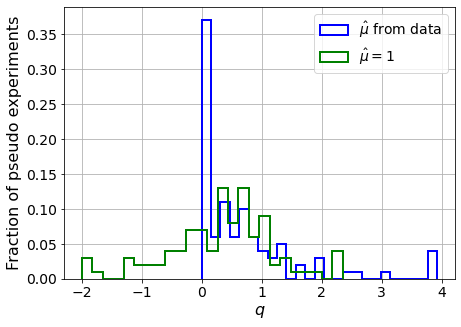

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  8824.86515126  8632.68020452  8374.02657672
  8054.9246173   7663.26306955  7172.24312903  6582.71584883
  5891.88469406  5073.80035689  4097.64326971  2952.71073248
  1595.66494933    44.33100135 -1664.58626605 -3819.52628439]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf 10713.69808231 10615.58535492 10415.6895973
 

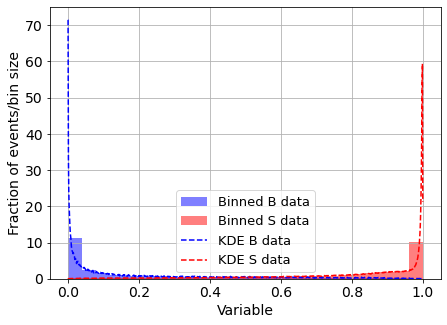

KDE Kernel:  epanechnikov
Background bandwidth:  0.0011635618505359071
Signal bandwidth:  0.0011635618505359071
This may take a while...
1 done
2 done
3 done
4 done


  0%|                                                                   | 3/2000 [00:00<04:24,  7.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23716042332986143
<p_{s}(Sdata)> = 8.890601656159776
<p_{b}(Bdata)> = 15.853638655743788
<p_{s}(Bdata)> = 0.2569300632588685


  0%|▏                                                                  | 6/2000 [00:00<05:00,  6.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2310794384093964
<p_{s}(Sdata)> = 6.5842733848845265
<p_{b}(Bdata)> = 15.843467822869888
<p_{s}(Bdata)> = 0.24608484614912304


  1%|▍                                                                 | 14/2000 [00:02<08:04,  4.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21121390275572388
<p_{s}(Sdata)> = 12.271552641663037
<p_{b}(Bdata)> = 15.886894186448004
<p_{s}(Bdata)> = 0.256268004716832


  1%|▌                                                                 | 18/2000 [00:03<07:59,  4.13it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2543820421277157
<p_{s}(Sdata)> = 17.479787772478076
<p_{b}(Bdata)> = 15.806478656201369
<p_{s}(Bdata)> = 0.2702257641697551


  1%|▊                                                                 | 23/2000 [00:04<06:08,  5.36it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3550126386195837
<p_{s}(Sdata)> = 17.20289643985658
<p_{b}(Bdata)> = 16.329082979321495
<p_{s}(Bdata)> = 0.2654331580282483
muhat = -0.1
<p_{b}(Sdata)> = 0.26563373955571035
<p_{s}(Sdata)> = 2.148698091763271
<p_{b}(Bdata)> = 15.78303452696314
<p_{s}(Bdata)> = 0.2605316347725551


  1%|▊                                                                 | 26/2000 [00:05<04:43,  6.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23089397215659208
<p_{s}(Sdata)> = 1.6751039411352562
<p_{b}(Bdata)> = 15.78122540522832
<p_{s}(Bdata)> = 0.25819682238981095
muhat = -0.1
<p_{b}(Sdata)> = 0.6422060717884275
<p_{s}(Sdata)> = 8.65084543669984
<p_{b}(Bdata)> = 16.100960898370015
<p_{s}(Bdata)> = 0.2468266013103902


  1%|▉                                                                 | 29/2000 [00:05<04:59,  6.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20516067669574428
<p_{s}(Sdata)> = 8.755068545850982
<p_{b}(Bdata)> = 16.058317203434438
<p_{s}(Bdata)> = 0.25605557834288256


  2%|█                                                                 | 34/2000 [00:06<04:54,  6.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42349584909370075
<p_{s}(Sdata)> = 8.43912087492026
<p_{b}(Bdata)> = 16.03381264987195
<p_{s}(Bdata)> = 0.2572157318832733
muhat = -0.1
<p_{b}(Sdata)> = 0.19738716027936207
<p_{s}(Sdata)> = 6.063497693038403
<p_{b}(Bdata)> = 15.28020559811757
<p_{s}(Bdata)> = 0.2610174554876982


  2%|█▎                                                                | 38/2000 [00:07<05:13,  6.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2785856931665587
<p_{s}(Sdata)> = 5.424208078158401
<p_{b}(Bdata)> = 16.009317776703025
<p_{s}(Bdata)> = 0.2557729128538494


  2%|█▍                                                                | 44/2000 [00:08<05:54,  5.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.256056226056474
<p_{s}(Sdata)> = 1.8897228663879604
<p_{b}(Bdata)> = 15.78925900272742
<p_{s}(Bdata)> = 0.26231885364282803
muhat = -0.1
<p_{b}(Sdata)> = 0.17318729721800125
<p_{s}(Sdata)> = 16.035958684499292
<p_{b}(Bdata)> = 15.354146347823928
<p_{s}(Bdata)> = 0.2549132576951484


  2%|█▌                                                                | 46/2000 [00:09<06:03,  5.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38766917706529974
<p_{s}(Sdata)> = 8.73732997519882
<p_{b}(Bdata)> = 15.986626213409469
<p_{s}(Bdata)> = 0.2526689252504572


  2%|█▋                                                                | 50/2000 [00:09<05:16,  6.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19153528124609728
<p_{s}(Sdata)> = 6.40965306844964
<p_{b}(Bdata)> = 15.790483196559277
<p_{s}(Bdata)> = 0.2609313262513454
muhat = -0.1
<p_{b}(Sdata)> = 0.10342196232582794
<p_{s}(Sdata)> = 17.66247839707912
<p_{b}(Bdata)> = 15.680861961874804
<p_{s}(Bdata)> = 0.25986460758878976
muhat = -0.1
<p_{b}(Sdata)> = 0.3163501612859256
<p_{s}(Sdata)> = 2.89654192792232
<p_{b}(Bdata)> = 15.885779830444504
<p_{s}(Bdata)> = 0.2578187714327726


  3%|█▊                                                                | 54/2000 [00:10<04:53,  6.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23358754746261345
<p_{s}(Sdata)> = 9.789453863125786
<p_{b}(Bdata)> = 15.939755744387211
<p_{s}(Bdata)> = 0.2491726863416587
muhat = -0.1
<p_{b}(Sdata)> = 0.16997155983649853
<p_{s}(Sdata)> = 8.147541376845972
<p_{b}(Bdata)> = 16.06859008632932
<p_{s}(Bdata)> = 0.2520508073070367


  3%|█▉                                                                | 58/2000 [00:10<04:08,  7.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30996696986673605
<p_{s}(Sdata)> = 6.2116710495883405
<p_{b}(Bdata)> = 15.966983559480994
<p_{s}(Bdata)> = 0.25827218559365933
muhat = -0.1
<p_{b}(Sdata)> = 0.3877668115569016
<p_{s}(Sdata)> = 8.270526946680786
<p_{b}(Bdata)> = 15.92448154700561
<p_{s}(Bdata)> = 0.2535498705375761


  3%|██                                                                | 61/2000 [00:11<04:04,  7.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28258675031016345
<p_{s}(Sdata)> = 11.098639384239206
<p_{b}(Bdata)> = 15.771718775978218
<p_{s}(Bdata)> = 0.2599836082616315
muhat = -0.1
<p_{b}(Sdata)> = 0.2001233126914456
<p_{s}(Sdata)> = 6.481881329268927
<p_{b}(Bdata)> = 16.108596879924747
<p_{s}(Bdata)> = 0.2535408249488754


  3%|██                                                                | 63/2000 [00:11<05:24,  5.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1486681114953361
<p_{s}(Sdata)> = 15.160426654353806
<p_{b}(Bdata)> = 15.922912789314157
<p_{s}(Bdata)> = 0.253680109772707


  3%|██▏                                                               | 65/2000 [00:11<05:10,  6.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30167447778635426
<p_{s}(Sdata)> = 5.850497826508652
<p_{b}(Bdata)> = 15.630788745662555
<p_{s}(Bdata)> = 0.26031542257285617


  3%|██▎                                                               | 69/2000 [00:12<04:21,  7.40it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2587912985892177
<p_{s}(Sdata)> = 14.358419526896455
<p_{b}(Bdata)> = 16.093300301385383
<p_{s}(Bdata)> = 0.2644930606686234
muhat = 2.1
<p_{b}(Sdata)> = 0.18592858871477735
<p_{s}(Sdata)> = 10.123795053017353
<p_{b}(Bdata)> = 16.01554038498977
<p_{s}(Bdata)> = 0.26957689116472977


  4%|██▍                                                               | 74/2000 [00:13<07:03,  4.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30341739394202716
<p_{s}(Sdata)> = 4.144902532270168
<p_{b}(Bdata)> = 16.017205376202362
<p_{s}(Bdata)> = 0.2564355462106762


  4%|██▋                                                               | 80/2000 [00:14<04:48,  6.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1985000886499421
<p_{s}(Sdata)> = 8.490377958224812
<p_{b}(Bdata)> = 15.96550876666973
<p_{s}(Bdata)> = 0.2536320628009721
muhat = -0.1
<p_{b}(Sdata)> = 0.3248220159690682
<p_{s}(Sdata)> = 7.2500245218073545
<p_{b}(Bdata)> = 15.925777601696696
<p_{s}(Bdata)> = 0.2581144973493508


  4%|██▋                                                               | 82/2000 [00:15<08:20,  3.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17968050027956742
<p_{s}(Sdata)> = 12.5097541839198
<p_{b}(Bdata)> = 15.875666058863834
<p_{s}(Bdata)> = 0.2577264065054402


  4%|██▉                                                               | 89/2000 [00:16<05:00,  6.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3216688257388944
<p_{s}(Sdata)> = 10.364005610719175
<p_{b}(Bdata)> = 15.773717701329534
<p_{s}(Bdata)> = 0.2565028747870949
muhat = 2.1
<p_{b}(Sdata)> = 0.18981118839025374
<p_{s}(Sdata)> = 19.14522661553359
<p_{b}(Bdata)> = 15.640494415218091
<p_{s}(Bdata)> = 0.26300869336583615


  5%|███▏                                                              | 98/2000 [00:18<06:23,  4.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3127718826753539
<p_{s}(Sdata)> = 6.812801888346854
<p_{b}(Bdata)> = 16.10259363055084
<p_{s}(Bdata)> = 0.2526880848989538
muhat = -0.1
<p_{b}(Sdata)> = 0.27600359351673304
<p_{s}(Sdata)> = 2.663886604308704
<p_{b}(Bdata)> = 15.945222910968326
<p_{s}(Bdata)> = 0.2607597215385459


  5%|███▌                                                             | 108/2000 [00:20<06:49,  4.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2698981464749719
<p_{s}(Sdata)> = 2.100437930991134
<p_{b}(Bdata)> = 15.83913875436278
<p_{s}(Bdata)> = 0.2612652607205341


  6%|███▌                                                             | 111/2000 [00:21<06:07,  5.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2266469365731901
<p_{s}(Sdata)> = 2.8735507788937693
<p_{b}(Bdata)> = 15.721751076570946
<p_{s}(Bdata)> = 0.2610475258933563
muhat = 2.1
<p_{b}(Sdata)> = 0.21335187841996198
<p_{s}(Sdata)> = 17.985360753079124
<p_{b}(Bdata)> = 16.08118388586646
<p_{s}(Bdata)> = 0.2653929285192615


  6%|███▊                                                             | 117/2000 [00:22<05:03,  6.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3240371763456126
<p_{s}(Sdata)> = 6.936694252937727
<p_{b}(Bdata)> = 16.090753508943504
<p_{s}(Bdata)> = 0.2594896970124434
muhat = 2.1
<p_{b}(Sdata)> = 0.11679471185972005
<p_{s}(Sdata)> = 18.704852183352227
<p_{b}(Bdata)> = 15.891304734979059
<p_{s}(Bdata)> = 0.27183813531066436


  6%|███▉                                                             | 120/2000 [00:23<05:08,  6.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29098552692591045
<p_{s}(Sdata)> = 4.750126399904231
<p_{b}(Bdata)> = 16.033566960767608
<p_{s}(Bdata)> = 0.25318022630436376


  6%|███▉                                                             | 122/2000 [00:23<06:13,  5.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23170616488654294
<p_{s}(Sdata)> = 5.914665862765293
<p_{b}(Bdata)> = 15.815104440945625
<p_{s}(Bdata)> = 0.2595681282935011


  6%|████                                                             | 126/2000 [00:24<04:22,  7.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1404456847975214
<p_{s}(Sdata)> = 14.51739370217959
<p_{b}(Bdata)> = 15.638457865625801
<p_{s}(Bdata)> = 0.25725013102650973
muhat = 2.1
<p_{b}(Sdata)> = 0.15022052056516913
<p_{s}(Sdata)> = 25.158147349725464
<p_{b}(Bdata)> = 15.836863545689344
<p_{s}(Bdata)> = 0.2672550315449111


  6%|████▏                                                            | 129/2000 [00:24<04:17,  7.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.874928517986354
<p_{s}(Sdata)> = 1.0539897261416602
<p_{b}(Bdata)> = 15.722143422350475
<p_{s}(Bdata)> = 0.2534540949298568
muhat = -0.1
<p_{b}(Sdata)> = 0.27848869315259883
<p_{s}(Sdata)> = 2.902911243767068
<p_{b}(Bdata)> = 15.598593198703
<p_{s}(Bdata)> = 0.255452476053225
muhat = 2.1
<p_{b}(Sdata)> = 0.2685325061282501
<p_{s}(Sdata)> = 15.658258547637152
<p_{b}(Bdata)> = 15.387356968872307
<p_{s}(Bdata)> = 0.2728276066540431


  7%|████▎                                                            | 133/2000 [00:25<04:43,  6.59it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20714791420130968
<p_{s}(Sdata)> = 15.32668322797492
<p_{b}(Bdata)> = 15.774594157992494
<p_{s}(Bdata)> = 0.27036850154614944
muhat = -0.1
<p_{b}(Sdata)> = 0.17598268230295114
<p_{s}(Sdata)> = 13.96750939323057
<p_{b}(Bdata)> = 15.910634098423444
<p_{s}(Bdata)> = 0.2512100519788977


  7%|████▍                                                            | 136/2000 [00:25<04:29,  6.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2785002935162184
<p_{s}(Sdata)> = 2.1785327442283307
<p_{b}(Bdata)> = 16.12174990448334
<p_{s}(Bdata)> = 0.25974092923136655
muhat = -0.1
<p_{b}(Sdata)> = 0.3752465870484349
<p_{s}(Sdata)> = 11.40773429423267
<p_{b}(Bdata)> = 15.496762055421847
<p_{s}(Bdata)> = 0.25125624961878723


  7%|████▌                                                            | 140/2000 [00:26<04:55,  6.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.303084217714851
<p_{s}(Sdata)> = 6.929215945605701
<p_{b}(Bdata)> = 15.693320858862808
<p_{s}(Bdata)> = 0.2583076310332787
muhat = -0.1
<p_{b}(Sdata)> = 0.44775221088410677
<p_{s}(Sdata)> = 4.599278062858935
<p_{b}(Bdata)> = 15.98697632225398
<p_{s}(Bdata)> = 0.2546760349580397
muhat = -0.1
<p_{b}(Sdata)> = 0.19745893564362535
<p_{s}(Sdata)> = 12.462479290831329
<p_{b}(Bdata)> = 15.57231127242671
<p_{s}(Bdata)> = 0.25220353074865903


  7%|████▋                                                            | 146/2000 [00:27<05:17,  5.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2672248485234328
<p_{s}(Sdata)> = 7.986656588204885
<p_{b}(Bdata)> = 15.911181757505634
<p_{s}(Bdata)> = 0.25566136730703903


  7%|████▊                                                            | 149/2000 [00:28<04:46,  6.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21808990800107916
<p_{s}(Sdata)> = 9.447503382417493
<p_{b}(Bdata)> = 15.786401152551516
<p_{s}(Bdata)> = 0.2604134717894595


  8%|████▉                                                            | 151/2000 [00:28<05:12,  5.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2203428820608868
<p_{s}(Sdata)> = 12.980047440765015
<p_{b}(Bdata)> = 15.688457277015248
<p_{s}(Bdata)> = 0.2536040212195494


  8%|█████                                                            | 157/2000 [00:29<03:39,  8.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7484018753521531
<p_{s}(Sdata)> = 8.454119005468652
<p_{b}(Bdata)> = 15.780564988794564
<p_{s}(Bdata)> = 0.25561901876316373
muhat = -0.1
<p_{b}(Sdata)> = 0.22798375314684335
<p_{s}(Sdata)> = 8.014696507893577
<p_{b}(Bdata)> = 16.18587554412406
<p_{s}(Bdata)> = 0.2595446461957672
muhat = -0.1
<p_{b}(Sdata)> = 0.2831605019446855
<p_{s}(Sdata)> = 2.8976082446385316
<p_{b}(Bdata)> = 15.882426297909523
<p_{s}(Bdata)> = 0.2612903180129397
muhat = -0.1
<p_{b}(Sdata)> = 0.26186778254931725
<p_{s}(Sdata)> = 6.188183793617011
<p_{b}(Bdata)> = 15.711541011049235
<p_{s}(Bdata)> = 0.25388463723508864


  8%|█████▏                                                           | 161/2000 [00:30<04:24,  6.95it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15583572099254941
<p_{s}(Sdata)> = 12.689064913925055
<p_{b}(Bdata)> = 15.928940485536144
<p_{s}(Bdata)> = 0.2664836882405598
muhat = -0.1
<p_{b}(Sdata)> = 0.155268134552721
<p_{s}(Sdata)> = 13.551760700569716
<p_{b}(Bdata)> = 15.83376451567974
<p_{s}(Bdata)> = 0.25564312394775224


  8%|█████▍                                                           | 166/2000 [00:31<06:21,  4.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17898883705331767
<p_{s}(Sdata)> = 8.78270357126441
<p_{b}(Bdata)> = 15.451756165576867
<p_{s}(Bdata)> = 0.25588276177338615


  9%|█████▋                                                           | 175/2000 [00:33<07:46,  3.92it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2475472740543651
<p_{s}(Sdata)> = 23.150195349737324
<p_{b}(Bdata)> = 15.717498051133491
<p_{s}(Bdata)> = 0.2617485899463958


  9%|█████▉                                                           | 184/2000 [00:35<06:36,  4.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18232769818008182
<p_{s}(Sdata)> = 8.510527687986192
<p_{b}(Bdata)> = 15.865097065454206
<p_{s}(Bdata)> = 0.2579622143638144


  9%|██████▏                                                          | 189/2000 [00:36<07:21,  4.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.37599690514750617
<p_{s}(Sdata)> = 16.681617231681166
<p_{b}(Bdata)> = 15.515933959496255
<p_{s}(Bdata)> = 0.2650901204634541


 10%|██████▎                                                          | 193/2000 [00:37<05:24,  5.57it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2075931457251279
<p_{s}(Sdata)> = 22.80695294630748
<p_{b}(Bdata)> = 15.852827872802552
<p_{s}(Bdata)> = 0.2643670926753372


 10%|██████▎                                                          | 196/2000 [00:38<05:08,  5.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39714564202324903
<p_{s}(Sdata)> = 3.5311468049571113
<p_{b}(Bdata)> = 15.801528459269118
<p_{s}(Bdata)> = 0.25390084937451274
muhat = 2.1
<p_{b}(Sdata)> = 0.16382277703903175
<p_{s}(Sdata)> = 16.55791241076956
<p_{b}(Bdata)> = 15.790576644925958
<p_{s}(Bdata)> = 0.2609234446225885


 10%|██████▋                                                          | 207/2000 [00:41<09:08,  3.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26899690305641916
<p_{s}(Sdata)> = 11.036280013363884
<p_{b}(Bdata)> = 15.772565833728255
<p_{s}(Bdata)> = 0.25315334455287


 11%|██████▉                                                          | 212/2000 [00:41<05:22,  5.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18608772712838803
<p_{s}(Sdata)> = 13.024367066838662
<p_{b}(Bdata)> = 15.897558025033122
<p_{s}(Bdata)> = 0.25558338450833806
muhat = -0.1
<p_{b}(Sdata)> = 0.1741103501035328
<p_{s}(Sdata)> = 10.072284563477554
<p_{b}(Bdata)> = 16.23748727056992
<p_{s}(Bdata)> = 0.2576606479446277


 11%|██████▉                                                          | 215/2000 [00:42<04:32,  6.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24973517603501214
<p_{s}(Sdata)> = 4.320244361807671
<p_{b}(Bdata)> = 15.853409296635624
<p_{s}(Bdata)> = 0.25594284678651524
muhat = -0.1
<p_{b}(Sdata)> = 0.35263028474375296
<p_{s}(Sdata)> = 7.742398671949215
<p_{b}(Bdata)> = 16.036795927970164
<p_{s}(Bdata)> = 0.25548239662869227


 11%|███████                                                          | 219/2000 [00:42<03:57,  7.48it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.11186873329113431
<p_{s}(Sdata)> = 31.14241415366898
<p_{b}(Bdata)> = 15.667571967164644
<p_{s}(Bdata)> = 0.2698540859609299
muhat = -0.1
<p_{b}(Sdata)> = 0.17909987736506774
<p_{s}(Sdata)> = 4.937000892351727
<p_{b}(Bdata)> = 15.486433102781849
<p_{s}(Bdata)> = 0.2611184514494787


 11%|███████▏                                                         | 222/2000 [00:43<04:06,  7.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3046204070526085
<p_{s}(Sdata)> = 8.688321025578901
<p_{b}(Bdata)> = 15.760273452541394
<p_{s}(Bdata)> = 0.26229863353926985
muhat = 2.1
<p_{b}(Sdata)> = 0.17544551123923027
<p_{s}(Sdata)> = 16.16692074149579
<p_{b}(Bdata)> = 15.849275785153823
<p_{s}(Bdata)> = 0.2636904461372447


 11%|███████▎                                                         | 226/2000 [00:44<04:54,  6.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3332171225970585
<p_{s}(Sdata)> = 10.565548523754801
<p_{b}(Bdata)> = 15.682926513522894
<p_{s}(Bdata)> = 0.2575394799886057


 11%|███████▍                                                         | 227/2000 [00:44<04:48,  6.15it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.38991728747376037
<p_{s}(Sdata)> = 13.548845108365596
<p_{b}(Bdata)> = 15.826081640157696
<p_{s}(Bdata)> = 0.2695658852280114


 12%|███████▌                                                         | 231/2000 [00:45<06:35,  4.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.345305740142439
<p_{s}(Sdata)> = 18.559198595071003
<p_{b}(Bdata)> = 15.73677347173281
<p_{s}(Bdata)> = 0.2538276335832747


 12%|███████▊                                                         | 241/2000 [00:47<05:06,  5.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.266378734604763
<p_{s}(Sdata)> = 11.393678510756509
<p_{b}(Bdata)> = 16.10284196791373
<p_{s}(Bdata)> = 0.25629575143543953


 12%|███████▉                                                         | 243/2000 [00:47<04:01,  7.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4128644991365963
<p_{s}(Sdata)> = 3.045421691207877
<p_{b}(Bdata)> = 15.90779220269919
<p_{s}(Bdata)> = 0.2570283880293263
muhat = 2.1
<p_{b}(Sdata)> = 0.13489432991026584
<p_{s}(Sdata)> = 17.965060509879443
<p_{b}(Bdata)> = 15.767303069211106
<p_{s}(Bdata)> = 0.26113198922682035
muhat = 2.1
<p_{b}(Sdata)> = 0.16948443960970408
<p_{s}(Sdata)> = 16.92394648360759
<p_{b}(Bdata)> = 15.942790127228802
<p_{s}(Bdata)> = 0.2681735287281899


 12%|███████▉                                                         | 245/2000 [00:47<03:23,  8.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2765156840400969
<p_{s}(Sdata)> = 6.865676958266733
<p_{b}(Bdata)> = 15.701474393503794
<p_{s}(Bdata)> = 0.25655900089686073


 12%|████████                                                         | 248/2000 [00:48<03:38,  8.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.13988675245936683
<p_{s}(Sdata)> = 4.93911955079414
<p_{b}(Bdata)> = 15.699259964613436
<p_{s}(Bdata)> = 0.2545829913312333
muhat = 2.1
<p_{b}(Sdata)> = 0.18721075819431957
<p_{s}(Sdata)> = 11.019659957415358
<p_{b}(Bdata)> = 15.928618689382462
<p_{s}(Bdata)> = 0.2699299826736365


 12%|████████▏                                                        | 250/2000 [00:48<04:35,  6.36it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.32554071435330345
<p_{s}(Sdata)> = 20.24768248099079
<p_{b}(Bdata)> = 15.791858120836828
<p_{s}(Bdata)> = 0.26977778484793724


 13%|████████▎                                                        | 255/2000 [00:49<05:10,  5.61it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15093295284160949
<p_{s}(Sdata)> = 25.72821699994183
<p_{b}(Bdata)> = 15.894152534571877
<p_{s}(Bdata)> = 0.25722582845613695
muhat = -0.1
<p_{b}(Sdata)> = 0.40173706641956786
<p_{s}(Sdata)> = 7.818707617899961
<p_{b}(Bdata)> = 15.834892176668632
<p_{s}(Bdata)> = 0.25705162006252114


 13%|████████▎                                                        | 257/2000 [00:50<06:36,  4.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21101388660849218
<p_{s}(Sdata)> = 6.925292585101484
<p_{b}(Bdata)> = 15.812838083613467
<p_{s}(Bdata)> = 0.251517402254087


 13%|████████▍                                                        | 260/2000 [00:50<06:32,  4.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21178793133786766
<p_{s}(Sdata)> = 11.82104870509567
<p_{b}(Bdata)> = 16.00136924874427
<p_{s}(Bdata)> = 0.24967095256782088


 14%|████████▊                                                        | 271/2000 [00:52<04:22,  6.60it/s]

muhat = 2.1
<p_{b}(Sdata)> = 1.296316546626555
<p_{s}(Sdata)> = 18.387490773724384
<p_{b}(Bdata)> = 16.08730034180824
<p_{s}(Bdata)> = 0.26585480447441506
muhat = -0.1
<p_{b}(Sdata)> = 0.20108766542774204
<p_{s}(Sdata)> = 11.944737848212876
<p_{b}(Bdata)> = 16.077378238881504
<p_{s}(Bdata)> = 0.25562754463611415


 14%|█████████                                                        | 277/2000 [00:53<04:17,  6.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1779596176082464
<p_{s}(Sdata)> = 3.4965782782814663
<p_{b}(Bdata)> = 15.913951115394868
<p_{s}(Bdata)> = 0.2611196772049288
muhat = -0.1
<p_{b}(Sdata)> = 0.2605390538510573
<p_{s}(Sdata)> = 3.119358646089844
<p_{b}(Bdata)> = 16.090588309195976
<p_{s}(Bdata)> = 0.25977479420897215


 14%|█████████▎                                                       | 285/2000 [00:55<03:38,  7.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22944430420361991
<p_{s}(Sdata)> = 13.713344399439116
<p_{b}(Bdata)> = 15.838299697094728
<p_{s}(Bdata)> = 0.2534579349698009
muhat = -0.1
<p_{b}(Sdata)> = 0.3635244101427407
<p_{s}(Sdata)> = 3.821114230661553
<p_{b}(Bdata)> = 15.673238686039273
<p_{s}(Bdata)> = 0.25787111673851404
muhat = -0.1
<p_{b}(Sdata)> = 0.22395641772487532
<p_{s}(Sdata)> = 7.155778025829406
<p_{b}(Bdata)> = 16.039233451444247
<p_{s}(Bdata)> = 0.2573121067980581
muhat = -0.1
<p_{b}(Sdata)> = 0.2602133931343651
<p_{s}(Sdata)> = 13.842323479259031
<p_{b}(Bdata)> = 15.94485804669656
<p_{s}(Bdata)> = 0.25472247983297225


 14%|█████████▎                                                       | 287/2000 [00:55<03:48,  7.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5810770514041529
<p_{s}(Sdata)> = 7.986662870735355
<p_{b}(Bdata)> = 16.225402284587563
<p_{s}(Bdata)> = 0.2548186988036161


 14%|█████████▎                                                       | 288/2000 [00:55<04:28,  6.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1987709726478931
<p_{s}(Sdata)> = 4.435524857975076
<p_{b}(Bdata)> = 16.13358944987315
<p_{s}(Bdata)> = 0.2538244557348589


 15%|█████████▌                                                       | 294/2000 [00:56<04:13,  6.72it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23383988594049016
<p_{s}(Sdata)> = 13.586032288743798
<p_{b}(Bdata)> = 15.960278949154581
<p_{s}(Bdata)> = 0.26739040718116314
muhat = -0.1
<p_{b}(Sdata)> = 0.20474585642810716
<p_{s}(Sdata)> = 11.489962235541961
<p_{b}(Bdata)> = 16.015516365552912
<p_{s}(Bdata)> = 0.25570611222224376


 15%|█████████▋                                                       | 298/2000 [00:57<04:46,  5.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23309351965878908
<p_{s}(Sdata)> = 4.109570805250085
<p_{b}(Bdata)> = 15.560702200723295
<p_{s}(Bdata)> = 0.2577844370174309


 15%|█████████▊                                                       | 300/2000 [00:57<04:01,  7.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23045965675767707
<p_{s}(Sdata)> = 10.870485723332315
<p_{b}(Bdata)> = 16.129093024344495
<p_{s}(Bdata)> = 0.250925932941531


 16%|██████████                                                       | 310/2000 [01:00<07:55,  3.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20457397641891792
<p_{s}(Sdata)> = 9.350021833382621
<p_{b}(Bdata)> = 16.217888262250835
<p_{s}(Bdata)> = 0.2585024544107213


 16%|██████████▏                                                      | 315/2000 [01:01<05:57,  4.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16445071446214635
<p_{s}(Sdata)> = 12.986521401302582
<p_{b}(Bdata)> = 15.944387655305832
<p_{s}(Bdata)> = 0.25428376910267064
muhat = -0.1
<p_{b}(Sdata)> = 0.14438519981505377
<p_{s}(Sdata)> = 18.19502859765846
<p_{b}(Bdata)> = 15.660749602597424
<p_{s}(Bdata)> = 0.25452221050105145


 16%|██████████▍                                                      | 321/2000 [01:02<04:17,  6.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19720447393943696
<p_{s}(Sdata)> = 3.1186986308504823
<p_{b}(Bdata)> = 15.618151857633803
<p_{s}(Bdata)> = 0.25968336364414624
muhat = 2.1
<p_{b}(Sdata)> = 0.319078001237283
<p_{s}(Sdata)> = 15.532703430160502
<p_{b}(Bdata)> = 15.839600767541002
<p_{s}(Bdata)> = 0.2647871959743943
muhat = -0.1
<p_{b}(Sdata)> = 0.18077780145358122
<p_{s}(Sdata)> = 3.650795789953649
<p_{b}(Bdata)> = 16.01016925170764
<p_{s}(Bdata)> = 0.2568555008835349


 16%|██████████▌                                                      | 325/2000 [01:03<05:26,  5.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3764149608885352
<p_{s}(Sdata)> = 13.144054422686585
<p_{b}(Bdata)> = 15.798351020041473
<p_{s}(Bdata)> = 0.26830200759243583


 16%|██████████▋                                                      | 330/2000 [01:03<04:20,  6.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31850993594800214
<p_{s}(Sdata)> = 5.714683385786464
<p_{b}(Bdata)> = 15.842906809724846
<p_{s}(Bdata)> = 0.25589216719889574


 17%|██████████▉                                                      | 336/2000 [01:05<04:24,  6.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43641254885640623
<p_{s}(Sdata)> = 4.893109622988345
<p_{b}(Bdata)> = 15.540832291301921
<p_{s}(Bdata)> = 0.2604605656723209
muhat = -0.1
<p_{b}(Sdata)> = 0.09851358415998214
<p_{s}(Sdata)> = 10.55842073334952
<p_{b}(Bdata)> = 16.144618977633158
<p_{s}(Bdata)> = 0.24949564455060932


 17%|███████████▏                                                     | 346/2000 [01:07<05:31,  4.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24618275134742093
<p_{s}(Sdata)> = 9.086987800770292
<p_{b}(Bdata)> = 15.737670733009363
<p_{s}(Bdata)> = 0.252286367922553


 17%|███████████▎                                                     | 349/2000 [01:08<04:43,  5.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2660561878413002
<p_{s}(Sdata)> = 5.759023283973591
<p_{b}(Bdata)> = 16.108107921811445
<p_{s}(Bdata)> = 0.25642678790850926


 18%|███████████▌                                                     | 355/2000 [01:09<04:24,  6.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.13892849619951858
<p_{s}(Sdata)> = 7.86059579833569
<p_{b}(Bdata)> = 16.0395201813096
<p_{s}(Bdata)> = 0.2588894016295997


 18%|███████████▋                                                     | 360/2000 [01:10<05:39,  4.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4479378169254942
<p_{s}(Sdata)> = 6.670790227607452
<p_{b}(Bdata)> = 15.913378948042276
<p_{s}(Bdata)> = 0.2573896749202506


 18%|███████████▊                                                     | 365/2000 [01:11<04:13,  6.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18625108997575723
<p_{s}(Sdata)> = 11.091444397578837
<p_{b}(Bdata)> = 15.7436171548948
<p_{s}(Bdata)> = 0.25624626444088794
muhat = 2.1
<p_{b}(Sdata)> = 0.22413655606183622
<p_{s}(Sdata)> = 12.40936551107399
<p_{b}(Bdata)> = 15.689950190248549
<p_{s}(Bdata)> = 0.27084698521007494


 18%|████████████                                                     | 370/2000 [01:12<07:46,  3.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2632389500894917
<p_{s}(Sdata)> = 8.910476893000354
<p_{b}(Bdata)> = 15.722511637835337
<p_{s}(Bdata)> = 0.24568396160414044


 19%|████████████▏                                                    | 376/2000 [01:14<07:57,  3.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2978832183956687
<p_{s}(Sdata)> = 8.617676743891245
<p_{b}(Bdata)> = 15.65829985482447
<p_{s}(Bdata)> = 0.25495798586663837


 19%|████████████▎                                                    | 378/2000 [01:14<07:37,  3.55it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2767119563315815
<p_{s}(Sdata)> = 13.484664321684507
<p_{b}(Bdata)> = 15.888862455339304
<p_{s}(Bdata)> = 0.27003509704753176


 19%|████████████▍                                                    | 384/2000 [01:16<07:33,  3.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24284285422823357
<p_{s}(Sdata)> = 6.027589498488621
<p_{b}(Bdata)> = 16.012241926226842
<p_{s}(Bdata)> = 0.2617817139204535


 19%|████████████▌                                                    | 387/2000 [01:17<06:25,  4.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15205727971835536
<p_{s}(Sdata)> = 7.858563432244596
<p_{b}(Bdata)> = 15.869017106396383
<p_{s}(Bdata)> = 0.2545562531742449


 20%|████████████▋                                                    | 392/2000 [01:18<04:41,  5.71it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1615449300676706
<p_{s}(Sdata)> = 14.069448787182273
<p_{b}(Bdata)> = 15.9491140629984
<p_{s}(Bdata)> = 0.26700346411931475


 20%|████████████▊                                                    | 393/2000 [01:18<04:20,  6.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26189430818079124
<p_{s}(Sdata)> = 8.968063809035577
<p_{b}(Bdata)> = 15.674341484259724
<p_{s}(Bdata)> = 0.2551001550388031


 20%|████████████▉                                                    | 399/2000 [01:19<07:48,  3.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29659358770877703
<p_{s}(Sdata)> = 4.050321404203259
<p_{b}(Bdata)> = 15.87519951083522
<p_{s}(Bdata)> = 0.2560372210552353


 20%|█████████████                                                    | 403/2000 [01:20<04:57,  5.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24831253331017936
<p_{s}(Sdata)> = 5.801248431086667
<p_{b}(Bdata)> = 15.726965630479615
<p_{s}(Bdata)> = 0.25761081351588433


 20%|█████████████▏                                                   | 404/2000 [01:20<05:07,  5.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23202532827123848
<p_{s}(Sdata)> = 12.614825127341074
<p_{b}(Bdata)> = 15.859048087368715
<p_{s}(Bdata)> = 0.25390416236616464


 20%|█████████████▎                                                   | 408/2000 [01:21<05:36,  4.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4349555539430712
<p_{s}(Sdata)> = 6.659816272754675
<p_{b}(Bdata)> = 15.663485361094292
<p_{s}(Bdata)> = 0.254292074239771


 21%|█████████████▍                                                   | 412/2000 [01:22<03:52,  6.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.217831358749215
<p_{s}(Sdata)> = 5.194209336796769
<p_{b}(Bdata)> = 15.713636283717205
<p_{s}(Bdata)> = 0.2588920226530168
muhat = -0.1
<p_{b}(Sdata)> = 0.2673844167060843
<p_{s}(Sdata)> = 6.944428549647227
<p_{b}(Bdata)> = 15.653342989435235
<p_{s}(Bdata)> = 0.2551649902550318


 21%|█████████████▍                                                   | 413/2000 [01:22<04:01,  6.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5897602803131985
<p_{s}(Sdata)> = 7.062214895532767
<p_{b}(Bdata)> = 15.659298788654192
<p_{s}(Bdata)> = 0.25735642578037854


 21%|█████████████▋                                                   | 421/2000 [01:24<05:01,  5.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16113864532802766
<p_{s}(Sdata)> = 9.310978314997898
<p_{b}(Bdata)> = 15.825053253221531
<p_{s}(Bdata)> = 0.257238708630981
muhat = -0.1
<p_{b}(Sdata)> = 0.23520757262717745
<p_{s}(Sdata)> = 10.063626098377227
<p_{b}(Bdata)> = 15.622379705632323
<p_{s}(Bdata)> = 0.2580732291832771


 21%|█████████████▊                                                   | 425/2000 [01:24<04:29,  5.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24107771423425398
<p_{s}(Sdata)> = 8.434411001531378
<p_{b}(Bdata)> = 15.847827296618147
<p_{s}(Bdata)> = 0.25373108362281216


 21%|█████████████▉                                                   | 428/2000 [01:25<05:18,  4.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.334290831083551
<p_{s}(Sdata)> = 6.636170770218712
<p_{b}(Bdata)> = 15.768262747508125
<p_{s}(Bdata)> = 0.25559130739493063


 22%|██████████████▏                                                  | 436/2000 [01:27<04:45,  5.48it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15458156752114668
<p_{s}(Sdata)> = 14.917688338253242
<p_{b}(Bdata)> = 15.778029220674622
<p_{s}(Bdata)> = 0.2716971640524979


 22%|██████████████▎                                                  | 439/2000 [01:27<04:15,  6.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2977219033167526
<p_{s}(Sdata)> = 22.3558716387139
<p_{b}(Bdata)> = 16.146941324689845
<p_{s}(Bdata)> = 0.26679505128769915


 22%|██████████████▍                                                  | 444/2000 [01:28<04:03,  6.39it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1592252492069184
<p_{s}(Sdata)> = 18.176002522491167
<p_{b}(Bdata)> = 15.74980748863835
<p_{s}(Bdata)> = 0.2647706255456181
muhat = -0.1
<p_{b}(Sdata)> = 0.3327045195688487
<p_{s}(Sdata)> = 5.927483147927456
<p_{b}(Bdata)> = 15.963004831523055
<p_{s}(Bdata)> = 0.2534284673745142


 23%|██████████████▉                                                  | 458/2000 [01:31<04:42,  5.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18057623549733895
<p_{s}(Sdata)> = 11.237554524589136
<p_{b}(Bdata)> = 15.773123986414912
<p_{s}(Bdata)> = 0.25302925748865224
muhat = -0.1
<p_{b}(Sdata)> = 0.3055474332673684
<p_{s}(Sdata)> = 8.173442387466292
<p_{b}(Bdata)> = 16.08527241969416
<p_{s}(Bdata)> = 0.25407000968822024


 23%|███████████████▏                                                 | 467/2000 [01:34<04:47,  5.33it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14913078806364824
<p_{s}(Sdata)> = 24.937351156332824
<p_{b}(Bdata)> = 15.73149490390989
<p_{s}(Bdata)> = 0.2682127079951749
muhat = 2.1
<p_{b}(Sdata)> = 0.05208211277253151
<p_{s}(Sdata)> = 26.81816597603239
<p_{b}(Bdata)> = 15.740743103912825
<p_{s}(Bdata)> = 0.2647637746988148
muhat = -0.1
<p_{b}(Sdata)> = 0.30899383066857505
<p_{s}(Sdata)> = 7.05493082126569
<p_{b}(Bdata)> = 16.02661534444292
<p_{s}(Bdata)> = 0.25422950109339304


 23%|███████████████▏                                                 | 469/2000 [01:34<03:33,  7.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.09016873459739445
<p_{s}(Sdata)> = 25.975401590641695
<p_{b}(Bdata)> = 15.878670417160889
<p_{s}(Bdata)> = 0.254037438969326


 24%|███████████████▍                                                 | 474/2000 [01:35<03:42,  6.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32138554398901376
<p_{s}(Sdata)> = 18.06114630622362
<p_{b}(Bdata)> = 16.086542913988442
<p_{s}(Bdata)> = 0.25128957824304154
muhat = -0.1
<p_{b}(Sdata)> = 0.27541013805143555
<p_{s}(Sdata)> = 6.076438279321824
<p_{b}(Bdata)> = 15.883554463106307
<p_{s}(Bdata)> = 0.25477456021970385
muhat = -0.1
<p_{b}(Sdata)> = 0.21348727918944618
<p_{s}(Sdata)> = 8.40167290358354
<p_{b}(Bdata)> = 15.924868385422258
<p_{s}(Bdata)> = 0.2593776038098616


 24%|███████████████▌                                                 | 478/2000 [01:35<03:00,  8.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16915898026871756
<p_{s}(Sdata)> = 10.470623025230367
<p_{b}(Bdata)> = 15.968832957633067
<p_{s}(Bdata)> = 0.2545775391964135
muhat = 2.1
<p_{b}(Sdata)> = 0.15713856191749806
<p_{s}(Sdata)> = 24.15196198835664
<p_{b}(Bdata)> = 15.824070232403892
<p_{s}(Bdata)> = 0.2605660700934201


 24%|███████████████▋                                                 | 484/2000 [01:37<04:35,  5.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4947558189629177
<p_{s}(Sdata)> = 1.6728407869919502
<p_{b}(Bdata)> = 16.157767899626347
<p_{s}(Bdata)> = 0.25484132864858783


 24%|███████████████▊                                                 | 488/2000 [01:37<05:11,  4.85it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.10702877476085564
<p_{s}(Sdata)> = 13.796236985069692
<p_{b}(Bdata)> = 15.938955101114566
<p_{s}(Bdata)> = 0.27413474997237475


 25%|████████████████▎                                                | 502/2000 [01:40<04:07,  6.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24654985072163202
<p_{s}(Sdata)> = 8.205696193111143
<p_{b}(Bdata)> = 15.596408584709561
<p_{s}(Bdata)> = 0.25677192196251925
muhat = -0.1
<p_{b}(Sdata)> = 0.6624403563715843
<p_{s}(Sdata)> = 8.621769911776706
<p_{b}(Bdata)> = 15.74609261620432
<p_{s}(Bdata)> = 0.25185277524391997


 25%|████████████████▍                                                | 504/2000 [01:41<05:48,  4.30it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15979083194516958
<p_{s}(Sdata)> = 25.23452585353343
<p_{b}(Bdata)> = 15.884816860718477
<p_{s}(Bdata)> = 0.2642847530655074


 25%|████████████████▍                                                | 507/2000 [01:42<05:49,  4.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25152935990962005
<p_{s}(Sdata)> = 1.5770937357474657
<p_{b}(Bdata)> = 16.18082357182152
<p_{s}(Bdata)> = 0.2571507010152487


 26%|████████████████▋                                                | 513/2000 [01:43<04:33,  5.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.9304314702261555
<p_{s}(Sdata)> = 9.28618687056231
<p_{b}(Bdata)> = 15.74995404254503
<p_{s}(Bdata)> = 0.2569901061514131
muhat = -0.1
<p_{b}(Sdata)> = 0.26421149273832695
<p_{s}(Sdata)> = 4.269058873719632
<p_{b}(Bdata)> = 15.8270887040769
<p_{s}(Bdata)> = 0.2493679171209489


 26%|████████████████▊                                                | 518/2000 [01:44<05:45,  4.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36887680065636924
<p_{s}(Sdata)> = 11.63754875759395
<p_{b}(Bdata)> = 15.868010976367612
<p_{s}(Bdata)> = 0.24938147928128818


 26%|█████████████████                                                | 525/2000 [01:46<04:25,  5.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.14972793965502718
<p_{s}(Sdata)> = 2.6021528720391265
<p_{b}(Bdata)> = 15.743572555206754
<p_{s}(Bdata)> = 0.2589831056618007
muhat = -0.1
<p_{b}(Sdata)> = 0.12795142384104147
<p_{s}(Sdata)> = 16.708722447949988
<p_{b}(Bdata)> = 15.741928262331651
<p_{s}(Bdata)> = 0.25251593318787174
muhat = 2.1
<p_{b}(Sdata)> = 0.18777892663155424
<p_{s}(Sdata)> = 13.895567152419824
<p_{b}(Bdata)> = 15.700569522076776
<p_{s}(Bdata)> = 0.2676163525488801


 26%|█████████████████▏                                               | 530/2000 [01:47<04:09,  5.90it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17933598670666887
<p_{s}(Sdata)> = 14.186159906793401
<p_{b}(Bdata)> = 15.739923153703476
<p_{s}(Bdata)> = 0.26946549880196213
muhat = -0.1
<p_{b}(Sdata)> = 0.276395810646701
<p_{s}(Sdata)> = 4.124141908524212
<p_{b}(Bdata)> = 16.126235297284488
<p_{s}(Bdata)> = 0.26145546223701466


 27%|█████████████████▌                                               | 539/2000 [01:48<03:54,  6.23it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14232342643262647
<p_{s}(Sdata)> = 19.279438924801166
<p_{b}(Bdata)> = 15.769257735330074
<p_{s}(Bdata)> = 0.2674665024112219
muhat = 2.1
<p_{b}(Sdata)> = 0.26611545368460154
<p_{s}(Sdata)> = 17.551088102788793
<p_{b}(Bdata)> = 15.855587545561
<p_{s}(Bdata)> = 0.27810091774416396


 28%|█████████████████▉                                               | 553/2000 [01:51<03:35,  6.72it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21043164332405687
<p_{s}(Sdata)> = 24.04784022229142
<p_{b}(Bdata)> = 15.914157483842022
<p_{s}(Bdata)> = 0.2689414374819527
muhat = -0.1
<p_{b}(Sdata)> = 0.3587651951289311
<p_{s}(Sdata)> = 3.8484890067662127
<p_{b}(Bdata)> = 16.034745016621734
<p_{s}(Bdata)> = 0.252125242075009


 29%|██████████████████▌                                              | 571/2000 [01:56<04:43,  5.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18606858081518401
<p_{s}(Sdata)> = 14.044583011846246
<p_{b}(Bdata)> = 16.062052749005478
<p_{s}(Bdata)> = 0.2491227944380978
muhat = -0.1
<p_{b}(Sdata)> = 0.3257912590500175
<p_{s}(Sdata)> = 1.7300830305834318
<p_{b}(Bdata)> = 15.636903643931584
<p_{s}(Bdata)> = 0.2559293518111177


 29%|██████████████████▉                                              | 582/2000 [01:59<04:28,  5.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5155491277018999
<p_{s}(Sdata)> = 3.5030297980837024
<p_{b}(Bdata)> = 15.847964667607906
<p_{s}(Bdata)> = 0.262788237814813
muhat = -0.1
<p_{b}(Sdata)> = 0.274653249378384
<p_{s}(Sdata)> = 1.7917156436726076
<p_{b}(Bdata)> = 16.04046499545084
<p_{s}(Bdata)> = 0.25779224009532753


 30%|███████████████████▏                                             | 590/2000 [02:01<06:31,  3.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5664719305397959
<p_{s}(Sdata)> = 6.709155504912007
<p_{b}(Bdata)> = 15.847204665316909
<p_{s}(Bdata)> = 0.25683013098832796


 30%|███████████████████▎                                             | 594/2000 [02:01<03:54,  6.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19248632876789767
<p_{s}(Sdata)> = 9.806521739878303
<p_{b}(Bdata)> = 15.876319817911805
<p_{s}(Bdata)> = 0.2540195157143677


 30%|███████████████████▍                                             | 598/2000 [02:02<03:52,  6.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.512360616886381
<p_{s}(Sdata)> = 1.2539961958022103
<p_{b}(Bdata)> = 15.753332782653427
<p_{s}(Bdata)> = 0.2563282511473867
muhat = 2.1
<p_{b}(Sdata)> = 0.250498886312868
<p_{s}(Sdata)> = 16.078957649770167
<p_{b}(Bdata)> = 16.018729881231252
<p_{s}(Bdata)> = 0.2687064213587448


 30%|███████████████████▌                                             | 601/2000 [02:02<03:43,  6.25it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21166697583279429
<p_{s}(Sdata)> = 20.69203403632795
<p_{b}(Bdata)> = 16.032033156152316
<p_{s}(Bdata)> = 0.26732580794045213
muhat = -0.1
<p_{b}(Sdata)> = 0.2694748958452375
<p_{s}(Sdata)> = 9.646045720150022
<p_{b}(Bdata)> = 15.875082160447853
<p_{s}(Bdata)> = 0.25562719740014456
muhat = 2.1
<p_{b}(Sdata)> = 0.14220917935798402
<p_{s}(Sdata)> = 20.931995933850438
<p_{b}(Bdata)> = 15.796603685258043
<p_{s}(Bdata)> = 0.26424619248898473


 30%|███████████████████▋                                             | 605/2000 [02:03<02:35,  8.95it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22144930605257254
<p_{s}(Sdata)> = 14.359572103282757
<p_{b}(Bdata)> = 16.09345624975721
<p_{s}(Bdata)> = 0.2706841532264496
muhat = -0.1
<p_{b}(Sdata)> = 0.27127413609395135
<p_{s}(Sdata)> = 5.429823823481446
<p_{b}(Bdata)> = 15.877884009721862
<p_{s}(Bdata)> = 0.25167008222061366
muhat = -0.1
<p_{b}(Sdata)> = 0.2763332547270577
<p_{s}(Sdata)> = 6.5913407138182665
<p_{b}(Bdata)> = 15.904748400430774
<p_{s}(Bdata)> = 0.25752340965354564


 31%|███████████████████▉                                             | 615/2000 [02:05<03:05,  7.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35771891448479637
<p_{s}(Sdata)> = 4.475613747503009
<p_{b}(Bdata)> = 15.835519258831164
<p_{s}(Bdata)> = 0.2584251027276476
muhat = -0.1
<p_{b}(Sdata)> = 0.430683332590171
<p_{s}(Sdata)> = 7.61476352509354
<p_{b}(Bdata)> = 15.913105806670814
<p_{s}(Bdata)> = 0.2619410168353359
muhat = -0.1
<p_{b}(Sdata)> = 0.20567588985797516
<p_{s}(Sdata)> = 5.6860734979846725
<p_{b}(Bdata)> = 16.077301068311293
<p_{s}(Bdata)> = 0.2520862062778946


 31%|████████████████████                                             | 618/2000 [02:06<04:19,  5.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29834759971742286
<p_{s}(Sdata)> = 6.643015050970677
<p_{b}(Bdata)> = 16.04793932859766
<p_{s}(Bdata)> = 0.2572145698930816


 31%|████████████████████▏                                            | 620/2000 [02:06<03:57,  5.82it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.12794635421451367
<p_{s}(Sdata)> = 21.559479544367754
<p_{b}(Bdata)> = 15.886477924863872
<p_{s}(Bdata)> = 0.2705223693225149


 31%|████████████████████▎                                            | 626/2000 [02:07<06:12,  3.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4006451253218105
<p_{s}(Sdata)> = 13.142251229306813
<p_{b}(Bdata)> = 16.222835454719544
<p_{s}(Bdata)> = 0.2562662620619074


 32%|████████████████████▍                                            | 630/2000 [02:08<03:59,  5.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4282096968568405
<p_{s}(Sdata)> = 4.863308412675841
<p_{b}(Bdata)> = 15.93933411503837
<p_{s}(Bdata)> = 0.26081136534700833
muhat = -0.1
<p_{b}(Sdata)> = 0.2559447215483267
<p_{s}(Sdata)> = 7.677562604252012
<p_{b}(Bdata)> = 16.108663933911913
<p_{s}(Bdata)> = 0.25414847163782195


 32%|████████████████████▋                                            | 636/2000 [02:09<03:47,  6.00it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16707260278909902
<p_{s}(Sdata)> = 25.784992612378126
<p_{b}(Bdata)> = 15.766325021357625
<p_{s}(Bdata)> = 0.2596405292972192
muhat = -0.1
<p_{b}(Sdata)> = 0.12692810006086389
<p_{s}(Sdata)> = 20.195921210210663
<p_{b}(Bdata)> = 15.862082594735568
<p_{s}(Bdata)> = 0.25449092763019276


 32%|████████████████████▉                                            | 644/2000 [02:11<04:38,  4.88it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19621090085304838
<p_{s}(Sdata)> = 21.12347592783945
<p_{b}(Bdata)> = 16.072210643334092
<p_{s}(Bdata)> = 0.2659222634615782
muhat = -0.1
<p_{b}(Sdata)> = 0.21756903619652995
<p_{s}(Sdata)> = 5.537629423811624
<p_{b}(Bdata)> = 16.01150456821738
<p_{s}(Bdata)> = 0.2572670061022869


 32%|████████████████████▉                                            | 646/2000 [02:12<06:09,  3.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33357971471578035
<p_{s}(Sdata)> = 14.172892940618976
<p_{b}(Bdata)> = 15.836342756656949
<p_{s}(Bdata)> = 0.2586317046818448


 32%|█████████████████████▏                                           | 650/2000 [02:13<06:13,  3.61it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1896115034830093
<p_{s}(Sdata)> = 17.32841620864274
<p_{b}(Bdata)> = 15.843944665848328
<p_{s}(Bdata)> = 0.26006943510496444


 33%|█████████████████████▎                                           | 655/2000 [02:15<07:22,  3.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2135090047353041
<p_{s}(Sdata)> = 10.655091452055444
<p_{b}(Bdata)> = 15.975172165362606
<p_{s}(Bdata)> = 0.24791472094736647


 33%|█████████████████████▍                                           | 660/2000 [02:15<04:27,  5.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5103858615182184
<p_{s}(Sdata)> = 4.158065711412245
<p_{b}(Bdata)> = 15.750847635123527
<p_{s}(Bdata)> = 0.2560144056379221


 33%|█████████████████████▌                                           | 664/2000 [02:16<03:01,  7.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2209603324722982
<p_{s}(Sdata)> = 6.755366791023169
<p_{b}(Bdata)> = 15.83415663971981
<p_{s}(Bdata)> = 0.25809314780979536
muhat = -0.1
<p_{b}(Sdata)> = 0.6677732800788745
<p_{s}(Sdata)> = 4.643417968438792
<p_{b}(Bdata)> = 15.730721812127408
<p_{s}(Bdata)> = 0.25401398510801154


 33%|█████████████████████▋                                           | 666/2000 [02:16<02:42,  8.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38385861859844284
<p_{s}(Sdata)> = 1.9828567935309829
<p_{b}(Bdata)> = 15.87627251287806
<p_{s}(Bdata)> = 0.25477033707332647


 34%|█████████████████████▊                                           | 670/2000 [02:17<03:13,  6.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19594335022411932
<p_{s}(Sdata)> = 15.451047186712078
<p_{b}(Bdata)> = 16.07213623809529
<p_{s}(Bdata)> = 0.25512830278154547


 34%|█████████████████████▉                                           | 674/2000 [02:17<02:47,  7.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22886582567528915
<p_{s}(Sdata)> = 2.8374656469689197
<p_{b}(Bdata)> = 15.950918649660428
<p_{s}(Bdata)> = 0.2521789274252207
muhat = -0.1
<p_{b}(Sdata)> = 1.0717174555490498
<p_{s}(Sdata)> = 2.6775137499238357
<p_{b}(Bdata)> = 16.162914610904863
<p_{s}(Bdata)> = 0.2556957641201682


 34%|██████████████████████                                           | 679/2000 [02:18<02:54,  7.56it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1764618284644353
<p_{s}(Sdata)> = 16.92997427940542
<p_{b}(Bdata)> = 15.832471609993414
<p_{s}(Bdata)> = 0.2690507252438466
muhat = -0.1
<p_{b}(Sdata)> = 0.1761024992680392
<p_{s}(Sdata)> = 9.04032829407054
<p_{b}(Bdata)> = 15.975282451054019
<p_{s}(Bdata)> = 0.25273275577166254


 34%|██████████████████████▏                                          | 682/2000 [02:19<04:08,  5.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2059766806443979
<p_{s}(Sdata)> = 7.606398229880461
<p_{b}(Bdata)> = 15.702369946934702
<p_{s}(Bdata)> = 0.2597400114581944


 34%|██████████████████████▎                                          | 686/2000 [02:19<03:54,  5.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29609901087135587
<p_{s}(Sdata)> = 2.282863788187328
<p_{b}(Bdata)> = 15.86613996492174
<p_{s}(Bdata)> = 0.2609773231974842


 35%|██████████████████████▍                                          | 691/2000 [02:20<02:53,  7.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1932110765143302
<p_{s}(Sdata)> = 6.20025984343482
<p_{b}(Bdata)> = 15.873791591817612
<p_{s}(Bdata)> = 0.2558740593740385
muhat = -0.1
<p_{b}(Sdata)> = 0.4281700848003688
<p_{s}(Sdata)> = 6.533373646264209
<p_{b}(Bdata)> = 15.861072777475849
<p_{s}(Bdata)> = 0.2588316644115862


 35%|██████████████████████▌                                          | 694/2000 [02:21<04:21,  4.99it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22529160809479037
<p_{s}(Sdata)> = 14.790272712390074
<p_{b}(Bdata)> = 15.842007408746412
<p_{s}(Bdata)> = 0.26647092381476284


 35%|██████████████████████▉                                          | 704/2000 [02:23<04:55,  4.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.299295063576959
<p_{s}(Sdata)> = 7.441789568173304
<p_{b}(Bdata)> = 15.991300586900168
<p_{s}(Bdata)> = 0.2545148649082081


 35%|███████████████████████                                          | 708/2000 [02:24<04:34,  4.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25699506602690986
<p_{s}(Sdata)> = 6.878425514107277
<p_{b}(Bdata)> = 15.677988952266361
<p_{s}(Bdata)> = 0.2561238490622448


 36%|███████████████████████                                          | 710/2000 [02:25<04:55,  4.36it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21033265250688588
<p_{s}(Sdata)> = 9.234533909966457
<p_{b}(Bdata)> = 15.696288098418776
<p_{s}(Bdata)> = 0.2750014213664683


 36%|███████████████████████▏                                         | 713/2000 [02:25<05:35,  3.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42189282260225014
<p_{s}(Sdata)> = 14.253340756742952
<p_{b}(Bdata)> = 16.042433677664267
<p_{s}(Bdata)> = 0.2561008311101907


 36%|███████████████████████▎                                         | 717/2000 [02:26<05:26,  3.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17293986377515896
<p_{s}(Sdata)> = 14.164614905103106
<p_{b}(Bdata)> = 15.718918590617028
<p_{s}(Bdata)> = 0.2536858326126747


 36%|███████████████████████▎                                         | 719/2000 [02:27<05:06,  4.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3223956032691422
<p_{s}(Sdata)> = 1.3431289445802985
<p_{b}(Bdata)> = 15.862375282446926
<p_{s}(Bdata)> = 0.25996513138838356


 36%|███████████████████████▌                                         | 725/2000 [02:28<03:22,  6.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2360261514684147
<p_{s}(Sdata)> = 3.9014715142756997
<p_{b}(Bdata)> = 15.773582711518772
<p_{s}(Bdata)> = 0.2632160597494914
muhat = -0.1
<p_{b}(Sdata)> = 0.25766056222426825
<p_{s}(Sdata)> = 9.215414482627377
<p_{b}(Bdata)> = 16.128086021101698
<p_{s}(Bdata)> = 0.25628471046264967


 36%|███████████████████████▋                                         | 730/2000 [02:29<03:06,  6.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31637934386180105
<p_{s}(Sdata)> = 3.9598796358115216
<p_{b}(Bdata)> = 15.982878622394677
<p_{s}(Bdata)> = 0.2621318401177834
muhat = -0.1
<p_{b}(Sdata)> = 0.21772869766902558
<p_{s}(Sdata)> = 1.527046331408302
<p_{b}(Bdata)> = 15.812913540893657
<p_{s}(Bdata)> = 0.2574757198433815
muhat = -0.1
<p_{b}(Sdata)> = 0.20637692604973576
<p_{s}(Sdata)> = 11.37435247113245
<p_{b}(Bdata)> = 15.627012778527888
<p_{s}(Bdata)> = 0.2533305102591077


 37%|███████████████████████▊                                         | 732/2000 [02:29<03:28,  6.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7541022534985088
<p_{s}(Sdata)> = 1.4776140965491458
<p_{b}(Bdata)> = 15.869460881242102
<p_{s}(Bdata)> = 0.26628275466611184


 37%|███████████████████████▉                                         | 738/2000 [02:30<03:13,  6.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3070741789870424
<p_{s}(Sdata)> = 12.468942125484485
<p_{b}(Bdata)> = 15.686700920161863
<p_{s}(Bdata)> = 0.2496334611657595


 37%|████████████████████████                                         | 739/2000 [02:30<03:07,  6.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3494229471367522
<p_{s}(Sdata)> = 14.412774532043375
<p_{b}(Bdata)> = 15.686827016143246
<p_{s}(Bdata)> = 0.25543408937713863


 37%|████████████████████████▏                                        | 746/2000 [02:31<03:27,  6.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26319767023692503
<p_{s}(Sdata)> = 5.978548963092069
<p_{b}(Bdata)> = 16.09361059286031
<p_{s}(Bdata)> = 0.25629754720305314


 37%|████████████████████████▎                                        | 747/2000 [02:32<04:00,  5.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.267490660469405
<p_{s}(Sdata)> = 2.3932721547017732
<p_{b}(Bdata)> = 15.855638869096571
<p_{s}(Bdata)> = 0.2554651215379206


 38%|████████████████████████▍                                        | 750/2000 [02:32<04:30,  4.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3123608976335694
<p_{s}(Sdata)> = 1.1341313020193982
<p_{b}(Bdata)> = 16.077671984735705
<p_{s}(Bdata)> = 0.24940268713970856


 38%|████████████████████████▌                                        | 754/2000 [02:33<03:36,  5.76it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.11500276765585707
<p_{s}(Sdata)> = 8.166117111621022
<p_{b}(Bdata)> = 15.985314999700481
<p_{s}(Bdata)> = 0.25600879704135543


 38%|████████████████████████▌                                        | 756/2000 [02:33<03:48,  5.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.12138294192276675
<p_{s}(Sdata)> = 12.160160431436598
<p_{b}(Bdata)> = 15.854786232730143
<p_{s}(Bdata)> = 0.26195644032396515


 38%|████████████████████████▋                                        | 761/2000 [02:34<02:57,  6.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24141666501031397
<p_{s}(Sdata)> = 4.121827881850265
<p_{b}(Bdata)> = 15.831408677334691
<p_{s}(Bdata)> = 0.2643070048663621
muhat = -0.1
<p_{b}(Sdata)> = 0.290155499171288
<p_{s}(Sdata)> = 4.748744366041937
<p_{b}(Bdata)> = 16.04554579742964
<p_{s}(Bdata)> = 0.25124734579286495


 38%|████████████████████████▉                                        | 768/2000 [02:36<03:14,  6.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31160017194416795
<p_{s}(Sdata)> = 1.2163014050439018
<p_{b}(Bdata)> = 15.761357355455736
<p_{s}(Bdata)> = 0.254596128296621
muhat = -0.1
<p_{b}(Sdata)> = 0.21187462786202693
<p_{s}(Sdata)> = 12.685559165287517
<p_{b}(Bdata)> = 15.974145083721686
<p_{s}(Bdata)> = 0.2565947526037257


 39%|█████████████████████████▏                                       | 775/2000 [02:38<05:48,  3.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25216063986158244
<p_{s}(Sdata)> = 4.174691316507813
<p_{b}(Bdata)> = 15.767349821646313
<p_{s}(Bdata)> = 0.2564896566448351


 39%|█████████████████████████▍                                       | 784/2000 [02:40<03:06,  6.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.211695381670892
<p_{s}(Sdata)> = 8.771736833369824
<p_{b}(Bdata)> = 16.09135472895684
<p_{s}(Bdata)> = 0.25559688475357006


 40%|█████████████████████████▉                                       | 797/2000 [02:43<04:12,  4.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3112625993931312
<p_{s}(Sdata)> = 4.384663559625277
<p_{b}(Bdata)> = 15.749730450128652
<p_{s}(Bdata)> = 0.2552092990516863


 40%|██████████████████████████                                       | 800/2000 [02:44<05:45,  3.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23605981845651594
<p_{s}(Sdata)> = 5.3424163554372575
<p_{b}(Bdata)> = 15.888060545133413
<p_{s}(Bdata)> = 0.25017200702311837


 40%|██████████████████████████                                       | 802/2000 [02:44<05:09,  3.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30048349613353986
<p_{s}(Sdata)> = 9.084305292790415
<p_{b}(Bdata)> = 16.109404909196854
<p_{s}(Bdata)> = 0.25478199493021586


 40%|██████████████████████████▏                                      | 806/2000 [02:45<03:38,  5.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29274331405193477
<p_{s}(Sdata)> = 6.909314521658122
<p_{b}(Bdata)> = 15.885900177697328
<p_{s}(Bdata)> = 0.26085465282199866
muhat = -0.1
<p_{b}(Sdata)> = 0.3094854838925662
<p_{s}(Sdata)> = 8.31145283252255
<p_{b}(Bdata)> = 15.750977833699878
<p_{s}(Bdata)> = 0.252287710511468


 40%|██████████████████████████▎                                      | 810/2000 [02:46<03:27,  5.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2240410320808701
<p_{s}(Sdata)> = 7.909886165969581
<p_{b}(Bdata)> = 15.827066093293757
<p_{s}(Bdata)> = 0.25526911438652755
muhat = -0.1
<p_{b}(Sdata)> = 0.2663894374834372
<p_{s}(Sdata)> = 1.4881536995916347
<p_{b}(Bdata)> = 15.972639128113057
<p_{s}(Bdata)> = 0.25719035161063675


 41%|██████████████████████████▌                                      | 819/2000 [02:48<03:06,  6.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.14826161053636558
<p_{s}(Sdata)> = 11.431509354090393
<p_{b}(Bdata)> = 16.001641559417635
<p_{s}(Bdata)> = 0.25238640461824857
muhat = -0.1
<p_{b}(Sdata)> = 0.09338389971852623
<p_{s}(Sdata)> = 14.549282905578265
<p_{b}(Bdata)> = 15.889448997422447
<p_{s}(Bdata)> = 0.2537120062320786


 41%|██████████████████████████▋                                      | 820/2000 [02:48<03:13,  6.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21305520860564353
<p_{s}(Sdata)> = 5.47731361607864
<p_{b}(Bdata)> = 15.800420093245974
<p_{s}(Bdata)> = 0.25843494326012134


 41%|██████████████████████████▊                                      | 825/2000 [02:49<03:05,  6.33it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20811115056303228
<p_{s}(Sdata)> = 18.111694796895897
<p_{b}(Bdata)> = 16.056650720733806
<p_{s}(Bdata)> = 0.26517419317618013


 42%|██████████████████████████▉                                      | 830/2000 [02:50<05:58,  3.27it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21145764204656103
<p_{s}(Sdata)> = 19.799281940331955
<p_{b}(Bdata)> = 15.922170610024592
<p_{s}(Bdata)> = 0.2649292482158401


 42%|███████████████████████████▏                                     | 838/2000 [02:52<03:08,  6.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3691084793539392
<p_{s}(Sdata)> = 8.117641495370236
<p_{b}(Bdata)> = 15.716346675236224
<p_{s}(Bdata)> = 0.25392130072090746
muhat = -0.1
<p_{b}(Sdata)> = 0.2210729775355806
<p_{s}(Sdata)> = 1.7633447862794587
<p_{b}(Bdata)> = 16.016789164239665
<p_{s}(Bdata)> = 0.25337793461808444


 42%|███████████████████████████▌                                     | 848/2000 [02:55<03:54,  4.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3079063693415491
<p_{s}(Sdata)> = 6.394641686771049
<p_{b}(Bdata)> = 16.10233094786767
<p_{s}(Bdata)> = 0.25374711749423334


 42%|███████████████████████████▋                                     | 850/2000 [02:55<04:18,  4.46it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24203864414699422
<p_{s}(Sdata)> = 18.198692360327577
<p_{b}(Bdata)> = 16.08296422409228
<p_{s}(Bdata)> = 0.25818621072803116


 43%|███████████████████████████▊                                     | 857/2000 [02:56<03:09,  6.05it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.12779991443937444
<p_{s}(Sdata)> = 18.014043511888566
<p_{b}(Bdata)> = 15.654560557099373
<p_{s}(Bdata)> = 0.26985617628200004
muhat = -0.1
<p_{b}(Sdata)> = 1.1061898903095908
<p_{s}(Sdata)> = 4.874127036299673
<p_{b}(Bdata)> = 15.736362737473748
<p_{s}(Bdata)> = 0.25368451728910507
muhat = -0.1
<p_{b}(Sdata)> = 0.2789498126145008
<p_{s}(Sdata)> = 1.103997165440194
<p_{b}(Bdata)> = 15.667182065005571
<p_{s}(Bdata)> = 0.2562927199400404


 43%|███████████████████████████▉                                     | 859/2000 [02:56<02:25,  7.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18908382576401755
<p_{s}(Sdata)> = 10.347418764030271
<p_{b}(Bdata)> = 15.797958283755419
<p_{s}(Bdata)> = 0.25328771758985397


 43%|████████████████████████████                                     | 865/2000 [02:57<02:27,  7.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2912607604134006
<p_{s}(Sdata)> = 6.729621212320661
<p_{b}(Bdata)> = 15.531413013907338
<p_{s}(Bdata)> = 0.2523129291995858
muhat = -0.1
<p_{b}(Sdata)> = 0.31050034323178527
<p_{s}(Sdata)> = 1.5260747876757648
<p_{b}(Bdata)> = 15.853504917982036
<p_{s}(Bdata)> = 0.25685739042553274


 43%|████████████████████████████▏                                    | 868/2000 [02:58<02:19,  8.13it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.27978378891974803
<p_{s}(Sdata)> = 15.164920145704224
<p_{b}(Bdata)> = 15.774837213573752
<p_{s}(Bdata)> = 0.269253186213691
muhat = -0.1
<p_{b}(Sdata)> = 0.2263303564240188
<p_{s}(Sdata)> = 4.6029504222035085
<p_{b}(Bdata)> = 15.929065025202405
<p_{s}(Bdata)> = 0.25471500658405544
muhat = -0.1
<p_{b}(Sdata)> = 0.3231065114362378
<p_{s}(Sdata)> = 2.4121367781474086
<p_{b}(Bdata)> = 15.87413325500093
<p_{s}(Bdata)> = 0.26315167693070035


 44%|████████████████████████████▍                                    | 875/2000 [03:00<05:16,  3.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2025071783626401
<p_{s}(Sdata)> = 5.205784765194921
<p_{b}(Bdata)> = 15.662725400972088
<p_{s}(Bdata)> = 0.258918332675138


 44%|████████████████████████████▌                                    | 878/2000 [03:01<04:24,  4.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16752613146406603
<p_{s}(Sdata)> = 3.7984285354106113
<p_{b}(Bdata)> = 16.10000985611094
<p_{s}(Bdata)> = 0.2538752957309632


 44%|████████████████████████████▌                                    | 880/2000 [03:01<04:25,  4.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22351916212338474
<p_{s}(Sdata)> = 7.443687626611756
<p_{b}(Bdata)> = 15.549923769454375
<p_{s}(Bdata)> = 0.2578499941162837


 44%|████████████████████████████▋                                    | 882/2000 [03:01<03:51,  4.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2829331279764075
<p_{s}(Sdata)> = 11.662332313429117
<p_{b}(Bdata)> = 15.818849134121066
<p_{s}(Bdata)> = 0.2534889548141218


 44%|████████████████████████████▉                                    | 889/2000 [03:03<03:05,  5.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16509359041361285
<p_{s}(Sdata)> = 9.730028187571566
<p_{b}(Bdata)> = 16.25943383955081
<p_{s}(Bdata)> = 0.25546939918479566
muhat = -0.1
<p_{b}(Sdata)> = 0.26024419829309664
<p_{s}(Sdata)> = 2.7969748857291563
<p_{b}(Bdata)> = 16.12620929412215
<p_{s}(Bdata)> = 0.2555225703342836


 45%|█████████████████████████████                                    | 893/2000 [03:04<04:26,  4.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16782234073495092
<p_{s}(Sdata)> = 11.859939856005262
<p_{b}(Bdata)> = 15.92969593685257
<p_{s}(Bdata)> = 0.2510842583150747


 45%|█████████████████████████████▏                                   | 897/2000 [03:04<03:37,  5.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33705115578257966
<p_{s}(Sdata)> = 9.639580517226905
<p_{b}(Bdata)> = 15.904937572797037
<p_{s}(Bdata)> = 0.2580557981193406


 45%|█████████████████████████████▎                                   | 903/2000 [03:06<04:55,  3.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3359793151797732
<p_{s}(Sdata)> = 1.6624738856116132
<p_{b}(Bdata)> = 15.997674629543493
<p_{s}(Bdata)> = 0.2540717274421664


 45%|█████████████████████████████▍                                   | 907/2000 [03:07<03:33,  5.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1537585016411429
<p_{s}(Sdata)> = 11.858607343872361
<p_{b}(Bdata)> = 15.842787628359062
<p_{s}(Bdata)> = 0.252698229016042
muhat = 2.1
<p_{b}(Sdata)> = 0.11583988258516832
<p_{s}(Sdata)> = 21.342418075683902
<p_{b}(Bdata)> = 15.499449977272743
<p_{s}(Bdata)> = 0.26503236177909223


 45%|█████████████████████████████▌                                   | 909/2000 [03:07<03:26,  5.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4271129565276729
<p_{s}(Sdata)> = 1.6302192908031237
<p_{b}(Bdata)> = 15.923419055114215
<p_{s}(Bdata)> = 0.2535459742125958


 46%|█████████████████████████████▉                                   | 920/2000 [03:10<05:53,  3.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30615712584506105
<p_{s}(Sdata)> = 12.146310616267037
<p_{b}(Bdata)> = 15.891362665182667
<p_{s}(Bdata)> = 0.2601070444904431


 46%|██████████████████████████████                                   | 926/2000 [03:11<03:43,  4.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24121056638788932
<p_{s}(Sdata)> = 7.094083075202152
<p_{b}(Bdata)> = 16.142185771597802
<p_{s}(Bdata)> = 0.25357032178852573


 47%|██████████████████████████████▎                                  | 934/2000 [03:13<03:27,  5.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22034685789801617
<p_{s}(Sdata)> = 8.689990146884469
<p_{b}(Bdata)> = 16.231437568491113
<p_{s}(Bdata)> = 0.2525566125476828


 47%|██████████████████████████████▌                                  | 939/2000 [03:14<02:49,  6.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46953375442165607
<p_{s}(Sdata)> = 6.024791517912649
<p_{b}(Bdata)> = 15.888207234902179
<p_{s}(Bdata)> = 0.2556889728489245


 47%|██████████████████████████████▋                                  | 943/2000 [03:15<02:34,  6.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2895154313031844
<p_{s}(Sdata)> = 2.447921174614676
<p_{b}(Bdata)> = 15.978031392918144
<p_{s}(Bdata)> = 0.24977264642307553
muhat = -0.1
<p_{b}(Sdata)> = 0.18925730263740012
<p_{s}(Sdata)> = 15.876849225154412
<p_{b}(Bdata)> = 15.60730279324829
<p_{s}(Bdata)> = 0.26215025337898656


 47%|██████████████████████████████▊                                  | 948/2000 [03:16<03:16,  5.35it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2962400901450992
<p_{s}(Sdata)> = 13.026839778594335
<p_{b}(Bdata)> = 15.921578949523784
<p_{s}(Bdata)> = 0.27107438181787147


 48%|██████████████████████████████▉                                  | 952/2000 [03:17<03:53,  4.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16104931438161044
<p_{s}(Sdata)> = 5.7159075412874865
<p_{b}(Bdata)> = 16.08423998588103
<p_{s}(Bdata)> = 0.2527688783011832


 48%|███████████████████████████████                                  | 956/2000 [03:18<03:07,  5.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2525964476606338
<p_{s}(Sdata)> = 8.484164126446034
<p_{b}(Bdata)> = 15.816879778793579
<p_{s}(Bdata)> = 0.2582828206960029


 48%|███████████████████████████████▎                                 | 962/2000 [03:19<04:26,  3.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17048629216250072
<p_{s}(Sdata)> = 9.961830540050657
<p_{b}(Bdata)> = 15.7738775581604
<p_{s}(Bdata)> = 0.25653370373355117


 48%|███████████████████████████████▎                                 | 964/2000 [03:20<03:49,  4.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25361644360943203
<p_{s}(Sdata)> = 14.44965487524127
<p_{b}(Bdata)> = 15.822178570876943
<p_{s}(Bdata)> = 0.2558216591004341


 48%|███████████████████████████████▌                                 | 970/2000 [03:21<03:50,  4.47it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20499264082105365
<p_{s}(Sdata)> = 13.033304917007117
<p_{b}(Bdata)> = 15.909794642807002
<p_{s}(Bdata)> = 0.2629500987795545
muhat = 2.1
<p_{b}(Sdata)> = 0.2585121418134014
<p_{s}(Sdata)> = 18.13150348032157
<p_{b}(Bdata)> = 15.52303061274448
<p_{s}(Bdata)> = 0.2684992030671615
muhat = -0.1
<p_{b}(Sdata)> = 0.2002229592342611
<p_{s}(Sdata)> = 7.116987266147782
<p_{b}(Bdata)> = 15.847061631631446
<p_{s}(Bdata)> = 0.25690366732534664


 49%|███████████████████████████████▉                                 | 981/2000 [03:24<04:08,  4.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2120006082194701
<p_{s}(Sdata)> = 6.99906385628215
<p_{b}(Bdata)> = 15.822830322058437
<p_{s}(Bdata)> = 0.2555750739042919


 49%|████████████████████████████████▏                                | 989/2000 [03:26<04:09,  4.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21663176251563213
<p_{s}(Sdata)> = 7.2825843626505495
<p_{b}(Bdata)> = 15.743466489763176
<p_{s}(Bdata)> = 0.2563698749824908


 50%|████████████████████████████████▏                                | 991/2000 [03:26<03:24,  4.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27704247515088537
<p_{s}(Sdata)> = 10.322705823312853
<p_{b}(Bdata)> = 15.857829002726476
<p_{s}(Bdata)> = 0.2577727314326244


 50%|████████████████████████████████▍                                | 998/2000 [03:28<04:24,  3.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4008494760779313
<p_{s}(Sdata)> = 9.330658024738963
<p_{b}(Bdata)> = 15.545706861197777
<p_{s}(Bdata)> = 0.25995552232413965


 50%|████████████████████████████████▏                               | 1004/2000 [03:29<03:01,  5.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.11663117776169094
<p_{s}(Sdata)> = 11.091937321523531
<p_{b}(Bdata)> = 15.785496169218549
<p_{s}(Bdata)> = 0.25928749222146763
muhat = -0.1
<p_{b}(Sdata)> = 0.3040016979217128
<p_{s}(Sdata)> = 10.294360361380832
<p_{b}(Bdata)> = 15.988677447333481
<p_{s}(Bdata)> = 0.25617627490900474


 50%|████████████████████████████████▏                               | 1006/2000 [03:29<03:12,  5.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37718273017048976
<p_{s}(Sdata)> = 2.8791889867339475
<p_{b}(Bdata)> = 15.620167627196194
<p_{s}(Bdata)> = 0.2626367538288991


 51%|████████████████████████████████▍                               | 1014/2000 [03:31<02:26,  6.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2865296102595148
<p_{s}(Sdata)> = 6.744928103229118
<p_{b}(Bdata)> = 15.797815820536544
<p_{s}(Bdata)> = 0.2589468043099014
muhat = -0.1
<p_{b}(Sdata)> = 0.25615007715957966
<p_{s}(Sdata)> = 5.399632907975938
<p_{b}(Bdata)> = 15.874488366892054
<p_{s}(Bdata)> = 0.25895460974036427


 51%|████████████████████████████████▍                               | 1015/2000 [03:31<02:38,  6.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30468233049957544
<p_{s}(Sdata)> = 3.2553343684046463
<p_{b}(Bdata)> = 16.101089572992
<p_{s}(Bdata)> = 0.25821972961547374


 51%|████████████████████████████████▋                               | 1021/2000 [03:32<01:54,  8.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22503241572750735
<p_{s}(Sdata)> = 9.040408066118998
<p_{b}(Bdata)> = 16.069236213495397
<p_{s}(Bdata)> = 0.2523935291624345
muhat = -0.1
<p_{b}(Sdata)> = 0.4170341242759827
<p_{s}(Sdata)> = 13.885408891473134
<p_{b}(Bdata)> = 16.015080168313307
<p_{s}(Bdata)> = 0.2594121350651349


 52%|█████████████████████████████████                               | 1033/2000 [03:35<03:42,  4.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2466440991153589
<p_{s}(Sdata)> = 13.758644379280707
<p_{b}(Bdata)> = 15.679711110795623
<p_{s}(Bdata)> = 0.25879370494535214
muhat = -0.1
<p_{b}(Sdata)> = 0.40229012918921403
<p_{s}(Sdata)> = 7.059285746353899
<p_{b}(Bdata)> = 16.040114352085574
<p_{s}(Bdata)> = 0.25712727590018747


 52%|█████████████████████████████████▏                              | 1037/2000 [03:36<03:00,  5.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38713562980858923
<p_{s}(Sdata)> = 1.5470903893144188
<p_{b}(Bdata)> = 15.73192000458621
<p_{s}(Bdata)> = 0.26128657522795057


 52%|█████████████████████████████████▏                              | 1039/2000 [03:37<04:15,  3.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4062141942012875
<p_{s}(Sdata)> = 7.308415756177251
<p_{b}(Bdata)> = 15.719270002808187
<p_{s}(Bdata)> = 0.2522144676526186


 52%|█████████████████████████████████▍                              | 1045/2000 [03:37<02:21,  6.77it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23131954059708149
<p_{s}(Sdata)> = 18.802251409622173
<p_{b}(Bdata)> = 15.971112148704632
<p_{s}(Bdata)> = 0.26961981136430796
muhat = -0.1
<p_{b}(Sdata)> = 0.21806564784513444
<p_{s}(Sdata)> = 10.252458048982305
<p_{b}(Bdata)> = 15.82581868135542
<p_{s}(Bdata)> = 0.25772031039464993


 52%|█████████████████████████████████▌                              | 1050/2000 [03:38<02:41,  5.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6805077133808329
<p_{s}(Sdata)> = 1.3252943750773392
<p_{b}(Bdata)> = 15.984828525337177
<p_{s}(Bdata)> = 0.255441128677938


 53%|█████████████████████████████████▋                              | 1051/2000 [03:39<03:29,  4.52it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22826640859087996
<p_{s}(Sdata)> = 15.120612456412777
<p_{b}(Bdata)> = 16.06481730576742
<p_{s}(Bdata)> = 0.2675503845286281


 53%|█████████████████████████████████▉                              | 1061/2000 [03:41<04:21,  3.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2756732872131944
<p_{s}(Sdata)> = 15.893878387004062
<p_{b}(Bdata)> = 15.996206025851926
<p_{s}(Bdata)> = 0.2538502970927414


 53%|██████████████████████████████████                              | 1066/2000 [03:42<02:47,  5.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24211741673745016
<p_{s}(Sdata)> = 5.776235398802818
<p_{b}(Bdata)> = 15.67362717470084
<p_{s}(Bdata)> = 0.25348465160171624
muhat = 2.1
<p_{b}(Sdata)> = 0.20491639742724194
<p_{s}(Sdata)> = 14.558402094234376
<p_{b}(Bdata)> = 15.835440590103415
<p_{s}(Bdata)> = 0.26649920885849177


 53%|██████████████████████████████████▏                             | 1067/2000 [03:42<03:09,  4.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24447754610371694
<p_{s}(Sdata)> = 8.78498569524074
<p_{b}(Bdata)> = 15.702554360754553
<p_{s}(Bdata)> = 0.2603616624269241


 54%|██████████████████████████████████▏                             | 1070/2000 [03:43<03:03,  5.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2320136531735593
<p_{s}(Sdata)> = 7.411991158492638
<p_{b}(Bdata)> = 15.686199247098147
<p_{s}(Bdata)> = 0.2566679191767096


 54%|██████████████████████████████████▎                             | 1074/2000 [03:43<02:29,  6.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3503004831697314
<p_{s}(Sdata)> = 1.0905637311715088
<p_{b}(Bdata)> = 15.97406819625734
<p_{s}(Bdata)> = 0.25062896698569626
muhat = -0.1
<p_{b}(Sdata)> = 0.4050301895471629
<p_{s}(Sdata)> = 9.22960715725717
<p_{b}(Bdata)> = 15.755159843609842
<p_{s}(Bdata)> = 0.2585117674859917
muhat = -0.1
<p_{b}(Sdata)> = 0.28412181855908913
<p_{s}(Sdata)> = 7.062116027617538
<p_{b}(Bdata)> = 15.973742238722199
<p_{s}(Bdata)> = 0.26025665704558215


 54%|██████████████████████████████████▍                             | 1078/2000 [03:44<03:40,  4.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17278865970702295
<p_{s}(Sdata)> = 9.523546626509077
<p_{b}(Bdata)> = 16.02083411374057
<p_{s}(Bdata)> = 0.2545031317522232


 54%|██████████████████████████████████▌                             | 1082/2000 [03:45<02:46,  5.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2957858045659473
<p_{s}(Sdata)> = 1.3017176781691984
<p_{b}(Bdata)> = 16.094445622201068
<p_{s}(Bdata)> = 0.25414254393020264


 54%|██████████████████████████████████▊                             | 1086/2000 [03:46<02:15,  6.72it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.13560606184194843
<p_{s}(Sdata)> = 21.764290893627443
<p_{b}(Bdata)> = 16.09758372195299
<p_{s}(Bdata)> = 0.2613166156167667


 54%|██████████████████████████████████▊                             | 1087/2000 [03:46<03:00,  5.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2723390600546066
<p_{s}(Sdata)> = 8.146732535671335
<p_{b}(Bdata)> = 15.760413592855738
<p_{s}(Bdata)> = 0.2581143676055839


 55%|██████████████████████████████████▉                             | 1092/2000 [03:47<04:04,  3.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39413500191519163
<p_{s}(Sdata)> = 6.246126209655464
<p_{b}(Bdata)> = 16.098063641329173
<p_{s}(Bdata)> = 0.25544219818579245


 55%|███████████████████████████████████▎                            | 1104/2000 [03:50<02:31,  5.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1693619779449389
<p_{s}(Sdata)> = 18.86778027559147
<p_{b}(Bdata)> = 16.06146349931552
<p_{s}(Bdata)> = 0.25224205265265437
muhat = -0.1
<p_{b}(Sdata)> = 0.2262833449509458
<p_{s}(Sdata)> = 8.534895805688189
<p_{b}(Bdata)> = 15.832787660051975
<p_{s}(Bdata)> = 0.2604850004529064


 55%|███████████████████████████████████▍                            | 1106/2000 [03:50<01:58,  7.57it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14056084475138755
<p_{s}(Sdata)> = 27.021539323357782
<p_{b}(Bdata)> = 15.641109428141664
<p_{s}(Bdata)> = 0.26118565193127985
muhat = -0.1
<p_{b}(Sdata)> = 0.33118688624187026
<p_{s}(Sdata)> = 2.9668183579215066
<p_{b}(Bdata)> = 15.998021724929904
<p_{s}(Bdata)> = 0.26100566849598383


 56%|███████████████████████████████████▌                            | 1112/2000 [03:52<04:35,  3.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23027282485108624
<p_{s}(Sdata)> = 6.865644234856772
<p_{b}(Bdata)> = 15.615319116543096
<p_{s}(Bdata)> = 0.2557159170206947


 56%|███████████████████████████████████▊                            | 1120/2000 [03:53<02:56,  4.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2549563885264645
<p_{s}(Sdata)> = 6.9043791644535535
<p_{b}(Bdata)> = 15.93627631829966
<p_{s}(Bdata)> = 0.26155378704223925


 56%|████████████████████████████████████                            | 1125/2000 [03:54<02:16,  6.42it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1603890158736512
<p_{s}(Sdata)> = 13.127329851615945
<p_{b}(Bdata)> = 15.786218627784795
<p_{s}(Bdata)> = 0.2719307640116234


 56%|████████████████████████████████████▏                           | 1129/2000 [03:55<02:09,  6.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.14386402668024062
<p_{s}(Sdata)> = 7.681751555290715
<p_{b}(Bdata)> = 15.745181832811488
<p_{s}(Bdata)> = 0.2606478998890058
muhat = -0.1
<p_{b}(Sdata)> = 0.26569182830170013
<p_{s}(Sdata)> = 3.4895142360871643
<p_{b}(Bdata)> = 15.805229251950486
<p_{s}(Bdata)> = 0.2514509570277828


 57%|████████████████████████████████████▎                           | 1136/2000 [03:57<02:39,  5.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2368132218185294
<p_{s}(Sdata)> = 15.286687684174113
<p_{b}(Bdata)> = 15.785929927667778
<p_{s}(Bdata)> = 0.25392974871813706


 57%|████████████████████████████████████▌                           | 1141/2000 [03:58<02:19,  6.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32734569851631584
<p_{s}(Sdata)> = 14.14004178759909
<p_{b}(Bdata)> = 15.854905171057691
<p_{s}(Bdata)> = 0.24986897600095995
muhat = 2.1
<p_{b}(Sdata)> = 0.2486154471151788
<p_{s}(Sdata)> = 11.875959914493565
<p_{b}(Bdata)> = 16.021727351441438
<p_{s}(Bdata)> = 0.2681019878599669
muhat = -0.1
<p_{b}(Sdata)> = 0.561682439169478
<p_{s}(Sdata)> = 7.223620229416466
<p_{b}(Bdata)> = 15.860411272567816
<p_{s}(Bdata)> = 0.2598570279057494


 57%|████████████████████████████████████▌                           | 1143/2000 [03:58<02:50,  5.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25743297272595317
<p_{s}(Sdata)> = 8.262462496622009
<p_{b}(Bdata)> = 16.028333077705017
<p_{s}(Bdata)> = 0.25254517361418455


 57%|████████████████████████████████████▊                           | 1149/2000 [03:59<02:17,  6.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.217851282985026
<p_{s}(Sdata)> = 8.56452899368302
<p_{b}(Bdata)> = 16.032065127401022
<p_{s}(Bdata)> = 0.25563982240622785
muhat = 2.1
<p_{b}(Sdata)> = 0.15046477610726602
<p_{s}(Sdata)> = 23.484874568781496
<p_{b}(Bdata)> = 15.841985571712787
<p_{s}(Bdata)> = 0.2600828078482783


 58%|████████████████████████████████████▉                           | 1153/2000 [04:00<02:04,  6.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.0257234462611133
<p_{s}(Sdata)> = 10.52605163039274
<p_{b}(Bdata)> = 15.716976545001815
<p_{s}(Bdata)> = 0.25144011749165057


 58%|█████████████████████████████████████                           | 1157/2000 [04:00<01:54,  7.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3062316328428716
<p_{s}(Sdata)> = 5.167991255813589
<p_{b}(Bdata)> = 15.963754552281664
<p_{s}(Bdata)> = 0.2536766523209043
muhat = -0.1
<p_{b}(Sdata)> = 0.14575742196984115
<p_{s}(Sdata)> = 11.960441734720622
<p_{b}(Bdata)> = 15.91171519386067
<p_{s}(Bdata)> = 0.2540893023742211


 58%|█████████████████████████████████████▏                          | 1161/2000 [04:01<02:11,  6.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.13280199680420374
<p_{s}(Sdata)> = 9.97171943110196
<p_{b}(Bdata)> = 15.740515746973722
<p_{s}(Bdata)> = 0.2577852174588198


 58%|█████████████████████████████████████▏                          | 1164/2000 [04:01<01:48,  7.69it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16568391296926824
<p_{s}(Sdata)> = 18.087919955645468
<p_{b}(Bdata)> = 15.733584901067463
<p_{s}(Bdata)> = 0.2609542796435436
muhat = -0.1
<p_{b}(Sdata)> = 0.21755768388470403
<p_{s}(Sdata)> = 9.12449507658497
<p_{b}(Bdata)> = 15.774937878266003
<p_{s}(Bdata)> = 0.25849427232678773


 58%|█████████████████████████████████████▎                          | 1167/2000 [04:02<02:11,  6.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27854883629488947
<p_{s}(Sdata)> = 11.604457611395905
<p_{b}(Bdata)> = 16.020395925813023
<p_{s}(Bdata)> = 0.25725399535940396


 58%|█████████████████████████████████████▍                          | 1169/2000 [04:02<02:22,  5.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.313142195304228
<p_{s}(Sdata)> = 3.0603871808832577
<p_{b}(Bdata)> = 15.619356556723348
<p_{s}(Bdata)> = 0.2604328334434359


 59%|█████████████████████████████████████▌                          | 1174/2000 [04:03<02:47,  4.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15352873509133363
<p_{s}(Sdata)> = 13.361093328573427
<p_{b}(Bdata)> = 16.193589412755575
<p_{s}(Bdata)> = 0.24476618014706109


 59%|█████████████████████████████████████▋                          | 1176/2000 [04:04<02:44,  5.00it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2030444560945194
<p_{s}(Sdata)> = 12.269448666837969
<p_{b}(Bdata)> = 16.103102812551505
<p_{s}(Bdata)> = 0.2727360282791288


 59%|█████████████████████████████████████▉                          | 1185/2000 [04:06<02:25,  5.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3920973153678492
<p_{s}(Sdata)> = 3.6645192486137486
<p_{b}(Bdata)> = 16.00501702243572
<p_{s}(Bdata)> = 0.2591234969078022


 59%|█████████████████████████████████████▉                          | 1186/2000 [04:06<02:31,  5.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23698147393368593
<p_{s}(Sdata)> = 13.046088161884189
<p_{b}(Bdata)> = 15.915148644455078
<p_{s}(Bdata)> = 0.25223899627596535


 60%|██████████████████████████████████████▏                         | 1192/2000 [04:07<02:50,  4.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25170343792957073
<p_{s}(Sdata)> = 12.668583913174409
<p_{b}(Bdata)> = 16.202119730699952
<p_{s}(Bdata)> = 0.256044105103776
muhat = -0.1
<p_{b}(Sdata)> = 0.21837773856701032
<p_{s}(Sdata)> = 7.615220643455987
<p_{b}(Bdata)> = 15.663993569030762
<p_{s}(Bdata)> = 0.2580340307025007


 60%|██████████████████████████████████████▎                         | 1197/2000 [04:08<01:59,  6.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36050801586160997
<p_{s}(Sdata)> = 4.078814861671863
<p_{b}(Bdata)> = 15.855019001137869
<p_{s}(Bdata)> = 0.25786723610353957
muhat = -0.1
<p_{b}(Sdata)> = 0.2312336022577956
<p_{s}(Sdata)> = 13.332498373306192
<p_{b}(Bdata)> = 15.738398335921016
<p_{s}(Bdata)> = 0.2547571140538044


 61%|██████████████████████████████████████▊                         | 1212/2000 [04:12<02:28,  5.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2384717843333091
<p_{s}(Sdata)> = 10.383675306677612
<p_{b}(Bdata)> = 15.976987363720006
<p_{s}(Bdata)> = 0.25653046088261816
muhat = -0.1
<p_{b}(Sdata)> = 0.2104468359185164
<p_{s}(Sdata)> = 2.6569463155719952
<p_{b}(Bdata)> = 15.73941369332441
<p_{s}(Bdata)> = 0.2617902956124835


 61%|██████████████████████████████████████▉                         | 1216/2000 [04:13<02:20,  5.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24657634581007518
<p_{s}(Sdata)> = 10.560255191478744
<p_{b}(Bdata)> = 15.58838906393197
<p_{s}(Bdata)> = 0.2644266209024827


 61%|███████████████████████████████████████▏                        | 1225/2000 [04:15<02:06,  6.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2013419575750309
<p_{s}(Sdata)> = 9.69344097998549
<p_{b}(Bdata)> = 15.670384891225332
<p_{s}(Bdata)> = 0.26050912220270134


 61%|███████████████████████████████████████▎                        | 1228/2000 [04:15<01:34,  8.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2545491811357193
<p_{s}(Sdata)> = 10.786904139512618
<p_{b}(Bdata)> = 15.657567160090966
<p_{s}(Bdata)> = 0.25067057697078765
muhat = -0.1
<p_{b}(Sdata)> = 0.17247505115054423
<p_{s}(Sdata)> = 15.321940302578067
<p_{b}(Bdata)> = 16.29210735816674
<p_{s}(Bdata)> = 0.2520624938765927


 62%|███████████████████████████████████████▍                        | 1232/2000 [04:16<02:25,  5.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35912402439895175
<p_{s}(Sdata)> = 1.3317175840679314
<p_{b}(Bdata)> = 15.683385029437126
<p_{s}(Bdata)> = 0.25623551568648584


 62%|███████████████████████████████████████▌                        | 1237/2000 [04:16<01:52,  6.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22093976346192862
<p_{s}(Sdata)> = 9.744102273364327
<p_{b}(Bdata)> = 15.902218866423237
<p_{s}(Bdata)> = 0.25004129649550055
muhat = -0.1
<p_{b}(Sdata)> = 0.4784042990889752
<p_{s}(Sdata)> = 10.856508783034236
<p_{b}(Bdata)> = 15.714271328481917
<p_{s}(Bdata)> = 0.2563347897425647


 62%|███████████████████████████████████████▌                        | 1238/2000 [04:17<02:23,  5.31it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2659097724714868
<p_{s}(Sdata)> = 16.675190322682624
<p_{b}(Bdata)> = 15.709367389070136
<p_{s}(Bdata)> = 0.2696661537069349


 62%|███████████████████████████████████████▊                        | 1243/2000 [04:18<01:58,  6.37it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.13046771113911065
<p_{s}(Sdata)> = 22.339727187059538
<p_{b}(Bdata)> = 15.741964788877288
<p_{s}(Bdata)> = 0.26765043105002556


 62%|███████████████████████████████████████▊                        | 1245/2000 [04:18<02:34,  4.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24521062149406112
<p_{s}(Sdata)> = 4.055255984850188
<p_{b}(Bdata)> = 16.216896278429882
<p_{s}(Bdata)> = 0.2592683234755815


 63%|████████████████████████████████████████                        | 1252/2000 [04:20<02:23,  5.22it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3120367676146577
<p_{s}(Sdata)> = 23.337802197074137
<p_{b}(Bdata)> = 16.018907942667376
<p_{s}(Bdata)> = 0.26226397613337893
muhat = -0.1
<p_{b}(Sdata)> = 0.22972970786682845
<p_{s}(Sdata)> = 4.915831997809118
<p_{b}(Bdata)> = 15.954365773900188
<p_{s}(Bdata)> = 0.2575277334356332


 63%|████████████████████████████████████████▍                       | 1262/2000 [04:22<02:29,  4.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2108617640693192
<p_{s}(Sdata)> = 12.999339105051968
<p_{b}(Bdata)> = 15.684019902756903
<p_{s}(Bdata)> = 0.2580328512071343
muhat = -0.1
<p_{b}(Sdata)> = 0.22246588163821135
<p_{s}(Sdata)> = 11.51184432393849
<p_{b}(Bdata)> = 16.188810850406554
<p_{s}(Bdata)> = 0.2562750931415486
muhat = 2.1
<p_{b}(Sdata)> = 0.2807245417499849
<p_{s}(Sdata)> = 18.825192517767473
<p_{b}(Bdata)> = 15.83676495403769
<p_{s}(Bdata)> = 0.25955284462088773


 63%|████████████████████████████████████████▍                       | 1265/2000 [04:23<02:13,  5.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15852803711863211
<p_{s}(Sdata)> = 12.87339827207074
<p_{b}(Bdata)> = 15.697886595240371
<p_{s}(Bdata)> = 0.25715880592391666


 64%|████████████████████████████████████████▋                       | 1270/2000 [04:24<02:41,  4.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22541242568102726
<p_{s}(Sdata)> = 3.4804635834933824
<p_{b}(Bdata)> = 15.688196598403774
<p_{s}(Bdata)> = 0.2605506203081819


 64%|████████████████████████████████████████▋                       | 1273/2000 [04:24<02:42,  4.46it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18256519464035695
<p_{s}(Sdata)> = 19.515626740920432
<p_{b}(Bdata)> = 15.852893602856467
<p_{s}(Bdata)> = 0.26789446943806877


 64%|████████████████████████████████████████▉                       | 1279/2000 [04:26<02:14,  5.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22560355848074812
<p_{s}(Sdata)> = 6.772268454191512
<p_{b}(Bdata)> = 15.86634251487604
<p_{s}(Bdata)> = 0.25393753286830373
muhat = -0.1
<p_{b}(Sdata)> = 0.26346464939719155
<p_{s}(Sdata)> = 6.884588458524346
<p_{b}(Bdata)> = 16.123136786948404
<p_{s}(Bdata)> = 0.25051394818878775


 64%|█████████████████████████████████████████▏                      | 1287/2000 [04:27<02:43,  4.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1917206502924857
<p_{s}(Sdata)> = 14.937866290190792
<p_{b}(Bdata)> = 16.172053272666393
<p_{s}(Bdata)> = 0.25255083023782104


 65%|█████████████████████████████████████████▍                      | 1295/2000 [04:29<03:05,  3.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18005319599481956
<p_{s}(Sdata)> = 17.47105275658734
<p_{b}(Bdata)> = 15.765497450552695
<p_{s}(Bdata)> = 0.2513194704564108


 65%|█████████████████████████████████████████▌                      | 1297/2000 [04:30<02:38,  4.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2287805071720135
<p_{s}(Sdata)> = 11.230108400427865
<p_{b}(Bdata)> = 15.993161660869806
<p_{s}(Bdata)> = 0.2575075343310037


 65%|█████████████████████████████████████████▊                      | 1307/2000 [04:32<01:54,  6.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4103942277764231
<p_{s}(Sdata)> = 7.979407712200664
<p_{b}(Bdata)> = 16.139979933544605
<p_{s}(Bdata)> = 0.2529451502675521
muhat = -0.1
<p_{b}(Sdata)> = 0.4114940160719993
<p_{s}(Sdata)> = 7.143875406109562
<p_{b}(Bdata)> = 15.91882083107434
<p_{s}(Bdata)> = 0.2591773488942073


 66%|█████████████████████████████████████████▉                      | 1311/2000 [04:33<02:34,  4.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3052819097169864
<p_{s}(Sdata)> = 4.883924349844744
<p_{b}(Bdata)> = 15.77787191628926
<p_{s}(Bdata)> = 0.2547467210427319


 66%|██████████████████████████████████████████                      | 1316/2000 [04:34<02:43,  4.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3409455807524388
<p_{s}(Sdata)> = 4.367360980191546
<p_{b}(Bdata)> = 15.952124877329322
<p_{s}(Bdata)> = 0.2562457238470556


 66%|██████████████████████████████████████████▏                     | 1320/2000 [04:35<01:54,  5.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23835284520292954
<p_{s}(Sdata)> = 8.321090097052851
<p_{b}(Bdata)> = 16.064646437750653
<p_{s}(Bdata)> = 0.25581841204553224
muhat = 2.1
<p_{b}(Sdata)> = 0.29961515694139695
<p_{s}(Sdata)> = 8.17310606023835
<p_{b}(Bdata)> = 15.24073145393444
<p_{s}(Bdata)> = 0.27646424148019133


 66%|██████████████████████████████████████████▎                     | 1323/2000 [04:35<01:37,  6.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15463286257509196
<p_{s}(Sdata)> = 12.023490255762834
<p_{b}(Bdata)> = 16.04395198544834
<p_{s}(Bdata)> = 0.2532179678123372
muhat = -0.1
<p_{b}(Sdata)> = 0.27322634607845037
<p_{s}(Sdata)> = 3.5078736847910523
<p_{b}(Bdata)> = 15.604571017392203
<p_{s}(Bdata)> = 0.258344842909863


 66%|██████████████████████████████████████████▌                     | 1329/2000 [04:36<02:03,  5.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17319010218995973
<p_{s}(Sdata)> = 6.420117626510903
<p_{b}(Bdata)> = 15.916034452148523
<p_{s}(Bdata)> = 0.2500500123436363


 67%|██████████████████████████████████████████▋                     | 1335/2000 [04:37<01:42,  6.46it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25632226819689197
<p_{s}(Sdata)> = 14.722735117995713
<p_{b}(Bdata)> = 15.76079019686966
<p_{s}(Bdata)> = 0.27035038266605316
muhat = -0.1
<p_{b}(Sdata)> = 0.29783749207658755
<p_{s}(Sdata)> = 2.2277298695280954
<p_{b}(Bdata)> = 15.468107572456582
<p_{s}(Bdata)> = 0.25700862300091365


 67%|███████████████████████████████████████████                     | 1346/2000 [04:40<01:50,  5.89it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.09655760371830338
<p_{s}(Sdata)> = 22.0337788559826
<p_{b}(Bdata)> = 16.039553174995874
<p_{s}(Bdata)> = 0.26374395696317543
muhat = -0.1
<p_{b}(Sdata)> = 0.19247339565840327
<p_{s}(Sdata)> = 7.349912271667346
<p_{b}(Bdata)> = 15.737377327876185
<p_{s}(Bdata)> = 0.2540557518230786


 67%|███████████████████████████████████████████                     | 1347/2000 [04:40<02:28,  4.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3259005039194671
<p_{s}(Sdata)> = 8.885575917966811
<p_{b}(Bdata)> = 15.85850366232623
<p_{s}(Bdata)> = 0.25182784911814404


 68%|███████████████████████████████████████████▎                    | 1355/2000 [04:42<02:44,  3.91it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20036055403519093
<p_{s}(Sdata)> = 14.085747635169271
<p_{b}(Bdata)> = 15.701840162715516
<p_{s}(Bdata)> = 0.27037768785022454


 68%|███████████████████████████████████████████▍                    | 1359/2000 [04:43<02:04,  5.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3405797619303099
<p_{s}(Sdata)> = 1.6701317569343013
<p_{b}(Bdata)> = 15.961566497272393
<p_{s}(Bdata)> = 0.26221651116260525
muhat = -0.1
<p_{b}(Sdata)> = 0.2507815687015611
<p_{s}(Sdata)> = 1.979335144667121
<p_{b}(Bdata)> = 16.052660581834328
<p_{s}(Bdata)> = 0.25594674732326034


 68%|███████████████████████████████████████████▌                    | 1361/2000 [04:43<02:07,  5.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17897835196779852
<p_{s}(Sdata)> = 5.6923417979299185
<p_{b}(Bdata)> = 16.373806093037164
<p_{s}(Bdata)> = 0.25642533584474075


 68%|███████████████████████████████████████████▌                    | 1363/2000 [04:44<02:19,  4.56it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1777584733576886
<p_{s}(Sdata)> = 25.392729030866153
<p_{b}(Bdata)> = 15.7753207069256
<p_{s}(Bdata)> = 0.26113849808558653


 68%|███████████████████████████████████████████▋                    | 1365/2000 [04:44<02:32,  4.16it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2139985592883486
<p_{s}(Sdata)> = 22.33200618314156
<p_{b}(Bdata)> = 15.685867602857673
<p_{s}(Bdata)> = 0.2674311770760094


 68%|███████████████████████████████████████████▊                    | 1369/2000 [04:45<01:43,  6.12it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.14707624034512273
<p_{s}(Sdata)> = 6.190724654953477
<p_{b}(Bdata)> = 16.213028624474767
<p_{s}(Bdata)> = 0.25931206852159294
muhat = -0.1
<p_{b}(Sdata)> = 0.2698246889976337
<p_{s}(Sdata)> = 2.2126795542877873
<p_{b}(Bdata)> = 15.657428592646047
<p_{s}(Bdata)> = 0.2621446371360637
muhat = -0.1
<p_{b}(Sdata)> = 0.8356869358731344
<p_{s}(Sdata)> = 4.4443005477828565
<p_{b}(Bdata)> = 15.92712558515895
<p_{s}(Bdata)> = 0.2605044083394058


 69%|████████████████████████████████████████████▍                   | 1388/2000 [04:50<03:28,  2.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1796862636519132
<p_{s}(Sdata)> = 15.318373236437969
<p_{b}(Bdata)> = 15.801790383566905
<p_{s}(Bdata)> = 0.2553623466524629


 70%|████████████████████████████████████████████▍                   | 1390/2000 [04:51<02:46,  3.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23054119923104008
<p_{s}(Sdata)> = 13.206563032093365
<p_{b}(Bdata)> = 15.949589645829914
<p_{s}(Bdata)> = 0.25328781058624206


 70%|████████████████████████████████████████████▊                   | 1399/2000 [04:53<02:42,  3.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23924348434335677
<p_{s}(Sdata)> = 5.0034277057218475
<p_{b}(Bdata)> = 16.097202522772463
<p_{s}(Bdata)> = 0.25495525717785883


 70%|████████████████████████████████████████████▊                   | 1401/2000 [04:53<02:14,  4.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20878298673864779
<p_{s}(Sdata)> = 9.789892363076541
<p_{b}(Bdata)> = 15.715063060196615
<p_{s}(Bdata)> = 0.25428940043389386


 70%|████████████████████████████████████████████▉                   | 1405/2000 [04:54<01:34,  6.30it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1104889416972839
<p_{s}(Sdata)> = 29.15946631338457
<p_{b}(Bdata)> = 15.926985180648902
<p_{s}(Bdata)> = 0.26225568582744435
muhat = -0.1
<p_{b}(Sdata)> = 0.10313672564936183
<p_{s}(Sdata)> = 4.643711835057941
<p_{b}(Bdata)> = 15.827015635161365
<p_{s}(Bdata)> = 0.2568751412737841
muhat = -0.1
<p_{b}(Sdata)> = 0.21379771998221225
<p_{s}(Sdata)> = 3.927008050939304
<p_{b}(Bdata)> = 15.96223955192983
<p_{s}(Bdata)> = 0.2600881209822065


 70%|█████████████████████████████████████████████                   | 1409/2000 [04:54<01:12,  8.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25201885248128
<p_{s}(Sdata)> = 8.819114050909272
<p_{b}(Bdata)> = 15.59606537051694
<p_{s}(Bdata)> = 0.2563089261400004
muhat = 2.1
<p_{b}(Sdata)> = 0.13929822712147613
<p_{s}(Sdata)> = 17.846900712503626
<p_{b}(Bdata)> = 15.927184880571838
<p_{s}(Bdata)> = 0.27111248082042866


 71%|█████████████████████████████████████████████▏                  | 1412/2000 [04:54<01:09,  8.49it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20807296769811218
<p_{s}(Sdata)> = 20.750990453349257
<p_{b}(Bdata)> = 15.359850205436523
<p_{s}(Bdata)> = 0.2694430540583198


 71%|█████████████████████████████████████████████▎                  | 1415/2000 [04:55<01:37,  6.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2741983585251385
<p_{s}(Sdata)> = 7.961469589458603
<p_{b}(Bdata)> = 15.825212379776804
<p_{s}(Bdata)> = 0.2534132392499278


 71%|█████████████████████████████████████████████▌                  | 1425/2000 [04:57<02:28,  3.87it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20519873281003997
<p_{s}(Sdata)> = 29.20347563038798
<p_{b}(Bdata)> = 15.638797095800197
<p_{s}(Bdata)> = 0.25903239934222944


 72%|█████████████████████████████████████████████▊                  | 1432/2000 [04:59<01:51,  5.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24289900391241356
<p_{s}(Sdata)> = 14.58732195319275
<p_{b}(Bdata)> = 15.745861320635344
<p_{s}(Bdata)> = 0.27185670783724464


 72%|██████████████████████████████████████████████                  | 1439/2000 [05:00<01:31,  6.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6290005270324192
<p_{s}(Sdata)> = 11.989163327098296
<p_{b}(Bdata)> = 15.929687899894914
<p_{s}(Bdata)> = 0.25458356567469925
muhat = -0.1
<p_{b}(Sdata)> = 0.37629224581853665
<p_{s}(Sdata)> = 4.674456775980402
<p_{b}(Bdata)> = 16.267206734880055
<p_{s}(Bdata)> = 0.2510244843071343


 72%|██████████████████████████████████████████████▎                 | 1446/2000 [05:02<01:53,  4.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21532799774915015
<p_{s}(Sdata)> = 3.0404593530159296
<p_{b}(Bdata)> = 16.2272113945539
<p_{s}(Bdata)> = 0.25545420162736493


 72%|██████████████████████████████████████████████▍                 | 1450/2000 [05:03<01:21,  6.74it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19103543004302842
<p_{s}(Sdata)> = 13.503615226412839
<p_{b}(Bdata)> = 15.77500233852757
<p_{s}(Bdata)> = 0.27735768894762386
muhat = -0.1
<p_{b}(Sdata)> = 0.2741122101248161
<p_{s}(Sdata)> = 4.319003765792688
<p_{b}(Bdata)> = 16.184667855828764
<p_{s}(Bdata)> = 0.25232712713330235


 73%|██████████████████████████████████████████████▌                 | 1456/2000 [05:04<01:11,  7.62it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16013223896782625
<p_{s}(Sdata)> = 26.235256420691034
<p_{b}(Bdata)> = 15.83565739692078
<p_{s}(Bdata)> = 0.2643922821985794
muhat = -0.1
<p_{b}(Sdata)> = 0.28943253883006287
<p_{s}(Sdata)> = 8.629874854436753
<p_{b}(Bdata)> = 15.81237308880414
<p_{s}(Bdata)> = 0.2524613186189807


 73%|██████████████████████████████████████████████▋                 | 1459/2000 [05:04<01:53,  4.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18293617355699365
<p_{s}(Sdata)> = 15.121133349261731
<p_{b}(Bdata)> = 15.917793555145401
<p_{s}(Bdata)> = 0.25350252325764283


 73%|██████████████████████████████████████████████▊                 | 1461/2000 [05:05<01:56,  4.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.9275952710585764
<p_{s}(Sdata)> = 7.710829972745406
<p_{b}(Bdata)> = 15.683491799086019
<p_{s}(Bdata)> = 0.25602861026414175


 73%|██████████████████████████████████████████████▊                 | 1463/2000 [05:05<01:57,  4.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5673619818881037
<p_{s}(Sdata)> = 8.993080657693973
<p_{b}(Bdata)> = 15.775287603846184
<p_{s}(Bdata)> = 0.2515305579658836


 73%|███████████████████████████████████████████████                 | 1469/2000 [05:07<01:44,  5.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27335803894463817
<p_{s}(Sdata)> = 4.814774121604888
<p_{b}(Bdata)> = 15.75778986173462
<p_{s}(Bdata)> = 0.2516010543418961


 74%|███████████████████████████████████████████████▏                | 1473/2000 [05:07<01:44,  5.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16520036595499374
<p_{s}(Sdata)> = 3.7618919642539836
<p_{b}(Bdata)> = 16.17370105186493
<p_{s}(Bdata)> = 0.2562021115421047


 74%|███████████████████████████████████████████████▏                | 1475/2000 [05:08<01:21,  6.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5573188638514033
<p_{s}(Sdata)> = 12.665184244708847
<p_{b}(Bdata)> = 15.963988935414196
<p_{s}(Bdata)> = 0.2516714200246515
muhat = 2.1
<p_{b}(Sdata)> = 0.1352683945109278
<p_{s}(Sdata)> = 14.58818200475387
<p_{b}(Bdata)> = 15.8014362890427
<p_{s}(Bdata)> = 0.2702800226431254
muhat = 2.1
<p_{b}(Sdata)> = 0.09854171275572293
<p_{s}(Sdata)> = 23.700633311662962
<p_{b}(Bdata)> = 15.784922636716209
<p_{s}(Bdata)> = 0.2689153056044147


 74%|███████████████████████████████████████████████▎                | 1477/2000 [05:08<01:07,  7.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22959654353103826
<p_{s}(Sdata)> = 9.424521512330646
<p_{b}(Bdata)> = 15.685394922325626
<p_{s}(Bdata)> = 0.2562147254040242


 74%|███████████████████████████████████████████████▎                | 1478/2000 [05:08<01:21,  6.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1525325078377542
<p_{s}(Sdata)> = 11.782006995875589
<p_{b}(Bdata)> = 15.596506320141707
<p_{s}(Bdata)> = 0.2566156328249265


 74%|███████████████████████████████████████████████▍                | 1483/2000 [05:09<01:00,  8.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24455575395214213
<p_{s}(Sdata)> = 6.16896565546154
<p_{b}(Bdata)> = 15.855425125441535
<p_{s}(Bdata)> = 0.24968064619151645
muhat = -0.1
<p_{b}(Sdata)> = 0.15572765130302962
<p_{s}(Sdata)> = 8.596352514802193
<p_{b}(Bdata)> = 15.919576278783463
<p_{s}(Bdata)> = 0.2501563668183366
muhat = 2.1
<p_{b}(Sdata)> = 0.35856533417456293
<p_{s}(Sdata)> = 5.046243115251358
<p_{b}(Bdata)> = 15.855534790583622
<p_{s}(Bdata)> = 0.2757810880172053


 74%|███████████████████████████████████████████████▌                | 1487/2000 [05:09<01:02,  8.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21588755929222048
<p_{s}(Sdata)> = 8.467592421439495
<p_{b}(Bdata)> = 15.92062184203008
<p_{s}(Bdata)> = 0.2536396789237214
muhat = -0.1
<p_{b}(Sdata)> = 0.25921416140813575
<p_{s}(Sdata)> = 15.089942126264967
<p_{b}(Bdata)> = 15.5720123635705
<p_{s}(Bdata)> = 0.25780894540153565
muhat = 2.1
<p_{b}(Sdata)> = 0.12709449807527592
<p_{s}(Sdata)> = 23.097923940489572
<p_{b}(Bdata)> = 15.984508539545239
<p_{s}(Bdata)> = 0.26492191043367885


 75%|███████████████████████████████████████████████▋                | 1491/2000 [05:10<01:41,  5.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.265577124983514
<p_{s}(Sdata)> = 1.5706232466786343
<p_{b}(Bdata)> = 15.980732871607854
<p_{s}(Bdata)> = 0.2582323293261842


 75%|███████████████████████████████████████████████▊                | 1493/2000 [05:11<01:53,  4.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22533575464028294
<p_{s}(Sdata)> = 9.76068408869472
<p_{b}(Bdata)> = 15.6636106512858
<p_{s}(Bdata)> = 0.25837591236615587


 75%|████████████████████████████████████████████████▏               | 1504/2000 [05:14<02:25,  3.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22423691406033314
<p_{s}(Sdata)> = 11.602345646474445
<p_{b}(Bdata)> = 15.728122888529036
<p_{s}(Bdata)> = 0.2560860673196263


 75%|████████████████████████████████████████████████▎               | 1508/2000 [05:14<01:29,  5.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19455051283569277
<p_{s}(Sdata)> = 6.588982342557544
<p_{b}(Bdata)> = 16.072415023114818
<p_{s}(Bdata)> = 0.2559819869120637
muhat = -0.1
<p_{b}(Sdata)> = 0.3530534669427506
<p_{s}(Sdata)> = 2.7909296803193033
<p_{b}(Bdata)> = 16.080455886482103
<p_{s}(Bdata)> = 0.2559536391906126
muhat = 2.1
<p_{b}(Sdata)> = 0.12465205561044206
<p_{s}(Sdata)> = 29.566299068020328
<p_{b}(Bdata)> = 16.138080861287015
<p_{s}(Bdata)> = 0.2624332423187884


 76%|████████████████████████████████████████████████▍               | 1513/2000 [05:15<01:12,  6.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21638219338006995
<p_{s}(Sdata)> = 11.000469143488159
<p_{b}(Bdata)> = 16.070290257854083
<p_{s}(Bdata)> = 0.25580720610547364


 76%|████████████████████████████████████████████████▍               | 1514/2000 [05:15<01:34,  5.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3841838444388197
<p_{s}(Sdata)> = 4.563814993088733
<p_{b}(Bdata)> = 15.942972169839091
<p_{s}(Bdata)> = 0.2574676918359016


 76%|████████████████████████████████████████████████▋               | 1521/2000 [05:17<01:42,  4.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.14545529063958057
<p_{s}(Sdata)> = 23.309120241039416
<p_{b}(Bdata)> = 16.128359434837822
<p_{s}(Bdata)> = 0.256539486285199


 76%|████████████████████████████████████████████████▊               | 1524/2000 [05:18<01:58,  4.01it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14189630318884403
<p_{s}(Sdata)> = 15.234199921738183
<p_{b}(Bdata)> = 15.816590401582115
<p_{s}(Bdata)> = 0.26883926993169494


 76%|████████████████████████████████████████████████▊               | 1526/2000 [05:18<01:56,  4.07it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19832435548286698
<p_{s}(Sdata)> = 15.911021890250458
<p_{b}(Bdata)> = 15.954547432070123
<p_{s}(Bdata)> = 0.26173614307413906


 76%|████████████████████████████████████████████████▉               | 1530/2000 [05:19<01:25,  5.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21879874566181545
<p_{s}(Sdata)> = 5.514603483438615
<p_{b}(Bdata)> = 16.008538527807683
<p_{s}(Bdata)> = 0.25475479819807934


 77%|█████████████████████████████████████████████████▏              | 1536/2000 [05:20<02:12,  3.49it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.35795955380007033
<p_{s}(Sdata)> = 19.916111665372394
<p_{b}(Bdata)> = 15.860751739335106
<p_{s}(Bdata)> = 0.2694218515478442


 77%|█████████████████████████████████████████████████▎              | 1542/2000 [05:22<01:29,  5.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26631924936409185
<p_{s}(Sdata)> = 3.0441468198585264
<p_{b}(Bdata)> = 15.713829559798398
<p_{s}(Bdata)> = 0.25895698771617676
muhat = -0.1
<p_{b}(Sdata)> = 0.26381098505147815
<p_{s}(Sdata)> = 9.238212031653697
<p_{b}(Bdata)> = 16.006705310240484
<p_{s}(Bdata)> = 0.24916519359665146


 77%|█████████████████████████████████████████████████▍              | 1543/2000 [05:22<01:52,  4.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1869522411600769
<p_{s}(Sdata)> = 13.736404161324963
<p_{b}(Bdata)> = 15.976449913688228
<p_{s}(Bdata)> = 0.2560827705154824


 77%|█████████████████████████████████████████████████▌              | 1549/2000 [05:23<01:37,  4.64it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.08153260574137812
<p_{s}(Sdata)> = 24.005027094457365
<p_{b}(Bdata)> = 15.896629050918682
<p_{s}(Bdata)> = 0.2613696368970606


 78%|█████████████████████████████████████████████████▋              | 1551/2000 [05:24<01:40,  4.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2271715106289871
<p_{s}(Sdata)> = 7.217246641125437
<p_{b}(Bdata)> = 15.628941339633709
<p_{s}(Bdata)> = 0.2552059978105671


 78%|█████████████████████████████████████████████████▋              | 1554/2000 [05:24<01:26,  5.17it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.9710064358891147
<p_{s}(Sdata)> = 21.96930208404055
<p_{b}(Bdata)> = 15.831510547611636
<p_{s}(Bdata)> = 0.2652452217978617


 78%|█████████████████████████████████████████████████▊              | 1556/2000 [05:25<01:19,  5.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21271874661034107
<p_{s}(Sdata)> = 7.517109737761044
<p_{b}(Bdata)> = 16.097537646811862
<p_{s}(Bdata)> = 0.2512735007929004


 78%|█████████████████████████████████████████████████▉              | 1560/2000 [05:25<01:34,  4.68it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.13239775099053655
<p_{s}(Sdata)> = 18.214543282655857
<p_{b}(Bdata)> = 15.711281795613553
<p_{s}(Bdata)> = 0.26499939278270496


 78%|██████████████████████████████████████████████████              | 1563/2000 [05:26<01:42,  4.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19116577608548083
<p_{s}(Sdata)> = 9.163664889589171
<p_{b}(Bdata)> = 15.743254846392949
<p_{s}(Bdata)> = 0.25748548785235464


 78%|██████████████████████████████████████████████████▏             | 1569/2000 [05:27<00:59,  7.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3478966073086405
<p_{s}(Sdata)> = 1.185776044240049
<p_{b}(Bdata)> = 16.172121096391894
<p_{s}(Bdata)> = 0.2583733344560143
muhat = -0.1
<p_{b}(Sdata)> = 0.2268660504782799
<p_{s}(Sdata)> = 5.14776171463547
<p_{b}(Bdata)> = 16.09646074608758
<p_{s}(Bdata)> = 0.25673251853562357


 79%|██████████████████████████████████████████████████▎             | 1573/2000 [05:28<01:39,  4.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22060668009844672
<p_{s}(Sdata)> = 8.327452400378268
<p_{b}(Bdata)> = 15.873053571250972
<p_{s}(Bdata)> = 0.25707362901935177


 79%|██████████████████████████████████████████████████▍             | 1577/2000 [05:29<01:10,  5.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24961440855789746
<p_{s}(Sdata)> = 2.1335907282674538
<p_{b}(Bdata)> = 15.69869953334041
<p_{s}(Bdata)> = 0.25797309649300415
muhat = -0.1
<p_{b}(Sdata)> = 0.2541545085097804
<p_{s}(Sdata)> = 3.666254799194537
<p_{b}(Bdata)> = 15.81710204671246
<p_{s}(Bdata)> = 0.26298501988621725


 79%|██████████████████████████████████████████████████▌             | 1582/2000 [05:29<01:06,  6.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23778911753996074
<p_{s}(Sdata)> = 14.999061644641273
<p_{b}(Bdata)> = 15.819590960119504
<p_{s}(Bdata)> = 0.2520952559254948
muhat = -0.1
<p_{b}(Sdata)> = 0.17155820315235945
<p_{s}(Sdata)> = 5.536797523335371
<p_{b}(Bdata)> = 15.820548375052276
<p_{s}(Bdata)> = 0.2558787339467227


 80%|██████████████████████████████████████████████████▉             | 1590/2000 [05:31<02:06,  3.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18997000951158863
<p_{s}(Sdata)> = 14.298716910722096
<p_{b}(Bdata)> = 15.711606247874764
<p_{s}(Bdata)> = 0.24797745544589336


 80%|███████████████████████████████████████████████████             | 1594/2000 [05:32<01:27,  4.65it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14806473920994925
<p_{s}(Sdata)> = 19.0700841104047
<p_{b}(Bdata)> = 15.969381847747767
<p_{s}(Bdata)> = 0.26937831364676984
muhat = -0.1
<p_{b}(Sdata)> = 0.2097103814292583
<p_{s}(Sdata)> = 4.9628790971130945
<p_{b}(Bdata)> = 15.770445737388105
<p_{s}(Bdata)> = 0.25931297356262706


 80%|███████████████████████████████████████████████████             | 1596/2000 [05:32<01:07,  6.00it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24752751310292867
<p_{s}(Sdata)> = 18.236928808467287
<p_{b}(Bdata)> = 15.720630160748597
<p_{s}(Bdata)> = 0.26681609901305725


 80%|███████████████████████████████████████████████████▎            | 1602/2000 [05:34<01:00,  6.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22773837369864022
<p_{s}(Sdata)> = 17.62090179310388
<p_{b}(Bdata)> = 15.610159169506911
<p_{s}(Bdata)> = 0.25271680067113866
muhat = 2.1
<p_{b}(Sdata)> = 0.43224564129460924
<p_{s}(Sdata)> = 13.460488660980909
<p_{b}(Bdata)> = 15.79021667163477
<p_{s}(Bdata)> = 0.2725989199444015
muhat = 2.1
<p_{b}(Sdata)> = 0.23634824760914075
<p_{s}(Sdata)> = 14.088557497738087
<p_{b}(Bdata)> = 15.635276046634694
<p_{s}(Bdata)> = 0.2706346845212619


 80%|███████████████████████████████████████████████████▍            | 1607/2000 [05:34<00:58,  6.67it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18702823585406417
<p_{s}(Sdata)> = 13.291355063074553
<p_{b}(Bdata)> = 15.68186779999229
<p_{s}(Bdata)> = 0.2648231848232601
muhat = -0.1
<p_{b}(Sdata)> = 0.17677284590793665
<p_{s}(Sdata)> = 4.763987367211855
<p_{b}(Bdata)> = 15.762563463553072
<p_{s}(Bdata)> = 0.25695402412197904


 81%|███████████████████████████████████████████████████▌            | 1612/2000 [05:35<00:57,  6.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3935172748495246
<p_{s}(Sdata)> = 4.052541903292094
<p_{b}(Bdata)> = 15.771299496343696
<p_{s}(Bdata)> = 0.25561992916584786
muhat = 2.1
<p_{b}(Sdata)> = 0.4138231397860064
<p_{s}(Sdata)> = 22.828514711429005
<p_{b}(Bdata)> = 15.733552341800262
<p_{s}(Bdata)> = 0.27974909887618327


 81%|███████████████████████████████████████████████████▌            | 1613/2000 [05:36<01:11,  5.44it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20026956970990287
<p_{s}(Sdata)> = 18.63217679051866
<p_{b}(Bdata)> = 15.606408579979924
<p_{s}(Bdata)> = 0.2723384497205192


 81%|███████████████████████████████████████████████████▋            | 1617/2000 [05:37<01:18,  4.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4097389794390533
<p_{s}(Sdata)> = 4.499661451744191
<p_{b}(Bdata)> = 15.827251129093382
<p_{s}(Bdata)> = 0.254379584763419


 81%|███████████████████████████████████████████████████▊            | 1619/2000 [05:37<01:12,  5.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.14277225593489332
<p_{s}(Sdata)> = 8.736642991988662
<p_{b}(Bdata)> = 15.824563596035764
<p_{s}(Bdata)> = 0.2569533041428966


 81%|████████████████████████████████████████████████████            | 1627/2000 [05:39<01:36,  3.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3526698044920382
<p_{s}(Sdata)> = 1.4019263256788923
<p_{b}(Bdata)> = 15.673157118753846
<p_{s}(Bdata)> = 0.2666763082604682


 82%|████████████████████████████████████████████████████▏           | 1632/2000 [05:40<01:01,  6.00it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2009750836956739
<p_{s}(Sdata)> = 20.21741847511993
<p_{b}(Bdata)> = 15.605579902678217
<p_{s}(Bdata)> = 0.2660823720389103
muhat = -0.1
<p_{b}(Sdata)> = 0.23033300631151343
<p_{s}(Sdata)> = 7.82665029401818
<p_{b}(Bdata)> = 15.654355685983537
<p_{s}(Bdata)> = 0.2552470628943091
muhat = 2.1
<p_{b}(Sdata)> = 0.25404290775849137
<p_{s}(Sdata)> = 22.7891146544387
<p_{b}(Bdata)> = 15.94535486764193
<p_{s}(Bdata)> = 0.26054946502486004


 82%|████████████████████████████████████████████████████▎           | 1634/2000 [05:40<00:48,  7.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21265318264554303
<p_{s}(Sdata)> = 9.595448767264129
<p_{b}(Bdata)> = 15.916002018380574
<p_{s}(Bdata)> = 0.25178048224713634


 82%|████████████████████████████████████████████████████▊           | 1649/2000 [05:43<00:53,  6.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24908630142033178
<p_{s}(Sdata)> = 10.924414284239093
<p_{b}(Bdata)> = 15.332436487728136
<p_{s}(Bdata)> = 0.2589177628699767
muhat = -0.1
<p_{b}(Sdata)> = 0.2949963009740612
<p_{s}(Sdata)> = 2.694043963655895
<p_{b}(Bdata)> = 15.896651327522294
<p_{s}(Bdata)> = 0.24649131815205833
muhat = -0.1
<p_{b}(Sdata)> = 0.20200852814229103
<p_{s}(Sdata)> = 17.153860909613392
<p_{b}(Bdata)> = 16.020085715259547
<p_{s}(Bdata)> = 0.2559374105644138


 83%|████████████████████████████████████████████████████▉           | 1653/2000 [05:43<00:47,  7.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34304581664733697
<p_{s}(Sdata)> = 5.326112284542225
<p_{b}(Bdata)> = 15.978453923616149
<p_{s}(Bdata)> = 0.25302843096583066


 83%|████████████████████████████████████████████████████▉           | 1655/2000 [05:44<00:54,  6.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2979448884450051
<p_{s}(Sdata)> = 6.440633696219985
<p_{b}(Bdata)> = 15.947357591596372
<p_{s}(Bdata)> = 0.2579580629053006


 83%|█████████████████████████████████████████████████████▎          | 1667/2000 [05:47<01:16,  4.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24629476404640022
<p_{s}(Sdata)> = 7.516489973053528
<p_{b}(Bdata)> = 15.956345290835804
<p_{s}(Bdata)> = 0.2515336264943445


 83%|█████████████████████████████████████████████████████▍          | 1669/2000 [05:47<01:06,  5.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5382310778478723
<p_{s}(Sdata)> = 2.745183303641248
<p_{b}(Bdata)> = 16.039651687594738
<p_{s}(Bdata)> = 0.2606941675691929


 84%|█████████████████████████████████████████████████████▍          | 1671/2000 [05:47<01:00,  5.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24159044627076245
<p_{s}(Sdata)> = 18.147324571573726
<p_{b}(Bdata)> = 15.82737770855666
<p_{s}(Bdata)> = 0.256090395290474


 84%|█████████████████████████████████████████████████████▊          | 1682/2000 [05:50<01:34,  3.35it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.12877070805874216
<p_{s}(Sdata)> = 25.821814235982792
<p_{b}(Bdata)> = 16.010666640849703
<p_{s}(Bdata)> = 0.2568030252322931


 84%|█████████████████████████████████████████████████████▉          | 1685/2000 [05:51<01:36,  3.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3493940067648283
<p_{s}(Sdata)> = 2.001457303432649
<p_{b}(Bdata)> = 15.924306798433157
<p_{s}(Bdata)> = 0.26566296967574443


 84%|██████████████████████████████████████████████████████          | 1689/2000 [05:52<01:04,  4.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27103005567512267
<p_{s}(Sdata)> = 2.1772739396937966
<p_{b}(Bdata)> = 15.79304810254796
<p_{s}(Bdata)> = 0.2581678980051352
muhat = 2.1
<p_{b}(Sdata)> = 0.25296211502463223
<p_{s}(Sdata)> = 22.357960543092684
<p_{b}(Bdata)> = 15.710992585852468
<p_{s}(Bdata)> = 0.2683043118111136


 85%|██████████████████████████████████████████████████████▏         | 1692/2000 [05:52<00:54,  5.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6611574549400462
<p_{s}(Sdata)> = 2.7369058315870256
<p_{b}(Bdata)> = 15.773146137447577
<p_{s}(Bdata)> = 0.2532842237579097


 85%|██████████████████████████████████████████████████████▎         | 1699/2000 [05:54<01:10,  4.27it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.31594907185344295
<p_{s}(Sdata)> = 20.016034270681946
<p_{b}(Bdata)> = 15.760476107529257
<p_{s}(Bdata)> = 0.2619213389456063


 85%|██████████████████████████████████████████████████████▌         | 1706/2000 [05:56<00:59,  4.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21955618756802825
<p_{s}(Sdata)> = 14.031750558106904
<p_{b}(Bdata)> = 15.981270903320318
<p_{s}(Bdata)> = 0.2548323546529304


 85%|██████████████████████████████████████████████████████▋         | 1709/2000 [05:56<00:46,  6.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3203361793440327
<p_{s}(Sdata)> = 5.109201049850225
<p_{b}(Bdata)> = 16.110543013405714
<p_{s}(Bdata)> = 0.2560576312235323
muhat = 2.1
<p_{b}(Sdata)> = 0.1442431746358894
<p_{s}(Sdata)> = 13.004294006146404
<p_{b}(Bdata)> = 15.850127877749852
<p_{s}(Bdata)> = 0.27201941771527177
muhat = -0.1
<p_{b}(Sdata)> = 0.2251524757416936
<p_{s}(Sdata)> = 8.257530294211014
<p_{b}(Bdata)> = 15.76105229712583
<p_{s}(Bdata)> = 0.2551929479229531


 86%|██████████████████████████████████████████████████████▉         | 1715/2000 [05:57<00:34,  8.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1847875857647056
<p_{s}(Sdata)> = 5.362668957382509
<p_{b}(Bdata)> = 16.044632153010866
<p_{s}(Bdata)> = 0.2576542931065503
muhat = -0.1
<p_{b}(Sdata)> = 0.23050967122792276
<p_{s}(Sdata)> = 8.222527593796865
<p_{b}(Bdata)> = 15.82601162927584
<p_{s}(Bdata)> = 0.2580416351135275


 86%|███████████████████████████████████████████████████████▏        | 1723/2000 [05:59<01:12,  3.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1837084248798949
<p_{s}(Sdata)> = 1.9540344766288593
<p_{b}(Bdata)> = 15.889912305342902
<p_{s}(Bdata)> = 0.25472529042874203


 86%|███████████████████████████████████████████████████████▏        | 1726/2000 [06:00<01:06,  4.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16881178081852494
<p_{s}(Sdata)> = 28.53215802715169
<p_{b}(Bdata)> = 16.076800569014015
<p_{s}(Bdata)> = 0.26498333175740896


 87%|███████████████████████████████████████████████████████▍        | 1734/2000 [06:01<00:43,  6.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.524479089235725
<p_{s}(Sdata)> = 1.9261469663323514
<p_{b}(Bdata)> = 15.573734739100304
<p_{s}(Bdata)> = 0.26001949222873777
muhat = -0.1
<p_{b}(Sdata)> = 0.6704320412292796
<p_{s}(Sdata)> = 0.7286772601741
<p_{b}(Bdata)> = 15.913522989829927
<p_{s}(Bdata)> = 0.2530943645203487


 87%|███████████████████████████████████████████████████████▋        | 1739/2000 [06:02<00:49,  5.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2937415377323876
<p_{s}(Sdata)> = 1.6705904339439506
<p_{b}(Bdata)> = 15.952447572821734
<p_{s}(Bdata)> = 0.26313565895162333
muhat = 2.1
<p_{b}(Sdata)> = 0.16201970257879847
<p_{s}(Sdata)> = 17.538425861085052
<p_{b}(Bdata)> = 16.04039584287712
<p_{s}(Bdata)> = 0.2671365021368587


 87%|███████████████████████████████████████████████████████▊        | 1745/2000 [06:03<00:41,  6.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4166058279011197
<p_{s}(Sdata)> = 4.774605903515922
<p_{b}(Bdata)> = 15.968781351233323
<p_{s}(Bdata)> = 0.25449208049991057
muhat = -0.1
<p_{b}(Sdata)> = 0.13589748029748053
<p_{s}(Sdata)> = 6.396399678746032
<p_{b}(Bdata)> = 15.941209173268302
<p_{s}(Bdata)> = 0.2568129303354642
muhat = -0.1
<p_{b}(Sdata)> = 0.2664472544044171
<p_{s}(Sdata)> = 6.782369428419436
<p_{b}(Bdata)> = 15.937862954152665
<p_{s}(Bdata)> = 0.2560089998739252


 88%|████████████████████████████████████████████████████████        | 1750/2000 [06:04<00:36,  6.92it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20207277169147697
<p_{s}(Sdata)> = 25.359589214589423
<p_{b}(Bdata)> = 16.093369284535925
<p_{s}(Bdata)> = 0.2610759334131095
muhat = 2.1
<p_{b}(Sdata)> = 0.17049628766290026
<p_{s}(Sdata)> = 19.26259763764958
<p_{b}(Bdata)> = 15.836253159542123
<p_{s}(Bdata)> = 0.26246084452714746


 88%|████████████████████████████████████████████████████████        | 1751/2000 [06:05<00:48,  5.16it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1963880232336463
<p_{s}(Sdata)> = 17.72614482643935
<p_{b}(Bdata)> = 16.064918704196344
<p_{s}(Bdata)> = 0.2614043040947962


 88%|████████████████████████████████████████████████████████▏       | 1755/2000 [06:05<00:40,  6.01it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1852621519443534
<p_{s}(Sdata)> = 21.07449529702668
<p_{b}(Bdata)> = 15.773638342202762
<p_{s}(Bdata)> = 0.26714811649949


 88%|████████████████████████████████████████████████████████▎       | 1761/2000 [06:06<00:36,  6.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15682667668624237
<p_{s}(Sdata)> = 5.640998559043203
<p_{b}(Bdata)> = 15.792444554087274
<p_{s}(Bdata)> = 0.2615436423910799
muhat = -0.1
<p_{b}(Sdata)> = 0.23921401354804034
<p_{s}(Sdata)> = 5.327564673475757
<p_{b}(Bdata)> = 15.916161448645655
<p_{s}(Bdata)> = 0.261758639268623
muhat = -0.1
<p_{b}(Sdata)> = 0.18080327824231507
<p_{s}(Sdata)> = 7.145753420159728
<p_{b}(Bdata)> = 15.790991074794823
<p_{s}(Bdata)> = 0.2555282254589978


 88%|████████████████████████████████████████████████████████▍       | 1764/2000 [06:07<00:37,  6.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22923700057735
<p_{s}(Sdata)> = 6.618375511680322
<p_{b}(Bdata)> = 15.830712051071359
<p_{s}(Bdata)> = 0.25689100284713934


 88%|████████████████████████████████████████████████████████▌       | 1769/2000 [06:08<00:36,  6.37it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21913483703429812
<p_{s}(Sdata)> = 10.199953279958795
<p_{b}(Bdata)> = 15.810081895216802
<p_{s}(Bdata)> = 0.2694268472198021


 89%|████████████████████████████████████████████████████████▋       | 1772/2000 [06:08<00:36,  6.27it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17708375686027497
<p_{s}(Sdata)> = 21.11554394832635
<p_{b}(Bdata)> = 15.759834557629796
<p_{s}(Bdata)> = 0.2641163070999417


 89%|████████████████████████████████████████████████████████▉       | 1781/2000 [06:10<00:36,  5.94it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21052376288731633
<p_{s}(Sdata)> = 13.132606983765491
<p_{b}(Bdata)> = 15.701818742215155
<p_{s}(Bdata)> = 0.27538946998753955
muhat = -0.1
<p_{b}(Sdata)> = 0.3405089187446088
<p_{s}(Sdata)> = 10.189074000852852
<p_{b}(Bdata)> = 15.643691283235334
<p_{s}(Bdata)> = 0.2576281315624347
muhat = -0.1
<p_{b}(Sdata)> = 0.1288138391789238
<p_{s}(Sdata)> = 7.4542115135173415
<p_{b}(Bdata)> = 15.985434003600126
<p_{s}(Bdata)> = 0.263480578991839


 89%|█████████████████████████████████████████████████████████       | 1783/2000 [06:10<00:27,  7.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4286973229259688
<p_{s}(Sdata)> = 1.217227499829254
<p_{b}(Bdata)> = 15.96544003540792
<p_{s}(Bdata)> = 0.26019387097974217


 89%|█████████████████████████████████████████████████████████       | 1784/2000 [06:10<00:35,  6.03it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17653977724165687
<p_{s}(Sdata)> = 21.696822629291052
<p_{b}(Bdata)> = 15.708165849616684
<p_{s}(Bdata)> = 0.2644548009083386


 90%|█████████████████████████████████████████████████████████▎      | 1790/2000 [06:12<00:36,  5.72it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14054509172133398
<p_{s}(Sdata)> = 17.461859677223995
<p_{b}(Bdata)> = 15.862324075472674
<p_{s}(Bdata)> = 0.27059799995422035
muhat = -0.1
<p_{b}(Sdata)> = 0.24684233096175354
<p_{s}(Sdata)> = 5.062341648346861
<p_{b}(Bdata)> = 15.97744086422659
<p_{s}(Bdata)> = 0.26321345899617643


 90%|█████████████████████████████████████████████████████████▍      | 1794/2000 [06:12<00:34,  5.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3526316966797618
<p_{s}(Sdata)> = 4.735793048050492
<p_{b}(Bdata)> = 15.998146381520693
<p_{s}(Bdata)> = 0.25836889451230033


 90%|█████████████████████████████████████████████████████████▌      | 1800/2000 [06:14<00:45,  4.37it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35639308357622335
<p_{s}(Sdata)> = 2.030040637241989
<p_{b}(Bdata)> = 15.74037916463745
<p_{s}(Bdata)> = 0.2670575788492873


 90%|█████████████████████████████████████████████████████████▊      | 1805/2000 [06:15<00:46,  4.17it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17729186929053412
<p_{s}(Sdata)> = 18.396727699308062
<p_{b}(Bdata)> = 16.009992205808654
<p_{s}(Bdata)> = 0.2643870803829999


 90%|█████████████████████████████████████████████████████████▉      | 1809/2000 [06:15<00:29,  6.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4263604371447543
<p_{s}(Sdata)> = 7.909986478038509
<p_{b}(Bdata)> = 15.988588141481815
<p_{s}(Bdata)> = 0.26039336837262883
muhat = -0.1
<p_{b}(Sdata)> = 0.36413960723087924
<p_{s}(Sdata)> = 8.625660443302033
<p_{b}(Bdata)> = 15.589531526016135
<p_{s}(Bdata)> = 0.25870449904359966
muhat = -0.1
<p_{b}(Sdata)> = 0.1773896769687083
<p_{s}(Sdata)> = 6.222903369152547
<p_{b}(Bdata)> = 16.127632648670033
<p_{s}(Bdata)> = 0.26025119794183255


 91%|█████████████████████████████████████████████████████████▉      | 1811/2000 [06:16<00:28,  6.66it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20766267953353842
<p_{s}(Sdata)> = 12.60168221726666
<p_{b}(Bdata)> = 16.025118559490284
<p_{s}(Bdata)> = 0.2723311971644825


 91%|██████████████████████████████████████████████████████████      | 1815/2000 [06:16<00:38,  4.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2708849414363518
<p_{s}(Sdata)> = 5.661178372149191
<p_{b}(Bdata)> = 15.926460419789674
<p_{s}(Bdata)> = 0.2571979776348259


 91%|██████████████████████████████████████████████████████████▏     | 1819/2000 [06:17<00:28,  6.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19898820659783117
<p_{s}(Sdata)> = 15.75052834878932
<p_{b}(Bdata)> = 16.123120242879875
<p_{s}(Bdata)> = 0.2536971443743731


 91%|██████████████████████████████████████████████████████████▍     | 1825/2000 [06:18<00:33,  5.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.49125216890878615
<p_{s}(Sdata)> = 1.6104950525311306
<p_{b}(Bdata)> = 16.060937351751924
<p_{s}(Bdata)> = 0.25478122610839093


 92%|██████████████████████████████████████████████████████████▋     | 1833/2000 [06:20<00:24,  6.73it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28963362824589695
<p_{s}(Sdata)> = 7.520157668130361
<p_{b}(Bdata)> = 16.034416701150395
<p_{s}(Bdata)> = 0.2520489687684699
muhat = -0.1
<p_{b}(Sdata)> = 0.30199686710868856
<p_{s}(Sdata)> = 10.38026390592555
<p_{b}(Bdata)> = 15.801381034245246
<p_{s}(Bdata)> = 0.2597947486180081


 92%|██████████████████████████████████████████████████████████▊     | 1839/2000 [06:21<00:22,  7.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3651140557708326
<p_{s}(Sdata)> = 5.5116750573371895
<p_{b}(Bdata)> = 15.571837374620847
<p_{s}(Bdata)> = 0.25242835754013915
muhat = -0.1
<p_{b}(Sdata)> = 0.3240616477842248
<p_{s}(Sdata)> = 7.111495625409195
<p_{b}(Bdata)> = 15.970756628148377
<p_{s}(Bdata)> = 0.2544627502913982


 92%|██████████████████████████████████████████████████████████▉     | 1842/2000 [06:21<00:23,  6.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2591790020118649
<p_{s}(Sdata)> = 7.679713272252931
<p_{b}(Bdata)> = 15.822111943080353
<p_{s}(Bdata)> = 0.25526302780221505


 92%|███████████████████████████████████████████████████████████     | 1844/2000 [06:22<00:31,  4.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22272995711598503
<p_{s}(Sdata)> = 5.761967082790628
<p_{b}(Bdata)> = 16.001822874974003
<p_{s}(Bdata)> = 0.25441924279126193


 93%|███████████████████████████████████████████████████████████▎    | 1854/2000 [06:24<00:30,  4.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3556649558512288
<p_{s}(Sdata)> = 12.343791193621223
<p_{b}(Bdata)> = 15.8466151148642
<p_{s}(Bdata)> = 0.2525974524923994


 93%|███████████████████████████████████████████████████████████▍    | 1856/2000 [06:25<00:33,  4.28it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21244334982629284
<p_{s}(Sdata)> = 14.865579559682137
<p_{b}(Bdata)> = 15.735843189620736
<p_{s}(Bdata)> = 0.266381830985262


 93%|███████████████████████████████████████████████████████████▋    | 1865/2000 [06:27<00:22,  6.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19925063781568678
<p_{s}(Sdata)> = 7.045827046554603
<p_{b}(Bdata)> = 15.817359739574032
<p_{s}(Bdata)> = 0.26064713991588334


 94%|███████████████████████████████████████████████████████████▉    | 1874/2000 [06:30<00:41,  3.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26168975010273127
<p_{s}(Sdata)> = 6.534259858468354
<p_{b}(Bdata)> = 15.9138230950439
<p_{s}(Bdata)> = 0.2577112453531501


 94%|████████████████████████████████████████████████████████████▍   | 1889/2000 [06:34<00:20,  5.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3252501498855538
<p_{s}(Sdata)> = 2.0197169638638472
<p_{b}(Bdata)> = 15.819832662799293
<p_{s}(Bdata)> = 0.2624081261767469
muhat = -0.1
<p_{b}(Sdata)> = 0.23361685180217087
<p_{s}(Sdata)> = 2.621021605550059
<p_{b}(Bdata)> = 15.913450851216227
<p_{s}(Bdata)> = 0.254348999173856


 95%|████████████████████████████████████████████████████████████▋   | 1895/2000 [06:35<00:20,  5.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3101169823734402
<p_{s}(Sdata)> = 2.339637299330548
<p_{b}(Bdata)> = 15.749159562355949
<p_{s}(Bdata)> = 0.26344001770729186
muhat = -0.1
<p_{b}(Sdata)> = 0.4820705507968984
<p_{s}(Sdata)> = 3.73092305388717
<p_{b}(Bdata)> = 15.801961855702224
<p_{s}(Bdata)> = 0.2589243764046958
muhat = -0.1
<p_{b}(Sdata)> = 0.31332248432185067
<p_{s}(Sdata)> = 3.6996048019800583
<p_{b}(Bdata)> = 15.737374081711671
<p_{s}(Bdata)> = 0.2592955607183265


 96%|█████████████████████████████████████████████████████████████▏  | 1911/2000 [06:38<00:14,  6.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26094975438759377
<p_{s}(Sdata)> = 4.4855546788343155
<p_{b}(Bdata)> = 16.01048348908862
<p_{s}(Bdata)> = 0.25720124806455513
muhat = -0.1
<p_{b}(Sdata)> = 0.26944627164247115
<p_{s}(Sdata)> = 7.937982748639373
<p_{b}(Bdata)> = 15.715182692899415
<p_{s}(Bdata)> = 0.2624583004567345
muhat = -0.1
<p_{b}(Sdata)> = 0.5068933386495642
<p_{s}(Sdata)> = 17.40872359195496
<p_{b}(Bdata)> = 16.001069715268617
<p_{s}(Bdata)> = 0.259738079215842


 96%|█████████████████████████████████████████████████████████████▍  | 1919/2000 [06:40<00:13,  5.89it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14085825870122917
<p_{s}(Sdata)> = 24.42715624227238
<p_{b}(Bdata)> = 15.980037674741089
<p_{s}(Bdata)> = 0.2661688366062798
muhat = -0.1
<p_{b}(Sdata)> = 0.19207699452079988
<p_{s}(Sdata)> = 10.701375919472696
<p_{b}(Bdata)> = 15.772424706703486
<p_{s}(Bdata)> = 0.2581100343903005


 96%|█████████████████████████████████████████████████████████████▍  | 1921/2000 [06:40<00:17,  4.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16194528951535464
<p_{s}(Sdata)> = 10.844597899080732
<p_{b}(Bdata)> = 15.69907649599582
<p_{s}(Bdata)> = 0.25645557988604434


 96%|█████████████████████████████████████████████████████████████▋  | 1926/2000 [06:42<00:18,  4.07it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.10632706340828459
<p_{s}(Sdata)> = 33.48286910342979
<p_{b}(Bdata)> = 16.084529346517673
<p_{s}(Bdata)> = 0.2712253826100671


 97%|█████████████████████████████████████████████████████████████▊  | 1931/2000 [06:42<00:11,  6.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22720279786514824
<p_{s}(Sdata)> = 5.477857946083362
<p_{b}(Bdata)> = 16.019551002510703
<p_{s}(Bdata)> = 0.2535558036306698


 97%|█████████████████████████████████████████████████████████████▉  | 1934/2000 [06:43<00:08,  7.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2315156293166422
<p_{s}(Sdata)> = 10.071476293634687
<p_{b}(Bdata)> = 15.636150630807743
<p_{s}(Bdata)> = 0.2567365471258459
muhat = -0.1
<p_{b}(Sdata)> = 0.2845088372515683
<p_{s}(Sdata)> = 13.912695582386096
<p_{b}(Bdata)> = 15.97621525086502
<p_{s}(Bdata)> = 0.2541664032344507


 97%|██████████████████████████████████████████████████████████████▎ | 1947/2000 [06:46<00:08,  6.11it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17795445254539527
<p_{s}(Sdata)> = 20.67703509031676
<p_{b}(Bdata)> = 15.980459223040935
<p_{s}(Bdata)> = 0.2759477889003183


 98%|██████████████████████████████████████████████████████████████▌ | 1954/2000 [06:47<00:09,  5.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5977945561152809
<p_{s}(Sdata)> = 2.9820551580055707
<p_{b}(Bdata)> = 15.755546573766186
<p_{s}(Bdata)> = 0.260016007232775


 98%|██████████████████████████████████████████████████████████████▌ | 1955/2000 [06:48<00:09,  4.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18285212907078038
<p_{s}(Sdata)> = 7.575152603016929
<p_{b}(Bdata)> = 15.994463080193222
<p_{s}(Bdata)> = 0.2582698610612478


 98%|██████████████████████████████████████████████████████████████▋ | 1960/2000 [06:49<00:08,  4.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.35502269253812896
<p_{s}(Sdata)> = 2.8119943495805497
<p_{b}(Bdata)> = 15.868197522841832
<p_{s}(Bdata)> = 0.26177114499482856


 98%|██████████████████████████████████████████████████████████████▉ | 1967/2000 [06:50<00:06,  5.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20579431410139118
<p_{s}(Sdata)> = 1.8014926965182307
<p_{b}(Bdata)> = 16.000571262004737
<p_{s}(Bdata)> = 0.2606913260660775


 98%|███████████████████████████████████████████████████████████████ | 1970/2000 [06:51<00:05,  5.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3433931366094269
<p_{s}(Sdata)> = 10.855638385831437
<p_{b}(Bdata)> = 15.927901657122108
<p_{s}(Bdata)> = 0.24847545013446107
muhat = -0.1
<p_{b}(Sdata)> = 0.44989789482744724
<p_{s}(Sdata)> = 6.001447516227881
<p_{b}(Bdata)> = 15.666697744811136
<p_{s}(Bdata)> = 0.25536122450310805
muhat = -0.1
<p_{b}(Sdata)> = 0.39967664108262546
<p_{s}(Sdata)> = 11.645721957294182
<p_{b}(Bdata)> = 15.87163595435266
<p_{s}(Bdata)> = 0.2532098173187451


 99%|███████████████████████████████████████████████████████████████▏| 1973/2000 [06:51<00:05,  5.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27598005552629473
<p_{s}(Sdata)> = 10.16707927869853
<p_{b}(Bdata)> = 15.786177196388337
<p_{s}(Bdata)> = 0.25474161868282774


 99%|███████████████████████████████████████████████████████████████▎| 1979/2000 [06:52<00:03,  5.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38254944186818746
<p_{s}(Sdata)> = 3.1277807250607155
<p_{b}(Bdata)> = 16.114590625967086
<p_{s}(Bdata)> = 0.2508602662007389
muhat = 2.1
<p_{b}(Sdata)> = 0.2873430089136495
<p_{s}(Sdata)> = 16.636387743343445
<p_{b}(Bdata)> = 15.726147891075527
<p_{s}(Bdata)> = 0.2687248278413524


 99%|███████████████████████████████████████████████████████████████▎| 1980/2000 [06:53<00:04,  4.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1780090725713364
<p_{s}(Sdata)> = 10.54162800450701
<p_{b}(Bdata)> = 16.039332384694053
<p_{s}(Bdata)> = 0.25392393956403025


 99%|███████████████████████████████████████████████████████████████▍| 1983/2000 [06:53<00:03,  5.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23879081430564808
<p_{s}(Sdata)> = 8.191809928100836
<p_{b}(Bdata)> = 15.837934713751546
<p_{s}(Bdata)> = 0.2620721854741922


100%|███████████████████████████████████████████████████████████████▊| 1993/2000 [06:56<00:01,  4.99it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1969592170825532
<p_{s}(Sdata)> = 19.886819141185946
<p_{b}(Bdata)> = 16.08559313596713
<p_{s}(Bdata)> = 0.258556004577127


100%|███████████████████████████████████████████████████████████████▉| 1998/2000 [06:56<00:00,  7.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28300903944847333
<p_{s}(Sdata)> = 5.046398864447454
<p_{b}(Bdata)> = 15.926995568307452
<p_{s}(Bdata)> = 0.2505720697076148
muhat = -0.1
<p_{b}(Sdata)> = 0.19598940901103826
<p_{s}(Sdata)> = 9.787219057989217
<p_{b}(Bdata)> = 15.952293500167
<p_{s}(Bdata)> = 0.2544573318156159


100%|████████████████████████████████████████████████████████████████| 2000/2000 [06:57<00:00,  4.79it/s]


Z BL:(0.637202469818259, 0.70747832739998, 0.9830000000000001, 0.6400053833117357, 0.6851881741214108)
Z:0.8537648567556467
Z_std:1.4934805448128496
Z_1:0.713380407354696
Z_std_1:2.018886501436898
8
AUC:0.9460615736562358
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

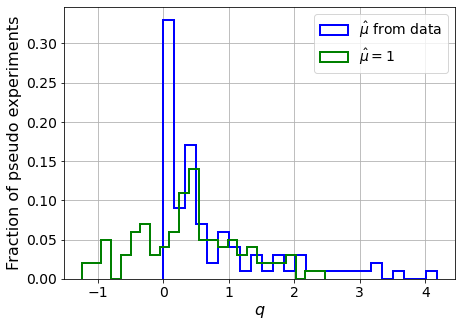

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  9033.7137517   8839.20354041  8575.00293136
  8235.82442517  7825.16833656  7319.47887004  6708.48940701
  5983.64728789  5140.52089432  4149.35294662  2985.90246182
  1620.32733935    57.71533475 -1661.22392095 -3818.7644213 ]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 11115.01525104 11068.49168395 10934.88921613 10685.34745851


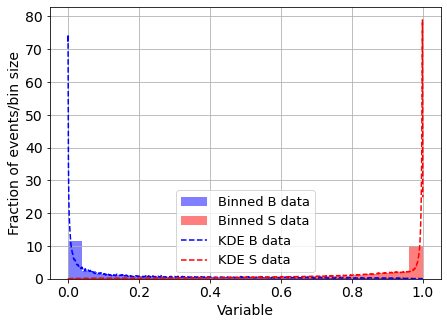

KDE Kernel:  epanechnikov
Background bandwidth:  0.0011635618505359071
Signal bandwidth:  0.0007122485584859914
This may take a while...
1 done
2 done
3 done
4 done


  0%|                                                                   | 1/2000 [00:00<12:17,  2.71it/s]

There are events with p(s)=0


  0%|▏                                                                  | 4/2000 [00:01<09:34,  3.47it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.13543466986997854
<p_{s}(Sdata)> = 27.961551039436372
<p_{b}(Bdata)> = 16.289605638544657
<p_{s}(Bdata)> = 0.25890603053818895


  0%|▎                                                                  | 9/2000 [00:02<07:37,  4.36it/s]

There are events with p(s)=0


  1%|▎                                                                 | 11/2000 [00:02<09:01,  3.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20584067758571198
<p_{s}(Sdata)> = 8.424756071811807
<p_{b}(Bdata)> = 16.739837346526805
<p_{s}(Bdata)> = 0.2551847370196875


  1%|▍                                                                 | 15/2000 [00:03<06:23,  5.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24916076206663232
<p_{s}(Sdata)> = 9.418641818566142
<p_{b}(Bdata)> = 16.537782149327093
<p_{s}(Bdata)> = 0.2652389062989446


  1%|▌                                                                 | 17/2000 [00:03<06:10,  5.36it/s]

There are events with p(s)=0


  1%|▋                                                                 | 19/2000 [00:04<07:41,  4.29it/s]

There are events with p(s)=0


  1%|▊                                                                 | 23/2000 [00:05<08:09,  4.04it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.2194181789320583
<p_{s}(Sdata)> = 22.515961376603432
<p_{b}(Bdata)> = 16.541450146526223
<p_{s}(Bdata)> = 0.26183987132090764


  1%|▉                                                                 | 27/2000 [00:06<08:58,  3.67it/s]

There are events with p(s)=0


  1%|▉                                                                 | 28/2000 [00:06<10:18,  3.19it/s]

There are events with p(s)=0


  1%|▉                                                                 | 29/2000 [00:06<09:40,  3.39it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.14929661195452354
<p_{s}(Sdata)> = 36.99069608319529
<p_{b}(Bdata)> = 16.778765379767524
<p_{s}(Bdata)> = 0.2555101674016813


  2%|█                                                                 | 31/2000 [00:07<07:25,  4.42it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.14139689428110408
<p_{s}(Sdata)> = 10.29170006623677
<p_{b}(Bdata)> = 16.8307212641724
<p_{s}(Bdata)> = 0.2539267489560373


  2%|█                                                                 | 33/2000 [00:07<06:23,  5.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2350309001485005
<p_{s}(Sdata)> = 6.580375945919066
<p_{b}(Bdata)> = 16.945903403033544
<p_{s}(Bdata)> = 0.2557303189115935


  2%|█▎                                                                | 38/2000 [00:08<08:45,  3.73it/s]

There are events with p(s)=0


  2%|█▎                                                                | 39/2000 [00:09<08:52,  3.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2572843679205823
<p_{s}(Sdata)> = 5.060162804884506
<p_{b}(Bdata)> = 16.802779167307303
<p_{s}(Bdata)> = 0.2546543832711611


  2%|█▎                                                                | 41/2000 [00:09<07:58,  4.10it/s]

There are events with p(s)=0


  2%|█▍                                                                | 42/2000 [00:10<09:29,  3.44it/s]

There are events with p(s)=0


  2%|█▍                                                                | 45/2000 [00:10<07:38,  4.27it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.15410772313061116
<p_{s}(Sdata)> = 22.58602466965702
<p_{b}(Bdata)> = 16.45709690058828
<p_{s}(Bdata)> = 0.2614539730036284


  2%|█▌                                                                | 48/2000 [00:11<06:38,  4.90it/s]

There are events with p(s)=0


  3%|█▋                                                                | 53/2000 [00:12<05:25,  5.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2640108340463127
<p_{s}(Sdata)> = 1.5676433021043088
<p_{b}(Bdata)> = 16.626980574618422
<p_{s}(Bdata)> = 0.25223781117500005
There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.07152938012974837
<p_{s}(Sdata)> = 48.87373697187405
<p_{b}(Bdata)> = 16.75005247248594
<p_{s}(Bdata)> = 0.2582163860399266
There are events with p(s)=0


  3%|█▊                                                                | 54/2000 [00:12<07:01,  4.62it/s]

There are events with p(s)=0


  3%|█▊                                                                | 55/2000 [00:12<07:53,  4.11it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.1812652843273293
<p_{s}(Sdata)> = 23.943476096288357
<p_{b}(Bdata)> = 16.681998470339824
<p_{s}(Bdata)> = 0.25663443458155993


  3%|█▉                                                                | 58/2000 [00:13<08:23,  3.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3828180247583991
<p_{s}(Sdata)> = 5.731385913540507
<p_{b}(Bdata)> = 16.86295867558023
<p_{s}(Bdata)> = 0.2501147685727032


  3%|██                                                                | 62/2000 [00:14<07:07,  4.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3514725966784407
<p_{s}(Sdata)> = 6.4878539227165275
<p_{b}(Bdata)> = 16.81249761119392
<p_{s}(Bdata)> = 0.2568833996378713
There are events with p(s)=0


  3%|██▏                                                               | 66/2000 [00:14<05:10,  6.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2785150201910702
<p_{s}(Sdata)> = 6.332189550941651
<p_{b}(Bdata)> = 16.538771770983857
<p_{s}(Bdata)> = 0.257035376257224
There are events with p(s)=0


  4%|██▎                                                               | 70/2000 [00:16<07:09,  4.50it/s]

There are events with p(s)=0
There are events with p(s)=0


  4%|██▍                                                               | 72/2000 [00:16<07:45,  4.14it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.18745120453033853
<p_{s}(Sdata)> = 9.912156839341623
<p_{b}(Bdata)> = 16.758498012041272
<p_{s}(Bdata)> = 0.25599741155060407


  4%|██▍                                                               | 75/2000 [00:17<07:34,  4.23it/s]

There are events with p(s)=0


  4%|██▌                                                               | 76/2000 [00:17<08:15,  3.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20790001372370073
<p_{s}(Sdata)> = 11.127651095264396
<p_{b}(Bdata)> = 16.46423348457797
<p_{s}(Bdata)> = 0.2547924312373662
There are events with p(s)=0


  4%|██▌                                                               | 79/2000 [00:18<07:04,  4.53it/s]

There are events with p(s)=0


  4%|██▋                                                               | 83/2000 [00:18<06:02,  5.29it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.260238479439884
<p_{s}(Sdata)> = 1.493904293627943
<p_{b}(Bdata)> = 16.623718873478737
<p_{s}(Bdata)> = 0.2540951377032279


  4%|██▊                                                               | 86/2000 [00:19<04:26,  7.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2098022515291275
<p_{s}(Sdata)> = 4.817659423863618
<p_{b}(Bdata)> = 16.62623610900349
<p_{s}(Bdata)> = 0.256763084459205
muhat = -0.1
<p_{b}(Sdata)> = 0.27961084328339464
<p_{s}(Sdata)> = 8.020311420738471
<p_{b}(Bdata)> = 16.639784384209527
<p_{s}(Bdata)> = 0.25681623867383724
There are events with p(s)=0


  4%|██▉                                                               | 89/2000 [00:20<06:19,  5.03it/s]

There are events with p(s)=0
There are events with p(s)=0


  5%|███                                                               | 91/2000 [00:20<05:04,  6.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2571693128280307
<p_{s}(Sdata)> = 12.021637241555172
<p_{b}(Bdata)> = 17.079036036489157
<p_{s}(Bdata)> = 0.2548784824062443


  5%|███                                                               | 92/2000 [00:20<05:38,  5.63it/s]

There are events with p(s)=0


  5%|███                                                               | 93/2000 [00:20<07:44,  4.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23811308660766065
<p_{s}(Sdata)> = 1.8315091647604196
<p_{b}(Bdata)> = 16.68113023385506
<p_{s}(Bdata)> = 0.26169860663406874
There are events with p(s)=0


  5%|███▏                                                              | 96/2000 [00:21<07:49,  4.06it/s]

There are events with p(s)=0


  5%|███▎                                                              | 99/2000 [00:22<10:23,  3.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38873965939993316
<p_{s}(Sdata)> = 6.19156621194159
<p_{b}(Bdata)> = 16.635382146563995
<p_{s}(Bdata)> = 0.25614693114667847
There are events with p(s)=0


  5%|███▎                                                             | 102/2000 [00:23<08:13,  3.84it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.1394196467127705
<p_{s}(Sdata)> = 22.133823645366366
<p_{b}(Bdata)> = 16.74095402985416
<p_{s}(Bdata)> = 0.256868511601321


  5%|███▍                                                             | 105/2000 [00:24<07:12,  4.38it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.6976503022161207
<p_{s}(Sdata)> = 9.374316037154983
<p_{b}(Bdata)> = 16.169924129266704
<p_{s}(Bdata)> = 0.25470033483581106


  6%|███▌                                                             | 111/2000 [00:25<05:18,  5.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29942003768493825
<p_{s}(Sdata)> = 11.807125458443167
<p_{b}(Bdata)> = 16.626049210486052
<p_{s}(Bdata)> = 0.2568564529122562
muhat = -0.1
<p_{b}(Sdata)> = 0.21876413435958947
<p_{s}(Sdata)> = 3.3476648476344364
<p_{b}(Bdata)> = 16.706051624655395
<p_{s}(Bdata)> = 0.26238120285211014
There are events with p(s)=0


  6%|███▋                                                             | 115/2000 [00:25<04:32,  6.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1923168704267265
<p_{s}(Sdata)> = 6.673190196144201
<p_{b}(Bdata)> = 16.53131666057796
<p_{s}(Bdata)> = 0.2561288627111105
muhat = 2.1
<p_{b}(Sdata)> = 0.17000925156001398
<p_{s}(Sdata)> = 28.23253785460322
<p_{b}(Bdata)> = 16.567269320581516
<p_{s}(Bdata)> = 0.26706976390061093
There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.3873820759230451
<p_{s}(Sdata)> = 18.70840542102329
<p_{b}(Bdata)> = 16.73694964839762
<p_{s}(Bdata)> = 0.2650724587933934
There are events with p(s)=0


  6%|███▊                                                             | 119/2000 [00:26<03:58,  7.88it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.19491788562237622
<p_{s}(Sdata)> = 11.871945941609669
<p_{b}(Bdata)> = 16.37769240388698
<p_{s}(Bdata)> = 0.25042200993600744
muhat = -0.1
<p_{b}(Sdata)> = 0.22141642346450033
<p_{s}(Sdata)> = 7.174155883999586
<p_{b}(Bdata)> = 16.783787394013668
<p_{s}(Bdata)> = 0.25588121603053127
There are events with p(s)=0


  6%|███▉                                                             | 121/2000 [00:26<05:20,  5.87it/s]

There are events with p(s)=0


  6%|████                                                             | 126/2000 [00:27<05:05,  6.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16552992766090843
<p_{s}(Sdata)> = 3.468750916590108
<p_{b}(Bdata)> = 16.323568387810706
<p_{s}(Bdata)> = 0.2556207323393997
muhat = -0.1
<p_{b}(Sdata)> = 0.23368857114611682
<p_{s}(Sdata)> = 12.666665337868276
<p_{b}(Bdata)> = 16.74159699444476
<p_{s}(Bdata)> = 0.25746918913466593
There are events with p(s)=0


  6%|████▏                                                            | 128/2000 [00:28<05:46,  5.40it/s]

There are events with p(s)=0


  6%|████▏                                                            | 130/2000 [00:28<07:15,  4.30it/s]

There are events with p(s)=0


  7%|████▎                                                            | 131/2000 [00:29<07:51,  3.97it/s]

There are events with p(s)=0


  7%|████▎                                                            | 133/2000 [00:29<06:55,  4.50it/s]

There are events with p(s)=0


  7%|████▌                                                            | 139/2000 [00:30<04:57,  6.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25154640387736743
<p_{s}(Sdata)> = 2.919655399526601
<p_{b}(Bdata)> = 16.46119113427189
<p_{s}(Bdata)> = 0.2587078290135855
There are events with p(s)=0


  7%|████▌                                                            | 140/2000 [00:30<05:06,  6.07it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.246204380882164
<p_{s}(Sdata)> = 22.19703365753112
<p_{b}(Bdata)> = 16.660281064174793
<p_{s}(Bdata)> = 0.2594403504892502
There are events with p(s)=0


  7%|████▋                                                            | 144/2000 [00:31<04:27,  6.95it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.21658961418979655
<p_{s}(Sdata)> = 7.367803051330647
<p_{b}(Bdata)> = 16.707524554450522
<p_{s}(Bdata)> = 0.26334082517566176
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.2596136148890958
<p_{s}(Sdata)> = 4.189162123973422
<p_{b}(Bdata)> = 16.5280776697436
<p_{s}(Bdata)> = 0.25995405533547267
There are events with p(s)=0


  7%|████▋                                                            | 146/2000 [00:31<04:47,  6.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2516373901196781
<p_{s}(Sdata)> = 5.302839996618404
<p_{b}(Bdata)> = 16.361213146775853
<p_{s}(Bdata)> = 0.2626676450163518
There are events with p(s)=0


  8%|████▉                                                            | 150/2000 [00:32<04:45,  6.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36373003223192046
<p_{s}(Sdata)> = 7.25851629875926
<p_{b}(Bdata)> = 16.31747831026505
<p_{s}(Bdata)> = 0.2600043988305941


  8%|████▉                                                            | 151/2000 [00:32<04:58,  6.20it/s]

There are events with p(s)=0


  8%|████▉                                                            | 152/2000 [00:32<05:28,  5.63it/s]

There are events with p(s)=0


  8%|█████                                                            | 156/2000 [00:33<06:14,  4.92it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.38565747576435333
<p_{s}(Sdata)> = 9.416530614616043
<p_{b}(Bdata)> = 16.712709611566893
<p_{s}(Bdata)> = 0.2546687844927916


  8%|█████▏                                                           | 158/2000 [00:33<05:37,  5.46it/s]

There are events with p(s)=0


  8%|█████▏                                                           | 159/2000 [00:34<06:14,  4.91it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.19254152335372982
<p_{s}(Sdata)> = 16.556480124976055
<p_{b}(Bdata)> = 16.77551860088657
<p_{s}(Bdata)> = 0.2563160454955061
There are events with p(s)=0


  8%|█████▎                                                           | 162/2000 [00:34<06:15,  4.89it/s]

There are events with p(s)=0


  8%|█████▎                                                           | 163/2000 [00:35<07:27,  4.10it/s]

There are events with p(s)=0


  8%|█████▎                                                           | 164/2000 [00:35<07:47,  3.93it/s]

There are events with p(s)=0


  8%|█████▍                                                           | 166/2000 [00:36<07:51,  3.89it/s]

There are events with p(s)=0


  8%|█████▍                                                           | 167/2000 [00:36<08:29,  3.60it/s]

There are events with p(s)=0


  8%|█████▍                                                           | 168/2000 [00:36<08:01,  3.81it/s]

There are events with p(s)=0


  9%|█████▌                                                           | 171/2000 [00:37<06:01,  5.06it/s]

There are events with p(s)=0
There are events with p(s)=0


  9%|█████▋                                                           | 174/2000 [00:38<08:18,  3.66it/s]

There are events with p(s)=0
There are events with p(s)=0


  9%|█████▊                                                           | 177/2000 [00:38<07:02,  4.31it/s]

There are events with p(s)=0


  9%|█████▊                                                           | 178/2000 [00:39<08:16,  3.67it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1330574964342221
<p_{s}(Sdata)> = 22.645583556868154
<p_{b}(Bdata)> = 16.808722042776733
<p_{s}(Bdata)> = 0.2646280217488091
There are events with p(s)=0


  9%|█████▉                                                           | 182/2000 [00:39<07:10,  4.22it/s]

There are events with p(s)=0


  9%|█████▉                                                           | 184/2000 [00:40<08:09,  3.71it/s]

There are events with p(s)=0


  9%|██████                                                           | 186/2000 [00:41<08:08,  3.71it/s]

There are events with p(s)=0


 10%|██████▏                                                          | 192/2000 [00:42<06:12,  4.86it/s]

There are events with p(s)=0
There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.2249976336735956
<p_{s}(Sdata)> = 20.931996082400662
<p_{b}(Bdata)> = 16.682296244181146
<p_{s}(Bdata)> = 0.26076437377372313


 10%|██████▎                                                          | 196/2000 [00:43<07:04,  4.25it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.2808722544723877
<p_{s}(Sdata)> = 8.575996524064324
<p_{b}(Bdata)> = 17.000104512226528
<p_{s}(Bdata)> = 0.25670070685238827
There are events with p(s)=0


 10%|██████▍                                                          | 199/2000 [00:44<06:34,  4.57it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.2396977126652374
<p_{s}(Sdata)> = 6.35484987079787
<p_{b}(Bdata)> = 16.47448629891565
<p_{s}(Bdata)> = 0.2510750101312433
There are events with p(s)=0


 10%|██████▋                                                          | 205/2000 [00:45<06:36,  4.53it/s]

There are events with p(s)=0


 10%|██████▋                                                          | 206/2000 [00:45<06:41,  4.46it/s]

There are events with p(s)=0


 10%|██████▋                                                          | 207/2000 [00:45<06:43,  4.44it/s]

There are events with p(s)=0


 10%|██████▊                                                          | 208/2000 [00:46<07:44,  3.86it/s]

There are events with p(s)=0


 10%|██████▊                                                          | 209/2000 [00:46<07:37,  3.91it/s]

There are events with p(s)=0


 10%|██████▊                                                          | 210/2000 [00:46<08:20,  3.58it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1508108643898295
<p_{s}(Sdata)> = 23.908096494058455
<p_{b}(Bdata)> = 16.406572581615322
<p_{s}(Bdata)> = 0.26258365383462035


 11%|██████▉                                                          | 214/2000 [00:47<06:37,  4.49it/s]

There are events with p(s)=0


 11%|██████▉                                                          | 215/2000 [00:48<07:43,  3.85it/s]

There are events with p(s)=0


 11%|███████                                                          | 217/2000 [00:48<08:10,  3.63it/s]

There are events with p(s)=0


 11%|███████                                                          | 219/2000 [00:49<07:27,  3.98it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.3559377792983642
<p_{s}(Sdata)> = 6.73004324446099
<p_{b}(Bdata)> = 16.461783591820307
<p_{s}(Bdata)> = 0.25066305835636304


 11%|███████▏                                                         | 223/2000 [00:49<04:00,  7.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20460067364399823
<p_{s}(Sdata)> = 9.090347978288541
<p_{b}(Bdata)> = 16.62413452648749
<p_{s}(Bdata)> = 0.2596866047748609
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.2868960076724165
<p_{s}(Sdata)> = 8.141702394919744
<p_{b}(Bdata)> = 16.39137051415361
<p_{s}(Bdata)> = 0.2588375953647055
There are events with p(s)=0


 11%|███████▎                                                         | 225/2000 [00:49<04:40,  6.32it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.2057360862417651
<p_{s}(Sdata)> = 19.29745221869986
<p_{b}(Bdata)> = 16.35747491194504
<p_{s}(Bdata)> = 0.2576415050816286


 11%|███████▍                                                         | 228/2000 [00:50<05:55,  4.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2208675842371973
<p_{s}(Sdata)> = 4.933658081966554
<p_{b}(Bdata)> = 16.65238908101443
<p_{s}(Bdata)> = 0.25569633304936845
There are events with p(s)=0


 12%|███████▌                                                         | 232/2000 [00:51<04:32,  6.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23249834519678053
<p_{s}(Sdata)> = 6.809740934222656
<p_{b}(Bdata)> = 16.653045279704838
<p_{s}(Bdata)> = 0.2550151833480895
There are events with p(s)=0
There are events with p(s)=0


 12%|███████▋                                                         | 235/2000 [00:51<06:49,  4.31it/s]

There are events with p(s)=0


 12%|███████▋                                                         | 237/2000 [00:52<08:07,  3.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4393084458600971
<p_{s}(Sdata)> = 3.631566948915066
<p_{b}(Bdata)> = 16.406031687125548
<p_{s}(Bdata)> = 0.2614909198049968


 12%|███████▉                                                         | 244/2000 [00:53<05:10,  5.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5850793531454437
<p_{s}(Sdata)> = 6.905608004726309
<p_{b}(Bdata)> = 16.358727903213143
<p_{s}(Bdata)> = 0.2593035074058427
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.27922391885363385
<p_{s}(Sdata)> = 9.126176038932286
<p_{b}(Bdata)> = 16.88785903381632
<p_{s}(Bdata)> = 0.2533356890036903
There are events with p(s)=0


 12%|███████▉                                                         | 245/2000 [00:54<05:00,  5.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2762752044970737
<p_{s}(Sdata)> = 8.337355955989128
<p_{b}(Bdata)> = 16.618732092385038
<p_{s}(Bdata)> = 0.2516237102998972


 12%|████████                                                         | 249/2000 [00:55<07:00,  4.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3901087578884055
<p_{s}(Sdata)> = 7.94215890151064
<p_{b}(Bdata)> = 16.86412410918479
<p_{s}(Bdata)> = 0.2552952952924993
There are events with p(s)=0


 13%|████████▏                                                        | 251/2000 [00:55<06:46,  4.30it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.279429357021338
<p_{s}(Sdata)> = 8.462247872054043
<p_{b}(Bdata)> = 16.51876015007861
<p_{s}(Bdata)> = 0.25359748597833176


 13%|████████▏                                                        | 253/2000 [00:56<06:26,  4.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5694739322406633
<p_{s}(Sdata)> = 6.736813450573314
<p_{b}(Bdata)> = 16.48611849099786
<p_{s}(Bdata)> = 0.2552706644521248


 13%|████████▎                                                        | 256/2000 [00:56<05:30,  5.28it/s]

There are events with p(s)=0


 13%|████████▎                                                        | 257/2000 [00:56<05:52,  4.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21360710335768754
<p_{s}(Sdata)> = 8.241377399712334
<p_{b}(Bdata)> = 16.985153309763817
<p_{s}(Bdata)> = 0.25605295548675877
There are events with p(s)=0


 13%|████████▍                                                        | 261/2000 [00:57<04:31,  6.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21222157571289796
<p_{s}(Sdata)> = 9.219592507224778
<p_{b}(Bdata)> = 16.03647519889392
<p_{s}(Bdata)> = 0.25909753938757996
muhat = 2.1
<p_{b}(Sdata)> = 0.3731515105219046
<p_{s}(Sdata)> = 20.04315311218145
<p_{b}(Bdata)> = 16.480761019892668
<p_{s}(Bdata)> = 0.27008993717613033


 13%|████████▋                                                        | 266/2000 [00:58<04:24,  6.55it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14281543847772876
<p_{s}(Sdata)> = 26.60758712665165
<p_{b}(Bdata)> = 16.765410105360388
<p_{s}(Bdata)> = 0.25971097248335967
There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.0908507523799285
<p_{s}(Sdata)> = 20.01315137517814
<p_{b}(Bdata)> = 16.50099671053277
<p_{s}(Bdata)> = 0.2649614063502287


 13%|████████▋                                                        | 267/2000 [00:58<06:23,  4.52it/s]

There are events with p(s)=0


 13%|████████▋                                                        | 268/2000 [00:58<07:11,  4.01it/s]

There are events with p(s)=0


 14%|████████▊                                                        | 271/2000 [00:59<07:42,  3.74it/s]

There are events with p(s)=0


 14%|████████▊                                                        | 272/2000 [01:00<09:29,  3.03it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.22531854262674253
<p_{s}(Sdata)> = 19.71874258248763
<p_{b}(Bdata)> = 16.755947441299682
<p_{s}(Bdata)> = 0.2618004819051883


 14%|████████▉                                                        | 275/2000 [01:00<07:14,  3.97it/s]

There are events with p(s)=0


 14%|█████████                                                        | 277/2000 [01:01<06:38,  4.32it/s]

There are events with p(s)=0


 14%|█████████                                                        | 280/2000 [01:01<05:27,  5.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20098335766884637
<p_{s}(Sdata)> = 8.418090382921653
<p_{b}(Bdata)> = 16.862999164955003
<p_{s}(Bdata)> = 0.2573895441612338
There are events with p(s)=0


 14%|█████████▏                                                       | 282/2000 [01:02<04:13,  6.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36458352370230146
<p_{s}(Sdata)> = 1.5351748800811242
<p_{b}(Bdata)> = 16.6715017205111
<p_{s}(Bdata)> = 0.2625836919533171
muhat = 2.1
<p_{b}(Sdata)> = 0.23241799805079352
<p_{s}(Sdata)> = 23.383295399424455
<p_{b}(Bdata)> = 16.916224048042928
<p_{s}(Bdata)> = 0.26244253267857975


 14%|█████████▏                                                       | 283/2000 [01:02<04:46,  5.98it/s]

There are events with p(s)=0


 14%|█████████▎                                                       | 285/2000 [01:02<06:59,  4.08it/s]

There are events with p(s)=0


 14%|█████████▍                                                       | 289/2000 [01:03<05:04,  5.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18578787268328217
<p_{s}(Sdata)> = 2.036852755341953
<p_{b}(Bdata)> = 16.663212679956445
<p_{s}(Bdata)> = 0.2525905367649649
muhat = -0.1
<p_{b}(Sdata)> = 0.3268264752704299
<p_{s}(Sdata)> = 1.2090900638624769
<p_{b}(Bdata)> = 16.70862149077761
<p_{s}(Bdata)> = 0.24971745282983876
There are events with p(s)=0


 15%|█████████▍                                                       | 291/2000 [01:04<06:35,  4.32it/s]

There are events with p(s)=0


 15%|█████████▌                                                       | 295/2000 [01:04<04:34,  6.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2775339007693619
<p_{s}(Sdata)> = 1.2253279715017775
<p_{b}(Bdata)> = 16.740458885977528
<p_{s}(Bdata)> = 0.2555312079567903
muhat = -0.1
<p_{b}(Sdata)> = 0.19130105619646257
<p_{s}(Sdata)> = 8.198400198705754
<p_{b}(Bdata)> = 16.485353478121606
<p_{s}(Bdata)> = 0.25297813854934315
There are events with p(s)=0


 15%|█████████▋                                                       | 298/2000 [01:05<06:08,  4.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3083292255790951
<p_{s}(Sdata)> = 4.442280663744015
<p_{b}(Bdata)> = 16.605148992647205
<p_{s}(Bdata)> = 0.25769087099559707
There are events with p(s)=0


 15%|█████████▊                                                       | 300/2000 [01:06<05:39,  5.01it/s]

There are events with p(s)=0


 15%|█████████▊                                                       | 302/2000 [01:06<06:36,  4.28it/s]

There are events with p(s)=0


 15%|█████████▉                                                       | 306/2000 [01:07<07:17,  3.87it/s]

There are events with p(s)=0


 15%|██████████                                                       | 308/2000 [01:08<08:46,  3.22it/s]

There are events with p(s)=0


 16%|██████████▏                                                      | 312/2000 [01:09<07:16,  3.87it/s]

There are events with p(s)=0


 16%|██████████▎                                                      | 316/2000 [01:10<06:30,  4.32it/s]

There are events with p(s)=0


 16%|██████████▎                                                      | 317/2000 [01:10<06:01,  4.65it/s]

There are events with p(s)=0


 16%|██████████▌                                                      | 324/2000 [01:12<06:38,  4.20it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.17128596548437058
<p_{s}(Sdata)> = 18.49162270060386
<p_{b}(Bdata)> = 16.35401140997225
<p_{s}(Bdata)> = 0.2665410613444134


 16%|██████████▋                                                      | 327/2000 [01:13<06:31,  4.28it/s]

There are events with p(s)=0


 16%|██████████▋                                                      | 328/2000 [01:13<07:09,  3.89it/s]

There are events with p(s)=0


 16%|██████████▋                                                      | 330/2000 [01:14<08:22,  3.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20628044253082425
<p_{s}(Sdata)> = 1.4948096393597072
<p_{b}(Bdata)> = 16.764402395633866
<p_{s}(Bdata)> = 0.2620544899546775
There are events with p(s)=0


 17%|██████████▊                                                      | 334/2000 [01:14<05:27,  5.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18803346707977736
<p_{s}(Sdata)> = 7.808709642711444
<p_{b}(Bdata)> = 16.835646504518213
<p_{s}(Bdata)> = 0.25871256914393975
muhat = -0.1
<p_{b}(Sdata)> = 0.20786267120180593
<p_{s}(Sdata)> = 9.209322650642815
<p_{b}(Bdata)> = 17.073047426418217
<p_{s}(Bdata)> = 0.25205562184093927


 17%|██████████▉                                                      | 337/2000 [01:15<05:06,  5.43it/s]

There are events with p(s)=0


 17%|███████████                                                      | 340/2000 [01:16<06:37,  4.18it/s]

There are events with p(s)=0


 17%|███████████▏                                                     | 345/2000 [01:17<06:37,  4.16it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.18746890185396198
<p_{s}(Sdata)> = 9.858854504980702
<p_{b}(Bdata)> = 16.687622112512138
<p_{s}(Bdata)> = 0.25038892538445806
There are events with p(s)=0


 17%|███████████▎                                                     | 349/2000 [01:18<06:00,  4.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2413500664360831
<p_{s}(Sdata)> = 8.984401065489475
<p_{b}(Bdata)> = 16.79722358488613
<p_{s}(Bdata)> = 0.25394904242626626


 18%|███████████▍                                                     | 352/2000 [01:19<06:08,  4.48it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.15710456633943312
<p_{s}(Sdata)> = 15.128832681511767
<p_{b}(Bdata)> = 16.555727013946566
<p_{s}(Bdata)> = 0.25059388613978323


 18%|███████████▌                                                     | 354/2000 [01:19<05:15,  5.23it/s]

There are events with p(s)=0


 18%|███████████▌                                                     | 355/2000 [01:19<05:40,  4.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17944958006364858
<p_{s}(Sdata)> = 17.67853927082681
<p_{b}(Bdata)> = 16.65146989554052
<p_{s}(Bdata)> = 0.24991512705229282
There are events with p(s)=0


 18%|███████████▌                                                     | 357/2000 [01:19<05:35,  4.90it/s]

There are events with p(s)=0


 18%|███████████▋                                                     | 358/2000 [01:20<06:26,  4.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.07940397415800797
<p_{s}(Sdata)> = 17.72953818175408
<p_{b}(Bdata)> = 16.66497453315504
<p_{s}(Bdata)> = 0.2536057447672044


 18%|███████████▊                                                     | 363/2000 [01:21<06:15,  4.36it/s]

There are events with p(s)=0


 18%|███████████▉                                                     | 366/2000 [01:22<07:29,  3.64it/s]

There are events with p(s)=0


 18%|███████████▉                                                     | 367/2000 [01:22<06:54,  3.94it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.3117103038548028
<p_{s}(Sdata)> = 7.316327588679106
<p_{b}(Bdata)> = 16.897292155561114
<p_{s}(Bdata)> = 0.2530823494663095


 18%|████████████                                                     | 370/2000 [01:22<05:10,  5.24it/s]

There are events with p(s)=0
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.31396441007902615
<p_{s}(Sdata)> = 8.527194117835643
<p_{b}(Bdata)> = 16.842566991538718
<p_{s}(Bdata)> = 0.25592965871646095
There are events with p(s)=0


 19%|████████████                                                     | 372/2000 [01:23<06:07,  4.43it/s]

There are events with p(s)=0


 19%|████████████                                                     | 373/2000 [01:23<06:05,  4.46it/s]

There are events with p(s)=0


 19%|████████████▏                                                    | 374/2000 [01:23<06:04,  4.46it/s]

There are events with p(s)=0


 19%|████████████▎                                                    | 379/2000 [01:25<05:36,  4.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23599488803056856
<p_{s}(Sdata)> = 11.172683719818826
<p_{b}(Bdata)> = 16.65896499749981
<p_{s}(Bdata)> = 0.2603449394180892
muhat = -0.1
<p_{b}(Sdata)> = 0.22505197016849143
<p_{s}(Sdata)> = 6.79614753609574
<p_{b}(Bdata)> = 16.6528976662229
<p_{s}(Bdata)> = 0.2519064094881214


 19%|████████████▎                                                    | 380/2000 [01:25<06:29,  4.16it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.09880900688219658
<p_{s}(Sdata)> = 20.650707195855144
<p_{b}(Bdata)> = 16.80595607457143
<p_{s}(Bdata)> = 0.2622191659917384


 19%|████████████▍                                                    | 382/2000 [01:25<05:21,  5.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22026348128676318
<p_{s}(Sdata)> = 2.5434070157221913
<p_{b}(Bdata)> = 16.439672765454855
<p_{s}(Bdata)> = 0.2566864011582355
There are events with p(s)=0


 19%|████████████▌                                                    | 386/2000 [01:26<06:37,  4.06it/s]

There are events with p(s)=0


 19%|████████████▌                                                    | 387/2000 [01:27<07:47,  3.45it/s]

There are events with p(s)=0


 19%|████████████▋                                                    | 389/2000 [01:28<07:39,  3.50it/s]

There are events with p(s)=0


 20%|████████████▋                                                    | 390/2000 [01:28<08:02,  3.33it/s]

There are events with p(s)=0


 20%|████████████▋                                                    | 391/2000 [01:28<08:22,  3.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1755673062699297
<p_{s}(Sdata)> = 14.287084532955134
<p_{b}(Bdata)> = 16.433944372785188
<p_{s}(Bdata)> = 0.2574603149534234


 20%|████████████▊                                                    | 393/2000 [01:29<07:04,  3.79it/s]

There are events with p(s)=0


 20%|████████████▉                                                    | 397/2000 [01:29<04:41,  5.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27552588132896916
<p_{s}(Sdata)> = 6.73651167738286
<p_{b}(Bdata)> = 16.40260338664811
<p_{s}(Bdata)> = 0.26062645687167074


 20%|████████████▉                                                    | 398/2000 [01:29<04:33,  5.85it/s]

There are events with p(s)=0


 20%|█████████████                                                    | 401/2000 [01:30<04:30,  5.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22504949991517748
<p_{s}(Sdata)> = 5.483802375528023
<p_{b}(Bdata)> = 16.688190040708232
<p_{s}(Bdata)> = 0.25742242225515716
There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.09232027763084097
<p_{s}(Sdata)> = 28.878332435826128
<p_{b}(Bdata)> = 16.931218613909234
<p_{s}(Bdata)> = 0.25817139512417664


 20%|█████████████                                                    | 403/2000 [01:30<03:43,  7.14it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.12204736967464043
<p_{s}(Sdata)> = 31.937908373156212
<p_{b}(Bdata)> = 16.624045099204945
<p_{s}(Bdata)> = 0.26592701015107634
There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.09971303233024723
<p_{s}(Sdata)> = 33.66721396844003
<p_{b}(Bdata)> = 16.516268180527042
<p_{s}(Bdata)> = 0.26400684935124163


 20%|█████████████▏                                                   | 407/2000 [01:30<02:40,  9.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3145667576462188
<p_{s}(Sdata)> = 5.236334762813031
<p_{b}(Bdata)> = 16.595887759527074
<p_{s}(Bdata)> = 0.25528607256563085
muhat = -0.1
<p_{b}(Sdata)> = 0.20791007506997464
<p_{s}(Sdata)> = 5.296042524211131
<p_{b}(Bdata)> = 16.302353336866503
<p_{s}(Bdata)> = 0.2603099423639981
muhat = -0.1
<p_{b}(Sdata)> = 0.22644498338533428
<p_{s}(Sdata)> = 7.538933911873693
<p_{b}(Bdata)> = 16.574321118947452
<p_{s}(Bdata)> = 0.2567872772500968


 20%|█████████████▎                                                   | 409/2000 [01:31<02:50,  9.34it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.16810632924320842
<p_{s}(Sdata)> = 10.100719503657242
<p_{b}(Bdata)> = 16.51720862005216
<p_{s}(Bdata)> = 0.2484320116801628
There are events with p(s)=0


 21%|█████████████▎                                                   | 411/2000 [01:31<04:30,  5.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3671067570309099
<p_{s}(Sdata)> = 17.673759775684587
<p_{b}(Bdata)> = 16.813324404932757
<p_{s}(Bdata)> = 0.24948777360413046


 21%|█████████████▍                                                   | 413/2000 [01:32<04:26,  5.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3599286676180916
<p_{s}(Sdata)> = 5.986322488318992
<p_{b}(Bdata)> = 16.804941532723415
<p_{s}(Bdata)> = 0.254646849151782
There are events with p(s)=0


 21%|█████████████▍                                                   | 415/2000 [01:32<05:13,  5.06it/s]

There are events with p(s)=0


 21%|█████████████▌                                                   | 416/2000 [01:32<06:06,  4.32it/s]

There are events with p(s)=0


 21%|█████████████▌                                                   | 417/2000 [01:33<06:44,  3.91it/s]

There are events with p(s)=0


 21%|█████████████▌                                                   | 419/2000 [01:33<07:20,  3.59it/s]

There are events with p(s)=0


 21%|█████████████▋                                                   | 423/2000 [01:34<04:56,  5.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1312612437397002
<p_{s}(Sdata)> = 12.658749729020947
<p_{b}(Bdata)> = 16.9459026492792
<p_{s}(Bdata)> = 0.2566115747854706
muhat = -0.1
<p_{b}(Sdata)> = 0.17451310581060048
<p_{s}(Sdata)> = 9.567087909303211
<p_{b}(Bdata)> = 16.60662991012518
<p_{s}(Bdata)> = 0.25399429826930287
There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.2885922676462699
<p_{s}(Sdata)> = 22.821263296894188
<p_{b}(Bdata)> = 16.76364578389321
<p_{s}(Bdata)> = 0.27374213230851363
There are events with p(s)=0


 21%|█████████████▊                                                   | 425/2000 [01:35<05:10,  5.07it/s]

There are events with p(s)=0


 21%|█████████████▉                                                   | 427/2000 [01:35<06:04,  4.32it/s]

There are events with p(s)=0


 21%|█████████████▉                                                   | 429/2000 [01:36<07:31,  3.48it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.1735308582703156
<p_{s}(Sdata)> = 23.502294150810894
<p_{b}(Bdata)> = 16.328624937723028
<p_{s}(Bdata)> = 0.26209687339809135


 22%|██████████████                                                   | 432/2000 [01:37<07:06,  3.68it/s]

There are events with p(s)=0


 22%|██████████████                                                   | 434/2000 [01:37<05:50,  4.47it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.1781922156795725
<p_{s}(Sdata)> = 20.476900116749384
<p_{b}(Bdata)> = 16.75997758469569
<p_{s}(Bdata)> = 0.265794687820277


 22%|██████████████▎                                                  | 439/2000 [01:38<05:54,  4.41it/s]

There are events with p(s)=0


 22%|██████████████▎                                                  | 441/2000 [01:39<07:27,  3.48it/s]

There are events with p(s)=0


 22%|██████████████▍                                                  | 443/2000 [01:39<06:55,  3.75it/s]

There are events with p(s)=0


 22%|██████████████▍                                                  | 445/2000 [01:40<06:54,  3.75it/s]

There are events with p(s)=0
There are events with p(s)=0


 22%|██████████████▌                                                  | 447/2000 [01:40<06:30,  3.98it/s]

There are events with p(s)=0
There are events with p(s)=0


 23%|██████████████▋                                                  | 451/2000 [01:41<05:44,  4.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25787238462027934
<p_{s}(Sdata)> = 5.522339513668638
<p_{b}(Bdata)> = 16.295553651589334
<p_{s}(Bdata)> = 0.25555983268582944
muhat = -0.1
<p_{b}(Sdata)> = 0.23555926796766494
<p_{s}(Sdata)> = 9.165760701183093
<p_{b}(Bdata)> = 16.289158717601563
<p_{s}(Bdata)> = 0.2589942034134902


 23%|██████████████▊                                                  | 455/2000 [01:42<05:42,  4.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2074423365881535
<p_{s}(Sdata)> = 7.795991447893378
<p_{b}(Bdata)> = 16.296286870882188
<p_{s}(Bdata)> = 0.2557650396975668
There are events with p(s)=0


 23%|██████████████▉                                                  | 458/2000 [01:43<05:59,  4.29it/s]

There are events with p(s)=0


 23%|██████████████▉                                                  | 460/2000 [01:43<04:45,  5.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18914974593978648
<p_{s}(Sdata)> = 11.935563068496645
<p_{b}(Bdata)> = 16.5689138450136
<p_{s}(Bdata)> = 0.2553329583735642
There are events with p(s)=0


 23%|███████████████                                                  | 462/2000 [01:44<04:10,  6.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2529185862593842
<p_{s}(Sdata)> = 2.2528098263916787
<p_{b}(Bdata)> = 16.73729162518588
<p_{s}(Bdata)> = 0.25202462541634874
There are events with p(s)=0
There are events with p(s)=0


 23%|███████████████                                                  | 465/2000 [01:44<03:56,  6.49it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.23868619530147547
<p_{s}(Sdata)> = 10.148255169834915
<p_{b}(Bdata)> = 16.50765759564082
<p_{s}(Bdata)> = 0.25273657994452375
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.4078977415494307
<p_{s}(Sdata)> = 11.969004926879544
<p_{b}(Bdata)> = 16.742088514304367
<p_{s}(Bdata)> = 0.2547914730152133


 23%|███████████████▏                                                 | 468/2000 [01:44<03:02,  8.41it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.3015732978720876
<p_{s}(Sdata)> = 10.237677997043678
<p_{b}(Bdata)> = 17.159967195169596
<p_{s}(Bdata)> = 0.25425980896908357
muhat = -0.1
<p_{b}(Sdata)> = 0.27929739297030753
<p_{s}(Sdata)> = 3.6306305887756514
<p_{b}(Bdata)> = 16.57507204727178
<p_{s}(Bdata)> = 0.25386554504058334
There are events with p(s)=0
There are events with p(s)=0


 24%|███████████████▎                                                 | 470/2000 [01:45<04:48,  5.29it/s]

There are events with p(s)=0


 24%|███████████████▎                                                 | 471/2000 [01:45<05:19,  4.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26214236184930023
<p_{s}(Sdata)> = 5.040063239148842
<p_{b}(Bdata)> = 16.787752568666683
<p_{s}(Bdata)> = 0.2583145526922983
There are events with p(s)=0


 24%|███████████████▎                                                 | 473/2000 [01:46<05:01,  5.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22536380193900615
<p_{s}(Sdata)> = 7.164734604983235
<p_{b}(Bdata)> = 16.571714516750596
<p_{s}(Bdata)> = 0.2573105035085206
There are events with p(s)=0


 24%|███████████████▍                                                 | 476/2000 [01:46<04:35,  5.53it/s]

There are events with p(s)=0


 24%|███████████████▌                                                 | 477/2000 [01:46<04:55,  5.15it/s]

There are events with p(s)=0


 24%|███████████████▌                                                 | 480/2000 [01:47<06:22,  3.98it/s]

There are events with p(s)=0
There are events with p(s)=0


 24%|███████████████▋                                                 | 482/2000 [01:48<06:30,  3.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2561589163300929
<p_{s}(Sdata)> = 3.5322785495912896
<p_{b}(Bdata)> = 16.917379753335055
<p_{s}(Bdata)> = 0.2540112918869402


 24%|███████████████▊                                                 | 485/2000 [01:49<06:05,  4.14it/s]

There are events with p(s)=0


 24%|███████████████▊                                                 | 487/2000 [01:49<04:25,  5.70it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16385323146513556
<p_{s}(Sdata)> = 22.859569217351773
<p_{b}(Bdata)> = 16.669284240840224
<p_{s}(Bdata)> = 0.26354052681206036
muhat = -0.1
<p_{b}(Sdata)> = 0.23398023833061435
<p_{s}(Sdata)> = 2.763497336892466
<p_{b}(Bdata)> = 16.61446672678353
<p_{s}(Bdata)> = 0.25666885740924167


 24%|███████████████▊                                                 | 488/2000 [01:49<04:56,  5.11it/s]

There are events with p(s)=0


 25%|████████████████                                                 | 494/2000 [01:50<04:44,  5.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20033687712250167
<p_{s}(Sdata)> = 4.979247637915431
<p_{b}(Bdata)> = 16.45640009630795
<p_{s}(Bdata)> = 0.25965236253878227
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.20111693064576636
<p_{s}(Sdata)> = 16.561885631428808
<p_{b}(Bdata)> = 16.71334014988323
<p_{s}(Bdata)> = 0.2576123696173357
There are events with p(s)=0


 25%|████████████████                                                 | 495/2000 [01:51<06:29,  3.86it/s]

There are events with p(s)=0


 25%|████████████████                                                 | 496/2000 [01:51<06:58,  3.60it/s]

There are events with p(s)=0


 25%|████████████████▏                                                | 497/2000 [01:52<06:39,  3.76it/s]

There are events with p(s)=0


 25%|████████████████▏                                                | 498/2000 [01:52<08:00,  3.13it/s]

There are events with p(s)=0


 25%|████████████████▎                                                | 501/2000 [01:53<06:27,  3.86it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.1775755947189289
<p_{s}(Sdata)> = 8.307406701612216
<p_{b}(Bdata)> = 16.69862927615175
<p_{s}(Bdata)> = 0.25288492701163073


 25%|████████████████▍                                                | 504/2000 [01:53<06:12,  4.01it/s]

There are events with p(s)=0


 25%|████████████████▍                                                | 506/2000 [01:54<06:11,  4.02it/s]

There are events with p(s)=0


 25%|████████████████▍                                                | 507/2000 [01:54<07:00,  3.55it/s]

There are events with p(s)=0


 25%|████████████████▌                                                | 508/2000 [01:55<06:51,  3.63it/s]

There are events with p(s)=0


 25%|████████████████▌                                                | 509/2000 [01:55<07:12,  3.45it/s]

There are events with p(s)=0


 26%|████████████████▋                                                | 512/2000 [01:56<06:53,  3.60it/s]

There are events with p(s)=0


 26%|████████████████▋                                                | 515/2000 [01:56<05:33,  4.45it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.23326844844212902
<p_{s}(Sdata)> = 13.00191154913692
<p_{b}(Bdata)> = 16.689822385991775
<p_{s}(Bdata)> = 0.24975065065300528


 26%|████████████████▊                                                | 517/2000 [01:57<04:46,  5.18it/s]

There are events with p(s)=0


 26%|████████████████▊                                                | 518/2000 [01:57<05:59,  4.13it/s]

There are events with p(s)=0


 26%|████████████████▉                                                | 521/2000 [01:58<05:03,  4.87it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18988657820014682
<p_{s}(Sdata)> = 27.65213834918972
<p_{b}(Bdata)> = 16.47696651169521
<p_{s}(Bdata)> = 0.2574109238428058
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.2217291273872711
<p_{s}(Sdata)> = 12.111383817491506
<p_{b}(Bdata)> = 16.283614468748702
<p_{s}(Bdata)> = 0.2565502086569397
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.1606876129549009
<p_{s}(Sdata)> = 14.51247125197376
<p_{b}(Bdata)> = 16.963810313513594
<p_{s}(Bdata)> = 0.25418172170286446


 26%|████████████████▉                                                | 523/2000 [01:58<03:44,  6.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2546838819514356
<p_{s}(Sdata)> = 2.0083586581613755
<p_{b}(Bdata)> = 16.665295311295147
<p_{s}(Bdata)> = 0.25612802012289065


 26%|█████████████████▏                                               | 527/2000 [01:59<04:31,  5.42it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.33955325985034696
<p_{s}(Sdata)> = 6.309831648246668
<p_{b}(Bdata)> = 16.497125786375197
<p_{s}(Bdata)> = 0.26096233464671315
There are events with p(s)=0


 26%|█████████████████▏                                               | 530/2000 [01:59<03:13,  7.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18617087552016282
<p_{s}(Sdata)> = 12.183402248813
<p_{b}(Bdata)> = 16.53062239611554
<p_{s}(Bdata)> = 0.2548227635763821


 27%|█████████████████▎                                               | 534/2000 [02:00<03:25,  7.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5881058695549717
<p_{s}(Sdata)> = 8.713657560808949
<p_{b}(Bdata)> = 16.66886051401888
<p_{s}(Bdata)> = 0.2569963345474033
There are events with p(s)=0


 27%|█████████████████▍                                               | 537/2000 [02:00<03:37,  6.72it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.2400484107319072
<p_{s}(Sdata)> = 8.830065329627988
<p_{b}(Bdata)> = 16.760079281961993
<p_{s}(Bdata)> = 0.2507881812939348
muhat = -0.1
<p_{b}(Sdata)> = 0.36826397452105386
<p_{s}(Sdata)> = 3.4666800018388373
<p_{b}(Bdata)> = 16.567090498088838
<p_{s}(Bdata)> = 0.25584916424332843


 27%|█████████████████▍                                               | 538/2000 [02:01<05:03,  4.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21270246872840234
<p_{s}(Sdata)> = 7.277438897316227
<p_{b}(Bdata)> = 16.85208651109073
<p_{s}(Bdata)> = 0.2501255458519922


 27%|█████████████████▌                                               | 540/2000 [02:01<05:24,  4.50it/s]

There are events with p(s)=0


 27%|█████████████████▌                                               | 541/2000 [02:01<05:44,  4.23it/s]

There are events with p(s)=0


 27%|█████████████████▌                                               | 542/2000 [02:02<06:22,  3.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2384636034690203
<p_{s}(Sdata)> = 1.7998728170378544
<p_{b}(Bdata)> = 16.47162031462244
<p_{s}(Bdata)> = 0.25789214269174926
There are events with p(s)=0


 27%|█████████████████▋                                               | 544/2000 [02:02<05:24,  4.49it/s]

There are events with p(s)=0


 27%|█████████████████▋                                               | 546/2000 [02:03<07:49,  3.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18368688220073112
<p_{s}(Sdata)> = 7.887748358068755
<p_{b}(Bdata)> = 16.819823830312266
<p_{s}(Bdata)> = 0.2560163254785343


 27%|█████████████████▊                                               | 549/2000 [02:03<05:23,  4.48it/s]

There are events with p(s)=0


 28%|█████████████████▉                                               | 553/2000 [02:04<05:52,  4.11it/s]

There are events with p(s)=0
There are events with p(s)=0


 28%|██████████████████                                               | 554/2000 [02:05<06:06,  3.95it/s]

There are events with p(s)=0


 28%|██████████████████                                               | 556/2000 [02:05<06:06,  3.94it/s]

There are events with p(s)=0


 28%|██████████████████                                               | 557/2000 [02:06<06:27,  3.73it/s]

There are events with p(s)=0


 28%|██████████████████▏                                              | 560/2000 [02:06<04:25,  5.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26861246758272894
<p_{s}(Sdata)> = 6.406065837671696
<p_{b}(Bdata)> = 16.71434226597819
<p_{s}(Bdata)> = 0.2538303425253589
muhat = -0.1
<p_{b}(Sdata)> = 0.20633156038826286
<p_{s}(Sdata)> = 5.118733499740295
<p_{b}(Bdata)> = 16.50877518663042
<p_{s}(Bdata)> = 0.26064722065749646
There are events with p(s)=0


 28%|██████████████████▎                                              | 565/2000 [02:07<05:44,  4.16it/s]

There are events with p(s)=0


 28%|██████████████████▍                                              | 568/2000 [02:08<03:42,  6.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42240665475261513
<p_{s}(Sdata)> = 4.292785209377724
<p_{b}(Bdata)> = 17.028518497723766
<p_{s}(Bdata)> = 0.2530131411864771
muhat = -0.1
<p_{b}(Sdata)> = 0.2720627700767513
<p_{s}(Sdata)> = 8.365000439121223
<p_{b}(Bdata)> = 16.761212216029328
<p_{s}(Bdata)> = 0.26132492171293703


 28%|██████████████████▌                                              | 570/2000 [02:08<02:57,  8.06it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.2903184251019299
<p_{s}(Sdata)> = 17.55338179961688
<p_{b}(Bdata)> = 16.72514139850399
<p_{s}(Bdata)> = 0.25989560112730686
muhat = -0.1
<p_{b}(Sdata)> = 0.19626462015183516
<p_{s}(Sdata)> = 9.289042251316626
<p_{b}(Bdata)> = 16.90095476348981
<p_{s}(Bdata)> = 0.25642380839517626


 29%|██████████████████▌                                              | 572/2000 [02:08<04:09,  5.72it/s]

There are events with p(s)=0


 29%|██████████████████▌                                              | 573/2000 [02:08<04:33,  5.21it/s]

There are events with p(s)=0


 29%|██████████████████▋                                              | 574/2000 [02:09<05:39,  4.21it/s]

There are events with p(s)=0


 29%|██████████████████▋                                              | 575/2000 [02:09<06:36,  3.60it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1300806172023901
<p_{s}(Sdata)> = 32.35576772879802
<p_{b}(Bdata)> = 16.62034746808605
<p_{s}(Bdata)> = 0.26262092965369505
There are events with p(s)=0


 29%|██████████████████▊                                              | 579/2000 [02:10<04:23,  5.40it/s]

There are events with p(s)=0


 29%|██████████████████▉                                              | 582/2000 [02:10<04:05,  5.76it/s]

There are events with p(s)=0
There are events with p(s)=0


 29%|██████████████████▉                                              | 583/2000 [02:11<04:50,  4.88it/s]

There are events with p(s)=0


 29%|██████████████████▉                                              | 584/2000 [02:11<06:11,  3.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19829462080650323
<p_{s}(Sdata)> = 8.46571034053456
<p_{b}(Bdata)> = 16.83510923351319
<p_{s}(Bdata)> = 0.2588063884433264
There are events with p(s)=0


 29%|███████████████████                                              | 586/2000 [02:11<06:02,  3.90it/s]

There are events with p(s)=0


 29%|███████████████████▏                                             | 589/2000 [02:12<04:25,  5.32it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.2887994424426549
<p_{s}(Sdata)> = 26.673418150622858
<p_{b}(Bdata)> = 16.65851008412056
<p_{s}(Bdata)> = 0.2664440333334025
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.25768945903972973
<p_{s}(Sdata)> = 13.31544387779488
<p_{b}(Bdata)> = 16.528385309553684
<p_{s}(Bdata)> = 0.2506901981145006
There are events with p(s)=0


 30%|███████████████████▏                                             | 590/2000 [02:12<05:45,  4.08it/s]

There are events with p(s)=0


 30%|███████████████████▎                                             | 593/2000 [02:13<04:13,  5.55it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.1413272951478574
<p_{s}(Sdata)> = 19.90531730029759
<p_{b}(Bdata)> = 16.673788276081236
<p_{s}(Bdata)> = 0.2681894019966294
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.30301801325161065
<p_{s}(Sdata)> = 12.618391318461665
<p_{b}(Bdata)> = 16.89399860887927
<p_{s}(Bdata)> = 0.2539959826941431


 30%|███████████████████▎                                             | 595/2000 [02:13<03:39,  6.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16351511281158856
<p_{s}(Sdata)> = 7.333311357486834
<p_{b}(Bdata)> = 16.62029061100364
<p_{s}(Bdata)> = 0.25584517399695383


 30%|███████████████████▍                                             | 597/2000 [02:14<05:31,  4.24it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1319674408881353
<p_{s}(Sdata)> = 26.118137759252885
<p_{b}(Bdata)> = 16.91047517728938
<p_{s}(Bdata)> = 0.2660955104591533


 30%|███████████████████▌                                             | 601/2000 [02:15<05:45,  4.05it/s]

There are events with p(s)=0


 30%|███████████████████▋                                             | 604/2000 [02:16<07:16,  3.20it/s]

There are events with p(s)=0


 30%|███████████████████▊                                             | 608/2000 [02:17<04:24,  5.27it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.487487675761365
<p_{s}(Sdata)> = 17.61056718740653
<p_{b}(Bdata)> = 16.46357716528942
<p_{s}(Bdata)> = 0.25286581048339435
muhat = -0.1
<p_{b}(Sdata)> = 0.23128368954894288
<p_{s}(Sdata)> = 4.074536061782446
<p_{b}(Bdata)> = 16.73626151638124
<p_{s}(Bdata)> = 0.25466003191929076


 31%|███████████████████▊                                             | 611/2000 [02:17<03:30,  6.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20605120073058017
<p_{s}(Sdata)> = 4.841735934788357
<p_{b}(Bdata)> = 16.363466421787447
<p_{s}(Bdata)> = 0.25790107010717267
muhat = 2.1
<p_{b}(Sdata)> = 0.13755285122874047
<p_{s}(Sdata)> = 19.56658591410926
<p_{b}(Bdata)> = 16.69964420638366
<p_{s}(Bdata)> = 0.2589828090704579


 31%|███████████████████▉                                             | 612/2000 [02:17<04:21,  5.30it/s]

There are events with p(s)=0


 31%|███████████████████▉                                             | 615/2000 [02:18<05:36,  4.12it/s]

There are events with p(s)=0


 31%|████████████████████                                             | 618/2000 [02:19<04:24,  5.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2748179620570288
<p_{s}(Sdata)> = 1.496983120181446
<p_{b}(Bdata)> = 16.744321905433768
<p_{s}(Bdata)> = 0.2584286593392063
There are events with p(s)=0
There are events with p(s)=0


 31%|████████████████████▏                                            | 620/2000 [02:19<05:10,  4.44it/s]

There are events with p(s)=0


 31%|████████████████████▏                                            | 623/2000 [02:20<04:32,  5.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39758745291214703
<p_{s}(Sdata)> = 7.21004581066273
<p_{b}(Bdata)> = 16.382962680871167
<p_{s}(Bdata)> = 0.2574586582692485


 31%|████████████████████▎                                            | 625/2000 [02:20<03:23,  6.75it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.4366052598197141
<p_{s}(Sdata)> = 6.839588971826618
<p_{b}(Bdata)> = 16.657071902448244
<p_{s}(Bdata)> = 0.25735181022377307
muhat = -0.1
<p_{b}(Sdata)> = 0.3165131206311093
<p_{s}(Sdata)> = 2.8424473942247213
<p_{b}(Bdata)> = 16.930244005624907
<p_{s}(Bdata)> = 0.2561052483340757
muhat = -0.1
<p_{b}(Sdata)> = 0.30723879692860917
<p_{s}(Sdata)> = 3.3636317419680197
<p_{b}(Bdata)> = 16.871855400377218
<p_{s}(Bdata)> = 0.256156764907853


 31%|████████████████████▍                                            | 629/2000 [02:21<03:58,  5.75it/s]

There are events with p(s)=0


 32%|████████████████████▌                                            | 634/2000 [02:22<04:22,  5.20it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1804432125224018
<p_{s}(Sdata)> = 23.65624611222072
<p_{b}(Bdata)> = 16.551835817903942
<p_{s}(Bdata)> = 0.26810565411584125
muhat = -0.1
<p_{b}(Sdata)> = 0.2697895808431683
<p_{s}(Sdata)> = 6.854896474029048
<p_{b}(Bdata)> = 16.707888921451303
<p_{s}(Bdata)> = 0.24988381217546482


 32%|████████████████████▋                                            | 637/2000 [02:22<03:49,  5.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17596977656894652
<p_{s}(Sdata)> = 6.472015522472014
<p_{b}(Bdata)> = 16.48122028707316
<p_{s}(Bdata)> = 0.26425033720792784
There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.16301610038664138
<p_{s}(Sdata)> = 19.302667184468962
<p_{b}(Bdata)> = 16.862117412578538
<p_{s}(Bdata)> = 0.2694190871887048


 32%|████████████████████▋                                            | 638/2000 [02:23<03:54,  5.82it/s]

There are events with p(s)=0


 32%|████████████████████▊                                            | 640/2000 [02:23<04:32,  5.00it/s]

There are events with p(s)=0
There are events with p(s)=0


 32%|████████████████████▉                                            | 643/2000 [02:24<04:03,  5.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30035973058131393
<p_{s}(Sdata)> = 11.276991879121244
<p_{b}(Bdata)> = 16.76001607411171
<p_{s}(Bdata)> = 0.2539956252407449
muhat = -0.1
<p_{b}(Sdata)> = 0.20600464033406832
<p_{s}(Sdata)> = 11.113836967480173
<p_{b}(Bdata)> = 16.942202809931917
<p_{s}(Bdata)> = 0.25658955045672144
muhat = -0.1
<p_{b}(Sdata)> = 0.27591809385873667
<p_{s}(Sdata)> = 5.463002844879899
<p_{b}(Bdata)> = 16.360990632134378
<p_{s}(Bdata)> = 0.26094036766520606


 32%|████████████████████▉                                            | 646/2000 [02:24<03:31,  6.40it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.8142184362984215
<p_{s}(Sdata)> = 9.5813861431118
<p_{b}(Bdata)> = 16.86325777665771
<p_{s}(Bdata)> = 0.25898137265098614
There are events with p(s)=0


 32%|█████████████████████                                            | 648/2000 [02:24<03:51,  5.84it/s]

There are events with p(s)=0


 33%|█████████████████████▏                                           | 651/2000 [02:25<03:57,  5.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2521326944127675
<p_{s}(Sdata)> = 2.5806220550030248
<p_{b}(Bdata)> = 16.322629460298646
<p_{s}(Bdata)> = 0.25332535668790856
There are events with p(s)=0


 33%|█████████████████████▏                                           | 653/2000 [02:26<04:56,  4.54it/s]

There are events with p(s)=0


 33%|█████████████████████▍                                           | 658/2000 [02:27<06:58,  3.21it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.32370298700767747
<p_{s}(Sdata)> = 7.514116935790602
<p_{b}(Bdata)> = 16.439721113180152
<p_{s}(Bdata)> = 0.2589167191407388


 33%|█████████████████████▍                                           | 661/2000 [02:28<06:04,  3.67it/s]

There are events with p(s)=0


 33%|█████████████████████▌                                           | 662/2000 [02:28<06:39,  3.35it/s]

There are events with p(s)=0


 33%|█████████████████████▌                                           | 664/2000 [02:29<06:31,  3.41it/s]

There are events with p(s)=0


 33%|█████████████████████▋                                           | 666/2000 [02:29<06:19,  3.52it/s]

There are events with p(s)=0


 33%|█████████████████████▋                                           | 667/2000 [02:30<06:21,  3.50it/s]

There are events with p(s)=0


 33%|█████████████████████▋                                           | 669/2000 [02:30<06:19,  3.51it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.1713689343899095
<p_{s}(Sdata)> = 9.824648658725618
<p_{b}(Bdata)> = 16.594378153638026
<p_{s}(Bdata)> = 0.2606656237961703


 34%|█████████████████████▉                                           | 674/2000 [02:31<03:27,  6.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.13804473007988347
<p_{s}(Sdata)> = 9.705626833075998
<p_{b}(Bdata)> = 16.621660608010107
<p_{s}(Bdata)> = 0.25256589275032404
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.9831051300319867
<p_{s}(Sdata)> = 12.411092676646026
<p_{b}(Bdata)> = 16.856412316465292
<p_{s}(Bdata)> = 0.24923040580417583


 34%|██████████████████████                                           | 677/2000 [02:32<03:37,  6.08it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1838040489728458
<p_{s}(Sdata)> = 24.27718325232316
<p_{b}(Bdata)> = 16.799243639775508
<p_{s}(Bdata)> = 0.2607651542373642
There are events with p(s)=0


 34%|██████████████████████                                           | 678/2000 [02:32<04:12,  5.23it/s]

There are events with p(s)=0


 34%|██████████████████████▏                                          | 684/2000 [02:33<03:07,  7.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19205133592689333
<p_{s}(Sdata)> = 1.757771627123157
<p_{b}(Bdata)> = 16.505321985976167
<p_{s}(Bdata)> = 0.2554905031020009
muhat = -0.1
<p_{b}(Sdata)> = 0.2520246786117482
<p_{s}(Sdata)> = 10.752126625601433
<p_{b}(Bdata)> = 16.801342730826146
<p_{s}(Bdata)> = 0.25011587611802527


 34%|██████████████████████▎                                          | 686/2000 [02:33<03:47,  5.77it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.21141144341611354
<p_{s}(Sdata)> = 2.615825799421557
<p_{b}(Bdata)> = 16.627135414363384
<p_{s}(Bdata)> = 0.25929625268947687


 34%|██████████████████████▎                                          | 688/2000 [02:34<03:33,  6.14it/s]

There are events with p(s)=0


 34%|██████████████████████▍                                          | 689/2000 [02:34<03:52,  5.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.39803140985228863
<p_{s}(Sdata)> = 5.407332778982322
<p_{b}(Bdata)> = 16.39836405373972
<p_{s}(Bdata)> = 0.25511257779752844
There are events with p(s)=0


 35%|██████████████████████▌                                          | 695/2000 [02:35<03:57,  5.51it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14943590663609305
<p_{s}(Sdata)> = 25.439351520576405
<p_{b}(Bdata)> = 16.760305895582288
<p_{s}(Bdata)> = 0.26653381336398413


 35%|██████████████████████▋                                          | 698/2000 [02:35<03:08,  6.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.14513485540213325
<p_{s}(Sdata)> = 13.879073077570121
<p_{b}(Bdata)> = 16.852553890148787
<p_{s}(Bdata)> = 0.2547501162660991
muhat = -0.1
<p_{b}(Sdata)> = 0.17448545057913784
<p_{s}(Sdata)> = 14.59711234661381
<p_{b}(Bdata)> = 16.315951901359238
<p_{s}(Bdata)> = 0.2565076091749203
There are events with p(s)=0


 35%|██████████████████████▊                                          | 702/2000 [02:37<05:17,  4.09it/s]

There are events with p(s)=0


 35%|██████████████████████▉                                          | 704/2000 [02:37<05:30,  3.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23190448676376194
<p_{s}(Sdata)> = 11.474463285747476
<p_{b}(Bdata)> = 16.90458421386961
<p_{s}(Bdata)> = 0.251383617612019


 35%|██████████████████████▉                                          | 706/2000 [02:38<05:04,  4.25it/s]

There are events with p(s)=0


 35%|███████████████████████                                          | 708/2000 [02:38<05:10,  4.17it/s]

There are events with p(s)=0


 36%|███████████████████████                                          | 710/2000 [02:39<05:19,  4.03it/s]

There are events with p(s)=0


 36%|███████████████████████▏                                         | 715/2000 [02:40<04:55,  4.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.885523581339019
<p_{s}(Sdata)> = 10.258058400523861
<p_{b}(Bdata)> = 16.47063167165363
<p_{s}(Bdata)> = 0.2576970710063646
There are events with p(s)=0


 36%|███████████████████████▍                                         | 720/2000 [02:41<05:28,  3.89it/s]

There are events with p(s)=0


 36%|███████████████████████▍                                         | 722/2000 [02:42<05:49,  3.65it/s]

There are events with p(s)=0


 36%|███████████████████████▍                                         | 723/2000 [02:42<06:05,  3.50it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.27805578092067945
<p_{s}(Sdata)> = 7.861899446781061
<p_{b}(Bdata)> = 16.7455986014391
<p_{s}(Bdata)> = 0.2570477165206116


 36%|███████████████████████▋                                         | 727/2000 [02:43<05:36,  3.79it/s]

There are events with p(s)=0


 37%|███████████████████████▊                                         | 732/2000 [02:44<05:16,  4.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2734061273488953
<p_{s}(Sdata)> = 3.066721185362272
<p_{b}(Bdata)> = 16.73951259365248
<p_{s}(Bdata)> = 0.25812019215082205


 37%|███████████████████████▉                                         | 737/2000 [02:45<04:34,  4.60it/s]

There are events with p(s)=0


 37%|███████████████████████▉                                         | 738/2000 [02:45<05:12,  4.04it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.36820329550951947
<p_{s}(Sdata)> = 6.096480360495409
<p_{b}(Bdata)> = 16.774638648570985
<p_{s}(Bdata)> = 0.25503412839211437
There are events with p(s)=0


 37%|████████████████████████▏                                        | 745/2000 [02:47<05:40,  3.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1532907064389904
<p_{s}(Sdata)> = 10.492947407316407
<p_{b}(Bdata)> = 17.07905802924705
<p_{s}(Bdata)> = 0.25674303561812856
There are events with p(s)=0


 38%|████████████████████████▍                                        | 750/2000 [02:48<03:21,  6.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.259134107460774
<p_{s}(Sdata)> = 3.9189186375591074
<p_{b}(Bdata)> = 16.66609469955834
<p_{s}(Bdata)> = 0.2532516493269907
muhat = -0.1
<p_{b}(Sdata)> = 0.41927205012076374
<p_{s}(Sdata)> = 5.28244184333879
<p_{b}(Bdata)> = 16.791890674743705
<p_{s}(Bdata)> = 0.2566851546096389
muhat = -0.1
<p_{b}(Sdata)> = 0.328133944327316
<p_{s}(Sdata)> = 6.219426239999558
<p_{b}(Bdata)> = 16.561313837351914
<p_{s}(Bdata)> = 0.2582669092896713
There are events with p(s)=0


 38%|████████████████████████▍                                        | 753/2000 [02:48<03:13,  6.45it/s]

There are events with p(s)=0


 38%|████████████████████████▌                                        | 755/2000 [02:49<05:10,  4.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4237980169075135
<p_{s}(Sdata)> = 3.9917297730282795
<p_{b}(Bdata)> = 16.719232694015812
<p_{s}(Bdata)> = 0.2593417792270711


 38%|████████████████████████▋                                        | 758/2000 [02:50<04:43,  4.38it/s]

There are events with p(s)=0


 38%|████████████████████████▋                                        | 759/2000 [02:50<05:35,  3.70it/s]

There are events with p(s)=0


 38%|████████████████████████▋                                        | 760/2000 [02:50<05:40,  3.64it/s]

There are events with p(s)=0


 38%|████████████████████████▊                                        | 762/2000 [02:51<05:33,  3.71it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.18659332111666907
<p_{s}(Sdata)> = 14.24870564734015
<p_{b}(Bdata)> = 16.269147891993153
<p_{s}(Bdata)> = 0.2613888523683445


 38%|████████████████████████▉                                        | 766/2000 [02:52<04:30,  4.56it/s]

There are events with p(s)=0


 38%|████████████████████████▉                                        | 767/2000 [02:52<04:52,  4.22it/s]

There are events with p(s)=0


 38%|█████████████████████████                                        | 770/2000 [02:52<03:30,  5.86it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.18469082070271006
<p_{s}(Sdata)> = 11.432563492634031
<p_{b}(Bdata)> = 16.92511088318466
<p_{s}(Bdata)> = 0.25730336462227427
muhat = -0.1
<p_{b}(Sdata)> = 0.2586106815256196
<p_{s}(Sdata)> = 5.472908747527618
<p_{b}(Bdata)> = 16.702725507904905
<p_{s}(Bdata)> = 0.26226863283036855


 39%|█████████████████████████                                        | 773/2000 [02:53<03:26,  5.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19703640196013467
<p_{s}(Sdata)> = 4.150420752719624
<p_{b}(Bdata)> = 16.776051148743807
<p_{s}(Bdata)> = 0.25730385014930834
There are events with p(s)=0


 39%|█████████████████████████▏                                       | 775/2000 [02:53<03:10,  6.44it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23523550445709207
<p_{s}(Sdata)> = 22.362084414591916
<p_{b}(Bdata)> = 16.42997994091609
<p_{s}(Bdata)> = 0.26375803016400723


 39%|█████████████████████████▎                                       | 778/2000 [02:54<04:37,  4.40it/s]

There are events with p(s)=0


 39%|█████████████████████████▍                                       | 781/2000 [02:55<05:03,  4.02it/s]

There are events with p(s)=0


 39%|█████████████████████████▍                                       | 782/2000 [02:55<06:06,  3.32it/s]

There are events with p(s)=0


 39%|█████████████████████████▌                                       | 785/2000 [02:56<04:12,  4.82it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14833402514586813
<p_{s}(Sdata)> = 23.526016979138948
<p_{b}(Bdata)> = 16.57978533776946
<p_{s}(Bdata)> = 0.2660031540626272
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.2563053435221353
<p_{s}(Sdata)> = 10.867509908017082
<p_{b}(Bdata)> = 16.35522976399256
<p_{s}(Bdata)> = 0.2566190262511124


 39%|█████████████████████████▌                                       | 786/2000 [02:56<04:15,  4.74it/s]

There are events with p(s)=0


 39%|█████████████████████████▌                                       | 787/2000 [02:56<05:21,  3.78it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20726569414494675
<p_{s}(Sdata)> = 21.262804191558537
<p_{b}(Bdata)> = 16.493221881880224
<p_{s}(Bdata)> = 0.25871098971845535


 39%|█████████████████████████▋                                       | 789/2000 [02:57<04:34,  4.42it/s]

There are events with p(s)=0


 40%|█████████████████████████▋                                       | 790/2000 [02:57<05:16,  3.83it/s]

There are events with p(s)=0


 40%|█████████████████████████▊                                       | 795/2000 [02:58<03:39,  5.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.287894472238034
<p_{s}(Sdata)> = 7.418917856151656
<p_{b}(Bdata)> = 16.61926015175328
<p_{s}(Bdata)> = 0.2622964548202945
muhat = -0.1
<p_{b}(Sdata)> = 0.5568139483867091
<p_{s}(Sdata)> = 3.490687346505798
<p_{b}(Bdata)> = 16.718898779868958
<p_{s}(Bdata)> = 0.26100180338631185
muhat = -0.1
<p_{b}(Sdata)> = 0.24484239310068062
<p_{s}(Sdata)> = 8.398563618776794
<p_{b}(Bdata)> = 16.770937919358857
<p_{s}(Bdata)> = 0.2571675682100543
There are events with p(s)=0


 40%|█████████████████████████▉                                       | 797/2000 [02:58<03:43,  5.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30946472755881604
<p_{s}(Sdata)> = 4.330463415749861
<p_{b}(Bdata)> = 16.729144641538518
<p_{s}(Bdata)> = 0.24567214229814383


 40%|██████████████████████████                                       | 800/2000 [02:59<03:32,  5.64it/s]

There are events with p(s)=0


 40%|██████████████████████████                                       | 802/2000 [02:59<03:46,  5.29it/s]

There are events with p(s)=0


 40%|██████████████████████████▏                                      | 804/2000 [03:00<02:46,  7.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3573034959084946
<p_{s}(Sdata)> = 3.0452051304462016
<p_{b}(Bdata)> = 16.725520030366553
<p_{s}(Bdata)> = 0.2623982503368319
muhat = -0.1
<p_{b}(Sdata)> = 0.3741143091983387
<p_{s}(Sdata)> = 5.223110143697281
<p_{b}(Bdata)> = 16.61798991000821
<p_{s}(Bdata)> = 0.26105152151486677


 40%|██████████████████████████▏                                      | 807/2000 [03:00<02:23,  8.30it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17588664150706662
<p_{s}(Sdata)> = 24.53050838353892
<p_{b}(Bdata)> = 16.559868253110487
<p_{s}(Bdata)> = 0.25895024202894124
muhat = -0.1
<p_{b}(Sdata)> = 0.36128957754956026
<p_{s}(Sdata)> = 5.678685200789058
<p_{b}(Bdata)> = 16.911645803930305
<p_{s}(Bdata)> = 0.25295824269485295


 40%|██████████████████████████▎                                      | 809/2000 [03:00<03:15,  6.08it/s]

There are events with p(s)=0


 40%|██████████████████████████▎                                      | 810/2000 [03:01<03:32,  5.59it/s]

There are events with p(s)=0
There are events with p(s)=0


 41%|██████████████████████████▎                                      | 811/2000 [03:01<03:57,  5.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19715123626228584
<p_{s}(Sdata)> = 5.150972793451091
<p_{b}(Bdata)> = 16.668701746159634
<p_{s}(Bdata)> = 0.25852957542634786


 41%|██████████████████████████▍                                      | 815/2000 [03:02<03:56,  5.01it/s]

There are events with p(s)=0


 41%|██████████████████████████▌                                      | 816/2000 [03:02<04:39,  4.24it/s]

There are events with p(s)=0


 41%|██████████████████████████▌                                      | 817/2000 [03:02<05:13,  3.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2722903183523608
<p_{s}(Sdata)> = 8.601811449570974
<p_{b}(Bdata)> = 16.537421748626667
<p_{s}(Bdata)> = 0.25808948755170924
There are events with p(s)=0


 41%|██████████████████████████▋                                      | 822/2000 [03:03<03:40,  5.33it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.20139798030738812
<p_{s}(Sdata)> = 9.57227195084106
<p_{b}(Bdata)> = 16.646735437942013
<p_{s}(Bdata)> = 0.2527514081246469
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.16053281462679508
<p_{s}(Sdata)> = 19.12051322709836
<p_{b}(Bdata)> = 16.64755470080037
<p_{s}(Bdata)> = 0.2561938803974825


 41%|██████████████████████████▊                                      | 825/2000 [03:04<03:47,  5.17it/s]

There are events with p(s)=0


 42%|██████████████████████████▉                                      | 830/2000 [03:05<03:00,  6.50it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.21161045963545666
<p_{s}(Sdata)> = 9.978728816250792
<p_{b}(Bdata)> = 16.815199096725213
<p_{s}(Bdata)> = 0.2557644296814935
There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.18139454957556309
<p_{s}(Sdata)> = 23.62661286686072
<p_{b}(Bdata)> = 16.46622408835798
<p_{s}(Bdata)> = 0.2640437308586034
muhat = -0.1
<p_{b}(Sdata)> = 0.4096007214554703
<p_{s}(Sdata)> = 7.1504489338359525
<p_{b}(Bdata)> = 16.29770888665425
<p_{s}(Bdata)> = 0.25570671241907106
There are events with p(s)=0


 42%|███████████████████████████                                      | 833/2000 [03:05<03:16,  5.95it/s]

There are events with p(s)=0


 42%|███████████████████████████▏                                     | 835/2000 [03:06<03:32,  5.49it/s]

There are events with p(s)=0


 42%|███████████████████████████▏                                     | 836/2000 [03:06<03:36,  5.38it/s]

There are events with p(s)=0


 42%|███████████████████████████▎                                     | 841/2000 [03:07<05:17,  3.65it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.09979637335658022
<p_{s}(Sdata)> = 23.679378144127956
<p_{b}(Bdata)> = 16.54893966912025
<p_{s}(Bdata)> = 0.2624190914340094


 42%|███████████████████████████▍                                     | 844/2000 [03:08<05:19,  3.62it/s]

There are events with p(s)=0


 42%|███████████████████████████▌                                     | 847/2000 [03:09<05:15,  3.66it/s]

There are events with p(s)=0


 42%|███████████████████████████▋                                     | 850/2000 [03:09<03:35,  5.33it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.189794772234781
<p_{s}(Sdata)> = 9.26593651237558
<p_{b}(Bdata)> = 16.985941064492444
<p_{s}(Bdata)> = 0.2545138411780613
There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.1990486029442622
<p_{s}(Sdata)> = 24.896513224284096
<p_{b}(Bdata)> = 16.89365569559171
<p_{s}(Bdata)> = 0.26335457477258795


 43%|███████████████████████████▋                                     | 853/2000 [03:10<03:55,  4.87it/s]

There are events with p(s)=0
There are events with p(s)=0


 43%|███████████████████████████▊                                     | 854/2000 [03:10<04:41,  4.07it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.21971345078900734
<p_{s}(Sdata)> = 13.849983161083205
<p_{b}(Bdata)> = 16.62548716129609
<p_{s}(Bdata)> = 0.24888602969816354


 43%|███████████████████████████▉                                     | 859/2000 [03:11<04:26,  4.27it/s]

There are events with p(s)=0
There are events with p(s)=0


 43%|███████████████████████████▉                                     | 861/2000 [03:12<04:02,  4.69it/s]

There are events with p(s)=0


 43%|████████████████████████████                                     | 862/2000 [03:12<04:15,  4.45it/s]

There are events with p(s)=0


 43%|████████████████████████████▏                                    | 867/2000 [03:13<03:28,  5.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18810166696574138
<p_{s}(Sdata)> = 9.268534986369092
<p_{b}(Bdata)> = 16.83586414393547
<p_{s}(Bdata)> = 0.24742464094912248
There are events with p(s)=0


 43%|████████████████████████████▏                                    | 868/2000 [03:13<03:42,  5.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2857388106972182
<p_{s}(Sdata)> = 5.269788435413418
<p_{b}(Bdata)> = 16.59855073096538
<p_{s}(Bdata)> = 0.2555367197196221
There are events with p(s)=0


 44%|████████████████████████████▎                                    | 870/2000 [03:14<03:32,  5.31it/s]

There are events with p(s)=0


 44%|████████████████████████████▎                                    | 872/2000 [03:14<03:59,  4.70it/s]

There are events with p(s)=0


 44%|████████████████████████████▍                                    | 876/2000 [03:16<05:17,  3.54it/s]

There are events with p(s)=0


 44%|████████████████████████████▌                                    | 879/2000 [03:16<05:04,  3.68it/s]

There are events with p(s)=0
There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.10602516850280488
<p_{s}(Sdata)> = 26.08376958279044
<p_{b}(Bdata)> = 16.480160333327014
<p_{s}(Bdata)> = 0.2684196122514101
There are events with p(s)=0


 44%|████████████████████████████▋                                    | 883/2000 [03:17<05:18,  3.50it/s]

There are events with p(s)=0


 44%|████████████████████████████▋                                    | 884/2000 [03:18<05:20,  3.48it/s]

There are events with p(s)=0


 44%|████████████████████████████▊                                    | 885/2000 [03:18<05:24,  3.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26724290411776974
<p_{s}(Sdata)> = 6.135650493269842
<p_{b}(Bdata)> = 16.81671982802417
<p_{s}(Bdata)> = 0.25576490568176347


 44%|████████████████████████████▉                                    | 889/2000 [03:18<03:04,  6.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2068151753083893
<p_{s}(Sdata)> = 10.482505917202378
<p_{b}(Bdata)> = 16.679128481660396
<p_{s}(Bdata)> = 0.2543996659649589
muhat = -0.1
<p_{b}(Sdata)> = 0.26282996203509534
<p_{s}(Sdata)> = 3.0629296453484955
<p_{b}(Bdata)> = 16.688717628058477
<p_{s}(Bdata)> = 0.25611846005055733


 44%|████████████████████████████▉                                    | 890/2000 [03:19<04:05,  4.53it/s]

There are events with p(s)=0


 45%|████████████████████████████▉                                    | 891/2000 [03:19<04:11,  4.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21907612753355057
<p_{s}(Sdata)> = 2.1964104120581296
<p_{b}(Bdata)> = 16.413079469498026
<p_{s}(Bdata)> = 0.26510381200538635


 45%|█████████████████████████████                                    | 893/2000 [03:20<03:59,  4.62it/s]

There are events with p(s)=0


 45%|█████████████████████████████                                    | 894/2000 [03:20<04:55,  3.74it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.3765450071439488
<p_{s}(Sdata)> = 5.758276215655974
<p_{b}(Bdata)> = 16.602862953923914
<p_{s}(Bdata)> = 0.26105125396855083
There are events with p(s)=0


 45%|█████████████████████████████                                    | 896/2000 [03:20<03:48,  4.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16322934084754112
<p_{s}(Sdata)> = 15.409971809809168
<p_{b}(Bdata)> = 16.582057548773438
<p_{s}(Bdata)> = 0.25845388250016266
There are events with p(s)=0


 45%|█████████████████████████████▏                                   | 898/2000 [03:21<03:26,  5.33it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.2201639500920819
<p_{s}(Sdata)> = 12.090462224101346
<p_{b}(Bdata)> = 16.738924476425662
<p_{s}(Bdata)> = 0.25035653947937425
There are events with p(s)=0


 45%|█████████████████████████████▎                                   | 902/2000 [03:21<03:48,  4.80it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.24604542515886535
<p_{s}(Sdata)> = 19.45817308103465
<p_{b}(Bdata)> = 16.850327934491357
<p_{s}(Bdata)> = 0.2617548900679075


 45%|█████████████████████████████▍                                   | 906/2000 [03:22<04:31,  4.03it/s]

There are events with p(s)=0


 45%|█████████████████████████████▌                                   | 908/2000 [03:23<04:32,  4.01it/s]

There are events with p(s)=0


 46%|█████████████████████████████▌                                   | 910/2000 [03:23<04:05,  4.44it/s]

There are events with p(s)=0


 46%|█████████████████████████████▋                                   | 912/2000 [03:24<04:49,  3.76it/s]

There are events with p(s)=0


 46%|█████████████████████████████▊                                   | 917/2000 [03:25<02:31,  7.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19837950532637494
<p_{s}(Sdata)> = 13.286908215480747
<p_{b}(Bdata)> = 16.691689722702957
<p_{s}(Bdata)> = 0.2577169085310917
muhat = -0.1
<p_{b}(Sdata)> = 0.2824732533975138
<p_{s}(Sdata)> = 2.0339836741198787
<p_{b}(Bdata)> = 16.89900298021351
<p_{s}(Bdata)> = 0.2561554203178005
muhat = -0.1
<p_{b}(Sdata)> = 0.3487857599791196
<p_{s}(Sdata)> = 5.945796640211376
<p_{b}(Bdata)> = 16.75594985470529
<p_{s}(Bdata)> = 0.25695616799811816
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.14680454833170847
<p_{s}(Sdata)> = 11.358240848646044
<p_{b}(Bdata)> = 16.854144691177755
<p_{s}(Bdata)> = 0.25638129357319
There are events with p(s)=0


 46%|█████████████████████████████▊                                   | 918/2000 [03:25<03:06,  5.80it/s]

There are events with p(s)=0


 46%|█████████████████████████████▊                                   | 919/2000 [03:25<04:05,  4.40it/s]

There are events with p(s)=0


 46%|█████████████████████████████▉                                   | 921/2000 [03:26<05:02,  3.57it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.14281872401720427
<p_{s}(Sdata)> = 12.124863877907977
<p_{b}(Bdata)> = 16.587029056648355
<p_{s}(Bdata)> = 0.253937135952018
There are events with p(s)=0


 46%|██████████████████████████████                                   | 924/2000 [03:27<04:11,  4.28it/s]

There are events with p(s)=0


 46%|██████████████████████████████                                   | 925/2000 [03:27<05:03,  3.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2679165871984852
<p_{s}(Sdata)> = 2.4512389144236337
<p_{b}(Bdata)> = 16.691740003530395
<p_{s}(Bdata)> = 0.2515074581340116
There are events with p(s)=0


 46%|██████████████████████████████▏                                  | 928/2000 [03:28<04:01,  4.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33223666427254445
<p_{s}(Sdata)> = 8.091990723864464
<p_{b}(Bdata)> = 16.507596449431013
<p_{s}(Bdata)> = 0.2500571032554284
There are events with p(s)=0


 47%|██████████████████████████████▎                                  | 931/2000 [03:28<04:03,  4.39it/s]

There are events with p(s)=0


 47%|██████████████████████████████▎                                  | 933/2000 [03:29<04:07,  4.30it/s]

There are events with p(s)=0


 47%|██████████████████████████████▍                                  | 935/2000 [03:29<04:28,  3.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4559767091686632
<p_{s}(Sdata)> = 1.830377540156273
<p_{b}(Bdata)> = 16.536257820172207
<p_{s}(Bdata)> = 0.25518578042795775


 47%|██████████████████████████████▌                                  | 940/2000 [03:30<03:48,  4.64it/s]

There are events with p(s)=0
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.2656317716875835
<p_{s}(Sdata)> = 7.9926950462594055
<p_{b}(Bdata)> = 16.336458584492302
<p_{s}(Bdata)> = 0.25129007856005986


 47%|██████████████████████████████▋                                  | 943/2000 [03:31<03:04,  5.73it/s]

There are events with p(s)=0


 47%|██████████████████████████████▋                                  | 946/2000 [03:31<02:35,  6.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19037961190224978
<p_{s}(Sdata)> = 3.6295858931868694
<p_{b}(Bdata)> = 16.55817626869106
<p_{s}(Bdata)> = 0.2614197288247448
muhat = -0.1
<p_{b}(Sdata)> = 0.2615280322503635
<p_{s}(Sdata)> = 13.40310343485752
<p_{b}(Bdata)> = 16.5281199031695
<p_{s}(Bdata)> = 0.26318690261186634


 47%|██████████████████████████████▊                                  | 947/2000 [03:32<03:21,  5.22it/s]

There are events with p(s)=0


 48%|██████████████████████████████▉                                  | 951/2000 [03:33<04:27,  3.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15357956123721717
<p_{s}(Sdata)> = 6.814176453935124
<p_{b}(Bdata)> = 16.587621240410666
<p_{s}(Bdata)> = 0.25422488026730705
There are events with p(s)=0


 48%|███████████████████████████████                                  | 955/2000 [03:33<03:35,  4.85it/s]

There are events with p(s)=0


 48%|███████████████████████████████                                  | 957/2000 [03:34<04:21,  4.00it/s]

There are events with p(s)=0


 48%|███████████████████████████████▏                                 | 960/2000 [03:35<03:34,  4.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24449681515934846
<p_{s}(Sdata)> = 9.34345017122323
<p_{b}(Bdata)> = 16.72633483687824
<p_{s}(Bdata)> = 0.2522034380340113


 48%|███████████████████████████████▎                                 | 962/2000 [03:35<02:43,  6.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2066909350228128
<p_{s}(Sdata)> = 6.657903722618664
<p_{b}(Bdata)> = 16.262285625994732
<p_{s}(Bdata)> = 0.26151612000770946
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.20323085955284312
<p_{s}(Sdata)> = 14.193026394175908
<p_{b}(Bdata)> = 16.613614660696097
<p_{s}(Bdata)> = 0.2543383083768743
There are events with p(s)=0


 48%|███████████████████████████████▎                                 | 964/2000 [03:35<02:55,  5.90it/s]

There are events with p(s)=0


 48%|███████████████████████████████▎                                 | 965/2000 [03:35<02:48,  6.13it/s]

There are events with p(s)=0


 49%|███████████████████████████████▌                                 | 971/2000 [03:37<02:54,  5.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5681139846914061
<p_{s}(Sdata)> = 6.627238387114027
<p_{b}(Bdata)> = 16.47907889901422
<p_{s}(Bdata)> = 0.25538040915930094
There are events with p(s)=0


 49%|███████████████████████████████▌                                 | 973/2000 [03:37<03:28,  4.92it/s]

There are events with p(s)=0


 49%|███████████████████████████████▊                                 | 978/2000 [03:39<05:15,  3.24it/s]

There are events with p(s)=0


 49%|███████████████████████████████▊                                 | 979/2000 [03:39<05:38,  3.01it/s]

There are events with p(s)=0


 49%|███████████████████████████████▉                                 | 982/2000 [03:40<05:29,  3.09it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.12443941153494929
<p_{s}(Sdata)> = 14.88244859071272
<p_{b}(Bdata)> = 16.68559814104103
<p_{s}(Bdata)> = 0.25431961365007477


 49%|███████████████████████████████▉                                 | 984/2000 [03:40<04:07,  4.10it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.1708414529190204
<p_{s}(Sdata)> = 19.788246763410882
<p_{b}(Bdata)> = 16.481316636488923
<p_{s}(Bdata)> = 0.26520059135354485


 49%|████████████████████████████████                                 | 988/2000 [03:41<04:15,  3.97it/s]

There are events with p(s)=0


 49%|████████████████████████████████▏                                | 989/2000 [03:42<04:36,  3.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18695224432828794
<p_{s}(Sdata)> = 3.9073096026374965
<p_{b}(Bdata)> = 16.69422987128449
<p_{s}(Bdata)> = 0.25276950619445


 50%|████████████████████████████████▏                                | 991/2000 [03:42<03:59,  4.21it/s]

There are events with p(s)=0


 50%|████████████████████████████████▏                                | 992/2000 [03:42<04:45,  3.54it/s]

There are events with p(s)=0


 50%|████████████████████████████████▎                                | 993/2000 [03:43<05:05,  3.29it/s]

There are events with p(s)=0


 50%|████████████████████████████████                                | 1000/2000 [03:44<02:56,  5.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16007708647793453
<p_{s}(Sdata)> = 7.75825421514856
<p_{b}(Bdata)> = 16.44331815384648
<p_{s}(Bdata)> = 0.2542870723162458
muhat = -0.1
<p_{b}(Sdata)> = 0.2163460110790071
<p_{s}(Sdata)> = 6.580843448220764
<p_{b}(Bdata)> = 16.729617750452178
<p_{s}(Bdata)> = 0.2560614314695846
muhat = -0.1
<p_{b}(Sdata)> = 0.38566268493433997
<p_{s}(Sdata)> = 6.858558335533009
<p_{b}(Bdata)> = 16.951638885349027
<p_{s}(Bdata)> = 0.2560391791895755
There are events with p(s)=0


 50%|████████████████████████████████                                | 1002/2000 [03:44<02:35,  6.40it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.252761912542386
<p_{s}(Sdata)> = 20.875382034132002
<p_{b}(Bdata)> = 16.713140434105952
<p_{s}(Bdata)> = 0.25001581610531054


 50%|████████████████████████████████▏                               | 1004/2000 [03:45<02:26,  6.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22445151489875032
<p_{s}(Sdata)> = 5.511157792800189
<p_{b}(Bdata)> = 16.615581410355833
<p_{s}(Bdata)> = 0.2539316095377247


 50%|████████████████████████████████▏                               | 1006/2000 [03:45<02:39,  6.23it/s]

There are events with p(s)=0


 50%|████████████████████████████████▏                               | 1007/2000 [03:46<03:42,  4.47it/s]

There are events with p(s)=0


 50%|████████████████████████████████▎                               | 1009/2000 [03:46<04:15,  3.88it/s]

There are events with p(s)=0
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.22734602929282433
<p_{s}(Sdata)> = 8.873840793579653
<p_{b}(Bdata)> = 16.842995970509854
<p_{s}(Bdata)> = 0.2542124995444277


 51%|████████████████████████████████▎                               | 1011/2000 [03:47<03:51,  4.28it/s]

There are events with p(s)=0


 51%|████████████████████████████████▍                               | 1012/2000 [03:47<04:12,  3.91it/s]

There are events with p(s)=0


 51%|████████████████████████████████▍                               | 1013/2000 [03:47<04:06,  4.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3151349175757472
<p_{s}(Sdata)> = 7.199869966609477
<p_{b}(Bdata)> = 16.55822773084875
<p_{s}(Bdata)> = 0.25865662899690794
There are events with p(s)=0


 51%|████████████████████████████████▌                               | 1016/2000 [03:48<03:16,  5.00it/s]

There are events with p(s)=0


 51%|████████████████████████████████▌                               | 1018/2000 [03:48<03:48,  4.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1852878551257601
<p_{s}(Sdata)> = 7.672951192334008
<p_{b}(Bdata)> = 16.65016224642298
<p_{s}(Bdata)> = 0.25107058848382774


 51%|████████████████████████████████▋                               | 1022/2000 [03:49<02:50,  5.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2574010448538037
<p_{s}(Sdata)> = 8.959823567429337
<p_{b}(Bdata)> = 16.442939878883184
<p_{s}(Bdata)> = 0.25518792114247796
muhat = -0.1
<p_{b}(Sdata)> = 0.2438415103550297
<p_{s}(Sdata)> = 4.206070208079248
<p_{b}(Bdata)> = 16.499943286758036
<p_{s}(Bdata)> = 0.2628657520347599
There are events with p(s)=0


 51%|████████████████████████████████▊                               | 1024/2000 [03:49<03:05,  5.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32693268577338164
<p_{s}(Sdata)> = 11.01313257319927
<p_{b}(Bdata)> = 16.55624161240314
<p_{s}(Bdata)> = 0.25046726781345136
There are events with p(s)=0


 51%|████████████████████████████████▊                               | 1026/2000 [03:50<02:45,  5.89it/s]

There are events with p(s)=0


 52%|████████████████████████████████▉                               | 1031/2000 [03:51<03:08,  5.15it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.48553748881433445
<p_{s}(Sdata)> = 33.35486444612955
<p_{b}(Bdata)> = 16.55322782001432
<p_{s}(Bdata)> = 0.26091996094227166


 52%|█████████████████████████████████                               | 1033/2000 [03:51<03:15,  4.95it/s]

There are events with p(s)=0


 52%|█████████████████████████████████                               | 1034/2000 [03:51<03:51,  4.17it/s]

There are events with p(s)=0


 52%|█████████████████████████████████▏                              | 1036/2000 [03:52<03:46,  4.25it/s]

There are events with p(s)=0


 52%|█████████████████████████████████▏                              | 1037/2000 [03:52<03:50,  4.18it/s]

There are events with p(s)=0


 52%|█████████████████████████████████▎                              | 1041/2000 [03:53<03:43,  4.28it/s]

There are events with p(s)=0


 52%|█████████████████████████████████▎                              | 1042/2000 [03:54<04:14,  3.77it/s]

There are events with p(s)=0


 52%|█████████████████████████████████▍                              | 1044/2000 [03:54<04:04,  3.92it/s]

There are events with p(s)=0
There are events with p(s)=0


 52%|█████████████████████████████████▍                              | 1046/2000 [03:55<04:57,  3.20it/s]

There are events with p(s)=0


 52%|█████████████████████████████████▌                              | 1049/2000 [03:55<03:00,  5.28it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.29922754590264566
<p_{s}(Sdata)> = 12.650595336068557
<p_{b}(Bdata)> = 16.58882881912253
<p_{s}(Bdata)> = 0.24942312359672741
muhat = -0.1
<p_{b}(Sdata)> = 0.20635246769908036
<p_{s}(Sdata)> = 7.636621963314785
<p_{b}(Bdata)> = 16.69833976248624
<p_{s}(Bdata)> = 0.2589460615197414
muhat = 2.1
<p_{b}(Sdata)> = 0.11652755491585341
<p_{s}(Sdata)> = 32.02631300936604
<p_{b}(Bdata)> = 16.391197143710524
<p_{s}(Bdata)> = 0.26173111507117025


 53%|█████████████████████████████████▋                              | 1051/2000 [03:56<02:57,  5.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24076263703087386
<p_{s}(Sdata)> = 1.486449629861483
<p_{b}(Bdata)> = 16.7869961407158
<p_{s}(Bdata)> = 0.26216117917344667
There are events with p(s)=0


 53%|█████████████████████████████████▉                              | 1059/2000 [03:57<02:29,  6.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28989568337031724
<p_{s}(Sdata)> = 2.778906593467101
<p_{b}(Bdata)> = 16.568979240951343
<p_{s}(Bdata)> = 0.2610378431122636
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.2555392627442637
<p_{s}(Sdata)> = 19.270719866489546
<p_{b}(Bdata)> = 16.493229147979477
<p_{s}(Bdata)> = 0.2532677190879244


 53%|█████████████████████████████████▉                              | 1062/2000 [03:58<02:28,  6.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23591557276942615
<p_{s}(Sdata)> = 7.851118729832415
<p_{b}(Bdata)> = 16.69001862045288
<p_{s}(Bdata)> = 0.24739286328415816
There are events with p(s)=0


 53%|██████████████████████████████████                              | 1064/2000 [03:58<02:51,  5.47it/s]

There are events with p(s)=0


 53%|██████████████████████████████████                              | 1065/2000 [03:58<03:40,  4.24it/s]

There are events with p(s)=0


 53%|██████████████████████████████████                              | 1066/2000 [03:59<03:43,  4.18it/s]

There are events with p(s)=0


 53%|██████████████████████████████████▏                             | 1067/2000 [03:59<03:53,  3.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24860388872342742
<p_{s}(Sdata)> = 2.99418241152099
<p_{b}(Bdata)> = 16.344387130050272
<p_{s}(Bdata)> = 0.2646134018643401
There are events with p(s)=0


 53%|██████████████████████████████████▏                             | 1069/2000 [03:59<03:50,  4.04it/s]

There are events with p(s)=0


 54%|██████████████████████████████████▎                             | 1071/2000 [04:00<04:48,  3.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27115449208115455
<p_{s}(Sdata)> = 3.0135283158488133
<p_{b}(Bdata)> = 16.570658503098308
<p_{s}(Bdata)> = 0.2633373486494671
There are events with p(s)=0


 54%|██████████████████████████████████▍                             | 1076/2000 [04:01<02:54,  5.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.334712479317663
<p_{s}(Sdata)> = 1.6928513362791706
<p_{b}(Bdata)> = 16.683195551449007
<p_{s}(Bdata)> = 0.26352820412863853
There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.13436039964310934
<p_{s}(Sdata)> = 30.597342691153713
<p_{b}(Bdata)> = 16.66664117451969
<p_{s}(Bdata)> = 0.2577444603926342
muhat = -0.1
<p_{b}(Sdata)> = 0.3150070272483291
<p_{s}(Sdata)> = 5.202959467862909
<p_{b}(Bdata)> = 16.403369833907117
<p_{s}(Bdata)> = 0.2580533466055289


 54%|██████████████████████████████████▌                             | 1079/2000 [04:02<03:11,  4.82it/s]

There are events with p(s)=0


 54%|██████████████████████████████████▋                             | 1084/2000 [04:03<02:25,  6.31it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.190657927194854
<p_{s}(Sdata)> = 32.241516061321235
<p_{b}(Bdata)> = 16.615115054790657
<p_{s}(Bdata)> = 0.2555144656818322
muhat = -0.1
<p_{b}(Sdata)> = 0.26105719509468606
<p_{s}(Sdata)> = 7.8912991635718726
<p_{b}(Bdata)> = 16.8668694610631
<p_{s}(Bdata)> = 0.2525242143314782


 54%|██████████████████████████████████▊                             | 1088/2000 [04:03<02:10,  7.01it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.23215645791965694
<p_{s}(Sdata)> = 9.821370869053515
<p_{b}(Bdata)> = 16.408848498323202
<p_{s}(Bdata)> = 0.25865394328834174
There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.18829890802142613
<p_{s}(Sdata)> = 29.812216956700716
<p_{b}(Bdata)> = 16.459931888224403
<p_{s}(Bdata)> = 0.2694074324808055


 54%|██████████████████████████████████▊                             | 1089/2000 [04:04<02:25,  6.25it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.139147331748175
<p_{s}(Sdata)> = 29.41267472144628
<p_{b}(Bdata)> = 16.74940264289986
<p_{s}(Bdata)> = 0.26346473651075747
There are events with p(s)=0


 55%|██████████████████████████████████▉                             | 1093/2000 [04:04<02:12,  6.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21216206741689753
<p_{s}(Sdata)> = 8.29080379054328
<p_{b}(Bdata)> = 16.739323170985475
<p_{s}(Bdata)> = 0.25323709309406506
There are events with p(s)=0
There are events with p(s)=0


 55%|███████████████████████████████████                             | 1095/2000 [04:05<03:56,  3.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2109506631276385
<p_{s}(Sdata)> = 2.070238248830734
<p_{b}(Bdata)> = 16.989307174743022
<p_{s}(Bdata)> = 0.25692000612089466


 55%|███████████████████████████████████                             | 1097/2000 [04:05<03:11,  4.71it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.33394781038665705
<p_{s}(Sdata)> = 5.221983976058039
<p_{b}(Bdata)> = 16.61149384087592
<p_{s}(Bdata)> = 0.2590015557452346
There are events with p(s)=0


 55%|███████████████████████████████████▏                            | 1099/2000 [04:06<03:09,  4.75it/s]

There are events with p(s)=0


 55%|███████████████████████████████████▏                            | 1100/2000 [04:06<03:45,  3.99it/s]

There are events with p(s)=0


 55%|███████████████████████████████████▏                            | 1101/2000 [04:06<03:53,  3.85it/s]

There are events with p(s)=0


 55%|███████████████████████████████████▎                            | 1102/2000 [04:07<04:01,  3.72it/s]

There are events with p(s)=0


 55%|███████████████████████████████████▎                            | 1104/2000 [04:07<04:12,  3.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.13359377585640408
<p_{s}(Sdata)> = 4.633246936132348
<p_{b}(Bdata)> = 16.542142978145662
<p_{s}(Bdata)> = 0.25974984352865793
There are events with p(s)=0


 55%|███████████████████████████████████▍                            | 1106/2000 [04:08<03:19,  4.48it/s]

There are events with p(s)=0


 55%|███████████████████████████████████▍                            | 1108/2000 [04:08<03:21,  4.42it/s]

There are events with p(s)=0


 56%|███████████████████████████████████▌                            | 1111/2000 [04:09<04:09,  3.56it/s]

There are events with p(s)=0


 56%|███████████████████████████████████▌                            | 1112/2000 [04:09<03:59,  3.71it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3502483801164733
<p_{s}(Sdata)> = 18.9606497986058
<p_{b}(Bdata)> = 16.621015338204398
<p_{s}(Bdata)> = 0.2637130642985539
There are events with p(s)=0


 56%|███████████████████████████████████▋                            | 1116/2000 [04:10<02:36,  5.65it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.3156892793888593
<p_{s}(Sdata)> = 6.460411318358507
<p_{b}(Bdata)> = 16.601750171832215
<p_{s}(Bdata)> = 0.24994988438343352
muhat = -0.1
<p_{b}(Sdata)> = 0.5790847419305131
<p_{s}(Sdata)> = 7.118044071937905
<p_{b}(Bdata)> = 16.834273560765794
<p_{s}(Bdata)> = 0.2614361416753842
There are events with p(s)=0


 56%|███████████████████████████████████▊                            | 1119/2000 [04:11<04:03,  3.62it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.17530005988764072
<p_{s}(Sdata)> = 23.471329889806103
<p_{b}(Bdata)> = 16.629239599620764
<p_{s}(Bdata)> = 0.2536280751304818


 56%|███████████████████████████████████▊                            | 1121/2000 [04:11<03:10,  4.61it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.9071333494759576
<p_{s}(Sdata)> = 18.826046715260986
<p_{b}(Bdata)> = 16.531323216592124
<p_{s}(Bdata)> = 0.2642098390000322
There are events with p(s)=0


 56%|████████████████████████████████████                            | 1125/2000 [04:12<03:35,  4.06it/s]

There are events with p(s)=0


 56%|████████████████████████████████████                            | 1126/2000 [04:13<03:52,  3.76it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.1492812796262269
<p_{s}(Sdata)> = 15.003834236888443
<p_{b}(Bdata)> = 16.596898870531557
<p_{s}(Bdata)> = 0.25944868922491
There are events with p(s)=0


 57%|████████████████████████████████████▏                           | 1131/2000 [04:14<02:57,  4.91it/s]

There are events with p(s)=0


 57%|████████████████████████████████████▍                           | 1137/2000 [04:15<03:39,  3.93it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.17859965914204384
<p_{s}(Sdata)> = 14.45277561277982
<p_{b}(Bdata)> = 16.634043618973454
<p_{s}(Bdata)> = 0.24998002754267898


 57%|████████████████████████████████████▍                           | 1139/2000 [04:16<03:01,  4.75it/s]

There are events with p(s)=0


 57%|████████████████████████████████████▌                           | 1143/2000 [04:17<04:19,  3.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2729960519436637
<p_{s}(Sdata)> = 7.7879889069705115
<p_{b}(Bdata)> = 16.538130671379054
<p_{s}(Bdata)> = 0.2509948721978524


 57%|████████████████████████████████████▋                           | 1145/2000 [04:17<03:55,  3.62it/s]

There are events with p(s)=0


 57%|████████████████████████████████████▋                           | 1147/2000 [04:18<03:48,  3.74it/s]

There are events with p(s)=0


 57%|████████████████████████████████████▋                           | 1148/2000 [04:18<03:25,  4.14it/s]

There are events with p(s)=0


 58%|████████████████████████████████████▊                           | 1151/2000 [04:19<02:56,  4.80it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.20174777360861101
<p_{s}(Sdata)> = 7.111809183496407
<p_{b}(Bdata)> = 16.887520057483368
<p_{s}(Bdata)> = 0.25474224803928086
There are events with p(s)=0


 58%|████████████████████████████████████▉                           | 1156/2000 [04:20<03:08,  4.47it/s]

There are events with p(s)=0


 58%|█████████████████████████████████████                           | 1157/2000 [04:20<03:14,  4.34it/s]

There are events with p(s)=0


 58%|█████████████████████████████████████                           | 1159/2000 [04:20<03:10,  4.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21555450448558947
<p_{s}(Sdata)> = 9.55315744368474
<p_{b}(Bdata)> = 16.61833405893524
<p_{s}(Bdata)> = 0.25311658728673264
There are events with p(s)=0


 58%|█████████████████████████████████████▏                          | 1162/2000 [04:21<03:06,  4.48it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.12793478620216986
<p_{s}(Sdata)> = 15.544328038424952
<p_{b}(Bdata)> = 16.48265039486703
<p_{s}(Bdata)> = 0.249118958573324
There are events with p(s)=0


 58%|█████████████████████████████████████▏                          | 1164/2000 [04:22<03:08,  4.43it/s]

There are events with p(s)=0


 58%|█████████████████████████████████████▎                          | 1167/2000 [04:22<02:34,  5.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19304865218014222
<p_{s}(Sdata)> = 4.751740815274069
<p_{b}(Bdata)> = 16.60435925805786
<p_{s}(Bdata)> = 0.26108519526472995
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.26461675439620763
<p_{s}(Sdata)> = 9.515162723416134
<p_{b}(Bdata)> = 16.80706777429293
<p_{s}(Bdata)> = 0.25457269392888854
There are events with p(s)=0


 58%|█████████████████████████████████████▍                          | 1168/2000 [04:23<03:24,  4.08it/s]

There are events with p(s)=0


 59%|█████████████████████████████████████▌                          | 1172/2000 [04:23<02:30,  5.49it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.32743771220232315
<p_{s}(Sdata)> = 31.870628067499794
<p_{b}(Bdata)> = 16.338911349305082
<p_{s}(Bdata)> = 0.25756391735247414
There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.2642612378795616
<p_{s}(Sdata)> = 17.180376490175238
<p_{b}(Bdata)> = 16.775191117316556
<p_{s}(Bdata)> = 0.2606695866574356
muhat = -0.1
<p_{b}(Sdata)> = 0.28525686626715074
<p_{s}(Sdata)> = 2.5484901459638403
<p_{b}(Bdata)> = 16.825275972561855
<p_{s}(Bdata)> = 0.25577532096860517
There are events with p(s)=0


 59%|█████████████████████████████████████▌                          | 1174/2000 [04:24<02:25,  5.67it/s]

There are events with p(s)=0


 59%|█████████████████████████████████████▋                          | 1176/2000 [04:24<03:18,  4.16it/s]

There are events with p(s)=0


 59%|█████████████████████████████████████▋                          | 1177/2000 [04:25<03:40,  3.73it/s]

There are events with p(s)=0


 59%|█████████████████████████████████████▋                          | 1179/2000 [04:25<03:29,  3.93it/s]

There are events with p(s)=0
There are events with p(s)=0


 59%|█████████████████████████████████████▊                          | 1182/2000 [04:26<02:29,  5.46it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.3322546502605674
<p_{s}(Sdata)> = 24.869457263750107
<p_{b}(Bdata)> = 16.51434140936786
<p_{s}(Bdata)> = 0.26219271868578975
muhat = -0.1
<p_{b}(Sdata)> = 0.3852074737408224
<p_{s}(Sdata)> = 10.637611481280013
<p_{b}(Bdata)> = 16.494112224409847
<p_{s}(Bdata)> = 0.2545070948355056
There are events with p(s)=0


 59%|█████████████████████████████████████▊                          | 1183/2000 [04:26<03:18,  4.12it/s]

There are events with p(s)=0


 59%|█████████████████████████████████████▉                          | 1185/2000 [04:27<04:17,  3.17it/s]

There are events with p(s)=0


 59%|█████████████████████████████████████▉                          | 1186/2000 [04:27<04:24,  3.07it/s]

There are events with p(s)=0


 59%|██████████████████████████████████████                          | 1189/2000 [04:28<03:29,  3.87it/s]

There are events with p(s)=0


 60%|██████████████████████████████████████                          | 1191/2000 [04:28<02:18,  5.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16379506213965075
<p_{s}(Sdata)> = 6.505095543277786
<p_{b}(Bdata)> = 16.860865243331503
<p_{s}(Bdata)> = 0.2563573858363114
muhat = -0.1
<p_{b}(Sdata)> = 0.25722531302148594
<p_{s}(Sdata)> = 6.161590181435287
<p_{b}(Bdata)> = 16.615754045854718
<p_{s}(Bdata)> = 0.25812920137908274


 60%|██████████████████████████████████████▎                         | 1196/2000 [04:29<01:58,  6.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21801730549120807
<p_{s}(Sdata)> = 9.88034823376079
<p_{b}(Bdata)> = 16.765561755211767
<p_{s}(Bdata)> = 0.25472377333016055
muhat = 2.1
<p_{b}(Sdata)> = 0.33079790253263097
<p_{s}(Sdata)> = 29.250703852971508
<p_{b}(Bdata)> = 16.8105450858895
<p_{s}(Bdata)> = 0.2599763691346027
muhat = -0.1
<p_{b}(Sdata)> = 0.5143983664144876
<p_{s}(Sdata)> = 5.298457703990253
<p_{b}(Bdata)> = 16.665141330799102
<p_{s}(Bdata)> = 0.2585636158921608


 60%|██████████████████████████████████████▎                         | 1198/2000 [04:29<01:33,  8.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.12247169887976192
<p_{s}(Sdata)> = 6.83273487859583
<p_{b}(Bdata)> = 16.754600167394468
<p_{s}(Bdata)> = 0.25861059149580296


 60%|██████████████████████████████████████▍                         | 1200/2000 [04:29<02:02,  6.56it/s]

There are events with p(s)=0


 60%|██████████████████████████████████████▍                         | 1201/2000 [04:30<02:20,  5.70it/s]

There are events with p(s)=0


 60%|██████████████████████████████████████▍                         | 1203/2000 [04:30<03:35,  3.70it/s]

There are events with p(s)=0


 60%|██████████████████████████████████████▌                         | 1204/2000 [04:31<03:29,  3.81it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.2809322559209992
<p_{s}(Sdata)> = 8.964509555551503
<p_{b}(Bdata)> = 16.61291881017838
<p_{s}(Bdata)> = 0.2595807521392357


 60%|██████████████████████████████████████▋                         | 1209/2000 [04:31<02:14,  5.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4355857450167916
<p_{s}(Sdata)> = 3.4412613987635354
<p_{b}(Bdata)> = 16.780004113214343
<p_{s}(Bdata)> = 0.2519260307206613
There are events with p(s)=0


 60%|██████████████████████████████████████▋                         | 1210/2000 [04:32<02:43,  4.82it/s]

There are events with p(s)=0


 61%|██████████████████████████████████████▉                         | 1215/2000 [04:33<02:20,  5.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20581530714392887
<p_{s}(Sdata)> = 6.427960932654824
<p_{b}(Bdata)> = 16.65959934232069
<p_{s}(Bdata)> = 0.2560762657979438
muhat = -0.1
<p_{b}(Sdata)> = 0.32991819538723577
<p_{s}(Sdata)> = 7.382162967450016
<p_{b}(Bdata)> = 16.896813185602234
<p_{s}(Bdata)> = 0.25623397788121727


 61%|██████████████████████████████████████▉                         | 1217/2000 [04:33<02:33,  5.09it/s]

There are events with p(s)=0


 61%|███████████████████████████████████████                         | 1219/2000 [04:34<02:46,  4.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17823666138665661
<p_{s}(Sdata)> = 5.716463147110786
<p_{b}(Bdata)> = 16.482253710299503
<p_{s}(Bdata)> = 0.2579595702733436
There are events with p(s)=0


 61%|███████████████████████████████████████                         | 1222/2000 [04:35<02:58,  4.37it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.2520905935337324
<p_{s}(Sdata)> = 9.886527447384614
<p_{b}(Bdata)> = 16.4689659090016
<p_{s}(Bdata)> = 0.2558658402328207


 61%|███████████████████████████████████████▏                        | 1226/2000 [04:35<02:31,  5.12it/s]

There are events with p(s)=0


 61%|███████████████████████████████████████▎                        | 1229/2000 [04:36<02:17,  5.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24753880005672552
<p_{s}(Sdata)> = 5.4369145267061265
<p_{b}(Bdata)> = 16.576651748285492
<p_{s}(Bdata)> = 0.2551259683989209
There are events with p(s)=0


 62%|███████████████████████████████████████▍                        | 1231/2000 [04:36<02:52,  4.46it/s]

There are events with p(s)=0


 62%|███████████████████████████████████████▍                        | 1233/2000 [04:37<02:09,  5.93it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2397991426617415
<p_{s}(Sdata)> = 1.7601196428953194
<p_{b}(Bdata)> = 16.59780733149848
<p_{s}(Bdata)> = 0.25094876760867285
There are events with p(s)=0


 62%|███████████████████████████████████████▍                        | 1234/2000 [04:37<02:56,  4.33it/s]

There are events with p(s)=0


 62%|███████████████████████████████████████▌                        | 1236/2000 [04:37<02:39,  4.78it/s]

There are events with p(s)=0
There are events with p(s)=0


 62%|███████████████████████████████████████▌                        | 1237/2000 [04:38<02:53,  4.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24209629420152662
<p_{s}(Sdata)> = 3.740066240804358
<p_{b}(Bdata)> = 16.534184442229407
<p_{s}(Bdata)> = 0.2606827618140181
There are events with p(s)=0


 62%|███████████████████████████████████████▋                        | 1239/2000 [04:38<02:22,  5.35it/s]

There are events with p(s)=0


 62%|███████████████████████████████████████▊                        | 1245/2000 [04:39<02:28,  5.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.269670679874885
<p_{s}(Sdata)> = 14.585600042584787
<p_{b}(Bdata)> = 16.777439562813306
<p_{s}(Bdata)> = 0.26914140422426025
muhat = -0.1
<p_{b}(Sdata)> = 0.3046107379638957
<p_{s}(Sdata)> = 1.788451214823406
<p_{b}(Bdata)> = 16.733622385368832
<p_{s}(Bdata)> = 0.2568038415374182
muhat = -0.1
<p_{b}(Sdata)> = 0.25233131139589493
<p_{s}(Sdata)> = 5.73173087021684
<p_{b}(Bdata)> = 16.713328142103226
<p_{s}(Bdata)> = 0.25265926468494565
There are events with p(s)=0


 62%|███████████████████████████████████████▉                        | 1247/2000 [04:40<01:49,  6.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3346886665196309
<p_{s}(Sdata)> = 15.304482045602962
<p_{b}(Bdata)> = 16.769124066615376
<p_{s}(Bdata)> = 0.24986861261167737
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.33745450787911513
<p_{s}(Sdata)> = 7.462447547030397
<p_{b}(Bdata)> = 16.758115429336492
<p_{s}(Bdata)> = 0.2502757034153172


 62%|████████████████████████████████████████                        | 1250/2000 [04:40<02:04,  6.01it/s]

There are events with p(s)=0


 63%|████████████████████████████████████████                        | 1253/2000 [04:41<01:42,  7.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2568097924906271
<p_{s}(Sdata)> = 6.805460677079297
<p_{b}(Bdata)> = 16.826806837765496
<p_{s}(Bdata)> = 0.25117948850903793
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.31346417411967403
<p_{s}(Sdata)> = 7.765616249018925
<p_{b}(Bdata)> = 16.419908986276155
<p_{s}(Bdata)> = 0.2577979187228697
muhat = -0.1
<p_{b}(Sdata)> = 0.21705126047363485
<p_{s}(Sdata)> = 5.386763668413919
<p_{b}(Bdata)> = 16.490472047656983
<p_{s}(Bdata)> = 0.2555776805585622


 63%|████████████████████████████████████████▏                       | 1255/2000 [04:41<01:45,  7.06it/s]

There are events with p(s)=0


 63%|████████████████████████████████████████▏                       | 1256/2000 [04:41<02:26,  5.08it/s]

There are events with p(s)=0


 63%|████████████████████████████████████████▎                       | 1260/2000 [04:42<02:01,  6.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2623825438925524
<p_{s}(Sdata)> = 5.514256317788554
<p_{b}(Bdata)> = 16.63786519016199
<p_{s}(Bdata)> = 0.2547661800761133
muhat = -0.1
<p_{b}(Sdata)> = 0.38328231235063825
<p_{s}(Sdata)> = 11.150205768661241
<p_{b}(Bdata)> = 16.882024343804275
<p_{s}(Bdata)> = 0.2584311983614267


 63%|████████████████████████████████████████▎                       | 1261/2000 [04:42<02:11,  5.62it/s]

There are events with p(s)=0


 63%|████████████████████████████████████████▍                       | 1262/2000 [04:43<02:37,  4.67it/s]

There are events with p(s)=0


 63%|████████████████████████████████████████▍                       | 1263/2000 [04:43<02:45,  4.46it/s]

There are events with p(s)=0


 63%|████████████████████████████████████████▍                       | 1265/2000 [04:43<02:41,  4.54it/s]

There are events with p(s)=0


 63%|████████████████████████████████████████▌                       | 1267/2000 [04:44<03:18,  3.69it/s]

There are events with p(s)=0


 63%|████████████████████████████████████████▌                       | 1268/2000 [04:44<03:59,  3.05it/s]

There are events with p(s)=0


 64%|████████████████████████████████████████▋                       | 1270/2000 [04:45<03:37,  3.35it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.17081904623898966
<p_{s}(Sdata)> = 15.095599026297455
<p_{b}(Bdata)> = 16.6685867085932
<p_{s}(Bdata)> = 0.2511172614616007
There are events with p(s)=0


 64%|████████████████████████████████████████▋                       | 1273/2000 [04:46<02:56,  4.12it/s]

There are events with p(s)=0


 64%|████████████████████████████████████████▊                       | 1275/2000 [04:46<02:55,  4.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3047500887746973
<p_{s}(Sdata)> = 7.9376798504771156
<p_{b}(Bdata)> = 16.557729257469575
<p_{s}(Bdata)> = 0.25372366960813086
There are events with p(s)=0


 64%|████████████████████████████████████████▊                       | 1277/2000 [04:47<02:53,  4.17it/s]

There are events with p(s)=0


 64%|████████████████████████████████████████▉                       | 1278/2000 [04:47<03:29,  3.44it/s]

There are events with p(s)=0


 64%|████████████████████████████████████████▉                       | 1281/2000 [04:48<02:44,  4.37it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1819685742966104
<p_{s}(Sdata)> = 28.51111225037003
<p_{b}(Bdata)> = 16.414470318024303
<p_{s}(Bdata)> = 0.2632196233091949
muhat = -0.1
<p_{b}(Sdata)> = 0.6456044982522957
<p_{s}(Sdata)> = 1.4194604182739639
<p_{b}(Bdata)> = 16.50457267331695
<p_{s}(Bdata)> = 0.2610529243578283
There are events with p(s)=0


 64%|█████████████████████████████████████████                       | 1282/2000 [04:48<03:08,  3.80it/s]

There are events with p(s)=0


 64%|█████████████████████████████████████████                       | 1283/2000 [04:49<03:46,  3.17it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.19602475468877345
<p_{s}(Sdata)> = 24.923388501269045
<p_{b}(Bdata)> = 16.4523003033359
<p_{s}(Bdata)> = 0.25822450087230125
There are events with p(s)=0


 64%|█████████████████████████████████████████                       | 1285/2000 [04:49<03:24,  3.49it/s]

There are events with p(s)=0


 64%|█████████████████████████████████████████▎                      | 1290/2000 [04:50<03:00,  3.93it/s]

There are events with p(s)=0


 65%|█████████████████████████████████████████▍                      | 1293/2000 [04:51<02:31,  4.66it/s]

There are events with p(s)=0
There are events with p(s)=0


 65%|█████████████████████████████████████████▍                      | 1294/2000 [04:51<03:25,  3.44it/s]

There are events with p(s)=0


 65%|█████████████████████████████████████████▌                      | 1297/2000 [04:53<03:50,  3.05it/s]

There are events with p(s)=0


 65%|█████████████████████████████████████████▌                      | 1298/2000 [04:53<04:17,  2.73it/s]

There are events with p(s)=0


 65%|█████████████████████████████████████████▊                      | 1306/2000 [04:55<02:40,  4.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24117921054044225
<p_{s}(Sdata)> = 6.82209049823991
<p_{b}(Bdata)> = 16.97605343448779
<p_{s}(Bdata)> = 0.2558339144175428
There are events with p(s)=0


 65%|█████████████████████████████████████████▊                      | 1308/2000 [04:55<02:28,  4.65it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.15586478244163363
<p_{s}(Sdata)> = 28.419484722034827
<p_{b}(Bdata)> = 16.4701530110705
<p_{s}(Bdata)> = 0.25794374901744427
There are events with p(s)=0


 66%|██████████████████████████████████████████                      | 1313/2000 [04:56<02:21,  4.84it/s]

There are events with p(s)=0


 66%|██████████████████████████████████████████▏                     | 1317/2000 [04:58<03:09,  3.60it/s]

There are events with p(s)=0


 66%|██████████████████████████████████████████▏                     | 1318/2000 [04:58<03:27,  3.29it/s]

There are events with p(s)=0


 66%|██████████████████████████████████████████▎                     | 1321/2000 [04:59<02:26,  4.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25888344475725567
<p_{s}(Sdata)> = 6.555397556224362
<p_{b}(Bdata)> = 16.64399653370297
<p_{s}(Bdata)> = 0.2582435815608875
There are events with p(s)=0


 66%|██████████████████████████████████████████▍                     | 1325/2000 [05:00<02:49,  3.97it/s]

There are events with p(s)=0


 66%|██████████████████████████████████████████▍                     | 1326/2000 [05:00<02:40,  4.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28549428273716293
<p_{s}(Sdata)> = 5.566376800405887
<p_{b}(Bdata)> = 16.701690817409446
<p_{s}(Bdata)> = 0.2590257642628673


 66%|██████████████████████████████████████████▌                     | 1330/2000 [05:01<02:09,  5.18it/s]

There are events with p(s)=0


 67%|██████████████████████████████████████████▌                     | 1331/2000 [05:01<02:42,  4.13it/s]

There are events with p(s)=0


 67%|██████████████████████████████████████████▋                     | 1334/2000 [05:02<03:00,  3.70it/s]

There are events with p(s)=0


 67%|██████████████████████████████████████████▋                     | 1335/2000 [05:02<03:03,  3.63it/s]

There are events with p(s)=0


 67%|██████████████████████████████████████████▊                     | 1337/2000 [05:03<03:05,  3.57it/s]

There are events with p(s)=0


 67%|██████████████████████████████████████████▊                     | 1338/2000 [05:03<03:35,  3.07it/s]

There are events with p(s)=0


 67%|██████████████████████████████████████████▊                     | 1339/2000 [05:03<03:38,  3.02it/s]

There are events with p(s)=0


 67%|██████████████████████████████████████████▉                     | 1341/2000 [05:04<03:18,  3.31it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.25002968811549287
<p_{s}(Sdata)> = 8.705351313138578
<p_{b}(Bdata)> = 16.584222667806344
<p_{s}(Bdata)> = 0.2572853197846091
There are events with p(s)=0


 67%|██████████████████████████████████████████▉                     | 1343/2000 [05:04<02:37,  4.18it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34663337962638563
<p_{s}(Sdata)> = 1.0486857772984355
<p_{b}(Bdata)> = 16.60567742504647
<p_{s}(Bdata)> = 0.2526666740758885


 67%|███████████████████████████████████████████                     | 1345/2000 [05:05<02:22,  4.61it/s]

There are events with p(s)=0


 67%|███████████████████████████████████████████▏                    | 1348/2000 [05:05<01:50,  5.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.0124448317450696
<p_{s}(Sdata)> = 0.28906678840212835
<p_{b}(Bdata)> = 16.712630369462637
<p_{s}(Bdata)> = 0.25284016987646674
muhat = -0.1
<p_{b}(Sdata)> = 0.2758423495126231
<p_{s}(Sdata)> = 7.824364972664459
<p_{b}(Bdata)> = 16.660799639466564
<p_{s}(Bdata)> = 0.25181017711164544
There are events with p(s)=0


 68%|███████████████████████████████████████████▏                    | 1351/2000 [05:06<01:38,  6.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32474008592877024
<p_{s}(Sdata)> = 5.4329502352525685
<p_{b}(Bdata)> = 16.512728042552414
<p_{s}(Bdata)> = 0.25929789654723445
muhat = -0.1
<p_{b}(Sdata)> = 0.2896967538068281
<p_{s}(Sdata)> = 2.8656059468020976
<p_{b}(Bdata)> = 17.00516376928045
<p_{s}(Bdata)> = 0.2574245363882313
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.27781411410250784
<p_{s}(Sdata)> = 5.901096521574392
<p_{b}(Bdata)> = 16.701383560871452
<p_{s}(Bdata)> = 0.2588638473425566


 68%|███████████████████████████████████████████▎                    | 1354/2000 [05:06<01:46,  6.09it/s]

There are events with p(s)=0


 68%|███████████████████████████████████████████▍                    | 1356/2000 [05:07<01:59,  5.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22247771549810144
<p_{s}(Sdata)> = 6.503895179357048
<p_{b}(Bdata)> = 16.551828946511954
<p_{s}(Bdata)> = 0.25778281683552434
There are events with p(s)=0


 68%|███████████████████████████████████████████▌                    | 1360/2000 [05:07<01:39,  6.44it/s]

There are events with p(s)=0
There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.1933527656994467
<p_{s}(Sdata)> = 14.714998785014355
<p_{b}(Bdata)> = 16.738892550648377
<p_{s}(Bdata)> = 0.26677390520945427
There are events with p(s)=0


 68%|███████████████████████████████████████████▌                    | 1362/2000 [05:08<02:05,  5.07it/s]

There are events with p(s)=0


 68%|███████████████████████████████████████████▋                    | 1364/2000 [05:08<02:33,  4.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2644262492346403
<p_{s}(Sdata)> = 1.9225341151530027
<p_{b}(Bdata)> = 16.83760159885448
<p_{s}(Bdata)> = 0.2507918479186818
There are events with p(s)=0


 68%|███████████████████████████████████████████▋                    | 1366/2000 [05:09<02:27,  4.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32558528726832897
<p_{s}(Sdata)> = 10.08825715308249
<p_{b}(Bdata)> = 16.676300275539226
<p_{s}(Bdata)> = 0.25386715542954774


 68%|███████████████████████████████████████████▊                    | 1369/2000 [05:09<02:03,  5.13it/s]

There are events with p(s)=0


 69%|███████████████████████████████████████████▉                    | 1372/2000 [05:10<01:55,  5.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22845364215927533
<p_{s}(Sdata)> = 1.3858578836490776
<p_{b}(Bdata)> = 16.619373564316945
<p_{s}(Bdata)> = 0.2633585273702765
There are events with p(s)=0


 69%|███████████████████████████████████████████▉                    | 1373/2000 [05:10<02:11,  4.78it/s]

There are events with p(s)=0


 69%|████████████████████████████████████████████                    | 1376/2000 [05:11<01:50,  5.63it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.23554773151152908
<p_{s}(Sdata)> = 5.867007214953513
<p_{b}(Bdata)> = 16.756376155219794
<p_{s}(Bdata)> = 0.2601276591145094
muhat = -0.1
<p_{b}(Sdata)> = 0.18180796069243257
<p_{s}(Sdata)> = 9.89153130072481
<p_{b}(Bdata)> = 16.54370646064846
<p_{s}(Bdata)> = 0.2561690446994316


 69%|████████████████████████████████████████████                    | 1377/2000 [05:11<02:33,  4.06it/s]

There are events with p(s)=0


 69%|████████████████████████████████████████████                    | 1378/2000 [05:11<02:48,  3.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19829659597827262
<p_{s}(Sdata)> = 17.913794049875484
<p_{b}(Bdata)> = 16.53177057320197
<p_{s}(Bdata)> = 0.2595230810824541
There are events with p(s)=0


 69%|████████████████████████████████████████████▏                   | 1380/2000 [05:12<02:46,  3.73it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.3229286501913269
<p_{s}(Sdata)> = 12.934293526459196
<p_{b}(Bdata)> = 16.75608502077569
<p_{s}(Bdata)> = 0.25423156340334135
There are events with p(s)=0


 69%|████████████████████████████████████████████▎                   | 1384/2000 [05:13<02:14,  4.57it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3001497696575707
<p_{s}(Sdata)> = 16.436614661176932
<p_{b}(Bdata)> = 16.61731197502457
<p_{s}(Bdata)> = 0.2539580566248605


 69%|████████████████████████████████████████████▎                   | 1386/2000 [05:13<02:25,  4.22it/s]

There are events with p(s)=0


 69%|████████████████████████████████████████████▍                   | 1388/2000 [05:14<02:28,  4.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2848376299003953
<p_{s}(Sdata)> = 10.59778879975501
<p_{b}(Bdata)> = 17.116880395475285
<p_{s}(Bdata)> = 0.25798795473424063
There are events with p(s)=0


 70%|████████████████████████████████████████████▌                   | 1391/2000 [05:14<02:04,  4.89it/s]

There are events with p(s)=0


 70%|████████████████████████████████████████████▌                   | 1392/2000 [05:15<02:27,  4.12it/s]

There are events with p(s)=0


 70%|████████████████████████████████████████████▌                   | 1393/2000 [05:15<02:37,  3.85it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.42552639596383784
<p_{s}(Sdata)> = 20.428594958696838
<p_{b}(Bdata)> = 16.86204309442566
<p_{s}(Bdata)> = 0.2587616333457764


 70%|████████████████████████████████████████████▋                   | 1395/2000 [05:15<02:06,  4.78it/s]

There are events with p(s)=0


 70%|████████████████████████████████████████████▋                   | 1396/2000 [05:16<02:33,  3.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15528232450147242
<p_{s}(Sdata)> = 7.91716655752478
<p_{b}(Bdata)> = 16.796302517748508
<p_{s}(Bdata)> = 0.2535945931143166


 70%|████████████████████████████████████████████▊                   | 1400/2000 [05:16<01:41,  5.88it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.18350858475684456
<p_{s}(Sdata)> = 12.80409647176681
<p_{b}(Bdata)> = 16.698354576190805
<p_{s}(Bdata)> = 0.25316610567430853
There are events with p(s)=0


 70%|████████████████████████████████████████████▉                   | 1403/2000 [05:16<01:19,  7.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3254757987720811
<p_{s}(Sdata)> = 3.0340998941260935
<p_{b}(Bdata)> = 16.835043829398884
<p_{s}(Bdata)> = 0.2543258096996091
muhat = 2.1
<p_{b}(Sdata)> = 0.3858142678176058
<p_{s}(Sdata)> = 13.37216484998958
<p_{b}(Bdata)> = 16.63082919333873
<p_{s}(Bdata)> = 0.26956813011861325
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.17634650348395434
<p_{s}(Sdata)> = 8.711925690280161
<p_{b}(Bdata)> = 16.58045048524947
<p_{s}(Bdata)> = 0.25566376600378965


 70%|████████████████████████████████████████████▉                   | 1405/2000 [05:17<01:23,  7.15it/s]

There are events with p(s)=0


 70%|████████████████████████████████████████████▉                   | 1406/2000 [05:17<01:34,  6.28it/s]

There are events with p(s)=0


 70%|█████████████████████████████████████████████                   | 1408/2000 [05:18<02:13,  4.43it/s]

There are events with p(s)=0


 70%|█████████████████████████████████████████████                   | 1409/2000 [05:18<02:22,  4.16it/s]

There are events with p(s)=0


 70%|█████████████████████████████████████████████                   | 1410/2000 [05:18<02:57,  3.32it/s]

There are events with p(s)=0


 71%|█████████████████████████████████████████████▏                  | 1412/2000 [05:19<02:30,  3.90it/s]

There are events with p(s)=0
There are events with p(s)=0


 71%|█████████████████████████████████████████████▏                  | 1413/2000 [05:19<02:39,  3.68it/s]

There are events with p(s)=0


 71%|█████████████████████████████████████████████▏                  | 1414/2000 [05:19<02:39,  3.68it/s]

There are events with p(s)=0


 71%|█████████████████████████████████████████████▍                  | 1418/2000 [05:20<01:57,  4.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3566618462209814
<p_{s}(Sdata)> = 1.0387194529938883
<p_{b}(Bdata)> = 16.527900674731143
<p_{s}(Bdata)> = 0.2535098265015013


 71%|█████████████████████████████████████████████▍                  | 1420/2000 [05:20<01:32,  6.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19212502042420673
<p_{s}(Sdata)> = 6.606638100577766
<p_{b}(Bdata)> = 16.600922677850434
<p_{s}(Bdata)> = 0.25920724124863564
There are events with p(s)=0


 71%|█████████████████████████████████████████████▌                  | 1423/2000 [05:21<01:13,  7.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34397450809943525
<p_{s}(Sdata)> = 7.432045089810627
<p_{b}(Bdata)> = 16.49603936161112
<p_{s}(Bdata)> = 0.258707252443296
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.35523833632027474
<p_{s}(Sdata)> = 9.780781267021434
<p_{b}(Bdata)> = 16.65051453010583
<p_{s}(Bdata)> = 0.2582794259094554
There are events with p(s)=0


 71%|█████████████████████████████████████████████▌                  | 1424/2000 [05:21<01:30,  6.37it/s]

There are events with p(s)=0


 71%|█████████████████████████████████████████████▌                  | 1425/2000 [05:21<01:58,  4.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22918586163852694
<p_{s}(Sdata)> = 5.9175679127587575
<p_{b}(Bdata)> = 16.726437345553236
<p_{s}(Bdata)> = 0.25532725132800566


 72%|█████████████████████████████████████████████▊                  | 1431/2000 [05:23<01:58,  4.80it/s]

There are events with p(s)=0


 72%|█████████████████████████████████████████████▊                  | 1433/2000 [05:23<02:19,  4.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18419302777341512
<p_{s}(Sdata)> = 6.898997576589459
<p_{b}(Bdata)> = 16.618488387598976
<p_{s}(Bdata)> = 0.25228721835317225
There are events with p(s)=0


 72%|█████████████████████████████████████████████▉                  | 1435/2000 [05:23<01:58,  4.75it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27163848049210526
<p_{s}(Sdata)> = 5.27383736259777
<p_{b}(Bdata)> = 16.954181447239453
<p_{s}(Bdata)> = 0.2576280752205856


 72%|██████████████████████████████████████████████                  | 1438/2000 [05:24<01:50,  5.09it/s]

There are events with p(s)=0


 72%|██████████████████████████████████████████████▏                 | 1443/2000 [05:25<01:29,  6.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18038800556668758
<p_{s}(Sdata)> = 8.508221565962318
<p_{b}(Bdata)> = 16.601933062675336
<p_{s}(Bdata)> = 0.2604088800943105
There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.17395605858841973
<p_{s}(Sdata)> = 28.210431320059097
<p_{b}(Bdata)> = 16.704278012933663
<p_{s}(Bdata)> = 0.2593489631865584


 72%|██████████████████████████████████████████████▏                 | 1445/2000 [05:25<01:51,  4.98it/s]

There are events with p(s)=0
There are events with p(s)=0


 72%|██████████████████████████████████████████████▎                 | 1446/2000 [05:26<02:28,  3.74it/s]

There are events with p(s)=0


 72%|██████████████████████████████████████████████▎                 | 1447/2000 [05:26<02:38,  3.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28568627263564444
<p_{s}(Sdata)> = 6.039185146450834
<p_{b}(Bdata)> = 16.747999801613535
<p_{s}(Bdata)> = 0.2580432604300893
There are events with p(s)=0


 72%|██████████████████████████████████████████████▍                 | 1450/2000 [05:27<02:07,  4.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26904505635675136
<p_{s}(Sdata)> = 7.464625365514834
<p_{b}(Bdata)> = 16.915514732975566
<p_{s}(Bdata)> = 0.2516188914219721


 73%|██████████████████████████████████████████████▌                 | 1455/2000 [05:27<01:17,  7.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18545519975703811
<p_{s}(Sdata)> = 7.819084105317576
<p_{b}(Bdata)> = 16.891638858246207
<p_{s}(Bdata)> = 0.2548501957475892
There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.14930092140618684
<p_{s}(Sdata)> = 27.874026321097112
<p_{b}(Bdata)> = 16.588396035411577
<p_{s}(Bdata)> = 0.2654543295646127


 73%|██████████████████████████████████████████████▊                 | 1462/2000 [05:29<01:32,  5.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.887333180072548
<p_{s}(Sdata)> = 1.1900576415928361
<p_{b}(Bdata)> = 16.5926690980058
<p_{s}(Bdata)> = 0.2560416365513691
muhat = -0.1
<p_{b}(Sdata)> = 0.39005108015981416
<p_{s}(Sdata)> = 0.9312079883998674
<p_{b}(Bdata)> = 16.371336271667115
<p_{s}(Bdata)> = 0.26144886978104703


 73%|██████████████████████████████████████████████▊                 | 1464/2000 [05:29<01:34,  5.67it/s]

There are events with p(s)=0


 73%|██████████████████████████████████████████████▉                 | 1466/2000 [05:30<02:13,  4.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.69936567259821
<p_{s}(Sdata)> = 6.051824592659123
<p_{b}(Bdata)> = 16.629358103516907
<p_{s}(Bdata)> = 0.26087889069088765


 73%|███████████████████████████████████████████████                 | 1469/2000 [05:30<01:49,  4.83it/s]

There are events with p(s)=0


 74%|███████████████████████████████████████████████                 | 1470/2000 [05:31<01:44,  5.07it/s]

There are events with p(s)=0


 74%|███████████████████████████████████████████████▏                | 1473/2000 [05:31<01:50,  4.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34619544757512527
<p_{s}(Sdata)> = 5.492614733418473
<p_{b}(Bdata)> = 16.598178650270835
<p_{s}(Bdata)> = 0.25352529378166544
There are events with p(s)=0


 74%|███████████████████████████████████████████████▏                | 1475/2000 [05:32<01:47,  4.89it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.1768312943279245
<p_{s}(Sdata)> = 20.74873670231372
<p_{b}(Bdata)> = 16.462436227000357
<p_{s}(Bdata)> = 0.2622137327690372


 74%|███████████████████████████████████████████████▎                | 1477/2000 [05:32<01:46,  4.90it/s]

There are events with p(s)=0


 74%|███████████████████████████████████████████████▎                | 1480/2000 [05:33<01:34,  5.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17408427998332934
<p_{s}(Sdata)> = 14.46698795756004
<p_{b}(Bdata)> = 16.550042456637257
<p_{s}(Bdata)> = 0.2606293267163315
muhat = -0.1
<p_{b}(Sdata)> = 0.22982885757200833
<p_{s}(Sdata)> = 8.82966606298055
<p_{b}(Bdata)> = 16.69971230445634
<p_{s}(Bdata)> = 0.25510476289540496
There are events with p(s)=0


 74%|███████████████████████████████████████████████▍                | 1484/2000 [05:33<01:21,  6.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4022050214737089
<p_{s}(Sdata)> = 3.6398855172547373
<p_{b}(Bdata)> = 16.355797858520802
<p_{s}(Bdata)> = 0.25776437458679624
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.25211337476258905
<p_{s}(Sdata)> = 7.11156252601331
<p_{b}(Bdata)> = 16.79256589653978
<p_{s}(Bdata)> = 0.25220456983747547


 74%|███████████████████████████████████████████████▌                | 1487/2000 [05:34<01:17,  6.60it/s]

There are events with p(s)=0


 74%|███████████████████████████████████████████████▌                | 1488/2000 [05:34<01:23,  6.11it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.23304722401079908
<p_{s}(Sdata)> = 16.457970505696217
<p_{b}(Bdata)> = 16.759880479278447
<p_{s}(Bdata)> = 0.26770399174846726


 74%|███████████████████████████████████████████████▋                | 1490/2000 [05:34<01:12,  7.06it/s]

There are events with p(s)=0


 75%|███████████████████████████████████████████████▋                | 1492/2000 [05:35<01:44,  4.85it/s]

There are events with p(s)=0


 75%|███████████████████████████████████████████████▊                | 1493/2000 [05:35<01:42,  4.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.44707755928759085
<p_{s}(Sdata)> = 5.172806884313442
<p_{b}(Bdata)> = 16.599249749490177
<p_{s}(Bdata)> = 0.24859660067539988
There are events with p(s)=0


 75%|███████████████████████████████████████████████▉                | 1497/2000 [05:36<01:40,  5.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1969952820965775
<p_{s}(Sdata)> = 1.9711262318650276
<p_{b}(Bdata)> = 16.52130234139184
<p_{s}(Bdata)> = 0.2530199433412458


 75%|███████████████████████████████████████████████▉                | 1499/2000 [05:36<01:38,  5.09it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.3389658671050864
<p_{s}(Sdata)> = 7.199235120306017
<p_{b}(Bdata)> = 16.519172311782203
<p_{s}(Bdata)> = 0.25831757606529854


 75%|████████████████████████████████████████████████▏               | 1505/2000 [05:38<02:08,  3.87it/s]

There are events with p(s)=0


 75%|████████████████████████████████████████████████▏               | 1506/2000 [05:38<02:30,  3.28it/s]

There are events with p(s)=0


 75%|████████████████████████████████████████████████▏               | 1507/2000 [05:38<02:36,  3.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21610340097254943
<p_{s}(Sdata)> = 7.525758911954097
<p_{b}(Bdata)> = 16.57644360472094
<p_{s}(Bdata)> = 0.25966148846701287


 76%|████████████████████████████████████████████████▎               | 1511/2000 [05:39<01:30,  5.41it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.18216821317796392
<p_{s}(Sdata)> = 21.717632164625915
<p_{b}(Bdata)> = 16.843312535630783
<p_{s}(Bdata)> = 0.26209678752577664
muhat = -0.1
<p_{b}(Sdata)> = 0.5203514984809787
<p_{s}(Sdata)> = 9.781187602832775
<p_{b}(Bdata)> = 16.646871617147593
<p_{s}(Bdata)> = 0.2519372657482836


 76%|████████████████████████████████████████████████▍               | 1515/2000 [05:40<01:23,  5.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32371707122929383
<p_{s}(Sdata)> = 6.3364041857871785
<p_{b}(Bdata)> = 16.62742888195585
<p_{s}(Bdata)> = 0.25470954326396505
muhat = -0.1
<p_{b}(Sdata)> = 0.3152817723447301
<p_{s}(Sdata)> = 1.139602397270267
<p_{b}(Bdata)> = 16.864618357745886
<p_{s}(Bdata)> = 0.2506669105619855
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.23236707003824708
<p_{s}(Sdata)> = 7.75986163120699
<p_{b}(Bdata)> = 16.513374090424612
<p_{s}(Bdata)> = 0.2491216444952755


 76%|████████████████████████████████████████████████▌               | 1519/2000 [05:40<01:08,  7.00it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16837802867616627
<p_{s}(Sdata)> = 11.300044882071266
<p_{b}(Bdata)> = 16.632927387756677
<p_{s}(Bdata)> = 0.25251959268320345
muhat = -0.1
<p_{b}(Sdata)> = 0.27128516451597595
<p_{s}(Sdata)> = 2.8318310982976675
<p_{b}(Bdata)> = 16.373913988820025
<p_{s}(Bdata)> = 0.26286820394806387


 76%|████████████████████████████████████████████████▋               | 1520/2000 [05:41<01:29,  5.38it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20790738097059788
<p_{s}(Sdata)> = 9.734632422585717
<p_{b}(Bdata)> = 16.83688911566417
<p_{s}(Bdata)> = 0.25627085330091814
There are events with p(s)=0


 76%|████████████████████████████████████████████████▊               | 1524/2000 [05:41<01:34,  5.05it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.3093252172763247
<p_{s}(Sdata)> = 2.587694170589414
<p_{b}(Bdata)> = 16.879260906723534
<p_{s}(Bdata)> = 0.2545637786873059


 76%|████████████████████████████████████████████████▊               | 1526/2000 [05:42<01:17,  6.11it/s]

There are events with p(s)=0


 76%|████████████████████████████████████████████████▊               | 1527/2000 [05:42<01:37,  4.84it/s]

There are events with p(s)=0


 76%|████████████████████████████████████████████████▉               | 1528/2000 [05:42<01:58,  4.00it/s]

There are events with p(s)=0


 76%|████████████████████████████████████████████████▉               | 1530/2000 [05:43<01:56,  4.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22667415662056786
<p_{s}(Sdata)> = 4.158135314930897
<p_{b}(Bdata)> = 16.722894616581385
<p_{s}(Bdata)> = 0.2601584643568108
There are events with p(s)=0


 77%|█████████████████████████████████████████████████               | 1533/2000 [05:44<01:47,  4.34it/s]

There are events with p(s)=0


 77%|█████████████████████████████████████████████████▍              | 1545/2000 [05:46<01:14,  6.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20272728184466296
<p_{s}(Sdata)> = 5.268542689578248
<p_{b}(Bdata)> = 16.785114215557236
<p_{s}(Bdata)> = 0.251419254572105
There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.12974387278475163
<p_{s}(Sdata)> = 35.39159443691668
<p_{b}(Bdata)> = 16.65572167110218
<p_{s}(Bdata)> = 0.2627083070705363
There are events with p(s)=0


 77%|█████████████████████████████████████████████████▍              | 1546/2000 [05:46<01:28,  5.14it/s]

There are events with p(s)=0


 78%|█████████████████████████████████████████████████▌              | 1550/2000 [05:47<01:49,  4.10it/s]

There are events with p(s)=0


 78%|█████████████████████████████████████████████████▋              | 1552/2000 [05:48<01:57,  3.82it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.2160359475059403
<p_{s}(Sdata)> = 7.631967491544607
<p_{b}(Bdata)> = 16.223958833769615
<p_{s}(Bdata)> = 0.26023515645276535


 78%|█████████████████████████████████████████████████▉              | 1559/2000 [05:49<01:20,  5.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21694853829619604
<p_{s}(Sdata)> = 5.154771253294829
<p_{b}(Bdata)> = 16.583083551887615
<p_{s}(Bdata)> = 0.25378914555297155
There are events with p(s)=0


 78%|█████████████████████████████████████████████████▉              | 1561/2000 [05:50<01:24,  5.20it/s]

There are events with p(s)=0
There are events with p(s)=0


 78%|██████████████████████████████████████████████████              | 1563/2000 [05:50<01:39,  4.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3253629134452182
<p_{s}(Sdata)> = 5.731518498041883
<p_{b}(Bdata)> = 16.502715806435848
<p_{s}(Bdata)> = 0.2546110027325566
There are events with p(s)=0


 78%|██████████████████████████████████████████████████              | 1565/2000 [05:51<01:45,  4.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24945788122919188
<p_{s}(Sdata)> = 7.087075740550039
<p_{b}(Bdata)> = 16.639077529954566
<p_{s}(Bdata)> = 0.2504204742407804
There are events with p(s)=0


 78%|██████████████████████████████████████████████████▏             | 1567/2000 [05:51<01:32,  4.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21291078645908273
<p_{s}(Sdata)> = 5.326940897769794
<p_{b}(Bdata)> = 16.420759320175677
<p_{s}(Bdata)> = 0.2556305102829114


 78%|██████████████████████████████████████████████████▏             | 1570/2000 [05:52<01:33,  4.58it/s]

There are events with p(s)=0
There are events with p(s)=0


 79%|██████████████████████████████████████████████████▎             | 1573/2000 [05:52<01:05,  6.49it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.20357592502114139
<p_{s}(Sdata)> = 8.478499037606486
<p_{b}(Bdata)> = 16.39098147256475
<p_{s}(Bdata)> = 0.2568792225267484
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.3027792030785151
<p_{s}(Sdata)> = 14.756969961555006
<p_{b}(Bdata)> = 16.60468501519462
<p_{s}(Bdata)> = 0.25564114738958277
There are events with p(s)=0


 79%|██████████████████████████████████████████████████▍             | 1577/2000 [05:53<01:04,  6.52it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.12757796602829782
<p_{s}(Sdata)> = 46.82078131171047
<p_{b}(Bdata)> = 16.853263150205017
<p_{s}(Bdata)> = 0.26316417658269414


 79%|██████████████████████████████████████████████████▌             | 1579/2000 [05:53<01:01,  6.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4386008478460142
<p_{s}(Sdata)> = 3.9356668557905357
<p_{b}(Bdata)> = 16.885582127989082
<p_{s}(Bdata)> = 0.2524806782145829


 79%|██████████████████████████████████████████████████▌             | 1580/2000 [05:53<01:00,  6.95it/s]

There are events with p(s)=0
There are events with p(s)=0


 79%|██████████████████████████████████████████████████▌             | 1582/2000 [05:54<01:29,  4.65it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.1357978140460342
<p_{s}(Sdata)> = 10.91535851095205
<p_{b}(Bdata)> = 16.90262620118797
<p_{s}(Bdata)> = 0.2524576620399252


 79%|██████████████████████████████████████████████████▋             | 1584/2000 [05:54<01:36,  4.29it/s]

There are events with p(s)=0


 79%|██████████████████████████████████████████████████▋             | 1585/2000 [05:55<01:35,  4.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5588835041777824
<p_{s}(Sdata)> = 11.414481919024887
<p_{b}(Bdata)> = 16.546355909852537
<p_{s}(Bdata)> = 0.26075570580314145
There are events with p(s)=0


 79%|██████████████████████████████████████████████████▊             | 1588/2000 [05:55<01:29,  4.63it/s]

There are events with p(s)=0


 80%|██████████████████████████████████████████████████▉             | 1593/2000 [05:56<01:27,  4.64it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.37093493745499273
<p_{s}(Sdata)> = 1.3515127793208002
<p_{b}(Bdata)> = 16.664836075747424
<p_{s}(Bdata)> = 0.25760126364652985
There are events with p(s)=0


 80%|███████████████████████████████████████████████████             | 1595/2000 [05:57<01:14,  5.45it/s]

There are events with p(s)=0


 80%|███████████████████████████████████████████████████             | 1596/2000 [05:57<01:32,  4.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3967758556718378
<p_{s}(Sdata)> = 6.733149653154841
<p_{b}(Bdata)> = 16.721284328618065
<p_{s}(Bdata)> = 0.25563160777729343


 80%|███████████████████████████████████████████████████▏            | 1601/2000 [05:58<01:43,  3.86it/s]

There are events with p(s)=0


 80%|███████████████████████████████████████████████████▎            | 1605/2000 [05:59<01:27,  4.52it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.11206367359220272
<p_{s}(Sdata)> = 22.774317282441146
<p_{b}(Bdata)> = 16.371797038814186
<p_{s}(Bdata)> = 0.263704342742921
There are events with p(s)=0


 80%|███████████████████████████████████████████████████▍            | 1608/2000 [06:00<01:34,  4.15it/s]

There are events with p(s)=0


 81%|███████████████████████████████████████████████████▌            | 1611/2000 [06:01<01:32,  4.22it/s]

There are events with p(s)=0


 81%|███████████████████████████████████████████████████▌            | 1613/2000 [06:01<01:19,  4.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23305197807209252
<p_{s}(Sdata)> = 4.744156136035287
<p_{b}(Bdata)> = 16.413182562790116
<p_{s}(Bdata)> = 0.25315424722610796


 81%|███████████████████████████████████████████████████▊            | 1618/2000 [06:02<01:07,  5.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21511659670286698
<p_{s}(Sdata)> = 9.68391318673808
<p_{b}(Bdata)> = 16.802507105927905
<p_{s}(Bdata)> = 0.2547552749486839
muhat = -0.1
<p_{b}(Sdata)> = 0.2920807976540088
<p_{s}(Sdata)> = 6.558318937063135
<p_{b}(Bdata)> = 17.06041242056994
<p_{s}(Bdata)> = 0.2515511528710983
There are events with p(s)=0


 81%|███████████████████████████████████████████████████▊            | 1620/2000 [06:03<01:17,  4.93it/s]

There are events with p(s)=0


 81%|███████████████████████████████████████████████████▉            | 1622/2000 [06:03<01:22,  4.61it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.27239420607942066
<p_{s}(Sdata)> = 8.67829366942305
<p_{b}(Bdata)> = 16.462793952501237
<p_{s}(Bdata)> = 0.25864468823218595
There are events with p(s)=0


 81%|███████████████████████████████████████████████████▉            | 1624/2000 [06:04<01:28,  4.24it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.352606855035178
<p_{s}(Sdata)> = 29.60572573183061
<p_{b}(Bdata)> = 16.68513346019201
<p_{s}(Bdata)> = 0.2577074450546262
There are events with p(s)=0


 81%|████████████████████████████████████████████████████            | 1627/2000 [06:04<01:25,  4.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4697567960590939
<p_{s}(Sdata)> = 1.4587328469912022
<p_{b}(Bdata)> = 16.8216769029403
<p_{s}(Bdata)> = 0.2557956047422024


 82%|████████████████████████████████████████████████████▏           | 1632/2000 [06:05<00:53,  6.93it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.18676810012255035
<p_{s}(Sdata)> = 12.210654914698646
<p_{b}(Bdata)> = 16.602388160535096
<p_{s}(Bdata)> = 0.25786120964249126
muhat = -0.1
<p_{b}(Sdata)> = 0.24349365820925664
<p_{s}(Sdata)> = 5.700302999983609
<p_{b}(Bdata)> = 17.010327712129893
<p_{s}(Bdata)> = 0.2589366946540728
There are events with p(s)=0


 82%|████████████████████████████████████████████████████▎           | 1635/2000 [06:06<01:27,  4.18it/s]

There are events with p(s)=0


 82%|████████████████████████████████████████████████████▍           | 1637/2000 [06:06<01:32,  3.91it/s]

There are events with p(s)=0


 82%|████████████████████████████████████████████████████▍           | 1638/2000 [06:07<01:33,  3.86it/s]

There are events with p(s)=0


 82%|████████████████████████████████████████████████████▍           | 1640/2000 [06:07<01:31,  3.95it/s]

There are events with p(s)=0


 82%|████████████████████████████████████████████████████▌           | 1642/2000 [06:07<01:02,  5.74it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23707175616276127
<p_{s}(Sdata)> = 2.567773029430797
<p_{b}(Bdata)> = 16.593912916612393
<p_{s}(Bdata)> = 0.25414098874501867
There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.1983883223956544
<p_{s}(Sdata)> = 21.611919452981997
<p_{b}(Bdata)> = 16.599628527773984
<p_{s}(Bdata)> = 0.26502220985655234
There are events with p(s)=0


 82%|████████████████████████████████████████████████████▌           | 1644/2000 [06:08<01:08,  5.18it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.16257822443319392
<p_{s}(Sdata)> = 7.764365570894228
<p_{b}(Bdata)> = 17.0142471586314
<p_{s}(Bdata)> = 0.2546022151252454
There are events with p(s)=0


 82%|████████████████████████████████████████████████████▊           | 1649/2000 [06:09<01:05,  5.37it/s]

There are events with p(s)=0
There are events with p(s)=0


 83%|████████████████████████████████████████████████████▉           | 1654/2000 [06:10<00:52,  6.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2243291880999709
<p_{s}(Sdata)> = 2.993358185414992
<p_{b}(Bdata)> = 16.36876403950308
<p_{s}(Bdata)> = 0.2591209726305514
muhat = -0.1
<p_{b}(Sdata)> = 0.21823738094424158
<p_{s}(Sdata)> = 6.1437183424674915
<p_{b}(Bdata)> = 16.848973312282332
<p_{s}(Bdata)> = 0.25192524222211243
There are events with p(s)=0


 83%|████████████████████████████████████████████████████▉           | 1655/2000 [06:10<01:11,  4.79it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.2393157153604332
<p_{s}(Sdata)> = 12.757515617190764
<p_{b}(Bdata)> = 16.48444472239469
<p_{s}(Bdata)> = 0.25315380423138034
There are events with p(s)=0


 83%|█████████████████████████████████████████████████████           | 1658/2000 [06:11<01:25,  4.01it/s]

There are events with p(s)=0


 83%|█████████████████████████████████████████████████████           | 1659/2000 [06:11<01:28,  3.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34442075980033166
<p_{s}(Sdata)> = 6.46999844202328
<p_{b}(Bdata)> = 16.500785899493852
<p_{s}(Bdata)> = 0.2525572009003634
There are events with p(s)=0


 83%|█████████████████████████████████████████████████████▏          | 1662/2000 [06:12<01:22,  4.08it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.15350147330193778
<p_{s}(Sdata)> = 23.734271453765924
<p_{b}(Bdata)> = 16.65664931672525
<p_{s}(Bdata)> = 0.2598387328058209
There are events with p(s)=0


 83%|█████████████████████████████████████████████████████▎          | 1667/2000 [06:13<00:58,  5.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5101334663325076
<p_{s}(Sdata)> = 5.549181355278359
<p_{b}(Bdata)> = 16.605459884751404
<p_{s}(Bdata)> = 0.2564773700491887
There are events with p(s)=0
There are events with p(s)=0


 83%|█████████████████████████████████████████████████████▍          | 1668/2000 [06:13<01:11,  4.66it/s]

There are events with p(s)=0


 84%|█████████████████████████████████████████████████████▍          | 1670/2000 [06:13<01:06,  4.95it/s]

There are events with p(s)=0
There are events with p(s)=0


 84%|█████████████████████████████████████████████████████▌          | 1672/2000 [06:14<01:08,  4.77it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.08942133684557775
<p_{s}(Sdata)> = 35.237253770474965
<p_{b}(Bdata)> = 16.65754582303559
<p_{s}(Bdata)> = 0.2690353300134385
There are events with p(s)=0


 84%|█████████████████████████████████████████████████████▌          | 1674/2000 [06:14<01:04,  5.08it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.09090584714462106
<p_{s}(Sdata)> = 34.29491921298043
<p_{b}(Bdata)> = 16.589584758435223
<p_{s}(Bdata)> = 0.2585793977448007
There are events with p(s)=0


 84%|█████████████████████████████████████████████████████▋          | 1676/2000 [06:15<01:06,  4.88it/s]

There are events with p(s)=0


 84%|█████████████████████████████████████████████████████▋          | 1677/2000 [06:15<01:14,  4.35it/s]

There are events with p(s)=0


 84%|█████████████████████████████████████████████████████▋          | 1679/2000 [06:15<01:09,  4.63it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.15699745668597767
<p_{s}(Sdata)> = 24.513009906037635
<p_{b}(Bdata)> = 16.638343474706048
<p_{s}(Bdata)> = 0.26719250727186133


 84%|█████████████████████████████████████████████████████▊          | 1682/2000 [06:16<01:02,  5.06it/s]

There are events with p(s)=0
There are events with p(s)=0


 84%|█████████████████████████████████████████████████████▉          | 1685/2000 [06:16<00:48,  6.52it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.2912219081020185
<p_{s}(Sdata)> = 7.607292517061026
<p_{b}(Bdata)> = 16.679130027674912
<p_{s}(Bdata)> = 0.25699991883032536
muhat = -0.1
<p_{b}(Sdata)> = 0.2081732730985413
<p_{s}(Sdata)> = 7.649999982288085
<p_{b}(Bdata)> = 16.67223724625697
<p_{s}(Bdata)> = 0.2553859624470346


 84%|██████████████████████████████████████████████████████          | 1688/2000 [06:17<01:28,  3.51it/s]

There are events with p(s)=0


 85%|██████████████████████████████████████████████████████▏         | 1692/2000 [06:18<01:05,  4.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26086746650836895
<p_{s}(Sdata)> = 4.918139325433393
<p_{b}(Bdata)> = 16.672446716405904
<p_{s}(Bdata)> = 0.2589851250327701
There are events with p(s)=0


 85%|██████████████████████████████████████████████████████▏         | 1695/2000 [06:19<00:59,  5.16it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34178176083597445
<p_{s}(Sdata)> = 5.999664424769421
<p_{b}(Bdata)> = 16.259871463402835
<p_{s}(Bdata)> = 0.26129094569448574
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.22307732073277148
<p_{s}(Sdata)> = 11.086882447383513
<p_{b}(Bdata)> = 16.464596538512048
<p_{s}(Bdata)> = 0.25708238465402045
There are events with p(s)=0


 85%|██████████████████████████████████████████████████████▎         | 1697/2000 [06:19<00:52,  5.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2677557983603285
<p_{s}(Sdata)> = 11.448023207541844
<p_{b}(Bdata)> = 16.43495545891575
<p_{s}(Bdata)> = 0.2571822095244604
There are events with p(s)=0


 85%|██████████████████████████████████████████████████████▍         | 1700/2000 [06:20<00:53,  5.58it/s]

There are events with p(s)=0


 85%|██████████████████████████████████████████████████████▍         | 1703/2000 [06:21<01:08,  4.36it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.28906834158042627
<p_{s}(Sdata)> = 1.2565118399233917
<p_{b}(Bdata)> = 16.673599900530238
<p_{s}(Bdata)> = 0.2538637995133417
There are events with p(s)=0


 86%|██████████████████████████████████████████████████████▊         | 1712/2000 [06:23<01:24,  3.40it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.165582558164562
<p_{s}(Sdata)> = 15.42797311508658
<p_{b}(Bdata)> = 16.969814156619364
<p_{s}(Bdata)> = 0.2599929169119448
There are events with p(s)=0


 86%|██████████████████████████████████████████████████████▊         | 1714/2000 [06:23<01:08,  4.19it/s]

There are events with p(s)=0


 86%|██████████████████████████████████████████████████████▉         | 1716/2000 [06:24<01:07,  4.19it/s]

There are events with p(s)=0


 86%|██████████████████████████████████████████████████████▉         | 1717/2000 [06:24<01:07,  4.19it/s]

There are events with p(s)=0


 86%|███████████████████████████████████████████████████████         | 1722/2000 [06:25<00:45,  6.06it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18475360900601262
<p_{s}(Sdata)> = 20.526329133780898
<p_{b}(Bdata)> = 16.231913877242715
<p_{s}(Bdata)> = 0.2669580513169259
muhat = -0.1
<p_{b}(Sdata)> = 0.28986552871011245
<p_{s}(Sdata)> = 4.815844220890275
<p_{b}(Bdata)> = 16.351225967603156
<p_{s}(Bdata)> = 0.2505609762377865
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.19423877017203003
<p_{s}(Sdata)> = 10.193048858407078
<p_{b}(Bdata)> = 16.69839254361881
<p_{s}(Bdata)> = 0.2577385821788507
There are events with p(s)=0


 86%|███████████████████████████████████████████████████████▎        | 1728/2000 [06:26<00:52,  5.20it/s]

There are events with p(s)=0


 86%|███████████████████████████████████████████████████████▎        | 1729/2000 [06:26<01:02,  4.34it/s]

There are events with p(s)=0


 87%|███████████████████████████████████████████████████████▍        | 1731/2000 [06:27<01:09,  3.88it/s]

There are events with p(s)=0


 87%|███████████████████████████████████████████████████████▍        | 1732/2000 [06:27<01:07,  3.96it/s]

There are events with p(s)=0


 87%|███████████████████████████████████████████████████████▌        | 1736/2000 [06:28<01:11,  3.69it/s]

There are events with p(s)=0


 87%|███████████████████████████████████████████████████████▌        | 1737/2000 [06:29<01:22,  3.19it/s]

There are events with p(s)=0


 87%|███████████████████████████████████████████████████████▋        | 1739/2000 [06:29<01:21,  3.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2645177353104339
<p_{s}(Sdata)> = 1.8782026003113141
<p_{b}(Bdata)> = 16.84753304906122
<p_{s}(Bdata)> = 0.2638225030505897


 87%|███████████████████████████████████████████████████████▊        | 1743/2000 [06:30<01:10,  3.65it/s]

There are events with p(s)=0


 87%|███████████████████████████████████████████████████████▊        | 1744/2000 [06:30<01:07,  3.81it/s]

There are events with p(s)=0


 87%|███████████████████████████████████████████████████████▊        | 1745/2000 [06:31<01:05,  3.89it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.33365883727594503
<p_{s}(Sdata)> = 5.715652606349235
<p_{b}(Bdata)> = 16.633065637754992
<p_{s}(Bdata)> = 0.24984750276172712
There are events with p(s)=0


 87%|███████████████████████████████████████████████████████▉        | 1749/2000 [06:32<01:08,  3.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21379378700966323
<p_{s}(Sdata)> = 8.675810456166086
<p_{b}(Bdata)> = 16.85418862294928
<p_{s}(Bdata)> = 0.25450719119403925


 88%|████████████████████████████████████████████████████████        | 1751/2000 [06:32<01:06,  3.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3783185720301729
<p_{s}(Sdata)> = 8.592513710992392
<p_{b}(Bdata)> = 17.071451138990128
<p_{s}(Bdata)> = 0.25030884565398087
There are events with p(s)=0


 88%|████████████████████████████████████████████████████████▏       | 1755/2000 [06:33<00:50,  4.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4066503024311894
<p_{s}(Sdata)> = 0.9534663953220688
<p_{b}(Bdata)> = 16.670828302523503
<p_{s}(Bdata)> = 0.26038920063280774
There are events with p(s)=0


 88%|████████████████████████████████████████████████████████▏       | 1756/2000 [06:33<00:53,  4.53it/s]

There are events with p(s)=0


 88%|████████████████████████████████████████████████████████▎       | 1760/2000 [06:34<00:46,  5.18it/s]

There are events with p(s)=0


 88%|████████████████████████████████████████████████████████▍       | 1762/2000 [06:35<00:53,  4.46it/s]

There are events with p(s)=0


 88%|████████████████████████████████████████████████████████▍       | 1763/2000 [06:35<01:08,  3.44it/s]

There are events with p(s)=0


 88%|████████████████████████████████████████████████████████▍       | 1764/2000 [06:35<01:05,  3.60it/s]

There are events with p(s)=0


 88%|████████████████████████████████████████████████████████▍       | 1765/2000 [06:36<01:17,  3.03it/s]

There are events with p(s)=0


 88%|████████████████████████████████████████████████████████▌       | 1766/2000 [06:36<01:27,  2.68it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.29573780286391416
<p_{s}(Sdata)> = 17.5307030521032
<p_{b}(Bdata)> = 16.465555140349064
<p_{s}(Bdata)> = 0.26476895909071957
There are events with p(s)=0


 89%|████████████████████████████████████████████████████████▋       | 1772/2000 [06:38<01:12,  3.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2367927016368704
<p_{s}(Sdata)> = 2.6248155490894183
<p_{b}(Bdata)> = 16.556788642879994
<p_{s}(Bdata)> = 0.2608615704827113
There are events with p(s)=0


 89%|████████████████████████████████████████████████████████▊       | 1774/2000 [06:38<00:57,  3.93it/s]

There are events with p(s)=0


 89%|████████████████████████████████████████████████████████▊       | 1777/2000 [06:39<00:58,  3.78it/s]

There are events with p(s)=0


 89%|████████████████████████████████████████████████████████▉       | 1778/2000 [06:39<00:49,  4.46it/s]

There are events with p(s)=0


 89%|█████████████████████████████████████████████████████████       | 1782/2000 [06:40<00:38,  5.60it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1774994658721264
<p_{s}(Sdata)> = 24.23065605558685
<p_{b}(Bdata)> = 16.40521044068497
<p_{s}(Bdata)> = 0.25768104104967987
muhat = -0.1
<p_{b}(Sdata)> = 0.20240473619939975
<p_{s}(Sdata)> = 10.664647034720563
<p_{b}(Bdata)> = 16.5691568593737
<p_{s}(Bdata)> = 0.2595573756389724
There are events with p(s)=0


 89%|█████████████████████████████████████████████████████████       | 1783/2000 [06:40<00:38,  5.57it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.19701943049439996
<p_{s}(Sdata)> = 10.801873144228328
<p_{b}(Bdata)> = 16.813738618742104
<p_{s}(Bdata)> = 0.25694694412289126
There are events with p(s)=0


 89%|█████████████████████████████████████████████████████████▏      | 1786/2000 [06:41<00:51,  4.20it/s]

There are events with p(s)=0


 89%|█████████████████████████████████████████████████████████▏      | 1788/2000 [06:42<00:48,  4.40it/s]

There are events with p(s)=0
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.22158468281622695
<p_{s}(Sdata)> = 9.370407929770655
<p_{b}(Bdata)> = 16.751169048235734
<p_{s}(Bdata)> = 0.24959828741661466
There are events with p(s)=0


 90%|█████████████████████████████████████████████████████████▎      | 1790/2000 [06:42<00:52,  4.01it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2848217829272424
<p_{s}(Sdata)> = 19.951640965654516
<p_{b}(Bdata)> = 16.520855944979825
<p_{s}(Bdata)> = 0.2606207498919647


 90%|█████████████████████████████████████████████████████████▍      | 1793/2000 [06:43<00:47,  4.32it/s]

There are events with p(s)=0


 90%|█████████████████████████████████████████████████████████▍      | 1795/2000 [06:43<00:48,  4.20it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.14612560230817528
<p_{s}(Sdata)> = 7.733574892448209
<p_{b}(Bdata)> = 16.672827566465436
<p_{s}(Bdata)> = 0.2534872367664095


 90%|█████████████████████████████████████████████████████████▌      | 1799/2000 [06:44<00:54,  3.71it/s]

There are events with p(s)=0


 90%|█████████████████████████████████████████████████████████▋      | 1802/2000 [06:45<00:35,  5.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3213733459024866
<p_{s}(Sdata)> = 1.0304771085839874
<p_{b}(Bdata)> = 16.30274610902708
<p_{s}(Bdata)> = 0.2609361346858639
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.33972070847505614
<p_{s}(Sdata)> = 7.837174933570375
<p_{b}(Bdata)> = 16.441844593189913
<p_{s}(Bdata)> = 0.25361320611804333
There are events with p(s)=0


 90%|█████████████████████████████████████████████████████████▋      | 1804/2000 [06:45<00:44,  4.38it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.11480041994140218
<p_{s}(Sdata)> = 16.56090128474966
<p_{b}(Bdata)> = 16.64510139685719
<p_{s}(Bdata)> = 0.26777572558104523


 90%|█████████████████████████████████████████████████████████▊      | 1806/2000 [06:46<00:39,  4.92it/s]

There are events with p(s)=0


 90%|█████████████████████████████████████████████████████████▊      | 1808/2000 [06:46<00:40,  4.79it/s]

There are events with p(s)=0


 90%|█████████████████████████████████████████████████████████▉      | 1810/2000 [06:47<00:47,  4.02it/s]

There are events with p(s)=0


 91%|█████████████████████████████████████████████████████████▉      | 1811/2000 [06:47<00:59,  3.18it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.3404691747399203
<p_{s}(Sdata)> = 7.154186333171253
<p_{b}(Bdata)> = 16.449951576244594
<p_{s}(Bdata)> = 0.2598874538636866


 91%|██████████████████████████████████████████████████████████      | 1813/2000 [06:47<00:46,  3.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29322216913154464
<p_{s}(Sdata)> = 3.96070401724245
<p_{b}(Bdata)> = 16.738578755681534
<p_{s}(Bdata)> = 0.255159790923636


 91%|██████████████████████████████████████████████████████████      | 1815/2000 [06:48<00:41,  4.48it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.1672370844830706
<p_{s}(Sdata)> = 19.303428728022354
<p_{b}(Bdata)> = 16.590401585771655
<p_{s}(Bdata)> = 0.2643761555376738


 91%|██████████████████████████████████████████████████████████▏     | 1817/2000 [06:48<00:33,  5.42it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24102035963941337
<p_{s}(Sdata)> = 18.30962922500806
<p_{b}(Bdata)> = 16.863494176276618
<p_{s}(Bdata)> = 0.2586090118339012


 91%|██████████████████████████████████████████████████████████▏     | 1820/2000 [06:49<00:36,  4.93it/s]

There are events with p(s)=0


 91%|██████████████████████████████████████████████████████████▎     | 1821/2000 [06:49<00:43,  4.12it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.15134294510129698
<p_{s}(Sdata)> = 28.868819827321108
<p_{b}(Bdata)> = 16.789720924357677
<p_{s}(Bdata)> = 0.25933883811507924


 91%|██████████████████████████████████████████████████████████▍     | 1826/2000 [06:50<00:36,  4.82it/s]

There are events with p(s)=0
There are events with p(s)=0


 91%|██████████████████████████████████████████████████████████▌     | 1829/2000 [06:51<00:38,  4.48it/s]

There are events with p(s)=0


 92%|██████████████████████████████████████████████████████████▌     | 1831/2000 [06:51<00:25,  6.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28068556239378933
<p_{s}(Sdata)> = 2.846857067524424
<p_{b}(Bdata)> = 16.454723449263913
<p_{s}(Bdata)> = 0.2579737043224088
muhat = -0.1
<p_{b}(Sdata)> = 0.29279923886587644
<p_{s}(Sdata)> = 6.329244559387632
<p_{b}(Bdata)> = 16.913060914742925
<p_{s}(Bdata)> = 0.2578835447836453
There are events with p(s)=0


 92%|██████████████████████████████████████████████████████████▋     | 1835/2000 [06:52<00:24,  6.63it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.12719419003545138
<p_{s}(Sdata)> = 24.529025191038365
<p_{b}(Bdata)> = 16.62713058956324
<p_{s}(Bdata)> = 0.26371992983129827
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.17560418485428075
<p_{s}(Sdata)> = 14.766607084223919
<p_{b}(Bdata)> = 16.57761087489238
<p_{s}(Bdata)> = 0.2547914945461565


 92%|██████████████████████████████████████████████████████████▊     | 1836/2000 [06:52<00:37,  4.43it/s]

There are events with p(s)=0


 92%|██████████████████████████████████████████████████████████▊     | 1837/2000 [06:52<00:37,  4.31it/s]

There are events with p(s)=0


 92%|██████████████████████████████████████████████████████████▉     | 1840/2000 [06:53<00:33,  4.81it/s]

There are events with p(s)=0


 92%|██████████████████████████████████████████████████████████▉     | 1842/2000 [06:54<00:46,  3.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28631960798155065
<p_{s}(Sdata)> = 7.145836843644918
<p_{b}(Bdata)> = 16.861909787561554
<p_{s}(Bdata)> = 0.25769097786284145
There are events with p(s)=0


 92%|███████████████████████████████████████████████████████████▏    | 1848/2000 [06:55<00:31,  4.89it/s]

There are events with p(s)=0


 93%|███████████████████████████████████████████████████████████▎    | 1853/2000 [06:56<00:31,  4.73it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.11213870539528495
<p_{s}(Sdata)> = 26.173986892198734
<p_{b}(Bdata)> = 16.712799462686363
<p_{s}(Bdata)> = 0.25812165310585855
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.31020619393915094
<p_{s}(Sdata)> = 10.30630118700786
<p_{b}(Bdata)> = 16.66708761899762
<p_{s}(Bdata)> = 0.25743760634474905
muhat = -0.1
<p_{b}(Sdata)> = 0.4951682991898654
<p_{s}(Sdata)> = 1.0252895828991462
<p_{b}(Bdata)> = 16.84761985314178
<p_{s}(Bdata)> = 0.25602630168319096
There are events with p(s)=0


 93%|███████████████████████████████████████████████████████████▍    | 1857/2000 [06:57<00:21,  6.71it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19544176831046717
<p_{s}(Sdata)> = 9.551579853215504
<p_{b}(Bdata)> = 16.52346238088097
<p_{s}(Bdata)> = 0.25845700745457556
muhat = -0.1
<p_{b}(Sdata)> = 0.34392520184497327
<p_{s}(Sdata)> = 8.685633210506255
<p_{b}(Bdata)> = 16.870592446822595
<p_{s}(Bdata)> = 0.25030491500365953
There are events with p(s)=0


 93%|███████████████████████████████████████████████████████████▍    | 1858/2000 [06:57<00:23,  6.08it/s]

There are events with p(s)=0


 93%|███████████████████████████████████████████████████████████▌    | 1862/2000 [06:58<00:30,  4.59it/s]

There are events with p(s)=0


 93%|███████████████████████████████████████████████████████████▋    | 1865/2000 [06:59<00:28,  4.79it/s]

There are events with p(s)=0


 93%|███████████████████████████████████████████████████████████▊    | 1868/2000 [06:59<00:25,  5.13it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.22852304276578062
<p_{s}(Sdata)> = 14.87147026871413
<p_{b}(Bdata)> = 16.649448475623398
<p_{s}(Bdata)> = 0.2545298987318252
There are events with p(s)=0
There are events with p(s)=0


 94%|███████████████████████████████████████████████████████████▊    | 1871/2000 [07:00<00:21,  6.13it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.26129373549118073
<p_{s}(Sdata)> = 12.080113753810236
<p_{b}(Bdata)> = 16.522128364699896
<p_{s}(Bdata)> = 0.25820186556191305
muhat = -0.1
<p_{b}(Sdata)> = 0.5376438187767922
<p_{s}(Sdata)> = 7.491761765877413
<p_{b}(Bdata)> = 16.63960486461391
<p_{s}(Bdata)> = 0.2546609582947022
There are events with p(s)=0


 94%|███████████████████████████████████████████████████████████▉    | 1872/2000 [07:00<00:25,  5.08it/s]

There are events with p(s)=0


 94%|████████████████████████████████████████████████████████████    | 1877/2000 [07:01<00:19,  6.46it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.25880527995616587
<p_{s}(Sdata)> = 13.158074356853392
<p_{b}(Bdata)> = 16.587967371302568
<p_{s}(Bdata)> = 0.25741985404409345
muhat = -0.1
<p_{b}(Sdata)> = 0.2545785804334622
<p_{s}(Sdata)> = 2.1172090425557966
<p_{b}(Bdata)> = 16.387901366973967
<p_{s}(Bdata)> = 0.25977692182147244


 94%|████████████████████████████████████████████████████████████    | 1878/2000 [07:01<00:21,  5.74it/s]

There are events with p(s)=0


 94%|████████████████████████████████████████████████████████████▏   | 1879/2000 [07:01<00:23,  5.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23250125407939015
<p_{s}(Sdata)> = 13.728591986003636
<p_{b}(Bdata)> = 16.75483147516643
<p_{s}(Bdata)> = 0.2576996583442733


 94%|████████████████████████████████████████████████████████████▏   | 1881/2000 [07:02<00:21,  5.48it/s]

There are events with p(s)=0


 94%|████████████████████████████████████████████████████████████▏   | 1882/2000 [07:02<00:24,  4.74it/s]

There are events with p(s)=0


 94%|████████████████████████████████████████████████████████████▎   | 1883/2000 [07:02<00:25,  4.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3564821916032657
<p_{s}(Sdata)> = 5.807372794246917
<p_{b}(Bdata)> = 16.496386571855616
<p_{s}(Bdata)> = 0.25809571624179206


 94%|████████████████████████████████████████████████████████████▍   | 1887/2000 [07:03<00:21,  5.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17367243549723888
<p_{s}(Sdata)> = 7.779159576491196
<p_{b}(Bdata)> = 16.69296301021093
<p_{s}(Bdata)> = 0.25392582896703203
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.2142873447989261
<p_{s}(Sdata)> = 19.347400954289405
<p_{b}(Bdata)> = 16.544891516721677
<p_{s}(Bdata)> = 0.2542564092314485


 95%|████████████████████████████████████████████████████████████▌   | 1891/2000 [07:03<00:14,  7.60it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.20761513763508158
<p_{s}(Sdata)> = 10.33789593509402
<p_{b}(Bdata)> = 16.63967977176136
<p_{s}(Bdata)> = 0.2545714795571303
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.17060322726562416
<p_{s}(Sdata)> = 15.225193401018867
<p_{b}(Bdata)> = 16.646500595245744
<p_{s}(Bdata)> = 0.2532682731928441


 95%|████████████████████████████████████████████████████████████▌   | 1893/2000 [07:04<00:20,  5.32it/s]

There are events with p(s)=0


 95%|████████████████████████████████████████████████████████████▌   | 1894/2000 [07:04<00:25,  4.21it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.29730274942858786
<p_{s}(Sdata)> = 9.921513139660256
<p_{b}(Bdata)> = 16.209128071032648
<p_{s}(Bdata)> = 0.2569321287705813
There are events with p(s)=0


 95%|████████████████████████████████████████████████████████████▋   | 1896/2000 [07:05<00:20,  4.97it/s]

There are events with p(s)=0


 95%|████████████████████████████████████████████████████████████▊   | 1899/2000 [07:06<00:23,  4.22it/s]

There are events with p(s)=0
There are events with p(s)=0


 95%|████████████████████████████████████████████████████████████▊   | 1901/2000 [07:06<00:25,  3.85it/s]

There are events with p(s)=0


 95%|████████████████████████████████████████████████████████████▉   | 1906/2000 [07:07<00:20,  4.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42198209064028114
<p_{s}(Sdata)> = 1.389226245635411
<p_{b}(Bdata)> = 16.61632327536195
<p_{s}(Bdata)> = 0.2584830325735212
There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.22237052456107656
<p_{s}(Sdata)> = 16.851534208882757
<p_{b}(Bdata)> = 16.54521743262264
<p_{s}(Bdata)> = 0.27149769501591964


 96%|█████████████████████████████████████████████████████████████▏  | 1911/2000 [07:08<00:16,  5.38it/s]

There are events with p(s)=0
There are events with p(s)=0


 96%|█████████████████████████████████████████████████████████████▎  | 1915/2000 [07:09<00:15,  5.62it/s]

There are events with p(s)=0


 96%|█████████████████████████████████████████████████████████████▍  | 1918/2000 [07:10<00:23,  3.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24919383729095332
<p_{s}(Sdata)> = 4.269789339236252
<p_{b}(Bdata)> = 16.461422008509807
<p_{s}(Bdata)> = 0.25547308761089754


 96%|█████████████████████████████████████████████████████████████▍  | 1920/2000 [07:10<00:18,  4.39it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.6581263258260585
<p_{s}(Sdata)> = 11.102750572813274
<p_{b}(Bdata)> = 16.621471407421
<p_{s}(Bdata)> = 0.2557541529326098


 96%|█████████████████████████████████████████████████████████████▌  | 1922/2000 [07:11<00:14,  5.25it/s]

There are events with p(s)=0


 96%|█████████████████████████████████████████████████████████████▌  | 1923/2000 [07:11<00:19,  4.03it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3263064367428951
<p_{s}(Sdata)> = 9.203385417427095
<p_{b}(Bdata)> = 16.587307932790186
<p_{s}(Bdata)> = 0.2618782246143215


 96%|█████████████████████████████████████████████████████████████▌  | 1925/2000 [07:12<00:16,  4.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26612233761137005
<p_{s}(Sdata)> = 8.336048655190128
<p_{b}(Bdata)> = 16.8163470442238
<p_{s}(Bdata)> = 0.24952046151951343
There are events with p(s)=0


 96%|█████████████████████████████████████████████████████████████▋  | 1929/2000 [07:12<00:10,  6.64it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.4337381921218234
<p_{s}(Sdata)> = 9.310043630873992
<p_{b}(Bdata)> = 16.642881760354904
<p_{s}(Bdata)> = 0.2595430325473995
muhat = -0.1
<p_{b}(Sdata)> = 0.35717205226663373
<p_{s}(Sdata)> = 1.1529340027913024
<p_{b}(Bdata)> = 16.56455240953129
<p_{s}(Bdata)> = 0.256840295911984
There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.18132328583262955
<p_{s}(Sdata)> = 15.457911321896226
<p_{b}(Bdata)> = 16.899868536996614
<p_{s}(Bdata)> = 0.2614783316493579


 97%|█████████████████████████████████████████████████████████████▊  | 1931/2000 [07:12<00:09,  7.64it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.18504738365981907
<p_{s}(Sdata)> = 22.08020765565517
<p_{b}(Bdata)> = 16.906738328053276
<p_{s}(Bdata)> = 0.2600062044011467
There are events with p(s)=0


 97%|█████████████████████████████████████████████████████████████▊  | 1932/2000 [07:13<00:13,  5.22it/s]

There are events with p(s)=0


 97%|█████████████████████████████████████████████████████████████▉  | 1937/2000 [07:14<00:13,  4.84it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2606467875424874
<p_{s}(Sdata)> = 1.6485114666846181
<p_{b}(Bdata)> = 16.620850324033462
<p_{s}(Bdata)> = 0.25887146866519956
There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.2219452500344657
<p_{s}(Sdata)> = 18.348948597820115
<p_{b}(Bdata)> = 16.75704371584932
<p_{s}(Bdata)> = 0.26493590094486213
There are events with p(s)=0


 97%|██████████████████████████████████████████████████████████████  | 1938/2000 [07:14<00:12,  5.15it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.2165029493122081
<p_{s}(Sdata)> = 27.497879013713536
<p_{b}(Bdata)> = 16.677719064814795
<p_{s}(Bdata)> = 0.25904026302991795


 97%|██████████████████████████████████████████████████████████████▏ | 1942/2000 [07:15<00:08,  6.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32382171850277747
<p_{s}(Sdata)> = 11.014512727275475
<p_{b}(Bdata)> = 16.543608425199146
<p_{s}(Bdata)> = 0.25398376483384516
muhat = -0.1
<p_{b}(Sdata)> = 0.18048252242593377
<p_{s}(Sdata)> = 8.42879654833963
<p_{b}(Bdata)> = 16.705530172447563
<p_{s}(Bdata)> = 0.25380161948257446
There are events with p(s)=0


 97%|██████████████████████████████████████████████████████████████▏ | 1944/2000 [07:15<00:12,  4.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15000050520533922
<p_{s}(Sdata)> = 13.1189150981063
<p_{b}(Bdata)> = 16.51145940067938
<p_{s}(Bdata)> = 0.2531962993533535


 97%|██████████████████████████████████████████████████████████████▎ | 1946/2000 [07:16<00:10,  4.95it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.9539722528586049
<p_{s}(Sdata)> = 25.12636402781172
<p_{b}(Bdata)> = 17.085911658713673
<p_{s}(Bdata)> = 0.25927549049794396


 98%|██████████████████████████████████████████████████████████████▍ | 1950/2000 [07:16<00:10,  4.76it/s]

There are events with p(s)=0


 98%|██████████████████████████████████████████████████████████████▍ | 1951/2000 [07:17<00:12,  4.06it/s]

There are events with p(s)=0


 98%|██████████████████████████████████████████████████████████████▌ | 1954/2000 [07:17<00:08,  5.58it/s]

There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.32253310650646355
<p_{s}(Sdata)> = 10.05017643972631
<p_{b}(Bdata)> = 16.96252577707404
<p_{s}(Bdata)> = 0.252084319874932
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.22660427382877374
<p_{s}(Sdata)> = 6.611570677682702
<p_{b}(Bdata)> = 16.545176783973435
<p_{s}(Bdata)> = 0.2541717473417743


 98%|██████████████████████████████████████████████████████████████▌ | 1955/2000 [07:18<00:09,  4.63it/s]

muhat = -0.1
<p_{b}(Sdata)> = 1.1011808901375035
<p_{s}(Sdata)> = 5.108841075252819
<p_{b}(Bdata)> = 16.75865778831374
<p_{s}(Bdata)> = 0.25805220232671816


 98%|██████████████████████████████████████████████████████████████▋ | 1958/2000 [07:18<00:07,  5.69it/s]

There are events with p(s)=0
There are events with p(s)=0


 98%|██████████████████████████████████████████████████████████████▊ | 1961/2000 [07:19<00:06,  5.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2169526630552302
<p_{s}(Sdata)> = 2.404714984373726
<p_{b}(Bdata)> = 16.617247810025724
<p_{s}(Bdata)> = 0.2610323617985241
muhat = -0.1
<p_{b}(Sdata)> = 0.28208674853087345
<p_{s}(Sdata)> = 1.4827816706388501
<p_{b}(Bdata)> = 16.875440319120735
<p_{s}(Bdata)> = 0.2501644944616882
There are events with p(s)=0


 98%|██████████████████████████████████████████████████████████████▊ | 1964/2000 [07:19<00:06,  5.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2652744605083305
<p_{s}(Sdata)> = 6.65378634655087
<p_{b}(Bdata)> = 16.977424528834206
<p_{s}(Bdata)> = 0.25586587737725136
There are events with p(s)=0
muhat = -0.1
<p_{b}(Sdata)> = 0.17735639615065615
<p_{s}(Sdata)> = 10.349010949617414
<p_{b}(Bdata)> = 16.459015487434122
<p_{s}(Bdata)> = 0.2512928174004581


 98%|██████████████████████████████████████████████████████████████▉ | 1967/2000 [07:20<00:07,  4.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21939103778366117
<p_{s}(Sdata)> = 5.728742707418075
<p_{b}(Bdata)> = 16.699673006612052
<p_{s}(Bdata)> = 0.25307582687595476
There are events with p(s)=0


 99%|███████████████████████████████████████████████████████████████ | 1971/2000 [07:21<00:05,  5.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2583066075180357
<p_{s}(Sdata)> = 10.183870288316474
<p_{b}(Bdata)> = 16.78844045388155
<p_{s}(Bdata)> = 0.2535286286664127
There are events with p(s)=0


 99%|███████████████████████████████████████████████████████████████▏| 1974/2000 [07:21<00:05,  5.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30890354649811863
<p_{s}(Sdata)> = 2.2133071916234575
<p_{b}(Bdata)> = 16.692105823682578
<p_{s}(Bdata)> = 0.2606996027178934


 99%|███████████████████████████████████████████████████████████████▎| 1977/2000 [07:22<00:04,  5.38it/s]

There are events with p(s)=0


 99%|███████████████████████████████████████████████████████████████▍| 1981/2000 [07:22<00:02,  6.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5431487608484634
<p_{s}(Sdata)> = 1.2646594716111383
<p_{b}(Bdata)> = 16.676101203688802
<p_{s}(Bdata)> = 0.2515083873100475
muhat = -0.1
<p_{b}(Sdata)> = 0.34242729832385105
<p_{s}(Sdata)> = 1.0113520151744906
<p_{b}(Bdata)> = 16.47188527935176
<p_{s}(Bdata)> = 0.2522009483883586
There are events with p(s)=0


 99%|███████████████████████████████████████████████████████████████▌| 1985/2000 [07:23<00:02,  5.22it/s]

There are events with p(s)=0


 99%|███████████████████████████████████████████████████████████████▌| 1987/2000 [07:24<00:02,  4.58it/s]

There are events with p(s)=0


100%|███████████████████████████████████████████████████████████████▋| 1990/2000 [07:25<00:02,  4.27it/s]

There are events with p(s)=0


100%|███████████████████████████████████████████████████████████████▋| 1991/2000 [07:25<00:02,  3.72it/s]

There are events with p(s)=0


100%|███████████████████████████████████████████████████████████████▊| 1993/2000 [07:26<00:01,  3.61it/s]

There are events with p(s)=0


100%|███████████████████████████████████████████████████████████████▊| 1994/2000 [07:26<00:01,  3.29it/s]

There are events with p(s)=0


100%|███████████████████████████████████████████████████████████████▉| 1997/2000 [07:26<00:00,  4.95it/s]

There are events with p(s)=0
muhat = 2.1
<p_{b}(Sdata)> = 0.114919866022017
<p_{s}(Sdata)> = 28.63472765027169
<p_{b}(Bdata)> = 16.48519478284327
<p_{s}(Bdata)> = 0.2647148996090117
muhat = -0.1
<p_{b}(Sdata)> = 0.19462200480707964
<p_{s}(Sdata)> = 13.383515464583466
<p_{b}(Bdata)> = 16.61276619095641
<p_{s}(Bdata)> = 0.25171390863185805
There are events with p(s)=0


100%|███████████████████████████████████████████████████████████████▉| 1998/2000 [07:27<00:00,  4.19it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.14380478749714803
<p_{s}(Sdata)> = 9.144527346090243
<p_{b}(Bdata)> = 16.680464628527705
<p_{s}(Bdata)> = 0.25827021514290893


100%|████████████████████████████████████████████████████████████████| 2000/2000 [07:27<00:00,  4.47it/s]


Z BL:(0.6357394854981478, 0.742970909260703, 1.0134999999999998, 0.6355342052393173, 0.6261575182272712)
Z:1.2739108047864296
Z_std:2.1011563133810225
Z_1:1.2010626685961394
Z_std_1:2.3543726056719922
9
AUC:0.9457310744326284
Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0


<Figure size 432x288 with 0 Axes>

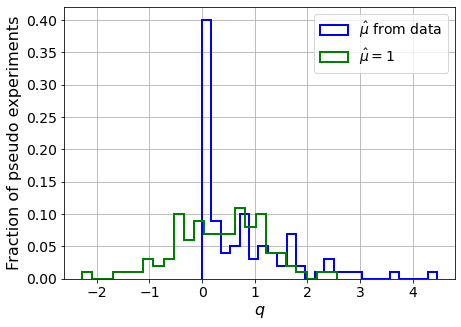

/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  9117.12330636  8814.92593825
  8452.92209966  8011.37398705  7478.634272    6844.3457194
  6092.95745027  5207.42077754  4173.99527725  2978.11885856
  1594.09412057    26.37596159 -1687.81125148 -3831.85990453]
  warnings.warn(
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:962: RuntimeWarning: invalid value encountered in subtract
  (array - array_means[:, np.newaxis]) ** 2, axis=1, weights=weights
/home/martinrios/.virtualenvs/pheno/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
 11222.92694417 11181.03807914 11047.61328645 10798.55848009
 

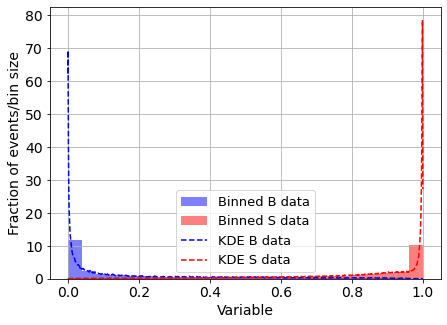

KDE Kernel:  epanechnikov
Background bandwidth:  0.0019008479046983867
Signal bandwidth:  0.0007122485584859914
This may take a while...
1 done
2 done
3 done
4 done


  0%|▏                                                                  | 4/2000 [00:00<06:31,  5.09it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.12613171916975843
<p_{s}(Sdata)> = 35.00284157844147
<p_{b}(Bdata)> = 16.122364560773743
<p_{s}(Bdata)> = 0.26968828909019676


  1%|▍                                                                 | 15/2000 [00:03<06:01,  5.49it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1893289949737867
<p_{s}(Sdata)> = 29.88559654359503
<p_{b}(Bdata)> = 16.16382783078213
<p_{s}(Bdata)> = 0.2632032297183169


  1%|▌                                                                 | 17/2000 [00:03<05:00,  6.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18385496492783177
<p_{s}(Sdata)> = 9.112277723525839
<p_{b}(Bdata)> = 15.926508377480605
<p_{s}(Bdata)> = 0.26461885590163897


  1%|▋                                                                 | 20/2000 [00:04<06:43,  4.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.41134661620324753
<p_{s}(Sdata)> = 2.630098007484535
<p_{b}(Bdata)> = 16.203853951317786
<p_{s}(Bdata)> = 0.2592203303080656


  1%|▊                                                                 | 25/2000 [00:05<09:30,  3.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2839165933788324
<p_{s}(Sdata)> = 8.960258349139874
<p_{b}(Bdata)> = 16.033900458321977
<p_{s}(Bdata)> = 0.2548025278505572


  1%|▉                                                                 | 29/2000 [00:06<09:36,  3.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27198333000244085
<p_{s}(Sdata)> = 10.452932879964356
<p_{b}(Bdata)> = 16.247369617135647
<p_{s}(Bdata)> = 0.2547597897112727


  2%|█▏                                                                | 35/2000 [00:07<06:03,  5.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3332942041066994
<p_{s}(Sdata)> = 5.446438957513459
<p_{b}(Bdata)> = 15.732039842079722
<p_{s}(Bdata)> = 0.26413120753569114
muhat = -0.1
<p_{b}(Sdata)> = 0.19751473468137498
<p_{s}(Sdata)> = 12.540494508980743
<p_{b}(Bdata)> = 16.034427402511753
<p_{s}(Bdata)> = 0.2516087152183421
muhat = -0.1
<p_{b}(Sdata)> = 0.1881041915738674
<p_{s}(Sdata)> = 10.238830838805496
<p_{b}(Bdata)> = 16.095353834806787
<p_{s}(Bdata)> = 0.2529355515564233


  2%|█▎                                                                | 40/2000 [00:08<06:09,  5.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2848656557085839
<p_{s}(Sdata)> = 4.932307399879078
<p_{b}(Bdata)> = 15.940097195148521
<p_{s}(Bdata)> = 0.2602008962134515


  3%|█▊                                                                | 54/2000 [00:12<08:32,  3.80it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.3799523149604755
<p_{s}(Sdata)> = 9.527391645023517
<p_{b}(Bdata)> = 15.888578492731043
<p_{s}(Bdata)> = 0.27951876072348714


  3%|██                                                                | 61/2000 [00:14<11:33,  2.79it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18924882606244786
<p_{s}(Sdata)> = 22.39114751821102
<p_{b}(Bdata)> = 15.563366660144231
<p_{s}(Bdata)> = 0.2641809042458251


  3%|██▎                                                               | 69/2000 [00:17<10:51,  2.97it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14902208835513248
<p_{s}(Sdata)> = 22.456005103630037
<p_{b}(Bdata)> = 16.18525863914191
<p_{s}(Bdata)> = 0.27099158236394705


  4%|██▍                                                               | 75/2000 [00:18<07:08,  4.49it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.5087786032721987
<p_{s}(Sdata)> = 20.569177409995405
<p_{b}(Bdata)> = 15.970520850652065
<p_{s}(Bdata)> = 0.2721937358066239


  4%|██▋                                                               | 82/2000 [00:20<08:29,  3.76it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14498396932490268
<p_{s}(Sdata)> = 21.81704571471958
<p_{b}(Bdata)> = 16.020066657391233
<p_{s}(Bdata)> = 0.2665921607488982


  5%|███                                                               | 93/2000 [00:23<10:59,  2.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5939150307824684
<p_{s}(Sdata)> = 5.518561549588606
<p_{b}(Bdata)> = 16.102968500007062
<p_{s}(Bdata)> = 0.25988554754090903


  5%|███▏                                                              | 95/2000 [00:23<07:55,  4.01it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20348188335030493
<p_{s}(Sdata)> = 24.17391135927047
<p_{b}(Bdata)> = 16.019892159290784
<p_{s}(Bdata)> = 0.2688667247993952


  5%|███▎                                                             | 101/2000 [00:24<05:24,  5.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27829813809864096
<p_{s}(Sdata)> = 1.794850628712233
<p_{b}(Bdata)> = 15.941065639804672
<p_{s}(Bdata)> = 0.25806502915772633
muhat = -0.1
<p_{b}(Sdata)> = 0.3681490841698002
<p_{s}(Sdata)> = 9.55908651953498
<p_{b}(Bdata)> = 16.039389568851977
<p_{s}(Bdata)> = 0.25440951600560024
muhat = 2.1
<p_{b}(Sdata)> = 0.19766093234308127
<p_{s}(Sdata)> = 21.73451064416918
<p_{b}(Bdata)> = 16.013627226972705
<p_{s}(Bdata)> = 0.2686035176925269


  5%|███▍                                                             | 105/2000 [00:25<07:38,  4.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24188201393092962
<p_{s}(Sdata)> = 11.7998988550367
<p_{b}(Bdata)> = 16.318531833083654
<p_{s}(Bdata)> = 0.2556114191628129


  6%|███▋                                                             | 112/2000 [00:27<06:06,  5.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17189170877728613
<p_{s}(Sdata)> = 11.642587904042575
<p_{b}(Bdata)> = 16.170194372410982
<p_{s}(Bdata)> = 0.2559556181757434


  6%|████                                                             | 125/2000 [00:30<05:16,  5.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2979721359506818
<p_{s}(Sdata)> = 3.493707254151956
<p_{b}(Bdata)> = 16.311191168198462
<p_{s}(Bdata)> = 0.2589556168421928


  6%|████▏                                                            | 130/2000 [00:30<04:59,  6.25it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17014474757153178
<p_{s}(Sdata)> = 23.274617589325544
<p_{b}(Bdata)> = 16.11875640864262
<p_{s}(Bdata)> = 0.26884409970232637


  7%|████▎                                                            | 133/2000 [00:31<05:29,  5.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.350574193890463
<p_{s}(Sdata)> = 5.581010104715497
<p_{b}(Bdata)> = 15.918778573588945
<p_{s}(Bdata)> = 0.25816374051393687


  7%|████▍                                                            | 137/2000 [00:32<04:56,  6.27it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25125279488589364
<p_{s}(Sdata)> = 1.7857118849248736
<p_{b}(Bdata)> = 16.065784348879053
<p_{s}(Bdata)> = 0.26625676434345485
muhat = -0.1
<p_{b}(Sdata)> = 0.32088661984382627
<p_{s}(Sdata)> = 8.75360753085635
<p_{b}(Bdata)> = 16.229294686168526
<p_{s}(Bdata)> = 0.2553266798010243


  7%|████▌                                                            | 142/2000 [00:33<06:35,  4.70it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2640837852402251
<p_{s}(Sdata)> = 15.102010876335713
<p_{b}(Bdata)> = 16.095173924491405
<p_{s}(Bdata)> = 0.25646468715512666


  7%|████▋                                                            | 144/2000 [00:33<06:23,  4.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2921113846610773
<p_{s}(Sdata)> = 10.01082449416854
<p_{b}(Bdata)> = 15.940596128843968
<p_{s}(Bdata)> = 0.258886621572254


  8%|████▉                                                            | 150/2000 [00:35<06:48,  4.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29527637502764853
<p_{s}(Sdata)> = 1.173569950460961
<p_{b}(Bdata)> = 15.89396903450168
<p_{s}(Bdata)> = 0.262778895542846


  8%|█████▏                                                           | 158/2000 [00:36<04:44,  6.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21923984675288022
<p_{s}(Sdata)> = 11.738219677346686
<p_{b}(Bdata)> = 16.19533102132178
<p_{s}(Bdata)> = 0.2592083453098586
muhat = -0.1
<p_{b}(Sdata)> = 0.3605755198500079
<p_{s}(Sdata)> = 2.2955705629707857
<p_{b}(Bdata)> = 16.123992056284823
<p_{s}(Bdata)> = 0.2666677135419626


  8%|█████▎                                                           | 163/2000 [00:38<08:41,  3.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18347376702618046
<p_{s}(Sdata)> = 11.18555132974228
<p_{b}(Bdata)> = 16.162282162468532
<p_{s}(Bdata)> = 0.25760913061829


  8%|█████▍                                                           | 167/2000 [00:38<05:16,  5.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23739860221952153
<p_{s}(Sdata)> = 1.3810199754855543
<p_{b}(Bdata)> = 15.821805056915698
<p_{s}(Bdata)> = 0.25917562285376144
muhat = 2.1
<p_{b}(Sdata)> = 0.16554825948222845
<p_{s}(Sdata)> = 31.483367069223267
<p_{b}(Bdata)> = 15.837144932589482
<p_{s}(Bdata)> = 0.27261124103607737


  9%|█████▌                                                           | 173/2000 [00:39<04:46,  6.37it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22777717987807164
<p_{s}(Sdata)> = 22.127648184067784
<p_{b}(Bdata)> = 16.096389795570584
<p_{s}(Bdata)> = 0.27495448739674716


  9%|█████▋                                                           | 174/2000 [00:40<05:29,  5.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19003833474838516
<p_{s}(Sdata)> = 18.793065088925935
<p_{b}(Bdata)> = 16.098513298249507
<p_{s}(Bdata)> = 0.25869801182315677


  9%|█████▊                                                           | 180/2000 [00:41<04:08,  7.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28396869977693406
<p_{s}(Sdata)> = 2.30446781024168
<p_{b}(Bdata)> = 15.911884851275108
<p_{s}(Bdata)> = 0.25404933920566


  9%|█████▉                                                           | 184/2000 [00:42<08:35,  3.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30300652879225504
<p_{s}(Sdata)> = 1.2392590865302011
<p_{b}(Bdata)> = 16.1635111192163
<p_{s}(Bdata)> = 0.25930806806682394


 10%|██████▎                                                          | 193/2000 [00:44<05:45,  5.23it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23385548404653386
<p_{s}(Sdata)> = 5.800676946495033
<p_{b}(Bdata)> = 15.763427742235296
<p_{s}(Bdata)> = 0.25910971048027936


 10%|██████▎                                                          | 195/2000 [00:44<06:32,  4.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6698394319380669
<p_{s}(Sdata)> = 7.565672181874289
<p_{b}(Bdata)> = 15.9387062707934
<p_{s}(Bdata)> = 0.2599533550737005


 10%|██████▌                                                          | 202/2000 [00:46<07:41,  3.90it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2400949190383289
<p_{s}(Sdata)> = 15.929165768329744
<p_{b}(Bdata)> = 15.8279480228186
<p_{s}(Bdata)> = 0.2610601443460756


 11%|███████▏                                                         | 222/2000 [00:51<05:26,  5.45it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22533836920606604
<p_{s}(Sdata)> = 16.885544775831956
<p_{b}(Bdata)> = 16.242190810365912
<p_{s}(Bdata)> = 0.256542730316665
muhat = -0.1
<p_{b}(Sdata)> = 0.31870716584613273
<p_{s}(Sdata)> = 5.836959330424365
<p_{b}(Bdata)> = 16.135455271191695
<p_{s}(Bdata)> = 0.25714623753064814


 11%|███████▍                                                         | 228/2000 [00:52<06:04,  4.86it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.11245002058488596
<p_{s}(Sdata)> = 23.984334182906085
<p_{b}(Bdata)> = 16.17610003914857
<p_{s}(Bdata)> = 0.2667519334910797


 12%|███████▌                                                         | 233/2000 [00:53<06:36,  4.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2412082357210707
<p_{s}(Sdata)> = 8.728375676009646
<p_{b}(Bdata)> = 16.190368358438604
<p_{s}(Bdata)> = 0.25669563784568034


 12%|███████▋                                                         | 236/2000 [00:54<07:41,  3.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.42473517825516865
<p_{s}(Sdata)> = 2.563732112336491
<p_{b}(Bdata)> = 16.031922359633036
<p_{s}(Bdata)> = 0.2574667263498734


 12%|███████▊                                                         | 242/2000 [00:56<06:26,  4.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1359684204845964
<p_{s}(Sdata)> = 18.351286936150903
<p_{b}(Bdata)> = 16.176296012020295
<p_{s}(Bdata)> = 0.25384967380958057


 12%|███████▉                                                         | 245/2000 [00:56<04:49,  6.06it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25973044440004217
<p_{s}(Sdata)> = 11.357040872991615
<p_{b}(Bdata)> = 16.255322575817367
<p_{s}(Bdata)> = 0.27413979720749804
muhat = 2.1
<p_{b}(Sdata)> = 0.18188191048744035
<p_{s}(Sdata)> = 22.33021382584729
<p_{b}(Bdata)> = 15.94861602096783
<p_{s}(Bdata)> = 0.2690297401516665


 13%|████████▍                                                        | 260/2000 [01:01<09:08,  3.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21558576566124782
<p_{s}(Sdata)> = 5.940514461652692
<p_{b}(Bdata)> = 16.10670492027364
<p_{s}(Bdata)> = 0.2596526689132337


 13%|████████▋                                                        | 267/2000 [01:02<06:02,  4.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18795466047989334
<p_{s}(Sdata)> = 8.977538680200501
<p_{b}(Bdata)> = 15.841802003397058
<p_{s}(Bdata)> = 0.2668582497191085
muhat = 2.1
<p_{b}(Sdata)> = 0.22584416347917857
<p_{s}(Sdata)> = 24.56195880866916
<p_{b}(Bdata)> = 16.139882794397938
<p_{s}(Bdata)> = 0.2690300180323431


 14%|████████▊                                                        | 271/2000 [01:03<06:18,  4.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21870693439425204
<p_{s}(Sdata)> = 11.69853210220713
<p_{b}(Bdata)> = 16.30459761838108
<p_{s}(Bdata)> = 0.25710050729593886


 14%|█████████                                                        | 280/2000 [01:05<08:26,  3.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3981563227540519
<p_{s}(Sdata)> = 3.6202122812562862
<p_{b}(Bdata)> = 15.825445378195784
<p_{s}(Bdata)> = 0.259203880687044


 15%|█████████▌                                                       | 293/2000 [01:08<05:14,  5.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2974109751864797
<p_{s}(Sdata)> = 2.8566622821687844
<p_{b}(Bdata)> = 16.06718423909406
<p_{s}(Bdata)> = 0.2551777563164577


 16%|██████████▏                                                      | 315/2000 [01:14<06:22,  4.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31275793568604626
<p_{s}(Sdata)> = 2.22383627897315
<p_{b}(Bdata)> = 16.38292603275137
<p_{s}(Bdata)> = 0.26173461240771606


 16%|██████████▍                                                      | 320/2000 [01:15<04:49,  5.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2944155359983625
<p_{s}(Sdata)> = 6.163716611197553
<p_{b}(Bdata)> = 16.113354070011276
<p_{s}(Bdata)> = 0.2629930381747207
muhat = -0.1
<p_{b}(Sdata)> = 0.21569858200329275
<p_{s}(Sdata)> = 9.070870265279824
<p_{b}(Bdata)> = 15.86884865334921
<p_{s}(Bdata)> = 0.25644387567568927


 16%|██████████▌                                                      | 325/2000 [01:16<05:17,  5.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22251394389220222
<p_{s}(Sdata)> = 17.615154172098237
<p_{b}(Bdata)> = 15.955946578316205
<p_{s}(Bdata)> = 0.2536468093290856
muhat = -0.1
<p_{b}(Sdata)> = 0.47799617877590184
<p_{s}(Sdata)> = 9.003663362865634
<p_{b}(Bdata)> = 16.139212380109676
<p_{s}(Bdata)> = 0.25873786192585224


 16%|██████████▋                                                      | 327/2000 [01:17<06:00,  4.65it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1663477823614192
<p_{s}(Sdata)> = 36.03995835554333
<p_{b}(Bdata)> = 16.320116158334073
<p_{s}(Bdata)> = 0.26120618404882184


 17%|██████████▉                                                      | 337/2000 [01:20<09:27,  2.93it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2127839726578302
<p_{s}(Sdata)> = 24.92072402523509
<p_{b}(Bdata)> = 15.97475389407782
<p_{s}(Bdata)> = 0.2714480352922079


 17%|███████████                                                      | 339/2000 [01:20<07:34,  3.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22440795498985086
<p_{s}(Sdata)> = 9.801578440349177
<p_{b}(Bdata)> = 16.096921845763735
<p_{s}(Bdata)> = 0.2640841021244755


 17%|███████████                                                      | 342/2000 [01:21<07:49,  3.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27720238794768653
<p_{s}(Sdata)> = 12.961890923604422
<p_{b}(Bdata)> = 16.091900831981643
<p_{s}(Bdata)> = 0.2573956828611024


 17%|███████████▏                                                     | 345/2000 [01:22<07:32,  3.65it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22143086793131478
<p_{s}(Sdata)> = 20.198075322129583
<p_{b}(Bdata)> = 15.723428208141451
<p_{s}(Bdata)> = 0.2524982967451291


 18%|███████████▍                                                     | 350/2000 [01:23<05:32,  4.96it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1604036525953184
<p_{s}(Sdata)> = 22.405949701335206
<p_{b}(Bdata)> = 16.01253023228789
<p_{s}(Bdata)> = 0.26756143055640447
muhat = -0.1
<p_{b}(Sdata)> = 0.16480273678276017
<p_{s}(Sdata)> = 5.683452356557438
<p_{b}(Bdata)> = 16.120730524646333
<p_{s}(Bdata)> = 0.2610098022628656


 18%|███████████▌                                                     | 354/2000 [01:24<08:01,  3.42it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1877195328035429
<p_{s}(Sdata)> = 23.98588380478733
<p_{b}(Bdata)> = 15.757375415777867
<p_{s}(Bdata)> = 0.27299271685333865


 18%|███████████▋                                                     | 361/2000 [01:26<08:16,  3.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.12230509798848532
<p_{s}(Sdata)> = 12.053666044519543
<p_{b}(Bdata)> = 16.09890722067012
<p_{s}(Bdata)> = 0.26056606145072125


 18%|███████████▉                                                     | 367/2000 [01:27<06:05,  4.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15313648160694107
<p_{s}(Sdata)> = 17.424436442301023
<p_{b}(Bdata)> = 16.229002268099634
<p_{s}(Bdata)> = 0.2582793080562096


 19%|████████████                                                     | 373/2000 [01:28<04:04,  6.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2563071598780216
<p_{s}(Sdata)> = 4.61062246388742
<p_{b}(Bdata)> = 15.966107846693873
<p_{s}(Bdata)> = 0.26051682782758456
muhat = -0.1
<p_{b}(Sdata)> = 0.30643921234721283
<p_{s}(Sdata)> = 7.043675275508793
<p_{b}(Bdata)> = 16.149029065790113
<p_{s}(Bdata)> = 0.2594897942894251
muhat = -0.1
<p_{b}(Sdata)> = 0.21769368589408028
<p_{s}(Sdata)> = 8.149278777323646
<p_{b}(Bdata)> = 16.14490433951414
<p_{s}(Bdata)> = 0.26170866487984507
muhat = 2.1
<p_{b}(Sdata)> = 0.24065194724370473
<p_{s}(Sdata)> = 11.170414770562422
<p_{b}(Bdata)> = 16.082916553246676
<p_{s}(Bdata)> = 0.27340646251455336


 19%|████████████▌                                                    | 387/2000 [01:32<05:37,  4.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6190651259387785
<p_{s}(Sdata)> = 3.786207471545752
<p_{b}(Bdata)> = 16.147240659772528
<p_{s}(Bdata)> = 0.2539655771579498
muhat = 2.1
<p_{b}(Sdata)> = 0.23089236402795485
<p_{s}(Sdata)> = 21.647432683421357
<p_{b}(Bdata)> = 16.12687149984328
<p_{s}(Bdata)> = 0.2682221055681535


 20%|████████████▋                                                    | 390/2000 [01:32<05:34,  4.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31462520107574005
<p_{s}(Sdata)> = 9.468521653707253
<p_{b}(Bdata)> = 16.07673120448902
<p_{s}(Bdata)> = 0.25706293060482366


 20%|████████████▉                                                    | 397/2000 [01:34<05:29,  4.86it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2654850539268779
<p_{s}(Sdata)> = 5.33840306750252
<p_{b}(Bdata)> = 16.027705737514857
<p_{s}(Bdata)> = 0.25545097365072655


 20%|█████████████▏                                                   | 404/2000 [01:35<04:13,  6.29it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18602034899898992
<p_{s}(Sdata)> = 10.792965324431611
<p_{b}(Bdata)> = 15.976481413204501
<p_{s}(Bdata)> = 0.2758626344580178
muhat = 2.1
<p_{b}(Sdata)> = 0.14183636401294605
<p_{s}(Sdata)> = 21.3134752483475
<p_{b}(Bdata)> = 16.45328808355841
<p_{s}(Bdata)> = 0.2682176524257074


 21%|█████████████▌                                                   | 418/2000 [01:38<04:25,  5.95it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18008615529396124
<p_{s}(Sdata)> = 29.194796151202585
<p_{b}(Bdata)> = 15.863064776570216
<p_{s}(Bdata)> = 0.267119777921329
muhat = 2.1
<p_{b}(Sdata)> = 0.2747582066702333
<p_{s}(Sdata)> = 15.148635781242836
<p_{b}(Bdata)> = 16.118561080894413
<p_{s}(Bdata)> = 0.2698530218837702


 21%|█████████████▊                                                   | 425/2000 [01:40<07:27,  3.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20116899464545598
<p_{s}(Sdata)> = 5.778739434080812
<p_{b}(Bdata)> = 16.14295140975125
<p_{s}(Bdata)> = 0.25870689467963487


 22%|██████████████▏                                                  | 436/2000 [01:42<04:35,  5.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.47234734282674523
<p_{s}(Sdata)> = 3.5947092103433413
<p_{b}(Bdata)> = 15.904569306160072
<p_{s}(Bdata)> = 0.2619490360462273


 22%|██████████████▎                                                  | 439/2000 [01:43<04:35,  5.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24172120794181703
<p_{s}(Sdata)> = 13.282360196947797
<p_{b}(Bdata)> = 16.24148307635654
<p_{s}(Bdata)> = 0.2548017134622558


 22%|██████████████▌                                                  | 447/2000 [01:45<06:36,  3.91it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22505194637990691
<p_{s}(Sdata)> = 20.13260051647442
<p_{b}(Bdata)> = 16.238915493553318
<p_{s}(Bdata)> = 0.2766097748492451


 23%|██████████████▉                                                  | 459/2000 [01:48<04:34,  5.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24210998892077126
<p_{s}(Sdata)> = 6.364230291032441
<p_{b}(Bdata)> = 16.187911826412034
<p_{s}(Bdata)> = 0.25406054875460476


 23%|███████████████                                                  | 463/2000 [01:49<05:08,  4.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48397303970294187
<p_{s}(Sdata)> = 1.1897726384956409
<p_{b}(Bdata)> = 16.284262974541015
<p_{s}(Bdata)> = 0.26419667186767304


 23%|███████████████▏                                                 | 466/2000 [01:50<06:15,  4.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2706408643390056
<p_{s}(Sdata)> = 6.994243841065548
<p_{b}(Bdata)> = 16.070784649055852
<p_{s}(Bdata)> = 0.2578250786256684


 24%|███████████████▎                                                 | 470/2000 [01:50<04:07,  6.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25073000796293343
<p_{s}(Sdata)> = 4.356751769023885
<p_{b}(Bdata)> = 16.1193469307087
<p_{s}(Bdata)> = 0.26304516859125215
muhat = 2.1
<p_{b}(Sdata)> = 0.22769488075287897
<p_{s}(Sdata)> = 19.74131792893906
<p_{b}(Bdata)> = 16.138360718317877
<p_{s}(Bdata)> = 0.2671850835013549


 24%|███████████████▎                                                 | 472/2000 [01:51<06:11,  4.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34246598079027946
<p_{s}(Sdata)> = 7.520277377947275
<p_{b}(Bdata)> = 15.936576874985262
<p_{s}(Bdata)> = 0.2560003275660391


 24%|███████████████▉                                                 | 490/2000 [01:56<07:13,  3.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17729919572934322
<p_{s}(Sdata)> = 9.535540066540921
<p_{b}(Bdata)> = 16.089314147129695
<p_{s}(Bdata)> = 0.2603184646832114


 25%|███████████████▉                                                 | 492/2000 [01:57<06:36,  3.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2480117105491289
<p_{s}(Sdata)> = 6.599055396962282
<p_{b}(Bdata)> = 16.020011815274245
<p_{s}(Bdata)> = 0.25785002699490506


 25%|████████████████▎                                                | 500/2000 [01:58<04:22,  5.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.46406232763836236
<p_{s}(Sdata)> = 1.3456215195340833
<p_{b}(Bdata)> = 15.906957607185074
<p_{s}(Bdata)> = 0.26454588758350683
muhat = 2.1
<p_{b}(Sdata)> = 0.3428887016811184
<p_{s}(Sdata)> = 15.649887033613208
<p_{b}(Bdata)> = 15.943287835510697
<p_{s}(Bdata)> = 0.2815615894262066
muhat = -0.1
<p_{b}(Sdata)> = 0.3947762774179891
<p_{s}(Sdata)> = 10.136696047885112
<p_{b}(Bdata)> = 16.10514859988677
<p_{s}(Bdata)> = 0.2528676954855847


 25%|████████████████▎                                                | 503/2000 [01:59<03:26,  7.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19846859727962346
<p_{s}(Sdata)> = 14.537743093382286
<p_{b}(Bdata)> = 15.859525477814884
<p_{s}(Bdata)> = 0.25705637405004317


 25%|████████████████▍                                                | 507/2000 [02:00<06:12,  4.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3121992727599337
<p_{s}(Sdata)> = 2.211097181784379
<p_{b}(Bdata)> = 16.081687001890472
<p_{s}(Bdata)> = 0.2568162665033993


 26%|████████████████▋                                                | 513/2000 [02:01<03:55,  6.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6558823807689556
<p_{s}(Sdata)> = 1.7915411407580972
<p_{b}(Bdata)> = 16.01008532238064
<p_{s}(Bdata)> = 0.2599201918237618


 26%|█████████████████▏                                               | 530/2000 [02:05<06:40,  3.67it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18873180264783487
<p_{s}(Sdata)> = 27.24861955056795
<p_{b}(Bdata)> = 15.738882122375053
<p_{s}(Bdata)> = 0.2721366379442435


 27%|█████████████████▎                                               | 534/2000 [02:05<03:50,  6.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2667442406558418
<p_{s}(Sdata)> = 4.045217345253325
<p_{b}(Bdata)> = 16.146081433213354
<p_{s}(Bdata)> = 0.26077750689852763
muhat = -0.1
<p_{b}(Sdata)> = 0.27554959539672924
<p_{s}(Sdata)> = 12.058310127060318
<p_{b}(Bdata)> = 16.13649428048066
<p_{s}(Bdata)> = 0.2540099286378205
muhat = -0.1
<p_{b}(Sdata)> = 0.29594683019304185
<p_{s}(Sdata)> = 8.344788368652218
<p_{b}(Bdata)> = 16.135003319817148
<p_{s}(Bdata)> = 0.25923684712297584


 27%|█████████████████▌                                               | 539/2000 [02:07<05:43,  4.25it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19552492799262375
<p_{s}(Sdata)> = 19.27357341982404
<p_{b}(Bdata)> = 15.930475704582559
<p_{s}(Bdata)> = 0.2723709977809588


 28%|█████████████████▉                                               | 551/2000 [02:09<03:58,  6.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29968006202757475
<p_{s}(Sdata)> = 5.460628982614244
<p_{b}(Bdata)> = 16.28744007660128
<p_{s}(Bdata)> = 0.2539979232012378
muhat = 2.1
<p_{b}(Sdata)> = 0.17073872521698483
<p_{s}(Sdata)> = 26.026798762791227
<p_{b}(Bdata)> = 15.94638443635253
<p_{s}(Bdata)> = 0.26657529929847995


 28%|█████████████████▉                                               | 553/2000 [02:10<04:27,  5.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32837960043925274
<p_{s}(Sdata)> = 2.2557919123417345
<p_{b}(Bdata)> = 16.18168536685538
<p_{s}(Bdata)> = 0.2612138064365762


 28%|██████████████████▍                                              | 566/2000 [02:13<04:49,  4.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29584854154074713
<p_{s}(Sdata)> = 7.2137710936116495
<p_{b}(Bdata)> = 16.163154461012297
<p_{s}(Bdata)> = 0.25833846784158315
muhat = -0.1
<p_{b}(Sdata)> = 0.19537966854931554
<p_{s}(Sdata)> = 7.277265685565342
<p_{b}(Bdata)> = 16.036059926393413
<p_{s}(Bdata)> = 0.2600510727617286


 28%|██████████████████▍                                              | 568/2000 [02:13<05:01,  4.76it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.228602147581942
<p_{s}(Sdata)> = 17.947558733370133
<p_{b}(Bdata)> = 15.99080458241295
<p_{s}(Bdata)> = 0.2783617327499178


 29%|██████████████████▌                                              | 573/2000 [02:15<06:40,  3.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23494571020011323
<p_{s}(Sdata)> = 13.866300730914656
<p_{b}(Bdata)> = 16.336755749178977
<p_{s}(Bdata)> = 0.26112640701061346


 29%|██████████████████▊                                              | 580/2000 [02:16<04:39,  5.08it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25866629153511667
<p_{s}(Sdata)> = 2.977051103431272
<p_{b}(Bdata)> = 15.874938787702058
<p_{s}(Bdata)> = 0.260653140901991
muhat = 2.1
<p_{b}(Sdata)> = 0.2384045420614995
<p_{s}(Sdata)> = 23.66242107642794
<p_{b}(Bdata)> = 15.735395093455809
<p_{s}(Bdata)> = 0.2713623047963555


 29%|███████████████████                                              | 585/2000 [02:17<03:42,  6.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.38818993561017484
<p_{s}(Sdata)> = 5.914365691323262
<p_{b}(Bdata)> = 16.346808021297576
<p_{s}(Bdata)> = 0.2580974305087364
muhat = 2.1
<p_{b}(Sdata)> = 0.13607796940022723
<p_{s}(Sdata)> = 30.464566617277725
<p_{b}(Bdata)> = 15.946624578904546
<p_{s}(Bdata)> = 0.26836328633393775


 29%|███████████████████▏                                             | 589/2000 [02:17<03:25,  6.87it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16627796788722388
<p_{s}(Sdata)> = 14.165842277019886
<p_{b}(Bdata)> = 15.922778425880177
<p_{s}(Bdata)> = 0.2751782250787102


 30%|███████████████████▏                                             | 591/2000 [02:18<02:49,  8.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4359731122294672
<p_{s}(Sdata)> = 5.3943261846529404
<p_{b}(Bdata)> = 15.882138078642114
<p_{s}(Bdata)> = 0.2629543270873395
muhat = -0.1
<p_{b}(Sdata)> = 0.3448952577766012
<p_{s}(Sdata)> = 9.060443313375698
<p_{b}(Bdata)> = 15.931254702069676
<p_{s}(Bdata)> = 0.25291763746162327


 30%|███████████████████▎                                             | 594/2000 [02:18<05:01,  4.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15736596791589993
<p_{s}(Sdata)> = 9.734974653094243
<p_{b}(Bdata)> = 15.944537984532518
<p_{s}(Bdata)> = 0.2557198057908859


 31%|███████████████████▉                                             | 614/2000 [02:23<06:04,  3.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23439743070259564
<p_{s}(Sdata)> = 4.124911692687779
<p_{b}(Bdata)> = 16.109442309734856
<p_{s}(Bdata)> = 0.2611728540816694


 31%|████████████████████                                             | 617/2000 [02:24<06:00,  3.83it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22404677266090037
<p_{s}(Sdata)> = 21.890520209404382
<p_{b}(Bdata)> = 16.281427685183214
<p_{s}(Bdata)> = 0.2691788607627582


 31%|████████████████████▏                                            | 622/2000 [02:25<06:09,  3.73it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21863099381830897
<p_{s}(Sdata)> = 23.465041151674576
<p_{b}(Bdata)> = 16.025367950853646
<p_{s}(Bdata)> = 0.2731412082804741


 31%|████████████████████▍                                            | 627/2000 [02:26<03:31,  6.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34678137542901943
<p_{s}(Sdata)> = 8.311671602170799
<p_{b}(Bdata)> = 16.304383057336953
<p_{s}(Bdata)> = 0.2562854622833019
muhat = -0.1
<p_{b}(Sdata)> = 0.278293639343277
<p_{s}(Sdata)> = 6.357227468007087
<p_{b}(Bdata)> = 15.958901232725793
<p_{s}(Bdata)> = 0.2610779212384439


 32%|████████████████████▌                                            | 632/2000 [02:27<03:32,  6.45it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22362013510506198
<p_{s}(Sdata)> = 18.2283901486586
<p_{b}(Bdata)> = 15.948377364918466
<p_{s}(Bdata)> = 0.26950680126514426
muhat = -0.1
<p_{b}(Sdata)> = 0.3182381892501126
<p_{s}(Sdata)> = 1.0479345314698125
<p_{b}(Bdata)> = 16.067096454234314
<p_{s}(Bdata)> = 0.2524369072738233


 32%|████████████████████▌                                            | 633/2000 [02:27<03:39,  6.22it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1665703689730417
<p_{s}(Sdata)> = 19.810367782913954
<p_{b}(Bdata)> = 16.05639550158786
<p_{s}(Bdata)> = 0.2724229776423942


 32%|████████████████████▊                                            | 640/2000 [02:29<07:03,  3.21it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2506139759628591
<p_{s}(Sdata)> = 21.410637399362173
<p_{b}(Bdata)> = 16.053989516017197
<p_{s}(Bdata)> = 0.26408993897216126


 32%|█████████████████████▏                                           | 650/2000 [02:31<04:26,  5.06it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22487180145183955
<p_{s}(Sdata)> = 5.7856638587986104
<p_{b}(Bdata)> = 15.9763978599733
<p_{s}(Bdata)> = 0.26119152847625704


 33%|█████████████████████▏                                           | 652/2000 [02:32<03:17,  6.81it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2680161620663775
<p_{s}(Sdata)> = 1.8899549188056615
<p_{b}(Bdata)> = 16.145787183045073
<p_{s}(Bdata)> = 0.2629018630297861
muhat = -0.1
<p_{b}(Sdata)> = 0.2713257319008164
<p_{s}(Sdata)> = 12.083854711079367
<p_{b}(Bdata)> = 16.21661882991409
<p_{s}(Bdata)> = 0.2543554113510341


 33%|█████████████████████▎                                           | 654/2000 [02:32<03:30,  6.41it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.775258757628328
<p_{s}(Sdata)> = 6.949172747763191
<p_{b}(Bdata)> = 16.39827675385594
<p_{s}(Bdata)> = 0.2600715723473406


 33%|█████████████████████▎                                           | 656/2000 [02:32<03:43,  6.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.48549399584205855
<p_{s}(Sdata)> = 3.1828524157886298
<p_{b}(Bdata)> = 16.048503910168044
<p_{s}(Bdata)> = 0.25721647214628285


 33%|█████████████████████▍                                           | 661/2000 [02:33<04:28,  4.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3321167244470207
<p_{s}(Sdata)> = 4.447477184410753
<p_{b}(Bdata)> = 16.050307636369784
<p_{s}(Bdata)> = 0.25569480602593675


 34%|█████████████████████▊                                           | 672/2000 [02:36<03:58,  5.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2067902351656446
<p_{s}(Sdata)> = 8.013603343541607
<p_{b}(Bdata)> = 15.90441279140234
<p_{s}(Bdata)> = 0.26150958990933276
muhat = -0.1
<p_{b}(Sdata)> = 0.22442191705782097
<p_{s}(Sdata)> = 11.946304788338216
<p_{b}(Bdata)> = 16.008643033801157
<p_{s}(Bdata)> = 0.25413143077728306
muhat = 2.1
<p_{b}(Sdata)> = 0.22407087677998969
<p_{s}(Sdata)> = 18.08511504534219
<p_{b}(Bdata)> = 15.8617545090599
<p_{s}(Bdata)> = 0.26500534199266934


 34%|██████████████████████                                           | 679/2000 [02:38<05:31,  3.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15124814335198222
<p_{s}(Sdata)> = 9.936801715792145
<p_{b}(Bdata)> = 16.12179894073449
<p_{s}(Bdata)> = 0.25975065751458865


 34%|██████████████████████▎                                          | 687/2000 [02:40<03:45,  5.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3325809612649693
<p_{s}(Sdata)> = 9.407899962090575
<p_{b}(Bdata)> = 15.898029982407602
<p_{s}(Bdata)> = 0.258474835229116


 34%|██████████████████████▍                                          | 689/2000 [02:40<02:58,  7.35it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2230586693423824
<p_{s}(Sdata)> = 18.197879428555776
<p_{b}(Bdata)> = 15.969465490001365
<p_{s}(Bdata)> = 0.27417310016300944
muhat = -0.1
<p_{b}(Sdata)> = 0.2347740439344054
<p_{s}(Sdata)> = 1.9389146999659235
<p_{b}(Bdata)> = 15.869920470849221
<p_{s}(Bdata)> = 0.25950434364857217


 35%|██████████████████████▌                                          | 693/2000 [02:41<05:15,  4.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24006494958273147
<p_{s}(Sdata)> = 2.1024440516467964
<p_{b}(Bdata)> = 15.7352253325598
<p_{s}(Bdata)> = 0.2601249486580482


 35%|██████████████████████▋                                          | 699/2000 [02:42<04:27,  4.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23891623782470672
<p_{s}(Sdata)> = 4.686649010311457
<p_{b}(Bdata)> = 16.1870437563662
<p_{s}(Bdata)> = 0.25900738399388007


 35%|██████████████████████▊                                          | 702/2000 [02:43<02:59,  7.25it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3543142476013818
<p_{s}(Sdata)> = 6.220091792565011
<p_{b}(Bdata)> = 16.14226366007438
<p_{s}(Bdata)> = 0.2560923112792094
muhat = -0.1
<p_{b}(Sdata)> = 0.3204228212779938
<p_{s}(Sdata)> = 2.2263739921318457
<p_{b}(Bdata)> = 15.985648391656644
<p_{s}(Bdata)> = 0.2604543375297581
muhat = -0.1
<p_{b}(Sdata)> = 0.3795888082780569
<p_{s}(Sdata)> = 6.234887027913838
<p_{b}(Bdata)> = 16.310204371117926
<p_{s}(Bdata)> = 0.25528899558180557


 35%|██████████████████████▉                                          | 706/2000 [02:43<02:53,  7.46it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3978701772971811
<p_{s}(Sdata)> = 9.471809801782829
<p_{b}(Bdata)> = 16.04914618492764
<p_{s}(Bdata)> = 0.2556656171570822


 35%|███████████████████████                                          | 709/2000 [02:44<02:57,  7.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23331706557695875
<p_{s}(Sdata)> = 13.213396092247319
<p_{b}(Bdata)> = 15.94350392583856
<p_{s}(Bdata)> = 0.2569104169630973


 36%|███████████████████████▎                                         | 716/2000 [02:45<03:16,  6.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5143213585454868
<p_{s}(Sdata)> = 1.0673123674441405
<p_{b}(Bdata)> = 15.968288128508368
<p_{s}(Bdata)> = 0.2617280411879749
muhat = -0.1
<p_{b}(Sdata)> = 0.20789808749601105
<p_{s}(Sdata)> = 5.154994319316365
<p_{b}(Bdata)> = 15.804389213261262
<p_{s}(Bdata)> = 0.2519510223921117


 36%|███████████████████████▍                                         | 721/2000 [02:46<04:04,  5.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4551157539449639
<p_{s}(Sdata)> = 0.7331699888606674
<p_{b}(Bdata)> = 16.23825255496649
<p_{s}(Bdata)> = 0.25877434714465586


 36%|███████████████████████▋                                         | 727/2000 [02:47<03:47,  5.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.36843343806551276
<p_{s}(Sdata)> = 7.619851766830579
<p_{b}(Bdata)> = 16.056781209044107
<p_{s}(Bdata)> = 0.25894392969099106


 37%|███████████████████████▊                                         | 732/2000 [02:48<02:49,  7.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4282544928853726
<p_{s}(Sdata)> = 1.8737067880524656
<p_{b}(Bdata)> = 16.2753747513627
<p_{s}(Bdata)> = 0.25508767946439825
muhat = -0.1
<p_{b}(Sdata)> = 0.3110158699355232
<p_{s}(Sdata)> = 7.9342293580757035
<p_{b}(Bdata)> = 16.24316262934281
<p_{s}(Bdata)> = 0.2593258943585145


 37%|███████████████████████▉                                         | 735/2000 [02:49<03:19,  6.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.33640465259524205
<p_{s}(Sdata)> = 4.097432130399406
<p_{b}(Bdata)> = 16.369440907387762
<p_{s}(Bdata)> = 0.25741674013085886


 37%|████████████████████████                                         | 741/2000 [02:50<04:19,  4.85it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31447475999813373
<p_{s}(Sdata)> = 2.9199771587816277
<p_{b}(Bdata)> = 16.036031583897106
<p_{s}(Bdata)> = 0.25913360441786526
muhat = 2.1
<p_{b}(Sdata)> = 0.22416362454303856
<p_{s}(Sdata)> = 15.635510792730084
<p_{b}(Bdata)> = 16.024330361384074
<p_{s}(Bdata)> = 0.27345577039299274


 37%|████████████████████████▎                                        | 747/2000 [02:51<03:18,  6.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27342097770148804
<p_{s}(Sdata)> = 10.287448720552481
<p_{b}(Bdata)> = 15.971330648167767
<p_{s}(Bdata)> = 0.2600175405371437
muhat = -0.1
<p_{b}(Sdata)> = 0.5012305362203032
<p_{s}(Sdata)> = 15.882198102525019
<p_{b}(Bdata)> = 15.925666186326833
<p_{s}(Bdata)> = 0.25716150961037815


 37%|████████████████████████▎                                        | 748/2000 [02:52<04:44,  4.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2629349295267713
<p_{s}(Sdata)> = 5.236949158201836
<p_{b}(Bdata)> = 16.118611823488838
<p_{s}(Bdata)> = 0.2571323770305669


 38%|████████████████████████▍                                        | 751/2000 [02:52<04:07,  5.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.26062217931642845
<p_{s}(Sdata)> = 10.609941691336763
<p_{b}(Bdata)> = 15.936788840170095
<p_{s}(Bdata)> = 0.2761747047430602


 38%|████████████████████████▌                                        | 757/2000 [02:54<05:02,  4.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27040421354065
<p_{s}(Sdata)> = 2.808915471591739
<p_{b}(Bdata)> = 16.25598027898668
<p_{s}(Bdata)> = 0.25217561264840754


 39%|█████████████████████████                                        | 771/2000 [02:57<04:43,  4.33it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2690289983722807
<p_{s}(Sdata)> = 14.513702150706543
<p_{b}(Bdata)> = 16.457566207456047
<p_{s}(Bdata)> = 0.27643543946645655


 39%|█████████████████████████                                        | 773/2000 [02:57<03:30,  5.84it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2364663724750239
<p_{s}(Sdata)> = 16.4575624052016
<p_{b}(Bdata)> = 16.13116545583161
<p_{s}(Bdata)> = 0.27064102851739297
muhat = -0.1
<p_{b}(Sdata)> = 0.25363586677215993
<p_{s}(Sdata)> = 7.8714878236064125
<p_{b}(Bdata)> = 16.139129489086553
<p_{s}(Bdata)> = 0.25677796308348055


 39%|█████████████████████████▍                                       | 782/2000 [03:00<03:49,  5.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18009632579792226
<p_{s}(Sdata)> = 10.094384938246007
<p_{b}(Bdata)> = 16.322779466108123
<p_{s}(Bdata)> = 0.25545551438902747


 40%|█████████████████████████▋                                       | 790/2000 [03:02<05:55,  3.41it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.14514884103900907
<p_{s}(Sdata)> = 28.811969519676545
<p_{b}(Bdata)> = 16.34422158724685
<p_{s}(Bdata)> = 0.26331975618012626


 40%|██████████████████████████                                       | 800/2000 [03:04<05:24,  3.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2704846209246323
<p_{s}(Sdata)> = 9.347044343739844
<p_{b}(Bdata)> = 16.129006720581895
<p_{s}(Bdata)> = 0.2568634703480806


 41%|██████████████████████████▊                                      | 825/2000 [03:12<07:21,  2.66it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15092809344675276
<p_{s}(Sdata)> = 20.684696585740745
<p_{b}(Bdata)> = 16.157466054660524
<p_{s}(Bdata)> = 0.26789759068082963


 41%|██████████████████████████▉                                      | 829/2000 [03:13<05:58,  3.26it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20683885432585977
<p_{s}(Sdata)> = 17.979291569966875
<p_{b}(Bdata)> = 16.126674326886295
<p_{s}(Bdata)> = 0.26953426889219245


 42%|███████████████████████████▏                                     | 835/2000 [03:14<05:13,  3.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17119080085439753
<p_{s}(Sdata)> = 7.528336998590451
<p_{b}(Bdata)> = 16.120191256690152
<p_{s}(Bdata)> = 0.2604097938032848


 42%|███████████████████████████▍                                     | 843/2000 [03:16<05:26,  3.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28664868739756005
<p_{s}(Sdata)> = 14.547973665925815
<p_{b}(Bdata)> = 16.142908040061737
<p_{s}(Bdata)> = 0.25403749089293354


 43%|███████████████████████████▋                                     | 851/2000 [03:18<03:32,  5.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34734476457562596
<p_{s}(Sdata)> = 6.452608829847813
<p_{b}(Bdata)> = 15.93933322641346
<p_{s}(Bdata)> = 0.26686203207237813


 43%|███████████████████████████▊                                     | 854/2000 [03:19<04:31,  4.23it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20587349502407287
<p_{s}(Sdata)> = 19.57873666046391
<p_{b}(Bdata)> = 16.115529478719782
<p_{s}(Bdata)> = 0.27679505450789116


 43%|████████████████████████████▏                                    | 867/2000 [03:22<06:03,  3.12it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.175504756826079
<p_{s}(Sdata)> = 16.715443631232024
<p_{b}(Bdata)> = 16.03348103642562
<p_{s}(Bdata)> = 0.2721865503351738


 44%|████████████████████████████▍                                    | 874/2000 [03:24<05:01,  3.73it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18262904822524623
<p_{s}(Sdata)> = 16.691128923467573
<p_{b}(Bdata)> = 15.687944127549637
<p_{s}(Bdata)> = 0.2691727682870708


 44%|████████████████████████████▌                                    | 880/2000 [03:25<02:51,  6.54it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23215595884985993
<p_{s}(Sdata)> = 10.797966123819258
<p_{b}(Bdata)> = 16.05267702893672
<p_{s}(Bdata)> = 0.2571561518006543
muhat = -0.1
<p_{b}(Sdata)> = 0.27910802109978317
<p_{s}(Sdata)> = 10.660911878832268
<p_{b}(Bdata)> = 16.099008823806795
<p_{s}(Bdata)> = 0.2544890971160548
muhat = -0.1
<p_{b}(Sdata)> = 0.4557704446912924
<p_{s}(Sdata)> = 4.588742092981211
<p_{b}(Bdata)> = 15.855303435485405
<p_{s}(Bdata)> = 0.2565259371641509
muhat = 2.1
<p_{b}(Sdata)> = 0.14051330676977983
<p_{s}(Sdata)> = 31.947088380821942
<p_{b}(Bdata)> = 16.164648549089236
<p_{s}(Bdata)> = 0.2668622601097672


 44%|████████████████████████████▋                                    | 882/2000 [03:25<02:18,  8.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17282028799797486
<p_{s}(Sdata)> = 26.588640050776068
<p_{b}(Bdata)> = 16.226436824453298
<p_{s}(Bdata)> = 0.2683518300031713


 44%|████████████████████████████▉                                    | 890/2000 [03:27<03:15,  5.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29264808866248965
<p_{s}(Sdata)> = 5.522567961859544
<p_{b}(Bdata)> = 16.13073409687683
<p_{s}(Bdata)> = 0.2593923816529354
muhat = 2.1
<p_{b}(Sdata)> = 0.22536105295808712
<p_{s}(Sdata)> = 27.91089549198056
<p_{b}(Bdata)> = 16.14128602370287
<p_{s}(Bdata)> = 0.2708003859283167


 45%|█████████████████████████████▏                                   | 899/2000 [03:29<03:14,  5.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25109363090573356
<p_{s}(Sdata)> = 2.982692976058781
<p_{b}(Bdata)> = 15.963328839818683
<p_{s}(Bdata)> = 0.2596478761391865


 45%|█████████████████████████████▌                                   | 908/2000 [03:31<04:34,  3.98it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17688436452831674
<p_{s}(Sdata)> = 11.265553538241068
<p_{b}(Bdata)> = 15.97775157922509
<p_{s}(Bdata)> = 0.2558927494658751


 46%|█████████████████████████████▋                                   | 912/2000 [03:31<02:51,  6.36it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.12825491241599404
<p_{s}(Sdata)> = 26.246996868138087
<p_{b}(Bdata)> = 16.11357885004061
<p_{s}(Bdata)> = 0.2685712679912898
muhat = -0.1
<p_{b}(Sdata)> = 0.713181577744169
<p_{s}(Sdata)> = 1.0336027365700993
<p_{b}(Bdata)> = 15.875190018066196
<p_{s}(Bdata)> = 0.25651656497952696


 46%|█████████████████████████████▋                                   | 914/2000 [03:32<03:12,  5.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2033976437193234
<p_{s}(Sdata)> = 13.99735965320739
<p_{b}(Bdata)> = 15.937983484917371
<p_{s}(Bdata)> = 0.25706016480139404


 46%|█████████████████████████████▉                                   | 923/2000 [03:33<02:27,  7.29it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.18743761083243105
<p_{s}(Sdata)> = 18.74795907846956
<p_{b}(Bdata)> = 16.226823104019807
<p_{s}(Bdata)> = 0.26905233619403623
muhat = -0.1
<p_{b}(Sdata)> = 0.27023549154201687
<p_{s}(Sdata)> = 6.038571487351175
<p_{b}(Bdata)> = 16.178790593929588
<p_{s}(Bdata)> = 0.2561503901653838


 46%|██████████████████████████████▏                                  | 929/2000 [03:35<04:19,  4.13it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.12327965350314013
<p_{s}(Sdata)> = 23.763697708161324
<p_{b}(Bdata)> = 16.151730145546324
<p_{s}(Bdata)> = 0.26498945902736765


 48%|███████████████████████████████                                  | 957/2000 [03:42<03:52,  4.49it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2175748773574974
<p_{s}(Sdata)> = 1.7462220113860838
<p_{b}(Bdata)> = 15.763513222456536
<p_{s}(Bdata)> = 0.26209937268621397


 48%|███████████████████████████████▎                                 | 963/2000 [03:43<03:25,  5.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3955896397878487
<p_{s}(Sdata)> = 1.1487308973169557
<p_{b}(Bdata)> = 16.288738195034533
<p_{s}(Bdata)> = 0.26088581077410694


 48%|███████████████████████████████▎                                 | 965/2000 [03:44<03:34,  4.82it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.43094005003820013
<p_{s}(Sdata)> = 5.100447809973
<p_{b}(Bdata)> = 16.099991745874398
<p_{s}(Bdata)> = 0.2597699853250633


 48%|███████████████████████████████▍                                 | 967/2000 [03:44<03:18,  5.19it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17401503364296542
<p_{s}(Sdata)> = 17.86901967518147
<p_{b}(Bdata)> = 16.18351266855103
<p_{s}(Bdata)> = 0.27247564260784835


 49%|███████████████████████████████▌                                 | 971/2000 [03:44<02:33,  6.70it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20731131935944133
<p_{s}(Sdata)> = 21.61918720785742
<p_{b}(Bdata)> = 16.10204592692643
<p_{s}(Bdata)> = 0.267457781602707
muhat = 2.1
<p_{b}(Sdata)> = 0.511499398871068
<p_{s}(Sdata)> = 19.381543443982505
<p_{b}(Bdata)> = 16.074526876652943
<p_{s}(Bdata)> = 0.2712858188878345


 49%|███████████████████████████████▋                                 | 976/2000 [03:46<04:15,  4.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31965011126391
<p_{s}(Sdata)> = 4.5222893643911855
<p_{b}(Bdata)> = 15.885386055005313
<p_{s}(Bdata)> = 0.2635219917987614


 49%|████████████████████████████████                                 | 986/2000 [03:48<02:33,  6.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.27272659129723376
<p_{s}(Sdata)> = 10.018610795033254
<p_{b}(Bdata)> = 16.0249466367275
<p_{s}(Bdata)> = 0.259179686794088
muhat = -0.1
<p_{b}(Sdata)> = 0.6748113612829147
<p_{s}(Sdata)> = 12.22536432143633
<p_{b}(Bdata)> = 16.082563840672822
<p_{s}(Bdata)> = 0.2563950554514886


 50%|████████████████████████████████▏                               | 1006/2000 [03:54<03:40,  4.50it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20817771116827857
<p_{s}(Sdata)> = 11.393447341311632
<p_{b}(Bdata)> = 15.989893186994802
<p_{s}(Bdata)> = 0.258298716135087
muhat = 2.1
<p_{b}(Sdata)> = 0.20818436539720764
<p_{s}(Sdata)> = 25.546601053898307
<p_{b}(Bdata)> = 15.782171717007145
<p_{s}(Bdata)> = 0.2662167162113235


 50%|████████████████████████████████▎                               | 1010/2000 [03:55<03:07,  5.28it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20694739938431075
<p_{s}(Sdata)> = 18.297288499345534
<p_{b}(Bdata)> = 16.320981191775893
<p_{s}(Bdata)> = 0.2714060090037713


 51%|████████████████████████████████▍                               | 1014/2000 [03:56<03:19,  4.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19854722135640301
<p_{s}(Sdata)> = 4.151503304501462
<p_{b}(Bdata)> = 16.032002391763207
<p_{s}(Bdata)> = 0.2550622640017784
muhat = 2.1
<p_{b}(Sdata)> = 0.2124681360962654
<p_{s}(Sdata)> = 23.129261812653706
<p_{b}(Bdata)> = 15.94939636609452
<p_{s}(Bdata)> = 0.2715579229310324


 51%|████████████████████████████████▌                               | 1019/2000 [03:57<04:01,  4.06it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23904022928001076
<p_{s}(Sdata)> = 16.25924686075124
<p_{b}(Bdata)> = 16.116855004031933
<p_{s}(Bdata)> = 0.27691420739011524


 51%|████████████████████████████████▊                               | 1024/2000 [03:58<02:51,  5.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.15383437434494684
<p_{s}(Sdata)> = 12.78807471560472
<p_{b}(Bdata)> = 15.849222770610691
<p_{s}(Bdata)> = 0.26168941870890206


 51%|████████████████████████████████▊                               | 1026/2000 [03:58<03:57,  4.09it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21577435500765438
<p_{s}(Sdata)> = 6.251533197455589
<p_{b}(Bdata)> = 16.34789464735315
<p_{s}(Bdata)> = 0.25924347025170213


 52%|█████████████████████████████████▏                              | 1038/2000 [04:02<03:54,  4.11it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.9685066308769787
<p_{s}(Sdata)> = 6.155163987919532
<p_{b}(Bdata)> = 16.23567858470344
<p_{s}(Bdata)> = 0.26166112268758746


 52%|█████████████████████████████████▍                              | 1043/2000 [04:02<02:23,  6.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24289391165801463
<p_{s}(Sdata)> = 10.547264131414767
<p_{b}(Bdata)> = 16.143967469809876
<p_{s}(Bdata)> = 0.24873803762612443
muhat = -0.1
<p_{b}(Sdata)> = 0.21379129129586538
<p_{s}(Sdata)> = 8.73836648700892
<p_{b}(Bdata)> = 16.026641114070475
<p_{s}(Bdata)> = 0.25657488923052973


 52%|█████████████████████████████████▍                              | 1046/2000 [04:03<04:23,  3.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.281370934256914
<p_{s}(Sdata)> = 9.623103615845329
<p_{b}(Bdata)> = 16.271726989337008
<p_{s}(Bdata)> = 0.25351981902662424


 53%|█████████████████████████████████▋                              | 1051/2000 [04:05<04:04,  3.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24024097590926605
<p_{s}(Sdata)> = 5.437671086215148
<p_{b}(Bdata)> = 16.195525490853196
<p_{s}(Bdata)> = 0.26143318295621226


 53%|█████████████████████████████████▊                              | 1057/2000 [04:05<02:07,  7.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19714152536619617
<p_{s}(Sdata)> = 13.780123873695253
<p_{b}(Bdata)> = 15.996055118255859
<p_{s}(Bdata)> = 0.2509261592522411
muhat = -0.1
<p_{b}(Sdata)> = 0.21343677767616198
<p_{s}(Sdata)> = 2.947837803630957
<p_{b}(Bdata)> = 16.04241133486331
<p_{s}(Bdata)> = 0.26572565003205734


 53%|██████████████████████████████████▏                             | 1067/2000 [04:07<02:21,  6.61it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4534143781846508
<p_{s}(Sdata)> = 2.6348786373208215
<p_{b}(Bdata)> = 16.382313024562666
<p_{s}(Bdata)> = 0.2540028270832775


 54%|██████████████████████████████████▎                             | 1071/2000 [04:08<02:56,  5.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.8418837384341504
<p_{s}(Sdata)> = 1.2066699354621189
<p_{b}(Bdata)> = 16.230638877544905
<p_{s}(Bdata)> = 0.26274809750111205
muhat = 2.1
<p_{b}(Sdata)> = 0.13705919593407995
<p_{s}(Sdata)> = 23.24071273040163
<p_{b}(Bdata)> = 15.802884135234063
<p_{s}(Bdata)> = 0.2767996125726073


 54%|██████████████████████████████████▎                             | 1074/2000 [04:09<02:26,  6.33it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16028427044521476
<p_{s}(Sdata)> = 27.647940421623154
<p_{b}(Bdata)> = 15.992504126037975
<p_{s}(Bdata)> = 0.27309823932782046
muhat = -0.1
<p_{b}(Sdata)> = 0.2722700898458457
<p_{s}(Sdata)> = 4.901052080389924
<p_{b}(Bdata)> = 16.01404497675371
<p_{s}(Bdata)> = 0.26123740978133797


 54%|██████████████████████████████████▍                             | 1078/2000 [04:10<03:42,  4.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4121165727504987
<p_{s}(Sdata)> = 6.3283640969285555
<p_{b}(Bdata)> = 16.182076407943196
<p_{s}(Bdata)> = 0.2549011241324867


 54%|██████████████████████████████████▌                             | 1080/2000 [04:10<03:50,  3.99it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3406817084239313
<p_{s}(Sdata)> = 4.496033851015044
<p_{b}(Bdata)> = 16.010340583313134
<p_{s}(Bdata)> = 0.25806288686509943


 55%|██████████████████████████████████▉                             | 1090/2000 [04:13<03:23,  4.47it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.16383084580628737
<p_{s}(Sdata)> = 6.702074055292864
<p_{b}(Bdata)> = 15.8147346291326
<p_{s}(Bdata)> = 0.2629241663747493


 55%|██████████████████████████████████▉                             | 1092/2000 [04:13<03:20,  4.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18675189627308655
<p_{s}(Sdata)> = 3.482700217398211
<p_{b}(Bdata)> = 15.70611024354291
<p_{s}(Bdata)> = 0.26361207564576256


 55%|███████████████████████████████████                             | 1095/2000 [04:14<03:14,  4.64it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24151612473744435
<p_{s}(Sdata)> = 4.621679910753674
<p_{b}(Bdata)> = 15.807529744139027
<p_{s}(Bdata)> = 0.26566521946870136


 55%|███████████████████████████████████▎                            | 1104/2000 [04:16<03:39,  4.08it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20232594447060617
<p_{s}(Sdata)> = 26.396528410613104
<p_{b}(Bdata)> = 16.084599356486002
<p_{s}(Bdata)> = 0.26269293880405503


 56%|███████████████████████████████████▌                            | 1110/2000 [04:17<02:15,  6.56it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1401160063774563
<p_{s}(Sdata)> = 10.854524921579898
<p_{b}(Bdata)> = 16.18555584129206
<p_{s}(Bdata)> = 0.25743346627570796
muhat = -0.1
<p_{b}(Sdata)> = 0.5337379724869824
<p_{s}(Sdata)> = 6.2542894150397546
<p_{b}(Bdata)> = 15.888313455394458
<p_{s}(Bdata)> = 0.2604649184077193


 56%|███████████████████████████████████▌                            | 1112/2000 [04:18<03:52,  3.82it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2777976838874154
<p_{s}(Sdata)> = 20.303438809789018
<p_{b}(Bdata)> = 16.057056932768532
<p_{s}(Bdata)> = 0.2741583742495385


 56%|███████████████████████████████████▋                            | 1115/2000 [04:19<04:20,  3.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19363732537243245
<p_{s}(Sdata)> = 7.8097970390733895
<p_{b}(Bdata)> = 16.049878747905765
<p_{s}(Bdata)> = 0.25856249577065205


 56%|███████████████████████████████████▊                            | 1119/2000 [04:20<03:32,  4.15it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20014421125218093
<p_{s}(Sdata)> = 5.528941395104455
<p_{b}(Bdata)> = 16.029234595444972
<p_{s}(Bdata)> = 0.25634741055711313


 56%|███████████████████████████████████▉                            | 1122/2000 [04:20<02:48,  5.21it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21653949670746123
<p_{s}(Sdata)> = 17.017954124461877
<p_{b}(Bdata)> = 15.76180594309546
<p_{s}(Bdata)> = 0.2713077278075935


 57%|████████████████████████████████████▎                           | 1135/2000 [04:24<04:04,  3.53it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.4822304620568564
<p_{s}(Sdata)> = 8.816694211558499
<p_{b}(Bdata)> = 16.04659533027069
<p_{s}(Bdata)> = 0.2805451734596844


 57%|████████████████████████████████████▍                           | 1140/2000 [04:25<02:53,  4.96it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17229334270077917
<p_{s}(Sdata)> = 4.380680869533102
<p_{b}(Bdata)> = 15.901698180603876
<p_{s}(Bdata)> = 0.2657059143718855


 58%|████████████████████████████████████▉                           | 1154/2000 [04:29<03:24,  4.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32055233576880815
<p_{s}(Sdata)> = 1.2764795699185314
<p_{b}(Bdata)> = 16.17020810739629
<p_{s}(Bdata)> = 0.26476442869274863


 59%|█████████████████████████████████████▍                          | 1171/2000 [04:33<02:33,  5.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21828662141903304
<p_{s}(Sdata)> = 3.0075255909285987
<p_{b}(Bdata)> = 15.901944964354977
<p_{s}(Bdata)> = 0.26392333397691675
muhat = -0.1
<p_{b}(Sdata)> = 0.262072165691129
<p_{s}(Sdata)> = 5.076494745985968
<p_{b}(Bdata)> = 16.271235794857862
<p_{s}(Bdata)> = 0.25350217319475277


 59%|█████████████████████████████████████▊                          | 1180/2000 [04:36<03:52,  3.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22233776475290315
<p_{s}(Sdata)> = 8.0107743851377
<p_{b}(Bdata)> = 15.800181827186599
<p_{s}(Bdata)> = 0.2589306582429215


 59%|█████████████████████████████████████▊                          | 1183/2000 [04:36<03:03,  4.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24425114867727413
<p_{s}(Sdata)> = 23.888686923824306
<p_{b}(Bdata)> = 16.05183439823692
<p_{s}(Bdata)> = 0.25521435795001635


 60%|██████████████████████████████████████▏                         | 1192/2000 [04:39<03:26,  3.92it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4015224699219689
<p_{s}(Sdata)> = 5.44948320042015
<p_{b}(Bdata)> = 16.01319506777156
<p_{s}(Bdata)> = 0.2589264789491389


 60%|██████████████████████████████████████▍                         | 1200/2000 [04:41<03:25,  3.88it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29731293084848254
<p_{s}(Sdata)> = 4.862421356161578
<p_{b}(Bdata)> = 16.437536796585416
<p_{s}(Bdata)> = 0.2571810208067261


 60%|██████████████████████████████████████▋                         | 1209/2000 [04:43<02:16,  5.80it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1441135235699323
<p_{s}(Sdata)> = 9.645102939082417
<p_{b}(Bdata)> = 15.839956214260882
<p_{s}(Bdata)> = 0.2616104650536996
muhat = -0.1
<p_{b}(Sdata)> = 0.32426278572748024
<p_{s}(Sdata)> = 1.4103806321874992
<p_{b}(Bdata)> = 16.150155158090687
<p_{s}(Bdata)> = 0.25928101298020517


 61%|██████████████████████████████████████▊                         | 1214/2000 [04:44<03:43,  3.52it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22215428620092315
<p_{s}(Sdata)> = 7.288182560989928
<p_{b}(Bdata)> = 16.11454903594103
<p_{s}(Bdata)> = 0.25939907659590494


 61%|███████████████████████████████████████                         | 1219/2000 [04:45<02:43,  4.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21354532763856085
<p_{s}(Sdata)> = 13.33432204107538
<p_{b}(Bdata)> = 15.883803315223982
<p_{s}(Bdata)> = 0.2575833797193889
muhat = -0.1
<p_{b}(Sdata)> = 0.3574672160754848
<p_{s}(Sdata)> = 6.88287673976471
<p_{b}(Bdata)> = 15.885162822842585
<p_{s}(Bdata)> = 0.25944172183482084


 61%|███████████████████████████████████████                         | 1220/2000 [04:46<03:04,  4.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3086640620542306
<p_{s}(Sdata)> = 1.2404684458197819
<p_{b}(Bdata)> = 15.937783650489548
<p_{s}(Bdata)> = 0.26142417386770883


 61%|███████████████████████████████████████▏                        | 1224/2000 [04:46<02:21,  5.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2514729900566053
<p_{s}(Sdata)> = 7.480525644418215
<p_{b}(Bdata)> = 15.93843682639879
<p_{s}(Bdata)> = 0.2582442632568921


 62%|███████████████████████████████████████▎                        | 1230/2000 [04:47<02:45,  4.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25757491652002584
<p_{s}(Sdata)> = 6.5290173068151525
<p_{b}(Bdata)> = 15.946268415144093
<p_{s}(Bdata)> = 0.2590750562122681


 62%|███████████████████████████████████████▌                        | 1235/2000 [04:48<02:21,  5.41it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19159401457786454
<p_{s}(Sdata)> = 18.67681725043357
<p_{b}(Bdata)> = 16.014621990978302
<p_{s}(Bdata)> = 0.2749996647954929
muhat = -0.1
<p_{b}(Sdata)> = 0.26109129802177905
<p_{s}(Sdata)> = 7.492560838521555
<p_{b}(Bdata)> = 16.023290718720123
<p_{s}(Bdata)> = 0.26234315218343096


 62%|███████████████████████████████████████▋                        | 1239/2000 [04:49<02:25,  5.24it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.8877056513611713
<p_{s}(Sdata)> = 1.5046515188029372
<p_{b}(Bdata)> = 16.193967179481415
<p_{s}(Bdata)> = 0.26275076745716514


 62%|███████████████████████████████████████▋                        | 1240/2000 [04:49<02:15,  5.60it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23229722482555357
<p_{s}(Sdata)> = 19.53197366703791
<p_{b}(Bdata)> = 16.08249477403283
<p_{s}(Bdata)> = 0.2733080448605761


 62%|███████████████████████████████████████▊                        | 1244/2000 [04:50<02:05,  6.04it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2321487032216133
<p_{s}(Sdata)> = 15.975409886337712
<p_{b}(Bdata)> = 16.191857787299515
<p_{s}(Bdata)> = 0.26878662087096056


 62%|███████████████████████████████████████▊                        | 1246/2000 [04:51<02:39,  4.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5977253003294376
<p_{s}(Sdata)> = 9.392440116359937
<p_{b}(Bdata)> = 16.222658074365192
<p_{s}(Bdata)> = 0.2552520337336292


 63%|████████████████████████████████████████                        | 1251/2000 [04:51<02:02,  6.14it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3232159529057961
<p_{s}(Sdata)> = 7.764641777350223
<p_{b}(Bdata)> = 16.03978179411534
<p_{s}(Bdata)> = 0.25589785605451804


 63%|████████████████████████████████████████▎                       | 1259/2000 [04:53<02:17,  5.40it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.13105971693702312
<p_{s}(Sdata)> = 18.06098426616486
<p_{b}(Bdata)> = 15.805629372156524
<p_{s}(Bdata)> = 0.25711879319179065
muhat = -0.1
<p_{b}(Sdata)> = 0.21634674893399067
<p_{s}(Sdata)> = 7.0048703031332
<p_{b}(Bdata)> = 16.20843227961345
<p_{s}(Bdata)> = 0.2600721547665357


 64%|████████████████████████████████████████▋                       | 1270/2000 [04:56<02:21,  5.14it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15773551019686616
<p_{s}(Sdata)> = 32.23313177781735
<p_{b}(Bdata)> = 16.212063077539312
<p_{s}(Bdata)> = 0.2731751888873923
muhat = 2.1
<p_{b}(Sdata)> = 0.2953562525350844
<p_{s}(Sdata)> = 27.708317802020677
<p_{b}(Bdata)> = 15.972257651416111
<p_{s}(Bdata)> = 0.2662596257706996


 64%|█████████████████████████████████████████                       | 1285/2000 [05:00<03:23,  3.52it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.21240982785867663
<p_{s}(Sdata)> = 24.18702067659211
<p_{b}(Bdata)> = 16.0328878064097
<p_{s}(Bdata)> = 0.26262349635755733


 64%|█████████████████████████████████████████▏                      | 1287/2000 [05:01<03:15,  3.66it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.2790480666335987
<p_{s}(Sdata)> = 16.47961022006681
<p_{b}(Bdata)> = 16.054381369110907
<p_{s}(Bdata)> = 0.270230199649037


 65%|█████████████████████████████████████████▋                      | 1301/2000 [05:04<02:37,  4.44it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4342755911657482
<p_{s}(Sdata)> = 12.831713197708149
<p_{b}(Bdata)> = 16.050534980141407
<p_{s}(Bdata)> = 0.2570312935989731
muhat = 2.1
<p_{b}(Sdata)> = 0.28918664046997267
<p_{s}(Sdata)> = 18.436158892088265
<p_{b}(Bdata)> = 16.01664884276955
<p_{s}(Bdata)> = 0.27230296120262854


 65%|█████████████████████████████████████████▊                      | 1307/2000 [05:06<02:56,  3.94it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25409369453198477
<p_{s}(Sdata)> = 2.2203051849760933
<p_{b}(Bdata)> = 15.797849424047367
<p_{s}(Bdata)> = 0.25668786490906126


 66%|█████████████████████████████████████████▉                      | 1310/2000 [05:07<03:16,  3.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2727507886577503
<p_{s}(Sdata)> = 11.179156507195326
<p_{b}(Bdata)> = 16.038440392184057
<p_{s}(Bdata)> = 0.2580550809849117


 66%|██████████████████████████████████████████▏                     | 1317/2000 [05:08<02:09,  5.28it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1437709108233574
<p_{s}(Sdata)> = 16.59243756749093
<p_{b}(Bdata)> = 15.889152441872172
<p_{s}(Bdata)> = 0.25627687411392025


 66%|██████████████████████████████████████████▎                     | 1324/2000 [05:10<02:35,  4.35it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21356627039757062
<p_{s}(Sdata)> = 14.906075289114698
<p_{b}(Bdata)> = 16.05621135469291
<p_{s}(Bdata)> = 0.2520364328770216


 67%|██████████████████████████████████████████▌                     | 1332/2000 [05:12<02:46,  4.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2678842290297803
<p_{s}(Sdata)> = 3.287210105837327
<p_{b}(Bdata)> = 15.85881439127909
<p_{s}(Bdata)> = 0.26166272528476014


 67%|██████████████████████████████████████████▋                     | 1335/2000 [05:13<02:33,  4.33it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.6533117463189495
<p_{s}(Sdata)> = 22.326408943780645
<p_{b}(Bdata)> = 15.967115436073568
<p_{s}(Bdata)> = 0.26765869541360326


 68%|███████████████████████████████████████████▌                    | 1361/2000 [05:20<02:07,  5.00it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.16444512810692777
<p_{s}(Sdata)> = 22.523297788937075
<p_{b}(Bdata)> = 16.125996035163208
<p_{s}(Bdata)> = 0.26816024044813297
muhat = -0.1
<p_{b}(Sdata)> = 0.15736417733177052
<p_{s}(Sdata)> = 15.67682664011455
<p_{b}(Bdata)> = 15.96232971840198
<p_{s}(Bdata)> = 0.25582431112306


 68%|███████████████████████████████████████████▌                    | 1362/2000 [05:21<02:01,  5.24it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.29810467546731484
<p_{s}(Sdata)> = 20.22914916859135
<p_{b}(Bdata)> = 16.29150104147648
<p_{s}(Bdata)> = 0.2712298647748616


 68%|███████████████████████████████████████████▊                    | 1369/2000 [05:22<02:32,  4.13it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2517243265391373
<p_{s}(Sdata)> = 6.020724317689761
<p_{b}(Bdata)> = 16.008407048839373
<p_{s}(Bdata)> = 0.26236186279097323


 69%|████████████████████████████████████████████                    | 1375/2000 [05:23<01:44,  6.00it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.24402504945538953
<p_{s}(Sdata)> = 21.984060663725746
<p_{b}(Bdata)> = 15.86271999313845
<p_{s}(Bdata)> = 0.2611261185743872
muhat = 2.1
<p_{b}(Sdata)> = 0.4069318451476912
<p_{s}(Sdata)> = 18.689383610311868
<p_{b}(Bdata)> = 16.11625836611162
<p_{s}(Bdata)> = 0.27568731841759364


 69%|████████████████████████████████████████████▎                   | 1385/2000 [05:26<02:07,  4.83it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2152232696195953
<p_{s}(Sdata)> = 14.590439151818664
<p_{b}(Bdata)> = 16.00240107754488
<p_{s}(Bdata)> = 0.25162693563503763
muhat = 2.1
<p_{b}(Sdata)> = 0.14659159091537946
<p_{s}(Sdata)> = 32.50912675137786
<p_{b}(Bdata)> = 15.954823116494898
<p_{s}(Bdata)> = 0.2696916087096446


 69%|████████████████████████████████████████████▍                   | 1388/2000 [05:27<02:21,  4.34it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.34203817285511157
<p_{s}(Sdata)> = 5.832159563473947
<p_{b}(Bdata)> = 16.104880934732282
<p_{s}(Bdata)> = 0.25274212996404616


 70%|████████████████████████████████████████████▊                   | 1399/2000 [05:29<01:49,  5.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.37529294784062844
<p_{s}(Sdata)> = 2.2901226673751585
<p_{b}(Bdata)> = 16.045792447369337
<p_{s}(Bdata)> = 0.2633671739490448


 71%|█████████████████████████████████████████████▏                  | 1413/2000 [05:33<02:14,  4.36it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22324228886981567
<p_{s}(Sdata)> = 8.179851359161718
<p_{b}(Bdata)> = 16.077213990309417
<p_{s}(Bdata)> = 0.25605062336694095


 71%|█████████████████████████████████████████████▌                  | 1424/2000 [05:36<02:02,  4.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22715464520485207
<p_{s}(Sdata)> = 9.157200942182213
<p_{b}(Bdata)> = 16.16214459497393
<p_{s}(Bdata)> = 0.25322469772262507
muhat = -0.1
<p_{b}(Sdata)> = 0.22094613743408764
<p_{s}(Sdata)> = 11.426040963776018
<p_{b}(Bdata)> = 16.188265795239452
<p_{s}(Bdata)> = 0.2588647964176643


 71%|█████████████████████████████████████████████▋                  | 1426/2000 [05:36<02:06,  4.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2242239435091447
<p_{s}(Sdata)> = 16.414063596837185
<p_{b}(Bdata)> = 16.145409652554356
<p_{s}(Bdata)> = 0.259842208167072


 72%|█████████████████████████████████████████████▊                  | 1430/2000 [05:37<01:33,  6.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24296740268770692
<p_{s}(Sdata)> = 9.452227749388895
<p_{b}(Bdata)> = 15.972082223721834
<p_{s}(Bdata)> = 0.25947306637339546


 72%|█████████████████████████████████████████████▊                  | 1432/2000 [05:37<01:26,  6.53it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3183583794142782
<p_{s}(Sdata)> = 7.8347713544530615
<p_{b}(Bdata)> = 15.89839506525497
<p_{s}(Bdata)> = 0.25786907687499333


 72%|██████████████████████████████████████████████▏                 | 1442/2000 [05:40<01:46,  5.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.28278885942406706
<p_{s}(Sdata)> = 2.087148192383622
<p_{b}(Bdata)> = 15.885846533139151
<p_{s}(Bdata)> = 0.2630857323834236
muhat = -0.1
<p_{b}(Sdata)> = 0.26791584952673836
<p_{s}(Sdata)> = 11.880954795667808
<p_{b}(Bdata)> = 15.980383377997086
<p_{s}(Bdata)> = 0.2552411078451621
muhat = 2.1
<p_{b}(Sdata)> = 0.11840508904252138
<p_{s}(Sdata)> = 29.185026461286245
<p_{b}(Bdata)> = 16.013424677328793
<p_{s}(Bdata)> = 0.26527565748382786


 72%|██████████████████████████████████████████████▍                 | 1450/2000 [05:41<01:35,  5.76it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.15980731682016436
<p_{s}(Sdata)> = 34.044686943781734
<p_{b}(Bdata)> = 16.047751630264603
<p_{s}(Bdata)> = 0.26995870516226
muhat = -0.1
<p_{b}(Sdata)> = 0.09830156133789744
<p_{s}(Sdata)> = 16.71053377883379
<p_{b}(Bdata)> = 16.18345022429224
<p_{s}(Bdata)> = 0.26255864224961767


 73%|██████████████████████████████████████████████▍                 | 1451/2000 [05:41<01:51,  4.91it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3478014107100922
<p_{s}(Sdata)> = 7.038259157484581
<p_{b}(Bdata)> = 15.845217092286207
<p_{s}(Bdata)> = 0.2620275564550882


 73%|██████████████████████████████████████████████▌                 | 1456/2000 [05:42<01:48,  5.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24869493159408995
<p_{s}(Sdata)> = 3.560311030471601
<p_{b}(Bdata)> = 16.020889803497834
<p_{s}(Bdata)> = 0.2587733444660437


 73%|██████████████████████████████████████████████▋                 | 1458/2000 [05:43<01:22,  6.60it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4300345135964371
<p_{s}(Sdata)> = 5.913001717338306
<p_{b}(Bdata)> = 16.071405299533634
<p_{s}(Bdata)> = 0.26072620689939596
muhat = -0.1
<p_{b}(Sdata)> = 0.3314929626040037
<p_{s}(Sdata)> = 2.6892902872245115
<p_{b}(Bdata)> = 15.893932153315967
<p_{s}(Bdata)> = 0.26660118722326565
muhat = 2.1
<p_{b}(Sdata)> = 0.3315094466323325
<p_{s}(Sdata)> = 18.966379684375735
<p_{b}(Bdata)> = 16.262900391970884
<p_{s}(Bdata)> = 0.26686373473642705


 74%|███████████████████████████████████████████████▏                | 1474/2000 [05:47<03:13,  2.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30919319842034315
<p_{s}(Sdata)> = 1.8813637228992173
<p_{b}(Bdata)> = 16.207640424340767
<p_{s}(Bdata)> = 0.2640066008926259


 74%|███████████████████████████████████████████████▎                | 1480/2000 [05:48<01:57,  4.44it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.19402632145253332
<p_{s}(Sdata)> = 19.40627720859856
<p_{b}(Bdata)> = 16.008690900041568
<p_{s}(Bdata)> = 0.2691251109347257


 74%|███████████████████████████████████████████████▌                | 1487/2000 [05:50<02:16,  3.77it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24459986147115395
<p_{s}(Sdata)> = 6.360318618279785
<p_{b}(Bdata)> = 16.06314067098415
<p_{s}(Bdata)> = 0.2599388411523549


 75%|███████████████████████████████████████████████▊                | 1493/2000 [05:52<01:38,  5.16it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.11777502735762664
<p_{s}(Sdata)> = 28.70291830190629
<p_{b}(Bdata)> = 16.138826345481423
<p_{s}(Bdata)> = 0.2633658329925405
muhat = 2.1
<p_{b}(Sdata)> = 0.21521496968385967
<p_{s}(Sdata)> = 22.782745643494064
<p_{b}(Bdata)> = 15.900809159175143
<p_{s}(Bdata)> = 0.2794918000287403


 75%|███████████████████████████████████████████████▉                | 1499/2000 [05:53<01:38,  5.07it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1606336996001105
<p_{s}(Sdata)> = 33.00874830045607
<p_{b}(Bdata)> = 15.643286539236493
<p_{s}(Bdata)> = 0.2700990202354711
muhat = -0.1
<p_{b}(Sdata)> = 0.31001524073748
<p_{s}(Sdata)> = 4.023196613589281
<p_{b}(Bdata)> = 16.03109151794619
<p_{s}(Bdata)> = 0.2557071431062923


 75%|████████████████████████████████████████████████                | 1503/2000 [05:53<01:18,  6.29it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.23926576004277753
<p_{s}(Sdata)> = 16.497302529941244
<p_{b}(Bdata)> = 15.987093394800706
<p_{s}(Bdata)> = 0.2699731890888219
muhat = 2.1
<p_{b}(Sdata)> = 0.4923253330443281
<p_{s}(Sdata)> = 16.17472832851374
<p_{b}(Bdata)> = 16.295223141829823
<p_{s}(Bdata)> = 0.26976434351200457


 75%|████████████████████████████████████████████████▏               | 1506/2000 [05:54<01:15,  6.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17591407469608705
<p_{s}(Sdata)> = 11.652226936685732
<p_{b}(Bdata)> = 16.31881815117638
<p_{s}(Bdata)> = 0.25777487830830853
muhat = 2.1
<p_{b}(Sdata)> = 0.14726007569117525
<p_{s}(Sdata)> = 23.413725325310345
<p_{b}(Bdata)> = 16.23234407068457
<p_{s}(Bdata)> = 0.2673470822130225


 76%|████████████████████████████████████████████████▎               | 1511/2000 [05:55<01:49,  4.48it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.26313588078642225
<p_{s}(Sdata)> = 8.838512907204345
<p_{b}(Bdata)> = 16.138256217030325
<p_{s}(Bdata)> = 0.2551622875577747


 76%|████████████████████████████████████████████████▊               | 1525/2000 [05:59<02:23,  3.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4060650978093553
<p_{s}(Sdata)> = 1.859827853757793
<p_{b}(Bdata)> = 15.879617024400005
<p_{s}(Bdata)> = 0.2602648375447818


 77%|█████████████████████████████████████████████████               | 1535/2000 [06:02<01:57,  3.95it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.29351504408760914
<p_{s}(Sdata)> = 21.544582498056034
<p_{b}(Bdata)> = 16.238093677898117
<p_{s}(Bdata)> = 0.26167085322330363


 78%|█████████████████████████████████████████████████▊              | 1556/2000 [06:07<01:40,  4.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3013062194405628
<p_{s}(Sdata)> = 15.522515543835786
<p_{b}(Bdata)> = 15.959068086098831
<p_{s}(Bdata)> = 0.2602985251141273


 78%|██████████████████████████████████████████████████▏             | 1567/2000 [06:09<01:40,  4.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.14995870363206798
<p_{s}(Sdata)> = 17.53407091850206
<p_{b}(Bdata)> = 16.167568410145048
<p_{s}(Bdata)> = 0.2598014316553735


 79%|██████████████████████████████████████████████████▎             | 1574/2000 [06:11<01:47,  3.95it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.32725136546297134
<p_{s}(Sdata)> = 5.8337056183380875
<p_{b}(Bdata)> = 16.043098290985753
<p_{s}(Bdata)> = 0.259639892550568


 79%|██████████████████████████████████████████████████▋             | 1583/2000 [06:12<01:08,  6.04it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17406849208699424
<p_{s}(Sdata)> = 5.117138658275464
<p_{b}(Bdata)> = 16.17728730696386
<p_{s}(Bdata)> = 0.2619473418123165


 80%|██████████████████████████████████████████████████▉             | 1590/2000 [06:14<01:13,  5.58it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20787443209127926
<p_{s}(Sdata)> = 8.158937548315645
<p_{b}(Bdata)> = 16.011641251857515
<p_{s}(Bdata)> = 0.25898528491107353
muhat = 2.1
<p_{b}(Sdata)> = 0.17744821618984288
<p_{s}(Sdata)> = 27.92913791198667
<p_{b}(Bdata)> = 15.978820227738096
<p_{s}(Bdata)> = 0.26998015628909827


 80%|███████████████████████████████████████████████████             | 1595/2000 [06:15<01:14,  5.46it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.13352384591041241
<p_{s}(Sdata)> = 24.660036622125382
<p_{b}(Bdata)> = 16.028894393956243
<p_{s}(Bdata)> = 0.2696488201689176
muhat = 2.1
<p_{b}(Sdata)> = 0.1929902670765162
<p_{s}(Sdata)> = 22.97475697353456
<p_{b}(Bdata)> = 16.10791955111878
<p_{s}(Bdata)> = 0.26854843851553956


 80%|███████████████████████████████████████████████████▏            | 1601/2000 [06:16<01:10,  5.66it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4006317576290959
<p_{s}(Sdata)> = 0.7250548979677506
<p_{b}(Bdata)> = 16.355009617213227
<p_{s}(Bdata)> = 0.25766575432668576


 81%|███████████████████████████████████████████████████▋            | 1615/2000 [06:20<02:07,  3.02it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.12607511589484954
<p_{s}(Sdata)> = 16.12214604280896
<p_{b}(Bdata)> = 16.125173009085916
<p_{s}(Bdata)> = 0.2722648899934092


 81%|███████████████████████████████████████████████████▉            | 1623/2000 [06:22<01:29,  4.19it/s]

muhat = 2.1
<p_{b}(Sdata)> = 4.830780966408865
<p_{s}(Sdata)> = 27.719310982879968
<p_{b}(Bdata)> = 15.955673748467259
<p_{s}(Bdata)> = 0.26880764759235953


 82%|████████████████████████████████████████████████████▎           | 1635/2000 [06:25<01:07,  5.42it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.7732500655743523
<p_{s}(Sdata)> = 2.9780915351960737
<p_{b}(Bdata)> = 15.998087275014973
<p_{s}(Bdata)> = 0.26128705331671154


 82%|████████████████████████████████████████████████████▌           | 1643/2000 [06:26<00:57,  6.22it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2888197795918102
<p_{s}(Sdata)> = 4.453258679390819
<p_{b}(Bdata)> = 16.284966059224626
<p_{s}(Bdata)> = 0.2580006927375599
muhat = -0.1
<p_{b}(Sdata)> = 0.2526670434040976
<p_{s}(Sdata)> = 2.219876811721161
<p_{b}(Bdata)> = 16.23925797259479
<p_{s}(Bdata)> = 0.2593649186385431


 83%|█████████████████████████████████████████████████████           | 1657/2000 [06:30<01:50,  3.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1739055743468217
<p_{s}(Sdata)> = 8.311496675525497
<p_{b}(Bdata)> = 16.400354931917743
<p_{s}(Bdata)> = 0.25907527118798435


 83%|█████████████████████████████████████████████████████▏          | 1664/2000 [06:32<01:06,  5.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20469876152879815
<p_{s}(Sdata)> = 7.021001505962448
<p_{b}(Bdata)> = 15.815374445826421
<p_{s}(Bdata)> = 0.2609607016224553
muhat = -0.1
<p_{b}(Sdata)> = 0.2243678560559851
<p_{s}(Sdata)> = 8.030214355418503
<p_{b}(Bdata)> = 16.00517109122663
<p_{s}(Bdata)> = 0.255457072466191


 83%|█████████████████████████████████████████████████████▎          | 1666/2000 [06:32<01:22,  4.05it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17206846357581954
<p_{s}(Sdata)> = 5.0949272727708985
<p_{b}(Bdata)> = 16.212712280742608
<p_{s}(Bdata)> = 0.2602540035265107


 84%|█████████████████████████████████████████████████████▋          | 1677/2000 [06:35<01:11,  4.51it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.1896969717653975
<p_{s}(Sdata)> = 13.586248172644751
<p_{b}(Bdata)> = 16.271638463060476
<p_{s}(Bdata)> = 0.25765711650670575


 84%|█████████████████████████████████████████████████████▊          | 1682/2000 [06:35<00:44,  7.08it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17546283672845067
<p_{s}(Sdata)> = 22.705129316423733
<p_{b}(Bdata)> = 16.028311820532355
<p_{s}(Bdata)> = 0.27061448881199424
muhat = 2.1
<p_{b}(Sdata)> = 0.1426600790034385
<p_{s}(Sdata)> = 29.53005902000369
<p_{b}(Bdata)> = 16.0484441500692
<p_{s}(Bdata)> = 0.2677388034690164


 84%|██████████████████████████████████████████████████████          | 1690/2000 [06:37<01:15,  4.10it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17306503401379134
<p_{s}(Sdata)> = 25.420769393469467
<p_{b}(Bdata)> = 15.893500129936882
<p_{s}(Bdata)> = 0.26726420216105284


 85%|██████████████████████████████████████████████████████▏         | 1693/2000 [06:38<01:05,  4.72it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20457953074038748
<p_{s}(Sdata)> = 10.783776740834794
<p_{b}(Bdata)> = 15.85778065080648
<p_{s}(Bdata)> = 0.2579699573182449


 85%|██████████████████████████████████████████████████████▎         | 1697/2000 [06:38<00:54,  5.59it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25196265079509955
<p_{s}(Sdata)> = 8.062598506357906
<p_{b}(Bdata)> = 16.260775169550914
<p_{s}(Bdata)> = 0.26931846076511623


 86%|███████████████████████████████████████████████████████         | 1722/2000 [06:45<00:46,  6.02it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24094707736877666
<p_{s}(Sdata)> = 4.731786860757676
<p_{b}(Bdata)> = 16.161620158924507
<p_{s}(Bdata)> = 0.260108516976999
muhat = 2.1
<p_{b}(Sdata)> = 0.49969836134004203
<p_{s}(Sdata)> = 4.766205002931031
<p_{b}(Bdata)> = 15.835604126181181
<p_{s}(Bdata)> = 0.2787405891701648


 87%|███████████████████████████████████████████████████████▋        | 1739/2000 [06:50<00:54,  4.79it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.23691199983492184
<p_{s}(Sdata)> = 7.558169395255509
<p_{b}(Bdata)> = 16.3879217621979
<p_{s}(Bdata)> = 0.2536878740393252


 87%|███████████████████████████████████████████████████████▊        | 1744/2000 [06:50<00:48,  5.30it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5146606081886238
<p_{s}(Sdata)> = 5.289442097946012
<p_{b}(Bdata)> = 16.316385247514393
<p_{s}(Bdata)> = 0.253738297166971


 88%|████████████████████████████████████████████████████████        | 1750/2000 [06:52<00:40,  6.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29528895524676796
<p_{s}(Sdata)> = 4.689673755243907
<p_{b}(Bdata)> = 16.221838569245044
<p_{s}(Bdata)> = 0.256894745346539
muhat = -0.1
<p_{b}(Sdata)> = 0.2265732123664498
<p_{s}(Sdata)> = 10.74163924720259
<p_{b}(Bdata)> = 16.207442781394462
<p_{s}(Bdata)> = 0.25131042324486397


 88%|████████████████████████████████████████████████████████▍       | 1764/2000 [06:55<00:42,  5.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.17058963260621493
<p_{s}(Sdata)> = 7.616996829390947
<p_{b}(Bdata)> = 16.023239679462574
<p_{s}(Bdata)> = 0.2655646831577868
muhat = -0.1
<p_{b}(Sdata)> = 0.3132963937449675
<p_{s}(Sdata)> = 2.223827137899745
<p_{b}(Bdata)> = 15.929111852352547
<p_{s}(Bdata)> = 0.263492119660056


 89%|████████████████████████████████████████████████████████▊       | 1776/2000 [06:59<01:12,  3.10it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22765047670783473
<p_{s}(Sdata)> = 7.729594989910021
<p_{b}(Bdata)> = 15.799395807180257
<p_{s}(Bdata)> = 0.25775496089744765


 90%|█████████████████████████████████████████████████████████▍      | 1794/2000 [07:03<00:39,  5.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.24470698605120697
<p_{s}(Sdata)> = 2.996097412100232
<p_{b}(Bdata)> = 16.37302779134624
<p_{s}(Bdata)> = 0.26336990987039066
muhat = -0.1
<p_{b}(Sdata)> = 0.5066865787148981
<p_{s}(Sdata)> = 12.338007062252352
<p_{b}(Bdata)> = 16.09476128689389
<p_{s}(Bdata)> = 0.2569719247489838


 90%|█████████████████████████████████████████████████████████▌      | 1799/2000 [07:04<00:35,  5.67it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.30124179635049014
<p_{s}(Sdata)> = 1.3837962435659958
<p_{b}(Bdata)> = 16.34767557967491
<p_{s}(Bdata)> = 0.2567598597400534


 90%|█████████████████████████████████████████████████████████▋      | 1802/2000 [07:05<00:53,  3.68it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4008888204018701
<p_{s}(Sdata)> = 3.3706151712274224
<p_{b}(Bdata)> = 16.269694342683838
<p_{s}(Bdata)> = 0.2594231902538722


 90%|█████████████████████████████████████████████████████████▊      | 1807/2000 [07:06<00:42,  4.49it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.11695031431716153
<p_{s}(Sdata)> = 29.75700971158965
<p_{b}(Bdata)> = 16.0911581572846
<p_{s}(Bdata)> = 0.2699128493564442
muhat = 2.1
<p_{b}(Sdata)> = 0.33583383099515174
<p_{s}(Sdata)> = 25.175478470796435
<p_{b}(Bdata)> = 15.936548815852388
<p_{s}(Bdata)> = 0.2719129791186153


 90%|█████████████████████████████████████████████████████████▉      | 1809/2000 [07:07<00:53,  3.55it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2224432571956228
<p_{s}(Sdata)> = 10.900554501382764
<p_{b}(Bdata)> = 16.097713297677057
<p_{s}(Bdata)> = 0.2575477174973116


 91%|██████████████████████████████████████████████████████████▏     | 1817/2000 [07:09<00:57,  3.17it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20706741154835342
<p_{s}(Sdata)> = 6.752187523537086
<p_{b}(Bdata)> = 15.978755542879865
<p_{s}(Bdata)> = 0.2562646635165493


 92%|██████████████████████████████████████████████████████████▉     | 1840/2000 [07:15<00:39,  4.07it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4433075218200988
<p_{s}(Sdata)> = 3.5586423645220577
<p_{b}(Bdata)> = 16.25608036331126
<p_{s}(Bdata)> = 0.2597811388479018


 92%|██████████████████████████████████████████████████████████▉     | 1843/2000 [07:16<00:40,  3.89it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21337857924024234
<p_{s}(Sdata)> = 7.714472338498261
<p_{b}(Bdata)> = 16.54445224636099
<p_{s}(Bdata)> = 0.25675848444029076


 93%|███████████████████████████████████████████████████████████▎    | 1855/2000 [07:19<00:43,  3.33it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.22779601325966967
<p_{s}(Sdata)> = 16.594365721089332
<p_{b}(Bdata)> = 16.03579132796832
<p_{s}(Bdata)> = 0.2550658237427438


 93%|███████████████████████████████████████████████████████████▌    | 1860/2000 [07:21<00:38,  3.65it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.1930653208386665
<p_{s}(Sdata)> = 24.13358355621505
<p_{b}(Bdata)> = 16.093490523856563
<p_{s}(Bdata)> = 0.2696427342965661


 93%|███████████████████████████████████████████████████████████▌    | 1863/2000 [07:22<00:42,  3.26it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.25007485080120107
<p_{s}(Sdata)> = 16.095035112593372
<p_{b}(Bdata)> = 15.88696428169344
<p_{s}(Bdata)> = 0.2694496776170138


 93%|███████████████████████████████████████████████████████████▋    | 1866/2000 [07:22<00:41,  3.21it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.25517372912785313
<p_{s}(Sdata)> = 9.431856630302546
<p_{b}(Bdata)> = 16.001538960516356
<p_{s}(Bdata)> = 0.25941043951670045


 94%|███████████████████████████████████████████████████████████▉    | 1873/2000 [07:24<00:32,  3.87it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19122174832373426
<p_{s}(Sdata)> = 11.6320125705206
<p_{b}(Bdata)> = 15.957602515421527
<p_{s}(Bdata)> = 0.25623557033902494


 94%|████████████████████████████████████████████████████████████▏   | 1882/2000 [07:27<00:26,  4.43it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.5007687833762663
<p_{s}(Sdata)> = 6.841371698488699
<p_{b}(Bdata)> = 15.915041171742
<p_{s}(Bdata)> = 0.25832343103018995


 95%|████████████████████████████████████████████████████████████▋   | 1896/2000 [07:30<00:21,  4.78it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.20633315691381737
<p_{s}(Sdata)> = 7.184413071361275
<p_{b}(Bdata)> = 16.181690944930633
<p_{s}(Bdata)> = 0.2616489158714498


 95%|████████████████████████████████████████████████████████████▉   | 1905/2000 [07:32<00:31,  3.00it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.17512923462745122
<p_{s}(Sdata)> = 27.53220196588749
<p_{b}(Bdata)> = 15.876635309623003
<p_{s}(Bdata)> = 0.26905639571559314


 96%|█████████████████████████████████████████████████████████████   | 1910/2000 [07:33<00:23,  3.88it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.20080733075440288
<p_{s}(Sdata)> = 15.238563345516484
<p_{b}(Bdata)> = 16.315441236015054
<p_{s}(Bdata)> = 0.2761740442737738


 96%|█████████████████████████████████████████████████████████████▎  | 1915/2000 [07:35<00:23,  3.62it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.18505704234494658
<p_{s}(Sdata)> = 7.886223901157555
<p_{b}(Bdata)> = 15.980420249168644
<p_{s}(Bdata)> = 0.2610533031042464


 96%|█████████████████████████████████████████████████████████████▋  | 1926/2000 [07:37<00:18,  4.01it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31359200997596876
<p_{s}(Sdata)> = 7.6101517285545635
<p_{b}(Bdata)> = 16.185052781269263
<p_{s}(Bdata)> = 0.25903716781801434


 97%|█████████████████████████████████████████████████████████████▉  | 1935/2000 [07:40<00:12,  5.31it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.21419344643680396
<p_{s}(Sdata)> = 5.9179127111449485
<p_{b}(Bdata)> = 15.726575603743257
<p_{s}(Bdata)> = 0.25997018918477643
muhat = -0.1
<p_{b}(Sdata)> = 0.23547028141413331
<p_{s}(Sdata)> = 1.8094145414174339
<p_{b}(Bdata)> = 16.090682676272245
<p_{s}(Bdata)> = 0.2611285842121357


 97%|██████████████████████████████████████████████████████████████▏ | 1943/2000 [07:42<00:18,  3.08it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.781553581052663
<p_{s}(Sdata)> = 28.177795429711498
<p_{b}(Bdata)> = 15.982162944967603
<p_{s}(Bdata)> = 0.27618684006530486


 97%|██████████████████████████████████████████████████████████████▎ | 1947/2000 [07:43<00:10,  4.97it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.2448901227821443
<p_{s}(Sdata)> = 8.32275609296935
<p_{b}(Bdata)> = 16.373135423240647
<p_{s}(Bdata)> = 0.25490764759388373


 98%|██████████████████████████████████████████████████████████████▋ | 1960/2000 [07:46<00:11,  3.55it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.22271830831886094
<p_{s}(Sdata)> = 20.576163081290172
<p_{b}(Bdata)> = 15.84494179954765
<p_{s}(Bdata)> = 0.2680109962480377


 98%|██████████████████████████████████████████████████████████████▊ | 1964/2000 [07:47<00:07,  4.69it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.3248738421656315
<p_{s}(Sdata)> = 2.430268422809475
<p_{b}(Bdata)> = 15.899485765991678
<p_{s}(Bdata)> = 0.2590074568132699


 99%|███████████████████████████████████████████████████████████████ | 1972/2000 [07:49<00:06,  4.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.19305626147580027
<p_{s}(Sdata)> = 8.453374989577698
<p_{b}(Bdata)> = 16.12482822966745
<p_{s}(Bdata)> = 0.26329352352300844


 99%|███████████████████████████████████████████████████████████████▏| 1976/2000 [07:50<00:05,  4.32it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.29794249097133557
<p_{s}(Sdata)> = 8.580549997472348
<p_{b}(Bdata)> = 16.0217646561484
<p_{s}(Bdata)> = 0.25362806474282595


 99%|███████████████████████████████████████████████████████████████▎| 1980/2000 [07:51<00:03,  6.59it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.31703089099171794
<p_{s}(Sdata)> = 5.38842467615171
<p_{b}(Bdata)> = 16.313007645414377
<p_{s}(Bdata)> = 0.2561741589228003
muhat = -0.1
<p_{b}(Sdata)> = 0.581308748949885
<p_{s}(Sdata)> = 1.1234652077376082
<p_{b}(Bdata)> = 16.159103024520068
<p_{s}(Bdata)> = 0.25520989796121385


 99%|███████████████████████████████████████████████████████████████▌| 1986/2000 [07:52<00:02,  5.39it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.4564026246409428
<p_{s}(Sdata)> = 11.074267771330847
<p_{b}(Bdata)> = 16.162302344624756
<p_{s}(Bdata)> = 0.2557829923934297


100%|███████████████████████████████████████████████████████████████▋| 1992/2000 [07:53<00:01,  5.26it/s]

muhat = -0.1
<p_{b}(Sdata)> = 0.6929831919113739
<p_{s}(Sdata)> = 5.18633601204498
<p_{b}(Bdata)> = 15.914163186840451
<p_{s}(Bdata)> = 0.256845248572154


100%|███████████████████████████████████████████████████████████████▉| 1999/2000 [07:55<00:00,  5.29it/s]

muhat = 2.1
<p_{b}(Sdata)> = 0.09567192664264121
<p_{s}(Sdata)> = 39.8687461296232
<p_{b}(Bdata)> = 16.028414971487123
<p_{s}(Bdata)> = 0.2624645889037205


100%|████████████████████████████████████████████████████████████████| 2000/2000 [07:55<00:00,  4.21it/s]


muhat = 2.1
<p_{b}(Sdata)> = 0.24876593620724144
<p_{s}(Sdata)> = 11.06208876297087
<p_{b}(Bdata)> = 15.993103861408299
<p_{s}(Bdata)> = 0.2716323150557078
Z BL:(0.6414188125595786, 0.7031493897083507, 1.0445, 0.6394992913093325, 0.6562282749619993)
Z:1.278976194140249
Z_std:1.3138182612989517
Z_1:1.2463960651053998
Z_std_1:1.4420320981826382


<Figure size 432x288 with 0 Axes>

In [805]:
Z_BL        = []

Z_MLL        = []
Z_MLL_std    = []
Z_MLL_mu     = []
Z_MLL_std_mu = []

auc_total   = []
auc_wgamma  = []
auc_wjets   = []
auc_ttgamma = []
for iloop in range(10):
    
    print(iloop)
    nobs = np.min( (len(photon_SM), len(photon_NP[bp])) )
    df = pd.DataFrame()


    #np.random.seed(28890)

    SM_indices = np.random.choice(np.arange(len(photon_SM)), size = nobs, replace = False)

    df[lst[0]]= np.concatenate([photon_SM[SM_indices,0],photon_NP[bp][:nobs,0]])
    df[lst[1]]= np.concatenate([photon_SM[SM_indices,1],photon_NP[bp][:nobs,1]])
    df[lst[2]]= np.concatenate([photon_SM[SM_indices,2],photon_NP[bp][:nobs,2]])
    df[lst[3]]= np.concatenate([photon_SM[SM_indices,3],photon_NP[bp][:nobs,3]])

    df[lst[4]]= np.concatenate([jet_SM[SM_indices,0],jet_NP[bp][:nobs,0]])
    df[lst[5]]= np.concatenate([jet_SM[SM_indices,1],jet_NP[bp][:nobs,1]])
    df[lst[6]]= np.concatenate([jet_SM[SM_indices,2],jet_NP[bp][:nobs,2]])

    df[lst[7]]= np.concatenate([lepton_SM[SM_indices,0],lepton_NP[bp][:nobs,0]])
    df[lst[8]]= np.concatenate([lepton_SM[SM_indices,1],lepton_NP[bp][:nobs,1]])
    df[lst[9]]= np.concatenate([lepton_SM[SM_indices,2],lepton_NP[bp][:nobs,2]])
    df[lst[10]]= np.concatenate([lepton_SM[SM_indices,3],lepton_NP[bp][:nobs,3]])
    df[lst[11]]= np.concatenate([lepton_SM[SM_indices,4],lepton_NP[bp][:nobs,4]])

    df[lst[12]]= np.concatenate([MET_SM[SM_indices,0],MET_NP[bp][:nobs,0]])
    df[lst[13]]= np.concatenate([MET_SM[SM_indices,2],MET_NP[bp][:nobs,2]])

    df[lst[14]]= np.concatenate([hadinfo_SM[SM_indices,0],hadinfo_NP[bp][:nobs,0]])
    df[lst[15]]= np.concatenate([hadinfo_SM[SM_indices,1],hadinfo_NP[bp][:nobs,1]])
    df[lst[16]]= np.concatenate([hadinfo_SM[SM_indices,2],hadinfo_NP[bp][:nobs,2]])

    df[lst[17]]= np.concatenate([ST_SM[SM_indices], ST_NP[bp][:nobs]])
    df[lst[18]]= np.concatenate([MET_sig_SM[SM_indices], MET_sig_NP[bp][:nobs]])
    #df[lst[19]]= np.concatenate([m_eff_SM[SM_indices], m_eff_NP[bp][:nobs]])

    df[lst[19]]= np.concatenate([mT_photon_SM[SM_indices], mT_photon_NP[bp][:nobs]])
    df[lst[20]]= np.concatenate([mT_jet_SM[SM_indices], mT_jet_NP[bp][:nobs]])
    df[lst[21]]= np.concatenate([mT_lepton_SM[SM_indices], mT_lepton_NP[bp][:nobs]])


    df['bkg_flag']= np.concatenate( (bkg_flag[SM_indices], np.zeros(len(photon_NP[bp][:nobs]))) )

    df[lst[22]]= np.concatenate([np.zeros(len(photon_SM[SM_indices])), np.ones(len(photon_NP[bp][:nobs]))])

    df_array = np.asarray(df)
    
    df_test = pd.DataFrame()

    SM_indices = np.random.choice(np.arange(len(photon_SM_pool)), size = len(photon_SM_pool), replace = False)

    df_test[lst[0]]= np.concatenate([photon_SM_pool[SM_indices,0],photon_NP[bp][nobs:,0]])
    df_test[lst[1]]= np.concatenate([photon_SM_pool[SM_indices,1],photon_NP[bp][nobs:,1]])
    df_test[lst[2]]= np.concatenate([photon_SM_pool[SM_indices,2],photon_NP[bp][nobs:,2]])
    df_test[lst[3]]= np.concatenate([photon_SM_pool[SM_indices,3],photon_NP[bp][nobs:,3]])

    df_test[lst[4]]= np.concatenate([jet_SM_pool[SM_indices,0],jet_NP[bp][nobs:,0]])
    df_test[lst[5]]= np.concatenate([jet_SM_pool[SM_indices,1],jet_NP[bp][nobs:,1]])
    df_test[lst[6]]= np.concatenate([jet_SM_pool[SM_indices,2],jet_NP[bp][nobs:,2]])

    df_test[lst[7]]= np.concatenate([lepton_SM_pool[SM_indices,0],lepton_NP[bp][nobs:,0]])
    df_test[lst[8]]= np.concatenate([lepton_SM_pool[SM_indices,1],lepton_NP[bp][nobs:,1]])
    df_test[lst[9]]= np.concatenate([lepton_SM_pool[SM_indices,2],lepton_NP[bp][nobs:,2]])
    df_test[lst[10]]= np.concatenate([lepton_SM_pool[SM_indices,3],lepton_NP[bp][nobs:,3]])
    df_test[lst[11]]= np.concatenate([lepton_SM_pool[SM_indices,4],lepton_NP[bp][nobs:,4]])

    df_test[lst[12]]= np.concatenate([MET_SM_pool[SM_indices,0],MET_NP[bp][nobs:,0]])
    df_test[lst[13]]= np.concatenate([MET_SM_pool[SM_indices,2],MET_NP[bp][nobs:,2]])

    df_test[lst[14]]= np.concatenate([hadinfo_SM_pool[SM_indices,0],hadinfo_NP[bp][nobs:,0]])
    df_test[lst[15]]= np.concatenate([hadinfo_SM_pool[SM_indices,1],hadinfo_NP[bp][nobs:,1]])
    df_test[lst[16]]= np.concatenate([hadinfo_SM_pool[SM_indices,2],hadinfo_NP[bp][nobs:,2]])

    df_test[lst[17]]= np.concatenate([ST_SM_pool[SM_indices], ST_NP[bp][nobs:]])
    df_test[lst[18]]= np.concatenate([MET_sig_SM_pool[SM_indices], MET_sig_NP[bp][nobs:]])
    #df_test[lst[19]]= np.concatenate([m_eff_SM_pool[SM_indices], m_eff_NP[bp][nobs:]])

    df_test[lst[19]]= np.concatenate([mT_photon_SM_pool[SM_indices], mT_photon_NP[bp][nobs:]])
    df_test[lst[20]]= np.concatenate([mT_jet_SM_pool[SM_indices], mT_jet_NP[bp][nobs:]])
    df_test[lst[21]]= np.concatenate([mT_lepton_SM_pool[SM_indices], mT_lepton_NP[bp][nobs:]])


    df_test['bkg_flag_pool']= np.concatenate( (bkg_flag_pool[SM_indices], np.zeros(len(photon_NP[bp][nobs:]))) )

    df_test[lst[22]]= np.concatenate([np.zeros(len(photon_SM_pool[SM_indices])), np.ones(len(photon_NP[bp][nobs:]))])

    df_test_array = np.asarray(df_test)
    
    nobs = len(df_array)

    train_size = int(0.80 * nobs)
    val_size   = nobs - train_size #%- test_size 

    random_indices = np.random.choice(np.arange(nobs), size = nobs, replace = False)

    train_indices = random_indices[:train_size]
    val_indices   = random_indices[train_size:]
    
    
    X_train        = df_array[train_indices, :22]
    bkg_flag_train = df_array[train_indices, 22]
    y_mon_train    = df_array[train_indices, -1]

    X_test        = df_test_array[:, :22]
    bkg_flag_test = df_test_array[:, 22]
    y_mon_test    = df_test_array[:, -1]

    X_val        = df_array[val_indices, :22]
    bkg_flag_val = df_array[val_indices, 22]
    y_mon_val    = df_array[val_indices, -1]
    
    # to normalize
    x_scaler = preprocessing.MinMaxScaler()
    x_scaler = x_scaler.fit(X_train)

    X_mon_train = x_scaler.transform(X_train)
    X_mon_test  = x_scaler.transform(X_test)
    X_mon_val   = x_scaler.transform(X_val)
    
    
    # CLASSIFIER
    classifier = XGBClassifier(
        n_estimators  = 500,
        learning_rate = 0.1,
        reg_lambda    = 0.0, reg_alpha = 0.0,
        early_stopping_rounds = 50,#early stopping
        eval_metric = 'logloss',
        gamma = 0.0, objective = 'binary:logistic',
        max_depth = 5)

    # FIT
    classifier.fit(X_mon_train, y_mon_train, 
                   eval_set = [(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
                   verbose  = False)

    # PREDICTIONS
    y_pred_xg = classifier.predict_proba(X_mon_test).T[1]

    pred_XG_NP = y_pred_xg[np.where(bkg_flag_test == 0)[0]]
    pred_XG_SM = y_pred_xg[np.where(bkg_flag_test != 0)[0]]
    
    
    # Let's estimate the ROC Curve
    nvals = 50
    tpr_total   = np.zeros(nvals) 
    fpr_total   = np.zeros(nvals) 
    tpr_ttgamma = np.zeros(nvals) 
    fpr_ttgamma = np.zeros(nvals) 
    tpr_wgamma  = np.zeros(nvals) 
    fpr_wgamma  = np.zeros(nvals) 
    tpr_wjets   = np.zeros(nvals) 
    fpr_wjets   = np.zeros(nvals) 

    for ith, th in enumerate(np.linspace(0,1, nvals)):
        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test != 0) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test != 0) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_total[ith] = len(tp) / (len(tp) + len(fn))
        fpr_total[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 1) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 1) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_wgamma[ith] = len(tp) / (len(tp) + len(fn))
        fpr_wgamma[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 2) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 2) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_wjets[ith] = len(tp) / (len(tp) + len(fn))
        fpr_wjets[ith] = len(fp) / (len(fp) + len(tn))

        tp = np.where( (bkg_flag_test == 0) & (y_pred_xg > th) )[0]
        tn = np.where( (bkg_flag_test == 3) & (y_pred_xg < th) )[0]
        fp = np.where( (bkg_flag_test == 3) & (y_pred_xg > th) )[0]
        fn = np.where( (bkg_flag_test == 0) & (y_pred_xg < th) )[0]

        tpr_ttgamma[ith] = len(tp) / (len(tp) + len(fn))
        fpr_ttgamma[ith] = len(fp) / (len(fp) + len(tn))
    auc_ttgamma.append( auc(fpr_ttgamma, tpr_ttgamma) )
    auc_wjets.append( auc(fpr_wjets, tpr_wjets) )
    auc_wgamma.append( auc(fpr_wgamma, tpr_wgamma) )
    auc_total.append( auc(fpr_total, tpr_total) )
    
    
    print('AUC:' + str(auc_total[iloop]))
    
    Z_BL.append( BL_test_fast('discovery', pred_XG_SM, pred_XG_NP, B_expected, int(S_expected[bp]), num_pseudo, 25, range_dat, 5, linear_bins=True) )

    
    kde_bkg, kde_sig, norm_factor_SM, norm_factor_NP, B_bandwidth, S_bandwidth = KDE_fitter(pred_XG_SM, pred_XG_NP, 
                                                                                            50000, # Numero de datos para fitear
                                                                                            np.logspace(-4.0, 0.05, 20), 
                                                                                            set_kernel='epanechnikov')
    print('This may take a while...')

    pB_B_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
    print('1 done')
    pS_B_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )
    print('2 done')

    # Normalize
    pB_B_data = pB_B_data / norm_factor_SM
    pS_B_data = pS_B_data / norm_factor_NP
    
    pB_S_data = np.exp(kde_bkg.score_samples(np.c_[pred_XG_NP, np.zeros(len(pred_XG_NP)) ]) )
    print('3 done')
    pS_S_data = np.exp(kde_sig.score_samples(np.c_[pred_XG_NP, np.ones(len(pred_XG_NP)) ]) )
    print('4 done')

    # Normalize
    pB_S_data = pB_S_data / norm_factor_SM
    pS_S_data = pS_S_data / norm_factor_NP
    
    # indeces (to later build a random pseudo experiment)
    indices_B = [i for i in range(len(pS_B_data))]
    indices_S = [i for i in range(len(pS_S_data))]
    # loop over the number of pseudo experiments
    #np.random.seed(91218)

    muhat_selected_MLL_list = []
    q_muhat_MLL = []
    q_muhat_MLL_mu = []
    for its in tqdm(range(2000)):

        # this pseudo-exp has B_rand number of B events
        B_rand = np.random.poisson(int(B_expected))

        ran_ind = np.random.choice(indices_B, B_rand)

        pB_B_data_shuf = []
        pS_B_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_B_data_shuf.append(pB_B_data[i])
            pS_B_data_shuf.append(pS_B_data[i])

        pB_B_data_shuf  = np.array(pB_B_data_shuf)
        pS_B_data_shuf  = np.array(pS_B_data_shuf)



        # this pseudo-exp has S_rand number of S events
        S_rand = np.random.poisson(int(S_expected[bp]))

        ran_ind = np.random.choice(indices_S, S_rand)

        pB_S_data_shuf = []
        pS_S_data_shuf = []

        # for each event x_i in the pseudo, save pb(o(x_i)) and ps(o(x_i)) (notice its the same x_i for pb and ps)
        for i in ran_ind:
            pB_S_data_shuf.append(pB_S_data[i])
            pS_S_data_shuf.append(pS_S_data[i])

        pB_S_data_shuf  = np.array(pB_S_data_shuf)
        pS_S_data_shuf  = np.array(pS_S_data_shuf)

        # p_b(o(x_ensemble)) =  concatenate: p_b(o(B_ensemble)) and p_b(o(S_ensemble)) 
        prob_x_given_B = np.concatenate([pB_B_data_shuf,pB_S_data_shuf])

        # p_s(o(x_ensemble)) =  concatenate: p_s(o(B_ensemble)) and p_s(o(S_ensemble)) 
        prob_x_given_S = np.concatenate([pS_B_data_shuf,pS_S_data_shuf])


        if np.min(prob_x_given_B) == 0:
            print('There are events with p(s)=0')
            prob_x_given_B[np.where(prob_x_given_B == 0 )[0]] = np.min(prob_x_given_B[np.where(prob_x_given_B > 0 )[0]])

        # NOW WE HAVE p_{s,b}(x_ensemble) for this particular pseudo_experiment

        # approximation: mu_hat=1 (discovery)
        q_muhat_MLL_mu.append( 2 * ( ( -1. * int(S_expected[bp])) + sum( [np.log( 1 + ( (1.*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )



        # ESTIMATE mu_hat for this particular ensemble (implicit equation)
        B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]

        # reference points
        sum_muhat_zero = sum ( [(x*1.) / ( (x * (0) * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
        sum_muhat_two = sum ( [(x*1.) / ( (x * 2. * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )


        # we need (implicit eq. for mu_hat) = 1
        # conditions considering the reference points
        if (sum_muhat_zero < sum_muhat_two < 1) or (1 < sum_muhat_two < sum_muhat_zero):
            print('muhat = 2.1')
            muhat_selected_MLL = 2.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif (sum_muhat_two < sum_muhat_zero < 1) or (1 < sum_muhat_zero < sum_muhat_two):
            print('muhat = -0.1')
            muhat_selected_MLL = -0.1

            print(r'<p_{b}(Sdata)> = ' + str(np.mean(pB_S_data_shuf)))
            print(r'<p_{s}(Sdata)> = ' + str(np.mean(pS_S_data_shuf)))
            print(r'<p_{b}(Bdata)> = ' + str(np.mean(pB_B_data_shuf)))
            print(r'<p_{s}(Bdata)> = ' + str(np.mean(pS_B_data_shuf)))

        elif sum_muhat_zero < 1 < sum_muhat_two:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 > 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break

        elif sum_muhat_two < 1 < sum_muhat_zero:
            #print('muhat ~ 1')

            # grid, mu_hat is around 1
            muhat_test = np.arange(0, 2., 0.05)

            for vv in range(len(muhat_test)):

                mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * int(S_expected[bp])) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                if mu_hat_condition_equal_1 < 1:
                    muhat_selected_MLL = muhat_test[vv]
                    break


        # save the computed mu_hat (within range) for each pseudo_experiment
        muhat_selected_MLL_list.append(muhat_selected_MLL)


        # compute the test statistic for each pseudo_exp considering mu_hat
        if muhat_selected_MLL > 0:
            q_muhat_MLL.append( 2 * ( (-1.*muhat_selected_MLL * int(S_expected[bp])) + sum( [np.log( 1 + ( (muhat_selected_MLL*int(S_expected[bp])/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )

        else:
            q_muhat_MLL.append( 0 )



    # With the calculation of mu_hat
    muhat_mean_MLL = np.mean(muhat_selected_MLL_list)
    Z_MLL_aux = abs( np.median(q_muhat_MLL) )**0.5
    Z_MLL.append( Z_MLL_aux )
    Z_MLL_std.append( np.std(q_muhat_MLL) / (2.*Z_MLL_aux) )


    # With the approximation of mu_hat
    Z_MLL_mu_aux = abs( np.median(q_muhat_MLL_mu) )**0.5
    Z_MLL_mu.append( Z_MLL_mu_aux )
    Z_MLL_std_mu.append( np.std(q_muhat_MLL_mu) / (2.*Z_MLL_mu_aux) )
    
    plt.hist(np.asarray(muhat_selected_MLL_list))
    plt.xlabel(r'$\hat{\mu}$')
    plt.savefig('../graph/BP' + str(bp+1) + '/muhat_hist_' + str(iloop) + '_MET200.pdf')
    plt.clf()
    
    plt.hist(np.asarray(q_muhat_MLL))
    plt.xlabel(r'$q_{0}$')
    plt.savefig('../graph/BP' + str(bp+1) + '/q0_hist_' + str(iloop) + '_MET200.pdf')
    plt.clf()
    print('Z BL:' + str(Z_BL[iloop]))
    print('Z:' + str(Z_MLL[iloop]))
    print('Z_std:' + str(Z_MLL_std[iloop]))
    print('Z_1:' + str(Z_MLL_mu[iloop]))
    print('Z_std_1:' + str(Z_MLL_std_mu[iloop]))

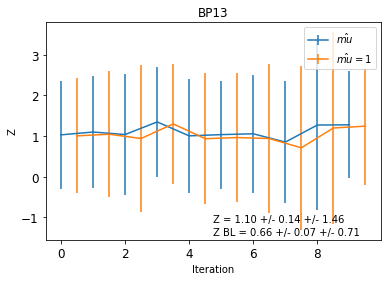

In [806]:
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL))
plt.errorbar(np.arange(len(Z_MLL)), np.asarray(Z_MLL), np.asarray(Z_MLL_std), label = '$\hat{mu}$')
plt.errorbar(np.arange(len(Z_MLL_mu)) + 0.5, np.asarray(Z_MLL_mu), np.asarray(Z_MLL_std_mu), label =  '$\hat{mu} = 1$')
#plt.scatter(np.arange(len(Z_MLL)), np.asarray(Z_MLL_mu))
plt.legend()
plt.ylabel('Z')
plt.text(0.5,0.08, 'Z = ' + '{:.2f}'.format(np.mean(np.asarray(Z_MLL))) + ' +/- ' + 
         '{:.2f}'.format(np.std(np.asarray(Z_MLL))) + ' +/- ' + '{:.2f}'.format(np.mean(Z_MLL_std)),
         transform = plt.gca().transAxes)
plt.text(0.5,0.02, 'Z BL = ' + '{:.2f}'.format(np.mean(np.asarray(Z_BL)[:,0])) + ' +/- ' + 
         '{:.2f}'.format(np.std(np.asarray(Z_BL)[:,0])) + ' +/- ' + '{:.2f}'.format(np.mean(np.asarray(Z_BL)[:,1])), transform = plt.gca().transAxes)
plt.title('BP' + str(bp+1))
plt.xlabel('Iteration')
plt.savefig('../graph/loopBP' + str(bp+1) + '_50000_MLLvariable_MET200.pdf')

In [807]:
Z_MLL

[1.032769062328845,
 1.101741736240959,
 1.0398542970868436,
 1.3502484030290218,
 1.0075567161193193,
 1.0380121025142501,
 1.0586316289516144,
 0.8537648567556467,
 1.2739108047864296,
 1.278976194140249]

In [808]:
np.asarray(Z_BL)[:,0]

array([0.5907589 , 0.63621089, 0.6833071 , 0.6974899 , 0.58975773,
       0.85115734, 0.64298011, 0.63720247, 0.63573949, 0.64141881])

In [809]:
print('Z = ' + '{:.2f}'.format(np.mean(np.asarray(Z_MLL))) + ' +/- ' + '{:.2f}'.format(np.std(np.asarray(Z_MLL))) + ' +/- ' + '{:.2f}'.format(np.mean(Z_MLL_std)))
print('Z BL = ' + '{:.2f}'.format(np.mean(np.asarray(Z_BL)[:,0])) + ' +/- ' + '{:.2f}'.format(np.std(np.asarray(Z_BL)[:,0]))  + ' +/- ' + '{:.2f}'.format(np.mean(np.asarray(Z_BL)[:,1])) )

Z = 1.10 +/- 0.14 +/- 1.46
Z BL = 0.66 +/- 0.07 +/- 0.71


In [810]:
print('AUC : ' + str(np.mean(np.asarray(auc_total))) + ' +/- ' + str(np.std(np.asarray(auc_total))))

AUC : 0.9456910115849972 +/- 0.00019889086757768394
